In [1]:
import pandas as pd
import numpy as np
import pywt
from hurst import compute_Hc
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from time import time

import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

In [2]:
df = pd.read_csv('../data/data.csv').drop('Unnamed: 0', axis=1)
df.head()

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X170  X171  X172  \
0  135  190  229  223  192  125   55   -9  -33  -38  ...   -17   -15   -31   
1  386  382  356  331  320  315  307  272  244  232  ...   164   150   146   
2  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  ...    57    64    48   
3 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -82   -81   -80   
4   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  ...     4     2   -12   

   X173  X174  X175  X176  X177  X178  y  
0   -77  -103  -127  -116   -83   -51  4  
1   152   157   156   154   143   129  1  
2    19   -12   -30   -35   -35   -36  5  
3   -77   -85   -77   -72   -69   -65  5  
4   -32   -41   -65   -83   -89   -73  5  

[5 rows x 179 columns]

2023-03-21 22:45:55,782 INFO Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-03-21 22:45:55,784 INFO NumExpr defaulting to 8 threads.


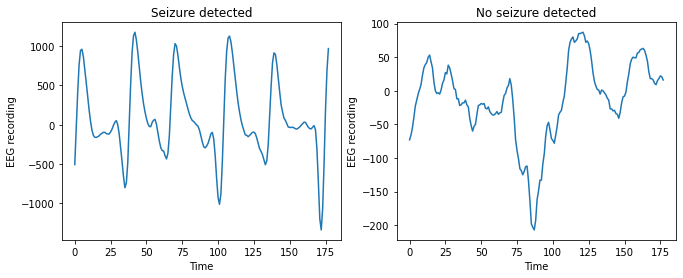

In [3]:
X_raw = df.drop(columns=['y'])
y = df["y"].copy().apply(lambda label: int(label==1))

np.random.seed(2)
index_1 = df[df["y"]==1].index
row_1 = X_raw.values[index_1[-np.random.randint(0,len(index_1))]]
index_2 = df[df["y"]!=1].index
row_2 = X_raw.values[index_2[-np.random.randint(0,len(index_2))]]

fig, axs = plt.subplots(ncols=2,figsize=(11,4))
axs[0].plot(range(178),row_1)
axs[1].plot(range(178),row_2)
axs[0].set_xlabel("Time")
axs[0].set_ylabel("EEG recording")
axs[0].set_title("Seizure detected")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("EEG recording")
axs[1].set_title("No seizure detected")
plt.show()

# Data preprocessing to make classes more balanced

In [4]:
class DataPreprocessing:
    
    @staticmethod
    def get_target(data):
        data['y'] = data['y'].apply(lambda t: int(t == 1))
        target = data['y']
        return data, target
    
    @staticmethod
    def get_balanced_indices(data, random_state):
        np.random.seed(random_state)
        shuffled_indices = np.random.permutation(data.index)
        X = data.loc[shuffled_indices]
        # getting first 6500 values
        return X.sort_values(by=data.columns[-1], ascending=False).iloc[:6500].index
    
    @staticmethod
    def plot_balanced_dataset(data, balanced_indices):
        plt.hist(data.iloc[balanced_indices][data.columns[-1]])

We draw a subsample with higher proportion of class 1, i.e. 2300/6500 instead of 2300/11500

In [5]:
df = pd.read_csv('../data/data.csv').drop('Unnamed: 0', axis=1)
df, target =  DataPreprocessing.get_target(df)
balanced_indices = DataPreprocessing.get_balanced_indices(df, random_state=42)

X_raw = df.iloc[balanced_indices].drop(columns=['y'])
y = target.iloc[balanced_indices]

# Non-linear classifiers without wavelet-based preprocessing

### Kernel SVM

In [6]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y,
                                                                    test_size=0.33,
                                                                    random_state=42)

scaler = StandardScaler()
kernel_svm = SVC(kernel="rbf", max_iter=500, verbose=True)

steps = [('scaler', scaler), ('clf', kernel_svm)]
svm_pipeline = Pipeline(steps=steps)
param_grid = {
    'clf__C': np.exp(np.linspace(0,3,num=20)),
    'clf__gamma':np.exp(np.linspace(-5,2,num=30))
    }

svm_tuner = GridSearchCV(estimator=svm_pipeline, 
                    param_grid=param_grid, 
                    cv=5,
                    verbose=10,
                    refit=True)
start_time = time()
svm_tuner.fit(X_train_raw, y_train_raw)
end_time = time()

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5; 1/600] START clf__C=1.0, clf__gamma=0.006737946999085467...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1/600] END clf__C=1.0, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 1/600] START clf__C=1.0, clf__gamma=0.006737946999085467...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1/600] END clf__C=1.0, clf__gamma=0.006737946999085467; total time=   0.3s
[CV 3/5; 1/600] START clf__C=1.0, clf__gamma=0.006737946999085467...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1/600] END clf__C=1.0, clf__gamma=0.006737946999085467; total time=   0.3s
[CV 4/5; 1/600] START clf__C=1.0, clf__gamma=0.006737946999085467...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1/600] END clf__C=1.0, clf__gamma=0.006737946999085467; total time=   0.3s
[CV 5/5; 1/600] START clf__C=1.0, clf__gamma=0.006737946999085467...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1/600] END clf__C=1.0, clf__gamma=0.006737946999085467; total time=   0.3s
[CV 1/5; 2/600] START clf__C=1.0, clf__gamma=0.008577432182920496...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 2/600] END clf__C=1.0, clf__gamma=0.008577432182920496; total time=   0.3s
[CV 2/5; 2/600] START clf__C=1.0, clf__gamma=0.008577432182920496...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 2/600] END clf__C=1.0, clf__gamma=0.008577432182920496; total time=   0.3s
[CV 3/5; 2/600] START clf__C=1.0, clf__gamma=0.008577432182920496...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 2/600] END clf__C=1.0, clf__gamma=0.008577432182920496; total time=   0.3s
[CV 4/5; 2/600] START clf__C=1.0, clf__gamma=0.008577432182920496...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 2/600] END clf__C=1.0, clf__gamma=0.008577432182920496; total time=   0.3s
[CV 5/5; 2/600] START clf__C=1.0, clf__gamma=0.008577432182920496...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 2/600] END clf__C=1.0, clf__gamma=0.008577432182920496; total time=   0.3s
[CV 1/5; 3/600] START clf__C=1.0, clf__gamma=0.010919103825332278...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 3/600] END clf__C=1.0, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 3/600] START clf__C=1.0, clf__gamma=0.010919103825332278...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 3/600] END clf__C=1.0, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 3/600] START clf__C=1.0, clf__gamma=0.010919103825332278...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 3/600] END clf__C=1.0, clf__gamma=0.010919103825332278; total time=   0.3s
[CV 4/5; 3/600] START clf__C=1.0, clf__gamma=0.010919103825332278...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 3/600] END clf__C=1.0, clf__gamma=0.010919103825332278; total time=   0.3s
[CV 5/5; 3/600] START clf__C=1.0, clf__gamma=0.010919103825332278...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 3/600] END clf__C=1.0, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 4/600] START clf__C=1.0, clf__gamma=0.013900060741464356...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 4/600] END clf__C=1.0, clf__gamma=0.013900060741464356; total time=   0.3s
[CV 2/5; 4/600] START clf__C=1.0, clf__gamma=0.013900060741464356...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 4/600] END clf__C=1.0, clf__gamma=0.013900060741464356; total time=   0.3s
[CV 3/5; 4/600] START clf__C=1.0, clf__gamma=0.013900060741464356...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 4/600] END clf__C=1.0, clf__gamma=0.013900060741464356; total time=   0.3s
[CV 4/5; 4/600] START clf__C=1.0, clf__gamma=0.013900060741464356...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 4/600] END clf__C=1.0, clf__gamma=0.013900060741464356; total time=   0.3s
[CV 5/5; 4/600] START clf__C=1.0, clf__gamma=0.013900060741464356...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 4/600] END clf__C=1.0, clf__gamma=0.013900060741464356; total time=   0.3s
[CV 1/5; 5/600] START clf__C=1.0, clf__gamma=0.017694830244964616...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 5/600] END clf__C=1.0, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 5/600] START clf__C=1.0, clf__gamma=0.017694830244964616...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 5/600] END clf__C=1.0, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 5/600] START clf__C=1.0, clf__gamma=0.017694830244964616...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 5/600] END clf__C=1.0, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 5/600] START clf__C=1.0, clf__gamma=0.017694830244964616...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 5/600] END clf__C=1.0, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 5/600] START clf__C=1.0, clf__gamma=0.017694830244964616...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 5/600] END clf__C=1.0, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 6/600] START clf__C=1.0, clf__gamma=0.02252558627057691................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 6/600] END clf__C=1.0, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 6/600] START clf__C=1.0, clf__gamma=0.02252558627057691................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 6/600] END clf__C=1.0, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 6/600] START clf__C=1.0, clf__gamma=0.02252558627057691................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 6/600] END clf__C=1.0, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 6/600] START clf__C=1.0, clf__gamma=0.02252558627057691................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 6/600] END clf__C=1.0, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 6/600] START clf__C=1.0, clf__gamma=0.02252558627057691................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 6/600] END clf__C=1.0, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 7/600] START clf__C=1.0, clf__gamma=0.02867515708310303................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 7/600] END clf__C=1.0, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 7/600] START clf__C=1.0, clf__gamma=0.02867515708310303................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 7/600] END clf__C=1.0, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 7/600] START clf__C=1.0, clf__gamma=0.02867515708310303................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 7/600] END clf__C=1.0, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 7/600] START clf__C=1.0, clf__gamma=0.02867515708310303................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 7/600] END clf__C=1.0, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 7/600] START clf__C=1.0, clf__gamma=0.02867515708310303................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 7/600] END clf__C=1.0, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 8/600] START clf__C=1.0, clf__gamma=0.03650358414043512................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 8/600] END clf__C=1.0, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 2/5; 8/600] START clf__C=1.0, clf__gamma=0.03650358414043512................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 8/600] END clf__C=1.0, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 3/5; 8/600] START clf__C=1.0, clf__gamma=0.03650358414043512................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 8/600] END clf__C=1.0, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 8/600] START clf__C=1.0, clf__gamma=0.03650358414043512................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 8/600] END clf__C=1.0, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 8/600] START clf__C=1.0, clf__gamma=0.03650358414043512................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 8/600] END clf__C=1.0, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 9/600] START clf__C=1.0, clf__gamma=0.046469201589239596...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 9/600] END clf__C=1.0, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 9/600] START clf__C=1.0, clf__gamma=0.046469201589239596...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 9/600] END clf__C=1.0, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 9/600] START clf__C=1.0, clf__gamma=0.046469201589239596...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 9/600] END clf__C=1.0, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 9/600] START clf__C=1.0, clf__gamma=0.046469201589239596...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 9/600] END clf__C=1.0, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 9/600] START clf__C=1.0, clf__gamma=0.046469201589239596...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 9/600] END clf__C=1.0, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 10/600] START clf__C=1.0, clf__gamma=0.05915547054321793...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 10/600] END clf__C=1.0, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 10/600] START clf__C=1.0, clf__gamma=0.05915547054321793...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 10/600] END clf__C=1.0, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 10/600] START clf__C=1.0, clf__gamma=0.05915547054321793...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 10/600] END clf__C=1.0, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 10/600] START clf__C=1.0, clf__gamma=0.05915547054321793...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 10/600] END clf__C=1.0, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 10/600] START clf__C=1.0, clf__gamma=0.05915547054321793...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 10/600] END clf__C=1.0, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 11/600] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 11/600] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 11/600] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 11/600] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 11/600] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 11/600] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 11/600] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 11/600] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 11/600] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 11/600] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 12/600] START clf__C=1.0, clf__gamma=0.09586372893485993...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 12/600] END clf__C=1.0, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 12/600] START clf__C=1.0, clf__gamma=0.09586372893485993...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 12/600] END clf__C=1.0, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 12/600] START clf__C=1.0, clf__gamma=0.09586372893485993...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 12/600] END clf__C=1.0, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 12/600] START clf__C=1.0, clf__gamma=0.09586372893485993...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 12/600] END clf__C=1.0, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 12/600] START clf__C=1.0, clf__gamma=0.09586372893485993...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 12/600] END clf__C=1.0, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 13/600] START clf__C=1.0, clf__gamma=0.12203489191177064...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 13/600] END clf__C=1.0, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 13/600] START clf__C=1.0, clf__gamma=0.12203489191177064...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 13/600] END clf__C=1.0, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 3/5; 13/600] START clf__C=1.0, clf__gamma=0.12203489191177064...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 13/600] END clf__C=1.0, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 13/600] START clf__C=1.0, clf__gamma=0.12203489191177064...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 13/600] END clf__C=1.0, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 13/600] START clf__C=1.0, clf__gamma=0.12203489191177064...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 13/600] END clf__C=1.0, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 14/600] START clf__C=1.0, clf__gamma=0.15535088202167807...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 14/600] END clf__C=1.0, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 14/600] START clf__C=1.0, clf__gamma=0.15535088202167807...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 14/600] END clf__C=1.0, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 14/600] START clf__C=1.0, clf__gamma=0.15535088202167807...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 14/600] END clf__C=1.0, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 14/600] START clf__C=1.0, clf__gamma=0.15535088202167807...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 14/600] END clf__C=1.0, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 14/600] START clf__C=1.0, clf__gamma=0.15535088202167807...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 14/600] END clf__C=1.0, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 15/600] START clf__C=1.0, clf__gamma=0.19776226427407143...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 15/600] END clf__C=1.0, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 2/5; 15/600] START clf__C=1.0, clf__gamma=0.19776226427407143...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 15/600] END clf__C=1.0, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 15/600] START clf__C=1.0, clf__gamma=0.19776226427407143...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 15/600] END clf__C=1.0, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 4/5; 15/600] START clf__C=1.0, clf__gamma=0.19776226427407143...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 15/600] END clf__C=1.0, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 15/600] START clf__C=1.0, clf__gamma=0.19776226427407143...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 15/600] END clf__C=1.0, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 16/600] START clf__C=1.0, clf__gamma=0.25175211535232983...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 16/600] END clf__C=1.0, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 16/600] START clf__C=1.0, clf__gamma=0.25175211535232983...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 16/600] END clf__C=1.0, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 16/600] START clf__C=1.0, clf__gamma=0.25175211535232983...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 16/600] END clf__C=1.0, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 16/600] START clf__C=1.0, clf__gamma=0.25175211535232983...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 16/600] END clf__C=1.0, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 16/600] START clf__C=1.0, clf__gamma=0.25175211535232983...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 16/600] END clf__C=1.0, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 17/600] START clf__C=1.0, clf__gamma=0.32048140132810155...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 17/600] END clf__C=1.0, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 17/600] START clf__C=1.0, clf__gamma=0.32048140132810155...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 17/600] END clf__C=1.0, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 17/600] START clf__C=1.0, clf__gamma=0.32048140132810155...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 17/600] END clf__C=1.0, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 17/600] START clf__C=1.0, clf__gamma=0.32048140132810155...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 17/600] END clf__C=1.0, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 17/600] START clf__C=1.0, clf__gamma=0.32048140132810155...............
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 17/600] END clf__C=1.0, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 18/600] START clf__C=1.0, clf__gamma=0.4079740440452002................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 18/600] END clf__C=1.0, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 18/600] START clf__C=1.0, clf__gamma=0.4079740440452002................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 18/600] END clf__C=1.0, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 18/600] START clf__C=1.0, clf__gamma=0.4079740440452002................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 18/600] END clf__C=1.0, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 18/600] START clf__C=1.0, clf__gamma=0.4079740440452002................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 18/600] END clf__C=1.0, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 18/600] START clf__C=1.0, clf__gamma=0.4079740440452002................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 18/600] END clf__C=1.0, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 19/600] START clf__C=1.0, clf__gamma=0.5193525113308979................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 19/600] END clf__C=1.0, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 19/600] START clf__C=1.0, clf__gamma=0.5193525113308979................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 19/600] END clf__C=1.0, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 19/600] START clf__C=1.0, clf__gamma=0.5193525113308979................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 19/600] END clf__C=1.0, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 19/600] START clf__C=1.0, clf__gamma=0.5193525113308979................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 19/600] END clf__C=1.0, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 19/600] START clf__C=1.0, clf__gamma=0.5193525113308979................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 19/600] END clf__C=1.0, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 1/5; 20/600] START clf__C=1.0, clf__gamma=0.6611377242318554................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 20/600] END clf__C=1.0, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 20/600] START clf__C=1.0, clf__gamma=0.6611377242318554................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 20/600] END clf__C=1.0, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 20/600] START clf__C=1.0, clf__gamma=0.6611377242318554................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 20/600] END clf__C=1.0, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 20/600] START clf__C=1.0, clf__gamma=0.6611377242318554................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 20/600] END clf__C=1.0, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 20/600] START clf__C=1.0, clf__gamma=0.6611377242318554................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 20/600] END clf__C=1.0, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 21/600] START clf__C=1.0, clf__gamma=0.8416308400672834................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 21/600] END clf__C=1.0, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 21/600] START clf__C=1.0, clf__gamma=0.8416308400672834................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 21/600] END clf__C=1.0, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 21/600] START clf__C=1.0, clf__gamma=0.8416308400672834................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 21/600] END clf__C=1.0, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 4/5; 21/600] START clf__C=1.0, clf__gamma=0.8416308400672834................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 21/600] END clf__C=1.0, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 21/600] START clf__C=1.0, clf__gamma=0.8416308400672834................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 21/600] END clf__C=1.0, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 22/600] START clf__C=1.0, clf__gamma=1.0713992637091634................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 22/600] END clf__C=1.0, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 22/600] START clf__C=1.0, clf__gamma=1.0713992637091634................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 22/600] END clf__C=1.0, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 22/600] START clf__C=1.0, clf__gamma=1.0713992637091634................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 22/600] END clf__C=1.0, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 22/600] START clf__C=1.0, clf__gamma=1.0713992637091634................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 22/600] END clf__C=1.0, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 22/600] START clf__C=1.0, clf__gamma=1.0713992637091634................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 22/600] END clf__C=1.0, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 1/5; 23/600] START clf__C=1.0, clf__gamma=1.3638953417923334................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 23/600] END clf__C=1.0, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 23/600] START clf__C=1.0, clf__gamma=1.3638953417923334................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 23/600] END clf__C=1.0, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 23/600] START clf__C=1.0, clf__gamma=1.3638953417923334................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 23/600] END clf__C=1.0, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 23/600] START clf__C=1.0, clf__gamma=1.3638953417923334................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 23/600] END clf__C=1.0, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 23/600] START clf__C=1.0, clf__gamma=1.3638953417923334................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 23/600] END clf__C=1.0, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 24/600] START clf__C=1.0, clf__gamma=1.7362439627994646................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 24/600] END clf__C=1.0, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 24/600] START clf__C=1.0, clf__gamma=1.7362439627994646................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 24/600] END clf__C=1.0, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 24/600] START clf__C=1.0, clf__gamma=1.7362439627994646................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 24/600] END clf__C=1.0, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 24/600] START clf__C=1.0, clf__gamma=1.7362439627994646................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 24/600] END clf__C=1.0, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 24/600] START clf__C=1.0, clf__gamma=1.7362439627994646................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 24/600] END clf__C=1.0, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 25/600] START clf__C=1.0, clf__gamma=2.2102451749678185................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 25/600] END clf__C=1.0, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 25/600] START clf__C=1.0, clf__gamma=2.2102451749678185................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 25/600] END clf__C=1.0, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 25/600] START clf__C=1.0, clf__gamma=2.2102451749678185................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 25/600] END clf__C=1.0, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 25/600] START clf__C=1.0, clf__gamma=2.2102451749678185................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 25/600] END clf__C=1.0, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 25/600] START clf__C=1.0, clf__gamma=2.2102451749678185................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 25/600] END clf__C=1.0, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 26/600] START clf__C=1.0, clf__gamma=2.813650522701779.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 26/600] END clf__C=1.0, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 26/600] START clf__C=1.0, clf__gamma=2.813650522701779.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 26/600] END clf__C=1.0, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 26/600] START clf__C=1.0, clf__gamma=2.813650522701779.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 26/600] END clf__C=1.0, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 26/600] START clf__C=1.0, clf__gamma=2.813650522701779.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 26/600] END clf__C=1.0, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 26/600] START clf__C=1.0, clf__gamma=2.813650522701779.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 26/600] END clf__C=1.0, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 27/600] START clf__C=1.0, clf__gamma=3.5817878276853468................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 27/600] END clf__C=1.0, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 2/5; 27/600] START clf__C=1.0, clf__gamma=3.5817878276853468................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 27/600] END clf__C=1.0, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 27/600] START clf__C=1.0, clf__gamma=3.5817878276853468................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 27/600] END clf__C=1.0, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 27/600] START clf__C=1.0, clf__gamma=3.5817878276853468................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 27/600] END clf__C=1.0, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 27/600] START clf__C=1.0, clf__gamma=3.5817878276853468................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 27/600] END clf__C=1.0, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 28/600] START clf__C=1.0, clf__gamma=4.5596295414242825................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 28/600] END clf__C=1.0, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 28/600] START clf__C=1.0, clf__gamma=4.5596295414242825................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 28/600] END clf__C=1.0, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 28/600] START clf__C=1.0, clf__gamma=4.5596295414242825................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 28/600] END clf__C=1.0, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 28/600] START clf__C=1.0, clf__gamma=4.5596295414242825................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 28/600] END clf__C=1.0, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 28/600] START clf__C=1.0, clf__gamma=4.5596295414242825................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 28/600] END clf__C=1.0, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 29/600] START clf__C=1.0, clf__gamma=5.804425765907034.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 29/600] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 29/600] START clf__C=1.0, clf__gamma=5.804425765907034.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 29/600] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 29/600] START clf__C=1.0, clf__gamma=5.804425765907034.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 29/600] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 29/600] START clf__C=1.0, clf__gamma=5.804425765907034.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 29/600] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 29/600] START clf__C=1.0, clf__gamma=5.804425765907034.................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 29/600] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 30/600] START clf__C=1.0, clf__gamma=7.38905609893065..................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 30/600] END clf__C=1.0, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 30/600] START clf__C=1.0, clf__gamma=7.38905609893065..................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 30/600] END clf__C=1.0, clf__gamma=7.38905609893065; total time=   0.5s
[CV 3/5; 30/600] START clf__C=1.0, clf__gamma=7.38905609893065..................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 30/600] END clf__C=1.0, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 30/600] START clf__C=1.0, clf__gamma=7.38905609893065..................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 30/600] END clf__C=1.0, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 30/600] START clf__C=1.0, clf__gamma=7.38905609893065..................
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 30/600] END clf__C=1.0, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 31/600] START clf__C=1.1710429205438226, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 31/600] END clf__C=1.1710429205438226, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 31/600] START clf__C=1.1710429205438226, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 31/600] END clf__C=1.1710429205438226, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 31/600] START clf__C=1.1710429205438226, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 31/600] END clf__C=1.1710429205438226, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 31/600] START clf__C=1.1710429205438226, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 31/600] END clf__C=1.1710429205438226, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 31/600] START clf__C=1.1710429205438226, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 31/600] END clf__C=1.1710429205438226, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 32/600] START clf__C=1.1710429205438226, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 32/600] END clf__C=1.1710429205438226, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 32/600] START clf__C=1.1710429205438226, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 32/600] END clf__C=1.1710429205438226, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 32/600] START clf__C=1.1710429205438226, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 32/600] END clf__C=1.1710429205438226, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 32/600] START clf__C=1.1710429205438226, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 32/600] END clf__C=1.1710429205438226, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 32/600] START clf__C=1.1710429205438226, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 32/600] END clf__C=1.1710429205438226, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 33/600] START clf__C=1.1710429205438226, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 33/600] END clf__C=1.1710429205438226, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 33/600] START clf__C=1.1710429205438226, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 33/600] END clf__C=1.1710429205438226, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 33/600] START clf__C=1.1710429205438226, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 33/600] END clf__C=1.1710429205438226, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 33/600] START clf__C=1.1710429205438226, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 33/600] END clf__C=1.1710429205438226, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 33/600] START clf__C=1.1710429205438226, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 33/600] END clf__C=1.1710429205438226, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 34/600] START clf__C=1.1710429205438226, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 34/600] END clf__C=1.1710429205438226, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 34/600] START clf__C=1.1710429205438226, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 34/600] END clf__C=1.1710429205438226, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 34/600] START clf__C=1.1710429205438226, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 34/600] END clf__C=1.1710429205438226, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 34/600] START clf__C=1.1710429205438226, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 34/600] END clf__C=1.1710429205438226, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 34/600] START clf__C=1.1710429205438226, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 34/600] END clf__C=1.1710429205438226, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 35/600] START clf__C=1.1710429205438226, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 35/600] END clf__C=1.1710429205438226, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 35/600] START clf__C=1.1710429205438226, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 35/600] END clf__C=1.1710429205438226, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 35/600] START clf__C=1.1710429205438226, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 35/600] END clf__C=1.1710429205438226, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 35/600] START clf__C=1.1710429205438226, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 35/600] END clf__C=1.1710429205438226, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 35/600] START clf__C=1.1710429205438226, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 35/600] END clf__C=1.1710429205438226, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 36/600] START clf__C=1.1710429205438226, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 36/600] END clf__C=1.1710429205438226, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 36/600] START clf__C=1.1710429205438226, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 36/600] END clf__C=1.1710429205438226, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 36/600] START clf__C=1.1710429205438226, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 36/600] END clf__C=1.1710429205438226, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 36/600] START clf__C=1.1710429205438226, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 36/600] END clf__C=1.1710429205438226, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 36/600] START clf__C=1.1710429205438226, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 36/600] END clf__C=1.1710429205438226, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 37/600] START clf__C=1.1710429205438226, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 37/600] END clf__C=1.1710429205438226, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 37/600] START clf__C=1.1710429205438226, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 37/600] END clf__C=1.1710429205438226, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 37/600] START clf__C=1.1710429205438226, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 37/600] END clf__C=1.1710429205438226, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 37/600] START clf__C=1.1710429205438226, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 37/600] END clf__C=1.1710429205438226, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 37/600] START clf__C=1.1710429205438226, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 37/600] END clf__C=1.1710429205438226, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 38/600] START clf__C=1.1710429205438226, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 38/600] END clf__C=1.1710429205438226, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 38/600] START clf__C=1.1710429205438226, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 38/600] END clf__C=1.1710429205438226, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 38/600] START clf__C=1.1710429205438226, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 38/600] END clf__C=1.1710429205438226, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 38/600] START clf__C=1.1710429205438226, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 38/600] END clf__C=1.1710429205438226, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 38/600] START clf__C=1.1710429205438226, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 38/600] END clf__C=1.1710429205438226, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 39/600] START clf__C=1.1710429205438226, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 39/600] END clf__C=1.1710429205438226, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 39/600] START clf__C=1.1710429205438226, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 39/600] END clf__C=1.1710429205438226, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 39/600] START clf__C=1.1710429205438226, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 39/600] END clf__C=1.1710429205438226, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 39/600] START clf__C=1.1710429205438226, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 39/600] END clf__C=1.1710429205438226, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 39/600] START clf__C=1.1710429205438226, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 39/600] END clf__C=1.1710429205438226, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 40/600] START clf__C=1.1710429205438226, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 40/600] END clf__C=1.1710429205438226, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 40/600] START clf__C=1.1710429205438226, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 40/600] END clf__C=1.1710429205438226, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 40/600] START clf__C=1.1710429205438226, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 40/600] END clf__C=1.1710429205438226, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 40/600] START clf__C=1.1710429205438226, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 40/600] END clf__C=1.1710429205438226, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 40/600] START clf__C=1.1710429205438226, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 40/600] END clf__C=1.1710429205438226, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 1/5; 41/600] START clf__C=1.1710429205438226, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 41/600] END clf__C=1.1710429205438226, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 41/600] START clf__C=1.1710429205438226, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 41/600] END clf__C=1.1710429205438226, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 41/600] START clf__C=1.1710429205438226, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 41/600] END clf__C=1.1710429205438226, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 41/600] START clf__C=1.1710429205438226, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 41/600] END clf__C=1.1710429205438226, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 41/600] START clf__C=1.1710429205438226, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 41/600] END clf__C=1.1710429205438226, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 42/600] START clf__C=1.1710429205438226, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 42/600] END clf__C=1.1710429205438226, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 42/600] START clf__C=1.1710429205438226, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 42/600] END clf__C=1.1710429205438226, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 42/600] START clf__C=1.1710429205438226, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 42/600] END clf__C=1.1710429205438226, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 42/600] START clf__C=1.1710429205438226, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 42/600] END clf__C=1.1710429205438226, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 42/600] START clf__C=1.1710429205438226, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 42/600] END clf__C=1.1710429205438226, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 43/600] START clf__C=1.1710429205438226, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 43/600] END clf__C=1.1710429205438226, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 43/600] START clf__C=1.1710429205438226, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 43/600] END clf__C=1.1710429205438226, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 43/600] START clf__C=1.1710429205438226, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 43/600] END clf__C=1.1710429205438226, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 43/600] START clf__C=1.1710429205438226, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 43/600] END clf__C=1.1710429205438226, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 43/600] START clf__C=1.1710429205438226, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 43/600] END clf__C=1.1710429205438226, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 44/600] START clf__C=1.1710429205438226, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 44/600] END clf__C=1.1710429205438226, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 44/600] START clf__C=1.1710429205438226, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 44/600] END clf__C=1.1710429205438226, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 44/600] START clf__C=1.1710429205438226, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 44/600] END clf__C=1.1710429205438226, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 44/600] START clf__C=1.1710429205438226, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 44/600] END clf__C=1.1710429205438226, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 44/600] START clf__C=1.1710429205438226, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 44/600] END clf__C=1.1710429205438226, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 45/600] START clf__C=1.1710429205438226, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 45/600] END clf__C=1.1710429205438226, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 45/600] START clf__C=1.1710429205438226, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 45/600] END clf__C=1.1710429205438226, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 3/5; 45/600] START clf__C=1.1710429205438226, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 45/600] END clf__C=1.1710429205438226, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 45/600] START clf__C=1.1710429205438226, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 45/600] END clf__C=1.1710429205438226, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 45/600] START clf__C=1.1710429205438226, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 45/600] END clf__C=1.1710429205438226, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 46/600] START clf__C=1.1710429205438226, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 46/600] END clf__C=1.1710429205438226, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 46/600] START clf__C=1.1710429205438226, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 46/600] END clf__C=1.1710429205438226, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 46/600] START clf__C=1.1710429205438226, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 46/600] END clf__C=1.1710429205438226, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 46/600] START clf__C=1.1710429205438226, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 46/600] END clf__C=1.1710429205438226, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 46/600] START clf__C=1.1710429205438226, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 46/600] END clf__C=1.1710429205438226, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 47/600] START clf__C=1.1710429205438226, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 47/600] END clf__C=1.1710429205438226, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 47/600] START clf__C=1.1710429205438226, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 47/600] END clf__C=1.1710429205438226, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 3/5; 47/600] START clf__C=1.1710429205438226, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 47/600] END clf__C=1.1710429205438226, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 4/5; 47/600] START clf__C=1.1710429205438226, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 47/600] END clf__C=1.1710429205438226, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 47/600] START clf__C=1.1710429205438226, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 47/600] END clf__C=1.1710429205438226, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 48/600] START clf__C=1.1710429205438226, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 48/600] END clf__C=1.1710429205438226, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 2/5; 48/600] START clf__C=1.1710429205438226, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 48/600] END clf__C=1.1710429205438226, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 48/600] START clf__C=1.1710429205438226, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 48/600] END clf__C=1.1710429205438226, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 48/600] START clf__C=1.1710429205438226, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 48/600] END clf__C=1.1710429205438226, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 5/5; 48/600] START clf__C=1.1710429205438226, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 48/600] END clf__C=1.1710429205438226, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 1/5; 49/600] START clf__C=1.1710429205438226, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 49/600] END clf__C=1.1710429205438226, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 2/5; 49/600] START clf__C=1.1710429205438226, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 49/600] END clf__C=1.1710429205438226, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 49/600] START clf__C=1.1710429205438226, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 49/600] END clf__C=1.1710429205438226, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 4/5; 49/600] START clf__C=1.1710429205438226, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 49/600] END clf__C=1.1710429205438226, clf__gamma=0.5193525113308979; total time=   0.9s
[CV 5/5; 49/600] START clf__C=1.1710429205438226, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 49/600] END clf__C=1.1710429205438226, clf__gamma=0.5193525113308979; total time=   0.7s
[CV 1/5; 50/600] START clf__C=1.1710429205438226, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 50/600] END clf__C=1.1710429205438226, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 2/5; 50/600] START clf__C=1.1710429205438226, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 50/600] END clf__C=1.1710429205438226, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 3/5; 50/600] START clf__C=1.1710429205438226, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 50/600] END clf__C=1.1710429205438226, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 4/5; 50/600] START clf__C=1.1710429205438226, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 50/600] END clf__C=1.1710429205438226, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 50/600] START clf__C=1.1710429205438226, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 50/600] END clf__C=1.1710429205438226, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 51/600] START clf__C=1.1710429205438226, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 51/600] END clf__C=1.1710429205438226, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 51/600] START clf__C=1.1710429205438226, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 51/600] END clf__C=1.1710429205438226, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 51/600] START clf__C=1.1710429205438226, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 51/600] END clf__C=1.1710429205438226, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 51/600] START clf__C=1.1710429205438226, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 51/600] END clf__C=1.1710429205438226, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 51/600] START clf__C=1.1710429205438226, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 51/600] END clf__C=1.1710429205438226, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 1/5; 52/600] START clf__C=1.1710429205438226, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 52/600] END clf__C=1.1710429205438226, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 52/600] START clf__C=1.1710429205438226, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 52/600] END clf__C=1.1710429205438226, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 52/600] START clf__C=1.1710429205438226, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 52/600] END clf__C=1.1710429205438226, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 52/600] START clf__C=1.1710429205438226, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 52/600] END clf__C=1.1710429205438226, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 52/600] START clf__C=1.1710429205438226, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 52/600] END clf__C=1.1710429205438226, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 53/600] START clf__C=1.1710429205438226, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 53/600] END clf__C=1.1710429205438226, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 53/600] START clf__C=1.1710429205438226, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 53/600] END clf__C=1.1710429205438226, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 53/600] START clf__C=1.1710429205438226, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 53/600] END clf__C=1.1710429205438226, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 53/600] START clf__C=1.1710429205438226, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 53/600] END clf__C=1.1710429205438226, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 53/600] START clf__C=1.1710429205438226, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 53/600] END clf__C=1.1710429205438226, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 54/600] START clf__C=1.1710429205438226, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 54/600] END clf__C=1.1710429205438226, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 54/600] START clf__C=1.1710429205438226, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 54/600] END clf__C=1.1710429205438226, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 54/600] START clf__C=1.1710429205438226, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 54/600] END clf__C=1.1710429205438226, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 4/5; 54/600] START clf__C=1.1710429205438226, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 54/600] END clf__C=1.1710429205438226, clf__gamma=1.7362439627994646; total time=   0.7s
[CV 5/5; 54/600] START clf__C=1.1710429205438226, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 54/600] END clf__C=1.1710429205438226, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 55/600] START clf__C=1.1710429205438226, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 55/600] END clf__C=1.1710429205438226, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 2/5; 55/600] START clf__C=1.1710429205438226, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 55/600] END clf__C=1.1710429205438226, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 3/5; 55/600] START clf__C=1.1710429205438226, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 55/600] END clf__C=1.1710429205438226, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 4/5; 55/600] START clf__C=1.1710429205438226, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 55/600] END clf__C=1.1710429205438226, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 5/5; 55/600] START clf__C=1.1710429205438226, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 55/600] END clf__C=1.1710429205438226, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 1/5; 56/600] START clf__C=1.1710429205438226, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 56/600] END clf__C=1.1710429205438226, clf__gamma=2.813650522701779; total time=   0.6s
[CV 2/5; 56/600] START clf__C=1.1710429205438226, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 56/600] END clf__C=1.1710429205438226, clf__gamma=2.813650522701779; total time=   0.6s
[CV 3/5; 56/600] START clf__C=1.1710429205438226, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 56/600] END clf__C=1.1710429205438226, clf__gamma=2.813650522701779; total time=   0.6s
[CV 4/5; 56/600] START clf__C=1.1710429205438226, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 56/600] END clf__C=1.1710429205438226, clf__gamma=2.813650522701779; total time=   0.7s
[CV 5/5; 56/600] START clf__C=1.1710429205438226, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 56/600] END clf__C=1.1710429205438226, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 57/600] START clf__C=1.1710429205438226, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 57/600] END clf__C=1.1710429205438226, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 2/5; 57/600] START clf__C=1.1710429205438226, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 57/600] END clf__C=1.1710429205438226, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 3/5; 57/600] START clf__C=1.1710429205438226, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 57/600] END clf__C=1.1710429205438226, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 4/5; 57/600] START clf__C=1.1710429205438226, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 57/600] END clf__C=1.1710429205438226, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 5/5; 57/600] START clf__C=1.1710429205438226, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 57/600] END clf__C=1.1710429205438226, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 1/5; 58/600] START clf__C=1.1710429205438226, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 58/600] END clf__C=1.1710429205438226, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 58/600] START clf__C=1.1710429205438226, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 58/600] END clf__C=1.1710429205438226, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 3/5; 58/600] START clf__C=1.1710429205438226, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 58/600] END clf__C=1.1710429205438226, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 4/5; 58/600] START clf__C=1.1710429205438226, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 58/600] END clf__C=1.1710429205438226, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 5/5; 58/600] START clf__C=1.1710429205438226, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 58/600] END clf__C=1.1710429205438226, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 1/5; 59/600] START clf__C=1.1710429205438226, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 59/600] END clf__C=1.1710429205438226, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 59/600] START clf__C=1.1710429205438226, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 59/600] END clf__C=1.1710429205438226, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 59/600] START clf__C=1.1710429205438226, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 59/600] END clf__C=1.1710429205438226, clf__gamma=5.804425765907034; total time=   0.6s
[CV 4/5; 59/600] START clf__C=1.1710429205438226, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 59/600] END clf__C=1.1710429205438226, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 59/600] START clf__C=1.1710429205438226, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 59/600] END clf__C=1.1710429205438226, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 60/600] START clf__C=1.1710429205438226, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 60/600] END clf__C=1.1710429205438226, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 60/600] START clf__C=1.1710429205438226, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 60/600] END clf__C=1.1710429205438226, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 60/600] START clf__C=1.1710429205438226, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 60/600] END clf__C=1.1710429205438226, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 60/600] START clf__C=1.1710429205438226, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 60/600] END clf__C=1.1710429205438226, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 60/600] START clf__C=1.1710429205438226, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 60/600] END clf__C=1.1710429205438226, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 61/600] START clf__C=1.3713415217558058, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 61/600] END clf__C=1.3713415217558058, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 61/600] START clf__C=1.3713415217558058, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 61/600] END clf__C=1.3713415217558058, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 61/600] START clf__C=1.3713415217558058, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 61/600] END clf__C=1.3713415217558058, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 61/600] START clf__C=1.3713415217558058, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 61/600] END clf__C=1.3713415217558058, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 61/600] START clf__C=1.3713415217558058, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 61/600] END clf__C=1.3713415217558058, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 62/600] START clf__C=1.3713415217558058, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 62/600] END clf__C=1.3713415217558058, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 62/600] START clf__C=1.3713415217558058, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 62/600] END clf__C=1.3713415217558058, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 62/600] START clf__C=1.3713415217558058, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 62/600] END clf__C=1.3713415217558058, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 62/600] START clf__C=1.3713415217558058, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 62/600] END clf__C=1.3713415217558058, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 62/600] START clf__C=1.3713415217558058, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 62/600] END clf__C=1.3713415217558058, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 63/600] START clf__C=1.3713415217558058, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 63/600] END clf__C=1.3713415217558058, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 63/600] START clf__C=1.3713415217558058, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 63/600] END clf__C=1.3713415217558058, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 63/600] START clf__C=1.3713415217558058, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 63/600] END clf__C=1.3713415217558058, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 63/600] START clf__C=1.3713415217558058, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 63/600] END clf__C=1.3713415217558058, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 63/600] START clf__C=1.3713415217558058, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 63/600] END clf__C=1.3713415217558058, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 64/600] START clf__C=1.3713415217558058, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 64/600] END clf__C=1.3713415217558058, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 64/600] START clf__C=1.3713415217558058, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 64/600] END clf__C=1.3713415217558058, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 64/600] START clf__C=1.3713415217558058, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 64/600] END clf__C=1.3713415217558058, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 64/600] START clf__C=1.3713415217558058, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 64/600] END clf__C=1.3713415217558058, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 64/600] START clf__C=1.3713415217558058, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 64/600] END clf__C=1.3713415217558058, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 65/600] START clf__C=1.3713415217558058, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 65/600] END clf__C=1.3713415217558058, clf__gamma=0.017694830244964616; total time=   0.3s
[CV 2/5; 65/600] START clf__C=1.3713415217558058, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 65/600] END clf__C=1.3713415217558058, clf__gamma=0.017694830244964616; total time=   0.3s
[CV 3/5; 65/600] START clf__C=1.3713415217558058, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 65/600] END clf__C=1.3713415217558058, clf__gamma=0.017694830244964616; total time=   0.4s
[CV 4/5; 65/600] START clf__C=1.3713415217558058, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 65/600] END clf__C=1.3713415217558058, clf__gamma=0.017694830244964616; total time=   0.4s
[CV 5/5; 65/600] START clf__C=1.3713415217558058, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 65/600] END clf__C=1.3713415217558058, clf__gamma=0.017694830244964616; total time=   0.4s
[CV 1/5; 66/600] START clf__C=1.3713415217558058, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 66/600] END clf__C=1.3713415217558058, clf__gamma=0.02252558627057691; total time=   0.4s
[CV 2/5; 66/600] START clf__C=1.3713415217558058, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 66/600] END clf__C=1.3713415217558058, clf__gamma=0.02252558627057691; total time=   0.4s
[CV 3/5; 66/600] START clf__C=1.3713415217558058, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 66/600] END clf__C=1.3713415217558058, clf__gamma=0.02252558627057691; total time=   0.4s
[CV 4/5; 66/600] START clf__C=1.3713415217558058, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 66/600] END clf__C=1.3713415217558058, clf__gamma=0.02252558627057691; total time=   0.4s
[CV 5/5; 66/600] START clf__C=1.3713415217558058, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 66/600] END clf__C=1.3713415217558058, clf__gamma=0.02252558627057691; total time=   0.5s
[CV 1/5; 67/600] START clf__C=1.3713415217558058, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 67/600] END clf__C=1.3713415217558058, clf__gamma=0.02867515708310303; total time=   0.5s
[CV 2/5; 67/600] START clf__C=1.3713415217558058, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 67/600] END clf__C=1.3713415217558058, clf__gamma=0.02867515708310303; total time=   0.5s
[CV 3/5; 67/600] START clf__C=1.3713415217558058, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 67/600] END clf__C=1.3713415217558058, clf__gamma=0.02867515708310303; total time=   0.4s
[CV 4/5; 67/600] START clf__C=1.3713415217558058, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 67/600] END clf__C=1.3713415217558058, clf__gamma=0.02867515708310303; total time=   0.4s
[CV 5/5; 67/600] START clf__C=1.3713415217558058, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 67/600] END clf__C=1.3713415217558058, clf__gamma=0.02867515708310303; total time=   0.6s
[CV 1/5; 68/600] START clf__C=1.3713415217558058, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 68/600] END clf__C=1.3713415217558058, clf__gamma=0.03650358414043512; total time=   0.6s
[CV 2/5; 68/600] START clf__C=1.3713415217558058, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 68/600] END clf__C=1.3713415217558058, clf__gamma=0.03650358414043512; total time=   0.5s
[CV 3/5; 68/600] START clf__C=1.3713415217558058, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 68/600] END clf__C=1.3713415217558058, clf__gamma=0.03650358414043512; total time=   0.6s
[CV 4/5; 68/600] START clf__C=1.3713415217558058, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 68/600] END clf__C=1.3713415217558058, clf__gamma=0.03650358414043512; total time=   0.6s
[CV 5/5; 68/600] START clf__C=1.3713415217558058, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 68/600] END clf__C=1.3713415217558058, clf__gamma=0.03650358414043512; total time=   0.4s
[CV 1/5; 69/600] START clf__C=1.3713415217558058, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 69/600] END clf__C=1.3713415217558058, clf__gamma=0.046469201589239596; total time=   0.5s
[CV 2/5; 69/600] START clf__C=1.3713415217558058, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 69/600] END clf__C=1.3713415217558058, clf__gamma=0.046469201589239596; total time=   0.4s
[CV 3/5; 69/600] START clf__C=1.3713415217558058, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 69/600] END clf__C=1.3713415217558058, clf__gamma=0.046469201589239596; total time=   0.5s
[CV 4/5; 69/600] START clf__C=1.3713415217558058, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 69/600] END clf__C=1.3713415217558058, clf__gamma=0.046469201589239596; total time=   0.6s
[CV 5/5; 69/600] START clf__C=1.3713415217558058, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 69/600] END clf__C=1.3713415217558058, clf__gamma=0.046469201589239596; total time=   0.5s
[CV 1/5; 70/600] START clf__C=1.3713415217558058, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 70/600] END clf__C=1.3713415217558058, clf__gamma=0.05915547054321793; total time=   0.7s
[CV 2/5; 70/600] START clf__C=1.3713415217558058, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 70/600] END clf__C=1.3713415217558058, clf__gamma=0.05915547054321793; total time=   0.7s
[CV 3/5; 70/600] START clf__C=1.3713415217558058, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 70/600] END clf__C=1.3713415217558058, clf__gamma=0.05915547054321793; total time=   0.5s
[CV 4/5; 70/600] START clf__C=1.3713415217558058, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 70/600] END clf__C=1.3713415217558058, clf__gamma=0.05915547054321793; total time=   0.7s
[CV 5/5; 70/600] START clf__C=1.3713415217558058, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 70/600] END clf__C=1.3713415217558058, clf__gamma=0.05915547054321793; total time=   1.0s
[CV 1/5; 71/600] START clf__C=1.3713415217558058, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 71/600] END clf__C=1.3713415217558058, clf__gamma=0.07530513922149758; total time=   0.6s
[CV 2/5; 71/600] START clf__C=1.3713415217558058, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 71/600] END clf__C=1.3713415217558058, clf__gamma=0.07530513922149758; total time=   0.6s
[CV 3/5; 71/600] START clf__C=1.3713415217558058, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 71/600] END clf__C=1.3713415217558058, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 4/5; 71/600] START clf__C=1.3713415217558058, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 71/600] END clf__C=1.3713415217558058, clf__gamma=0.07530513922149758; total time=   0.5s
[CV 5/5; 71/600] START clf__C=1.3713415217558058, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 71/600] END clf__C=1.3713415217558058, clf__gamma=0.07530513922149758; total time=   0.6s
[CV 1/5; 72/600] START clf__C=1.3713415217558058, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 72/600] END clf__C=1.3713415217558058, clf__gamma=0.09586372893485993; total time=   0.6s
[CV 2/5; 72/600] START clf__C=1.3713415217558058, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 72/600] END clf__C=1.3713415217558058, clf__gamma=0.09586372893485993; total time=   0.8s
[CV 3/5; 72/600] START clf__C=1.3713415217558058, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 72/600] END clf__C=1.3713415217558058, clf__gamma=0.09586372893485993; total time=   0.9s
[CV 4/5; 72/600] START clf__C=1.3713415217558058, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 72/600] END clf__C=1.3713415217558058, clf__gamma=0.09586372893485993; total time=   0.9s
[CV 5/5; 72/600] START clf__C=1.3713415217558058, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 72/600] END clf__C=1.3713415217558058, clf__gamma=0.09586372893485993; total time=   1.1s
[CV 1/5; 73/600] START clf__C=1.3713415217558058, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 73/600] END clf__C=1.3713415217558058, clf__gamma=0.12203489191177064; total time=   1.2s
[CV 2/5; 73/600] START clf__C=1.3713415217558058, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 73/600] END clf__C=1.3713415217558058, clf__gamma=0.12203489191177064; total time=   1.3s
[CV 3/5; 73/600] START clf__C=1.3713415217558058, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 73/600] END clf__C=1.3713415217558058, clf__gamma=0.12203489191177064; total time=   1.1s
[CV 4/5; 73/600] START clf__C=1.3713415217558058, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 73/600] END clf__C=1.3713415217558058, clf__gamma=0.12203489191177064; total time=   0.8s
[CV 5/5; 73/600] START clf__C=1.3713415217558058, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 73/600] END clf__C=1.3713415217558058, clf__gamma=0.12203489191177064; total time=   1.2s
[CV 1/5; 74/600] START clf__C=1.3713415217558058, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 74/600] END clf__C=1.3713415217558058, clf__gamma=0.15535088202167807; total time=   1.0s
[CV 2/5; 74/600] START clf__C=1.3713415217558058, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 74/600] END clf__C=1.3713415217558058, clf__gamma=0.15535088202167807; total time=   0.6s
[CV 3/5; 74/600] START clf__C=1.3713415217558058, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 74/600] END clf__C=1.3713415217558058, clf__gamma=0.15535088202167807; total time=   0.7s
[CV 4/5; 74/600] START clf__C=1.3713415217558058, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 74/600] END clf__C=1.3713415217558058, clf__gamma=0.15535088202167807; total time=   0.6s
[CV 5/5; 74/600] START clf__C=1.3713415217558058, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 74/600] END clf__C=1.3713415217558058, clf__gamma=0.15535088202167807; total time=   0.9s
[CV 1/5; 75/600] START clf__C=1.3713415217558058, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 75/600] END clf__C=1.3713415217558058, clf__gamma=0.19776226427407143; total time=   1.1s
[CV 2/5; 75/600] START clf__C=1.3713415217558058, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 75/600] END clf__C=1.3713415217558058, clf__gamma=0.19776226427407143; total time=   0.8s
[CV 3/5; 75/600] START clf__C=1.3713415217558058, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 75/600] END clf__C=1.3713415217558058, clf__gamma=0.19776226427407143; total time=   1.1s
[CV 4/5; 75/600] START clf__C=1.3713415217558058, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 75/600] END clf__C=1.3713415217558058, clf__gamma=0.19776226427407143; total time=   1.1s
[CV 5/5; 75/600] START clf__C=1.3713415217558058, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 75/600] END clf__C=1.3713415217558058, clf__gamma=0.19776226427407143; total time=   0.9s
[CV 1/5; 76/600] START clf__C=1.3713415217558058, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 76/600] END clf__C=1.3713415217558058, clf__gamma=0.25175211535232983; total time=   0.6s
[CV 2/5; 76/600] START clf__C=1.3713415217558058, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 76/600] END clf__C=1.3713415217558058, clf__gamma=0.25175211535232983; total time=   0.7s
[CV 3/5; 76/600] START clf__C=1.3713415217558058, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 76/600] END clf__C=1.3713415217558058, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 4/5; 76/600] START clf__C=1.3713415217558058, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 76/600] END clf__C=1.3713415217558058, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 5/5; 76/600] START clf__C=1.3713415217558058, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 76/600] END clf__C=1.3713415217558058, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 1/5; 77/600] START clf__C=1.3713415217558058, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 77/600] END clf__C=1.3713415217558058, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 2/5; 77/600] START clf__C=1.3713415217558058, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 77/600] END clf__C=1.3713415217558058, clf__gamma=0.32048140132810155; total time=   0.8s
[CV 3/5; 77/600] START clf__C=1.3713415217558058, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 77/600] END clf__C=1.3713415217558058, clf__gamma=0.32048140132810155; total time=   0.7s
[CV 4/5; 77/600] START clf__C=1.3713415217558058, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 77/600] END clf__C=1.3713415217558058, clf__gamma=0.32048140132810155; total time=   0.6s
[CV 5/5; 77/600] START clf__C=1.3713415217558058, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 77/600] END clf__C=1.3713415217558058, clf__gamma=0.32048140132810155; total time=   0.7s
[CV 1/5; 78/600] START clf__C=1.3713415217558058, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 78/600] END clf__C=1.3713415217558058, clf__gamma=0.4079740440452002; total time=   0.7s
[CV 2/5; 78/600] START clf__C=1.3713415217558058, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 78/600] END clf__C=1.3713415217558058, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 3/5; 78/600] START clf__C=1.3713415217558058, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 78/600] END clf__C=1.3713415217558058, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 4/5; 78/600] START clf__C=1.3713415217558058, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 78/600] END clf__C=1.3713415217558058, clf__gamma=0.4079740440452002; total time=   0.7s
[CV 5/5; 78/600] START clf__C=1.3713415217558058, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 78/600] END clf__C=1.3713415217558058, clf__gamma=0.4079740440452002; total time=   0.8s
[CV 1/5; 79/600] START clf__C=1.3713415217558058, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 79/600] END clf__C=1.3713415217558058, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 2/5; 79/600] START clf__C=1.3713415217558058, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 79/600] END clf__C=1.3713415217558058, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 3/5; 79/600] START clf__C=1.3713415217558058, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 79/600] END clf__C=1.3713415217558058, clf__gamma=0.5193525113308979; total time=   0.7s
[CV 4/5; 79/600] START clf__C=1.3713415217558058, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 79/600] END clf__C=1.3713415217558058, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 5/5; 79/600] START clf__C=1.3713415217558058, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 79/600] END clf__C=1.3713415217558058, clf__gamma=0.5193525113308979; total time=   0.8s
[CV 1/5; 80/600] START clf__C=1.3713415217558058, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 80/600] END clf__C=1.3713415217558058, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 2/5; 80/600] START clf__C=1.3713415217558058, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 80/600] END clf__C=1.3713415217558058, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 3/5; 80/600] START clf__C=1.3713415217558058, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 80/600] END clf__C=1.3713415217558058, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 4/5; 80/600] START clf__C=1.3713415217558058, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 80/600] END clf__C=1.3713415217558058, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 5/5; 80/600] START clf__C=1.3713415217558058, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 80/600] END clf__C=1.3713415217558058, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 1/5; 81/600] START clf__C=1.3713415217558058, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 81/600] END clf__C=1.3713415217558058, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 2/5; 81/600] START clf__C=1.3713415217558058, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 81/600] END clf__C=1.3713415217558058, clf__gamma=0.8416308400672834; total time=   0.7s
[CV 3/5; 81/600] START clf__C=1.3713415217558058, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 81/600] END clf__C=1.3713415217558058, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 81/600] START clf__C=1.3713415217558058, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 81/600] END clf__C=1.3713415217558058, clf__gamma=0.8416308400672834; total time=   0.7s
[CV 5/5; 81/600] START clf__C=1.3713415217558058, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 81/600] END clf__C=1.3713415217558058, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 1/5; 82/600] START clf__C=1.3713415217558058, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 82/600] END clf__C=1.3713415217558058, clf__gamma=1.0713992637091634; total time=   0.6s
[CV 2/5; 82/600] START clf__C=1.3713415217558058, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 82/600] END clf__C=1.3713415217558058, clf__gamma=1.0713992637091634; total time=   0.9s
[CV 3/5; 82/600] START clf__C=1.3713415217558058, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 82/600] END clf__C=1.3713415217558058, clf__gamma=1.0713992637091634; total time=   0.8s
[CV 4/5; 82/600] START clf__C=1.3713415217558058, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 82/600] END clf__C=1.3713415217558058, clf__gamma=1.0713992637091634; total time=   0.6s
[CV 5/5; 82/600] START clf__C=1.3713415217558058, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 82/600] END clf__C=1.3713415217558058, clf__gamma=1.0713992637091634; total time=   0.6s
[CV 1/5; 83/600] START clf__C=1.3713415217558058, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 83/600] END clf__C=1.3713415217558058, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 2/5; 83/600] START clf__C=1.3713415217558058, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 83/600] END clf__C=1.3713415217558058, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 3/5; 83/600] START clf__C=1.3713415217558058, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 83/600] END clf__C=1.3713415217558058, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 83/600] START clf__C=1.3713415217558058, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 83/600] END clf__C=1.3713415217558058, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 5/5; 83/600] START clf__C=1.3713415217558058, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 83/600] END clf__C=1.3713415217558058, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 1/5; 84/600] START clf__C=1.3713415217558058, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 84/600] END clf__C=1.3713415217558058, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 2/5; 84/600] START clf__C=1.3713415217558058, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 84/600] END clf__C=1.3713415217558058, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 84/600] START clf__C=1.3713415217558058, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 84/600] END clf__C=1.3713415217558058, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 84/600] START clf__C=1.3713415217558058, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 84/600] END clf__C=1.3713415217558058, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 84/600] START clf__C=1.3713415217558058, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 84/600] END clf__C=1.3713415217558058, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 85/600] START clf__C=1.3713415217558058, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 85/600] END clf__C=1.3713415217558058, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 2/5; 85/600] START clf__C=1.3713415217558058, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 85/600] END clf__C=1.3713415217558058, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 3/5; 85/600] START clf__C=1.3713415217558058, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 85/600] END clf__C=1.3713415217558058, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 85/600] START clf__C=1.3713415217558058, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 85/600] END clf__C=1.3713415217558058, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 85/600] START clf__C=1.3713415217558058, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 85/600] END clf__C=1.3713415217558058, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 1/5; 86/600] START clf__C=1.3713415217558058, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 86/600] END clf__C=1.3713415217558058, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 86/600] START clf__C=1.3713415217558058, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 86/600] END clf__C=1.3713415217558058, clf__gamma=2.813650522701779; total time=   0.6s
[CV 3/5; 86/600] START clf__C=1.3713415217558058, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 86/600] END clf__C=1.3713415217558058, clf__gamma=2.813650522701779; total time=   0.6s
[CV 4/5; 86/600] START clf__C=1.3713415217558058, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 86/600] END clf__C=1.3713415217558058, clf__gamma=2.813650522701779; total time=   0.7s
[CV 5/5; 86/600] START clf__C=1.3713415217558058, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 86/600] END clf__C=1.3713415217558058, clf__gamma=2.813650522701779; total time=   0.6s
[CV 1/5; 87/600] START clf__C=1.3713415217558058, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 87/600] END clf__C=1.3713415217558058, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 2/5; 87/600] START clf__C=1.3713415217558058, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 87/600] END clf__C=1.3713415217558058, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 3/5; 87/600] START clf__C=1.3713415217558058, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 87/600] END clf__C=1.3713415217558058, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 4/5; 87/600] START clf__C=1.3713415217558058, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 87/600] END clf__C=1.3713415217558058, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 5/5; 87/600] START clf__C=1.3713415217558058, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 87/600] END clf__C=1.3713415217558058, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 1/5; 88/600] START clf__C=1.3713415217558058, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 88/600] END clf__C=1.3713415217558058, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 88/600] START clf__C=1.3713415217558058, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 88/600] END clf__C=1.3713415217558058, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 3/5; 88/600] START clf__C=1.3713415217558058, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 88/600] END clf__C=1.3713415217558058, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 4/5; 88/600] START clf__C=1.3713415217558058, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 88/600] END clf__C=1.3713415217558058, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 5/5; 88/600] START clf__C=1.3713415217558058, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 88/600] END clf__C=1.3713415217558058, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 1/5; 89/600] START clf__C=1.3713415217558058, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 89/600] END clf__C=1.3713415217558058, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 89/600] START clf__C=1.3713415217558058, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 89/600] END clf__C=1.3713415217558058, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 89/600] START clf__C=1.3713415217558058, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 89/600] END clf__C=1.3713415217558058, clf__gamma=5.804425765907034; total time=   0.6s
[CV 4/5; 89/600] START clf__C=1.3713415217558058, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 89/600] END clf__C=1.3713415217558058, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 89/600] START clf__C=1.3713415217558058, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 89/600] END clf__C=1.3713415217558058, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 90/600] START clf__C=1.3713415217558058, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 90/600] END clf__C=1.3713415217558058, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 90/600] START clf__C=1.3713415217558058, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 90/600] END clf__C=1.3713415217558058, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 90/600] START clf__C=1.3713415217558058, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 90/600] END clf__C=1.3713415217558058, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 90/600] START clf__C=1.3713415217558058, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 90/600] END clf__C=1.3713415217558058, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 90/600] START clf__C=1.3713415217558058, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 90/600] END clf__C=1.3713415217558058, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 91/600] START clf__C=1.605899780699929, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 91/600] END clf__C=1.605899780699929, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 91/600] START clf__C=1.605899780699929, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 91/600] END clf__C=1.605899780699929, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 91/600] START clf__C=1.605899780699929, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 91/600] END clf__C=1.605899780699929, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 91/600] START clf__C=1.605899780699929, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 91/600] END clf__C=1.605899780699929, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 91/600] START clf__C=1.605899780699929, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 91/600] END clf__C=1.605899780699929, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 92/600] START clf__C=1.605899780699929, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 92/600] END clf__C=1.605899780699929, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 92/600] START clf__C=1.605899780699929, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 92/600] END clf__C=1.605899780699929, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 92/600] START clf__C=1.605899780699929, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 92/600] END clf__C=1.605899780699929, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 92/600] START clf__C=1.605899780699929, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 92/600] END clf__C=1.605899780699929, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 92/600] START clf__C=1.605899780699929, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 92/600] END clf__C=1.605899780699929, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 93/600] START clf__C=1.605899780699929, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 93/600] END clf__C=1.605899780699929, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 93/600] START clf__C=1.605899780699929, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 93/600] END clf__C=1.605899780699929, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 93/600] START clf__C=1.605899780699929, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 93/600] END clf__C=1.605899780699929, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 93/600] START clf__C=1.605899780699929, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 93/600] END clf__C=1.605899780699929, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 93/600] START clf__C=1.605899780699929, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 93/600] END clf__C=1.605899780699929, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 94/600] START clf__C=1.605899780699929, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 94/600] END clf__C=1.605899780699929, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 94/600] START clf__C=1.605899780699929, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 94/600] END clf__C=1.605899780699929, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 94/600] START clf__C=1.605899780699929, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 94/600] END clf__C=1.605899780699929, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 94/600] START clf__C=1.605899780699929, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 94/600] END clf__C=1.605899780699929, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 94/600] START clf__C=1.605899780699929, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 94/600] END clf__C=1.605899780699929, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 95/600] START clf__C=1.605899780699929, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 95/600] END clf__C=1.605899780699929, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 95/600] START clf__C=1.605899780699929, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 95/600] END clf__C=1.605899780699929, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 95/600] START clf__C=1.605899780699929, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 95/600] END clf__C=1.605899780699929, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 95/600] START clf__C=1.605899780699929, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 95/600] END clf__C=1.605899780699929, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 95/600] START clf__C=1.605899780699929, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 95/600] END clf__C=1.605899780699929, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 96/600] START clf__C=1.605899780699929, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 96/600] END clf__C=1.605899780699929, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 96/600] START clf__C=1.605899780699929, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 96/600] END clf__C=1.605899780699929, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 96/600] START clf__C=1.605899780699929, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 96/600] END clf__C=1.605899780699929, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 96/600] START clf__C=1.605899780699929, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 96/600] END clf__C=1.605899780699929, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 96/600] START clf__C=1.605899780699929, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 96/600] END clf__C=1.605899780699929, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 97/600] START clf__C=1.605899780699929, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 97/600] END clf__C=1.605899780699929, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 97/600] START clf__C=1.605899780699929, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 97/600] END clf__C=1.605899780699929, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 97/600] START clf__C=1.605899780699929, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 97/600] END clf__C=1.605899780699929, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 97/600] START clf__C=1.605899780699929, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 97/600] END clf__C=1.605899780699929, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 97/600] START clf__C=1.605899780699929, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 97/600] END clf__C=1.605899780699929, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 98/600] START clf__C=1.605899780699929, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 98/600] END clf__C=1.605899780699929, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 2/5; 98/600] START clf__C=1.605899780699929, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 98/600] END clf__C=1.605899780699929, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 98/600] START clf__C=1.605899780699929, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 98/600] END clf__C=1.605899780699929, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 98/600] START clf__C=1.605899780699929, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 98/600] END clf__C=1.605899780699929, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 98/600] START clf__C=1.605899780699929, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 98/600] END clf__C=1.605899780699929, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 99/600] START clf__C=1.605899780699929, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 99/600] END clf__C=1.605899780699929, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 2/5; 99/600] START clf__C=1.605899780699929, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 99/600] END clf__C=1.605899780699929, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 99/600] START clf__C=1.605899780699929, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 99/600] END clf__C=1.605899780699929, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 99/600] START clf__C=1.605899780699929, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 99/600] END clf__C=1.605899780699929, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 5/5; 99/600] START clf__C=1.605899780699929, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 99/600] END clf__C=1.605899780699929, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 100/600] START clf__C=1.605899780699929, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 100/600] END clf__C=1.605899780699929, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 2/5; 100/600] START clf__C=1.605899780699929, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 100/600] END clf__C=1.605899780699929, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 100/600] START clf__C=1.605899780699929, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 100/600] END clf__C=1.605899780699929, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 100/600] START clf__C=1.605899780699929, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 100/600] END clf__C=1.605899780699929, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 100/600] START clf__C=1.605899780699929, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 100/600] END clf__C=1.605899780699929, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 101/600] START clf__C=1.605899780699929, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 101/600] END clf__C=1.605899780699929, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 101/600] START clf__C=1.605899780699929, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 101/600] END clf__C=1.605899780699929, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 101/600] START clf__C=1.605899780699929, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 101/600] END clf__C=1.605899780699929, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 101/600] START clf__C=1.605899780699929, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 101/600] END clf__C=1.605899780699929, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 101/600] START clf__C=1.605899780699929, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 101/600] END clf__C=1.605899780699929, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 102/600] START clf__C=1.605899780699929, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 102/600] END clf__C=1.605899780699929, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 102/600] START clf__C=1.605899780699929, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 102/600] END clf__C=1.605899780699929, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 3/5; 102/600] START clf__C=1.605899780699929, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 102/600] END clf__C=1.605899780699929, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 4/5; 102/600] START clf__C=1.605899780699929, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 102/600] END clf__C=1.605899780699929, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 5/5; 102/600] START clf__C=1.605899780699929, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 102/600] END clf__C=1.605899780699929, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 1/5; 103/600] START clf__C=1.605899780699929, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 103/600] END clf__C=1.605899780699929, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 103/600] START clf__C=1.605899780699929, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 103/600] END clf__C=1.605899780699929, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 103/600] START clf__C=1.605899780699929, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 103/600] END clf__C=1.605899780699929, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 103/600] START clf__C=1.605899780699929, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 103/600] END clf__C=1.605899780699929, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 103/600] START clf__C=1.605899780699929, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 103/600] END clf__C=1.605899780699929, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 104/600] START clf__C=1.605899780699929, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 104/600] END clf__C=1.605899780699929, clf__gamma=0.15535088202167807; total time=   0.5s
[CV 2/5; 104/600] START clf__C=1.605899780699929, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 104/600] END clf__C=1.605899780699929, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 104/600] START clf__C=1.605899780699929, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 104/600] END clf__C=1.605899780699929, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 104/600] START clf__C=1.605899780699929, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 104/600] END clf__C=1.605899780699929, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 104/600] START clf__C=1.605899780699929, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 104/600] END clf__C=1.605899780699929, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 105/600] START clf__C=1.605899780699929, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 105/600] END clf__C=1.605899780699929, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 2/5; 105/600] START clf__C=1.605899780699929, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 105/600] END clf__C=1.605899780699929, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 105/600] START clf__C=1.605899780699929, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 105/600] END clf__C=1.605899780699929, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 105/600] START clf__C=1.605899780699929, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 105/600] END clf__C=1.605899780699929, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 105/600] START clf__C=1.605899780699929, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 105/600] END clf__C=1.605899780699929, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 106/600] START clf__C=1.605899780699929, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 106/600] END clf__C=1.605899780699929, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 106/600] START clf__C=1.605899780699929, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 106/600] END clf__C=1.605899780699929, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 106/600] START clf__C=1.605899780699929, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 106/600] END clf__C=1.605899780699929, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 106/600] START clf__C=1.605899780699929, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 106/600] END clf__C=1.605899780699929, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 106/600] START clf__C=1.605899780699929, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 106/600] END clf__C=1.605899780699929, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 107/600] START clf__C=1.605899780699929, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 107/600] END clf__C=1.605899780699929, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 107/600] START clf__C=1.605899780699929, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 107/600] END clf__C=1.605899780699929, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 3/5; 107/600] START clf__C=1.605899780699929, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 107/600] END clf__C=1.605899780699929, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 107/600] START clf__C=1.605899780699929, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 107/600] END clf__C=1.605899780699929, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 107/600] START clf__C=1.605899780699929, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 107/600] END clf__C=1.605899780699929, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 108/600] START clf__C=1.605899780699929, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 108/600] END clf__C=1.605899780699929, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 108/600] START clf__C=1.605899780699929, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 108/600] END clf__C=1.605899780699929, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 108/600] START clf__C=1.605899780699929, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 108/600] END clf__C=1.605899780699929, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 4/5; 108/600] START clf__C=1.605899780699929, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 108/600] END clf__C=1.605899780699929, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 108/600] START clf__C=1.605899780699929, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 108/600] END clf__C=1.605899780699929, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 109/600] START clf__C=1.605899780699929, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 109/600] END clf__C=1.605899780699929, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 109/600] START clf__C=1.605899780699929, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 109/600] END clf__C=1.605899780699929, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 109/600] START clf__C=1.605899780699929, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 109/600] END clf__C=1.605899780699929, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 109/600] START clf__C=1.605899780699929, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 109/600] END clf__C=1.605899780699929, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 109/600] START clf__C=1.605899780699929, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 109/600] END clf__C=1.605899780699929, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 1/5; 110/600] START clf__C=1.605899780699929, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 110/600] END clf__C=1.605899780699929, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 2/5; 110/600] START clf__C=1.605899780699929, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 110/600] END clf__C=1.605899780699929, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 3/5; 110/600] START clf__C=1.605899780699929, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 110/600] END clf__C=1.605899780699929, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 4/5; 110/600] START clf__C=1.605899780699929, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 110/600] END clf__C=1.605899780699929, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 110/600] START clf__C=1.605899780699929, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 110/600] END clf__C=1.605899780699929, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 111/600] START clf__C=1.605899780699929, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 111/600] END clf__C=1.605899780699929, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 111/600] START clf__C=1.605899780699929, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 111/600] END clf__C=1.605899780699929, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 111/600] START clf__C=1.605899780699929, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 111/600] END clf__C=1.605899780699929, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 111/600] START clf__C=1.605899780699929, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 111/600] END clf__C=1.605899780699929, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 111/600] START clf__C=1.605899780699929, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 111/600] END clf__C=1.605899780699929, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 112/600] START clf__C=1.605899780699929, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 112/600] END clf__C=1.605899780699929, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 112/600] START clf__C=1.605899780699929, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 112/600] END clf__C=1.605899780699929, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 112/600] START clf__C=1.605899780699929, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 112/600] END clf__C=1.605899780699929, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 112/600] START clf__C=1.605899780699929, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 112/600] END clf__C=1.605899780699929, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 112/600] START clf__C=1.605899780699929, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 112/600] END clf__C=1.605899780699929, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 113/600] START clf__C=1.605899780699929, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 113/600] END clf__C=1.605899780699929, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 113/600] START clf__C=1.605899780699929, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 113/600] END clf__C=1.605899780699929, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 113/600] START clf__C=1.605899780699929, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 113/600] END clf__C=1.605899780699929, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 113/600] START clf__C=1.605899780699929, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 113/600] END clf__C=1.605899780699929, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 113/600] START clf__C=1.605899780699929, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 113/600] END clf__C=1.605899780699929, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 114/600] START clf__C=1.605899780699929, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 114/600] END clf__C=1.605899780699929, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 114/600] START clf__C=1.605899780699929, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 114/600] END clf__C=1.605899780699929, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 114/600] START clf__C=1.605899780699929, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 114/600] END clf__C=1.605899780699929, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 114/600] START clf__C=1.605899780699929, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 114/600] END clf__C=1.605899780699929, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 114/600] START clf__C=1.605899780699929, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 114/600] END clf__C=1.605899780699929, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 115/600] START clf__C=1.605899780699929, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 115/600] END clf__C=1.605899780699929, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 115/600] START clf__C=1.605899780699929, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 115/600] END clf__C=1.605899780699929, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 115/600] START clf__C=1.605899780699929, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 115/600] END clf__C=1.605899780699929, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 115/600] START clf__C=1.605899780699929, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 115/600] END clf__C=1.605899780699929, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 115/600] START clf__C=1.605899780699929, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 115/600] END clf__C=1.605899780699929, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 116/600] START clf__C=1.605899780699929, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 116/600] END clf__C=1.605899780699929, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 116/600] START clf__C=1.605899780699929, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 116/600] END clf__C=1.605899780699929, clf__gamma=2.813650522701779; total time=   0.6s
[CV 3/5; 116/600] START clf__C=1.605899780699929, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 116/600] END clf__C=1.605899780699929, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 116/600] START clf__C=1.605899780699929, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 116/600] END clf__C=1.605899780699929, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 116/600] START clf__C=1.605899780699929, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 116/600] END clf__C=1.605899780699929, clf__gamma=2.813650522701779; total time=   0.6s
[CV 1/5; 117/600] START clf__C=1.605899780699929, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 117/600] END clf__C=1.605899780699929, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 117/600] START clf__C=1.605899780699929, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 117/600] END clf__C=1.605899780699929, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 117/600] START clf__C=1.605899780699929, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 117/600] END clf__C=1.605899780699929, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 117/600] START clf__C=1.605899780699929, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 117/600] END clf__C=1.605899780699929, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 117/600] START clf__C=1.605899780699929, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 117/600] END clf__C=1.605899780699929, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 118/600] START clf__C=1.605899780699929, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 118/600] END clf__C=1.605899780699929, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 118/600] START clf__C=1.605899780699929, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 118/600] END clf__C=1.605899780699929, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 118/600] START clf__C=1.605899780699929, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 118/600] END clf__C=1.605899780699929, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 118/600] START clf__C=1.605899780699929, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 118/600] END clf__C=1.605899780699929, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 118/600] START clf__C=1.605899780699929, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 118/600] END clf__C=1.605899780699929, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 1/5; 119/600] START clf__C=1.605899780699929, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 119/600] END clf__C=1.605899780699929, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 119/600] START clf__C=1.605899780699929, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 119/600] END clf__C=1.605899780699929, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 119/600] START clf__C=1.605899780699929, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 119/600] END clf__C=1.605899780699929, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 119/600] START clf__C=1.605899780699929, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 119/600] END clf__C=1.605899780699929, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 119/600] START clf__C=1.605899780699929, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 119/600] END clf__C=1.605899780699929, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 120/600] START clf__C=1.605899780699929, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 120/600] END clf__C=1.605899780699929, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 120/600] START clf__C=1.605899780699929, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 120/600] END clf__C=1.605899780699929, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 120/600] START clf__C=1.605899780699929, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 120/600] END clf__C=1.605899780699929, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 120/600] START clf__C=1.605899780699929, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 120/600] END clf__C=1.605899780699929, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 120/600] START clf__C=1.605899780699929, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 120/600] END clf__C=1.605899780699929, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 121/600] START clf__C=1.8805775692915292, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 121/600] END clf__C=1.8805775692915292, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 121/600] START clf__C=1.8805775692915292, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 121/600] END clf__C=1.8805775692915292, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 121/600] START clf__C=1.8805775692915292, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 121/600] END clf__C=1.8805775692915292, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 121/600] START clf__C=1.8805775692915292, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 121/600] END clf__C=1.8805775692915292, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 121/600] START clf__C=1.8805775692915292, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 121/600] END clf__C=1.8805775692915292, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 122/600] START clf__C=1.8805775692915292, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 122/600] END clf__C=1.8805775692915292, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 122/600] START clf__C=1.8805775692915292, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 122/600] END clf__C=1.8805775692915292, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 122/600] START clf__C=1.8805775692915292, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 122/600] END clf__C=1.8805775692915292, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 122/600] START clf__C=1.8805775692915292, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 122/600] END clf__C=1.8805775692915292, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 122/600] START clf__C=1.8805775692915292, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 122/600] END clf__C=1.8805775692915292, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 123/600] START clf__C=1.8805775692915292, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 123/600] END clf__C=1.8805775692915292, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 123/600] START clf__C=1.8805775692915292, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 123/600] END clf__C=1.8805775692915292, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 123/600] START clf__C=1.8805775692915292, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 123/600] END clf__C=1.8805775692915292, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 123/600] START clf__C=1.8805775692915292, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 123/600] END clf__C=1.8805775692915292, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 123/600] START clf__C=1.8805775692915292, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 123/600] END clf__C=1.8805775692915292, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 124/600] START clf__C=1.8805775692915292, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 124/600] END clf__C=1.8805775692915292, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 124/600] START clf__C=1.8805775692915292, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 124/600] END clf__C=1.8805775692915292, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 124/600] START clf__C=1.8805775692915292, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 124/600] END clf__C=1.8805775692915292, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 124/600] START clf__C=1.8805775692915292, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 124/600] END clf__C=1.8805775692915292, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 124/600] START clf__C=1.8805775692915292, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 124/600] END clf__C=1.8805775692915292, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 125/600] START clf__C=1.8805775692915292, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 125/600] END clf__C=1.8805775692915292, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 125/600] START clf__C=1.8805775692915292, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 125/600] END clf__C=1.8805775692915292, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 125/600] START clf__C=1.8805775692915292, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 125/600] END clf__C=1.8805775692915292, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 125/600] START clf__C=1.8805775692915292, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 125/600] END clf__C=1.8805775692915292, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 125/600] START clf__C=1.8805775692915292, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 125/600] END clf__C=1.8805775692915292, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 126/600] START clf__C=1.8805775692915292, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 126/600] END clf__C=1.8805775692915292, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 126/600] START clf__C=1.8805775692915292, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 126/600] END clf__C=1.8805775692915292, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 126/600] START clf__C=1.8805775692915292, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 126/600] END clf__C=1.8805775692915292, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 126/600] START clf__C=1.8805775692915292, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 126/600] END clf__C=1.8805775692915292, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 126/600] START clf__C=1.8805775692915292, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 126/600] END clf__C=1.8805775692915292, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 127/600] START clf__C=1.8805775692915292, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 127/600] END clf__C=1.8805775692915292, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 127/600] START clf__C=1.8805775692915292, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 127/600] END clf__C=1.8805775692915292, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 127/600] START clf__C=1.8805775692915292, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 127/600] END clf__C=1.8805775692915292, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 127/600] START clf__C=1.8805775692915292, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 127/600] END clf__C=1.8805775692915292, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 127/600] START clf__C=1.8805775692915292, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 127/600] END clf__C=1.8805775692915292, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 128/600] START clf__C=1.8805775692915292, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 128/600] END clf__C=1.8805775692915292, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 128/600] START clf__C=1.8805775692915292, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 128/600] END clf__C=1.8805775692915292, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 128/600] START clf__C=1.8805775692915292, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 128/600] END clf__C=1.8805775692915292, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 4/5; 128/600] START clf__C=1.8805775692915292, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 128/600] END clf__C=1.8805775692915292, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 128/600] START clf__C=1.8805775692915292, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 128/600] END clf__C=1.8805775692915292, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 129/600] START clf__C=1.8805775692915292, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 129/600] END clf__C=1.8805775692915292, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 129/600] START clf__C=1.8805775692915292, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 129/600] END clf__C=1.8805775692915292, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 129/600] START clf__C=1.8805775692915292, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 129/600] END clf__C=1.8805775692915292, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 129/600] START clf__C=1.8805775692915292, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 129/600] END clf__C=1.8805775692915292, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 129/600] START clf__C=1.8805775692915292, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 129/600] END clf__C=1.8805775692915292, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 130/600] START clf__C=1.8805775692915292, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 130/600] END clf__C=1.8805775692915292, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 130/600] START clf__C=1.8805775692915292, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 130/600] END clf__C=1.8805775692915292, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 130/600] START clf__C=1.8805775692915292, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 130/600] END clf__C=1.8805775692915292, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 130/600] START clf__C=1.8805775692915292, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 130/600] END clf__C=1.8805775692915292, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 130/600] START clf__C=1.8805775692915292, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 130/600] END clf__C=1.8805775692915292, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 131/600] START clf__C=1.8805775692915292, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 131/600] END clf__C=1.8805775692915292, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 131/600] START clf__C=1.8805775692915292, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 131/600] END clf__C=1.8805775692915292, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 131/600] START clf__C=1.8805775692915292, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 131/600] END clf__C=1.8805775692915292, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 131/600] START clf__C=1.8805775692915292, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 131/600] END clf__C=1.8805775692915292, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 131/600] START clf__C=1.8805775692915292, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 131/600] END clf__C=1.8805775692915292, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 132/600] START clf__C=1.8805775692915292, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 132/600] END clf__C=1.8805775692915292, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 132/600] START clf__C=1.8805775692915292, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 132/600] END clf__C=1.8805775692915292, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 132/600] START clf__C=1.8805775692915292, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 132/600] END clf__C=1.8805775692915292, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 132/600] START clf__C=1.8805775692915292, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 132/600] END clf__C=1.8805775692915292, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 132/600] START clf__C=1.8805775692915292, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 132/600] END clf__C=1.8805775692915292, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 133/600] START clf__C=1.8805775692915292, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 133/600] END clf__C=1.8805775692915292, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 133/600] START clf__C=1.8805775692915292, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 133/600] END clf__C=1.8805775692915292, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 133/600] START clf__C=1.8805775692915292, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 133/600] END clf__C=1.8805775692915292, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 133/600] START clf__C=1.8805775692915292, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 133/600] END clf__C=1.8805775692915292, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 133/600] START clf__C=1.8805775692915292, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 133/600] END clf__C=1.8805775692915292, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 134/600] START clf__C=1.8805775692915292, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 134/600] END clf__C=1.8805775692915292, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 134/600] START clf__C=1.8805775692915292, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 134/600] END clf__C=1.8805775692915292, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 134/600] START clf__C=1.8805775692915292, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 134/600] END clf__C=1.8805775692915292, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 134/600] START clf__C=1.8805775692915292, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 134/600] END clf__C=1.8805775692915292, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 134/600] START clf__C=1.8805775692915292, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 134/600] END clf__C=1.8805775692915292, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 135/600] START clf__C=1.8805775692915292, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 135/600] END clf__C=1.8805775692915292, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 135/600] START clf__C=1.8805775692915292, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 135/600] END clf__C=1.8805775692915292, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 135/600] START clf__C=1.8805775692915292, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 135/600] END clf__C=1.8805775692915292, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 135/600] START clf__C=1.8805775692915292, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 135/600] END clf__C=1.8805775692915292, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 135/600] START clf__C=1.8805775692915292, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 135/600] END clf__C=1.8805775692915292, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 136/600] START clf__C=1.8805775692915292, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 136/600] END clf__C=1.8805775692915292, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 136/600] START clf__C=1.8805775692915292, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 136/600] END clf__C=1.8805775692915292, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 136/600] START clf__C=1.8805775692915292, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 136/600] END clf__C=1.8805775692915292, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 136/600] START clf__C=1.8805775692915292, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 136/600] END clf__C=1.8805775692915292, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 136/600] START clf__C=1.8805775692915292, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 136/600] END clf__C=1.8805775692915292, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 137/600] START clf__C=1.8805775692915292, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 137/600] END clf__C=1.8805775692915292, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 137/600] START clf__C=1.8805775692915292, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 137/600] END clf__C=1.8805775692915292, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 137/600] START clf__C=1.8805775692915292, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 137/600] END clf__C=1.8805775692915292, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 137/600] START clf__C=1.8805775692915292, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 137/600] END clf__C=1.8805775692915292, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 137/600] START clf__C=1.8805775692915292, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 137/600] END clf__C=1.8805775692915292, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 138/600] START clf__C=1.8805775692915292, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 138/600] END clf__C=1.8805775692915292, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 138/600] START clf__C=1.8805775692915292, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 138/600] END clf__C=1.8805775692915292, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 138/600] START clf__C=1.8805775692915292, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 138/600] END clf__C=1.8805775692915292, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 138/600] START clf__C=1.8805775692915292, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 138/600] END clf__C=1.8805775692915292, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 138/600] START clf__C=1.8805775692915292, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 138/600] END clf__C=1.8805775692915292, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 139/600] START clf__C=1.8805775692915292, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 139/600] END clf__C=1.8805775692915292, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 139/600] START clf__C=1.8805775692915292, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 139/600] END clf__C=1.8805775692915292, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 139/600] START clf__C=1.8805775692915292, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 139/600] END clf__C=1.8805775692915292, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 139/600] START clf__C=1.8805775692915292, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 139/600] END clf__C=1.8805775692915292, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 139/600] START clf__C=1.8805775692915292, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 139/600] END clf__C=1.8805775692915292, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 140/600] START clf__C=1.8805775692915292, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 140/600] END clf__C=1.8805775692915292, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 140/600] START clf__C=1.8805775692915292, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 140/600] END clf__C=1.8805775692915292, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 140/600] START clf__C=1.8805775692915292, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 140/600] END clf__C=1.8805775692915292, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 140/600] START clf__C=1.8805775692915292, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 140/600] END clf__C=1.8805775692915292, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 140/600] START clf__C=1.8805775692915292, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 140/600] END clf__C=1.8805775692915292, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 141/600] START clf__C=1.8805775692915292, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 141/600] END clf__C=1.8805775692915292, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 141/600] START clf__C=1.8805775692915292, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 141/600] END clf__C=1.8805775692915292, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 141/600] START clf__C=1.8805775692915292, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 141/600] END clf__C=1.8805775692915292, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 141/600] START clf__C=1.8805775692915292, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 141/600] END clf__C=1.8805775692915292, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 141/600] START clf__C=1.8805775692915292, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 141/600] END clf__C=1.8805775692915292, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 142/600] START clf__C=1.8805775692915292, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 142/600] END clf__C=1.8805775692915292, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 142/600] START clf__C=1.8805775692915292, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 142/600] END clf__C=1.8805775692915292, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 142/600] START clf__C=1.8805775692915292, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 142/600] END clf__C=1.8805775692915292, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 142/600] START clf__C=1.8805775692915292, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 142/600] END clf__C=1.8805775692915292, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 142/600] START clf__C=1.8805775692915292, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 142/600] END clf__C=1.8805775692915292, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 143/600] START clf__C=1.8805775692915292, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 143/600] END clf__C=1.8805775692915292, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 143/600] START clf__C=1.8805775692915292, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 143/600] END clf__C=1.8805775692915292, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 143/600] START clf__C=1.8805775692915292, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 143/600] END clf__C=1.8805775692915292, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 143/600] START clf__C=1.8805775692915292, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 143/600] END clf__C=1.8805775692915292, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 143/600] START clf__C=1.8805775692915292, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 143/600] END clf__C=1.8805775692915292, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 144/600] START clf__C=1.8805775692915292, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 144/600] END clf__C=1.8805775692915292, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 144/600] START clf__C=1.8805775692915292, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 144/600] END clf__C=1.8805775692915292, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 144/600] START clf__C=1.8805775692915292, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 144/600] END clf__C=1.8805775692915292, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 144/600] START clf__C=1.8805775692915292, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 144/600] END clf__C=1.8805775692915292, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 144/600] START clf__C=1.8805775692915292, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 144/600] END clf__C=1.8805775692915292, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 145/600] START clf__C=1.8805775692915292, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 145/600] END clf__C=1.8805775692915292, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 145/600] START clf__C=1.8805775692915292, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 145/600] END clf__C=1.8805775692915292, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 145/600] START clf__C=1.8805775692915292, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 145/600] END clf__C=1.8805775692915292, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 145/600] START clf__C=1.8805775692915292, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 145/600] END clf__C=1.8805775692915292, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 145/600] START clf__C=1.8805775692915292, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 145/600] END clf__C=1.8805775692915292, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 146/600] START clf__C=1.8805775692915292, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 146/600] END clf__C=1.8805775692915292, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 146/600] START clf__C=1.8805775692915292, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 146/600] END clf__C=1.8805775692915292, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 146/600] START clf__C=1.8805775692915292, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 146/600] END clf__C=1.8805775692915292, clf__gamma=2.813650522701779; total time=   0.6s
[CV 4/5; 146/600] START clf__C=1.8805775692915292, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 146/600] END clf__C=1.8805775692915292, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 146/600] START clf__C=1.8805775692915292, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 146/600] END clf__C=1.8805775692915292, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 147/600] START clf__C=1.8805775692915292, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 147/600] END clf__C=1.8805775692915292, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 147/600] START clf__C=1.8805775692915292, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 147/600] END clf__C=1.8805775692915292, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 147/600] START clf__C=1.8805775692915292, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 147/600] END clf__C=1.8805775692915292, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 147/600] START clf__C=1.8805775692915292, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 147/600] END clf__C=1.8805775692915292, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 147/600] START clf__C=1.8805775692915292, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 147/600] END clf__C=1.8805775692915292, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 148/600] START clf__C=1.8805775692915292, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 148/600] END clf__C=1.8805775692915292, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 148/600] START clf__C=1.8805775692915292, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 148/600] END clf__C=1.8805775692915292, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 148/600] START clf__C=1.8805775692915292, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 148/600] END clf__C=1.8805775692915292, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 148/600] START clf__C=1.8805775692915292, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 148/600] END clf__C=1.8805775692915292, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 148/600] START clf__C=1.8805775692915292, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 148/600] END clf__C=1.8805775692915292, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 149/600] START clf__C=1.8805775692915292, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 149/600] END clf__C=1.8805775692915292, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 149/600] START clf__C=1.8805775692915292, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 149/600] END clf__C=1.8805775692915292, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 149/600] START clf__C=1.8805775692915292, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 149/600] END clf__C=1.8805775692915292, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 149/600] START clf__C=1.8805775692915292, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 149/600] END clf__C=1.8805775692915292, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 149/600] START clf__C=1.8805775692915292, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 149/600] END clf__C=1.8805775692915292, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 150/600] START clf__C=1.8805775692915292, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 150/600] END clf__C=1.8805775692915292, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 150/600] START clf__C=1.8805775692915292, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 150/600] END clf__C=1.8805775692915292, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 150/600] START clf__C=1.8805775692915292, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 150/600] END clf__C=1.8805775692915292, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 150/600] START clf__C=1.8805775692915292, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 150/600] END clf__C=1.8805775692915292, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 150/600] START clf__C=1.8805775692915292, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 150/600] END clf__C=1.8805775692915292, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 151/600] START clf__C=2.2022370490523553, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 151/600] END clf__C=2.2022370490523553, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 151/600] START clf__C=2.2022370490523553, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 151/600] END clf__C=2.2022370490523553, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 151/600] START clf__C=2.2022370490523553, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 151/600] END clf__C=2.2022370490523553, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 151/600] START clf__C=2.2022370490523553, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 151/600] END clf__C=2.2022370490523553, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 151/600] START clf__C=2.2022370490523553, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 151/600] END clf__C=2.2022370490523553, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 152/600] START clf__C=2.2022370490523553, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 152/600] END clf__C=2.2022370490523553, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 152/600] START clf__C=2.2022370490523553, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 152/600] END clf__C=2.2022370490523553, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 152/600] START clf__C=2.2022370490523553, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 152/600] END clf__C=2.2022370490523553, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 152/600] START clf__C=2.2022370490523553, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 152/600] END clf__C=2.2022370490523553, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 152/600] START clf__C=2.2022370490523553, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 152/600] END clf__C=2.2022370490523553, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 153/600] START clf__C=2.2022370490523553, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 153/600] END clf__C=2.2022370490523553, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 153/600] START clf__C=2.2022370490523553, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 153/600] END clf__C=2.2022370490523553, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 153/600] START clf__C=2.2022370490523553, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 153/600] END clf__C=2.2022370490523553, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 153/600] START clf__C=2.2022370490523553, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 153/600] END clf__C=2.2022370490523553, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 153/600] START clf__C=2.2022370490523553, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 153/600] END clf__C=2.2022370490523553, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 154/600] START clf__C=2.2022370490523553, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 154/600] END clf__C=2.2022370490523553, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 154/600] START clf__C=2.2022370490523553, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 154/600] END clf__C=2.2022370490523553, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 154/600] START clf__C=2.2022370490523553, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 154/600] END clf__C=2.2022370490523553, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 154/600] START clf__C=2.2022370490523553, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 154/600] END clf__C=2.2022370490523553, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 154/600] START clf__C=2.2022370490523553, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 154/600] END clf__C=2.2022370490523553, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 155/600] START clf__C=2.2022370490523553, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 155/600] END clf__C=2.2022370490523553, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 155/600] START clf__C=2.2022370490523553, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 155/600] END clf__C=2.2022370490523553, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 155/600] START clf__C=2.2022370490523553, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 155/600] END clf__C=2.2022370490523553, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 155/600] START clf__C=2.2022370490523553, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 155/600] END clf__C=2.2022370490523553, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 155/600] START clf__C=2.2022370490523553, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 155/600] END clf__C=2.2022370490523553, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 156/600] START clf__C=2.2022370490523553, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 156/600] END clf__C=2.2022370490523553, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 156/600] START clf__C=2.2022370490523553, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 156/600] END clf__C=2.2022370490523553, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 156/600] START clf__C=2.2022370490523553, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 156/600] END clf__C=2.2022370490523553, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 156/600] START clf__C=2.2022370490523553, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 156/600] END clf__C=2.2022370490523553, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 156/600] START clf__C=2.2022370490523553, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 156/600] END clf__C=2.2022370490523553, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 157/600] START clf__C=2.2022370490523553, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 157/600] END clf__C=2.2022370490523553, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 157/600] START clf__C=2.2022370490523553, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 157/600] END clf__C=2.2022370490523553, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 157/600] START clf__C=2.2022370490523553, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 157/600] END clf__C=2.2022370490523553, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 157/600] START clf__C=2.2022370490523553, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 157/600] END clf__C=2.2022370490523553, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 157/600] START clf__C=2.2022370490523553, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 157/600] END clf__C=2.2022370490523553, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 158/600] START clf__C=2.2022370490523553, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 158/600] END clf__C=2.2022370490523553, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 158/600] START clf__C=2.2022370490523553, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 158/600] END clf__C=2.2022370490523553, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 158/600] START clf__C=2.2022370490523553, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 158/600] END clf__C=2.2022370490523553, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 4/5; 158/600] START clf__C=2.2022370490523553, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 158/600] END clf__C=2.2022370490523553, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 158/600] START clf__C=2.2022370490523553, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 158/600] END clf__C=2.2022370490523553, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 159/600] START clf__C=2.2022370490523553, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 159/600] END clf__C=2.2022370490523553, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 159/600] START clf__C=2.2022370490523553, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 159/600] END clf__C=2.2022370490523553, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 159/600] START clf__C=2.2022370490523553, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 159/600] END clf__C=2.2022370490523553, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 159/600] START clf__C=2.2022370490523553, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 159/600] END clf__C=2.2022370490523553, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 159/600] START clf__C=2.2022370490523553, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 159/600] END clf__C=2.2022370490523553, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 160/600] START clf__C=2.2022370490523553, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 160/600] END clf__C=2.2022370490523553, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 160/600] START clf__C=2.2022370490523553, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 160/600] END clf__C=2.2022370490523553, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 160/600] START clf__C=2.2022370490523553, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 160/600] END clf__C=2.2022370490523553, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 160/600] START clf__C=2.2022370490523553, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 160/600] END clf__C=2.2022370490523553, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 160/600] START clf__C=2.2022370490523553, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 160/600] END clf__C=2.2022370490523553, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 161/600] START clf__C=2.2022370490523553, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 161/600] END clf__C=2.2022370490523553, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 161/600] START clf__C=2.2022370490523553, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 161/600] END clf__C=2.2022370490523553, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 161/600] START clf__C=2.2022370490523553, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 161/600] END clf__C=2.2022370490523553, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 161/600] START clf__C=2.2022370490523553, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 161/600] END clf__C=2.2022370490523553, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 161/600] START clf__C=2.2022370490523553, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 161/600] END clf__C=2.2022370490523553, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 162/600] START clf__C=2.2022370490523553, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 162/600] END clf__C=2.2022370490523553, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 162/600] START clf__C=2.2022370490523553, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 162/600] END clf__C=2.2022370490523553, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 162/600] START clf__C=2.2022370490523553, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 162/600] END clf__C=2.2022370490523553, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 162/600] START clf__C=2.2022370490523553, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 162/600] END clf__C=2.2022370490523553, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 162/600] START clf__C=2.2022370490523553, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 162/600] END clf__C=2.2022370490523553, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 163/600] START clf__C=2.2022370490523553, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 163/600] END clf__C=2.2022370490523553, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 163/600] START clf__C=2.2022370490523553, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 163/600] END clf__C=2.2022370490523553, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 163/600] START clf__C=2.2022370490523553, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 163/600] END clf__C=2.2022370490523553, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 163/600] START clf__C=2.2022370490523553, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 163/600] END clf__C=2.2022370490523553, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 163/600] START clf__C=2.2022370490523553, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 163/600] END clf__C=2.2022370490523553, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 164/600] START clf__C=2.2022370490523553, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 164/600] END clf__C=2.2022370490523553, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 164/600] START clf__C=2.2022370490523553, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 164/600] END clf__C=2.2022370490523553, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 164/600] START clf__C=2.2022370490523553, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 164/600] END clf__C=2.2022370490523553, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 164/600] START clf__C=2.2022370490523553, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 164/600] END clf__C=2.2022370490523553, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 164/600] START clf__C=2.2022370490523553, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 164/600] END clf__C=2.2022370490523553, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 165/600] START clf__C=2.2022370490523553, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 165/600] END clf__C=2.2022370490523553, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 165/600] START clf__C=2.2022370490523553, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 165/600] END clf__C=2.2022370490523553, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 165/600] START clf__C=2.2022370490523553, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 165/600] END clf__C=2.2022370490523553, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 165/600] START clf__C=2.2022370490523553, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 165/600] END clf__C=2.2022370490523553, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 165/600] START clf__C=2.2022370490523553, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 165/600] END clf__C=2.2022370490523553, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 166/600] START clf__C=2.2022370490523553, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 166/600] END clf__C=2.2022370490523553, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 166/600] START clf__C=2.2022370490523553, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 166/600] END clf__C=2.2022370490523553, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 166/600] START clf__C=2.2022370490523553, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 166/600] END clf__C=2.2022370490523553, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 166/600] START clf__C=2.2022370490523553, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 166/600] END clf__C=2.2022370490523553, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 166/600] START clf__C=2.2022370490523553, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 166/600] END clf__C=2.2022370490523553, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 167/600] START clf__C=2.2022370490523553, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 167/600] END clf__C=2.2022370490523553, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 167/600] START clf__C=2.2022370490523553, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 167/600] END clf__C=2.2022370490523553, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 167/600] START clf__C=2.2022370490523553, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 167/600] END clf__C=2.2022370490523553, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 167/600] START clf__C=2.2022370490523553, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 167/600] END clf__C=2.2022370490523553, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 167/600] START clf__C=2.2022370490523553, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 167/600] END clf__C=2.2022370490523553, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 168/600] START clf__C=2.2022370490523553, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 168/600] END clf__C=2.2022370490523553, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 168/600] START clf__C=2.2022370490523553, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 168/600] END clf__C=2.2022370490523553, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 168/600] START clf__C=2.2022370490523553, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 168/600] END clf__C=2.2022370490523553, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 168/600] START clf__C=2.2022370490523553, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 168/600] END clf__C=2.2022370490523553, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 168/600] START clf__C=2.2022370490523553, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 168/600] END clf__C=2.2022370490523553, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 169/600] START clf__C=2.2022370490523553, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 169/600] END clf__C=2.2022370490523553, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 169/600] START clf__C=2.2022370490523553, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 169/600] END clf__C=2.2022370490523553, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 169/600] START clf__C=2.2022370490523553, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 169/600] END clf__C=2.2022370490523553, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 169/600] START clf__C=2.2022370490523553, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 169/600] END clf__C=2.2022370490523553, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 169/600] START clf__C=2.2022370490523553, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 169/600] END clf__C=2.2022370490523553, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 170/600] START clf__C=2.2022370490523553, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 170/600] END clf__C=2.2022370490523553, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 170/600] START clf__C=2.2022370490523553, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 170/600] END clf__C=2.2022370490523553, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 170/600] START clf__C=2.2022370490523553, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 170/600] END clf__C=2.2022370490523553, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 170/600] START clf__C=2.2022370490523553, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 170/600] END clf__C=2.2022370490523553, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 170/600] START clf__C=2.2022370490523553, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 170/600] END clf__C=2.2022370490523553, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 171/600] START clf__C=2.2022370490523553, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 171/600] END clf__C=2.2022370490523553, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 171/600] START clf__C=2.2022370490523553, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 171/600] END clf__C=2.2022370490523553, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 3/5; 171/600] START clf__C=2.2022370490523553, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 171/600] END clf__C=2.2022370490523553, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 4/5; 171/600] START clf__C=2.2022370490523553, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 171/600] END clf__C=2.2022370490523553, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 171/600] START clf__C=2.2022370490523553, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 171/600] END clf__C=2.2022370490523553, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 1/5; 172/600] START clf__C=2.2022370490523553, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 172/600] END clf__C=2.2022370490523553, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 2/5; 172/600] START clf__C=2.2022370490523553, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 172/600] END clf__C=2.2022370490523553, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 172/600] START clf__C=2.2022370490523553, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 172/600] END clf__C=2.2022370490523553, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 4/5; 172/600] START clf__C=2.2022370490523553, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 172/600] END clf__C=2.2022370490523553, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 5/5; 172/600] START clf__C=2.2022370490523553, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 172/600] END clf__C=2.2022370490523553, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 1/5; 173/600] START clf__C=2.2022370490523553, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 173/600] END clf__C=2.2022370490523553, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 173/600] START clf__C=2.2022370490523553, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 173/600] END clf__C=2.2022370490523553, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 3/5; 173/600] START clf__C=2.2022370490523553, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 173/600] END clf__C=2.2022370490523553, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 4/5; 173/600] START clf__C=2.2022370490523553, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 173/600] END clf__C=2.2022370490523553, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 5/5; 173/600] START clf__C=2.2022370490523553, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 173/600] END clf__C=2.2022370490523553, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 174/600] START clf__C=2.2022370490523553, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 174/600] END clf__C=2.2022370490523553, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 174/600] START clf__C=2.2022370490523553, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 174/600] END clf__C=2.2022370490523553, clf__gamma=1.7362439627994646; total time=   0.4s
[CV 3/5; 174/600] START clf__C=2.2022370490523553, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 174/600] END clf__C=2.2022370490523553, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 174/600] START clf__C=2.2022370490523553, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 174/600] END clf__C=2.2022370490523553, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 174/600] START clf__C=2.2022370490523553, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 174/600] END clf__C=2.2022370490523553, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 175/600] START clf__C=2.2022370490523553, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 175/600] END clf__C=2.2022370490523553, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 175/600] START clf__C=2.2022370490523553, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 175/600] END clf__C=2.2022370490523553, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 175/600] START clf__C=2.2022370490523553, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 175/600] END clf__C=2.2022370490523553, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 175/600] START clf__C=2.2022370490523553, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 175/600] END clf__C=2.2022370490523553, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 175/600] START clf__C=2.2022370490523553, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 175/600] END clf__C=2.2022370490523553, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 176/600] START clf__C=2.2022370490523553, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 176/600] END clf__C=2.2022370490523553, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 176/600] START clf__C=2.2022370490523553, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 176/600] END clf__C=2.2022370490523553, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 176/600] START clf__C=2.2022370490523553, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 176/600] END clf__C=2.2022370490523553, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 176/600] START clf__C=2.2022370490523553, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 176/600] END clf__C=2.2022370490523553, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 176/600] START clf__C=2.2022370490523553, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 176/600] END clf__C=2.2022370490523553, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 177/600] START clf__C=2.2022370490523553, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 177/600] END clf__C=2.2022370490523553, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 177/600] START clf__C=2.2022370490523553, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 177/600] END clf__C=2.2022370490523553, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 177/600] START clf__C=2.2022370490523553, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 177/600] END clf__C=2.2022370490523553, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 177/600] START clf__C=2.2022370490523553, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 177/600] END clf__C=2.2022370490523553, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 177/600] START clf__C=2.2022370490523553, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 177/600] END clf__C=2.2022370490523553, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 178/600] START clf__C=2.2022370490523553, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 178/600] END clf__C=2.2022370490523553, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 178/600] START clf__C=2.2022370490523553, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 178/600] END clf__C=2.2022370490523553, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 178/600] START clf__C=2.2022370490523553, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 178/600] END clf__C=2.2022370490523553, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 178/600] START clf__C=2.2022370490523553, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 178/600] END clf__C=2.2022370490523553, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 178/600] START clf__C=2.2022370490523553, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 178/600] END clf__C=2.2022370490523553, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 179/600] START clf__C=2.2022370490523553, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 179/600] END clf__C=2.2022370490523553, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 179/600] START clf__C=2.2022370490523553, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 179/600] END clf__C=2.2022370490523553, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 179/600] START clf__C=2.2022370490523553, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 179/600] END clf__C=2.2022370490523553, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 179/600] START clf__C=2.2022370490523553, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 179/600] END clf__C=2.2022370490523553, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 179/600] START clf__C=2.2022370490523553, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 179/600] END clf__C=2.2022370490523553, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 180/600] START clf__C=2.2022370490523553, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 180/600] END clf__C=2.2022370490523553, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 180/600] START clf__C=2.2022370490523553, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 180/600] END clf__C=2.2022370490523553, clf__gamma=7.38905609893065; total time=   0.5s
[CV 3/5; 180/600] START clf__C=2.2022370490523553, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 180/600] END clf__C=2.2022370490523553, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 180/600] START clf__C=2.2022370490523553, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 180/600] END clf__C=2.2022370490523553, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 180/600] START clf__C=2.2022370490523553, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 180/600] END clf__C=2.2022370490523553, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 181/600] START clf__C=2.57891410565208, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 181/600] END clf__C=2.57891410565208, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 181/600] START clf__C=2.57891410565208, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 181/600] END clf__C=2.57891410565208, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 181/600] START clf__C=2.57891410565208, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 181/600] END clf__C=2.57891410565208, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 181/600] START clf__C=2.57891410565208, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 181/600] END clf__C=2.57891410565208, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 181/600] START clf__C=2.57891410565208, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 181/600] END clf__C=2.57891410565208, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 182/600] START clf__C=2.57891410565208, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 182/600] END clf__C=2.57891410565208, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 182/600] START clf__C=2.57891410565208, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 182/600] END clf__C=2.57891410565208, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 182/600] START clf__C=2.57891410565208, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 182/600] END clf__C=2.57891410565208, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 4/5; 182/600] START clf__C=2.57891410565208, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 182/600] END clf__C=2.57891410565208, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 182/600] START clf__C=2.57891410565208, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 182/600] END clf__C=2.57891410565208, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 1/5; 183/600] START clf__C=2.57891410565208, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 183/600] END clf__C=2.57891410565208, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 2/5; 183/600] START clf__C=2.57891410565208, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 183/600] END clf__C=2.57891410565208, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 183/600] START clf__C=2.57891410565208, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 183/600] END clf__C=2.57891410565208, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 183/600] START clf__C=2.57891410565208, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 183/600] END clf__C=2.57891410565208, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 183/600] START clf__C=2.57891410565208, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 183/600] END clf__C=2.57891410565208, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 184/600] START clf__C=2.57891410565208, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 184/600] END clf__C=2.57891410565208, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 184/600] START clf__C=2.57891410565208, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 184/600] END clf__C=2.57891410565208, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 3/5; 184/600] START clf__C=2.57891410565208, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 184/600] END clf__C=2.57891410565208, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 4/5; 184/600] START clf__C=2.57891410565208, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 184/600] END clf__C=2.57891410565208, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 184/600] START clf__C=2.57891410565208, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 184/600] END clf__C=2.57891410565208, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 185/600] START clf__C=2.57891410565208, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 185/600] END clf__C=2.57891410565208, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 185/600] START clf__C=2.57891410565208, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 185/600] END clf__C=2.57891410565208, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 3/5; 185/600] START clf__C=2.57891410565208, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 185/600] END clf__C=2.57891410565208, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 185/600] START clf__C=2.57891410565208, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 185/600] END clf__C=2.57891410565208, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 185/600] START clf__C=2.57891410565208, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 185/600] END clf__C=2.57891410565208, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 186/600] START clf__C=2.57891410565208, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 186/600] END clf__C=2.57891410565208, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 186/600] START clf__C=2.57891410565208, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 186/600] END clf__C=2.57891410565208, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 186/600] START clf__C=2.57891410565208, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 186/600] END clf__C=2.57891410565208, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 186/600] START clf__C=2.57891410565208, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 186/600] END clf__C=2.57891410565208, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 186/600] START clf__C=2.57891410565208, clf__gamma=0.02252558627057691.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 186/600] END clf__C=2.57891410565208, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 187/600] START clf__C=2.57891410565208, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 187/600] END clf__C=2.57891410565208, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 187/600] START clf__C=2.57891410565208, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 187/600] END clf__C=2.57891410565208, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 187/600] START clf__C=2.57891410565208, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 187/600] END clf__C=2.57891410565208, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 187/600] START clf__C=2.57891410565208, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 187/600] END clf__C=2.57891410565208, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 187/600] START clf__C=2.57891410565208, clf__gamma=0.02867515708310303.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 187/600] END clf__C=2.57891410565208, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 188/600] START clf__C=2.57891410565208, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 188/600] END clf__C=2.57891410565208, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 2/5; 188/600] START clf__C=2.57891410565208, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 188/600] END clf__C=2.57891410565208, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 188/600] START clf__C=2.57891410565208, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 188/600] END clf__C=2.57891410565208, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 188/600] START clf__C=2.57891410565208, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 188/600] END clf__C=2.57891410565208, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 188/600] START clf__C=2.57891410565208, clf__gamma=0.03650358414043512.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 188/600] END clf__C=2.57891410565208, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 189/600] START clf__C=2.57891410565208, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 189/600] END clf__C=2.57891410565208, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 2/5; 189/600] START clf__C=2.57891410565208, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 189/600] END clf__C=2.57891410565208, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 189/600] START clf__C=2.57891410565208, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 189/600] END clf__C=2.57891410565208, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 189/600] START clf__C=2.57891410565208, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 189/600] END clf__C=2.57891410565208, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 5/5; 189/600] START clf__C=2.57891410565208, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 189/600] END clf__C=2.57891410565208, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 190/600] START clf__C=2.57891410565208, clf__gamma=0.05915547054321793.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 190/600] END clf__C=2.57891410565208, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 2/5; 190/600] START clf__C=2.57891410565208, clf__gamma=0.05915547054321793.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 190/600] END clf__C=2.57891410565208, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 3/5; 190/600] START clf__C=2.57891410565208, clf__gamma=0.05915547054321793.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 190/600] END clf__C=2.57891410565208, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 4/5; 190/600] START clf__C=2.57891410565208, clf__gamma=0.05915547054321793.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 190/600] END clf__C=2.57891410565208, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 190/600] START clf__C=2.57891410565208, clf__gamma=0.05915547054321793.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 190/600] END clf__C=2.57891410565208, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 1/5; 191/600] START clf__C=2.57891410565208, clf__gamma=0.07530513922149758.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 191/600] END clf__C=2.57891410565208, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 191/600] START clf__C=2.57891410565208, clf__gamma=0.07530513922149758.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 191/600] END clf__C=2.57891410565208, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 191/600] START clf__C=2.57891410565208, clf__gamma=0.07530513922149758.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 191/600] END clf__C=2.57891410565208, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 191/600] START clf__C=2.57891410565208, clf__gamma=0.07530513922149758.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 191/600] END clf__C=2.57891410565208, clf__gamma=0.07530513922149758; total time=   0.2s
[CV 5/5; 191/600] START clf__C=2.57891410565208, clf__gamma=0.07530513922149758.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 191/600] END clf__C=2.57891410565208, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 192/600] START clf__C=2.57891410565208, clf__gamma=0.09586372893485993.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 192/600] END clf__C=2.57891410565208, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 192/600] START clf__C=2.57891410565208, clf__gamma=0.09586372893485993.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 192/600] END clf__C=2.57891410565208, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 192/600] START clf__C=2.57891410565208, clf__gamma=0.09586372893485993.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 192/600] END clf__C=2.57891410565208, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 192/600] START clf__C=2.57891410565208, clf__gamma=0.09586372893485993.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 192/600] END clf__C=2.57891410565208, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 192/600] START clf__C=2.57891410565208, clf__gamma=0.09586372893485993.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 192/600] END clf__C=2.57891410565208, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 193/600] START clf__C=2.57891410565208, clf__gamma=0.12203489191177064.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 193/600] END clf__C=2.57891410565208, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 193/600] START clf__C=2.57891410565208, clf__gamma=0.12203489191177064.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 193/600] END clf__C=2.57891410565208, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 3/5; 193/600] START clf__C=2.57891410565208, clf__gamma=0.12203489191177064.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 193/600] END clf__C=2.57891410565208, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 193/600] START clf__C=2.57891410565208, clf__gamma=0.12203489191177064.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 193/600] END clf__C=2.57891410565208, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 193/600] START clf__C=2.57891410565208, clf__gamma=0.12203489191177064.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 193/600] END clf__C=2.57891410565208, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 1/5; 194/600] START clf__C=2.57891410565208, clf__gamma=0.15535088202167807.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 194/600] END clf__C=2.57891410565208, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 194/600] START clf__C=2.57891410565208, clf__gamma=0.15535088202167807.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 194/600] END clf__C=2.57891410565208, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 194/600] START clf__C=2.57891410565208, clf__gamma=0.15535088202167807.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 194/600] END clf__C=2.57891410565208, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 194/600] START clf__C=2.57891410565208, clf__gamma=0.15535088202167807.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 194/600] END clf__C=2.57891410565208, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 194/600] START clf__C=2.57891410565208, clf__gamma=0.15535088202167807.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 194/600] END clf__C=2.57891410565208, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 195/600] START clf__C=2.57891410565208, clf__gamma=0.19776226427407143.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 195/600] END clf__C=2.57891410565208, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 195/600] START clf__C=2.57891410565208, clf__gamma=0.19776226427407143.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 195/600] END clf__C=2.57891410565208, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 195/600] START clf__C=2.57891410565208, clf__gamma=0.19776226427407143.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 195/600] END clf__C=2.57891410565208, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 195/600] START clf__C=2.57891410565208, clf__gamma=0.19776226427407143.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 195/600] END clf__C=2.57891410565208, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 195/600] START clf__C=2.57891410565208, clf__gamma=0.19776226427407143.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 195/600] END clf__C=2.57891410565208, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 196/600] START clf__C=2.57891410565208, clf__gamma=0.25175211535232983.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 196/600] END clf__C=2.57891410565208, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 196/600] START clf__C=2.57891410565208, clf__gamma=0.25175211535232983.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 196/600] END clf__C=2.57891410565208, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 196/600] START clf__C=2.57891410565208, clf__gamma=0.25175211535232983.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 196/600] END clf__C=2.57891410565208, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 196/600] START clf__C=2.57891410565208, clf__gamma=0.25175211535232983.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 196/600] END clf__C=2.57891410565208, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 196/600] START clf__C=2.57891410565208, clf__gamma=0.25175211535232983.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 196/600] END clf__C=2.57891410565208, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 197/600] START clf__C=2.57891410565208, clf__gamma=0.32048140132810155.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 197/600] END clf__C=2.57891410565208, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 197/600] START clf__C=2.57891410565208, clf__gamma=0.32048140132810155.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 197/600] END clf__C=2.57891410565208, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 197/600] START clf__C=2.57891410565208, clf__gamma=0.32048140132810155.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 197/600] END clf__C=2.57891410565208, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 197/600] START clf__C=2.57891410565208, clf__gamma=0.32048140132810155.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 197/600] END clf__C=2.57891410565208, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 197/600] START clf__C=2.57891410565208, clf__gamma=0.32048140132810155.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 197/600] END clf__C=2.57891410565208, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 198/600] START clf__C=2.57891410565208, clf__gamma=0.4079740440452002..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 198/600] END clf__C=2.57891410565208, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 198/600] START clf__C=2.57891410565208, clf__gamma=0.4079740440452002..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 198/600] END clf__C=2.57891410565208, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 198/600] START clf__C=2.57891410565208, clf__gamma=0.4079740440452002..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 198/600] END clf__C=2.57891410565208, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 198/600] START clf__C=2.57891410565208, clf__gamma=0.4079740440452002..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 198/600] END clf__C=2.57891410565208, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 198/600] START clf__C=2.57891410565208, clf__gamma=0.4079740440452002..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 198/600] END clf__C=2.57891410565208, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 199/600] START clf__C=2.57891410565208, clf__gamma=0.5193525113308979..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 199/600] END clf__C=2.57891410565208, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 199/600] START clf__C=2.57891410565208, clf__gamma=0.5193525113308979..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 199/600] END clf__C=2.57891410565208, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 199/600] START clf__C=2.57891410565208, clf__gamma=0.5193525113308979..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 199/600] END clf__C=2.57891410565208, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 199/600] START clf__C=2.57891410565208, clf__gamma=0.5193525113308979..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 199/600] END clf__C=2.57891410565208, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 199/600] START clf__C=2.57891410565208, clf__gamma=0.5193525113308979..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 199/600] END clf__C=2.57891410565208, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 200/600] START clf__C=2.57891410565208, clf__gamma=0.6611377242318554..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 200/600] END clf__C=2.57891410565208, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 200/600] START clf__C=2.57891410565208, clf__gamma=0.6611377242318554..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 200/600] END clf__C=2.57891410565208, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 200/600] START clf__C=2.57891410565208, clf__gamma=0.6611377242318554..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 200/600] END clf__C=2.57891410565208, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 200/600] START clf__C=2.57891410565208, clf__gamma=0.6611377242318554..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 200/600] END clf__C=2.57891410565208, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 200/600] START clf__C=2.57891410565208, clf__gamma=0.6611377242318554..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 200/600] END clf__C=2.57891410565208, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 201/600] START clf__C=2.57891410565208, clf__gamma=0.8416308400672834..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 201/600] END clf__C=2.57891410565208, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 201/600] START clf__C=2.57891410565208, clf__gamma=0.8416308400672834..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 201/600] END clf__C=2.57891410565208, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 3/5; 201/600] START clf__C=2.57891410565208, clf__gamma=0.8416308400672834..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 201/600] END clf__C=2.57891410565208, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 4/5; 201/600] START clf__C=2.57891410565208, clf__gamma=0.8416308400672834..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 201/600] END clf__C=2.57891410565208, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 201/600] START clf__C=2.57891410565208, clf__gamma=0.8416308400672834..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 201/600] END clf__C=2.57891410565208, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 1/5; 202/600] START clf__C=2.57891410565208, clf__gamma=1.0713992637091634..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 202/600] END clf__C=2.57891410565208, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 2/5; 202/600] START clf__C=2.57891410565208, clf__gamma=1.0713992637091634..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 202/600] END clf__C=2.57891410565208, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 3/5; 202/600] START clf__C=2.57891410565208, clf__gamma=1.0713992637091634..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 202/600] END clf__C=2.57891410565208, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 202/600] START clf__C=2.57891410565208, clf__gamma=1.0713992637091634..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 202/600] END clf__C=2.57891410565208, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 5/5; 202/600] START clf__C=2.57891410565208, clf__gamma=1.0713992637091634..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 202/600] END clf__C=2.57891410565208, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 203/600] START clf__C=2.57891410565208, clf__gamma=1.3638953417923334..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 203/600] END clf__C=2.57891410565208, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 203/600] START clf__C=2.57891410565208, clf__gamma=1.3638953417923334..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 203/600] END clf__C=2.57891410565208, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 203/600] START clf__C=2.57891410565208, clf__gamma=1.3638953417923334..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 203/600] END clf__C=2.57891410565208, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 4/5; 203/600] START clf__C=2.57891410565208, clf__gamma=1.3638953417923334..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 203/600] END clf__C=2.57891410565208, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 203/600] START clf__C=2.57891410565208, clf__gamma=1.3638953417923334..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 203/600] END clf__C=2.57891410565208, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 1/5; 204/600] START clf__C=2.57891410565208, clf__gamma=1.7362439627994646..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 204/600] END clf__C=2.57891410565208, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 204/600] START clf__C=2.57891410565208, clf__gamma=1.7362439627994646..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 204/600] END clf__C=2.57891410565208, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 204/600] START clf__C=2.57891410565208, clf__gamma=1.7362439627994646..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 204/600] END clf__C=2.57891410565208, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 204/600] START clf__C=2.57891410565208, clf__gamma=1.7362439627994646..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 204/600] END clf__C=2.57891410565208, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 204/600] START clf__C=2.57891410565208, clf__gamma=1.7362439627994646..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 204/600] END clf__C=2.57891410565208, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 205/600] START clf__C=2.57891410565208, clf__gamma=2.2102451749678185..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 205/600] END clf__C=2.57891410565208, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 205/600] START clf__C=2.57891410565208, clf__gamma=2.2102451749678185..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 205/600] END clf__C=2.57891410565208, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 205/600] START clf__C=2.57891410565208, clf__gamma=2.2102451749678185..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 205/600] END clf__C=2.57891410565208, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 205/600] START clf__C=2.57891410565208, clf__gamma=2.2102451749678185..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 205/600] END clf__C=2.57891410565208, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 205/600] START clf__C=2.57891410565208, clf__gamma=2.2102451749678185..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 205/600] END clf__C=2.57891410565208, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 206/600] START clf__C=2.57891410565208, clf__gamma=2.813650522701779...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 206/600] END clf__C=2.57891410565208, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 206/600] START clf__C=2.57891410565208, clf__gamma=2.813650522701779...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 206/600] END clf__C=2.57891410565208, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 206/600] START clf__C=2.57891410565208, clf__gamma=2.813650522701779...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 206/600] END clf__C=2.57891410565208, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 206/600] START clf__C=2.57891410565208, clf__gamma=2.813650522701779...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 206/600] END clf__C=2.57891410565208, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 206/600] START clf__C=2.57891410565208, clf__gamma=2.813650522701779...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 206/600] END clf__C=2.57891410565208, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 207/600] START clf__C=2.57891410565208, clf__gamma=3.5817878276853468..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 207/600] END clf__C=2.57891410565208, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 207/600] START clf__C=2.57891410565208, clf__gamma=3.5817878276853468..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 207/600] END clf__C=2.57891410565208, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 207/600] START clf__C=2.57891410565208, clf__gamma=3.5817878276853468..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 207/600] END clf__C=2.57891410565208, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 207/600] START clf__C=2.57891410565208, clf__gamma=3.5817878276853468..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 207/600] END clf__C=2.57891410565208, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 207/600] START clf__C=2.57891410565208, clf__gamma=3.5817878276853468..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 207/600] END clf__C=2.57891410565208, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 208/600] START clf__C=2.57891410565208, clf__gamma=4.5596295414242825..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 208/600] END clf__C=2.57891410565208, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 208/600] START clf__C=2.57891410565208, clf__gamma=4.5596295414242825..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 208/600] END clf__C=2.57891410565208, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 208/600] START clf__C=2.57891410565208, clf__gamma=4.5596295414242825..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 208/600] END clf__C=2.57891410565208, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 208/600] START clf__C=2.57891410565208, clf__gamma=4.5596295414242825..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 208/600] END clf__C=2.57891410565208, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 208/600] START clf__C=2.57891410565208, clf__gamma=4.5596295414242825..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 208/600] END clf__C=2.57891410565208, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 209/600] START clf__C=2.57891410565208, clf__gamma=5.804425765907034...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 209/600] END clf__C=2.57891410565208, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 209/600] START clf__C=2.57891410565208, clf__gamma=5.804425765907034...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 209/600] END clf__C=2.57891410565208, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 209/600] START clf__C=2.57891410565208, clf__gamma=5.804425765907034...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 209/600] END clf__C=2.57891410565208, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 209/600] START clf__C=2.57891410565208, clf__gamma=5.804425765907034...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 209/600] END clf__C=2.57891410565208, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 209/600] START clf__C=2.57891410565208, clf__gamma=5.804425765907034...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 209/600] END clf__C=2.57891410565208, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 210/600] START clf__C=2.57891410565208, clf__gamma=7.38905609893065....
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 210/600] END clf__C=2.57891410565208, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 210/600] START clf__C=2.57891410565208, clf__gamma=7.38905609893065....
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 210/600] END clf__C=2.57891410565208, clf__gamma=7.38905609893065; total time=   0.5s
[CV 3/5; 210/600] START clf__C=2.57891410565208, clf__gamma=7.38905609893065....
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 210/600] END clf__C=2.57891410565208, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 210/600] START clf__C=2.57891410565208, clf__gamma=7.38905609893065....
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 210/600] END clf__C=2.57891410565208, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 210/600] START clf__C=2.57891410565208, clf__gamma=7.38905609893065....
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 210/600] END clf__C=2.57891410565208, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 211/600] START clf__C=3.020019106114472, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 211/600] END clf__C=3.020019106114472, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 211/600] START clf__C=3.020019106114472, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 211/600] END clf__C=3.020019106114472, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 211/600] START clf__C=3.020019106114472, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 211/600] END clf__C=3.020019106114472, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 211/600] START clf__C=3.020019106114472, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 211/600] END clf__C=3.020019106114472, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 5/5; 211/600] START clf__C=3.020019106114472, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 211/600] END clf__C=3.020019106114472, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 212/600] START clf__C=3.020019106114472, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 212/600] END clf__C=3.020019106114472, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 2/5; 212/600] START clf__C=3.020019106114472, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 212/600] END clf__C=3.020019106114472, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 212/600] START clf__C=3.020019106114472, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 212/600] END clf__C=3.020019106114472, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 4/5; 212/600] START clf__C=3.020019106114472, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 212/600] END clf__C=3.020019106114472, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 212/600] START clf__C=3.020019106114472, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 212/600] END clf__C=3.020019106114472, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 213/600] START clf__C=3.020019106114472, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 213/600] END clf__C=3.020019106114472, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 2/5; 213/600] START clf__C=3.020019106114472, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 213/600] END clf__C=3.020019106114472, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 213/600] START clf__C=3.020019106114472, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 213/600] END clf__C=3.020019106114472, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 4/5; 213/600] START clf__C=3.020019106114472, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 213/600] END clf__C=3.020019106114472, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 213/600] START clf__C=3.020019106114472, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 213/600] END clf__C=3.020019106114472, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 214/600] START clf__C=3.020019106114472, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 214/600] END clf__C=3.020019106114472, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 2/5; 214/600] START clf__C=3.020019106114472, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 214/600] END clf__C=3.020019106114472, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 3/5; 214/600] START clf__C=3.020019106114472, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 214/600] END clf__C=3.020019106114472, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 4/5; 214/600] START clf__C=3.020019106114472, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 214/600] END clf__C=3.020019106114472, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 214/600] START clf__C=3.020019106114472, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 214/600] END clf__C=3.020019106114472, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 1/5; 215/600] START clf__C=3.020019106114472, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 215/600] END clf__C=3.020019106114472, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 2/5; 215/600] START clf__C=3.020019106114472, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 215/600] END clf__C=3.020019106114472, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 215/600] START clf__C=3.020019106114472, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 215/600] END clf__C=3.020019106114472, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 4/5; 215/600] START clf__C=3.020019106114472, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 215/600] END clf__C=3.020019106114472, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 215/600] START clf__C=3.020019106114472, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 215/600] END clf__C=3.020019106114472, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 1/5; 216/600] START clf__C=3.020019106114472, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 216/600] END clf__C=3.020019106114472, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 216/600] START clf__C=3.020019106114472, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 216/600] END clf__C=3.020019106114472, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 216/600] START clf__C=3.020019106114472, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 216/600] END clf__C=3.020019106114472, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 216/600] START clf__C=3.020019106114472, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 216/600] END clf__C=3.020019106114472, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 216/600] START clf__C=3.020019106114472, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 216/600] END clf__C=3.020019106114472, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 217/600] START clf__C=3.020019106114472, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 217/600] END clf__C=3.020019106114472, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 217/600] START clf__C=3.020019106114472, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 217/600] END clf__C=3.020019106114472, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 217/600] START clf__C=3.020019106114472, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 217/600] END clf__C=3.020019106114472, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 217/600] START clf__C=3.020019106114472, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 217/600] END clf__C=3.020019106114472, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 217/600] START clf__C=3.020019106114472, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 217/600] END clf__C=3.020019106114472, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 218/600] START clf__C=3.020019106114472, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 218/600] END clf__C=3.020019106114472, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 218/600] START clf__C=3.020019106114472, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 218/600] END clf__C=3.020019106114472, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 218/600] START clf__C=3.020019106114472, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 218/600] END clf__C=3.020019106114472, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 218/600] START clf__C=3.020019106114472, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 218/600] END clf__C=3.020019106114472, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 218/600] START clf__C=3.020019106114472, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 218/600] END clf__C=3.020019106114472, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 219/600] START clf__C=3.020019106114472, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 219/600] END clf__C=3.020019106114472, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 219/600] START clf__C=3.020019106114472, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 219/600] END clf__C=3.020019106114472, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 219/600] START clf__C=3.020019106114472, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 219/600] END clf__C=3.020019106114472, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 219/600] START clf__C=3.020019106114472, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 219/600] END clf__C=3.020019106114472, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 5/5; 219/600] START clf__C=3.020019106114472, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 219/600] END clf__C=3.020019106114472, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 220/600] START clf__C=3.020019106114472, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 220/600] END clf__C=3.020019106114472, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 2/5; 220/600] START clf__C=3.020019106114472, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 220/600] END clf__C=3.020019106114472, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 3/5; 220/600] START clf__C=3.020019106114472, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 220/600] END clf__C=3.020019106114472, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 220/600] START clf__C=3.020019106114472, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 220/600] END clf__C=3.020019106114472, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 5/5; 220/600] START clf__C=3.020019106114472, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 220/600] END clf__C=3.020019106114472, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 1/5; 221/600] START clf__C=3.020019106114472, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 221/600] END clf__C=3.020019106114472, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 221/600] START clf__C=3.020019106114472, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 221/600] END clf__C=3.020019106114472, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 221/600] START clf__C=3.020019106114472, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 221/600] END clf__C=3.020019106114472, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 221/600] START clf__C=3.020019106114472, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 221/600] END clf__C=3.020019106114472, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 221/600] START clf__C=3.020019106114472, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 221/600] END clf__C=3.020019106114472, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 222/600] START clf__C=3.020019106114472, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 222/600] END clf__C=3.020019106114472, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 222/600] START clf__C=3.020019106114472, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 222/600] END clf__C=3.020019106114472, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 222/600] START clf__C=3.020019106114472, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 222/600] END clf__C=3.020019106114472, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 222/600] START clf__C=3.020019106114472, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 222/600] END clf__C=3.020019106114472, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 222/600] START clf__C=3.020019106114472, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 222/600] END clf__C=3.020019106114472, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 223/600] START clf__C=3.020019106114472, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 223/600] END clf__C=3.020019106114472, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 223/600] START clf__C=3.020019106114472, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 223/600] END clf__C=3.020019106114472, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 3/5; 223/600] START clf__C=3.020019106114472, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 223/600] END clf__C=3.020019106114472, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 223/600] START clf__C=3.020019106114472, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 223/600] END clf__C=3.020019106114472, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 223/600] START clf__C=3.020019106114472, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 223/600] END clf__C=3.020019106114472, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 1/5; 224/600] START clf__C=3.020019106114472, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 224/600] END clf__C=3.020019106114472, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 224/600] START clf__C=3.020019106114472, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 224/600] END clf__C=3.020019106114472, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 224/600] START clf__C=3.020019106114472, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 224/600] END clf__C=3.020019106114472, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 224/600] START clf__C=3.020019106114472, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 224/600] END clf__C=3.020019106114472, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 224/600] START clf__C=3.020019106114472, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 224/600] END clf__C=3.020019106114472, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 225/600] START clf__C=3.020019106114472, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 225/600] END clf__C=3.020019106114472, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 225/600] START clf__C=3.020019106114472, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 225/600] END clf__C=3.020019106114472, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 225/600] START clf__C=3.020019106114472, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 225/600] END clf__C=3.020019106114472, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 225/600] START clf__C=3.020019106114472, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 225/600] END clf__C=3.020019106114472, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 225/600] START clf__C=3.020019106114472, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 225/600] END clf__C=3.020019106114472, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 226/600] START clf__C=3.020019106114472, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 226/600] END clf__C=3.020019106114472, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 226/600] START clf__C=3.020019106114472, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 226/600] END clf__C=3.020019106114472, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 226/600] START clf__C=3.020019106114472, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 226/600] END clf__C=3.020019106114472, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 226/600] START clf__C=3.020019106114472, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 226/600] END clf__C=3.020019106114472, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 226/600] START clf__C=3.020019106114472, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 226/600] END clf__C=3.020019106114472, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 227/600] START clf__C=3.020019106114472, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 227/600] END clf__C=3.020019106114472, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 227/600] START clf__C=3.020019106114472, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 227/600] END clf__C=3.020019106114472, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 227/600] START clf__C=3.020019106114472, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 227/600] END clf__C=3.020019106114472, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 227/600] START clf__C=3.020019106114472, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 227/600] END clf__C=3.020019106114472, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 227/600] START clf__C=3.020019106114472, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 227/600] END clf__C=3.020019106114472, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 228/600] START clf__C=3.020019106114472, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 228/600] END clf__C=3.020019106114472, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 228/600] START clf__C=3.020019106114472, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 228/600] END clf__C=3.020019106114472, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 228/600] START clf__C=3.020019106114472, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 228/600] END clf__C=3.020019106114472, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 228/600] START clf__C=3.020019106114472, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 228/600] END clf__C=3.020019106114472, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 228/600] START clf__C=3.020019106114472, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 228/600] END clf__C=3.020019106114472, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 229/600] START clf__C=3.020019106114472, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 229/600] END clf__C=3.020019106114472, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 229/600] START clf__C=3.020019106114472, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 229/600] END clf__C=3.020019106114472, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 229/600] START clf__C=3.020019106114472, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 229/600] END clf__C=3.020019106114472, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 229/600] START clf__C=3.020019106114472, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 229/600] END clf__C=3.020019106114472, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 229/600] START clf__C=3.020019106114472, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 229/600] END clf__C=3.020019106114472, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 230/600] START clf__C=3.020019106114472, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 230/600] END clf__C=3.020019106114472, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 230/600] START clf__C=3.020019106114472, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 230/600] END clf__C=3.020019106114472, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 230/600] START clf__C=3.020019106114472, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 230/600] END clf__C=3.020019106114472, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 230/600] START clf__C=3.020019106114472, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 230/600] END clf__C=3.020019106114472, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 230/600] START clf__C=3.020019106114472, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 230/600] END clf__C=3.020019106114472, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 231/600] START clf__C=3.020019106114472, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 231/600] END clf__C=3.020019106114472, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 231/600] START clf__C=3.020019106114472, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 231/600] END clf__C=3.020019106114472, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 231/600] START clf__C=3.020019106114472, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 231/600] END clf__C=3.020019106114472, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 4/5; 231/600] START clf__C=3.020019106114472, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 231/600] END clf__C=3.020019106114472, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 231/600] START clf__C=3.020019106114472, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 231/600] END clf__C=3.020019106114472, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 232/600] START clf__C=3.020019106114472, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 232/600] END clf__C=3.020019106114472, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 2/5; 232/600] START clf__C=3.020019106114472, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 232/600] END clf__C=3.020019106114472, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 3/5; 232/600] START clf__C=3.020019106114472, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 232/600] END clf__C=3.020019106114472, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 4/5; 232/600] START clf__C=3.020019106114472, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 232/600] END clf__C=3.020019106114472, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 5/5; 232/600] START clf__C=3.020019106114472, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 232/600] END clf__C=3.020019106114472, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 1/5; 233/600] START clf__C=3.020019106114472, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 233/600] END clf__C=3.020019106114472, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 233/600] START clf__C=3.020019106114472, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 233/600] END clf__C=3.020019106114472, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 3/5; 233/600] START clf__C=3.020019106114472, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 233/600] END clf__C=3.020019106114472, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 4/5; 233/600] START clf__C=3.020019106114472, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 233/600] END clf__C=3.020019106114472, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 233/600] START clf__C=3.020019106114472, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 233/600] END clf__C=3.020019106114472, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 1/5; 234/600] START clf__C=3.020019106114472, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 234/600] END clf__C=3.020019106114472, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 234/600] START clf__C=3.020019106114472, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 234/600] END clf__C=3.020019106114472, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 234/600] START clf__C=3.020019106114472, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 234/600] END clf__C=3.020019106114472, clf__gamma=1.7362439627994646; total time=   0.4s
[CV 4/5; 234/600] START clf__C=3.020019106114472, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 234/600] END clf__C=3.020019106114472, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 234/600] START clf__C=3.020019106114472, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 234/600] END clf__C=3.020019106114472, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 235/600] START clf__C=3.020019106114472, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 235/600] END clf__C=3.020019106114472, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 235/600] START clf__C=3.020019106114472, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 235/600] END clf__C=3.020019106114472, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 235/600] START clf__C=3.020019106114472, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 235/600] END clf__C=3.020019106114472, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 235/600] START clf__C=3.020019106114472, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 235/600] END clf__C=3.020019106114472, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 235/600] START clf__C=3.020019106114472, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 235/600] END clf__C=3.020019106114472, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 236/600] START clf__C=3.020019106114472, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 236/600] END clf__C=3.020019106114472, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 236/600] START clf__C=3.020019106114472, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 236/600] END clf__C=3.020019106114472, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 236/600] START clf__C=3.020019106114472, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 236/600] END clf__C=3.020019106114472, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 236/600] START clf__C=3.020019106114472, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 236/600] END clf__C=3.020019106114472, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 236/600] START clf__C=3.020019106114472, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 236/600] END clf__C=3.020019106114472, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 237/600] START clf__C=3.020019106114472, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 237/600] END clf__C=3.020019106114472, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 237/600] START clf__C=3.020019106114472, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 237/600] END clf__C=3.020019106114472, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 237/600] START clf__C=3.020019106114472, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 237/600] END clf__C=3.020019106114472, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 237/600] START clf__C=3.020019106114472, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 237/600] END clf__C=3.020019106114472, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 237/600] START clf__C=3.020019106114472, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 237/600] END clf__C=3.020019106114472, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 238/600] START clf__C=3.020019106114472, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 238/600] END clf__C=3.020019106114472, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 238/600] START clf__C=3.020019106114472, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 238/600] END clf__C=3.020019106114472, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 238/600] START clf__C=3.020019106114472, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 238/600] END clf__C=3.020019106114472, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 238/600] START clf__C=3.020019106114472, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 238/600] END clf__C=3.020019106114472, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 238/600] START clf__C=3.020019106114472, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 238/600] END clf__C=3.020019106114472, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 239/600] START clf__C=3.020019106114472, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 239/600] END clf__C=3.020019106114472, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 239/600] START clf__C=3.020019106114472, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 239/600] END clf__C=3.020019106114472, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 239/600] START clf__C=3.020019106114472, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 239/600] END clf__C=3.020019106114472, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 239/600] START clf__C=3.020019106114472, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 239/600] END clf__C=3.020019106114472, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 239/600] START clf__C=3.020019106114472, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 239/600] END clf__C=3.020019106114472, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 240/600] START clf__C=3.020019106114472, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 240/600] END clf__C=3.020019106114472, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 240/600] START clf__C=3.020019106114472, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 240/600] END clf__C=3.020019106114472, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 240/600] START clf__C=3.020019106114472, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 240/600] END clf__C=3.020019106114472, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 240/600] START clf__C=3.020019106114472, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 240/600] END clf__C=3.020019106114472, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 240/600] START clf__C=3.020019106114472, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 240/600] END clf__C=3.020019106114472, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 241/600] START clf__C=3.5365719941224363, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 241/600] END clf__C=3.5365719941224363, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 241/600] START clf__C=3.5365719941224363, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 241/600] END clf__C=3.5365719941224363, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 3/5; 241/600] START clf__C=3.5365719941224363, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 241/600] END clf__C=3.5365719941224363, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 241/600] START clf__C=3.5365719941224363, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 241/600] END clf__C=3.5365719941224363, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 5/5; 241/600] START clf__C=3.5365719941224363, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 241/600] END clf__C=3.5365719941224363, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 1/5; 242/600] START clf__C=3.5365719941224363, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 242/600] END clf__C=3.5365719941224363, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 242/600] START clf__C=3.5365719941224363, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 242/600] END clf__C=3.5365719941224363, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 242/600] START clf__C=3.5365719941224363, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 242/600] END clf__C=3.5365719941224363, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 4/5; 242/600] START clf__C=3.5365719941224363, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 242/600] END clf__C=3.5365719941224363, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 242/600] START clf__C=3.5365719941224363, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 242/600] END clf__C=3.5365719941224363, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 1/5; 243/600] START clf__C=3.5365719941224363, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 243/600] END clf__C=3.5365719941224363, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 2/5; 243/600] START clf__C=3.5365719941224363, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 243/600] END clf__C=3.5365719941224363, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 3/5; 243/600] START clf__C=3.5365719941224363, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 243/600] END clf__C=3.5365719941224363, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 4/5; 243/600] START clf__C=3.5365719941224363, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 243/600] END clf__C=3.5365719941224363, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 243/600] START clf__C=3.5365719941224363, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 243/600] END clf__C=3.5365719941224363, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 244/600] START clf__C=3.5365719941224363, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 244/600] END clf__C=3.5365719941224363, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 2/5; 244/600] START clf__C=3.5365719941224363, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 244/600] END clf__C=3.5365719941224363, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 3/5; 244/600] START clf__C=3.5365719941224363, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 244/600] END clf__C=3.5365719941224363, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 4/5; 244/600] START clf__C=3.5365719941224363, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 244/600] END clf__C=3.5365719941224363, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 244/600] START clf__C=3.5365719941224363, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 244/600] END clf__C=3.5365719941224363, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 1/5; 245/600] START clf__C=3.5365719941224363, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 245/600] END clf__C=3.5365719941224363, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 245/600] START clf__C=3.5365719941224363, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 245/600] END clf__C=3.5365719941224363, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 3/5; 245/600] START clf__C=3.5365719941224363, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 245/600] END clf__C=3.5365719941224363, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 4/5; 245/600] START clf__C=3.5365719941224363, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 245/600] END clf__C=3.5365719941224363, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 5/5; 245/600] START clf__C=3.5365719941224363, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 245/600] END clf__C=3.5365719941224363, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 1/5; 246/600] START clf__C=3.5365719941224363, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 246/600] END clf__C=3.5365719941224363, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 246/600] START clf__C=3.5365719941224363, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 246/600] END clf__C=3.5365719941224363, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 246/600] START clf__C=3.5365719941224363, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 246/600] END clf__C=3.5365719941224363, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 246/600] START clf__C=3.5365719941224363, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 246/600] END clf__C=3.5365719941224363, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 246/600] START clf__C=3.5365719941224363, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 246/600] END clf__C=3.5365719941224363, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 247/600] START clf__C=3.5365719941224363, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 247/600] END clf__C=3.5365719941224363, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 247/600] START clf__C=3.5365719941224363, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 247/600] END clf__C=3.5365719941224363, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 247/600] START clf__C=3.5365719941224363, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 247/600] END clf__C=3.5365719941224363, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 247/600] START clf__C=3.5365719941224363, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 247/600] END clf__C=3.5365719941224363, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 247/600] START clf__C=3.5365719941224363, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 247/600] END clf__C=3.5365719941224363, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 248/600] START clf__C=3.5365719941224363, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 248/600] END clf__C=3.5365719941224363, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 248/600] START clf__C=3.5365719941224363, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 248/600] END clf__C=3.5365719941224363, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 248/600] START clf__C=3.5365719941224363, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 248/600] END clf__C=3.5365719941224363, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 248/600] START clf__C=3.5365719941224363, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 248/600] END clf__C=3.5365719941224363, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 248/600] START clf__C=3.5365719941224363, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 248/600] END clf__C=3.5365719941224363, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 249/600] START clf__C=3.5365719941224363, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 249/600] END clf__C=3.5365719941224363, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 2/5; 249/600] START clf__C=3.5365719941224363, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 249/600] END clf__C=3.5365719941224363, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 249/600] START clf__C=3.5365719941224363, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 249/600] END clf__C=3.5365719941224363, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 249/600] START clf__C=3.5365719941224363, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 249/600] END clf__C=3.5365719941224363, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 5/5; 249/600] START clf__C=3.5365719941224363, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 249/600] END clf__C=3.5365719941224363, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 250/600] START clf__C=3.5365719941224363, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 250/600] END clf__C=3.5365719941224363, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 2/5; 250/600] START clf__C=3.5365719941224363, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 250/600] END clf__C=3.5365719941224363, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 3/5; 250/600] START clf__C=3.5365719941224363, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 250/600] END clf__C=3.5365719941224363, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 4/5; 250/600] START clf__C=3.5365719941224363, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 250/600] END clf__C=3.5365719941224363, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 5/5; 250/600] START clf__C=3.5365719941224363, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 250/600] END clf__C=3.5365719941224363, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 1/5; 251/600] START clf__C=3.5365719941224363, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 251/600] END clf__C=3.5365719941224363, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 251/600] START clf__C=3.5365719941224363, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 251/600] END clf__C=3.5365719941224363, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 251/600] START clf__C=3.5365719941224363, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 251/600] END clf__C=3.5365719941224363, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 251/600] START clf__C=3.5365719941224363, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 251/600] END clf__C=3.5365719941224363, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 251/600] START clf__C=3.5365719941224363, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 251/600] END clf__C=3.5365719941224363, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 252/600] START clf__C=3.5365719941224363, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 252/600] END clf__C=3.5365719941224363, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 252/600] START clf__C=3.5365719941224363, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 252/600] END clf__C=3.5365719941224363, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 252/600] START clf__C=3.5365719941224363, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 252/600] END clf__C=3.5365719941224363, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 252/600] START clf__C=3.5365719941224363, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 252/600] END clf__C=3.5365719941224363, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 252/600] START clf__C=3.5365719941224363, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 252/600] END clf__C=3.5365719941224363, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 253/600] START clf__C=3.5365719941224363, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 253/600] END clf__C=3.5365719941224363, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 253/600] START clf__C=3.5365719941224363, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 253/600] END clf__C=3.5365719941224363, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 3/5; 253/600] START clf__C=3.5365719941224363, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 253/600] END clf__C=3.5365719941224363, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 253/600] START clf__C=3.5365719941224363, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 253/600] END clf__C=3.5365719941224363, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 253/600] START clf__C=3.5365719941224363, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 253/600] END clf__C=3.5365719941224363, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 1/5; 254/600] START clf__C=3.5365719941224363, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 254/600] END clf__C=3.5365719941224363, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 254/600] START clf__C=3.5365719941224363, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 254/600] END clf__C=3.5365719941224363, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 254/600] START clf__C=3.5365719941224363, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 254/600] END clf__C=3.5365719941224363, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 254/600] START clf__C=3.5365719941224363, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 254/600] END clf__C=3.5365719941224363, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 254/600] START clf__C=3.5365719941224363, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 254/600] END clf__C=3.5365719941224363, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 255/600] START clf__C=3.5365719941224363, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 255/600] END clf__C=3.5365719941224363, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 255/600] START clf__C=3.5365719941224363, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 255/600] END clf__C=3.5365719941224363, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 255/600] START clf__C=3.5365719941224363, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 255/600] END clf__C=3.5365719941224363, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 255/600] START clf__C=3.5365719941224363, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 255/600] END clf__C=3.5365719941224363, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 255/600] START clf__C=3.5365719941224363, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 255/600] END clf__C=3.5365719941224363, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 256/600] START clf__C=3.5365719941224363, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 256/600] END clf__C=3.5365719941224363, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 256/600] START clf__C=3.5365719941224363, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 256/600] END clf__C=3.5365719941224363, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 256/600] START clf__C=3.5365719941224363, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 256/600] END clf__C=3.5365719941224363, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 256/600] START clf__C=3.5365719941224363, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 256/600] END clf__C=3.5365719941224363, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 256/600] START clf__C=3.5365719941224363, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 256/600] END clf__C=3.5365719941224363, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 257/600] START clf__C=3.5365719941224363, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 257/600] END clf__C=3.5365719941224363, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 257/600] START clf__C=3.5365719941224363, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 257/600] END clf__C=3.5365719941224363, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 257/600] START clf__C=3.5365719941224363, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 257/600] END clf__C=3.5365719941224363, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 257/600] START clf__C=3.5365719941224363, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 257/600] END clf__C=3.5365719941224363, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 257/600] START clf__C=3.5365719941224363, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 257/600] END clf__C=3.5365719941224363, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 258/600] START clf__C=3.5365719941224363, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 258/600] END clf__C=3.5365719941224363, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 258/600] START clf__C=3.5365719941224363, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 258/600] END clf__C=3.5365719941224363, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 258/600] START clf__C=3.5365719941224363, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 258/600] END clf__C=3.5365719941224363, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 258/600] START clf__C=3.5365719941224363, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 258/600] END clf__C=3.5365719941224363, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 258/600] START clf__C=3.5365719941224363, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 258/600] END clf__C=3.5365719941224363, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 259/600] START clf__C=3.5365719941224363, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 259/600] END clf__C=3.5365719941224363, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 259/600] START clf__C=3.5365719941224363, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 259/600] END clf__C=3.5365719941224363, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 259/600] START clf__C=3.5365719941224363, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 259/600] END clf__C=3.5365719941224363, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 259/600] START clf__C=3.5365719941224363, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 259/600] END clf__C=3.5365719941224363, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 259/600] START clf__C=3.5365719941224363, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 259/600] END clf__C=3.5365719941224363, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 260/600] START clf__C=3.5365719941224363, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 260/600] END clf__C=3.5365719941224363, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 260/600] START clf__C=3.5365719941224363, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 260/600] END clf__C=3.5365719941224363, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 260/600] START clf__C=3.5365719941224363, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 260/600] END clf__C=3.5365719941224363, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 260/600] START clf__C=3.5365719941224363, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 260/600] END clf__C=3.5365719941224363, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 260/600] START clf__C=3.5365719941224363, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 260/600] END clf__C=3.5365719941224363, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 261/600] START clf__C=3.5365719941224363, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 261/600] END clf__C=3.5365719941224363, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 261/600] START clf__C=3.5365719941224363, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 261/600] END clf__C=3.5365719941224363, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 261/600] START clf__C=3.5365719941224363, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 261/600] END clf__C=3.5365719941224363, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 4/5; 261/600] START clf__C=3.5365719941224363, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 261/600] END clf__C=3.5365719941224363, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 261/600] START clf__C=3.5365719941224363, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 261/600] END clf__C=3.5365719941224363, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 262/600] START clf__C=3.5365719941224363, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 262/600] END clf__C=3.5365719941224363, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 2/5; 262/600] START clf__C=3.5365719941224363, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 262/600] END clf__C=3.5365719941224363, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 3/5; 262/600] START clf__C=3.5365719941224363, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 262/600] END clf__C=3.5365719941224363, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 262/600] START clf__C=3.5365719941224363, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 262/600] END clf__C=3.5365719941224363, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 5/5; 262/600] START clf__C=3.5365719941224363, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 262/600] END clf__C=3.5365719941224363, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 1/5; 263/600] START clf__C=3.5365719941224363, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 263/600] END clf__C=3.5365719941224363, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 263/600] START clf__C=3.5365719941224363, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 263/600] END clf__C=3.5365719941224363, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 3/5; 263/600] START clf__C=3.5365719941224363, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 263/600] END clf__C=3.5365719941224363, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 4/5; 263/600] START clf__C=3.5365719941224363, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 263/600] END clf__C=3.5365719941224363, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 263/600] START clf__C=3.5365719941224363, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 263/600] END clf__C=3.5365719941224363, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 1/5; 264/600] START clf__C=3.5365719941224363, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 264/600] END clf__C=3.5365719941224363, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 264/600] START clf__C=3.5365719941224363, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 264/600] END clf__C=3.5365719941224363, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 264/600] START clf__C=3.5365719941224363, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 264/600] END clf__C=3.5365719941224363, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 264/600] START clf__C=3.5365719941224363, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 264/600] END clf__C=3.5365719941224363, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 264/600] START clf__C=3.5365719941224363, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 264/600] END clf__C=3.5365719941224363, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 265/600] START clf__C=3.5365719941224363, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 265/600] END clf__C=3.5365719941224363, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 265/600] START clf__C=3.5365719941224363, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 265/600] END clf__C=3.5365719941224363, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 265/600] START clf__C=3.5365719941224363, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 265/600] END clf__C=3.5365719941224363, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 265/600] START clf__C=3.5365719941224363, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 265/600] END clf__C=3.5365719941224363, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 265/600] START clf__C=3.5365719941224363, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 265/600] END clf__C=3.5365719941224363, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 266/600] START clf__C=3.5365719941224363, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 266/600] END clf__C=3.5365719941224363, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 266/600] START clf__C=3.5365719941224363, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 266/600] END clf__C=3.5365719941224363, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 266/600] START clf__C=3.5365719941224363, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 266/600] END clf__C=3.5365719941224363, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 266/600] START clf__C=3.5365719941224363, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 266/600] END clf__C=3.5365719941224363, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 266/600] START clf__C=3.5365719941224363, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 266/600] END clf__C=3.5365719941224363, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 267/600] START clf__C=3.5365719941224363, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 267/600] END clf__C=3.5365719941224363, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 267/600] START clf__C=3.5365719941224363, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 267/600] END clf__C=3.5365719941224363, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 267/600] START clf__C=3.5365719941224363, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 267/600] END clf__C=3.5365719941224363, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 267/600] START clf__C=3.5365719941224363, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 267/600] END clf__C=3.5365719941224363, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 267/600] START clf__C=3.5365719941224363, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 267/600] END clf__C=3.5365719941224363, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 268/600] START clf__C=3.5365719941224363, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 268/600] END clf__C=3.5365719941224363, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 268/600] START clf__C=3.5365719941224363, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 268/600] END clf__C=3.5365719941224363, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 268/600] START clf__C=3.5365719941224363, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 268/600] END clf__C=3.5365719941224363, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 268/600] START clf__C=3.5365719941224363, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 268/600] END clf__C=3.5365719941224363, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 268/600] START clf__C=3.5365719941224363, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 268/600] END clf__C=3.5365719941224363, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 269/600] START clf__C=3.5365719941224363, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 269/600] END clf__C=3.5365719941224363, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 269/600] START clf__C=3.5365719941224363, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 269/600] END clf__C=3.5365719941224363, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 269/600] START clf__C=3.5365719941224363, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 269/600] END clf__C=3.5365719941224363, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 269/600] START clf__C=3.5365719941224363, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 269/600] END clf__C=3.5365719941224363, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 269/600] START clf__C=3.5365719941224363, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 269/600] END clf__C=3.5365719941224363, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 270/600] START clf__C=3.5365719941224363, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 270/600] END clf__C=3.5365719941224363, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 270/600] START clf__C=3.5365719941224363, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 270/600] END clf__C=3.5365719941224363, clf__gamma=7.38905609893065; total time=   0.5s
[CV 3/5; 270/600] START clf__C=3.5365719941224363, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 270/600] END clf__C=3.5365719941224363, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 270/600] START clf__C=3.5365719941224363, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 270/600] END clf__C=3.5365719941224363, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 270/600] START clf__C=3.5365719941224363, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 270/600] END clf__C=3.5365719941224363, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 271/600] START clf__C=4.1414775967106285, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 271/600] END clf__C=4.1414775967106285, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 2/5; 271/600] START clf__C=4.1414775967106285, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 271/600] END clf__C=4.1414775967106285, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 271/600] START clf__C=4.1414775967106285, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 271/600] END clf__C=4.1414775967106285, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 4/5; 271/600] START clf__C=4.1414775967106285, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 271/600] END clf__C=4.1414775967106285, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 5/5; 271/600] START clf__C=4.1414775967106285, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 271/600] END clf__C=4.1414775967106285, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 272/600] START clf__C=4.1414775967106285, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 272/600] END clf__C=4.1414775967106285, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 2/5; 272/600] START clf__C=4.1414775967106285, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 272/600] END clf__C=4.1414775967106285, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 272/600] START clf__C=4.1414775967106285, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 272/600] END clf__C=4.1414775967106285, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 4/5; 272/600] START clf__C=4.1414775967106285, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 272/600] END clf__C=4.1414775967106285, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 5/5; 272/600] START clf__C=4.1414775967106285, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 272/600] END clf__C=4.1414775967106285, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 1/5; 273/600] START clf__C=4.1414775967106285, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 273/600] END clf__C=4.1414775967106285, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 273/600] START clf__C=4.1414775967106285, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 273/600] END clf__C=4.1414775967106285, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 273/600] START clf__C=4.1414775967106285, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 273/600] END clf__C=4.1414775967106285, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 4/5; 273/600] START clf__C=4.1414775967106285, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 273/600] END clf__C=4.1414775967106285, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 273/600] START clf__C=4.1414775967106285, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 273/600] END clf__C=4.1414775967106285, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 274/600] START clf__C=4.1414775967106285, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 274/600] END clf__C=4.1414775967106285, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 2/5; 274/600] START clf__C=4.1414775967106285, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 274/600] END clf__C=4.1414775967106285, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 274/600] START clf__C=4.1414775967106285, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 274/600] END clf__C=4.1414775967106285, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 4/5; 274/600] START clf__C=4.1414775967106285, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 274/600] END clf__C=4.1414775967106285, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 274/600] START clf__C=4.1414775967106285, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 274/600] END clf__C=4.1414775967106285, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 1/5; 275/600] START clf__C=4.1414775967106285, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 275/600] END clf__C=4.1414775967106285, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 2/5; 275/600] START clf__C=4.1414775967106285, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 275/600] END clf__C=4.1414775967106285, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 3/5; 275/600] START clf__C=4.1414775967106285, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 275/600] END clf__C=4.1414775967106285, clf__gamma=0.017694830244964616; total time=   0.1s
[CV 4/5; 275/600] START clf__C=4.1414775967106285, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 275/600] END clf__C=4.1414775967106285, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 275/600] START clf__C=4.1414775967106285, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 275/600] END clf__C=4.1414775967106285, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 276/600] START clf__C=4.1414775967106285, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 276/600] END clf__C=4.1414775967106285, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 276/600] START clf__C=4.1414775967106285, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 276/600] END clf__C=4.1414775967106285, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 276/600] START clf__C=4.1414775967106285, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 276/600] END clf__C=4.1414775967106285, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 276/600] START clf__C=4.1414775967106285, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 276/600] END clf__C=4.1414775967106285, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 276/600] START clf__C=4.1414775967106285, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 276/600] END clf__C=4.1414775967106285, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 277/600] START clf__C=4.1414775967106285, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 277/600] END clf__C=4.1414775967106285, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 277/600] START clf__C=4.1414775967106285, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 277/600] END clf__C=4.1414775967106285, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 277/600] START clf__C=4.1414775967106285, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 277/600] END clf__C=4.1414775967106285, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 277/600] START clf__C=4.1414775967106285, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 277/600] END clf__C=4.1414775967106285, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 277/600] START clf__C=4.1414775967106285, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 277/600] END clf__C=4.1414775967106285, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 278/600] START clf__C=4.1414775967106285, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 278/600] END clf__C=4.1414775967106285, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 278/600] START clf__C=4.1414775967106285, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 278/600] END clf__C=4.1414775967106285, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 278/600] START clf__C=4.1414775967106285, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 278/600] END clf__C=4.1414775967106285, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 278/600] START clf__C=4.1414775967106285, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 278/600] END clf__C=4.1414775967106285, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 278/600] START clf__C=4.1414775967106285, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 278/600] END clf__C=4.1414775967106285, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 279/600] START clf__C=4.1414775967106285, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 279/600] END clf__C=4.1414775967106285, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 2/5; 279/600] START clf__C=4.1414775967106285, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 279/600] END clf__C=4.1414775967106285, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 3/5; 279/600] START clf__C=4.1414775967106285, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 279/600] END clf__C=4.1414775967106285, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 279/600] START clf__C=4.1414775967106285, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 279/600] END clf__C=4.1414775967106285, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 5/5; 279/600] START clf__C=4.1414775967106285, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 279/600] END clf__C=4.1414775967106285, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 280/600] START clf__C=4.1414775967106285, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 280/600] END clf__C=4.1414775967106285, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 2/5; 280/600] START clf__C=4.1414775967106285, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 280/600] END clf__C=4.1414775967106285, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 3/5; 280/600] START clf__C=4.1414775967106285, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 280/600] END clf__C=4.1414775967106285, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 280/600] START clf__C=4.1414775967106285, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 280/600] END clf__C=4.1414775967106285, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 5/5; 280/600] START clf__C=4.1414775967106285, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 280/600] END clf__C=4.1414775967106285, clf__gamma=0.05915547054321793; total time=   0.2s
[CV 1/5; 281/600] START clf__C=4.1414775967106285, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 281/600] END clf__C=4.1414775967106285, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 281/600] START clf__C=4.1414775967106285, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 281/600] END clf__C=4.1414775967106285, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 281/600] START clf__C=4.1414775967106285, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 281/600] END clf__C=4.1414775967106285, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 281/600] START clf__C=4.1414775967106285, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 281/600] END clf__C=4.1414775967106285, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 281/600] START clf__C=4.1414775967106285, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 281/600] END clf__C=4.1414775967106285, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 282/600] START clf__C=4.1414775967106285, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 282/600] END clf__C=4.1414775967106285, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 282/600] START clf__C=4.1414775967106285, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 282/600] END clf__C=4.1414775967106285, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 282/600] START clf__C=4.1414775967106285, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 282/600] END clf__C=4.1414775967106285, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 282/600] START clf__C=4.1414775967106285, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 282/600] END clf__C=4.1414775967106285, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 282/600] START clf__C=4.1414775967106285, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 282/600] END clf__C=4.1414775967106285, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 283/600] START clf__C=4.1414775967106285, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 283/600] END clf__C=4.1414775967106285, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 283/600] START clf__C=4.1414775967106285, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 283/600] END clf__C=4.1414775967106285, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 3/5; 283/600] START clf__C=4.1414775967106285, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 283/600] END clf__C=4.1414775967106285, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 283/600] START clf__C=4.1414775967106285, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 283/600] END clf__C=4.1414775967106285, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 283/600] START clf__C=4.1414775967106285, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 283/600] END clf__C=4.1414775967106285, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 1/5; 284/600] START clf__C=4.1414775967106285, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 284/600] END clf__C=4.1414775967106285, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 284/600] START clf__C=4.1414775967106285, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 284/600] END clf__C=4.1414775967106285, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 284/600] START clf__C=4.1414775967106285, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 284/600] END clf__C=4.1414775967106285, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 284/600] START clf__C=4.1414775967106285, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 284/600] END clf__C=4.1414775967106285, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 284/600] START clf__C=4.1414775967106285, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 284/600] END clf__C=4.1414775967106285, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 285/600] START clf__C=4.1414775967106285, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 285/600] END clf__C=4.1414775967106285, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 285/600] START clf__C=4.1414775967106285, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 285/600] END clf__C=4.1414775967106285, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 285/600] START clf__C=4.1414775967106285, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 285/600] END clf__C=4.1414775967106285, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 285/600] START clf__C=4.1414775967106285, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 285/600] END clf__C=4.1414775967106285, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 285/600] START clf__C=4.1414775967106285, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 285/600] END clf__C=4.1414775967106285, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 286/600] START clf__C=4.1414775967106285, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 286/600] END clf__C=4.1414775967106285, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 286/600] START clf__C=4.1414775967106285, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 286/600] END clf__C=4.1414775967106285, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 286/600] START clf__C=4.1414775967106285, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 286/600] END clf__C=4.1414775967106285, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 286/600] START clf__C=4.1414775967106285, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 286/600] END clf__C=4.1414775967106285, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 286/600] START clf__C=4.1414775967106285, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 286/600] END clf__C=4.1414775967106285, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 287/600] START clf__C=4.1414775967106285, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 287/600] END clf__C=4.1414775967106285, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 287/600] START clf__C=4.1414775967106285, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 287/600] END clf__C=4.1414775967106285, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 287/600] START clf__C=4.1414775967106285, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 287/600] END clf__C=4.1414775967106285, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 287/600] START clf__C=4.1414775967106285, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 287/600] END clf__C=4.1414775967106285, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 287/600] START clf__C=4.1414775967106285, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 287/600] END clf__C=4.1414775967106285, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 288/600] START clf__C=4.1414775967106285, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 288/600] END clf__C=4.1414775967106285, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 288/600] START clf__C=4.1414775967106285, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 288/600] END clf__C=4.1414775967106285, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 288/600] START clf__C=4.1414775967106285, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 288/600] END clf__C=4.1414775967106285, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 288/600] START clf__C=4.1414775967106285, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 288/600] END clf__C=4.1414775967106285, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 288/600] START clf__C=4.1414775967106285, clf__gamma=0.4079740440452002
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 288/600] END clf__C=4.1414775967106285, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 289/600] START clf__C=4.1414775967106285, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 289/600] END clf__C=4.1414775967106285, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 289/600] START clf__C=4.1414775967106285, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 289/600] END clf__C=4.1414775967106285, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 289/600] START clf__C=4.1414775967106285, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 289/600] END clf__C=4.1414775967106285, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 289/600] START clf__C=4.1414775967106285, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 289/600] END clf__C=4.1414775967106285, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 289/600] START clf__C=4.1414775967106285, clf__gamma=0.5193525113308979
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 289/600] END clf__C=4.1414775967106285, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 290/600] START clf__C=4.1414775967106285, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 290/600] END clf__C=4.1414775967106285, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 290/600] START clf__C=4.1414775967106285, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 290/600] END clf__C=4.1414775967106285, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 290/600] START clf__C=4.1414775967106285, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 290/600] END clf__C=4.1414775967106285, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 290/600] START clf__C=4.1414775967106285, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 290/600] END clf__C=4.1414775967106285, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 290/600] START clf__C=4.1414775967106285, clf__gamma=0.6611377242318554
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 290/600] END clf__C=4.1414775967106285, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 291/600] START clf__C=4.1414775967106285, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 291/600] END clf__C=4.1414775967106285, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 2/5; 291/600] START clf__C=4.1414775967106285, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 291/600] END clf__C=4.1414775967106285, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 3/5; 291/600] START clf__C=4.1414775967106285, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 291/600] END clf__C=4.1414775967106285, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 4/5; 291/600] START clf__C=4.1414775967106285, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 291/600] END clf__C=4.1414775967106285, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 291/600] START clf__C=4.1414775967106285, clf__gamma=0.8416308400672834
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 291/600] END clf__C=4.1414775967106285, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 1/5; 292/600] START clf__C=4.1414775967106285, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 292/600] END clf__C=4.1414775967106285, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 2/5; 292/600] START clf__C=4.1414775967106285, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 292/600] END clf__C=4.1414775967106285, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 3/5; 292/600] START clf__C=4.1414775967106285, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 292/600] END clf__C=4.1414775967106285, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 4/5; 292/600] START clf__C=4.1414775967106285, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 292/600] END clf__C=4.1414775967106285, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 5/5; 292/600] START clf__C=4.1414775967106285, clf__gamma=1.0713992637091634
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 292/600] END clf__C=4.1414775967106285, clf__gamma=1.0713992637091634; total time=   0.4s
[CV 1/5; 293/600] START clf__C=4.1414775967106285, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 293/600] END clf__C=4.1414775967106285, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 293/600] START clf__C=4.1414775967106285, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 293/600] END clf__C=4.1414775967106285, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 293/600] START clf__C=4.1414775967106285, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 293/600] END clf__C=4.1414775967106285, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 4/5; 293/600] START clf__C=4.1414775967106285, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 293/600] END clf__C=4.1414775967106285, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 5/5; 293/600] START clf__C=4.1414775967106285, clf__gamma=1.3638953417923334
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 293/600] END clf__C=4.1414775967106285, clf__gamma=1.3638953417923334; total time=   0.4s
[CV 1/5; 294/600] START clf__C=4.1414775967106285, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 294/600] END clf__C=4.1414775967106285, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 294/600] START clf__C=4.1414775967106285, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 294/600] END clf__C=4.1414775967106285, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 294/600] START clf__C=4.1414775967106285, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 294/600] END clf__C=4.1414775967106285, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 294/600] START clf__C=4.1414775967106285, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 294/600] END clf__C=4.1414775967106285, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 294/600] START clf__C=4.1414775967106285, clf__gamma=1.7362439627994646
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 294/600] END clf__C=4.1414775967106285, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 295/600] START clf__C=4.1414775967106285, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 295/600] END clf__C=4.1414775967106285, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 295/600] START clf__C=4.1414775967106285, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 295/600] END clf__C=4.1414775967106285, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 295/600] START clf__C=4.1414775967106285, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 295/600] END clf__C=4.1414775967106285, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 295/600] START clf__C=4.1414775967106285, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 295/600] END clf__C=4.1414775967106285, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 295/600] START clf__C=4.1414775967106285, clf__gamma=2.2102451749678185
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 295/600] END clf__C=4.1414775967106285, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 296/600] START clf__C=4.1414775967106285, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 296/600] END clf__C=4.1414775967106285, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 296/600] START clf__C=4.1414775967106285, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 296/600] END clf__C=4.1414775967106285, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 296/600] START clf__C=4.1414775967106285, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 296/600] END clf__C=4.1414775967106285, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 296/600] START clf__C=4.1414775967106285, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 296/600] END clf__C=4.1414775967106285, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 296/600] START clf__C=4.1414775967106285, clf__gamma=2.813650522701779.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 296/600] END clf__C=4.1414775967106285, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 297/600] START clf__C=4.1414775967106285, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 297/600] END clf__C=4.1414775967106285, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 2/5; 297/600] START clf__C=4.1414775967106285, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 297/600] END clf__C=4.1414775967106285, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 297/600] START clf__C=4.1414775967106285, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 297/600] END clf__C=4.1414775967106285, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 297/600] START clf__C=4.1414775967106285, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 297/600] END clf__C=4.1414775967106285, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 297/600] START clf__C=4.1414775967106285, clf__gamma=3.5817878276853468
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 297/600] END clf__C=4.1414775967106285, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 298/600] START clf__C=4.1414775967106285, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 298/600] END clf__C=4.1414775967106285, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 2/5; 298/600] START clf__C=4.1414775967106285, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 298/600] END clf__C=4.1414775967106285, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 3/5; 298/600] START clf__C=4.1414775967106285, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 298/600] END clf__C=4.1414775967106285, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 4/5; 298/600] START clf__C=4.1414775967106285, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 298/600] END clf__C=4.1414775967106285, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 298/600] START clf__C=4.1414775967106285, clf__gamma=4.5596295414242825
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 298/600] END clf__C=4.1414775967106285, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 299/600] START clf__C=4.1414775967106285, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 299/600] END clf__C=4.1414775967106285, clf__gamma=5.804425765907034; total time=   0.5s
[CV 2/5; 299/600] START clf__C=4.1414775967106285, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 299/600] END clf__C=4.1414775967106285, clf__gamma=5.804425765907034; total time=   0.5s
[CV 3/5; 299/600] START clf__C=4.1414775967106285, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 299/600] END clf__C=4.1414775967106285, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 299/600] START clf__C=4.1414775967106285, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 299/600] END clf__C=4.1414775967106285, clf__gamma=5.804425765907034; total time=   0.5s
[CV 5/5; 299/600] START clf__C=4.1414775967106285, clf__gamma=5.804425765907034.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 299/600] END clf__C=4.1414775967106285, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 300/600] START clf__C=4.1414775967106285, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 300/600] END clf__C=4.1414775967106285, clf__gamma=7.38905609893065; total time=   0.5s
[CV 2/5; 300/600] START clf__C=4.1414775967106285, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 300/600] END clf__C=4.1414775967106285, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 300/600] START clf__C=4.1414775967106285, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 300/600] END clf__C=4.1414775967106285, clf__gamma=7.38905609893065; total time=   0.5s
[CV 4/5; 300/600] START clf__C=4.1414775967106285, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 300/600] END clf__C=4.1414775967106285, clf__gamma=7.38905609893065; total time=   0.5s
[CV 5/5; 300/600] START clf__C=4.1414775967106285, clf__gamma=7.38905609893065..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 300/600] END clf__C=4.1414775967106285, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 301/600] START clf__C=4.849848020218827, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 301/600] END clf__C=4.849848020218827, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 2/5; 301/600] START clf__C=4.849848020218827, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 301/600] END clf__C=4.849848020218827, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 301/600] START clf__C=4.849848020218827, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 301/600] END clf__C=4.849848020218827, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 4/5; 301/600] START clf__C=4.849848020218827, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 301/600] END clf__C=4.849848020218827, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 5/5; 301/600] START clf__C=4.849848020218827, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 301/600] END clf__C=4.849848020218827, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 302/600] START clf__C=4.849848020218827, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 302/600] END clf__C=4.849848020218827, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 302/600] START clf__C=4.849848020218827, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 302/600] END clf__C=4.849848020218827, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 302/600] START clf__C=4.849848020218827, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 302/600] END clf__C=4.849848020218827, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 302/600] START clf__C=4.849848020218827, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 302/600] END clf__C=4.849848020218827, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 5/5; 302/600] START clf__C=4.849848020218827, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 302/600] END clf__C=4.849848020218827, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 1/5; 303/600] START clf__C=4.849848020218827, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 303/600] END clf__C=4.849848020218827, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 303/600] START clf__C=4.849848020218827, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 303/600] END clf__C=4.849848020218827, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 303/600] START clf__C=4.849848020218827, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 303/600] END clf__C=4.849848020218827, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 303/600] START clf__C=4.849848020218827, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 303/600] END clf__C=4.849848020218827, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 303/600] START clf__C=4.849848020218827, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 303/600] END clf__C=4.849848020218827, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 304/600] START clf__C=4.849848020218827, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 304/600] END clf__C=4.849848020218827, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 304/600] START clf__C=4.849848020218827, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 304/600] END clf__C=4.849848020218827, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 304/600] START clf__C=4.849848020218827, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 304/600] END clf__C=4.849848020218827, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 304/600] START clf__C=4.849848020218827, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 304/600] END clf__C=4.849848020218827, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 304/600] START clf__C=4.849848020218827, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 304/600] END clf__C=4.849848020218827, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 305/600] START clf__C=4.849848020218827, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 305/600] END clf__C=4.849848020218827, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 305/600] START clf__C=4.849848020218827, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 305/600] END clf__C=4.849848020218827, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 305/600] START clf__C=4.849848020218827, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 305/600] END clf__C=4.849848020218827, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 305/600] START clf__C=4.849848020218827, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 305/600] END clf__C=4.849848020218827, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 305/600] START clf__C=4.849848020218827, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 305/600] END clf__C=4.849848020218827, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 306/600] START clf__C=4.849848020218827, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 306/600] END clf__C=4.849848020218827, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 306/600] START clf__C=4.849848020218827, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 306/600] END clf__C=4.849848020218827, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 306/600] START clf__C=4.849848020218827, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 306/600] END clf__C=4.849848020218827, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 306/600] START clf__C=4.849848020218827, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 306/600] END clf__C=4.849848020218827, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 306/600] START clf__C=4.849848020218827, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 306/600] END clf__C=4.849848020218827, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 307/600] START clf__C=4.849848020218827, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 307/600] END clf__C=4.849848020218827, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 307/600] START clf__C=4.849848020218827, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 307/600] END clf__C=4.849848020218827, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 307/600] START clf__C=4.849848020218827, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 307/600] END clf__C=4.849848020218827, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 307/600] START clf__C=4.849848020218827, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 307/600] END clf__C=4.849848020218827, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 307/600] START clf__C=4.849848020218827, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 307/600] END clf__C=4.849848020218827, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 308/600] START clf__C=4.849848020218827, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 308/600] END clf__C=4.849848020218827, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 308/600] START clf__C=4.849848020218827, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 308/600] END clf__C=4.849848020218827, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 3/5; 308/600] START clf__C=4.849848020218827, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 308/600] END clf__C=4.849848020218827, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 308/600] START clf__C=4.849848020218827, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 308/600] END clf__C=4.849848020218827, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 308/600] START clf__C=4.849848020218827, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 308/600] END clf__C=4.849848020218827, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 309/600] START clf__C=4.849848020218827, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 309/600] END clf__C=4.849848020218827, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 309/600] START clf__C=4.849848020218827, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 309/600] END clf__C=4.849848020218827, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 309/600] START clf__C=4.849848020218827, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 309/600] END clf__C=4.849848020218827, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 309/600] START clf__C=4.849848020218827, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 309/600] END clf__C=4.849848020218827, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 309/600] START clf__C=4.849848020218827, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 309/600] END clf__C=4.849848020218827, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 310/600] START clf__C=4.849848020218827, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 310/600] END clf__C=4.849848020218827, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 310/600] START clf__C=4.849848020218827, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 310/600] END clf__C=4.849848020218827, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 310/600] START clf__C=4.849848020218827, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 310/600] END clf__C=4.849848020218827, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 310/600] START clf__C=4.849848020218827, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 310/600] END clf__C=4.849848020218827, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 310/600] START clf__C=4.849848020218827, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 310/600] END clf__C=4.849848020218827, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 311/600] START clf__C=4.849848020218827, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 311/600] END clf__C=4.849848020218827, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 311/600] START clf__C=4.849848020218827, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 311/600] END clf__C=4.849848020218827, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 311/600] START clf__C=4.849848020218827, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 311/600] END clf__C=4.849848020218827, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 311/600] START clf__C=4.849848020218827, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 311/600] END clf__C=4.849848020218827, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 311/600] START clf__C=4.849848020218827, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 311/600] END clf__C=4.849848020218827, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 312/600] START clf__C=4.849848020218827, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 312/600] END clf__C=4.849848020218827, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 312/600] START clf__C=4.849848020218827, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 312/600] END clf__C=4.849848020218827, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 312/600] START clf__C=4.849848020218827, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 312/600] END clf__C=4.849848020218827, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 312/600] START clf__C=4.849848020218827, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 312/600] END clf__C=4.849848020218827, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 312/600] START clf__C=4.849848020218827, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 312/600] END clf__C=4.849848020218827, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 313/600] START clf__C=4.849848020218827, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 313/600] END clf__C=4.849848020218827, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 2/5; 313/600] START clf__C=4.849848020218827, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 313/600] END clf__C=4.849848020218827, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 313/600] START clf__C=4.849848020218827, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 313/600] END clf__C=4.849848020218827, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 313/600] START clf__C=4.849848020218827, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 313/600] END clf__C=4.849848020218827, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 5/5; 313/600] START clf__C=4.849848020218827, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 313/600] END clf__C=4.849848020218827, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 314/600] START clf__C=4.849848020218827, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 314/600] END clf__C=4.849848020218827, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 314/600] START clf__C=4.849848020218827, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 314/600] END clf__C=4.849848020218827, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 314/600] START clf__C=4.849848020218827, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 314/600] END clf__C=4.849848020218827, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 314/600] START clf__C=4.849848020218827, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 314/600] END clf__C=4.849848020218827, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 314/600] START clf__C=4.849848020218827, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 314/600] END clf__C=4.849848020218827, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 315/600] START clf__C=4.849848020218827, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 315/600] END clf__C=4.849848020218827, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 315/600] START clf__C=4.849848020218827, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 315/600] END clf__C=4.849848020218827, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 315/600] START clf__C=4.849848020218827, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 315/600] END clf__C=4.849848020218827, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 315/600] START clf__C=4.849848020218827, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 315/600] END clf__C=4.849848020218827, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 315/600] START clf__C=4.849848020218827, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 315/600] END clf__C=4.849848020218827, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 316/600] START clf__C=4.849848020218827, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 316/600] END clf__C=4.849848020218827, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 316/600] START clf__C=4.849848020218827, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 316/600] END clf__C=4.849848020218827, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 316/600] START clf__C=4.849848020218827, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 316/600] END clf__C=4.849848020218827, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 316/600] START clf__C=4.849848020218827, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 316/600] END clf__C=4.849848020218827, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 316/600] START clf__C=4.849848020218827, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 316/600] END clf__C=4.849848020218827, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 317/600] START clf__C=4.849848020218827, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 317/600] END clf__C=4.849848020218827, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 317/600] START clf__C=4.849848020218827, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 317/600] END clf__C=4.849848020218827, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 317/600] START clf__C=4.849848020218827, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 317/600] END clf__C=4.849848020218827, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 317/600] START clf__C=4.849848020218827, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 317/600] END clf__C=4.849848020218827, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 317/600] START clf__C=4.849848020218827, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 317/600] END clf__C=4.849848020218827, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 318/600] START clf__C=4.849848020218827, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 318/600] END clf__C=4.849848020218827, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 2/5; 318/600] START clf__C=4.849848020218827, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 318/600] END clf__C=4.849848020218827, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 318/600] START clf__C=4.849848020218827, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 318/600] END clf__C=4.849848020218827, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 318/600] START clf__C=4.849848020218827, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 318/600] END clf__C=4.849848020218827, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 318/600] START clf__C=4.849848020218827, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 318/600] END clf__C=4.849848020218827, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 319/600] START clf__C=4.849848020218827, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 319/600] END clf__C=4.849848020218827, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 319/600] START clf__C=4.849848020218827, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 319/600] END clf__C=4.849848020218827, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 319/600] START clf__C=4.849848020218827, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 319/600] END clf__C=4.849848020218827, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 319/600] START clf__C=4.849848020218827, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 319/600] END clf__C=4.849848020218827, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 319/600] START clf__C=4.849848020218827, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 319/600] END clf__C=4.849848020218827, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 320/600] START clf__C=4.849848020218827, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 320/600] END clf__C=4.849848020218827, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 2/5; 320/600] START clf__C=4.849848020218827, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 320/600] END clf__C=4.849848020218827, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 320/600] START clf__C=4.849848020218827, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 320/600] END clf__C=4.849848020218827, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 320/600] START clf__C=4.849848020218827, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 320/600] END clf__C=4.849848020218827, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 320/600] START clf__C=4.849848020218827, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 320/600] END clf__C=4.849848020218827, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 1/5; 321/600] START clf__C=4.849848020218827, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 321/600] END clf__C=4.849848020218827, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 321/600] START clf__C=4.849848020218827, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 321/600] END clf__C=4.849848020218827, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 3/5; 321/600] START clf__C=4.849848020218827, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 321/600] END clf__C=4.849848020218827, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 321/600] START clf__C=4.849848020218827, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 321/600] END clf__C=4.849848020218827, clf__gamma=0.8416308400672834; total time=   0.4s
[CV 5/5; 321/600] START clf__C=4.849848020218827, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 321/600] END clf__C=4.849848020218827, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 322/600] START clf__C=4.849848020218827, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 322/600] END clf__C=4.849848020218827, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 322/600] START clf__C=4.849848020218827, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 322/600] END clf__C=4.849848020218827, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 322/600] START clf__C=4.849848020218827, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 322/600] END clf__C=4.849848020218827, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 322/600] START clf__C=4.849848020218827, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 322/600] END clf__C=4.849848020218827, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 322/600] START clf__C=4.849848020218827, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 322/600] END clf__C=4.849848020218827, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 323/600] START clf__C=4.849848020218827, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 323/600] END clf__C=4.849848020218827, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 323/600] START clf__C=4.849848020218827, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 323/600] END clf__C=4.849848020218827, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 323/600] START clf__C=4.849848020218827, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 323/600] END clf__C=4.849848020218827, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 323/600] START clf__C=4.849848020218827, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 323/600] END clf__C=4.849848020218827, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 323/600] START clf__C=4.849848020218827, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 323/600] END clf__C=4.849848020218827, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 324/600] START clf__C=4.849848020218827, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 324/600] END clf__C=4.849848020218827, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 324/600] START clf__C=4.849848020218827, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 324/600] END clf__C=4.849848020218827, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 324/600] START clf__C=4.849848020218827, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 324/600] END clf__C=4.849848020218827, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 324/600] START clf__C=4.849848020218827, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 324/600] END clf__C=4.849848020218827, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 324/600] START clf__C=4.849848020218827, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 324/600] END clf__C=4.849848020218827, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 325/600] START clf__C=4.849848020218827, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 325/600] END clf__C=4.849848020218827, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 325/600] START clf__C=4.849848020218827, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 325/600] END clf__C=4.849848020218827, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 325/600] START clf__C=4.849848020218827, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 325/600] END clf__C=4.849848020218827, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 325/600] START clf__C=4.849848020218827, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 325/600] END clf__C=4.849848020218827, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 5/5; 325/600] START clf__C=4.849848020218827, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 325/600] END clf__C=4.849848020218827, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 326/600] START clf__C=4.849848020218827, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 326/600] END clf__C=4.849848020218827, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 326/600] START clf__C=4.849848020218827, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 326/600] END clf__C=4.849848020218827, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 326/600] START clf__C=4.849848020218827, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 326/600] END clf__C=4.849848020218827, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 326/600] START clf__C=4.849848020218827, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 326/600] END clf__C=4.849848020218827, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 326/600] START clf__C=4.849848020218827, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 326/600] END clf__C=4.849848020218827, clf__gamma=2.813650522701779; total time=   0.5s
[CV 1/5; 327/600] START clf__C=4.849848020218827, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 327/600] END clf__C=4.849848020218827, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 2/5; 327/600] START clf__C=4.849848020218827, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 327/600] END clf__C=4.849848020218827, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 3/5; 327/600] START clf__C=4.849848020218827, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 327/600] END clf__C=4.849848020218827, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 4/5; 327/600] START clf__C=4.849848020218827, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 327/600] END clf__C=4.849848020218827, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 5/5; 327/600] START clf__C=4.849848020218827, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 327/600] END clf__C=4.849848020218827, clf__gamma=3.5817878276853468; total time=   0.5s
[CV 1/5; 328/600] START clf__C=4.849848020218827, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 328/600] END clf__C=4.849848020218827, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 328/600] START clf__C=4.849848020218827, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 328/600] END clf__C=4.849848020218827, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 3/5; 328/600] START clf__C=4.849848020218827, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 328/600] END clf__C=4.849848020218827, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 4/5; 328/600] START clf__C=4.849848020218827, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 328/600] END clf__C=4.849848020218827, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 5/5; 328/600] START clf__C=4.849848020218827, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 328/600] END clf__C=4.849848020218827, clf__gamma=4.5596295414242825; total time=   0.5s
[CV 1/5; 329/600] START clf__C=4.849848020218827, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 329/600] END clf__C=4.849848020218827, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 329/600] START clf__C=4.849848020218827, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 329/600] END clf__C=4.849848020218827, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 329/600] START clf__C=4.849848020218827, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 329/600] END clf__C=4.849848020218827, clf__gamma=5.804425765907034; total time=   0.5s
[CV 4/5; 329/600] START clf__C=4.849848020218827, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 329/600] END clf__C=4.849848020218827, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 329/600] START clf__C=4.849848020218827, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 329/600] END clf__C=4.849848020218827, clf__gamma=5.804425765907034; total time=   0.5s
[CV 1/5; 330/600] START clf__C=4.849848020218827, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 330/600] END clf__C=4.849848020218827, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 330/600] START clf__C=4.849848020218827, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 330/600] END clf__C=4.849848020218827, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 330/600] START clf__C=4.849848020218827, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 330/600] END clf__C=4.849848020218827, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 330/600] START clf__C=4.849848020218827, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 330/600] END clf__C=4.849848020218827, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 330/600] START clf__C=4.849848020218827, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 330/600] END clf__C=4.849848020218827, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 331/600] START clf__C=5.679380189790731, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 331/600] END clf__C=5.679380189790731, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 331/600] START clf__C=5.679380189790731, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 331/600] END clf__C=5.679380189790731, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 3/5; 331/600] START clf__C=5.679380189790731, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 331/600] END clf__C=5.679380189790731, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 331/600] START clf__C=5.679380189790731, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 331/600] END clf__C=5.679380189790731, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 5/5; 331/600] START clf__C=5.679380189790731, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 331/600] END clf__C=5.679380189790731, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 332/600] START clf__C=5.679380189790731, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 332/600] END clf__C=5.679380189790731, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 2/5; 332/600] START clf__C=5.679380189790731, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 332/600] END clf__C=5.679380189790731, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 332/600] START clf__C=5.679380189790731, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 332/600] END clf__C=5.679380189790731, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 332/600] START clf__C=5.679380189790731, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 332/600] END clf__C=5.679380189790731, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 5/5; 332/600] START clf__C=5.679380189790731, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 332/600] END clf__C=5.679380189790731, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 333/600] START clf__C=5.679380189790731, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 333/600] END clf__C=5.679380189790731, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 2/5; 333/600] START clf__C=5.679380189790731, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 333/600] END clf__C=5.679380189790731, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 333/600] START clf__C=5.679380189790731, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 333/600] END clf__C=5.679380189790731, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 333/600] START clf__C=5.679380189790731, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 333/600] END clf__C=5.679380189790731, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 333/600] START clf__C=5.679380189790731, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 333/600] END clf__C=5.679380189790731, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 334/600] START clf__C=5.679380189790731, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 334/600] END clf__C=5.679380189790731, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 2/5; 334/600] START clf__C=5.679380189790731, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 334/600] END clf__C=5.679380189790731, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 334/600] START clf__C=5.679380189790731, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 334/600] END clf__C=5.679380189790731, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 4/5; 334/600] START clf__C=5.679380189790731, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 334/600] END clf__C=5.679380189790731, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 334/600] START clf__C=5.679380189790731, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 334/600] END clf__C=5.679380189790731, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 335/600] START clf__C=5.679380189790731, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 335/600] END clf__C=5.679380189790731, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 335/600] START clf__C=5.679380189790731, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 335/600] END clf__C=5.679380189790731, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 335/600] START clf__C=5.679380189790731, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 335/600] END clf__C=5.679380189790731, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 335/600] START clf__C=5.679380189790731, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 335/600] END clf__C=5.679380189790731, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 335/600] START clf__C=5.679380189790731, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 335/600] END clf__C=5.679380189790731, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 336/600] START clf__C=5.679380189790731, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 336/600] END clf__C=5.679380189790731, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 336/600] START clf__C=5.679380189790731, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 336/600] END clf__C=5.679380189790731, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 336/600] START clf__C=5.679380189790731, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 336/600] END clf__C=5.679380189790731, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 336/600] START clf__C=5.679380189790731, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 336/600] END clf__C=5.679380189790731, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 336/600] START clf__C=5.679380189790731, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 336/600] END clf__C=5.679380189790731, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 337/600] START clf__C=5.679380189790731, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 337/600] END clf__C=5.679380189790731, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 337/600] START clf__C=5.679380189790731, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 337/600] END clf__C=5.679380189790731, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 337/600] START clf__C=5.679380189790731, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 337/600] END clf__C=5.679380189790731, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 337/600] START clf__C=5.679380189790731, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 337/600] END clf__C=5.679380189790731, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 337/600] START clf__C=5.679380189790731, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 337/600] END clf__C=5.679380189790731, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 338/600] START clf__C=5.679380189790731, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 338/600] END clf__C=5.679380189790731, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 338/600] START clf__C=5.679380189790731, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 338/600] END clf__C=5.679380189790731, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 338/600] START clf__C=5.679380189790731, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 338/600] END clf__C=5.679380189790731, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 4/5; 338/600] START clf__C=5.679380189790731, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 338/600] END clf__C=5.679380189790731, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 5/5; 338/600] START clf__C=5.679380189790731, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 338/600] END clf__C=5.679380189790731, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 339/600] START clf__C=5.679380189790731, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 339/600] END clf__C=5.679380189790731, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 339/600] START clf__C=5.679380189790731, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 339/600] END clf__C=5.679380189790731, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 339/600] START clf__C=5.679380189790731, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 339/600] END clf__C=5.679380189790731, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 339/600] START clf__C=5.679380189790731, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 339/600] END clf__C=5.679380189790731, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 339/600] START clf__C=5.679380189790731, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 339/600] END clf__C=5.679380189790731, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 1/5; 340/600] START clf__C=5.679380189790731, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 340/600] END clf__C=5.679380189790731, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 340/600] START clf__C=5.679380189790731, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 340/600] END clf__C=5.679380189790731, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 340/600] START clf__C=5.679380189790731, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 340/600] END clf__C=5.679380189790731, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 340/600] START clf__C=5.679380189790731, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 340/600] END clf__C=5.679380189790731, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 340/600] START clf__C=5.679380189790731, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 340/600] END clf__C=5.679380189790731, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 341/600] START clf__C=5.679380189790731, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 341/600] END clf__C=5.679380189790731, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 341/600] START clf__C=5.679380189790731, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 341/600] END clf__C=5.679380189790731, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 341/600] START clf__C=5.679380189790731, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 341/600] END clf__C=5.679380189790731, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 341/600] START clf__C=5.679380189790731, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 341/600] END clf__C=5.679380189790731, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 341/600] START clf__C=5.679380189790731, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 341/600] END clf__C=5.679380189790731, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 342/600] START clf__C=5.679380189790731, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 342/600] END clf__C=5.679380189790731, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 2/5; 342/600] START clf__C=5.679380189790731, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 342/600] END clf__C=5.679380189790731, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 342/600] START clf__C=5.679380189790731, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 342/600] END clf__C=5.679380189790731, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 342/600] START clf__C=5.679380189790731, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 342/600] END clf__C=5.679380189790731, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 342/600] START clf__C=5.679380189790731, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 342/600] END clf__C=5.679380189790731, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 343/600] START clf__C=5.679380189790731, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 343/600] END clf__C=5.679380189790731, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 343/600] START clf__C=5.679380189790731, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 343/600] END clf__C=5.679380189790731, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 343/600] START clf__C=5.679380189790731, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 343/600] END clf__C=5.679380189790731, clf__gamma=0.12203489191177064; total time=   0.3s
[CV 4/5; 343/600] START clf__C=5.679380189790731, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 343/600] END clf__C=5.679380189790731, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 343/600] START clf__C=5.679380189790731, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 343/600] END clf__C=5.679380189790731, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 344/600] START clf__C=5.679380189790731, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 344/600] END clf__C=5.679380189790731, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 344/600] START clf__C=5.679380189790731, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 344/600] END clf__C=5.679380189790731, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 344/600] START clf__C=5.679380189790731, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 344/600] END clf__C=5.679380189790731, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 344/600] START clf__C=5.679380189790731, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 344/600] END clf__C=5.679380189790731, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 344/600] START clf__C=5.679380189790731, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 344/600] END clf__C=5.679380189790731, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 345/600] START clf__C=5.679380189790731, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 345/600] END clf__C=5.679380189790731, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 345/600] START clf__C=5.679380189790731, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 345/600] END clf__C=5.679380189790731, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 345/600] START clf__C=5.679380189790731, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 345/600] END clf__C=5.679380189790731, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 345/600] START clf__C=5.679380189790731, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 345/600] END clf__C=5.679380189790731, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 345/600] START clf__C=5.679380189790731, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 345/600] END clf__C=5.679380189790731, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 346/600] START clf__C=5.679380189790731, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 346/600] END clf__C=5.679380189790731, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 346/600] START clf__C=5.679380189790731, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 346/600] END clf__C=5.679380189790731, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 346/600] START clf__C=5.679380189790731, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 346/600] END clf__C=5.679380189790731, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 346/600] START clf__C=5.679380189790731, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 346/600] END clf__C=5.679380189790731, clf__gamma=0.25175211535232983; total time=   0.9s
[CV 5/5; 346/600] START clf__C=5.679380189790731, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 346/600] END clf__C=5.679380189790731, clf__gamma=0.25175211535232983; total time=   1.9s
[CV 1/5; 347/600] START clf__C=5.679380189790731, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 347/600] END clf__C=5.679380189790731, clf__gamma=0.32048140132810155; total time=   0.8s
[CV 2/5; 347/600] START clf__C=5.679380189790731, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 347/600] END clf__C=5.679380189790731, clf__gamma=0.32048140132810155; total time=   0.6s
[CV 3/5; 347/600] START clf__C=5.679380189790731, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 347/600] END clf__C=5.679380189790731, clf__gamma=0.32048140132810155; total time=   0.9s
[CV 4/5; 347/600] START clf__C=5.679380189790731, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 347/600] END clf__C=5.679380189790731, clf__gamma=0.32048140132810155; total time=   0.6s
[CV 5/5; 347/600] START clf__C=5.679380189790731, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 347/600] END clf__C=5.679380189790731, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 1/5; 348/600] START clf__C=5.679380189790731, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 348/600] END clf__C=5.679380189790731, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 2/5; 348/600] START clf__C=5.679380189790731, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 348/600] END clf__C=5.679380189790731, clf__gamma=0.4079740440452002; total time=   0.7s
[CV 3/5; 348/600] START clf__C=5.679380189790731, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 348/600] END clf__C=5.679380189790731, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 4/5; 348/600] START clf__C=5.679380189790731, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 348/600] END clf__C=5.679380189790731, clf__gamma=0.4079740440452002; total time=   0.8s
[CV 5/5; 348/600] START clf__C=5.679380189790731, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 348/600] END clf__C=5.679380189790731, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 1/5; 349/600] START clf__C=5.679380189790731, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 349/600] END clf__C=5.679380189790731, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 2/5; 349/600] START clf__C=5.679380189790731, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 349/600] END clf__C=5.679380189790731, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 3/5; 349/600] START clf__C=5.679380189790731, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 349/600] END clf__C=5.679380189790731, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 4/5; 349/600] START clf__C=5.679380189790731, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 349/600] END clf__C=5.679380189790731, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 5/5; 349/600] START clf__C=5.679380189790731, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 349/600] END clf__C=5.679380189790731, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 1/5; 350/600] START clf__C=5.679380189790731, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 350/600] END clf__C=5.679380189790731, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 2/5; 350/600] START clf__C=5.679380189790731, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 350/600] END clf__C=5.679380189790731, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 3/5; 350/600] START clf__C=5.679380189790731, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 350/600] END clf__C=5.679380189790731, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 4/5; 350/600] START clf__C=5.679380189790731, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 350/600] END clf__C=5.679380189790731, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 5/5; 350/600] START clf__C=5.679380189790731, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 350/600] END clf__C=5.679380189790731, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 1/5; 351/600] START clf__C=5.679380189790731, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 351/600] END clf__C=5.679380189790731, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 351/600] START clf__C=5.679380189790731, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 351/600] END clf__C=5.679380189790731, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 3/5; 351/600] START clf__C=5.679380189790731, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 351/600] END clf__C=5.679380189790731, clf__gamma=0.8416308400672834; total time=   0.7s
[CV 4/5; 351/600] START clf__C=5.679380189790731, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 351/600] END clf__C=5.679380189790731, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 5/5; 351/600] START clf__C=5.679380189790731, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 351/600] END clf__C=5.679380189790731, clf__gamma=0.8416308400672834; total time=   0.6s
[CV 1/5; 352/600] START clf__C=5.679380189790731, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 352/600] END clf__C=5.679380189790731, clf__gamma=1.0713992637091634; total time=   0.6s
[CV 2/5; 352/600] START clf__C=5.679380189790731, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 352/600] END clf__C=5.679380189790731, clf__gamma=1.0713992637091634; total time=   0.6s
[CV 3/5; 352/600] START clf__C=5.679380189790731, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 352/600] END clf__C=5.679380189790731, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 352/600] START clf__C=5.679380189790731, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 352/600] END clf__C=5.679380189790731, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 352/600] START clf__C=5.679380189790731, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 352/600] END clf__C=5.679380189790731, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 353/600] START clf__C=5.679380189790731, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 353/600] END clf__C=5.679380189790731, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 353/600] START clf__C=5.679380189790731, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 353/600] END clf__C=5.679380189790731, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 3/5; 353/600] START clf__C=5.679380189790731, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 353/600] END clf__C=5.679380189790731, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 4/5; 353/600] START clf__C=5.679380189790731, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 353/600] END clf__C=5.679380189790731, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 353/600] START clf__C=5.679380189790731, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 353/600] END clf__C=5.679380189790731, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 354/600] START clf__C=5.679380189790731, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 354/600] END clf__C=5.679380189790731, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 2/5; 354/600] START clf__C=5.679380189790731, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 354/600] END clf__C=5.679380189790731, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 3/5; 354/600] START clf__C=5.679380189790731, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 354/600] END clf__C=5.679380189790731, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 4/5; 354/600] START clf__C=5.679380189790731, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 354/600] END clf__C=5.679380189790731, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 5/5; 354/600] START clf__C=5.679380189790731, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 354/600] END clf__C=5.679380189790731, clf__gamma=1.7362439627994646; total time=   0.6s
[CV 1/5; 355/600] START clf__C=5.679380189790731, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 355/600] END clf__C=5.679380189790731, clf__gamma=2.2102451749678185; total time=   0.7s
[CV 2/5; 355/600] START clf__C=5.679380189790731, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 355/600] END clf__C=5.679380189790731, clf__gamma=2.2102451749678185; total time=   0.8s
[CV 3/5; 355/600] START clf__C=5.679380189790731, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 355/600] END clf__C=5.679380189790731, clf__gamma=2.2102451749678185; total time=   0.7s
[CV 4/5; 355/600] START clf__C=5.679380189790731, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 355/600] END clf__C=5.679380189790731, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 5/5; 355/600] START clf__C=5.679380189790731, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 355/600] END clf__C=5.679380189790731, clf__gamma=2.2102451749678185; total time=   0.7s
[CV 1/5; 356/600] START clf__C=5.679380189790731, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 356/600] END clf__C=5.679380189790731, clf__gamma=2.813650522701779; total time=   0.7s
[CV 2/5; 356/600] START clf__C=5.679380189790731, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 356/600] END clf__C=5.679380189790731, clf__gamma=2.813650522701779; total time=   0.6s
[CV 3/5; 356/600] START clf__C=5.679380189790731, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 356/600] END clf__C=5.679380189790731, clf__gamma=2.813650522701779; total time=   0.7s
[CV 4/5; 356/600] START clf__C=5.679380189790731, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 356/600] END clf__C=5.679380189790731, clf__gamma=2.813650522701779; total time=   0.7s
[CV 5/5; 356/600] START clf__C=5.679380189790731, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 356/600] END clf__C=5.679380189790731, clf__gamma=2.813650522701779; total time=   0.6s
[CV 1/5; 357/600] START clf__C=5.679380189790731, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 357/600] END clf__C=5.679380189790731, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 2/5; 357/600] START clf__C=5.679380189790731, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 357/600] END clf__C=5.679380189790731, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 3/5; 357/600] START clf__C=5.679380189790731, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 357/600] END clf__C=5.679380189790731, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 4/5; 357/600] START clf__C=5.679380189790731, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 357/600] END clf__C=5.679380189790731, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 5/5; 357/600] START clf__C=5.679380189790731, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 357/600] END clf__C=5.679380189790731, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 1/5; 358/600] START clf__C=5.679380189790731, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 358/600] END clf__C=5.679380189790731, clf__gamma=4.5596295414242825; total time=   0.7s
[CV 2/5; 358/600] START clf__C=5.679380189790731, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 358/600] END clf__C=5.679380189790731, clf__gamma=4.5596295414242825; total time=   0.7s
[CV 3/5; 358/600] START clf__C=5.679380189790731, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 358/600] END clf__C=5.679380189790731, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 4/5; 358/600] START clf__C=5.679380189790731, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 358/600] END clf__C=5.679380189790731, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 5/5; 358/600] START clf__C=5.679380189790731, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 358/600] END clf__C=5.679380189790731, clf__gamma=4.5596295414242825; total time=   0.7s
[CV 1/5; 359/600] START clf__C=5.679380189790731, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 359/600] END clf__C=5.679380189790731, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 359/600] START clf__C=5.679380189790731, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 359/600] END clf__C=5.679380189790731, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 359/600] START clf__C=5.679380189790731, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 359/600] END clf__C=5.679380189790731, clf__gamma=5.804425765907034; total time=   0.6s
[CV 4/5; 359/600] START clf__C=5.679380189790731, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 359/600] END clf__C=5.679380189790731, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 359/600] START clf__C=5.679380189790731, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 359/600] END clf__C=5.679380189790731, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 360/600] START clf__C=5.679380189790731, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 360/600] END clf__C=5.679380189790731, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 360/600] START clf__C=5.679380189790731, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 360/600] END clf__C=5.679380189790731, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 360/600] START clf__C=5.679380189790731, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 360/600] END clf__C=5.679380189790731, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 360/600] START clf__C=5.679380189790731, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 360/600] END clf__C=5.679380189790731, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 360/600] START clf__C=5.679380189790731, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 360/600] END clf__C=5.679380189790731, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 361/600] START clf__C=6.650797964331267, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 361/600] END clf__C=6.650797964331267, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 2/5; 361/600] START clf__C=6.650797964331267, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 361/600] END clf__C=6.650797964331267, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 3/5; 361/600] START clf__C=6.650797964331267, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 361/600] END clf__C=6.650797964331267, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 361/600] START clf__C=6.650797964331267, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 361/600] END clf__C=6.650797964331267, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 361/600] START clf__C=6.650797964331267, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 361/600] END clf__C=6.650797964331267, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 362/600] START clf__C=6.650797964331267, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 362/600] END clf__C=6.650797964331267, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 362/600] START clf__C=6.650797964331267, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 362/600] END clf__C=6.650797964331267, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 362/600] START clf__C=6.650797964331267, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 362/600] END clf__C=6.650797964331267, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 362/600] START clf__C=6.650797964331267, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 362/600] END clf__C=6.650797964331267, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 362/600] START clf__C=6.650797964331267, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 362/600] END clf__C=6.650797964331267, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 363/600] START clf__C=6.650797964331267, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 363/600] END clf__C=6.650797964331267, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 363/600] START clf__C=6.650797964331267, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 363/600] END clf__C=6.650797964331267, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 363/600] START clf__C=6.650797964331267, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 363/600] END clf__C=6.650797964331267, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 363/600] START clf__C=6.650797964331267, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 363/600] END clf__C=6.650797964331267, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 5/5; 363/600] START clf__C=6.650797964331267, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 363/600] END clf__C=6.650797964331267, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 364/600] START clf__C=6.650797964331267, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 364/600] END clf__C=6.650797964331267, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 364/600] START clf__C=6.650797964331267, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 364/600] END clf__C=6.650797964331267, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 364/600] START clf__C=6.650797964331267, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 364/600] END clf__C=6.650797964331267, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 364/600] START clf__C=6.650797964331267, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 364/600] END clf__C=6.650797964331267, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 364/600] START clf__C=6.650797964331267, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 364/600] END clf__C=6.650797964331267, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 365/600] START clf__C=6.650797964331267, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 365/600] END clf__C=6.650797964331267, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 365/600] START clf__C=6.650797964331267, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 365/600] END clf__C=6.650797964331267, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 365/600] START clf__C=6.650797964331267, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 365/600] END clf__C=6.650797964331267, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 365/600] START clf__C=6.650797964331267, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 365/600] END clf__C=6.650797964331267, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 365/600] START clf__C=6.650797964331267, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 365/600] END clf__C=6.650797964331267, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 366/600] START clf__C=6.650797964331267, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 366/600] END clf__C=6.650797964331267, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 366/600] START clf__C=6.650797964331267, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 366/600] END clf__C=6.650797964331267, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 366/600] START clf__C=6.650797964331267, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 366/600] END clf__C=6.650797964331267, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 366/600] START clf__C=6.650797964331267, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 366/600] END clf__C=6.650797964331267, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 366/600] START clf__C=6.650797964331267, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 366/600] END clf__C=6.650797964331267, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 367/600] START clf__C=6.650797964331267, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 367/600] END clf__C=6.650797964331267, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 367/600] START clf__C=6.650797964331267, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 367/600] END clf__C=6.650797964331267, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 367/600] START clf__C=6.650797964331267, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 367/600] END clf__C=6.650797964331267, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 367/600] START clf__C=6.650797964331267, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 367/600] END clf__C=6.650797964331267, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 367/600] START clf__C=6.650797964331267, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 367/600] END clf__C=6.650797964331267, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 368/600] START clf__C=6.650797964331267, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 368/600] END clf__C=6.650797964331267, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 2/5; 368/600] START clf__C=6.650797964331267, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 368/600] END clf__C=6.650797964331267, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 368/600] START clf__C=6.650797964331267, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 368/600] END clf__C=6.650797964331267, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 368/600] START clf__C=6.650797964331267, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 368/600] END clf__C=6.650797964331267, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 5/5; 368/600] START clf__C=6.650797964331267, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 368/600] END clf__C=6.650797964331267, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 369/600] START clf__C=6.650797964331267, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 369/600] END clf__C=6.650797964331267, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 369/600] START clf__C=6.650797964331267, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 369/600] END clf__C=6.650797964331267, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 369/600] START clf__C=6.650797964331267, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 369/600] END clf__C=6.650797964331267, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 369/600] START clf__C=6.650797964331267, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 369/600] END clf__C=6.650797964331267, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 369/600] START clf__C=6.650797964331267, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 369/600] END clf__C=6.650797964331267, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 370/600] START clf__C=6.650797964331267, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 370/600] END clf__C=6.650797964331267, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 370/600] START clf__C=6.650797964331267, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 370/600] END clf__C=6.650797964331267, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 370/600] START clf__C=6.650797964331267, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 370/600] END clf__C=6.650797964331267, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 370/600] START clf__C=6.650797964331267, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 370/600] END clf__C=6.650797964331267, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 370/600] START clf__C=6.650797964331267, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 370/600] END clf__C=6.650797964331267, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 371/600] START clf__C=6.650797964331267, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 371/600] END clf__C=6.650797964331267, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 2/5; 371/600] START clf__C=6.650797964331267, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 371/600] END clf__C=6.650797964331267, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 371/600] START clf__C=6.650797964331267, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 371/600] END clf__C=6.650797964331267, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 4/5; 371/600] START clf__C=6.650797964331267, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 371/600] END clf__C=6.650797964331267, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 5/5; 371/600] START clf__C=6.650797964331267, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 371/600] END clf__C=6.650797964331267, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 1/5; 372/600] START clf__C=6.650797964331267, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 372/600] END clf__C=6.650797964331267, clf__gamma=0.09586372893485993; total time=   0.6s
[CV 2/5; 372/600] START clf__C=6.650797964331267, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 372/600] END clf__C=6.650797964331267, clf__gamma=0.09586372893485993; total time=   0.5s
[CV 3/5; 372/600] START clf__C=6.650797964331267, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 372/600] END clf__C=6.650797964331267, clf__gamma=0.09586372893485993; total time=   0.5s
[CV 4/5; 372/600] START clf__C=6.650797964331267, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 372/600] END clf__C=6.650797964331267, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 5/5; 372/600] START clf__C=6.650797964331267, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 372/600] END clf__C=6.650797964331267, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 1/5; 373/600] START clf__C=6.650797964331267, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 373/600] END clf__C=6.650797964331267, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 373/600] START clf__C=6.650797964331267, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 373/600] END clf__C=6.650797964331267, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 373/600] START clf__C=6.650797964331267, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 373/600] END clf__C=6.650797964331267, clf__gamma=0.12203489191177064; total time=   0.5s
[CV 4/5; 373/600] START clf__C=6.650797964331267, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 373/600] END clf__C=6.650797964331267, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 373/600] START clf__C=6.650797964331267, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 373/600] END clf__C=6.650797964331267, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 374/600] START clf__C=6.650797964331267, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 374/600] END clf__C=6.650797964331267, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 374/600] START clf__C=6.650797964331267, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 374/600] END clf__C=6.650797964331267, clf__gamma=0.15535088202167807; total time=   0.5s
[CV 3/5; 374/600] START clf__C=6.650797964331267, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 374/600] END clf__C=6.650797964331267, clf__gamma=0.15535088202167807; total time=   0.5s
[CV 4/5; 374/600] START clf__C=6.650797964331267, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 374/600] END clf__C=6.650797964331267, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 374/600] START clf__C=6.650797964331267, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 374/600] END clf__C=6.650797964331267, clf__gamma=0.15535088202167807; total time=   0.5s
[CV 1/5; 375/600] START clf__C=6.650797964331267, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 375/600] END clf__C=6.650797964331267, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 375/600] START clf__C=6.650797964331267, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 375/600] END clf__C=6.650797964331267, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 3/5; 375/600] START clf__C=6.650797964331267, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 375/600] END clf__C=6.650797964331267, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 375/600] START clf__C=6.650797964331267, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 375/600] END clf__C=6.650797964331267, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 375/600] START clf__C=6.650797964331267, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 375/600] END clf__C=6.650797964331267, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 376/600] START clf__C=6.650797964331267, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 376/600] END clf__C=6.650797964331267, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 2/5; 376/600] START clf__C=6.650797964331267, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 376/600] END clf__C=6.650797964331267, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 3/5; 376/600] START clf__C=6.650797964331267, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 376/600] END clf__C=6.650797964331267, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 4/5; 376/600] START clf__C=6.650797964331267, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 376/600] END clf__C=6.650797964331267, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 376/600] START clf__C=6.650797964331267, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 376/600] END clf__C=6.650797964331267, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 377/600] START clf__C=6.650797964331267, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 377/600] END clf__C=6.650797964331267, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 377/600] START clf__C=6.650797964331267, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 377/600] END clf__C=6.650797964331267, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 377/600] START clf__C=6.650797964331267, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 377/600] END clf__C=6.650797964331267, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 377/600] START clf__C=6.650797964331267, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 377/600] END clf__C=6.650797964331267, clf__gamma=0.32048140132810155; total time=   0.5s
[CV 5/5; 377/600] START clf__C=6.650797964331267, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 377/600] END clf__C=6.650797964331267, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 378/600] START clf__C=6.650797964331267, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 378/600] END clf__C=6.650797964331267, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 2/5; 378/600] START clf__C=6.650797964331267, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 378/600] END clf__C=6.650797964331267, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 3/5; 378/600] START clf__C=6.650797964331267, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 378/600] END clf__C=6.650797964331267, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 378/600] START clf__C=6.650797964331267, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 378/600] END clf__C=6.650797964331267, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 5/5; 378/600] START clf__C=6.650797964331267, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 378/600] END clf__C=6.650797964331267, clf__gamma=0.4079740440452002; total time=   0.6s
[CV 1/5; 379/600] START clf__C=6.650797964331267, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 379/600] END clf__C=6.650797964331267, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 379/600] START clf__C=6.650797964331267, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 379/600] END clf__C=6.650797964331267, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 3/5; 379/600] START clf__C=6.650797964331267, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 379/600] END clf__C=6.650797964331267, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 4/5; 379/600] START clf__C=6.650797964331267, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 379/600] END clf__C=6.650797964331267, clf__gamma=0.5193525113308979; total time=   0.6s
[CV 5/5; 379/600] START clf__C=6.650797964331267, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 379/600] END clf__C=6.650797964331267, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 1/5; 380/600] START clf__C=6.650797964331267, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 380/600] END clf__C=6.650797964331267, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 2/5; 380/600] START clf__C=6.650797964331267, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 380/600] END clf__C=6.650797964331267, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 3/5; 380/600] START clf__C=6.650797964331267, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 380/600] END clf__C=6.650797964331267, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 4/5; 380/600] START clf__C=6.650797964331267, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 380/600] END clf__C=6.650797964331267, clf__gamma=0.6611377242318554; total time=   0.6s
[CV 5/5; 380/600] START clf__C=6.650797964331267, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 380/600] END clf__C=6.650797964331267, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 1/5; 381/600] START clf__C=6.650797964331267, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 381/600] END clf__C=6.650797964331267, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 381/600] START clf__C=6.650797964331267, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 381/600] END clf__C=6.650797964331267, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 381/600] START clf__C=6.650797964331267, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 381/600] END clf__C=6.650797964331267, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 381/600] START clf__C=6.650797964331267, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 381/600] END clf__C=6.650797964331267, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 381/600] START clf__C=6.650797964331267, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 381/600] END clf__C=6.650797964331267, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 382/600] START clf__C=6.650797964331267, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 382/600] END clf__C=6.650797964331267, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 382/600] START clf__C=6.650797964331267, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 382/600] END clf__C=6.650797964331267, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 382/600] START clf__C=6.650797964331267, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 382/600] END clf__C=6.650797964331267, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 382/600] START clf__C=6.650797964331267, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 382/600] END clf__C=6.650797964331267, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 382/600] START clf__C=6.650797964331267, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 382/600] END clf__C=6.650797964331267, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 383/600] START clf__C=6.650797964331267, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 383/600] END clf__C=6.650797964331267, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 2/5; 383/600] START clf__C=6.650797964331267, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 383/600] END clf__C=6.650797964331267, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 383/600] START clf__C=6.650797964331267, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 383/600] END clf__C=6.650797964331267, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 383/600] START clf__C=6.650797964331267, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 383/600] END clf__C=6.650797964331267, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 383/600] START clf__C=6.650797964331267, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 383/600] END clf__C=6.650797964331267, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 384/600] START clf__C=6.650797964331267, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 384/600] END clf__C=6.650797964331267, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 384/600] START clf__C=6.650797964331267, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 384/600] END clf__C=6.650797964331267, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 384/600] START clf__C=6.650797964331267, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 384/600] END clf__C=6.650797964331267, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 384/600] START clf__C=6.650797964331267, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 384/600] END clf__C=6.650797964331267, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 384/600] START clf__C=6.650797964331267, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 384/600] END clf__C=6.650797964331267, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 385/600] START clf__C=6.650797964331267, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 385/600] END clf__C=6.650797964331267, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 2/5; 385/600] START clf__C=6.650797964331267, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 385/600] END clf__C=6.650797964331267, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 3/5; 385/600] START clf__C=6.650797964331267, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 385/600] END clf__C=6.650797964331267, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 385/600] START clf__C=6.650797964331267, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 385/600] END clf__C=6.650797964331267, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 5/5; 385/600] START clf__C=6.650797964331267, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 385/600] END clf__C=6.650797964331267, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 1/5; 386/600] START clf__C=6.650797964331267, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 386/600] END clf__C=6.650797964331267, clf__gamma=2.813650522701779; total time=   0.6s
[CV 2/5; 386/600] START clf__C=6.650797964331267, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 386/600] END clf__C=6.650797964331267, clf__gamma=2.813650522701779; total time=   0.5s
[CV 3/5; 386/600] START clf__C=6.650797964331267, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 386/600] END clf__C=6.650797964331267, clf__gamma=2.813650522701779; total time=   0.6s
[CV 4/5; 386/600] START clf__C=6.650797964331267, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 386/600] END clf__C=6.650797964331267, clf__gamma=2.813650522701779; total time=   0.5s
[CV 5/5; 386/600] START clf__C=6.650797964331267, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 386/600] END clf__C=6.650797964331267, clf__gamma=2.813650522701779; total time=   0.6s
[CV 1/5; 387/600] START clf__C=6.650797964331267, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 387/600] END clf__C=6.650797964331267, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 2/5; 387/600] START clf__C=6.650797964331267, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 387/600] END clf__C=6.650797964331267, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 3/5; 387/600] START clf__C=6.650797964331267, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 387/600] END clf__C=6.650797964331267, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 4/5; 387/600] START clf__C=6.650797964331267, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 387/600] END clf__C=6.650797964331267, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 5/5; 387/600] START clf__C=6.650797964331267, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 387/600] END clf__C=6.650797964331267, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 1/5; 388/600] START clf__C=6.650797964331267, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 388/600] END clf__C=6.650797964331267, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 388/600] START clf__C=6.650797964331267, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 388/600] END clf__C=6.650797964331267, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 3/5; 388/600] START clf__C=6.650797964331267, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 388/600] END clf__C=6.650797964331267, clf__gamma=4.5596295414242825; total time=   0.7s
[CV 4/5; 388/600] START clf__C=6.650797964331267, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 388/600] END clf__C=6.650797964331267, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 5/5; 388/600] START clf__C=6.650797964331267, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 388/600] END clf__C=6.650797964331267, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 1/5; 389/600] START clf__C=6.650797964331267, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 389/600] END clf__C=6.650797964331267, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 389/600] START clf__C=6.650797964331267, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 389/600] END clf__C=6.650797964331267, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 389/600] START clf__C=6.650797964331267, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 389/600] END clf__C=6.650797964331267, clf__gamma=5.804425765907034; total time=   0.6s
[CV 4/5; 389/600] START clf__C=6.650797964331267, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 389/600] END clf__C=6.650797964331267, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 389/600] START clf__C=6.650797964331267, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 389/600] END clf__C=6.650797964331267, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 390/600] START clf__C=6.650797964331267, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 390/600] END clf__C=6.650797964331267, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 390/600] START clf__C=6.650797964331267, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 390/600] END clf__C=6.650797964331267, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 390/600] START clf__C=6.650797964331267, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 390/600] END clf__C=6.650797964331267, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 390/600] START clf__C=6.650797964331267, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 390/600] END clf__C=6.650797964331267, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 390/600] START clf__C=6.650797964331267, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 390/600] END clf__C=6.650797964331267, clf__gamma=7.38905609893065; total time=   0.6s
[CV 1/5; 391/600] START clf__C=7.788369872097396, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 391/600] END clf__C=7.788369872097396, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 2/5; 391/600] START clf__C=7.788369872097396, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 391/600] END clf__C=7.788369872097396, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 391/600] START clf__C=7.788369872097396, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 391/600] END clf__C=7.788369872097396, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 4/5; 391/600] START clf__C=7.788369872097396, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 391/600] END clf__C=7.788369872097396, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 391/600] START clf__C=7.788369872097396, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 391/600] END clf__C=7.788369872097396, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 1/5; 392/600] START clf__C=7.788369872097396, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 392/600] END clf__C=7.788369872097396, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 392/600] START clf__C=7.788369872097396, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 392/600] END clf__C=7.788369872097396, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 3/5; 392/600] START clf__C=7.788369872097396, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 392/600] END clf__C=7.788369872097396, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 4/5; 392/600] START clf__C=7.788369872097396, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 392/600] END clf__C=7.788369872097396, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 5/5; 392/600] START clf__C=7.788369872097396, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 392/600] END clf__C=7.788369872097396, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 1/5; 393/600] START clf__C=7.788369872097396, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 393/600] END clf__C=7.788369872097396, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 2/5; 393/600] START clf__C=7.788369872097396, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 393/600] END clf__C=7.788369872097396, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 393/600] START clf__C=7.788369872097396, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 393/600] END clf__C=7.788369872097396, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 4/5; 393/600] START clf__C=7.788369872097396, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 393/600] END clf__C=7.788369872097396, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 393/600] START clf__C=7.788369872097396, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 393/600] END clf__C=7.788369872097396, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 1/5; 394/600] START clf__C=7.788369872097396, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 394/600] END clf__C=7.788369872097396, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 2/5; 394/600] START clf__C=7.788369872097396, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 394/600] END clf__C=7.788369872097396, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 3/5; 394/600] START clf__C=7.788369872097396, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 394/600] END clf__C=7.788369872097396, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 394/600] START clf__C=7.788369872097396, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 394/600] END clf__C=7.788369872097396, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 5/5; 394/600] START clf__C=7.788369872097396, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 394/600] END clf__C=7.788369872097396, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 1/5; 395/600] START clf__C=7.788369872097396, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 395/600] END clf__C=7.788369872097396, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 395/600] START clf__C=7.788369872097396, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 395/600] END clf__C=7.788369872097396, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 395/600] START clf__C=7.788369872097396, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 395/600] END clf__C=7.788369872097396, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 395/600] START clf__C=7.788369872097396, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 395/600] END clf__C=7.788369872097396, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 395/600] START clf__C=7.788369872097396, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 395/600] END clf__C=7.788369872097396, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 396/600] START clf__C=7.788369872097396, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 396/600] END clf__C=7.788369872097396, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 2/5; 396/600] START clf__C=7.788369872097396, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 396/600] END clf__C=7.788369872097396, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 396/600] START clf__C=7.788369872097396, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 396/600] END clf__C=7.788369872097396, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 396/600] START clf__C=7.788369872097396, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 396/600] END clf__C=7.788369872097396, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 396/600] START clf__C=7.788369872097396, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 396/600] END clf__C=7.788369872097396, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 397/600] START clf__C=7.788369872097396, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 397/600] END clf__C=7.788369872097396, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 397/600] START clf__C=7.788369872097396, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 397/600] END clf__C=7.788369872097396, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 397/600] START clf__C=7.788369872097396, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 397/600] END clf__C=7.788369872097396, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 4/5; 397/600] START clf__C=7.788369872097396, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 397/600] END clf__C=7.788369872097396, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 397/600] START clf__C=7.788369872097396, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 397/600] END clf__C=7.788369872097396, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 1/5; 398/600] START clf__C=7.788369872097396, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 398/600] END clf__C=7.788369872097396, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 2/5; 398/600] START clf__C=7.788369872097396, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 398/600] END clf__C=7.788369872097396, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 398/600] START clf__C=7.788369872097396, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 398/600] END clf__C=7.788369872097396, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 4/5; 398/600] START clf__C=7.788369872097396, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 398/600] END clf__C=7.788369872097396, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 5/5; 398/600] START clf__C=7.788369872097396, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 398/600] END clf__C=7.788369872097396, clf__gamma=0.03650358414043512; total time=   0.3s
[CV 1/5; 399/600] START clf__C=7.788369872097396, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 399/600] END clf__C=7.788369872097396, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 399/600] START clf__C=7.788369872097396, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 399/600] END clf__C=7.788369872097396, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 399/600] START clf__C=7.788369872097396, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 399/600] END clf__C=7.788369872097396, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 4/5; 399/600] START clf__C=7.788369872097396, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 399/600] END clf__C=7.788369872097396, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 399/600] START clf__C=7.788369872097396, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 399/600] END clf__C=7.788369872097396, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 400/600] START clf__C=7.788369872097396, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 400/600] END clf__C=7.788369872097396, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 400/600] START clf__C=7.788369872097396, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 400/600] END clf__C=7.788369872097396, clf__gamma=0.05915547054321793; total time=   0.4s
[CV 3/5; 400/600] START clf__C=7.788369872097396, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 400/600] END clf__C=7.788369872097396, clf__gamma=0.05915547054321793; total time=   0.4s
[CV 4/5; 400/600] START clf__C=7.788369872097396, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 400/600] END clf__C=7.788369872097396, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 400/600] START clf__C=7.788369872097396, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 400/600] END clf__C=7.788369872097396, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 401/600] START clf__C=7.788369872097396, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 401/600] END clf__C=7.788369872097396, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 401/600] START clf__C=7.788369872097396, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 401/600] END clf__C=7.788369872097396, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 401/600] START clf__C=7.788369872097396, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 401/600] END clf__C=7.788369872097396, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 401/600] START clf__C=7.788369872097396, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 401/600] END clf__C=7.788369872097396, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 5/5; 401/600] START clf__C=7.788369872097396, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 401/600] END clf__C=7.788369872097396, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 402/600] START clf__C=7.788369872097396, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 402/600] END clf__C=7.788369872097396, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 2/5; 402/600] START clf__C=7.788369872097396, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 402/600] END clf__C=7.788369872097396, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 402/600] START clf__C=7.788369872097396, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 402/600] END clf__C=7.788369872097396, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 402/600] START clf__C=7.788369872097396, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 402/600] END clf__C=7.788369872097396, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 402/600] START clf__C=7.788369872097396, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 402/600] END clf__C=7.788369872097396, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 403/600] START clf__C=7.788369872097396, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 403/600] END clf__C=7.788369872097396, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 403/600] START clf__C=7.788369872097396, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 403/600] END clf__C=7.788369872097396, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 403/600] START clf__C=7.788369872097396, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 403/600] END clf__C=7.788369872097396, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 403/600] START clf__C=7.788369872097396, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 403/600] END clf__C=7.788369872097396, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 5/5; 403/600] START clf__C=7.788369872097396, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 403/600] END clf__C=7.788369872097396, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 1/5; 404/600] START clf__C=7.788369872097396, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 404/600] END clf__C=7.788369872097396, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 2/5; 404/600] START clf__C=7.788369872097396, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 404/600] END clf__C=7.788369872097396, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 3/5; 404/600] START clf__C=7.788369872097396, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 404/600] END clf__C=7.788369872097396, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 4/5; 404/600] START clf__C=7.788369872097396, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 404/600] END clf__C=7.788369872097396, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 5/5; 404/600] START clf__C=7.788369872097396, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 404/600] END clf__C=7.788369872097396, clf__gamma=0.15535088202167807; total time=   0.4s
[CV 1/5; 405/600] START clf__C=7.788369872097396, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 405/600] END clf__C=7.788369872097396, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 2/5; 405/600] START clf__C=7.788369872097396, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 405/600] END clf__C=7.788369872097396, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 405/600] START clf__C=7.788369872097396, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 405/600] END clf__C=7.788369872097396, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 4/5; 405/600] START clf__C=7.788369872097396, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 405/600] END clf__C=7.788369872097396, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 405/600] START clf__C=7.788369872097396, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 405/600] END clf__C=7.788369872097396, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 406/600] START clf__C=7.788369872097396, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 406/600] END clf__C=7.788369872097396, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 2/5; 406/600] START clf__C=7.788369872097396, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 406/600] END clf__C=7.788369872097396, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 3/5; 406/600] START clf__C=7.788369872097396, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 406/600] END clf__C=7.788369872097396, clf__gamma=0.25175211535232983; total time=   0.6s
[CV 4/5; 406/600] START clf__C=7.788369872097396, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 406/600] END clf__C=7.788369872097396, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 5/5; 406/600] START clf__C=7.788369872097396, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 406/600] END clf__C=7.788369872097396, clf__gamma=0.25175211535232983; total time=   0.5s
[CV 1/5; 407/600] START clf__C=7.788369872097396, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 407/600] END clf__C=7.788369872097396, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 2/5; 407/600] START clf__C=7.788369872097396, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 407/600] END clf__C=7.788369872097396, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 3/5; 407/600] START clf__C=7.788369872097396, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 407/600] END clf__C=7.788369872097396, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 4/5; 407/600] START clf__C=7.788369872097396, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 407/600] END clf__C=7.788369872097396, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 5/5; 407/600] START clf__C=7.788369872097396, clf__gamma=0.32048140132810155
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 407/600] END clf__C=7.788369872097396, clf__gamma=0.32048140132810155; total time=   0.4s
[CV 1/5; 408/600] START clf__C=7.788369872097396, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 408/600] END clf__C=7.788369872097396, clf__gamma=0.4079740440452002; total time=   0.5s
[CV 2/5; 408/600] START clf__C=7.788369872097396, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 408/600] END clf__C=7.788369872097396, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 3/5; 408/600] START clf__C=7.788369872097396, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 408/600] END clf__C=7.788369872097396, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 4/5; 408/600] START clf__C=7.788369872097396, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 408/600] END clf__C=7.788369872097396, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 5/5; 408/600] START clf__C=7.788369872097396, clf__gamma=0.4079740440452002.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 408/600] END clf__C=7.788369872097396, clf__gamma=0.4079740440452002; total time=   0.4s
[CV 1/5; 409/600] START clf__C=7.788369872097396, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 409/600] END clf__C=7.788369872097396, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 2/5; 409/600] START clf__C=7.788369872097396, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 409/600] END clf__C=7.788369872097396, clf__gamma=0.5193525113308979; total time=   0.5s
[CV 3/5; 409/600] START clf__C=7.788369872097396, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 409/600] END clf__C=7.788369872097396, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 4/5; 409/600] START clf__C=7.788369872097396, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 409/600] END clf__C=7.788369872097396, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 5/5; 409/600] START clf__C=7.788369872097396, clf__gamma=0.5193525113308979.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 409/600] END clf__C=7.788369872097396, clf__gamma=0.5193525113308979; total time=   0.4s
[CV 1/5; 410/600] START clf__C=7.788369872097396, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 410/600] END clf__C=7.788369872097396, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 2/5; 410/600] START clf__C=7.788369872097396, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 410/600] END clf__C=7.788369872097396, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 3/5; 410/600] START clf__C=7.788369872097396, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 410/600] END clf__C=7.788369872097396, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 4/5; 410/600] START clf__C=7.788369872097396, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 410/600] END clf__C=7.788369872097396, clf__gamma=0.6611377242318554; total time=   0.4s
[CV 5/5; 410/600] START clf__C=7.788369872097396, clf__gamma=0.6611377242318554.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 410/600] END clf__C=7.788369872097396, clf__gamma=0.6611377242318554; total time=   0.5s
[CV 1/5; 411/600] START clf__C=7.788369872097396, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 411/600] END clf__C=7.788369872097396, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 2/5; 411/600] START clf__C=7.788369872097396, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 411/600] END clf__C=7.788369872097396, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 3/5; 411/600] START clf__C=7.788369872097396, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 411/600] END clf__C=7.788369872097396, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 4/5; 411/600] START clf__C=7.788369872097396, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 411/600] END clf__C=7.788369872097396, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 5/5; 411/600] START clf__C=7.788369872097396, clf__gamma=0.8416308400672834.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 411/600] END clf__C=7.788369872097396, clf__gamma=0.8416308400672834; total time=   0.5s
[CV 1/5; 412/600] START clf__C=7.788369872097396, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 412/600] END clf__C=7.788369872097396, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 2/5; 412/600] START clf__C=7.788369872097396, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 412/600] END clf__C=7.788369872097396, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 3/5; 412/600] START clf__C=7.788369872097396, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 412/600] END clf__C=7.788369872097396, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 4/5; 412/600] START clf__C=7.788369872097396, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 412/600] END clf__C=7.788369872097396, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 5/5; 412/600] START clf__C=7.788369872097396, clf__gamma=1.0713992637091634.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 412/600] END clf__C=7.788369872097396, clf__gamma=1.0713992637091634; total time=   0.5s
[CV 1/5; 413/600] START clf__C=7.788369872097396, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 413/600] END clf__C=7.788369872097396, clf__gamma=1.3638953417923334; total time=   0.6s
[CV 2/5; 413/600] START clf__C=7.788369872097396, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 413/600] END clf__C=7.788369872097396, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 3/5; 413/600] START clf__C=7.788369872097396, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 413/600] END clf__C=7.788369872097396, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 4/5; 413/600] START clf__C=7.788369872097396, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 413/600] END clf__C=7.788369872097396, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 5/5; 413/600] START clf__C=7.788369872097396, clf__gamma=1.3638953417923334.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 413/600] END clf__C=7.788369872097396, clf__gamma=1.3638953417923334; total time=   0.5s
[CV 1/5; 414/600] START clf__C=7.788369872097396, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 414/600] END clf__C=7.788369872097396, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 2/5; 414/600] START clf__C=7.788369872097396, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 414/600] END clf__C=7.788369872097396, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 3/5; 414/600] START clf__C=7.788369872097396, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 414/600] END clf__C=7.788369872097396, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 4/5; 414/600] START clf__C=7.788369872097396, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 414/600] END clf__C=7.788369872097396, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 5/5; 414/600] START clf__C=7.788369872097396, clf__gamma=1.7362439627994646.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 414/600] END clf__C=7.788369872097396, clf__gamma=1.7362439627994646; total time=   0.5s
[CV 1/5; 415/600] START clf__C=7.788369872097396, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 415/600] END clf__C=7.788369872097396, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 2/5; 415/600] START clf__C=7.788369872097396, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 415/600] END clf__C=7.788369872097396, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 3/5; 415/600] START clf__C=7.788369872097396, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 415/600] END clf__C=7.788369872097396, clf__gamma=2.2102451749678185; total time=   0.5s
[CV 4/5; 415/600] START clf__C=7.788369872097396, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 415/600] END clf__C=7.788369872097396, clf__gamma=2.2102451749678185; total time=   0.7s
[CV 5/5; 415/600] START clf__C=7.788369872097396, clf__gamma=2.2102451749678185.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 415/600] END clf__C=7.788369872097396, clf__gamma=2.2102451749678185; total time=   0.6s
[CV 1/5; 416/600] START clf__C=7.788369872097396, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 416/600] END clf__C=7.788369872097396, clf__gamma=2.813650522701779; total time=   0.5s
[CV 2/5; 416/600] START clf__C=7.788369872097396, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 416/600] END clf__C=7.788369872097396, clf__gamma=2.813650522701779; total time=   0.6s
[CV 3/5; 416/600] START clf__C=7.788369872097396, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 416/600] END clf__C=7.788369872097396, clf__gamma=2.813650522701779; total time=   0.5s
[CV 4/5; 416/600] START clf__C=7.788369872097396, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 416/600] END clf__C=7.788369872097396, clf__gamma=2.813650522701779; total time=   0.6s
[CV 5/5; 416/600] START clf__C=7.788369872097396, clf__gamma=2.813650522701779..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 416/600] END clf__C=7.788369872097396, clf__gamma=2.813650522701779; total time=   0.7s
[CV 1/5; 417/600] START clf__C=7.788369872097396, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 417/600] END clf__C=7.788369872097396, clf__gamma=3.5817878276853468; total time=   0.7s
[CV 2/5; 417/600] START clf__C=7.788369872097396, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 417/600] END clf__C=7.788369872097396, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 3/5; 417/600] START clf__C=7.788369872097396, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 417/600] END clf__C=7.788369872097396, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 4/5; 417/600] START clf__C=7.788369872097396, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 417/600] END clf__C=7.788369872097396, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 5/5; 417/600] START clf__C=7.788369872097396, clf__gamma=3.5817878276853468.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 417/600] END clf__C=7.788369872097396, clf__gamma=3.5817878276853468; total time=   0.6s
[CV 1/5; 418/600] START clf__C=7.788369872097396, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 418/600] END clf__C=7.788369872097396, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 2/5; 418/600] START clf__C=7.788369872097396, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 418/600] END clf__C=7.788369872097396, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 3/5; 418/600] START clf__C=7.788369872097396, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 418/600] END clf__C=7.788369872097396, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 4/5; 418/600] START clf__C=7.788369872097396, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 418/600] END clf__C=7.788369872097396, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 5/5; 418/600] START clf__C=7.788369872097396, clf__gamma=4.5596295414242825.
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 418/600] END clf__C=7.788369872097396, clf__gamma=4.5596295414242825; total time=   0.6s
[CV 1/5; 419/600] START clf__C=7.788369872097396, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 419/600] END clf__C=7.788369872097396, clf__gamma=5.804425765907034; total time=   0.6s
[CV 2/5; 419/600] START clf__C=7.788369872097396, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 419/600] END clf__C=7.788369872097396, clf__gamma=5.804425765907034; total time=   0.6s
[CV 3/5; 419/600] START clf__C=7.788369872097396, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 419/600] END clf__C=7.788369872097396, clf__gamma=5.804425765907034; total time=   0.6s
[CV 4/5; 419/600] START clf__C=7.788369872097396, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 419/600] END clf__C=7.788369872097396, clf__gamma=5.804425765907034; total time=   0.6s
[CV 5/5; 419/600] START clf__C=7.788369872097396, clf__gamma=5.804425765907034..
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 419/600] END clf__C=7.788369872097396, clf__gamma=5.804425765907034; total time=   0.6s
[CV 1/5; 420/600] START clf__C=7.788369872097396, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 420/600] END clf__C=7.788369872097396, clf__gamma=7.38905609893065; total time=   0.6s
[CV 2/5; 420/600] START clf__C=7.788369872097396, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 420/600] END clf__C=7.788369872097396, clf__gamma=7.38905609893065; total time=   0.6s
[CV 3/5; 420/600] START clf__C=7.788369872097396, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 420/600] END clf__C=7.788369872097396, clf__gamma=7.38905609893065; total time=   0.6s
[CV 4/5; 420/600] START clf__C=7.788369872097396, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 420/600] END clf__C=7.788369872097396, clf__gamma=7.38905609893065; total time=   0.6s
[CV 5/5; 420/600] START clf__C=7.788369872097396, clf__gamma=7.38905609893065...
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 420/600] END clf__C=7.788369872097396, clf__gamma=7.38905609893065; total time=   0.5s
[CV 1/5; 421/600] START clf__C=9.120515401296455, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 421/600] END clf__C=9.120515401296455, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 2/5; 421/600] START clf__C=9.120515401296455, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 421/600] END clf__C=9.120515401296455, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 3/5; 421/600] START clf__C=9.120515401296455, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 421/600] END clf__C=9.120515401296455, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 4/5; 421/600] START clf__C=9.120515401296455, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 421/600] END clf__C=9.120515401296455, clf__gamma=0.006737946999085467; total time=   0.2s
[CV 5/5; 421/600] START clf__C=9.120515401296455, clf__gamma=0.006737946999085467
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 421/600] END clf__C=9.120515401296455, clf__gamma=0.006737946999085467; total time=   0.1s
[CV 1/5; 422/600] START clf__C=9.120515401296455, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 422/600] END clf__C=9.120515401296455, clf__gamma=0.008577432182920496; total time=   0.2s
[CV 2/5; 422/600] START clf__C=9.120515401296455, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 422/600] END clf__C=9.120515401296455, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 3/5; 422/600] START clf__C=9.120515401296455, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 422/600] END clf__C=9.120515401296455, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 4/5; 422/600] START clf__C=9.120515401296455, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 422/600] END clf__C=9.120515401296455, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 5/5; 422/600] START clf__C=9.120515401296455, clf__gamma=0.008577432182920496
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 422/600] END clf__C=9.120515401296455, clf__gamma=0.008577432182920496; total time=   0.1s
[CV 1/5; 423/600] START clf__C=9.120515401296455, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 423/600] END clf__C=9.120515401296455, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 2/5; 423/600] START clf__C=9.120515401296455, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 423/600] END clf__C=9.120515401296455, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 3/5; 423/600] START clf__C=9.120515401296455, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 423/600] END clf__C=9.120515401296455, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 4/5; 423/600] START clf__C=9.120515401296455, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 423/600] END clf__C=9.120515401296455, clf__gamma=0.010919103825332278; total time=   0.2s
[CV 5/5; 423/600] START clf__C=9.120515401296455, clf__gamma=0.010919103825332278
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 423/600] END clf__C=9.120515401296455, clf__gamma=0.010919103825332278; total time=   0.1s
[CV 1/5; 424/600] START clf__C=9.120515401296455, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 424/600] END clf__C=9.120515401296455, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 2/5; 424/600] START clf__C=9.120515401296455, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 424/600] END clf__C=9.120515401296455, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 3/5; 424/600] START clf__C=9.120515401296455, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 424/600] END clf__C=9.120515401296455, clf__gamma=0.013900060741464356; total time=   0.2s
[CV 4/5; 424/600] START clf__C=9.120515401296455, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 424/600] END clf__C=9.120515401296455, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 5/5; 424/600] START clf__C=9.120515401296455, clf__gamma=0.013900060741464356
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 424/600] END clf__C=9.120515401296455, clf__gamma=0.013900060741464356; total time=   0.1s
[CV 1/5; 425/600] START clf__C=9.120515401296455, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 425/600] END clf__C=9.120515401296455, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 2/5; 425/600] START clf__C=9.120515401296455, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 425/600] END clf__C=9.120515401296455, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 3/5; 425/600] START clf__C=9.120515401296455, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 425/600] END clf__C=9.120515401296455, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 4/5; 425/600] START clf__C=9.120515401296455, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 425/600] END clf__C=9.120515401296455, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 5/5; 425/600] START clf__C=9.120515401296455, clf__gamma=0.017694830244964616
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 425/600] END clf__C=9.120515401296455, clf__gamma=0.017694830244964616; total time=   0.2s
[CV 1/5; 426/600] START clf__C=9.120515401296455, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 426/600] END clf__C=9.120515401296455, clf__gamma=0.02252558627057691; total time=   0.3s
[CV 2/5; 426/600] START clf__C=9.120515401296455, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 426/600] END clf__C=9.120515401296455, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 3/5; 426/600] START clf__C=9.120515401296455, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 426/600] END clf__C=9.120515401296455, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 4/5; 426/600] START clf__C=9.120515401296455, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 426/600] END clf__C=9.120515401296455, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 5/5; 426/600] START clf__C=9.120515401296455, clf__gamma=0.02252558627057691
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 426/600] END clf__C=9.120515401296455, clf__gamma=0.02252558627057691; total time=   0.2s
[CV 1/5; 427/600] START clf__C=9.120515401296455, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 427/600] END clf__C=9.120515401296455, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 2/5; 427/600] START clf__C=9.120515401296455, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 427/600] END clf__C=9.120515401296455, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 3/5; 427/600] START clf__C=9.120515401296455, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 427/600] END clf__C=9.120515401296455, clf__gamma=0.02867515708310303; total time=   0.3s
[CV 4/5; 427/600] START clf__C=9.120515401296455, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 427/600] END clf__C=9.120515401296455, clf__gamma=0.02867515708310303; total time=   0.2s
[CV 5/5; 427/600] START clf__C=9.120515401296455, clf__gamma=0.02867515708310303
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 427/600] END clf__C=9.120515401296455, clf__gamma=0.02867515708310303; total time=   0.3s
[CV 1/5; 428/600] START clf__C=9.120515401296455, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 428/600] END clf__C=9.120515401296455, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 2/5; 428/600] START clf__C=9.120515401296455, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 428/600] END clf__C=9.120515401296455, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 3/5; 428/600] START clf__C=9.120515401296455, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 428/600] END clf__C=9.120515401296455, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 4/5; 428/600] START clf__C=9.120515401296455, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 428/600] END clf__C=9.120515401296455, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 5/5; 428/600] START clf__C=9.120515401296455, clf__gamma=0.03650358414043512
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 428/600] END clf__C=9.120515401296455, clf__gamma=0.03650358414043512; total time=   0.2s
[CV 1/5; 429/600] START clf__C=9.120515401296455, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 429/600] END clf__C=9.120515401296455, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 2/5; 429/600] START clf__C=9.120515401296455, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 429/600] END clf__C=9.120515401296455, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 3/5; 429/600] START clf__C=9.120515401296455, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 429/600] END clf__C=9.120515401296455, clf__gamma=0.046469201589239596; total time=   0.2s
[CV 4/5; 429/600] START clf__C=9.120515401296455, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 429/600] END clf__C=9.120515401296455, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 5/5; 429/600] START clf__C=9.120515401296455, clf__gamma=0.046469201589239596
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 429/600] END clf__C=9.120515401296455, clf__gamma=0.046469201589239596; total time=   0.3s
[CV 1/5; 430/600] START clf__C=9.120515401296455, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 430/600] END clf__C=9.120515401296455, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 2/5; 430/600] START clf__C=9.120515401296455, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 430/600] END clf__C=9.120515401296455, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 3/5; 430/600] START clf__C=9.120515401296455, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 430/600] END clf__C=9.120515401296455, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 4/5; 430/600] START clf__C=9.120515401296455, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 430/600] END clf__C=9.120515401296455, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 5/5; 430/600] START clf__C=9.120515401296455, clf__gamma=0.05915547054321793
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 430/600] END clf__C=9.120515401296455, clf__gamma=0.05915547054321793; total time=   0.3s
[CV 1/5; 431/600] START clf__C=9.120515401296455, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 431/600] END clf__C=9.120515401296455, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 2/5; 431/600] START clf__C=9.120515401296455, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 431/600] END clf__C=9.120515401296455, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 3/5; 431/600] START clf__C=9.120515401296455, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 431/600] END clf__C=9.120515401296455, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 4/5; 431/600] START clf__C=9.120515401296455, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 431/600] END clf__C=9.120515401296455, clf__gamma=0.07530513922149758; total time=   0.4s
[CV 5/5; 431/600] START clf__C=9.120515401296455, clf__gamma=0.07530513922149758
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 431/600] END clf__C=9.120515401296455, clf__gamma=0.07530513922149758; total time=   0.3s
[CV 1/5; 432/600] START clf__C=9.120515401296455, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 432/600] END clf__C=9.120515401296455, clf__gamma=0.09586372893485993; total time=   0.4s
[CV 2/5; 432/600] START clf__C=9.120515401296455, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 432/600] END clf__C=9.120515401296455, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 3/5; 432/600] START clf__C=9.120515401296455, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 432/600] END clf__C=9.120515401296455, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 4/5; 432/600] START clf__C=9.120515401296455, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 432/600] END clf__C=9.120515401296455, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 5/5; 432/600] START clf__C=9.120515401296455, clf__gamma=0.09586372893485993
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 432/600] END clf__C=9.120515401296455, clf__gamma=0.09586372893485993; total time=   0.3s
[CV 1/5; 433/600] START clf__C=9.120515401296455, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 433/600] END clf__C=9.120515401296455, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 2/5; 433/600] START clf__C=9.120515401296455, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 433/600] END clf__C=9.120515401296455, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 3/5; 433/600] START clf__C=9.120515401296455, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 433/600] END clf__C=9.120515401296455, clf__gamma=0.12203489191177064; total time=   0.4s
[CV 4/5; 433/600] START clf__C=9.120515401296455, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 433/600] END clf__C=9.120515401296455, clf__gamma=0.12203489191177064; total time=   0.5s
[CV 5/5; 433/600] START clf__C=9.120515401296455, clf__gamma=0.12203489191177064
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 433/600] END clf__C=9.120515401296455, clf__gamma=0.12203489191177064; total time=   0.8s
[CV 1/5; 434/600] START clf__C=9.120515401296455, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 434/600] END clf__C=9.120515401296455, clf__gamma=0.15535088202167807; total time=   1.2s
[CV 2/5; 434/600] START clf__C=9.120515401296455, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 434/600] END clf__C=9.120515401296455, clf__gamma=0.15535088202167807; total time=   0.8s
[CV 3/5; 434/600] START clf__C=9.120515401296455, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 434/600] END clf__C=9.120515401296455, clf__gamma=0.15535088202167807; total time=   0.6s
[CV 4/5; 434/600] START clf__C=9.120515401296455, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 434/600] END clf__C=9.120515401296455, clf__gamma=0.15535088202167807; total time=   0.5s
[CV 5/5; 434/600] START clf__C=9.120515401296455, clf__gamma=0.15535088202167807
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 434/600] END clf__C=9.120515401296455, clf__gamma=0.15535088202167807; total time=   0.6s
[CV 1/5; 435/600] START clf__C=9.120515401296455, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 435/600] END clf__C=9.120515401296455, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 2/5; 435/600] START clf__C=9.120515401296455, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 435/600] END clf__C=9.120515401296455, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 3/5; 435/600] START clf__C=9.120515401296455, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 435/600] END clf__C=9.120515401296455, clf__gamma=0.19776226427407143; total time=   0.5s
[CV 4/5; 435/600] START clf__C=9.120515401296455, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 435/600] END clf__C=9.120515401296455, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 5/5; 435/600] START clf__C=9.120515401296455, clf__gamma=0.19776226427407143
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 435/600] END clf__C=9.120515401296455, clf__gamma=0.19776226427407143; total time=   0.4s
[CV 1/5; 436/600] START clf__C=9.120515401296455, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 436/600] END clf__C=9.120515401296455, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 2/5; 436/600] START clf__C=9.120515401296455, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 436/600] END clf__C=9.120515401296455, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 3/5; 436/600] START clf__C=9.120515401296455, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 436/600] END clf__C=9.120515401296455, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 4/5; 436/600] START clf__C=9.120515401296455, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 436/600] END clf__C=9.120515401296455, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 5/5; 436/600] START clf__C=9.120515401296455, clf__gamma=0.25175211535232983
[LibSVM]

c:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 436/600] END clf__C=9.120515401296455, clf__gamma=0.25175211535232983; total time=   0.4s
[CV 1/5; 437/600] START clf__C=9.120515401296455, clf__gamma=0.32048140132810155
[LibSVM]

KeyboardInterrupt: 

In [7]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best SVM parameters:",svm_tuner.best_params_,"\n")
print(classification_report(y_test_raw, svm_tuner.predict(X_test_raw),digits=3))

NameError: name 'end_time' is not defined

Kernel SVM showed 96% precision and 97% recall scores for class 1 (epilectic seizure)

### Random forest

In [77]:
class RFClassifier:
    
    def __init__(self):
        self.clf = RandomForestClassifier(
            random_state=42,
            max_depth=5,
            max_features='sqrt',
            min_samples_split=2,
            n_estimators=150
        )
        self.zipped = None
    
    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self.zipped = pd.DataFrame(
            zip(X_train.columns, self.clf.feature_importances_),
            columns=["column", "importance"]
        ).sort_values(by="importance", ascending=False)
    
    def predict(self, X_test):
        return self.clf.predict(X_test)
    
    def evaluate(self, X_test, y_test, digits=2):
        y_pred = self.predict(X_test)
        print("All features are included\n", classification_report(y_test, y_pred, digits=digits))


class RandomForestGridSearch:

    def __init__(self, n_jobs=-1, max_features='sqrt', n_estimators=150, oob_score=True, cv=5,verbose=1):
        self.rfc = RandomForestClassifier(n_jobs=n_jobs, max_features=max_features, n_estimators=n_estimators, oob_score=oob_score)
        self.param_grid = { 
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'max_features': [max_features,'auto', 'sqrt', 'log2']
        }
        self.cv = cv
        self.grid_search = GridSearchCV(estimator=self.rfc, param_grid=self.param_grid, cv=self.cv, verbose=verbose)

    def fit(self, X_train, y_train):
        self.grid_search.fit(X_train, y_train)

    def best_params(self):
        return self.grid_search.best_params_

In [78]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, 
                                                                    test_size=0.33, 
                                                                    random_state=42)

rf_tuner = RandomForestGridSearch(n_estimators=500,verbose=10)

start_time = time()
rf_tuner.fit(X_train_raw, y_train_raw) 
end_time = time()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 1/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   4.2s
[CV 2/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 2/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   0.9s
[CV 3/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 3/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   0.9s
[CV 4/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 4/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   0.9s
[CV 5/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 5/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   0.9s
[CV 1/5; 2/24] START max_depth=5, max_features=sqrt, min_samples_split=5......

In [79]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best RF parameters",rf_tuner.best_params())
print(classification_report(y_test_raw, rf_tuner.grid_search.predict(X_test_raw),digits=3))

Grid Search time: 170 sec
Best RF parameters {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.979     0.969     0.974      1373
           1      0.945     0.964     0.954       772

    accuracy                          0.967      2145
   macro avg      0.962     0.966     0.964      2145
weighted avg      0.967     0.967     0.967      2145



Random Forest showed slightly worse performance than Kernel SVM, but took significantly less time to be tuned

# Wavelet and Hurst feature extraction

### Wavelet transform

In [80]:
class WaveletFeatures:
    
    def __init__(self):
        pass

    def calculate_hurst(self, row):
        signal = row.iloc[:-1].values
        H, c, data = compute_Hc(signal, kind='change', simplified=True)
        return pd.Series({'hurst_exp': H, 'hurst_c': c})

    def get_hurst(self, data):
        data[['hurst_exp', 'hurst_c']] = data.apply(self.calculate_hurst, axis=1)
        return data
 
    def statistics_for_wavelet_transform(self, coefs):
        percentiles = [5, 25, 50, 75, 95]
        n = len(coefs)
        percentile_values = [np.nanpercentile(coefs, p) for p in percentiles]
        mean = np.nanmean(coefs)
        std = np.nanstd(coefs)
        var = np.nanvar(coefs)
        rms = np.sqrt(np.nanmean(coefs**2))
        return percentile_values + [mean, std, var, rms]

    def get_wavelet_features(self, data, target, kind="db4"):
        list_features = []
        for signal in range(len(data)):
            list_coeff = pywt.wavedec(data.iloc[signal], kind)
            features = []
            features.append(data.iloc[signal]["hurst_exp"])
            features.append(data.iloc[signal]["hurst_c"])
            for coeff in list_coeff:
                features += self.statistics_for_wavelet_transform(coeff)
            list_features.append(features)
        return self.create_df_wavelet(list_features, target)
    
    def create_df_wavelet(self, data, target):
        for i in range(len(data)):
            data[i].append(target[i])
        return pd.DataFrame(data)

### Extracting wavelet coefficients and Hurst exponent parameters

In [81]:
df = pd.read_csv('../data/data.csv').drop('Unnamed: 0', axis=1)
wf = WaveletFeatures()
df, target = wf.get_target(df)
df = wf.get_hurst(df)
df = wf.get_wavelet_features(df, target,'db4')
df

0          1            2           3           4            5   \
0      0.546585   2.695749  -308.321013 -151.216527    7.404135   723.449162   
1     -0.254452  89.755181 -1243.000581 -488.612159  602.254479  1410.560020   
2      0.742152   3.693757  -309.413814 -210.090841 -153.466544  -117.128242   
3      0.767329  12.674929  -392.667105 -384.158663 -295.931344  -274.167229   
4      0.647870   2.345903  -276.585954 -255.283369  -79.855665    12.241549   
...         ...        ...          ...         ...         ...          ...   
11495  0.360897  13.357499  -164.906640 -111.120502  -77.753449    86.759123   
11496  0.133973  13.041378  -284.907452  -91.298650  155.084114   211.667115   
11497  0.580691   3.545585  -164.757338    3.012925   10.728446    33.163532   
11498  0.606595   5.310635  -387.439152 -258.323654  -69.810319   -52.129498   
11499  0.469906   3.445357  -155.983706  -40.118888   37.727284   210.559146   

                6           7            8             9   ...         38  \
0       776.917001  185.679314   420.960043  1.772074e+05  ... -15.854131   
1      1774.820173  506.884011  1217.918982  1.483327e+06  ... -40.671033   
2        -3.181903 -159.606594    95.538445  9.127594e+03  ...  -7.354442   
3      -158.255685 -292.120739   107.005675  1.145021e+04  ...  -5.060153   
4        92.951925  -96.818803   139.465726  1.945069e+04  ...  -9.754492   
...            ...         ...          ...           ...  ...        ...   
11495   170.177351  -16.343038   123.865225  1.534259e+04  ...  -3.343303   
11496   337.956886   76.708428   223.554768  4.997673e+04  ...  -8.821328   
11497   200.948947   22.386288   109.607442  1.201379e+04  ... -13.779522   
11498    83.868586 -125.896452   181.966551  3.311183e+04  ...  -8.179212   
11499   226.167564   60.508886   133.760254  1.789181e+04  ...  -6.852086   

             39        40        41         42        43         44  \
0     -5.558773  0.047096  5.772536  13.347925 -0.210035   9.121222   
1     -6.574785 -0.634462  4.870545  42.662344 -0.683805  31.406413   
2     -3.472210 -0.256622  3.388624   6.927034 -0.249847   4.952315   
3     -2.330815  0.230629  2.307951   5.368949  0.038439   5.336453   
4     -3.206273  0.063130  3.667923   9.537925  0.177620   7.177783   
...         ...       ...       ...        ...       ...        ...   
11495 -1.618985 -0.353467  0.800135   3.391106 -0.190291   3.872117   
11496 -2.518248 -0.370076  1.272210  10.642185 -0.246161  15.690179   
11497 -6.348407  0.249208  8.223007  17.413396  1.004669  10.056929   
11498 -3.113531  0.286117  3.052020   8.023724  0.068804   6.252836   
11499 -2.775255 -0.011720  2.861473   5.467730 -0.061760   4.351664   

               45         46  47  
0       83.196688   9.123640   0  
1      986.362780  31.413856   1  
2       24.525423   4.958613   0  
3       28.477725   5.336591   0  
4       51.520562   7.179980   0  
...           ...        ...  ..  
11495   14.993290   3.876790   0  
11496  246.181715  15.692110   1  
11497  101.141814  10.106986   0  
11498   39.097954   6.253214   0  
11499   18.936984   4.352103   0  

[11500 rows x 48 columns]

### Linear classification after wavelet and Hurst feature extraction

In [15]:
from sklearn.linear_model import LogisticRegression
X_new = df.iloc[balanced_indices].drop(columns=[df.columns[-1]])
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    target.iloc[balanced_indices],
                                                    test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.974     0.988     0.981      1373
           1      0.977     0.953     0.965       772

    accuracy                          0.975      2145
   macro avg      0.976     0.970     0.973      2145
weighted avg      0.975     0.975     0.975      2145



After feature extraction even a linear classifier performs remarkably well. We can tune the parameters of logistic regression as well as try linear SVM classifier

In [16]:
lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=300)

X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    target.iloc[balanced_indices],
                                                    test_size=0.33, random_state=42)

steps = [('scaler', scaler), ('clf', lr)]
lr_pipeline = Pipeline(steps=steps)
param_grid = {'clf__C':np.exp(np.linspace(-2,5,num=400))}

lr_tuner = GridSearchCV(estimator=lr_pipeline, 
                    param_grid=param_grid, 
                    cv=5,
                    verbose=10,
                    refit=True)
start_time = time()
lr_tuner.fit(X_train, y_train) 
end_time = time()

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 1/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 2/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 2/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 3/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 3/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 4/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 4/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 5/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 5/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 1/5; 2/400] START clf__C=0.13773053600516214................................
[CV 1/5; 2/400] END ..............clf__C=0.13

In [17]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best SVM parameters:",lr_tuner.best_params_,"\n")
print(classification_report(y_test, lr_tuner.predict(X_test),digits=3))

Grid Search time: 227 sec
Best SVM parameters: {'clf__C': 7.788369872097396} 

              precision    recall  f1-score   support

           0      0.978     0.987     0.983      1373
           1      0.976     0.961     0.969       772

    accuracy                          0.978      2145
   macro avg      0.977     0.974     0.976      2145
weighted avg      0.978     0.978     0.978      2145



Linear SVM

In [23]:
linear_svm = svm.LinearSVC(max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    target.iloc[balanced_indices],
                                                    test_size=0.33, random_state=42)

steps = [('scaler', scaler), ('clf', linear_svm)]
linear_svm_pipeline = Pipeline(steps=steps)
param_grid = {'clf__C':np.exp(np.linspace(-2,5,num=400))}

linear_svm_tuner = GridSearchCV(estimator=linear_svm_pipeline, 
                    param_grid=param_grid, 
                    cv=5,
                    verbose=10,
                    refit=True)
start_time = time()
linear_svm_tuner.fit(X_train, y_train) 
end_time = time()

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 1/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 2/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 2/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 3/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 3/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 4/5; 1/400] START clf__C=0.1353352832366127.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 5/5; 1/400] START clf__C=0.1353352832366127.................................
[CV 5/5; 1/400] END ...............clf__C=0.1353352832366127; total time=   0.0s
[CV 1/5; 2/400] START clf__C=0.13773053600516214................................
[CV 1/5; 2/400] END ..............clf__C=0.13773053600516214; total time=   0.0s
[CV 2/5; 2/400] START clf__C=0.13773053600516214................................
[CV 2/5; 2/400] END ..............clf__C=0.13773053600516214; total time=   0.0s
[CV 3/5; 2/400] START clf__C=0.13773053600516214................................
[CV 3/5; 2/400] END ..............clf__C=0.13773053600516214; total time=   0.0s
[CV 4/5; 2/400] START clf__C=0.13773053600516214................................
[CV 4/5; 2/400] END ..............clf__C=0.13773053600516214; total time=   0.0s
[CV 5/5; 2/400] START clf__C=0.13773053600516214................................
[CV 5/5; 2/400] END ........

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 3/400] END ...............clf__C=0.1401681815310771; total time=   0.0s
[CV 4/5; 3/400] START clf__C=0.1401681815310771.................................
[CV 4/5; 3/400] END ...............clf__C=0.1401681815310771; total time=   0.0s
[CV 5/5; 3/400] START clf__C=0.1401681815310771.................................
[CV 5/5; 3/400] END ...............clf__C=0.1401681815310771; total time=   0.0s
[CV 1/5; 4/400] START clf__C=0.14264897010923275................................
[CV 1/5; 4/400] END ..............clf__C=0.14264897010923275; total time=   0.0s
[CV 2/5; 4/400] START clf__C=0.14264897010923275................................
[CV 2/5; 4/400] END ..............clf__C=0.14264897010923275; total time=   0.0s
[CV 3/5; 4/400] START clf__C=0.14264897010923275................................
[CV 3/5; 4/400] END ..............clf__C=0.14264897010923275; total time=   0.0s
[CV 4/5; 4/400] START clf__C=0.14264897010923275................................
[CV 4/5; 4/400] END ........

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 5/400] END ..............clf__C=0.14517366531371606; total time=   0.0s
[CV 4/5; 5/400] START clf__C=0.14517366531371606................................
[CV 4/5; 5/400] END ..............clf__C=0.14517366531371606; total time=   0.0s
[CV 5/5; 5/400] START clf__C=0.14517366531371606................................
[CV 5/5; 5/400] END ..............clf__C=0.14517366531371606; total time=   0.0s
[CV 1/5; 6/400] START clf__C=0.14774304423284984................................
[CV 1/5; 6/400] END ..............clf__C=0.14774304423284984; total time=   0.0s
[CV 2/5; 6/400] START clf__C=0.14774304423284984................................
[CV 2/5; 6/400] END ..............clf__C=0.14774304423284984; total time=   0.0s
[CV 3/5; 6/400] START clf__C=0.14774304423284984................................
[CV 3/5; 6/400] END ..............clf__C=0.14774304423284984; total time=   0.0s
[CV 4/5; 6/400] START clf__C=0.14774304423284984................................
[CV 4/5; 6/400] END ........

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 7/400] END ..............clf__C=0.15035789770837657; total time=   0.0s
[CV 2/5; 7/400] START clf__C=0.15035789770837657................................
[CV 2/5; 7/400] END ..............clf__C=0.15035789770837657; total time=   0.0s
[CV 3/5; 7/400] START clf__C=0.15035789770837657................................
[CV 3/5; 7/400] END ..............clf__C=0.15035789770837657; total time=   0.0s
[CV 4/5; 7/400] START clf__C=0.15035789770837657................................
[CV 4/5; 7/400] END ..............clf__C=0.15035789770837657; total time=   0.0s
[CV 5/5; 7/400] START clf__C=0.15035789770837657................................
[CV 5/5; 7/400] END ..............clf__C=0.15035789770837657; total time=   0.0s
[CV 1/5; 8/400] START clf__C=0.15301903057887573................................
[CV 1/5; 8/400] END ..............clf__C=0.15301903057887573; total time=   0.0s
[CV 2/5; 8/400] START clf__C=0.15301903057887573................................
[CV 2/5; 8/400] END ........

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 8/400] END ..............clf__C=0.15301903057887573; total time=   0.0s
[CV 4/5; 8/400] START clf__C=0.15301903057887573................................
[CV 4/5; 8/400] END ..............clf__C=0.15301903057887573; total time=   0.0s
[CV 5/5; 8/400] START clf__C=0.15301903057887573................................
[CV 5/5; 8/400] END ..............clf__C=0.15301903057887573; total time=   0.0s
[CV 1/5; 9/400] START clf__C=0.15572726192748865................................
[CV 1/5; 9/400] END ..............clf__C=0.15572726192748865; total time=   0.0s
[CV 2/5; 9/400] START clf__C=0.15572726192748865................................
[CV 2/5; 9/400] END ..............clf__C=0.15572726192748865; total time=   0.0s
[CV 3/5; 9/400] START clf__C=0.15572726192748865................................
[CV 3/5; 9/400] END ..............clf__C=0.15572726192748865; total time=   0.0s
[CV 4/5; 9/400] START clf__C=0.15572726192748865................................
[CV 4/5; 9/400] END ........

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 10/400] END .............clf__C=0.15848342533402837; total time=   0.0s
[CV 2/5; 10/400] START clf__C=0.15848342533402837...............................
[CV 2/5; 10/400] END .............clf__C=0.15848342533402837; total time=   0.0s
[CV 3/5; 10/400] START clf__C=0.15848342533402837...............................
[CV 3/5; 10/400] END .............clf__C=0.15848342533402837; total time=   0.0s
[CV 4/5; 10/400] START clf__C=0.15848342533402837...............................
[CV 4/5; 10/400] END .............clf__C=0.15848342533402837; total time=   0.0s
[CV 5/5; 10/400] START clf__C=0.15848342533402837...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 10/400] END .............clf__C=0.15848342533402837; total time=   0.0s
[CV 1/5; 11/400] START clf__C=0.1612883691315512................................
[CV 1/5; 11/400] END ..............clf__C=0.1612883691315512; total time=   0.0s
[CV 2/5; 11/400] START clf__C=0.1612883691315512................................
[CV 2/5; 11/400] END ..............clf__C=0.1612883691315512; total time=   0.0s
[CV 3/5; 11/400] START clf__C=0.1612883691315512................................
[CV 3/5; 11/400] END ..............clf__C=0.1612883691315512; total time=   0.0s
[CV 4/5; 11/400] START clf__C=0.1612883691315512................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 11/400] END ..............clf__C=0.1612883691315512; total time=   0.0s
[CV 5/5; 11/400] START clf__C=0.1612883691315512................................
[CV 5/5; 11/400] END ..............clf__C=0.1612883691315512; total time=   0.0s
[CV 1/5; 12/400] START clf__C=0.1641429566674692................................
[CV 1/5; 12/400] END ..............clf__C=0.1641429566674692; total time=   0.0s
[CV 2/5; 12/400] START clf__C=0.1641429566674692................................
[CV 2/5; 12/400] END ..............clf__C=0.1641429566674692; total time=   0.0s
[CV 3/5; 12/400] START clf__C=0.1641429566674692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 12/400] END ..............clf__C=0.1641429566674692; total time=   0.0s
[CV 4/5; 12/400] START clf__C=0.1641429566674692................................
[CV 4/5; 12/400] END ..............clf__C=0.1641429566674692; total time=   0.0s
[CV 5/5; 12/400] START clf__C=0.1641429566674692................................
[CV 5/5; 12/400] END ..............clf__C=0.1641429566674692; total time=   0.0s
[CV 1/5; 13/400] START clf__C=0.1670480665692844................................
[CV 1/5; 13/400] END ..............clf__C=0.1670480665692844; total time=   0.0s
[CV 2/5; 13/400] START clf__C=0.1670480665692844................................
[CV 2/5; 13/400] END ..............clf__C=0.1670480665692844; total time=   0.0s
[CV 3/5; 13/400] START clf__C=0.1670480665692844................................
[CV 3/5; 13/400] END ..............clf__C=0.1670480665692844; total time=   0.0s
[CV 4/5; 13/400] START clf__C=0.1670480665692844................................
[CV 4/5; 13/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 13/400] END ..............clf__C=0.1670480665692844; total time=   0.0s
[CV 1/5; 14/400] START clf__C=0.17000459301502552...............................
[CV 1/5; 14/400] END .............clf__C=0.17000459301502552; total time=   0.0s
[CV 2/5; 14/400] START clf__C=0.17000459301502552...............................
[CV 2/5; 14/400] END .............clf__C=0.17000459301502552; total time=   0.0s
[CV 3/5; 14/400] START clf__C=0.17000459301502552...............................
[CV 3/5; 14/400] END .............clf__C=0.17000459301502552; total time=   0.0s
[CV 4/5; 14/400] START clf__C=0.17000459301502552...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 14/400] END .............clf__C=0.17000459301502552; total time=   0.0s
[CV 5/5; 14/400] START clf__C=0.17000459301502552...............................
[CV 5/5; 14/400] END .............clf__C=0.17000459301502552; total time=   0.0s
[CV 1/5; 15/400] START clf__C=0.17301344600847163...............................
[CV 1/5; 15/400] END .............clf__C=0.17301344600847163; total time=   0.0s
[CV 2/5; 15/400] START clf__C=0.17301344600847163...............................
[CV 2/5; 15/400] END .............clf__C=0.17301344600847163; total time=   0.0s
[CV 3/5; 15/400] START clf__C=0.17301344600847163...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 15/400] END .............clf__C=0.17301344600847163; total time=   0.0s
[CV 4/5; 15/400] START clf__C=0.17301344600847163...............................
[CV 4/5; 15/400] END .............clf__C=0.17301344600847163; total time=   0.0s
[CV 5/5; 15/400] START clf__C=0.17301344600847163...............................
[CV 5/5; 15/400] END .............clf__C=0.17301344600847163; total time=   0.0s
[CV 1/5; 16/400] START clf__C=0.17607555165924665...............................
[CV 1/5; 16/400] END .............clf__C=0.17607555165924665; total time=   0.0s
[CV 2/5; 16/400] START clf__C=0.17607555165924665...............................
[CV 2/5; 16/400] END .............clf__C=0.17607555165924665; total time=   0.0s
[CV 3/5; 16/400] START clf__C=0.17607555165924665...............................
[CV 3/5; 16/400] END .............clf__C=0.17607555165924665; total time=   0.0s
[CV 4/5; 16/400] START clf__C=0.17607555165924665...............................
[CV 4/5; 16/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 16/400] END .............clf__C=0.17607555165924665; total time=   0.0s
[CV 1/5; 17/400] START clf__C=0.17919185246787114...............................
[CV 1/5; 17/400] END .............clf__C=0.17919185246787114; total time=   0.0s
[CV 2/5; 17/400] START clf__C=0.17919185246787114...............................
[CV 2/5; 17/400] END .............clf__C=0.17919185246787114; total time=   0.0s
[CV 3/5; 17/400] START clf__C=0.17919185246787114...............................
[CV 3/5; 17/400] END .............clf__C=0.17919185246787114; total time=   0.0s
[CV 4/5; 17/400] START clf__C=0.17919185246787114...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 17/400] END .............clf__C=0.17919185246787114; total time=   0.0s
[CV 5/5; 17/400] START clf__C=0.17919185246787114...............................
[CV 5/5; 17/400] END .............clf__C=0.17919185246787114; total time=   0.0s
[CV 1/5; 18/400] START clf__C=0.18236330761585917...............................
[CV 1/5; 18/400] END .............clf__C=0.18236330761585917; total time=   0.0s
[CV 2/5; 18/400] START clf__C=0.18236330761585917...............................
[CV 2/5; 18/400] END .............clf__C=0.18236330761585917; total time=   0.0s
[CV 3/5; 18/400] START clf__C=0.18236330761585917...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 18/400] END .............clf__C=0.18236330761585917; total time=   0.0s
[CV 4/5; 18/400] START clf__C=0.18236330761585917...............................
[CV 4/5; 18/400] END .............clf__C=0.18236330761585917; total time=   0.0s
[CV 5/5; 18/400] START clf__C=0.18236330761585917...............................
[CV 5/5; 18/400] END .............clf__C=0.18236330761585917; total time=   0.0s
[CV 1/5; 19/400] START clf__C=0.18559089326094946...............................
[CV 1/5; 19/400] END .............clf__C=0.18559089326094946; total time=   0.0s
[CV 2/5; 19/400] START clf__C=0.18559089326094946...............................
[CV 2/5; 19/400] END .............clf__C=0.18559089326094946; total time=   0.0s
[CV 3/5; 19/400] START clf__C=0.18559089326094946...............................
[CV 3/5; 19/400] END .............clf__C=0.18559089326094946; total time=   0.0s
[CV 4/5; 19/400] START clf__C=0.18559089326094946...............................
[CV 4/5; 19/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 19/400] END .............clf__C=0.18559089326094946; total time=   0.0s
[CV 1/5; 20/400] START clf__C=0.18887560283756183...............................
[CV 1/5; 20/400] END .............clf__C=0.18887560283756183; total time=   0.0s
[CV 2/5; 20/400] START clf__C=0.18887560283756183...............................
[CV 2/5; 20/400] END .............clf__C=0.18887560283756183; total time=   0.0s
[CV 3/5; 20/400] START clf__C=0.18887560283756183...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 20/400] END .............clf__C=0.18887560283756183; total time=   0.0s
[CV 4/5; 20/400] START clf__C=0.18887560283756183...............................
[CV 4/5; 20/400] END .............clf__C=0.18887560283756183; total time=   0.0s
[CV 5/5; 20/400] START clf__C=0.18887560283756183...............................
[CV 5/5; 20/400] END .............clf__C=0.18887560283756183; total time=   0.0s
[CV 1/5; 21/400] START clf__C=0.1922184473625713................................
[CV 1/5; 21/400] END ..............clf__C=0.1922184473625713; total time=   0.0s
[CV 2/5; 21/400] START clf__C=0.1922184473625713................................
[CV 2/5; 21/400] END ..............clf__C=0.1922184473625713; total time=   0.0s
[CV 3/5; 21/400] START clf__C=0.1922184473625713................................
[CV 3/5; 21/400] END ..............clf__C=0.1922184473625713; total time=   0.0s
[CV 4/5; 21/400] START clf__C=0.1922184473625713................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 21/400] END ..............clf__C=0.1922184473625713; total time=   0.0s
[CV 5/5; 21/400] START clf__C=0.1922184473625713................................
[CV 5/5; 21/400] END ..............clf__C=0.1922184473625713; total time=   0.0s
[CV 1/5; 22/400] START clf__C=0.19562045574649373...............................
[CV 1/5; 22/400] END .............clf__C=0.19562045574649373; total time=   0.0s
[CV 2/5; 22/400] START clf__C=0.19562045574649373...............................
[CV 2/5; 22/400] END .............clf__C=0.19562045574649373; total time=   0.0s
[CV 3/5; 22/400] START clf__C=0.19562045574649373...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 22/400] END .............clf__C=0.19562045574649373; total time=   0.0s
[CV 4/5; 22/400] START clf__C=0.19562045574649373...............................
[CV 4/5; 22/400] END .............clf__C=0.19562045574649373; total time=   0.0s
[CV 5/5; 22/400] START clf__C=0.19562045574649373...............................
[CV 5/5; 22/400] END .............clf__C=0.19562045574649373; total time=   0.0s
[CV 1/5; 23/400] START clf__C=0.1990826751101794................................
[CV 1/5; 23/400] END ..............clf__C=0.1990826751101794; total time=   0.0s
[CV 2/5; 23/400] START clf__C=0.1990826751101794................................
[CV 2/5; 23/400] END ..............clf__C=0.1990826751101794; total time=   0.0s
[CV 3/5; 23/400] START clf__C=0.1990826751101794................................
[CV 3/5; 23/400] END ..............clf__C=0.1990826751101794; total time=   0.0s
[CV 4/5; 23/400] START clf__C=0.1990826751101794................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 23/400] END ..............clf__C=0.1990826751101794; total time=   0.0s
[CV 5/5; 23/400] START clf__C=0.1990826751101794................................
[CV 5/5; 23/400] END ..............clf__C=0.1990826751101794; total time=   0.0s
[CV 1/5; 24/400] START clf__C=0.2026061711071116................................
[CV 1/5; 24/400] END ..............clf__C=0.2026061711071116; total time=   0.0s
[CV 2/5; 24/400] START clf__C=0.2026061711071116................................
[CV 2/5; 24/400] END ..............clf__C=0.2026061711071116; total time=   0.0s
[CV 3/5; 24/400] START clf__C=0.2026061711071116................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 24/400] END ..............clf__C=0.2026061711071116; total time=   0.0s
[CV 4/5; 24/400] START clf__C=0.2026061711071116................................
[CV 4/5; 24/400] END ..............clf__C=0.2026061711071116; total time=   0.0s
[CV 5/5; 24/400] START clf__C=0.2026061711071116................................
[CV 5/5; 24/400] END ..............clf__C=0.2026061711071116; total time=   0.0s
[CV 1/5; 25/400] START clf__C=0.20619202825140892...............................
[CV 1/5; 25/400] END .............clf__C=0.20619202825140892; total time=   0.0s
[CV 2/5; 25/400] START clf__C=0.20619202825140892...............................
[CV 2/5; 25/400] END .............clf__C=0.20619202825140892; total time=   0.0s
[CV 3/5; 25/400] START clf__C=0.20619202825140892...............................
[CV 3/5; 25/400] END .............clf__C=0.20619202825140892; total time=   0.0s
[CV 4/5; 25/400] START clf__C=0.20619202825140892...............................
[CV 4/5; 25/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 25/400] START clf__C=0.20619202825140892...............................
[CV 5/5; 25/400] END .............clf__C=0.20619202825140892; total time=   0.0s
[CV 1/5; 26/400] START clf__C=0.20984135025163364...............................
[CV 1/5; 26/400] END .............clf__C=0.20984135025163364; total time=   0.0s
[CV 2/5; 26/400] START clf__C=0.20984135025163364...............................
[CV 2/5; 26/400] END .............clf__C=0.20984135025163364; total time=   0.0s
[CV 3/5; 26/400] START clf__C=0.20984135025163364...............................
[CV 3/5; 26/400] END .............clf__C=0.20984135025163364; total time=   0.0s
[CV 4/5; 26/400] START clf__C=0.20984135025163364...............................
[CV 4/5; 26/400] END .............clf__C=0.20984135025163364; total time=   0.0s
[CV 5/5; 26/400] START clf__C=0.20984135025163364...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 26/400] END .............clf__C=0.20984135025163364; total time=   0.0s
[CV 1/5; 27/400] START clf__C=0.21355526035050726...............................
[CV 1/5; 27/400] END .............clf__C=0.21355526035050726; total time=   0.0s
[CV 2/5; 27/400] START clf__C=0.21355526035050726...............................
[CV 2/5; 27/400] END .............clf__C=0.21355526035050726; total time=   0.0s
[CV 3/5; 27/400] START clf__C=0.21355526035050726...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 27/400] END .............clf__C=0.21355526035050726; total time=   0.0s
[CV 4/5; 27/400] START clf__C=0.21355526035050726...............................
[CV 4/5; 27/400] END .............clf__C=0.21355526035050726; total time=   0.0s
[CV 5/5; 27/400] START clf__C=0.21355526035050726...............................
[CV 5/5; 27/400] END .............clf__C=0.21355526035050726; total time=   0.0s
[CV 1/5; 28/400] START clf__C=0.21733490167063907...............................
[CV 1/5; 28/400] END .............clf__C=0.21733490167063907; total time=   0.0s
[CV 2/5; 28/400] START clf__C=0.21733490167063907...............................
[CV 2/5; 28/400] END .............clf__C=0.21733490167063907; total time=   0.0s
[CV 3/5; 28/400] START clf__C=0.21733490167063907...............................
[CV 3/5; 28/400] END .............clf__C=0.21733490167063907; total time=   0.0s
[CV 4/5; 28/400] START clf__C=0.21733490167063907...............................
[CV 4/5; 28/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 28/400] END .............clf__C=0.21733490167063907; total time=   0.0s
[CV 1/5; 29/400] START clf__C=0.22118143756637354...............................
[CV 1/5; 29/400] END .............clf__C=0.22118143756637354; total time=   0.0s
[CV 2/5; 29/400] START clf__C=0.22118143756637354...............................
[CV 2/5; 29/400] END .............clf__C=0.22118143756637354; total time=   0.0s
[CV 3/5; 29/400] START clf__C=0.22118143756637354...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 29/400] END .............clf__C=0.22118143756637354; total time=   0.0s
[CV 4/5; 29/400] START clf__C=0.22118143756637354...............................
[CV 4/5; 29/400] END .............clf__C=0.22118143756637354; total time=   0.0s
[CV 5/5; 29/400] START clf__C=0.22118143756637354...............................
[CV 5/5; 29/400] END .............clf__C=0.22118143756637354; total time=   0.0s
[CV 1/5; 30/400] START clf__C=0.22509605198186455...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 30/400] END .............clf__C=0.22509605198186455; total time=   0.0s
[CV 2/5; 30/400] START clf__C=0.22509605198186455...............................
[CV 2/5; 30/400] END .............clf__C=0.22509605198186455; total time=   0.0s
[CV 3/5; 30/400] START clf__C=0.22509605198186455...............................
[CV 3/5; 30/400] END .............clf__C=0.22509605198186455; total time=   0.0s
[CV 4/5; 30/400] START clf__C=0.22509605198186455...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 30/400] END .............clf__C=0.22509605198186455; total time=   0.0s
[CV 5/5; 30/400] START clf__C=0.22509605198186455...............................
[CV 5/5; 30/400] END .............clf__C=0.22509605198186455; total time=   0.0s
[CV 1/5; 31/400] START clf__C=0.2290799498154876................................
[CV 1/5; 31/400] END ..............clf__C=0.2290799498154876; total time=   0.0s
[CV 2/5; 31/400] START clf__C=0.2290799498154876................................
[CV 2/5; 31/400] END ..............clf__C=0.2290799498154876; total time=   0.0s
[CV 3/5; 31/400] START clf__C=0.2290799498154876................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 31/400] END ..............clf__C=0.2290799498154876; total time=   0.0s
[CV 4/5; 31/400] START clf__C=0.2290799498154876................................
[CV 4/5; 31/400] END ..............clf__C=0.2290799498154876; total time=   0.0s
[CV 5/5; 31/400] START clf__C=0.2290799498154876................................
[CV 5/5; 31/400] END ..............clf__C=0.2290799498154876; total time=   0.0s
[CV 1/5; 32/400] START clf__C=0.2331343572907015................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 32/400] END ..............clf__C=0.2331343572907015; total time=   0.0s
[CV 2/5; 32/400] START clf__C=0.2331343572907015................................
[CV 2/5; 32/400] END ..............clf__C=0.2331343572907015; total time=   0.0s
[CV 3/5; 32/400] START clf__C=0.2331343572907015................................
[CV 3/5; 32/400] END ..............clf__C=0.2331343572907015; total time=   0.0s
[CV 4/5; 32/400] START clf__C=0.2331343572907015................................
[CV 4/5; 32/400] END ..............clf__C=0.2331343572907015; total time=   0.0s
[CV 5/5; 32/400] START clf__C=0.2331343572907015................................
[CV 5/5; 32/400] END ..............clf__C=0.2331343572907015; total time=   0.0s
[CV 1/5; 33/400] START clf__C=0.23726052233347344...............................
[CV 1/5; 33/400] END .............clf__C=0.23726052233347344; total time=   0.0s
[CV 2/5; 33/400] START clf__C=0.23726052233347344...............................
[CV 2/5; 33/400] END .......

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 33/400] END .............clf__C=0.23726052233347344; total time=   0.0s
[CV 4/5; 33/400] START clf__C=0.23726052233347344...............................
[CV 4/5; 33/400] END .............clf__C=0.23726052233347344; total time=   0.0s
[CV 5/5; 33/400] START clf__C=0.23726052233347344...............................
[CV 5/5; 33/400] END .............clf__C=0.23726052233347344; total time=   0.0s
[CV 1/5; 34/400] START clf__C=0.24145971495638432...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 34/400] END .............clf__C=0.24145971495638432; total time=   0.0s
[CV 2/5; 34/400] START clf__C=0.24145971495638432...............................
[CV 2/5; 34/400] END .............clf__C=0.24145971495638432; total time=   0.0s
[CV 3/5; 34/400] START clf__C=0.24145971495638432...............................
[CV 3/5; 34/400] END .............clf__C=0.24145971495638432; total time=   0.0s
[CV 4/5; 34/400] START clf__C=0.24145971495638432...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 34/400] END .............clf__C=0.24145971495638432; total time=   0.0s
[CV 5/5; 34/400] START clf__C=0.24145971495638432...............................
[CV 5/5; 34/400] END .............clf__C=0.24145971495638432; total time=   0.0s
[CV 1/5; 35/400] START clf__C=0.2457332276495323................................
[CV 1/5; 35/400] END ..............clf__C=0.2457332276495323; total time=   0.0s
[CV 2/5; 35/400] START clf__C=0.2457332276495323................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 35/400] END ..............clf__C=0.2457332276495323; total time=   0.0s
[CV 3/5; 35/400] START clf__C=0.2457332276495323................................
[CV 3/5; 35/400] END ..............clf__C=0.2457332276495323; total time=   0.0s
[CV 4/5; 35/400] START clf__C=0.2457332276495323................................
[CV 4/5; 35/400] END ..............clf__C=0.2457332276495323; total time=   0.0s
[CV 5/5; 35/400] START clf__C=0.2457332276495323................................
[CV 5/5; 35/400] END ..............clf__C=0.2457332276495323; total time=   0.0s
[CV 1/5; 36/400] START clf__C=0.2500823757783544................................
[CV 1/5; 36/400] END ..............clf__C=0.2500823757783544; total time=   0.0s
[CV 2/5; 36/400] START clf__C=0.2500823757783544................................
[CV 2/5; 36/400] END ..............clf__C=0.2500823757783544; total time=   0.0s
[CV 3/5; 36/400] START clf__C=0.2500823757783544................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 36/400] END ..............clf__C=0.2500823757783544; total time=   0.0s
[CV 4/5; 36/400] START clf__C=0.2500823757783544................................
[CV 4/5; 36/400] END ..............clf__C=0.2500823757783544; total time=   0.0s
[CV 5/5; 36/400] START clf__C=0.2500823757783544................................
[CV 5/5; 36/400] END ..............clf__C=0.2500823757783544; total time=   0.0s
[CV 1/5; 37/400] START clf__C=0.25450849798848973...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 37/400] END .............clf__C=0.25450849798848973; total time=   0.0s
[CV 2/5; 37/400] START clf__C=0.25450849798848973...............................
[CV 2/5; 37/400] END .............clf__C=0.25450849798848973; total time=   0.0s
[CV 3/5; 37/400] START clf__C=0.25450849798848973...............................
[CV 3/5; 37/400] END .............clf__C=0.25450849798848973; total time=   0.0s
[CV 4/5; 37/400] START clf__C=0.25450849798848973...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 37/400] END .............clf__C=0.25450849798848973; total time=   0.0s
[CV 5/5; 37/400] START clf__C=0.25450849798848973...............................
[CV 5/5; 37/400] END .............clf__C=0.25450849798848973; total time=   0.0s
[CV 1/5; 38/400] START clf__C=0.25901295661780727...............................
[CV 1/5; 38/400] END .............clf__C=0.25901295661780727; total time=   0.0s
[CV 2/5; 38/400] START clf__C=0.25901295661780727...............................
[CV 2/5; 38/400] END .............clf__C=0.25901295661780727; total time=   0.0s
[CV 3/5; 38/400] START clf__C=0.25901295661780727...............................
[CV 3/5; 38/400] END .............clf__C=0.25901295661780727; total time=   0.0s
[CV 4/5; 38/400] START clf__C=0.25901295661780727...............................
[CV 4/5; 38/400] END .............clf__C=0.25901295661780727; total time=   0.0s
[CV 5/5; 38/400] START clf__C=0.25901295661780727...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 38/400] END .............clf__C=0.25901295661780727; total time=   0.0s
[CV 1/5; 39/400] START clf__C=0.2635971381157267................................
[CV 1/5; 39/400] END ..............clf__C=0.2635971381157267; total time=   0.0s
[CV 2/5; 39/400] START clf__C=0.2635971381157267................................
[CV 2/5; 39/400] END ..............clf__C=0.2635971381157267; total time=   0.0s
[CV 3/5; 39/400] START clf__C=0.2635971381157267................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 39/400] END ..............clf__C=0.2635971381157267; total time=   0.0s
[CV 4/5; 39/400] START clf__C=0.2635971381157267................................
[CV 4/5; 39/400] END ..............clf__C=0.2635971381157267; total time=   0.0s
[CV 5/5; 39/400] START clf__C=0.2635971381157267................................
[CV 5/5; 39/400] END ..............clf__C=0.2635971381157267; total time=   0.0s
[CV 1/5; 40/400] START clf__C=0.2682624534699609................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 40/400] END ..............clf__C=0.2682624534699609; total time=   0.0s
[CV 2/5; 40/400] START clf__C=0.2682624534699609................................
[CV 2/5; 40/400] END ..............clf__C=0.2682624534699609; total time=   0.0s
[CV 3/5; 40/400] START clf__C=0.2682624534699609................................
[CV 3/5; 40/400] END ..............clf__C=0.2682624534699609; total time=   0.0s
[CV 4/5; 40/400] START clf__C=0.2682624534699609................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 40/400] END ..............clf__C=0.2682624534699609; total time=   0.0s
[CV 5/5; 40/400] START clf__C=0.2682624534699609................................
[CV 5/5; 40/400] END ..............clf__C=0.2682624534699609; total time=   0.0s
[CV 1/5; 41/400] START clf__C=0.27301033864081015...............................
[CV 1/5; 41/400] END .............clf__C=0.27301033864081015; total time=   0.0s
[CV 2/5; 41/400] START clf__C=0.27301033864081015...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 41/400] END .............clf__C=0.27301033864081015; total time=   0.0s
[CV 3/5; 41/400] START clf__C=0.27301033864081015...............................
[CV 3/5; 41/400] END .............clf__C=0.27301033864081015; total time=   0.0s
[CV 4/5; 41/400] START clf__C=0.27301033864081015...............................
[CV 4/5; 41/400] END .............clf__C=0.27301033864081015; total time=   0.0s
[CV 5/5; 41/400] START clf__C=0.27301033864081015...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 41/400] END .............clf__C=0.27301033864081015; total time=   0.0s
[CV 1/5; 42/400] START clf__C=0.27784225500314363...............................
[CV 1/5; 42/400] END .............clf__C=0.27784225500314363; total time=   0.0s
[CV 2/5; 42/400] START clf__C=0.27784225500314363...............................
[CV 2/5; 42/400] END .............clf__C=0.27784225500314363; total time=   0.0s
[CV 3/5; 42/400] START clf__C=0.27784225500314363...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 42/400] END .............clf__C=0.27784225500314363; total time=   0.0s
[CV 4/5; 42/400] START clf__C=0.27784225500314363...............................
[CV 4/5; 42/400] END .............clf__C=0.27784225500314363; total time=   0.0s
[CV 5/5; 42/400] START clf__C=0.27784225500314363...............................
[CV 5/5; 42/400] END .............clf__C=0.27784225500314363; total time=   0.0s
[CV 1/5; 43/400] START clf__C=0.28275968979620325...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 43/400] END .............clf__C=0.28275968979620325; total time=   0.0s
[CV 2/5; 43/400] START clf__C=0.28275968979620325...............................
[CV 2/5; 43/400] END .............clf__C=0.28275968979620325; total time=   0.0s
[CV 3/5; 43/400] START clf__C=0.28275968979620325...............................
[CV 3/5; 43/400] END .............clf__C=0.28275968979620325; total time=   0.0s
[CV 4/5; 43/400] START clf__C=0.28275968979620325...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 43/400] END .............clf__C=0.28275968979620325; total time=   0.0s
[CV 5/5; 43/400] START clf__C=0.28275968979620325...............................
[CV 5/5; 43/400] END .............clf__C=0.28275968979620325; total time=   0.0s
[CV 1/5; 44/400] START clf__C=0.2877641565813683................................
[CV 1/5; 44/400] END ..............clf__C=0.2877641565813683; total time=   0.0s
[CV 2/5; 44/400] START clf__C=0.2877641565813683................................
[CV 2/5; 44/400] END ..............clf__C=0.2877641565813683; total time=   0.0s
[CV 3/5; 44/400] START clf__C=0.2877641565813683................................
[CV 3/5; 44/400] END ..............clf__C=0.2877641565813683; total time=   0.0s
[CV 4/5; 44/400] START clf__C=0.2877641565813683................................
[CV 4/5; 44/400] END ..............clf__C=0.2877641565813683; total time=   0.0s
[CV 5/5; 44/400] START clf__C=0.2877641565813683................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 44/400] END ..............clf__C=0.2877641565813683; total time=   0.0s
[CV 1/5; 45/400] START clf__C=0.2928571957080219................................
[CV 1/5; 45/400] END ..............clf__C=0.2928571957080219; total time=   0.0s
[CV 2/5; 45/400] START clf__C=0.2928571957080219................................
[CV 2/5; 45/400] END ..............clf__C=0.2928571957080219; total time=   0.0s
[CV 3/5; 45/400] START clf__C=0.2928571957080219................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 45/400] END ..............clf__C=0.2928571957080219; total time=   0.0s
[CV 4/5; 45/400] START clf__C=0.2928571957080219................................
[CV 4/5; 45/400] END ..............clf__C=0.2928571957080219; total time=   0.0s
[CV 5/5; 45/400] START clf__C=0.2928571957080219................................
[CV 5/5; 45/400] END ..............clf__C=0.2928571957080219; total time=   0.0s
[CV 1/5; 46/400] START clf__C=0.29804037478766265...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 46/400] END .............clf__C=0.29804037478766265; total time=   0.0s
[CV 2/5; 46/400] START clf__C=0.29804037478766265...............................
[CV 2/5; 46/400] END .............clf__C=0.29804037478766265; total time=   0.0s
[CV 3/5; 46/400] START clf__C=0.29804037478766265...............................
[CV 3/5; 46/400] END .............clf__C=0.29804037478766265; total time=   0.0s
[CV 4/5; 46/400] START clf__C=0.29804037478766265...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 46/400] END .............clf__C=0.29804037478766265; total time=   0.0s
[CV 5/5; 46/400] START clf__C=0.29804037478766265...............................
[CV 5/5; 46/400] END .............clf__C=0.29804037478766265; total time=   0.0s
[CV 1/5; 47/400] START clf__C=0.3033152891764074................................
[CV 1/5; 47/400] END ..............clf__C=0.3033152891764074; total time=   0.0s
[CV 2/5; 47/400] START clf__C=0.3033152891764074................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 47/400] END ..............clf__C=0.3033152891764074; total time=   0.0s
[CV 3/5; 47/400] START clf__C=0.3033152891764074................................
[CV 3/5; 47/400] END ..............clf__C=0.3033152891764074; total time=   0.0s
[CV 4/5; 47/400] START clf__C=0.3033152891764074................................
[CV 4/5; 47/400] END ..............clf__C=0.3033152891764074; total time=   0.0s
[CV 5/5; 47/400] START clf__C=0.3033152891764074................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 47/400] END ..............clf__C=0.3033152891764074; total time=   0.0s
[CV 1/5; 48/400] START clf__C=0.30868356246603407...............................
[CV 1/5; 48/400] END .............clf__C=0.30868356246603407; total time=   0.0s
[CV 2/5; 48/400] START clf__C=0.30868356246603407...............................
[CV 2/5; 48/400] END .............clf__C=0.30868356246603407; total time=   0.0s
[CV 3/5; 48/400] START clf__C=0.30868356246603407...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 48/400] END .............clf__C=0.30868356246603407; total time=   0.0s
[CV 4/5; 48/400] START clf__C=0.30868356246603407...............................
[CV 4/5; 48/400] END .............clf__C=0.30868356246603407; total time=   0.0s
[CV 5/5; 48/400] START clf__C=0.30868356246603407...............................
[CV 5/5; 48/400] END .............clf__C=0.30868356246603407; total time=   0.0s
[CV 1/5; 49/400] START clf__C=0.3141468469837144................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 49/400] END ..............clf__C=0.3141468469837144; total time=   0.0s
[CV 2/5; 49/400] START clf__C=0.3141468469837144................................
[CV 2/5; 49/400] END ..............clf__C=0.3141468469837144; total time=   0.0s
[CV 3/5; 49/400] START clf__C=0.3141468469837144................................
[CV 3/5; 49/400] END ..............clf__C=0.3141468469837144; total time=   0.0s
[CV 4/5; 49/400] START clf__C=0.3141468469837144................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 49/400] END ..............clf__C=0.3141468469837144; total time=   0.0s
[CV 5/5; 49/400] START clf__C=0.3141468469837144................................
[CV 5/5; 49/400] END ..............clf__C=0.3141468469837144; total time=   0.0s
[CV 1/5; 50/400] START clf__C=0.3197068243005924................................
[CV 1/5; 50/400] END ..............clf__C=0.3197068243005924; total time=   0.0s
[CV 2/5; 50/400] START clf__C=0.3197068243005924................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 50/400] END ..............clf__C=0.3197068243005924; total time=   0.0s
[CV 3/5; 50/400] START clf__C=0.3197068243005924................................
[CV 3/5; 50/400] END ..............clf__C=0.3197068243005924; total time=   0.0s
[CV 4/5; 50/400] START clf__C=0.3197068243005924................................
[CV 4/5; 50/400] END ..............clf__C=0.3197068243005924; total time=   0.0s
[CV 5/5; 50/400] START clf__C=0.3197068243005924................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 50/400] END ..............clf__C=0.3197068243005924; total time=   0.0s
[CV 1/5; 51/400] START clf__C=0.32536520574936284...............................
[CV 1/5; 51/400] END .............clf__C=0.32536520574936284; total time=   0.0s
[CV 2/5; 51/400] START clf__C=0.32536520574936284...............................
[CV 2/5; 51/400] END .............clf__C=0.32536520574936284; total time=   0.0s
[CV 3/5; 51/400] START clf__C=0.32536520574936284...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 51/400] END .............clf__C=0.32536520574936284; total time=   0.0s
[CV 4/5; 51/400] START clf__C=0.32536520574936284...............................
[CV 4/5; 51/400] END .............clf__C=0.32536520574936284; total time=   0.0s
[CV 5/5; 51/400] START clf__C=0.32536520574936284...............................
[CV 5/5; 51/400] END .............clf__C=0.32536520574936284; total time=   0.0s
[CV 1/5; 52/400] START clf__C=0.33112373295101116...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 52/400] END .............clf__C=0.33112373295101116; total time=   0.0s
[CV 2/5; 52/400] START clf__C=0.33112373295101116...............................
[CV 2/5; 52/400] END .............clf__C=0.33112373295101116; total time=   0.0s
[CV 3/5; 52/400] START clf__C=0.33112373295101116...............................
[CV 3/5; 52/400] END .............clf__C=0.33112373295101116; total time=   0.0s
[CV 4/5; 52/400] START clf__C=0.33112373295101116...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 52/400] END .............clf__C=0.33112373295101116; total time=   0.0s
[CV 5/5; 52/400] START clf__C=0.33112373295101116...............................
[CV 5/5; 52/400] END .............clf__C=0.33112373295101116; total time=   0.0s
[CV 1/5; 53/400] START clf__C=0.3369841783508754................................
[CV 1/5; 53/400] END ..............clf__C=0.3369841783508754; total time=   0.0s
[CV 2/5; 53/400] START clf__C=0.3369841783508754................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 53/400] END ..............clf__C=0.3369841783508754; total time=   0.0s
[CV 3/5; 53/400] START clf__C=0.3369841783508754................................
[CV 3/5; 53/400] END ..............clf__C=0.3369841783508754; total time=   0.0s
[CV 4/5; 53/400] START clf__C=0.3369841783508754................................
[CV 4/5; 53/400] END ..............clf__C=0.3369841783508754; total time=   0.0s
[CV 5/5; 53/400] START clf__C=0.3369841783508754................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 53/400] END ..............clf__C=0.3369841783508754; total time=   0.0s
[CV 1/5; 54/400] START clf__C=0.34294834576419586...............................
[CV 1/5; 54/400] END .............clf__C=0.34294834576419586; total time=   0.0s
[CV 2/5; 54/400] START clf__C=0.34294834576419586...............................
[CV 2/5; 54/400] END .............clf__C=0.34294834576419586; total time=   0.0s
[CV 3/5; 54/400] START clf__C=0.34294834576419586...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 54/400] END .............clf__C=0.34294834576419586; total time=   0.0s
[CV 4/5; 54/400] START clf__C=0.34294834576419586...............................
[CV 4/5; 54/400] END .............clf__C=0.34294834576419586; total time=   0.0s
[CV 5/5; 54/400] START clf__C=0.34294834576419586...............................
[CV 5/5; 54/400] END .............clf__C=0.34294834576419586; total time=   0.0s
[CV 1/5; 55/400] START clf__C=0.3490180709313199................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 55/400] END ..............clf__C=0.3490180709313199; total time=   0.0s
[CV 2/5; 55/400] START clf__C=0.3490180709313199................................
[CV 2/5; 55/400] END ..............clf__C=0.3490180709313199; total time=   0.0s
[CV 3/5; 55/400] START clf__C=0.3490180709313199................................
[CV 3/5; 55/400] END ..............clf__C=0.3490180709313199; total time=   0.0s
[CV 4/5; 55/400] START clf__C=0.3490180709313199................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 55/400] END ..............clf__C=0.3490180709313199; total time=   0.0s
[CV 5/5; 55/400] START clf__C=0.3490180709313199................................
[CV 5/5; 55/400] END ..............clf__C=0.3490180709313199; total time=   0.0s
[CV 1/5; 56/400] START clf__C=0.35519522208273424...............................
[CV 1/5; 56/400] END .............clf__C=0.35519522208273424; total time=   0.0s
[CV 2/5; 56/400] START clf__C=0.35519522208273424...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 56/400] END .............clf__C=0.35519522208273424; total time=   0.0s
[CV 3/5; 56/400] START clf__C=0.35519522208273424...............................
[CV 3/5; 56/400] END .............clf__C=0.35519522208273424; total time=   0.0s
[CV 4/5; 56/400] START clf__C=0.35519522208273424...............................
[CV 4/5; 56/400] END .............clf__C=0.35519522208273424; total time=   0.0s
[CV 5/5; 56/400] START clf__C=0.35519522208273424...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 56/400] END .............clf__C=0.35519522208273424; total time=   0.0s
[CV 1/5; 57/400] START clf__C=0.36148170051409606...............................
[CV 1/5; 57/400] END .............clf__C=0.36148170051409606; total time=   0.0s
[CV 2/5; 57/400] START clf__C=0.36148170051409606...............................
[CV 2/5; 57/400] END .............clf__C=0.36148170051409606; total time=   0.0s
[CV 3/5; 57/400] START clf__C=0.36148170051409606...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 57/400] END .............clf__C=0.36148170051409606; total time=   0.0s
[CV 4/5; 57/400] START clf__C=0.36148170051409606...............................
[CV 4/5; 57/400] END .............clf__C=0.36148170051409606; total time=   0.0s
[CV 5/5; 57/400] START clf__C=0.36148170051409606...............................
[CV 5/5; 57/400] END .............clf__C=0.36148170051409606; total time=   0.0s
[CV 1/5; 58/400] START clf__C=0.36787944117144233...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 58/400] END .............clf__C=0.36787944117144233; total time=   0.0s
[CV 2/5; 58/400] START clf__C=0.36787944117144233...............................
[CV 2/5; 58/400] END .............clf__C=0.36787944117144233; total time=   0.0s
[CV 3/5; 58/400] START clf__C=0.36787944117144233...............................
[CV 3/5; 58/400] END .............clf__C=0.36787944117144233; total time=   0.0s
[CV 4/5; 58/400] START clf__C=0.36787944117144233...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 58/400] END .............clf__C=0.36787944117144233; total time=   0.0s
[CV 5/5; 58/400] START clf__C=0.36787944117144233...............................
[CV 5/5; 58/400] END .............clf__C=0.36787944117144233; total time=   0.0s
[CV 1/5; 59/400] START clf__C=0.3743904132467565................................
[CV 1/5; 59/400] END ..............clf__C=0.3743904132467565; total time=   0.0s
[CV 2/5; 59/400] START clf__C=0.3743904132467565................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 59/400] END ..............clf__C=0.3743904132467565; total time=   0.0s
[CV 3/5; 59/400] START clf__C=0.3743904132467565................................
[CV 3/5; 59/400] END ..............clf__C=0.3743904132467565; total time=   0.0s
[CV 4/5; 59/400] START clf__C=0.3743904132467565................................
[CV 4/5; 59/400] END ..............clf__C=0.3743904132467565; total time=   0.0s
[CV 5/5; 59/400] START clf__C=0.3743904132467565................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 59/400] END ..............clf__C=0.3743904132467565; total time=   0.0s
[CV 1/5; 60/400] START clf__C=0.38101662078407555...............................
[CV 1/5; 60/400] END .............clf__C=0.38101662078407555; total time=   0.0s
[CV 2/5; 60/400] START clf__C=0.38101662078407555...............................
[CV 2/5; 60/400] END .............clf__C=0.38101662078407555; total time=   0.0s
[CV 3/5; 60/400] START clf__C=0.38101662078407555...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 60/400] END .............clf__C=0.38101662078407555; total time=   0.0s
[CV 4/5; 60/400] START clf__C=0.38101662078407555...............................
[CV 4/5; 60/400] END .............clf__C=0.38101662078407555; total time=   0.0s
[CV 5/5; 60/400] START clf__C=0.38101662078407555...............................
[CV 5/5; 60/400] END .............clf__C=0.38101662078407555; total time=   0.0s
[CV 1/5; 61/400] START clf__C=0.38776010329632493...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 61/400] END .............clf__C=0.38776010329632493; total time=   0.0s
[CV 2/5; 61/400] START clf__C=0.38776010329632493...............................
[CV 2/5; 61/400] END .............clf__C=0.38776010329632493; total time=   0.0s
[CV 3/5; 61/400] START clf__C=0.38776010329632493...............................
[CV 3/5; 61/400] END .............clf__C=0.38776010329632493; total time=   0.0s
[CV 4/5; 61/400] START clf__C=0.38776010329632493...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 61/400] END .............clf__C=0.38776010329632493; total time=   0.0s
[CV 5/5; 61/400] START clf__C=0.38776010329632493...............................
[CV 5/5; 61/400] END .............clf__C=0.38776010329632493; total time=   0.0s
[CV 1/5; 62/400] START clf__C=0.3946229363930696................................
[CV 1/5; 62/400] END ..............clf__C=0.3946229363930696; total time=   0.0s
[CV 2/5; 62/400] START clf__C=0.3946229363930696................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 62/400] END ..............clf__C=0.3946229363930696; total time=   0.0s
[CV 3/5; 62/400] START clf__C=0.3946229363930696................................
[CV 3/5; 62/400] END ..............clf__C=0.3946229363930696; total time=   0.0s
[CV 4/5; 62/400] START clf__C=0.3946229363930696................................
[CV 4/5; 62/400] END ..............clf__C=0.3946229363930696; total time=   0.0s
[CV 5/5; 62/400] START clf__C=0.3946229363930696................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 62/400] END ..............clf__C=0.3946229363930696; total time=   0.0s
[CV 1/5; 63/400] START clf__C=0.40160723241937657...............................
[CV 1/5; 63/400] END .............clf__C=0.40160723241937657; total time=   0.0s
[CV 2/5; 63/400] START clf__C=0.40160723241937657...............................
[CV 2/5; 63/400] END .............clf__C=0.40160723241937657; total time=   0.0s
[CV 3/5; 63/400] START clf__C=0.40160723241937657...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 63/400] END .............clf__C=0.40160723241937657; total time=   0.0s
[CV 4/5; 63/400] START clf__C=0.40160723241937657...............................
[CV 4/5; 63/400] END .............clf__C=0.40160723241937657; total time=   0.0s
[CV 5/5; 63/400] START clf__C=0.40160723241937657...............................
[CV 5/5; 63/400] END .............clf__C=0.40160723241937657; total time=   0.0s
[CV 1/5; 64/400] START clf__C=0.40871514110598395...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 64/400] END .............clf__C=0.40871514110598395; total time=   0.0s
[CV 2/5; 64/400] START clf__C=0.40871514110598395...............................
[CV 2/5; 64/400] END .............clf__C=0.40871514110598395; total time=   0.0s
[CV 3/5; 64/400] START clf__C=0.40871514110598395...............................
[CV 3/5; 64/400] END .............clf__C=0.40871514110598395; total time=   0.0s
[CV 4/5; 64/400] START clf__C=0.40871514110598395...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 64/400] END .............clf__C=0.40871514110598395; total time=   0.0s
[CV 5/5; 64/400] START clf__C=0.40871514110598395...............................
[CV 5/5; 64/400] END .............clf__C=0.40871514110598395; total time=   0.0s
[CV 1/5; 65/400] START clf__C=0.41594885023097683...............................
[CV 1/5; 65/400] END .............clf__C=0.41594885023097683; total time=   0.0s
[CV 2/5; 65/400] START clf__C=0.41594885023097683...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 65/400] END .............clf__C=0.41594885023097683; total time=   0.0s
[CV 3/5; 65/400] START clf__C=0.41594885023097683...............................
[CV 3/5; 65/400] END .............clf__C=0.41594885023097683; total time=   0.0s
[CV 4/5; 65/400] START clf__C=0.41594885023097683...............................
[CV 4/5; 65/400] END .............clf__C=0.41594885023097683; total time=   0.0s
[CV 5/5; 65/400] START clf__C=0.41594885023097683...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 65/400] END .............clf__C=0.41594885023097683; total time=   0.0s
[CV 1/5; 66/400] START clf__C=0.42331058629317453...............................
[CV 1/5; 66/400] END .............clf__C=0.42331058629317453; total time=   0.0s
[CV 2/5; 66/400] START clf__C=0.42331058629317453...............................
[CV 2/5; 66/400] END .............clf__C=0.42331058629317453; total time=   0.0s
[CV 3/5; 66/400] START clf__C=0.42331058629317453...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 66/400] END .............clf__C=0.42331058629317453; total time=   0.0s
[CV 4/5; 66/400] START clf__C=0.42331058629317453...............................
[CV 4/5; 66/400] END .............clf__C=0.42331058629317453; total time=   0.0s
[CV 5/5; 66/400] START clf__C=0.42331058629317453...............................
[CV 5/5; 66/400] END .............clf__C=0.42331058629317453; total time=   0.0s
[CV 1/5; 67/400] START clf__C=0.43080261519743523...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 67/400] END .............clf__C=0.43080261519743523; total time=   0.0s
[CV 2/5; 67/400] START clf__C=0.43080261519743523...............................
[CV 2/5; 67/400] END .............clf__C=0.43080261519743523; total time=   0.0s
[CV 3/5; 67/400] START clf__C=0.43080261519743523...............................
[CV 3/5; 67/400] END .............clf__C=0.43080261519743523; total time=   0.0s
[CV 4/5; 67/400] START clf__C=0.43080261519743523...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 67/400] END .............clf__C=0.43080261519743523; total time=   0.0s
[CV 5/5; 67/400] START clf__C=0.43080261519743523...............................
[CV 5/5; 67/400] END .............clf__C=0.43080261519743523; total time=   0.0s
[CV 1/5; 68/400] START clf__C=0.43842724295209035...............................
[CV 1/5; 68/400] END .............clf__C=0.43842724295209035; total time=   0.0s
[CV 2/5; 68/400] START clf__C=0.43842724295209035...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 68/400] END .............clf__C=0.43842724295209035; total time=   0.0s
[CV 3/5; 68/400] START clf__C=0.43842724295209035...............................
[CV 3/5; 68/400] END .............clf__C=0.43842724295209035; total time=   0.0s
[CV 4/5; 68/400] START clf__C=0.43842724295209035...............................
[CV 4/5; 68/400] END .............clf__C=0.43842724295209035; total time=   0.0s
[CV 5/5; 68/400] START clf__C=0.43842724295209035...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 68/400] END .............clf__C=0.43842724295209035; total time=   0.0s
[CV 1/5; 69/400] START clf__C=0.44618681637872204...............................
[CV 1/5; 69/400] END .............clf__C=0.44618681637872204; total time=   0.0s
[CV 2/5; 69/400] START clf__C=0.44618681637872204...............................
[CV 2/5; 69/400] END .............clf__C=0.44618681637872204; total time=   0.0s
[CV 3/5; 69/400] START clf__C=0.44618681637872204...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 69/400] END .............clf__C=0.44618681637872204; total time=   0.0s
[CV 4/5; 69/400] START clf__C=0.44618681637872204...............................
[CV 4/5; 69/400] END .............clf__C=0.44618681637872204; total time=   0.0s
[CV 5/5; 69/400] START clf__C=0.44618681637872204...............................
[CV 5/5; 69/400] END .............clf__C=0.44618681637872204; total time=   0.0s
[CV 1/5; 70/400] START clf__C=0.45408372383450274...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 70/400] END .............clf__C=0.45408372383450274; total time=   0.0s
[CV 2/5; 70/400] START clf__C=0.45408372383450274...............................
[CV 2/5; 70/400] END .............clf__C=0.45408372383450274; total time=   0.0s
[CV 3/5; 70/400] START clf__C=0.45408372383450274...............................
[CV 3/5; 70/400] END .............clf__C=0.45408372383450274; total time=   0.0s
[CV 4/5; 70/400] START clf__C=0.45408372383450274...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 70/400] END .............clf__C=0.45408372383450274; total time=   0.0s
[CV 5/5; 70/400] START clf__C=0.45408372383450274...............................
[CV 5/5; 70/400] END .............clf__C=0.45408372383450274; total time=   0.0s
[CV 1/5; 71/400] START clf__C=0.4621203959473193................................
[CV 1/5; 71/400] END ..............clf__C=0.4621203959473193; total time=   0.0s
[CV 2/5; 71/400] START clf__C=0.4621203959473193................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 71/400] END ..............clf__C=0.4621203959473193; total time=   0.0s
[CV 3/5; 71/400] START clf__C=0.4621203959473193................................
[CV 3/5; 71/400] END ..............clf__C=0.4621203959473193; total time=   0.0s
[CV 4/5; 71/400] START clf__C=0.4621203959473193................................
[CV 4/5; 71/400] END ..............clf__C=0.4621203959473193; total time=   0.0s
[CV 5/5; 71/400] START clf__C=0.4621203959473193................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 71/400] END ..............clf__C=0.4621203959473193; total time=   0.0s
[CV 1/5; 72/400] START clf__C=0.47029930636390854...............................
[CV 1/5; 72/400] END .............clf__C=0.47029930636390854; total time=   0.0s
[CV 2/5; 72/400] START clf__C=0.47029930636390854...............................
[CV 2/5; 72/400] END .............clf__C=0.47029930636390854; total time=   0.0s
[CV 3/5; 72/400] START clf__C=0.47029930636390854...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 72/400] END .............clf__C=0.47029930636390854; total time=   0.0s
[CV 4/5; 72/400] START clf__C=0.47029930636390854...............................
[CV 4/5; 72/400] END .............clf__C=0.47029930636390854; total time=   0.0s
[CV 5/5; 72/400] START clf__C=0.47029930636390854...............................
[CV 5/5; 72/400] END .............clf__C=0.47029930636390854; total time=   0.0s
[CV 1/5; 73/400] START clf__C=0.47862297251123204...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 73/400] END .............clf__C=0.47862297251123204; total time=   0.0s
[CV 2/5; 73/400] START clf__C=0.47862297251123204...............................
[CV 2/5; 73/400] END .............clf__C=0.47862297251123204; total time=   0.0s
[CV 3/5; 73/400] START clf__C=0.47862297251123204...............................
[CV 3/5; 73/400] END .............clf__C=0.47862297251123204; total time=   0.0s
[CV 4/5; 73/400] START clf__C=0.47862297251123204...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 73/400] END .............clf__C=0.47862297251123204; total time=   0.0s
[CV 5/5; 73/400] START clf__C=0.47862297251123204...............................
[CV 5/5; 73/400] END .............clf__C=0.47862297251123204; total time=   0.0s
[CV 1/5; 74/400] START clf__C=0.48709395637132824...............................
[CV 1/5; 74/400] END .............clf__C=0.48709395637132824; total time=   0.0s
[CV 2/5; 74/400] START clf__C=0.48709395637132824...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 74/400] END .............clf__C=0.48709395637132824; total time=   0.0s
[CV 3/5; 74/400] START clf__C=0.48709395637132824...............................
[CV 3/5; 74/400] END .............clf__C=0.48709395637132824; total time=   0.0s
[CV 4/5; 74/400] START clf__C=0.48709395637132824...............................
[CV 4/5; 74/400] END .............clf__C=0.48709395637132824; total time=   0.0s
[CV 5/5; 74/400] START clf__C=0.48709395637132824...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 74/400] END .............clf__C=0.48709395637132824; total time=   0.0s
[CV 1/5; 75/400] START clf__C=0.49571486526987696...............................
[CV 1/5; 75/400] END .............clf__C=0.49571486526987696; total time=   0.0s
[CV 2/5; 75/400] START clf__C=0.49571486526987696...............................
[CV 2/5; 75/400] END .............clf__C=0.49571486526987696; total time=   0.0s
[CV 3/5; 75/400] START clf__C=0.49571486526987696...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 75/400] END .............clf__C=0.49571486526987696; total time=   0.0s
[CV 4/5; 75/400] START clf__C=0.49571486526987696...............................
[CV 4/5; 75/400] END .............clf__C=0.49571486526987696; total time=   0.0s
[CV 5/5; 75/400] START clf__C=0.49571486526987696...............................
[CV 5/5; 75/400] END .............clf__C=0.49571486526987696; total time=   0.0s
[CV 1/5; 76/400] START clf__C=0.504488352678721.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 76/400] END ...............clf__C=0.504488352678721; total time=   0.0s
[CV 2/5; 76/400] START clf__C=0.504488352678721.................................
[CV 2/5; 76/400] END ...............clf__C=0.504488352678721; total time=   0.0s
[CV 3/5; 76/400] START clf__C=0.504488352678721.................................
[CV 3/5; 76/400] END ...............clf__C=0.504488352678721; total time=   0.0s
[CV 4/5; 76/400] START clf__C=0.504488352678721.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 76/400] END ...............clf__C=0.504488352678721; total time=   0.0s
[CV 5/5; 76/400] START clf__C=0.504488352678721.................................
[CV 5/5; 76/400] END ...............clf__C=0.504488352678721; total time=   0.0s
[CV 1/5; 77/400] START clf__C=0.513417119032592.................................
[CV 1/5; 77/400] END ...............clf__C=0.513417119032592; total time=   0.0s
[CV 2/5; 77/400] START clf__C=0.513417119032592.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 77/400] END ...............clf__C=0.513417119032592; total time=   0.0s
[CV 3/5; 77/400] START clf__C=0.513417119032592.................................
[CV 3/5; 77/400] END ...............clf__C=0.513417119032592; total time=   0.0s
[CV 4/5; 77/400] START clf__C=0.513417119032592.................................
[CV 4/5; 77/400] END ...............clf__C=0.513417119032592; total time=   0.0s
[CV 5/5; 77/400] START clf__C=0.513417119032592.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 77/400] END ...............clf__C=0.513417119032592; total time=   0.0s
[CV 1/5; 78/400] START clf__C=0.522503912560289.................................
[CV 1/5; 78/400] END ...............clf__C=0.522503912560289; total time=   0.0s
[CV 2/5; 78/400] START clf__C=0.522503912560289.................................
[CV 2/5; 78/400] END ...............clf__C=0.522503912560289; total time=   0.0s
[CV 3/5; 78/400] START clf__C=0.522503912560289.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 78/400] END ...............clf__C=0.522503912560289; total time=   0.0s
[CV 4/5; 78/400] START clf__C=0.522503912560289.................................
[CV 4/5; 78/400] END ...............clf__C=0.522503912560289; total time=   0.0s
[CV 5/5; 78/400] START clf__C=0.522503912560289.................................
[CV 5/5; 78/400] END ...............clf__C=0.522503912560289; total time=   0.0s
[CV 1/5; 79/400] START clf__C=0.5317515301305706................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 79/400] END ..............clf__C=0.5317515301305706; total time=   0.0s
[CV 2/5; 79/400] START clf__C=0.5317515301305706................................
[CV 2/5; 79/400] END ..............clf__C=0.5317515301305706; total time=   0.0s
[CV 3/5; 79/400] START clf__C=0.5317515301305706................................
[CV 3/5; 79/400] END ..............clf__C=0.5317515301305706; total time=   0.0s
[CV 4/5; 79/400] START clf__C=0.5317515301305706................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 79/400] END ..............clf__C=0.5317515301305706; total time=   0.0s
[CV 5/5; 79/400] START clf__C=0.5317515301305706................................
[CV 5/5; 79/400] END ..............clf__C=0.5317515301305706; total time=   0.0s
[CV 1/5; 80/400] START clf__C=0.5411628181130166................................
[CV 1/5; 80/400] END ..............clf__C=0.5411628181130166; total time=   0.0s
[CV 2/5; 80/400] START clf__C=0.5411628181130166................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 80/400] END ..............clf__C=0.5411628181130166; total time=   0.0s
[CV 3/5; 80/400] START clf__C=0.5411628181130166................................
[CV 3/5; 80/400] END ..............clf__C=0.5411628181130166; total time=   0.0s
[CV 4/5; 80/400] START clf__C=0.5411628181130166................................
[CV 4/5; 80/400] END ..............clf__C=0.5411628181130166; total time=   0.0s
[CV 5/5; 80/400] START clf__C=0.5411628181130166................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 80/400] END ..............clf__C=0.5411628181130166; total time=   0.0s
[CV 1/5; 81/400] START clf__C=0.5507406732541255................................
[CV 1/5; 81/400] END ..............clf__C=0.5507406732541255; total time=   0.0s
[CV 2/5; 81/400] START clf__C=0.5507406732541255................................
[CV 2/5; 81/400] END ..............clf__C=0.5507406732541255; total time=   0.0s
[CV 3/5; 81/400] START clf__C=0.5507406732541255................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 81/400] END ..............clf__C=0.5507406732541255; total time=   0.0s
[CV 4/5; 81/400] START clf__C=0.5507406732541255................................
[CV 4/5; 81/400] END ..............clf__C=0.5507406732541255; total time=   0.0s
[CV 5/5; 81/400] START clf__C=0.5507406732541255................................
[CV 5/5; 81/400] END ..............clf__C=0.5507406732541255; total time=   0.0s
[CV 1/5; 82/400] START clf__C=0.560488043568919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 82/400] END ...............clf__C=0.560488043568919; total time=   0.0s
[CV 2/5; 82/400] START clf__C=0.560488043568919.................................
[CV 2/5; 82/400] END ...............clf__C=0.560488043568919; total time=   0.0s
[CV 3/5; 82/400] START clf__C=0.560488043568919.................................
[CV 3/5; 82/400] END ...............clf__C=0.560488043568919; total time=   0.0s
[CV 4/5; 82/400] START clf__C=0.560488043568919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 82/400] END ...............clf__C=0.560488043568919; total time=   0.0s
[CV 5/5; 82/400] START clf__C=0.560488043568919.................................
[CV 5/5; 82/400] END ...............clf__C=0.560488043568919; total time=   0.0s
[CV 1/5; 83/400] START clf__C=0.5704079292483256................................
[CV 1/5; 83/400] END ..............clf__C=0.5704079292483256; total time=   0.0s
[CV 2/5; 83/400] START clf__C=0.5704079292483256................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 83/400] END ..............clf__C=0.5704079292483256; total time=   0.0s
[CV 3/5; 83/400] START clf__C=0.5704079292483256................................
[CV 3/5; 83/400] END ..............clf__C=0.5704079292483256; total time=   0.0s
[CV 4/5; 83/400] START clf__C=0.5704079292483256................................
[CV 4/5; 83/400] END ..............clf__C=0.5704079292483256; total time=   0.0s
[CV 5/5; 83/400] START clf__C=0.5704079292483256................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 83/400] END ..............clf__C=0.5704079292483256; total time=   0.0s
[CV 1/5; 84/400] START clf__C=0.5805033835826242................................
[CV 1/5; 84/400] END ..............clf__C=0.5805033835826242; total time=   0.0s
[CV 2/5; 84/400] START clf__C=0.5805033835826242................................
[CV 2/5; 84/400] END ..............clf__C=0.5805033835826242; total time=   0.0s
[CV 3/5; 84/400] START clf__C=0.5805033835826242................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 84/400] END ..............clf__C=0.5805033835826242; total time=   0.0s
[CV 4/5; 84/400] START clf__C=0.5805033835826242................................
[CV 4/5; 84/400] END ..............clf__C=0.5805033835826242; total time=   0.0s
[CV 5/5; 84/400] START clf__C=0.5805033835826242................................
[CV 5/5; 84/400] END ..............clf__C=0.5805033835826242; total time=   0.0s
[CV 1/5; 85/400] START clf__C=0.5907775139012316................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 85/400] END ..............clf__C=0.5907775139012316; total time=   0.0s
[CV 2/5; 85/400] START clf__C=0.5907775139012316................................
[CV 2/5; 85/400] END ..............clf__C=0.5907775139012316; total time=   0.0s
[CV 3/5; 85/400] START clf__C=0.5907775139012316................................
[CV 3/5; 85/400] END ..............clf__C=0.5907775139012316; total time=   0.0s
[CV 4/5; 85/400] START clf__C=0.5907775139012316................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 85/400] END ..............clf__C=0.5907775139012316; total time=   0.0s
[CV 5/5; 85/400] START clf__C=0.5907775139012316................................
[CV 5/5; 85/400] END ..............clf__C=0.5907775139012316; total time=   0.0s
[CV 1/5; 86/400] START clf__C=0.601233482529122.................................
[CV 1/5; 86/400] END ...............clf__C=0.601233482529122; total time=   0.0s
[CV 2/5; 86/400] START clf__C=0.601233482529122.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 86/400] END ...............clf__C=0.601233482529122; total time=   0.0s
[CV 3/5; 86/400] START clf__C=0.601233482529122.................................
[CV 3/5; 86/400] END ...............clf__C=0.601233482529122; total time=   0.0s
[CV 4/5; 86/400] START clf__C=0.601233482529122.................................
[CV 4/5; 86/400] END ...............clf__C=0.601233482529122; total time=   0.0s
[CV 5/5; 86/400] START clf__C=0.601233482529122.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 86/400] END ...............clf__C=0.601233482529122; total time=   0.0s
[CV 1/5; 87/400] START clf__C=0.6118745077601749................................
[CV 1/5; 87/400] END ..............clf__C=0.6118745077601749; total time=   0.0s
[CV 2/5; 87/400] START clf__C=0.6118745077601749................................
[CV 2/5; 87/400] END ..............clf__C=0.6118745077601749; total time=   0.0s
[CV 3/5; 87/400] START clf__C=0.6118745077601749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 87/400] END ..............clf__C=0.6118745077601749; total time=   0.0s
[CV 4/5; 87/400] START clf__C=0.6118745077601749................................
[CV 4/5; 87/400] END ..............clf__C=0.6118745077601749; total time=   0.0s
[CV 5/5; 87/400] START clf__C=0.6118745077601749................................
[CV 5/5; 87/400] END ..............clf__C=0.6118745077601749; total time=   0.0s
[CV 1/5; 88/400] START clf__C=0.62270386484775..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 88/400] END ................clf__C=0.62270386484775; total time=   0.0s
[CV 2/5; 88/400] START clf__C=0.62270386484775..................................
[CV 2/5; 88/400] END ................clf__C=0.62270386484775; total time=   0.0s
[CV 3/5; 88/400] START clf__C=0.62270386484775..................................
[CV 3/5; 88/400] END ................clf__C=0.62270386484775; total time=   0.0s
[CV 4/5; 88/400] START clf__C=0.62270386484775..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 88/400] END ................clf__C=0.62270386484775; total time=   0.0s
[CV 5/5; 88/400] START clf__C=0.62270386484775..................................
[CV 5/5; 88/400] END ................clf__C=0.62270386484775; total time=   0.0s
[CV 1/5; 89/400] START clf__C=0.6337248870127924................................
[CV 1/5; 89/400] END ..............clf__C=0.6337248870127924; total time=   0.0s
[CV 2/5; 89/400] START clf__C=0.6337248870127924................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 89/400] END ..............clf__C=0.6337248870127924; total time=   0.0s
[CV 3/5; 89/400] START clf__C=0.6337248870127924................................
[CV 3/5; 89/400] END ..............clf__C=0.6337248870127924; total time=   0.0s
[CV 4/5; 89/400] START clf__C=0.6337248870127924................................
[CV 4/5; 89/400] END ..............clf__C=0.6337248870127924; total time=   0.0s
[CV 5/5; 89/400] START clf__C=0.6337248870127924................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 89/400] END ..............clf__C=0.6337248870127924; total time=   0.0s
[CV 1/5; 90/400] START clf__C=0.6449409664697823................................
[CV 1/5; 90/400] END ..............clf__C=0.6449409664697823; total time=   0.0s
[CV 2/5; 90/400] START clf__C=0.6449409664697823................................
[CV 2/5; 90/400] END ..............clf__C=0.6449409664697823; total time=   0.0s
[CV 3/5; 90/400] START clf__C=0.6449409664697823................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 90/400] END ..............clf__C=0.6449409664697823; total time=   0.0s
[CV 4/5; 90/400] START clf__C=0.6449409664697823................................
[CV 4/5; 90/400] END ..............clf__C=0.6449409664697823; total time=   0.0s
[CV 5/5; 90/400] START clf__C=0.6449409664697823................................
[CV 5/5; 90/400] END ..............clf__C=0.6449409664697823; total time=   0.0s
[CV 1/5; 91/400] START clf__C=0.6563555554708402................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 91/400] END ..............clf__C=0.6563555554708402; total time=   0.0s
[CV 2/5; 91/400] START clf__C=0.6563555554708402................................
[CV 2/5; 91/400] END ..............clf__C=0.6563555554708402; total time=   0.0s
[CV 3/5; 91/400] START clf__C=0.6563555554708402................................
[CV 3/5; 91/400] END ..............clf__C=0.6563555554708402; total time=   0.0s
[CV 4/5; 91/400] START clf__C=0.6563555554708402................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 91/400] END ..............clf__C=0.6563555554708402; total time=   0.0s
[CV 5/5; 91/400] START clf__C=0.6563555554708402................................
[CV 5/5; 91/400] END ..............clf__C=0.6563555554708402; total time=   0.0s
[CV 1/5; 92/400] START clf__C=0.6679721673683133................................
[CV 1/5; 92/400] END ..............clf__C=0.6679721673683133; total time=   0.0s
[CV 2/5; 92/400] START clf__C=0.6679721673683133................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 92/400] END ..............clf__C=0.6679721673683133; total time=   0.0s
[CV 3/5; 92/400] START clf__C=0.6679721673683133................................
[CV 3/5; 92/400] END ..............clf__C=0.6679721673683133; total time=   0.0s
[CV 4/5; 92/400] START clf__C=0.6679721673683133................................
[CV 4/5; 92/400] END ..............clf__C=0.6679721673683133; total time=   0.0s
[CV 5/5; 92/400] START clf__C=0.6679721673683133................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 92/400] END ..............clf__C=0.6679721673683133; total time=   0.0s
[CV 1/5; 93/400] START clf__C=0.6797943776961672................................
[CV 1/5; 93/400] END ..............clf__C=0.6797943776961672; total time=   0.0s
[CV 2/5; 93/400] START clf__C=0.6797943776961672................................
[CV 2/5; 93/400] END ..............clf__C=0.6797943776961672; total time=   0.0s
[CV 3/5; 93/400] START clf__C=0.6797943776961672................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 93/400] END ..............clf__C=0.6797943776961672; total time=   0.0s
[CV 4/5; 93/400] START clf__C=0.6797943776961672................................
[CV 4/5; 93/400] END ..............clf__C=0.6797943776961672; total time=   0.0s
[CV 5/5; 93/400] START clf__C=0.6797943776961672................................
[CV 5/5; 93/400] END ..............clf__C=0.6797943776961672; total time=   0.0s
[CV 1/5; 94/400] START clf__C=0.6918258252705171................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 94/400] END ..............clf__C=0.6918258252705171; total time=   0.0s
[CV 2/5; 94/400] START clf__C=0.6918258252705171................................
[CV 2/5; 94/400] END ..............clf__C=0.6918258252705171; total time=   0.0s
[CV 3/5; 94/400] START clf__C=0.6918258252705171................................
[CV 3/5; 94/400] END ..............clf__C=0.6918258252705171; total time=   0.0s
[CV 4/5; 94/400] START clf__C=0.6918258252705171................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 94/400] END ..............clf__C=0.6918258252705171; total time=   0.0s
[CV 5/5; 94/400] START clf__C=0.6918258252705171................................
[CV 5/5; 94/400] END ..............clf__C=0.6918258252705171; total time=   0.0s
[CV 1/5; 95/400] START clf__C=0.7040702133096363................................
[CV 1/5; 95/400] END ..............clf__C=0.7040702133096363; total time=   0.0s
[CV 2/5; 95/400] START clf__C=0.7040702133096363................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 95/400] END ..............clf__C=0.7040702133096363; total time=   0.0s
[CV 3/5; 95/400] START clf__C=0.7040702133096363................................
[CV 3/5; 95/400] END ..............clf__C=0.7040702133096363; total time=   0.0s
[CV 4/5; 95/400] START clf__C=0.7040702133096363................................
[CV 4/5; 95/400] END ..............clf__C=0.7040702133096363; total time=   0.0s
[CV 5/5; 95/400] START clf__C=0.7040702133096363................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 95/400] END ..............clf__C=0.7040702133096363; total time=   0.0s
[CV 1/5; 96/400] START clf__C=0.7165313105737892................................
[CV 1/5; 96/400] END ..............clf__C=0.7165313105737892; total time=   0.0s
[CV 2/5; 96/400] START clf__C=0.7165313105737892................................
[CV 2/5; 96/400] END ..............clf__C=0.7165313105737892; total time=   0.0s
[CV 3/5; 96/400] START clf__C=0.7165313105737892................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 96/400] END ..............clf__C=0.7165313105737892; total time=   0.0s
[CV 4/5; 96/400] START clf__C=0.7165313105737892................................
[CV 4/5; 96/400] END ..............clf__C=0.7165313105737892; total time=   0.0s
[CV 5/5; 96/400] START clf__C=0.7165313105737892................................
[CV 5/5; 96/400] END ..............clf__C=0.7165313105737892; total time=   0.0s
[CV 1/5; 97/400] START clf__C=0.729212952525235.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 97/400] END ...............clf__C=0.729212952525235; total time=   0.0s
[CV 2/5; 97/400] START clf__C=0.729212952525235.................................
[CV 2/5; 97/400] END ...............clf__C=0.729212952525235; total time=   0.0s
[CV 3/5; 97/400] START clf__C=0.729212952525235.................................
[CV 3/5; 97/400] END ...............clf__C=0.729212952525235; total time=   0.0s
[CV 4/5; 97/400] START clf__C=0.729212952525235.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 97/400] END ...............clf__C=0.729212952525235; total time=   0.0s
[CV 5/5; 97/400] START clf__C=0.729212952525235.................................
[CV 5/5; 97/400] END ...............clf__C=0.729212952525235; total time=   0.0s
[CV 1/5; 98/400] START clf__C=0.7421190425087646................................
[CV 1/5; 98/400] END ..............clf__C=0.7421190425087646; total time=   0.0s
[CV 2/5; 98/400] START clf__C=0.7421190425087646................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 98/400] END ..............clf__C=0.7421190425087646; total time=   0.0s
[CV 3/5; 98/400] START clf__C=0.7421190425087646................................
[CV 3/5; 98/400] END ..............clf__C=0.7421190425087646; total time=   0.0s
[CV 4/5; 98/400] START clf__C=0.7421190425087646................................
[CV 4/5; 98/400] END ..............clf__C=0.7421190425087646; total time=   0.0s
[CV 5/5; 98/400] START clf__C=0.7421190425087646................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 98/400] END ..............clf__C=0.7421190425087646; total time=   0.0s
[CV 1/5; 99/400] START clf__C=0.7552535529531296................................
[CV 1/5; 99/400] END ..............clf__C=0.7552535529531296; total time=   0.0s
[CV 2/5; 99/400] START clf__C=0.7552535529531296................................
[CV 2/5; 99/400] END ..............clf__C=0.7552535529531296; total time=   0.0s
[CV 3/5; 99/400] START clf__C=0.7552535529531296................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 99/400] END ..............clf__C=0.7552535529531296; total time=   0.0s
[CV 4/5; 99/400] START clf__C=0.7552535529531296................................
[CV 4/5; 99/400] END ..............clf__C=0.7552535529531296; total time=   0.0s
[CV 5/5; 99/400] START clf__C=0.7552535529531296................................
[CV 5/5; 99/400] END ..............clf__C=0.7552535529531296; total time=   0.0s
[CV 1/5; 100/400] START clf__C=0.7686205265937356...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 100/400] END .............clf__C=0.7686205265937356; total time=   0.0s
[CV 2/5; 100/400] START clf__C=0.7686205265937356...............................
[CV 2/5; 100/400] END .............clf__C=0.7686205265937356; total time=   0.0s
[CV 3/5; 100/400] START clf__C=0.7686205265937356...............................
[CV 3/5; 100/400] END .............clf__C=0.7686205265937356; total time=   0.0s
[CV 4/5; 100/400] START clf__C=0.7686205265937356...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 100/400] END .............clf__C=0.7686205265937356; total time=   0.0s
[CV 5/5; 100/400] START clf__C=0.7686205265937356...............................
[CV 5/5; 100/400] END .............clf__C=0.7686205265937356; total time=   0.0s
[CV 1/5; 101/400] START clf__C=0.7822240777169768...............................
[CV 1/5; 101/400] END .............clf__C=0.7822240777169768; total time=   0.0s
[CV 2/5; 101/400] START clf__C=0.7822240777169768...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 101/400] END .............clf__C=0.7822240777169768; total time=   0.0s
[CV 3/5; 101/400] START clf__C=0.7822240777169768...............................
[CV 3/5; 101/400] END .............clf__C=0.7822240777169768; total time=   0.0s
[CV 4/5; 101/400] START clf__C=0.7822240777169768...............................
[CV 4/5; 101/400] END .............clf__C=0.7822240777169768; total time=   0.0s
[CV 5/5; 101/400] START clf__C=0.7822240777169768...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 101/400] END .............clf__C=0.7822240777169768; total time=   0.0s
[CV 1/5; 102/400] START clf__C=0.7960683934265902...............................
[CV 1/5; 102/400] END .............clf__C=0.7960683934265902; total time=   0.0s
[CV 2/5; 102/400] START clf__C=0.7960683934265902...............................
[CV 2/5; 102/400] END .............clf__C=0.7960683934265902; total time=   0.0s
[CV 3/5; 102/400] START clf__C=0.7960683934265902...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 102/400] END .............clf__C=0.7960683934265902; total time=   0.0s
[CV 4/5; 102/400] START clf__C=0.7960683934265902...............................
[CV 4/5; 102/400] END .............clf__C=0.7960683934265902; total time=   0.0s
[CV 5/5; 102/400] START clf__C=0.7960683934265902...............................
[CV 5/5; 102/400] END .............clf__C=0.7960683934265902; total time=   0.0s
[CV 1/5; 103/400] START clf__C=0.8101577349324266...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 103/400] END .............clf__C=0.8101577349324266; total time=   0.0s
[CV 2/5; 103/400] START clf__C=0.8101577349324266...............................
[CV 2/5; 103/400] END .............clf__C=0.8101577349324266; total time=   0.0s
[CV 3/5; 103/400] START clf__C=0.8101577349324266...............................
[CV 3/5; 103/400] END .............clf__C=0.8101577349324266; total time=   0.0s
[CV 4/5; 103/400] START clf__C=0.8101577349324266...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 103/400] END .............clf__C=0.8101577349324266; total time=   0.0s
[CV 5/5; 103/400] START clf__C=0.8101577349324266...............................
[CV 5/5; 103/400] END .............clf__C=0.8101577349324266; total time=   0.0s
[CV 1/5; 104/400] START clf__C=0.8244964388620287...............................
[CV 1/5; 104/400] END .............clf__C=0.8244964388620287; total time=   0.0s
[CV 2/5; 104/400] START clf__C=0.8244964388620287...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 104/400] END .............clf__C=0.8244964388620287; total time=   0.0s
[CV 3/5; 104/400] START clf__C=0.8244964388620287...............................
[CV 3/5; 104/400] END .............clf__C=0.8244964388620287; total time=   0.0s
[CV 4/5; 104/400] START clf__C=0.8244964388620287...............................
[CV 4/5; 104/400] END .............clf__C=0.8244964388620287; total time=   0.0s
[CV 5/5; 104/400] START clf__C=0.8244964388620287...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 104/400] END .............clf__C=0.8244964388620287; total time=   0.0s
[CV 1/5; 105/400] START clf__C=0.8390889185954229...............................
[CV 1/5; 105/400] END .............clf__C=0.8390889185954229; total time=   0.0s
[CV 2/5; 105/400] START clf__C=0.8390889185954229...............................
[CV 2/5; 105/400] END .............clf__C=0.8390889185954229; total time=   0.0s
[CV 3/5; 105/400] START clf__C=0.8390889185954229...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 105/400] END .............clf__C=0.8390889185954229; total time=   0.0s
[CV 4/5; 105/400] START clf__C=0.8390889185954229...............................
[CV 4/5; 105/400] END .............clf__C=0.8390889185954229; total time=   0.0s
[CV 5/5; 105/400] START clf__C=0.8390889185954229...............................
[CV 5/5; 105/400] END .............clf__C=0.8390889185954229; total time=   0.0s
[CV 1/5; 106/400] START clf__C=0.8539396656235351...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 106/400] END .............clf__C=0.8539396656235351; total time=   0.0s
[CV 2/5; 106/400] START clf__C=0.8539396656235351...............................
[CV 2/5; 106/400] END .............clf__C=0.8539396656235351; total time=   0.0s
[CV 3/5; 106/400] START clf__C=0.8539396656235351...............................
[CV 3/5; 106/400] END .............clf__C=0.8539396656235351; total time=   0.0s
[CV 4/5; 106/400] START clf__C=0.8539396656235351...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 106/400] END .............clf__C=0.8539396656235351; total time=   0.0s
[CV 5/5; 106/400] START clf__C=0.8539396656235351...............................
[CV 5/5; 106/400] END .............clf__C=0.8539396656235351; total time=   0.0s
[CV 1/5; 107/400] START clf__C=0.869053250930649................................
[CV 1/5; 107/400] END ..............clf__C=0.869053250930649; total time=   0.0s
[CV 2/5; 107/400] START clf__C=0.869053250930649................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 107/400] END ..............clf__C=0.869053250930649; total time=   0.0s
[CV 3/5; 107/400] START clf__C=0.869053250930649................................
[CV 3/5; 107/400] END ..............clf__C=0.869053250930649; total time=   0.0s
[CV 4/5; 107/400] START clf__C=0.869053250930649................................
[CV 4/5; 107/400] END ..............clf__C=0.869053250930649; total time=   0.0s
[CV 5/5; 107/400] START clf__C=0.869053250930649................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 107/400] END ..............clf__C=0.869053250930649; total time=   0.0s
[CV 1/5; 108/400] START clf__C=0.8844343264013312...............................
[CV 1/5; 108/400] END .............clf__C=0.8844343264013312; total time=   0.0s
[CV 2/5; 108/400] START clf__C=0.8844343264013312...............................
[CV 2/5; 108/400] END .............clf__C=0.8844343264013312; total time=   0.0s
[CV 3/5; 108/400] START clf__C=0.8844343264013312...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 108/400] END .............clf__C=0.8844343264013312; total time=   0.0s
[CV 4/5; 108/400] START clf__C=0.8844343264013312...............................
[CV 4/5; 108/400] END .............clf__C=0.8844343264013312; total time=   0.0s
[CV 5/5; 108/400] START clf__C=0.8844343264013312...............................
[CV 5/5; 108/400] END .............clf__C=0.8844343264013312; total time=   0.0s
[CV 1/5; 109/400] START clf__C=0.9000876262522591...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 109/400] END .............clf__C=0.9000876262522591; total time=   0.0s
[CV 2/5; 109/400] START clf__C=0.9000876262522591...............................
[CV 2/5; 109/400] END .............clf__C=0.9000876262522591; total time=   0.0s
[CV 3/5; 109/400] START clf__C=0.9000876262522591...............................
[CV 3/5; 109/400] END .............clf__C=0.9000876262522591; total time=   0.0s
[CV 4/5; 109/400] START clf__C=0.9000876262522591...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 109/400] END .............clf__C=0.9000876262522591; total time=   0.0s
[CV 5/5; 109/400] START clf__C=0.9000876262522591...............................
[CV 5/5; 109/400] END .............clf__C=0.9000876262522591; total time=   0.0s
[CV 1/5; 110/400] START clf__C=0.9160179684893867...............................
[CV 1/5; 110/400] END .............clf__C=0.9160179684893867; total time=   0.0s
[CV 2/5; 110/400] START clf__C=0.9160179684893867...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 110/400] END .............clf__C=0.9160179684893867; total time=   0.0s
[CV 3/5; 110/400] START clf__C=0.9160179684893867...............................
[CV 3/5; 110/400] END .............clf__C=0.9160179684893867; total time=   0.0s
[CV 4/5; 110/400] START clf__C=0.9160179684893867...............................
[CV 4/5; 110/400] END .............clf__C=0.9160179684893867; total time=   0.0s
[CV 5/5; 110/400] START clf__C=0.9160179684893867...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 110/400] END .............clf__C=0.9160179684893867; total time=   0.0s
[CV 1/5; 111/400] START clf__C=0.932230256390903................................
[CV 1/5; 111/400] END ..............clf__C=0.932230256390903; total time=   0.0s
[CV 2/5; 111/400] START clf__C=0.932230256390903................................
[CV 2/5; 111/400] END ..............clf__C=0.932230256390903; total time=   0.0s
[CV 3/5; 111/400] START clf__C=0.932230256390903................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 111/400] END ..............clf__C=0.932230256390903; total time=   0.0s
[CV 4/5; 111/400] START clf__C=0.932230256390903................................
[CV 4/5; 111/400] END ..............clf__C=0.932230256390903; total time=   0.0s
[CV 5/5; 111/400] START clf__C=0.932230256390903................................
[CV 5/5; 111/400] END ..............clf__C=0.932230256390903; total time=   0.0s
[CV 1/5; 112/400] START clf__C=0.948729480016437................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 112/400] END ..............clf__C=0.948729480016437; total time=   0.0s
[CV 2/5; 112/400] START clf__C=0.948729480016437................................
[CV 2/5; 112/400] END ..............clf__C=0.948729480016437; total time=   0.0s
[CV 3/5; 112/400] START clf__C=0.948729480016437................................
[CV 3/5; 112/400] END ..............clf__C=0.948729480016437; total time=   0.0s
[CV 4/5; 112/400] START clf__C=0.948729480016437................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 112/400] END ..............clf__C=0.948729480016437; total time=   0.0s
[CV 5/5; 112/400] START clf__C=0.948729480016437................................
[CV 5/5; 112/400] END ..............clf__C=0.948729480016437; total time=   0.0s
[CV 1/5; 113/400] START clf__C=0.9655207177429715...............................
[CV 1/5; 113/400] END .............clf__C=0.9655207177429715; total time=   0.0s
[CV 2/5; 113/400] START clf__C=0.9655207177429715...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 113/400] END .............clf__C=0.9655207177429715; total time=   0.0s
[CV 3/5; 113/400] START clf__C=0.9655207177429715...............................
[CV 3/5; 113/400] END .............clf__C=0.9655207177429715; total time=   0.0s
[CV 4/5; 113/400] START clf__C=0.9655207177429715...............................
[CV 4/5; 113/400] END .............clf__C=0.9655207177429715; total time=   0.0s
[CV 5/5; 113/400] START clf__C=0.9655207177429715...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 113/400] END .............clf__C=0.9655207177429715; total time=   0.0s
[CV 1/5; 114/400] START clf__C=0.982609137827942................................
[CV 1/5; 114/400] END ..............clf__C=0.982609137827942; total time=   0.0s
[CV 2/5; 114/400] START clf__C=0.982609137827942................................
[CV 2/5; 114/400] END ..............clf__C=0.982609137827942; total time=   0.0s
[CV 3/5; 114/400] START clf__C=0.982609137827942................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 114/400] END ..............clf__C=0.982609137827942; total time=   0.0s
[CV 4/5; 114/400] START clf__C=0.982609137827942................................
[CV 4/5; 114/400] END ..............clf__C=0.982609137827942; total time=   0.0s
[CV 5/5; 114/400] START clf__C=0.982609137827942................................
[CV 5/5; 114/400] END ..............clf__C=0.982609137827942; total time=   0.0s
[CV 1/5; 115/400] START clf__C=1.0..............................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 115/400] END ............................clf__C=1.0; total time=   0.0s
[CV 2/5; 115/400] START clf__C=1.0..............................................
[CV 2/5; 115/400] END ............................clf__C=1.0; total time=   0.0s
[CV 3/5; 115/400] START clf__C=1.0..............................................
[CV 3/5; 115/400] END ............................clf__C=1.0; total time=   0.0s
[CV 4/5; 115/400] START clf__C=1.0..............................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 115/400] END ............................clf__C=1.0; total time=   0.0s
[CV 5/5; 115/400] START clf__C=1.0..............................................
[CV 5/5; 115/400] END ............................clf__C=1.0; total time=   0.0s
[CV 1/5; 116/400] START clf__C=1.0176986570779307...............................
[CV 1/5; 116/400] END .............clf__C=1.0176986570779307; total time=   0.0s
[CV 2/5; 116/400] START clf__C=1.0176986570779307...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 116/400] END .............clf__C=1.0176986570779307; total time=   0.0s
[CV 3/5; 116/400] START clf__C=1.0176986570779307...............................
[CV 3/5; 116/400] END .............clf__C=1.0176986570779307; total time=   0.0s
[CV 4/5; 116/400] START clf__C=1.0176986570779307...............................
[CV 4/5; 116/400] END .............clf__C=1.0176986570779307; total time=   0.0s
[CV 5/5; 116/400] START clf__C=1.0176986570779307...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 116/400] END .............clf__C=1.0176986570779307; total time=   0.0s
[CV 1/5; 117/400] START clf__C=1.0357105566182239...............................
[CV 1/5; 117/400] END .............clf__C=1.0357105566182239; total time=   0.0s
[CV 2/5; 117/400] START clf__C=1.0357105566182239...............................
[CV 2/5; 117/400] END .............clf__C=1.0357105566182239; total time=   0.0s
[CV 3/5; 117/400] START clf__C=1.0357105566182239...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 117/400] END .............clf__C=1.0357105566182239; total time=   0.0s
[CV 4/5; 117/400] START clf__C=1.0357105566182239...............................
[CV 4/5; 117/400] END .............clf__C=1.0357105566182239; total time=   0.0s
[CV 5/5; 117/400] START clf__C=1.0357105566182239...............................
[CV 5/5; 117/400] END .............clf__C=1.0357105566182239; total time=   0.0s
[CV 1/5; 118/400] START clf__C=1.0540412425918022...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 118/400] END .............clf__C=1.0540412425918022; total time=   0.0s
[CV 2/5; 118/400] START clf__C=1.0540412425918022...............................
[CV 2/5; 118/400] END .............clf__C=1.0540412425918022; total time=   0.0s
[CV 3/5; 118/400] START clf__C=1.0540412425918022...............................
[CV 3/5; 118/400] END .............clf__C=1.0540412425918022; total time=   0.0s
[CV 4/5; 118/400] START clf__C=1.0540412425918022...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 118/400] END .............clf__C=1.0540412425918022; total time=   0.0s
[CV 5/5; 118/400] START clf__C=1.0540412425918022...............................
[CV 5/5; 118/400] END .............clf__C=1.0540412425918022; total time=   0.0s
[CV 1/5; 119/400] START clf__C=1.0726963570904304...............................
[CV 1/5; 119/400] END .............clf__C=1.0726963570904304; total time=   0.0s
[CV 2/5; 119/400] START clf__C=1.0726963570904304...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 119/400] END .............clf__C=1.0726963570904304; total time=   0.0s
[CV 3/5; 119/400] START clf__C=1.0726963570904304...............................
[CV 3/5; 119/400] END .............clf__C=1.0726963570904304; total time=   0.0s
[CV 4/5; 119/400] START clf__C=1.0726963570904304...............................
[CV 4/5; 119/400] END .............clf__C=1.0726963570904304; total time=   0.0s
[CV 5/5; 119/400] START clf__C=1.0726963570904304...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 119/400] END .............clf__C=1.0726963570904304; total time=   0.0s
[CV 1/5; 120/400] START clf__C=1.0916816420633195...............................
[CV 1/5; 120/400] END .............clf__C=1.0916816420633195; total time=   0.0s
[CV 2/5; 120/400] START clf__C=1.0916816420633195...............................
[CV 2/5; 120/400] END .............clf__C=1.0916816420633195; total time=   0.0s
[CV 3/5; 120/400] START clf__C=1.0916816420633195...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 120/400] END .............clf__C=1.0916816420633195; total time=   0.0s
[CV 4/5; 120/400] START clf__C=1.0916816420633195...............................
[CV 4/5; 120/400] END .............clf__C=1.0916816420633195; total time=   0.0s
[CV 5/5; 120/400] START clf__C=1.0916816420633195...............................
[CV 5/5; 120/400] END .............clf__C=1.0916816420633195; total time=   0.0s
[CV 1/5; 121/400] START clf__C=1.1110029410844706...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 121/400] END .............clf__C=1.1110029410844706; total time=   0.0s
[CV 2/5; 121/400] START clf__C=1.1110029410844706...............................
[CV 2/5; 121/400] END .............clf__C=1.1110029410844706; total time=   0.0s
[CV 3/5; 121/400] START clf__C=1.1110029410844706...............................
[CV 3/5; 121/400] END .............clf__C=1.1110029410844706; total time=   0.0s
[CV 4/5; 121/400] START clf__C=1.1110029410844706...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 121/400] END .............clf__C=1.1110029410844706; total time=   0.0s
[CV 5/5; 121/400] START clf__C=1.1110029410844706...............................
[CV 5/5; 121/400] END .............clf__C=1.1110029410844706; total time=   0.0s
[CV 1/5; 122/400] START clf__C=1.1306662011512973...............................
[CV 1/5; 122/400] END .............clf__C=1.1306662011512973; total time=   0.0s
[CV 2/5; 122/400] START clf__C=1.1306662011512973...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 122/400] END .............clf__C=1.1306662011512973; total time=   0.0s
[CV 3/5; 122/400] START clf__C=1.1306662011512973...............................
[CV 3/5; 122/400] END .............clf__C=1.1306662011512973; total time=   0.0s
[CV 4/5; 122/400] START clf__C=1.1306662011512973...............................
[CV 4/5; 122/400] END .............clf__C=1.1306662011512973; total time=   0.0s
[CV 5/5; 122/400] START clf__C=1.1306662011512973...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 122/400] END .............clf__C=1.1306662011512973; total time=   0.0s
[CV 1/5; 123/400] START clf__C=1.150677474515081................................
[CV 1/5; 123/400] END ..............clf__C=1.150677474515081; total time=   0.0s
[CV 2/5; 123/400] START clf__C=1.150677474515081................................
[CV 2/5; 123/400] END ..............clf__C=1.150677474515081; total time=   0.0s
[CV 3/5; 123/400] START clf__C=1.150677474515081................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 123/400] END ..............clf__C=1.150677474515081; total time=   0.0s
[CV 4/5; 123/400] START clf__C=1.150677474515081................................
[CV 4/5; 123/400] END ..............clf__C=1.150677474515081; total time=   0.0s
[CV 5/5; 123/400] START clf__C=1.150677474515081................................
[CV 5/5; 123/400] END ..............clf__C=1.150677474515081; total time=   0.0s
[CV 1/5; 124/400] START clf__C=1.1710429205438226...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 124/400] END .............clf__C=1.1710429205438226; total time=   0.0s
[CV 2/5; 124/400] START clf__C=1.1710429205438226...............................
[CV 2/5; 124/400] END .............clf__C=1.1710429205438226; total time=   0.0s
[CV 3/5; 124/400] START clf__C=1.1710429205438226...............................
[CV 3/5; 124/400] END .............clf__C=1.1710429205438226; total time=   0.0s
[CV 4/5; 124/400] START clf__C=1.1710429205438226...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 124/400] END .............clf__C=1.1710429205438226; total time=   0.0s
[CV 5/5; 124/400] START clf__C=1.1710429205438226...............................
[CV 5/5; 124/400] END .............clf__C=1.1710429205438226; total time=   0.0s
[CV 1/5; 125/400] START clf__C=1.191768807618066................................
[CV 1/5; 125/400] END ..............clf__C=1.191768807618066; total time=   0.0s
[CV 2/5; 125/400] START clf__C=1.191768807618066................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 125/400] END ..............clf__C=1.191768807618066; total time=   0.0s
[CV 3/5; 125/400] START clf__C=1.191768807618066................................
[CV 3/5; 125/400] END ..............clf__C=1.191768807618066; total time=   0.0s
[CV 4/5; 125/400] START clf__C=1.191768807618066................................
[CV 4/5; 125/400] END ..............clf__C=1.191768807618066; total time=   0.0s
[CV 5/5; 125/400] START clf__C=1.191768807618066................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 125/400] END ..............clf__C=1.191768807618066; total time=   0.0s
[CV 1/5; 126/400] START clf__C=1.2128615150602726...............................
[CV 1/5; 126/400] END .............clf__C=1.2128615150602726; total time=   0.0s
[CV 2/5; 126/400] START clf__C=1.2128615150602726...............................
[CV 2/5; 126/400] END .............clf__C=1.2128615150602726; total time=   0.0s
[CV 3/5; 126/400] START clf__C=1.2128615150602726...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 126/400] END .............clf__C=1.2128615150602726; total time=   0.0s
[CV 4/5; 126/400] START clf__C=1.2128615150602726...............................
[CV 4/5; 126/400] END .............clf__C=1.2128615150602726; total time=   0.0s
[CV 5/5; 126/400] START clf__C=1.2128615150602726...............................
[CV 5/5; 126/400] END .............clf__C=1.2128615150602726; total time=   0.0s
[CV 1/5; 127/400] START clf__C=1.2343275350983438...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 127/400] END .............clf__C=1.2343275350983438; total time=   0.0s
[CV 2/5; 127/400] START clf__C=1.2343275350983438...............................
[CV 2/5; 127/400] END .............clf__C=1.2343275350983438; total time=   0.0s
[CV 3/5; 127/400] START clf__C=1.2343275350983438...............................
[CV 3/5; 127/400] END .............clf__C=1.2343275350983438; total time=   0.0s
[CV 4/5; 127/400] START clf__C=1.2343275350983438...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 127/400] END .............clf__C=1.2343275350983438; total time=   0.0s
[CV 5/5; 127/400] START clf__C=1.2343275350983438...............................
[CV 5/5; 127/400] END .............clf__C=1.2343275350983438; total time=   0.0s
[CV 1/5; 128/400] START clf__C=1.256173474863897................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 128/400] END ..............clf__C=1.256173474863897; total time=   0.0s
[CV 2/5; 128/400] START clf__C=1.256173474863897................................
[CV 2/5; 128/400] END ..............clf__C=1.256173474863897; total time=   0.0s
[CV 3/5; 128/400] START clf__C=1.256173474863897................................
[CV 3/5; 128/400] END ..............clf__C=1.256173474863897; total time=   0.0s
[CV 4/5; 128/400] START clf__C=1.256173474863897................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 128/400] END ..............clf__C=1.256173474863897; total time=   0.0s
[CV 5/5; 128/400] START clf__C=1.256173474863897................................
[CV 5/5; 128/400] END ..............clf__C=1.256173474863897; total time=   0.0s
[CV 1/5; 129/400] START clf__C=1.278406058425906................................
[CV 1/5; 129/400] END ..............clf__C=1.278406058425906; total time=   0.0s
[CV 2/5; 129/400] START clf__C=1.278406058425906................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 129/400] END ..............clf__C=1.278406058425906; total time=   0.0s
[CV 3/5; 129/400] START clf__C=1.278406058425906................................
[CV 3/5; 129/400] END ..............clf__C=1.278406058425906; total time=   0.0s
[CV 4/5; 129/400] START clf__C=1.278406058425906................................
[CV 4/5; 129/400] END ..............clf__C=1.278406058425906; total time=   0.0s
[CV 5/5; 129/400] START clf__C=1.278406058425906................................
[CV 5/5; 129/400] END ..............clf__C=1.278406058425906; total time=   0.0s
[CV 1/5; 130/400] START clf__C=1.3010321288603353...............................
[CV 1/5; 130/400] END .............clf__C=1.3010321288603353; total time=   0.0s
[CV 2/5; 130/400] START clf__C=1.3010321288603353...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 130/400] END .............clf__C=1.3010321288603353; total time=   0.0s
[CV 3/5; 130/400] START clf__C=1.3010321288603353...............................
[CV 3/5; 130/400] END .............clf__C=1.3010321288603353; total time=   0.0s
[CV 4/5; 130/400] START clf__C=1.3010321288603353...............................
[CV 4/5; 130/400] END .............clf__C=1.3010321288603353; total time=   0.0s
[CV 5/5; 130/400] START clf__C=1.3010321288603353...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 130/400] END .............clf__C=1.3010321288603353; total time=   0.0s
[CV 1/5; 131/400] START clf__C=1.3240586503564045...............................
[CV 1/5; 131/400] END .............clf__C=1.3240586503564045; total time=   0.0s
[CV 2/5; 131/400] START clf__C=1.3240586503564045...............................
[CV 2/5; 131/400] END .............clf__C=1.3240586503564045; total time=   0.0s
[CV 3/5; 131/400] START clf__C=1.3240586503564045...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 131/400] END .............clf__C=1.3240586503564045; total time=   0.0s
[CV 4/5; 131/400] START clf__C=1.3240586503564045...............................
[CV 4/5; 131/400] END .............clf__C=1.3240586503564045; total time=   0.0s
[CV 5/5; 131/400] START clf__C=1.3240586503564045...............................
[CV 5/5; 131/400] END .............clf__C=1.3240586503564045; total time=   0.0s
[CV 1/5; 132/400] START clf__C=1.3474927103601304...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 132/400] END .............clf__C=1.3474927103601304; total time=   0.0s
[CV 2/5; 132/400] START clf__C=1.3474927103601304...............................
[CV 2/5; 132/400] END .............clf__C=1.3474927103601304; total time=   0.0s
[CV 3/5; 132/400] START clf__C=1.3474927103601304...............................
[CV 3/5; 132/400] END .............clf__C=1.3474927103601304; total time=   0.0s
[CV 4/5; 132/400] START clf__C=1.3474927103601304...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 132/400] END .............clf__C=1.3474927103601304; total time=   0.0s
[CV 5/5; 132/400] START clf__C=1.3474927103601304...............................
[CV 5/5; 132/400] END .............clf__C=1.3474927103601304; total time=   0.0s
[CV 1/5; 133/400] START clf__C=1.371341521755806................................
[CV 1/5; 133/400] END ..............clf__C=1.371341521755806; total time=   0.0s
[CV 2/5; 133/400] START clf__C=1.371341521755806................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 133/400] END ..............clf__C=1.371341521755806; total time=   0.0s
[CV 3/5; 133/400] START clf__C=1.371341521755806................................
[CV 3/5; 133/400] END ..............clf__C=1.371341521755806; total time=   0.0s
[CV 4/5; 133/400] START clf__C=1.371341521755806................................
[CV 4/5; 133/400] END ..............clf__C=1.371341521755806; total time=   0.0s
[CV 5/5; 133/400] START clf__C=1.371341521755806................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 133/400] END ..............clf__C=1.371341521755806; total time=   0.0s
[CV 1/5; 134/400] START clf__C=1.395612425086089................................
[CV 1/5; 134/400] END ..............clf__C=1.395612425086089; total time=   0.0s
[CV 2/5; 134/400] START clf__C=1.395612425086089................................
[CV 2/5; 134/400] END ..............clf__C=1.395612425086089; total time=   0.0s
[CV 3/5; 134/400] START clf__C=1.395612425086089................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 134/400] END ..............clf__C=1.395612425086089; total time=   0.0s
[CV 4/5; 134/400] START clf__C=1.395612425086089................................
[CV 4/5; 134/400] END ..............clf__C=1.395612425086089; total time=   0.0s
[CV 5/5; 134/400] START clf__C=1.395612425086089................................
[CV 5/5; 134/400] END ..............clf__C=1.395612425086089; total time=   0.0s
[CV 1/5; 135/400] START clf__C=1.4203128908113871...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 135/400] END .............clf__C=1.4203128908113871; total time=   0.0s
[CV 2/5; 135/400] START clf__C=1.4203128908113871...............................
[CV 2/5; 135/400] END .............clf__C=1.4203128908113871; total time=   0.0s
[CV 3/5; 135/400] START clf__C=1.4203128908113871...............................
[CV 3/5; 135/400] END .............clf__C=1.4203128908113871; total time=   0.0s
[CV 4/5; 135/400] START clf__C=1.4203128908113871...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 135/400] END .............clf__C=1.4203128908113871; total time=   0.0s
[CV 5/5; 135/400] START clf__C=1.4203128908113871...............................
[CV 5/5; 135/400] END .............clf__C=1.4203128908113871; total time=   0.0s
[CV 1/5; 136/400] START clf__C=1.4454505216092226...............................
[CV 1/5; 136/400] END .............clf__C=1.4454505216092226; total time=   0.0s
[CV 2/5; 136/400] START clf__C=1.4454505216092226...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 136/400] END .............clf__C=1.4454505216092226; total time=   0.0s
[CV 3/5; 136/400] START clf__C=1.4454505216092226...............................
[CV 3/5; 136/400] END .............clf__C=1.4454505216092226; total time=   0.0s
[CV 4/5; 136/400] START clf__C=1.4454505216092226...............................
[CV 4/5; 136/400] END .............clf__C=1.4454505216092226; total time=   0.0s
[CV 5/5; 136/400] START clf__C=1.4454505216092226...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 136/400] END .............clf__C=1.4454505216092226; total time=   0.0s
[CV 1/5; 137/400] START clf__C=1.4710330547143005...............................
[CV 1/5; 137/400] END .............clf__C=1.4710330547143005; total time=   0.0s
[CV 2/5; 137/400] START clf__C=1.4710330547143005...............................
[CV 2/5; 137/400] END .............clf__C=1.4710330547143005; total time=   0.0s
[CV 3/5; 137/400] START clf__C=1.4710330547143005...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 137/400] END .............clf__C=1.4710330547143005; total time=   0.0s
[CV 4/5; 137/400] START clf__C=1.4710330547143005...............................
[CV 4/5; 137/400] END .............clf__C=1.4710330547143005; total time=   0.0s
[CV 5/5; 137/400] START clf__C=1.4710330547143005...............................
[CV 5/5; 137/400] END .............clf__C=1.4710330547143005; total time=   0.0s
[CV 1/5; 138/400] START clf__C=1.4970683642999898...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 138/400] END .............clf__C=1.4970683642999898; total time=   0.0s
[CV 2/5; 138/400] START clf__C=1.4970683642999898...............................
[CV 2/5; 138/400] END .............clf__C=1.4970683642999898; total time=   0.0s
[CV 3/5; 138/400] START clf__C=1.4970683642999898...............................
[CV 3/5; 138/400] END .............clf__C=1.4970683642999898; total time=   0.0s
[CV 4/5; 138/400] START clf__C=1.4970683642999898...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 138/400] END .............clf__C=1.4970683642999898; total time=   0.0s
[CV 5/5; 138/400] START clf__C=1.4970683642999898...............................
[CV 5/5; 138/400] END .............clf__C=1.4970683642999898; total time=   0.0s
[CV 1/5; 139/400] START clf__C=1.523564463901954................................
[CV 1/5; 139/400] END ..............clf__C=1.523564463901954; total time=   0.0s
[CV 2/5; 139/400] START clf__C=1.523564463901954................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 139/400] END ..............clf__C=1.523564463901954; total time=   0.0s
[CV 3/5; 139/400] START clf__C=1.523564463901954................................
[CV 3/5; 139/400] END ..............clf__C=1.523564463901954; total time=   0.0s
[CV 4/5; 139/400] START clf__C=1.523564463901954................................
[CV 4/5; 139/400] END ..............clf__C=1.523564463901954; total time=   0.0s
[CV 5/5; 139/400] START clf__C=1.523564463901954................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 139/400] END ..............clf__C=1.523564463901954; total time=   0.0s
[CV 1/5; 140/400] START clf__C=1.5505295088846762...............................
[CV 1/5; 140/400] END .............clf__C=1.5505295088846762; total time=   0.0s
[CV 2/5; 140/400] START clf__C=1.5505295088846762...............................
[CV 2/5; 140/400] END .............clf__C=1.5505295088846762; total time=   0.0s
[CV 3/5; 140/400] START clf__C=1.5505295088846762...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 140/400] END .............clf__C=1.5505295088846762; total time=   0.0s
[CV 4/5; 140/400] START clf__C=1.5505295088846762...............................
[CV 4/5; 140/400] END .............clf__C=1.5505295088846762; total time=   0.0s
[CV 5/5; 140/400] START clf__C=1.5505295088846762...............................
[CV 5/5; 140/400] END .............clf__C=1.5505295088846762; total time=   0.0s
[CV 1/5; 141/400] START clf__C=1.577971798951638................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 141/400] END ..............clf__C=1.577971798951638; total time=   0.0s
[CV 2/5; 141/400] START clf__C=1.577971798951638................................
[CV 2/5; 141/400] END ..............clf__C=1.577971798951638; total time=   0.0s
[CV 3/5; 141/400] START clf__C=1.577971798951638................................
[CV 3/5; 141/400] END ..............clf__C=1.577971798951638; total time=   0.0s
[CV 4/5; 141/400] START clf__C=1.577971798951638................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 141/400] END ..............clf__C=1.577971798951638; total time=   0.0s
[CV 5/5; 141/400] START clf__C=1.577971798951638................................
[CV 5/5; 141/400] END ..............clf__C=1.577971798951638; total time=   0.0s
[CV 1/5; 142/400] START clf__C=1.6058997806999284...............................
[CV 1/5; 142/400] END .............clf__C=1.6058997806999284; total time=   0.0s
[CV 2/5; 142/400] START clf__C=1.6058997806999284...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 142/400] END .............clf__C=1.6058997806999284; total time=   0.0s
[CV 3/5; 142/400] START clf__C=1.6058997806999284...............................
[CV 3/5; 142/400] END .............clf__C=1.6058997806999284; total time=   0.0s
[CV 4/5; 142/400] START clf__C=1.6058997806999284...............................
[CV 4/5; 142/400] END .............clf__C=1.6058997806999284; total time=   0.0s
[CV 5/5; 142/400] START clf__C=1.6058997806999284...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 142/400] END .............clf__C=1.6058997806999284; total time=   0.0s
[CV 1/5; 143/400] START clf__C=1.6343220502200608...............................
[CV 1/5; 143/400] END .............clf__C=1.6343220502200608; total time=   0.0s
[CV 2/5; 143/400] START clf__C=1.6343220502200608...............................
[CV 2/5; 143/400] END .............clf__C=1.6343220502200608; total time=   0.0s
[CV 3/5; 143/400] START clf__C=1.6343220502200608...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 143/400] END .............clf__C=1.6343220502200608; total time=   0.0s
[CV 4/5; 143/400] START clf__C=1.6343220502200608...............................
[CV 4/5; 143/400] END .............clf__C=1.6343220502200608; total time=   0.0s
[CV 5/5; 143/400] START clf__C=1.6343220502200608...............................
[CV 5/5; 143/400] END .............clf__C=1.6343220502200608; total time=   0.0s
[CV 1/5; 144/400] START clf__C=1.6632473557418064...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 144/400] END .............clf__C=1.6632473557418064; total time=   0.0s
[CV 2/5; 144/400] START clf__C=1.6632473557418064...............................
[CV 2/5; 144/400] END .............clf__C=1.6632473557418064; total time=   0.0s
[CV 3/5; 144/400] START clf__C=1.6632473557418064...............................
[CV 3/5; 144/400] END .............clf__C=1.6632473557418064; total time=   0.0s
[CV 4/5; 144/400] START clf__C=1.6632473557418064...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 144/400] END .............clf__C=1.6632473557418064; total time=   0.0s
[CV 5/5; 144/400] START clf__C=1.6632473557418064...............................
[CV 5/5; 144/400] END .............clf__C=1.6632473557418064; total time=   0.0s
[CV 1/5; 145/400] START clf__C=1.6926846003268559...............................
[CV 1/5; 145/400] END .............clf__C=1.6926846003268559; total time=   0.0s
[CV 2/5; 145/400] START clf__C=1.6926846003268559...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 145/400] END .............clf__C=1.6926846003268559; total time=   0.0s
[CV 3/5; 145/400] START clf__C=1.6926846003268559...............................
[CV 3/5; 145/400] END .............clf__C=1.6926846003268559; total time=   0.0s
[CV 4/5; 145/400] START clf__C=1.6926846003268559...............................
[CV 4/5; 145/400] END .............clf__C=1.6926846003268559; total time=   0.0s
[CV 5/5; 145/400] START clf__C=1.6926846003268559...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 145/400] END .............clf__C=1.6926846003268559; total time=   0.0s
[CV 1/5; 146/400] START clf__C=1.7226428446091353...............................
[CV 1/5; 146/400] END .............clf__C=1.7226428446091353; total time=   0.0s
[CV 2/5; 146/400] START clf__C=1.7226428446091353...............................
[CV 2/5; 146/400] END .............clf__C=1.7226428446091353; total time=   0.0s
[CV 3/5; 146/400] START clf__C=1.7226428446091353...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 146/400] END .............clf__C=1.7226428446091353; total time=   0.0s
[CV 4/5; 146/400] START clf__C=1.7226428446091353...............................
[CV 4/5; 146/400] END .............clf__C=1.7226428446091353; total time=   0.0s
[CV 5/5; 146/400] START clf__C=1.7226428446091353...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 146/400] END .............clf__C=1.7226428446091353; total time=   0.0s
[CV 1/5; 147/400] START clf__C=1.7531313095836236...............................
[CV 1/5; 147/400] END .............clf__C=1.7531313095836236; total time=   0.0s
[CV 2/5; 147/400] START clf__C=1.7531313095836236...............................
[CV 2/5; 147/400] END .............clf__C=1.7531313095836236; total time=   0.0s
[CV 3/5; 147/400] START clf__C=1.7531313095836236...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 147/400] END .............clf__C=1.7531313095836236; total time=   0.0s
[CV 4/5; 147/400] START clf__C=1.7531313095836236...............................
[CV 4/5; 147/400] END .............clf__C=1.7531313095836236; total time=   0.0s
[CV 5/5; 147/400] START clf__C=1.7531313095836236...............................
[CV 5/5; 147/400] END .............clf__C=1.7531313095836236; total time=   0.0s
[CV 1/5; 148/400] START clf__C=1.7841593794445278...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 148/400] END .............clf__C=1.7841593794445278; total time=   0.0s
[CV 2/5; 148/400] START clf__C=1.7841593794445278...............................
[CV 2/5; 148/400] END .............clf__C=1.7841593794445278; total time=   0.0s
[CV 3/5; 148/400] START clf__C=1.7841593794445278...............................
[CV 3/5; 148/400] END .............clf__C=1.7841593794445278; total time=   0.0s
[CV 4/5; 148/400] START clf__C=1.7841593794445278...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 148/400] END .............clf__C=1.7841593794445278; total time=   0.0s
[CV 5/5; 148/400] START clf__C=1.7841593794445278...............................
[CV 5/5; 148/400] END .............clf__C=1.7841593794445278; total time=   0.0s
[CV 1/5; 149/400] START clf__C=1.8157366044736905...............................
[CV 1/5; 149/400] END .............clf__C=1.8157366044736905; total time=   0.0s
[CV 2/5; 149/400] START clf__C=1.8157366044736905...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 149/400] END .............clf__C=1.8157366044736905; total time=   0.0s
[CV 3/5; 149/400] START clf__C=1.8157366044736905...............................
[CV 3/5; 149/400] END .............clf__C=1.8157366044736905; total time=   0.0s
[CV 4/5; 149/400] START clf__C=1.8157366044736905...............................
[CV 4/5; 149/400] END .............clf__C=1.8157366044736905; total time=   0.0s
[CV 5/5; 149/400] START clf__C=1.8157366044736905...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 149/400] END .............clf__C=1.8157366044736905; total time=   0.0s
[CV 1/5; 150/400] START clf__C=1.847872703980116................................
[CV 1/5; 150/400] END ..............clf__C=1.847872703980116; total time=   0.0s
[CV 2/5; 150/400] START clf__C=1.847872703980116................................
[CV 2/5; 150/400] END ..............clf__C=1.847872703980116; total time=   0.0s
[CV 3/5; 150/400] START clf__C=1.847872703980116................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 150/400] END ..............clf__C=1.847872703980116; total time=   0.0s
[CV 4/5; 150/400] START clf__C=1.847872703980116................................
[CV 4/5; 150/400] END ..............clf__C=1.847872703980116; total time=   0.0s
[CV 5/5; 150/400] START clf__C=1.847872703980116................................
[CV 5/5; 150/400] END ..............clf__C=1.847872703980116; total time=   0.0s
[CV 1/5; 151/400] START clf__C=1.8805775692915288...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 151/400] END .............clf__C=1.8805775692915288; total time=   0.0s
[CV 2/5; 151/400] START clf__C=1.8805775692915288...............................
[CV 2/5; 151/400] END .............clf__C=1.8805775692915288; total time=   0.0s
[CV 3/5; 151/400] START clf__C=1.8805775692915288...............................
[CV 3/5; 151/400] END .............clf__C=1.8805775692915288; total time=   0.0s
[CV 4/5; 151/400] START clf__C=1.8805775692915288...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 151/400] END .............clf__C=1.8805775692915288; total time=   0.0s
[CV 5/5; 151/400] START clf__C=1.8805775692915288...............................
[CV 5/5; 151/400] END .............clf__C=1.8805775692915288; total time=   0.0s
[CV 1/5; 152/400] START clf__C=1.9138612667988681...............................
[CV 1/5; 152/400] END .............clf__C=1.9138612667988681; total time=   0.0s
[CV 2/5; 152/400] START clf__C=1.9138612667988681...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 152/400] END .............clf__C=1.9138612667988681; total time=   0.0s
[CV 3/5; 152/400] START clf__C=1.9138612667988681...............................
[CV 3/5; 152/400] END .............clf__C=1.9138612667988681; total time=   0.0s
[CV 4/5; 152/400] START clf__C=1.9138612667988681...............................
[CV 4/5; 152/400] END .............clf__C=1.9138612667988681; total time=   0.0s
[CV 5/5; 152/400] START clf__C=1.9138612667988681...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 152/400] END .............clf__C=1.9138612667988681; total time=   0.0s
[CV 1/5; 153/400] START clf__C=1.9477340410546755...............................
[CV 1/5; 153/400] END .............clf__C=1.9477340410546755; total time=   0.0s
[CV 2/5; 153/400] START clf__C=1.9477340410546755...............................
[CV 2/5; 153/400] END .............clf__C=1.9477340410546755; total time=   0.0s
[CV 3/5; 153/400] START clf__C=1.9477340410546755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 153/400] END .............clf__C=1.9477340410546755; total time=   0.0s
[CV 4/5; 153/400] START clf__C=1.9477340410546755...............................
[CV 4/5; 153/400] END .............clf__C=1.9477340410546755; total time=   0.0s
[CV 5/5; 153/400] START clf__C=1.9477340410546755...............................
[CV 5/5; 153/400] END .............clf__C=1.9477340410546755; total time=   0.0s
[CV 1/5; 154/400] START clf__C=1.9822063179263147...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 154/400] END .............clf__C=1.9822063179263147; total time=   0.0s
[CV 2/5; 154/400] START clf__C=1.9822063179263147...............................
[CV 2/5; 154/400] END .............clf__C=1.9822063179263147; total time=   0.0s
[CV 3/5; 154/400] START clf__C=1.9822063179263147...............................
[CV 3/5; 154/400] END .............clf__C=1.9822063179263147; total time=   0.0s
[CV 4/5; 154/400] START clf__C=1.9822063179263147...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 154/400] END .............clf__C=1.9822063179263147; total time=   0.0s
[CV 5/5; 154/400] START clf__C=1.9822063179263147...............................
[CV 5/5; 154/400] END .............clf__C=1.9822063179263147; total time=   0.0s
[CV 1/5; 155/400] START clf__C=2.0172887078050006...............................
[CV 1/5; 155/400] END .............clf__C=2.0172887078050006; total time=   0.0s
[CV 2/5; 155/400] START clf__C=2.0172887078050006...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 155/400] END .............clf__C=2.0172887078050006; total time=   0.0s
[CV 3/5; 155/400] START clf__C=2.0172887078050006...............................
[CV 3/5; 155/400] END .............clf__C=2.0172887078050006; total time=   0.0s
[CV 4/5; 155/400] START clf__C=2.0172887078050006...............................
[CV 4/5; 155/400] END .............clf__C=2.0172887078050006; total time=   0.0s
[CV 5/5; 155/400] START clf__C=2.0172887078050006...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 155/400] END .............clf__C=2.0172887078050006; total time=   0.0s
[CV 1/5; 156/400] START clf__C=2.052992008871623................................
[CV 1/5; 156/400] END ..............clf__C=2.052992008871623; total time=   0.0s
[CV 2/5; 156/400] START clf__C=2.052992008871623................................
[CV 2/5; 156/400] END ..............clf__C=2.052992008871623; total time=   0.0s
[CV 3/5; 156/400] START clf__C=2.052992008871623................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 156/400] END ..............clf__C=2.052992008871623; total time=   0.0s
[CV 4/5; 156/400] START clf__C=2.052992008871623................................
[CV 4/5; 156/400] END ..............clf__C=2.052992008871623; total time=   0.0s
[CV 5/5; 156/400] START clf__C=2.052992008871623................................
[CV 5/5; 156/400] END ..............clf__C=2.052992008871623; total time=   0.0s
[CV 1/5; 157/400] START clf__C=2.0893272104203735...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 157/400] END .............clf__C=2.0893272104203735; total time=   0.0s
[CV 2/5; 157/400] START clf__C=2.0893272104203735...............................
[CV 2/5; 157/400] END .............clf__C=2.0893272104203735; total time=   0.0s
[CV 3/5; 157/400] START clf__C=2.0893272104203735...............................
[CV 3/5; 157/400] END .............clf__C=2.0893272104203735; total time=   0.0s
[CV 4/5; 157/400] START clf__C=2.0893272104203735...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 157/400] END .............clf__C=2.0893272104203735; total time=   0.0s
[CV 5/5; 157/400] START clf__C=2.0893272104203735...............................
[CV 5/5; 157/400] END .............clf__C=2.0893272104203735; total time=   0.0s
[CV 1/5; 158/400] START clf__C=2.1263054962411934...............................
[CV 1/5; 158/400] END .............clf__C=2.1263054962411934; total time=   0.0s
[CV 2/5; 158/400] START clf__C=2.1263054962411934...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 158/400] END .............clf__C=2.1263054962411934; total time=   0.0s
[CV 3/5; 158/400] START clf__C=2.1263054962411934...............................
[CV 3/5; 158/400] END .............clf__C=2.1263054962411934; total time=   0.0s
[CV 4/5; 158/400] START clf__C=2.1263054962411934...............................
[CV 4/5; 158/400] END .............clf__C=2.1263054962411934; total time=   0.0s
[CV 5/5; 158/400] START clf__C=2.1263054962411934...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 158/400] END .............clf__C=2.1263054962411934; total time=   0.0s
[CV 1/5; 159/400] START clf__C=2.163938248062086................................
[CV 1/5; 159/400] END ..............clf__C=2.163938248062086; total time=   0.0s
[CV 2/5; 159/400] START clf__C=2.163938248062086................................
[CV 2/5; 159/400] END ..............clf__C=2.163938248062086; total time=   0.0s
[CV 3/5; 159/400] START clf__C=2.163938248062086................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 159/400] END ..............clf__C=2.163938248062086; total time=   0.0s
[CV 4/5; 159/400] START clf__C=2.163938248062086................................
[CV 4/5; 159/400] END ..............clf__C=2.163938248062086; total time=   0.0s
[CV 5/5; 159/400] START clf__C=2.163938248062086................................
[CV 5/5; 159/400] END ..............clf__C=2.163938248062086; total time=   0.0s
[CV 1/5; 160/400] START clf__C=2.202237049052355................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 160/400] END ..............clf__C=2.202237049052355; total time=   0.0s
[CV 2/5; 160/400] START clf__C=2.202237049052355................................
[CV 2/5; 160/400] END ..............clf__C=2.202237049052355; total time=   0.0s
[CV 3/5; 160/400] START clf__C=2.202237049052355................................
[CV 3/5; 160/400] END ..............clf__C=2.202237049052355; total time=   0.0s
[CV 4/5; 160/400] START clf__C=2.202237049052355................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 160/400] END ..............clf__C=2.202237049052355; total time=   0.0s
[CV 5/5; 160/400] START clf__C=2.202237049052355................................
[CV 5/5; 160/400] END ..............clf__C=2.202237049052355; total time=   0.0s
[CV 1/5; 161/400] START clf__C=2.2412136873878468...............................
[CV 1/5; 161/400] END .............clf__C=2.2412136873878468; total time=   0.0s
[CV 2/5; 161/400] START clf__C=2.2412136873878468...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 161/400] END .............clf__C=2.2412136873878468; total time=   0.0s
[CV 3/5; 161/400] START clf__C=2.2412136873878468...............................
[CV 3/5; 161/400] END .............clf__C=2.2412136873878468; total time=   0.0s
[CV 4/5; 161/400] START clf__C=2.2412136873878468...............................
[CV 4/5; 161/400] END .............clf__C=2.2412136873878468; total time=   0.0s
[CV 5/5; 161/400] START clf__C=2.2412136873878468...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 161/400] END .............clf__C=2.2412136873878468; total time=   0.0s
[CV 1/5; 162/400] START clf__C=2.280880159879289................................
[CV 1/5; 162/400] END ..............clf__C=2.280880159879289; total time=   0.0s
[CV 2/5; 162/400] START clf__C=2.280880159879289................................
[CV 2/5; 162/400] END ..............clf__C=2.280880159879289; total time=   0.0s
[CV 3/5; 162/400] START clf__C=2.280880159879289................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 162/400] END ..............clf__C=2.280880159879289; total time=   0.0s
[CV 4/5; 162/400] START clf__C=2.280880159879289................................
[CV 4/5; 162/400] END ..............clf__C=2.280880159879289; total time=   0.0s
[CV 5/5; 162/400] START clf__C=2.280880159879289................................
[CV 5/5; 162/400] END ..............clf__C=2.280880159879289; total time=   0.0s
[CV 1/5; 163/400] START clf__C=2.3212486756648487...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 163/400] END .............clf__C=2.3212486756648487; total time=   0.0s
[CV 2/5; 163/400] START clf__C=2.3212486756648487...............................
[CV 2/5; 163/400] END .............clf__C=2.3212486756648487; total time=   0.0s
[CV 3/5; 163/400] START clf__C=2.3212486756648487...............................
[CV 3/5; 163/400] END .............clf__C=2.3212486756648487; total time=   0.0s
[CV 4/5; 163/400] START clf__C=2.3212486756648487...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 163/400] END .............clf__C=2.3212486756648487; total time=   0.0s
[CV 5/5; 163/400] START clf__C=2.3212486756648487...............................
[CV 5/5; 163/400] END .............clf__C=2.3212486756648487; total time=   0.0s
[CV 1/5; 164/400] START clf__C=2.3623316599680417...............................
[CV 1/5; 164/400] END .............clf__C=2.3623316599680417; total time=   0.0s
[CV 2/5; 164/400] START clf__C=2.3623316599680417...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 164/400] END .............clf__C=2.3623316599680417; total time=   0.0s
[CV 3/5; 164/400] START clf__C=2.3623316599680417...............................
[CV 3/5; 164/400] END .............clf__C=2.3623316599680417; total time=   0.0s
[CV 4/5; 164/400] START clf__C=2.3623316599680417...............................
[CV 4/5; 164/400] END .............clf__C=2.3623316599680417; total time=   0.0s
[CV 5/5; 164/400] START clf__C=2.3623316599680417...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 164/400] END .............clf__C=2.3623316599680417; total time=   0.0s
[CV 1/5; 165/400] START clf__C=2.4041417579221553...............................
[CV 1/5; 165/400] END .............clf__C=2.4041417579221553; total time=   0.0s
[CV 2/5; 165/400] START clf__C=2.4041417579221553...............................
[CV 2/5; 165/400] END .............clf__C=2.4041417579221553; total time=   0.0s
[CV 3/5; 165/400] START clf__C=2.4041417579221553...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 165/400] END .............clf__C=2.4041417579221553; total time=   0.0s
[CV 4/5; 165/400] START clf__C=2.4041417579221553...............................
[CV 4/5; 165/400] END .............clf__C=2.4041417579221553; total time=   0.0s
[CV 5/5; 165/400] START clf__C=2.4041417579221553...............................
[CV 5/5; 165/400] END .............clf__C=2.4041417579221553; total time=   0.0s
[CV 1/5; 166/400] START clf__C=2.4466918384623524...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 166/400] END .............clf__C=2.4466918384623524; total time=   0.0s
[CV 2/5; 166/400] START clf__C=2.4466918384623524...............................
[CV 2/5; 166/400] END .............clf__C=2.4466918384623524; total time=   0.0s
[CV 3/5; 166/400] START clf__C=2.4466918384623524...............................
[CV 3/5; 166/400] END .............clf__C=2.4466918384623524; total time=   0.0s
[CV 4/5; 166/400] START clf__C=2.4466918384623524...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 166/400] END .............clf__C=2.4466918384623524; total time=   0.0s
[CV 5/5; 166/400] START clf__C=2.4466918384623524...............................
[CV 5/5; 166/400] END .............clf__C=2.4466918384623524; total time=   0.0s
[CV 1/5; 167/400] START clf__C=2.4899949982866696...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 167/400] END .............clf__C=2.4899949982866696; total time=   0.0s
[CV 2/5; 167/400] START clf__C=2.4899949982866696...............................
[CV 2/5; 167/400] END .............clf__C=2.4899949982866696; total time=   0.0s
[CV 3/5; 167/400] START clf__C=2.4899949982866696...............................
[CV 3/5; 167/400] END .............clf__C=2.4899949982866696; total time=   0.0s
[CV 4/5; 167/400] START clf__C=2.4899949982866696...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 167/400] END .............clf__C=2.4899949982866696; total time=   0.0s
[CV 5/5; 167/400] START clf__C=2.4899949982866696...............................
[CV 5/5; 167/400] END .............clf__C=2.4899949982866696; total time=   0.0s
[CV 1/5; 168/400] START clf__C=2.534064565887108................................
[CV 1/5; 168/400] END ..............clf__C=2.534064565887108; total time=   0.0s
[CV 2/5; 168/400] START clf__C=2.534064565887108................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 168/400] END ..............clf__C=2.534064565887108; total time=   0.0s
[CV 3/5; 168/400] START clf__C=2.534064565887108................................
[CV 3/5; 168/400] END ..............clf__C=2.534064565887108; total time=   0.0s
[CV 4/5; 168/400] START clf__C=2.534064565887108................................
[CV 4/5; 168/400] END ..............clf__C=2.534064565887108; total time=   0.0s
[CV 5/5; 168/400] START clf__C=2.534064565887108................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 168/400] END ..............clf__C=2.534064565887108; total time=   0.0s
[CV 1/5; 169/400] START clf__C=2.5789141056520797...............................
[CV 1/5; 169/400] END .............clf__C=2.5789141056520797; total time=   0.0s
[CV 2/5; 169/400] START clf__C=2.5789141056520797...............................
[CV 2/5; 169/400] END .............clf__C=2.5789141056520797; total time=   0.0s
[CV 3/5; 169/400] START clf__C=2.5789141056520797...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 169/400] END .............clf__C=2.5789141056520797; total time=   0.0s
[CV 4/5; 169/400] START clf__C=2.5789141056520797...............................
[CV 4/5; 169/400] END .............clf__C=2.5789141056520797; total time=   0.0s
[CV 5/5; 169/400] START clf__C=2.5789141056520797...............................
[CV 5/5; 169/400] END .............clf__C=2.5789141056520797; total time=   0.0s
[CV 1/5; 170/400] START clf__C=2.6245574220414545...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 170/400] END .............clf__C=2.6245574220414545; total time=   0.0s
[CV 2/5; 170/400] START clf__C=2.6245574220414545...............................
[CV 2/5; 170/400] END .............clf__C=2.6245574220414545; total time=   0.0s
[CV 3/5; 170/400] START clf__C=2.6245574220414545...............................
[CV 3/5; 170/400] END .............clf__C=2.6245574220414545; total time=   0.0s
[CV 4/5; 170/400] START clf__C=2.6245574220414545...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 170/400] END .............clf__C=2.6245574220414545; total time=   0.0s
[CV 5/5; 170/400] START clf__C=2.6245574220414545...............................
[CV 5/5; 170/400] END .............clf__C=2.6245574220414545; total time=   0.0s
[CV 1/5; 171/400] START clf__C=2.671008563835504................................
[CV 1/5; 171/400] END ..............clf__C=2.671008563835504; total time=   0.0s
[CV 2/5; 171/400] START clf__C=2.671008563835504................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 171/400] END ..............clf__C=2.671008563835504; total time=   0.0s
[CV 3/5; 171/400] START clf__C=2.671008563835504................................
[CV 3/5; 171/400] END ..............clf__C=2.671008563835504; total time=   0.0s
[CV 4/5; 171/400] START clf__C=2.671008563835504................................
[CV 4/5; 171/400] END ..............clf__C=2.671008563835504; total time=   0.0s
[CV 5/5; 171/400] START clf__C=2.671008563835504................................
[CV 5/5; 171/400] END ..............clf__C=2.671008563835504; total time=   0.0s
[CV 1/5; 172/400] START clf__C=2.718281828459045................................
[CV 1/5; 172/400] END ..............clf__C=2.718281828459045; total time=   0.0s
[CV 2/5; 172/400] START clf__C=2.718281828459045................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 172/400] END ..............clf__C=2.718281828459045; total time=   0.0s
[CV 3/5; 172/400] START clf__C=2.718281828459045................................
[CV 3/5; 172/400] END ..............clf__C=2.718281828459045; total time=   0.0s
[CV 4/5; 172/400] START clf__C=2.718281828459045................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 172/400] END ..............clf__C=2.718281828459045; total time=   0.0s
[CV 5/5; 172/400] START clf__C=2.718281828459045................................
[CV 5/5; 172/400] END ..............clf__C=2.718281828459045; total time=   0.0s
[CV 1/5; 173/400] START clf__C=2.766391766382111................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 173/400] END ..............clf__C=2.766391766382111; total time=   0.0s
[CV 2/5; 173/400] START clf__C=2.766391766382111................................
[CV 2/5; 173/400] END ..............clf__C=2.766391766382111; total time=   0.0s
[CV 3/5; 173/400] START clf__C=2.766391766382111................................
[CV 3/5; 173/400] END ..............clf__C=2.766391766382111; total time=   0.0s
[CV 4/5; 173/400] START clf__C=2.766391766382111................................
[CV 4/5; 173/400] END ..............clf__C=2.766391766382111; total time=   0.0s
[CV 5/5; 173/400] START clf__C=2.766391766382111................................
[CV 5/5; 173/400] END ..............clf__C=2.766391766382111; total time=   0.0s
[CV 1/5; 174/400] START clf__C=2.8153531855985197...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 174/400] END .............clf__C=2.8153531855985197; total time=   0.0s
[CV 2/5; 174/400] START clf__C=2.8153531855985197...............................
[CV 2/5; 174/400] END .............clf__C=2.8153531855985197; total time=   0.0s
[CV 3/5; 174/400] START clf__C=2.8153531855985197...............................
[CV 3/5; 174/400] END .............clf__C=2.8153531855985197; total time=   0.0s
[CV 4/5; 174/400] START clf__C=2.8153531855985197...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 174/400] END .............clf__C=2.8153531855985197; total time=   0.0s
[CV 5/5; 174/400] START clf__C=2.8153531855985197...............................
[CV 5/5; 174/400] END .............clf__C=2.8153531855985197; total time=   0.0s
[CV 1/5; 175/400] START clf__C=2.865181156183688................................
[CV 1/5; 175/400] END ..............clf__C=2.865181156183688; total time=   0.0s
[CV 2/5; 175/400] START clf__C=2.865181156183688................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 175/400] END ..............clf__C=2.865181156183688; total time=   0.0s
[CV 3/5; 175/400] START clf__C=2.865181156183688................................
[CV 3/5; 175/400] END ..............clf__C=2.865181156183688; total time=   0.0s
[CV 4/5; 175/400] START clf__C=2.865181156183688................................
[CV 4/5; 175/400] END ..............clf__C=2.865181156183688; total time=   0.0s
[CV 5/5; 175/400] START clf__C=2.865181156183688................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 175/400] END ..............clf__C=2.865181156183688; total time=   0.0s
[CV 1/5; 176/400] START clf__C=2.9158910149331323...............................
[CV 1/5; 176/400] END .............clf__C=2.9158910149331323; total time=   0.0s
[CV 2/5; 176/400] START clf__C=2.9158910149331323...............................
[CV 2/5; 176/400] END .............clf__C=2.9158910149331323; total time=   0.0s
[CV 3/5; 176/400] START clf__C=2.9158910149331323...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 176/400] END .............clf__C=2.9158910149331323; total time=   0.0s
[CV 4/5; 176/400] START clf__C=2.9158910149331323...............................
[CV 4/5; 176/400] END .............clf__C=2.9158910149331323; total time=   0.0s
[CV 5/5; 176/400] START clf__C=2.9158910149331323...............................
[CV 5/5; 176/400] END .............clf__C=2.9158910149331323; total time=   0.0s
[CV 1/5; 177/400] START clf__C=2.9674983700830535...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 177/400] END .............clf__C=2.9674983700830535; total time=   0.0s
[CV 2/5; 177/400] START clf__C=2.9674983700830535...............................
[CV 2/5; 177/400] END .............clf__C=2.9674983700830535; total time=   0.0s
[CV 3/5; 177/400] START clf__C=2.9674983700830535...............................
[CV 3/5; 177/400] END .............clf__C=2.9674983700830535; total time=   0.0s
[CV 4/5; 177/400] START clf__C=2.9674983700830535...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 177/400] END .............clf__C=2.9674983700830535; total time=   0.0s
[CV 5/5; 177/400] START clf__C=2.9674983700830535...............................
[CV 5/5; 177/400] END .............clf__C=2.9674983700830535; total time=   0.0s
[CV 1/5; 178/400] START clf__C=3.020019106114472................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 178/400] END ..............clf__C=3.020019106114472; total time=   0.0s
[CV 2/5; 178/400] START clf__C=3.020019106114472................................
[CV 2/5; 178/400] END ..............clf__C=3.020019106114472; total time=   0.0s
[CV 3/5; 178/400] START clf__C=3.020019106114472................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 178/400] END ..............clf__C=3.020019106114472; total time=   0.0s
[CV 4/5; 178/400] START clf__C=3.020019106114472................................
[CV 4/5; 178/400] END ..............clf__C=3.020019106114472; total time=   0.0s
[CV 5/5; 178/400] START clf__C=3.020019106114472................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 178/400] END ..............clf__C=3.020019106114472; total time=   0.0s
[CV 1/5; 179/400] START clf__C=3.073469388642391................................
[CV 1/5; 179/400] END ..............clf__C=3.073469388642391; total time=   0.0s
[CV 2/5; 179/400] START clf__C=3.073469388642391................................
[CV 2/5; 179/400] END ..............clf__C=3.073469388642391; total time=   0.0s
[CV 3/5; 179/400] START clf__C=3.073469388642391................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 179/400] END ..............clf__C=3.073469388642391; total time=   0.0s
[CV 4/5; 179/400] START clf__C=3.073469388642391................................
[CV 4/5; 179/400] END ..............clf__C=3.073469388642391; total time=   0.0s
[CV 5/5; 179/400] START clf__C=3.073469388642391................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 179/400] END ..............clf__C=3.073469388642391; total time=   0.0s
[CV 1/5; 180/400] START clf__C=3.1278656693914906...............................
[CV 1/5; 180/400] END .............clf__C=3.1278656693914906; total time=   0.0s
[CV 2/5; 180/400] START clf__C=3.1278656693914906...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 180/400] END .............clf__C=3.1278656693914906; total time=   0.0s
[CV 3/5; 180/400] START clf__C=3.1278656693914906...............................
[CV 3/5; 180/400] END .............clf__C=3.1278656693914906; total time=   0.0s
[CV 4/5; 180/400] START clf__C=3.1278656693914906...............................
[CV 4/5; 180/400] END .............clf__C=3.1278656693914906; total time=   0.0s
[CV 5/5; 180/400] START clf__C=3.1278656693914906...............................
[CV 5/5; 180/400] END .............clf__C=3.1278656693914906; total time=   0.0s
[CV 1/5; 181/400] START clf__C=3.1832246912598827...............................
[CV 1/5; 181/400] END .............clf__C=3.1832246912598827; total time=   0.0s
[CV 2/5; 181/400] START clf__C=3.1832246912598827...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 181/400] END .............clf__C=3.1832246912598827; total time=   0.0s
[CV 3/5; 181/400] START clf__C=3.1832246912598827...............................
[CV 3/5; 181/400] END .............clf__C=3.1832246912598827; total time=   0.0s
[CV 4/5; 181/400] START clf__C=3.1832246912598827...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 181/400] END .............clf__C=3.1832246912598827; total time=   0.0s
[CV 5/5; 181/400] START clf__C=3.1832246912598827...............................
[CV 5/5; 181/400] END .............clf__C=3.1832246912598827; total time=   0.0s
[CV 1/5; 182/400] START clf__C=3.239563493472492................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 182/400] END ..............clf__C=3.239563493472492; total time=   0.0s
[CV 2/5; 182/400] START clf__C=3.239563493472492................................
[CV 2/5; 182/400] END ..............clf__C=3.239563493472492; total time=   0.0s
[CV 3/5; 182/400] START clf__C=3.239563493472492................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 182/400] END ..............clf__C=3.239563493472492; total time=   0.0s
[CV 4/5; 182/400] START clf__C=3.239563493472492................................
[CV 4/5; 182/400] END ..............clf__C=3.239563493472492; total time=   0.0s
[CV 5/5; 182/400] START clf__C=3.239563493472492................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 182/400] END ..............clf__C=3.239563493472492; total time=   0.0s
[CV 1/5; 183/400] START clf__C=3.2968994168256454...............................
[CV 1/5; 183/400] END .............clf__C=3.2968994168256454; total time=   0.0s
[CV 2/5; 183/400] START clf__C=3.2968994168256454...............................
[CV 2/5; 183/400] END .............clf__C=3.2968994168256454; total time=   0.0s
[CV 3/5; 183/400] START clf__C=3.2968994168256454...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 183/400] END .............clf__C=3.2968994168256454; total time=   0.0s
[CV 4/5; 183/400] START clf__C=3.2968994168256454...............................
[CV 4/5; 183/400] END .............clf__C=3.2968994168256454; total time=   0.0s
[CV 5/5; 183/400] START clf__C=3.2968994168256454...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 183/400] END .............clf__C=3.2968994168256454; total time=   0.0s
[CV 1/5; 184/400] START clf__C=3.3552501090244724...............................
[CV 1/5; 184/400] END .............clf__C=3.3552501090244724; total time=   0.0s
[CV 2/5; 184/400] START clf__C=3.3552501090244724...............................
[CV 2/5; 184/400] END .............clf__C=3.3552501090244724; total time=   0.0s
[CV 3/5; 184/400] START clf__C=3.3552501090244724...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 184/400] END .............clf__C=3.3552501090244724; total time=   0.0s
[CV 4/5; 184/400] START clf__C=3.3552501090244724...............................
[CV 4/5; 184/400] END .............clf__C=3.3552501090244724; total time=   0.0s
[CV 5/5; 184/400] START clf__C=3.3552501090244724...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 184/400] END .............clf__C=3.3552501090244724; total time=   0.0s
[CV 1/5; 185/400] START clf__C=3.4146335301147865...............................
[CV 1/5; 185/400] END .............clf__C=3.4146335301147865; total time=   0.0s
[CV 2/5; 185/400] START clf__C=3.4146335301147865...............................
[CV 2/5; 185/400] END .............clf__C=3.4146335301147865; total time=   0.0s
[CV 3/5; 185/400] START clf__C=3.4146335301147865...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 185/400] END .............clf__C=3.4146335301147865; total time=   0.0s
[CV 4/5; 185/400] START clf__C=3.4146335301147865...............................
[CV 4/5; 185/400] END .............clf__C=3.4146335301147865; total time=   0.0s
[CV 5/5; 185/400] START clf__C=3.4146335301147865...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 185/400] END .............clf__C=3.4146335301147865; total time=   0.0s
[CV 1/5; 186/400] START clf__C=3.475067958011093................................
[CV 1/5; 186/400] END ..............clf__C=3.475067958011093; total time=   0.0s
[CV 2/5; 186/400] START clf__C=3.475067958011093................................
[CV 2/5; 186/400] END ..............clf__C=3.475067958011093; total time=   0.0s
[CV 3/5; 186/400] START clf__C=3.475067958011093................................
[CV 3/5; 186/400] END ..............clf__C=3.475067958011093; total time=   0.0s
[CV 4/5; 186/400] START clf__C=3.475067958011093................................
[CV 4/5; 186/400] END ..............clf__C=3.475067958011093; total time=   0.0s
[CV 5/5; 186/400] START clf__C=3.475067958011093................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 186/400] END ..............clf__C=3.475067958011093; total time=   0.0s
[CV 1/5; 187/400] START clf__C=3.5365719941224363...............................
[CV 1/5; 187/400] END .............clf__C=3.5365719941224363; total time=   0.0s
[CV 2/5; 187/400] START clf__C=3.5365719941224363...............................
[CV 2/5; 187/400] END .............clf__C=3.5365719941224363; total time=   0.0s
[CV 3/5; 187/400] START clf__C=3.5365719941224363...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 187/400] END .............clf__C=3.5365719941224363; total time=   0.0s
[CV 4/5; 187/400] START clf__C=3.5365719941224363...............................
[CV 4/5; 187/400] END .............clf__C=3.5365719941224363; total time=   0.0s
[CV 5/5; 187/400] START clf__C=3.5365719941224363...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 187/400] END .............clf__C=3.5365719941224363; total time=   0.0s
[CV 1/5; 188/400] START clf__C=3.599164569077823................................
[CV 1/5; 188/400] END ..............clf__C=3.599164569077823; total time=   0.0s
[CV 2/5; 188/400] START clf__C=3.599164569077823................................
[CV 2/5; 188/400] END ..............clf__C=3.599164569077823; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 188/400] START clf__C=3.599164569077823................................
[CV 3/5; 188/400] END ..............clf__C=3.599164569077823; total time=   0.0s
[CV 4/5; 188/400] START clf__C=3.599164569077823................................
[CV 4/5; 188/400] END ..............clf__C=3.599164569077823; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 5/5; 188/400] START clf__C=3.599164569077823................................
[CV 5/5; 188/400] END ..............clf__C=3.599164569077823; total time=   0.0s
[CV 1/5; 189/400] START clf__C=3.6628649485529685...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 189/400] END .............clf__C=3.6628649485529685; total time=   0.0s
[CV 2/5; 189/400] START clf__C=3.6628649485529685...............................
[CV 2/5; 189/400] END .............clf__C=3.6628649485529685; total time=   0.0s
[CV 3/5; 189/400] START clf__C=3.6628649485529685...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 189/400] END .............clf__C=3.6628649485529685; total time=   0.0s
[CV 4/5; 189/400] START clf__C=3.6628649485529685...............................
[CV 4/5; 189/400] END .............clf__C=3.6628649485529685; total time=   0.0s
[CV 5/5; 189/400] START clf__C=3.6628649485529685...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 189/400] END .............clf__C=3.6628649485529685; total time=   0.0s
[CV 1/5; 190/400] START clf__C=3.72769273920018.................................
[CV 1/5; 190/400] END ...............clf__C=3.72769273920018; total time=   0.0s
[CV 2/5; 190/400] START clf__C=3.72769273920018.................................
[CV 2/5; 190/400] END ...............clf__C=3.72769273920018; total time=   0.0s
[CV 3/5; 190/400] START clf__C=3.72769273920018.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 190/400] END ...............clf__C=3.72769273920018; total time=   0.0s
[CV 4/5; 190/400] START clf__C=3.72769273920018.................................
[CV 4/5; 190/400] END ...............clf__C=3.72769273920018; total time=   0.0s
[CV 5/5; 190/400] START clf__C=3.72769273920018.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 190/400] END ...............clf__C=3.72769273920018; total time=   0.0s
[CV 1/5; 191/400] START clf__C=3.7936678946831766...............................
[CV 1/5; 191/400] END .............clf__C=3.7936678946831766; total time=   0.0s
[CV 2/5; 191/400] START clf__C=3.7936678946831766...............................
[CV 2/5; 191/400] END .............clf__C=3.7936678946831766; total time=   0.0s
[CV 3/5; 191/400] START clf__C=3.7936678946831766...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 191/400] END .............clf__C=3.7936678946831766; total time=   0.0s
[CV 4/5; 191/400] START clf__C=3.7936678946831766...............................
[CV 4/5; 191/400] END .............clf__C=3.7936678946831766; total time=   0.0s
[CV 5/5; 191/400] START clf__C=3.7936678946831766...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 191/400] END .............clf__C=3.7936678946831766; total time=   0.0s
[CV 1/5; 192/400] START clf__C=3.86081072181873.................................
[CV 1/5; 192/400] END ...............clf__C=3.86081072181873; total time=   0.0s
[CV 2/5; 192/400] START clf__C=3.86081072181873.................................
[CV 2/5; 192/400] END ...............clf__C=3.86081072181873; total time=   0.0s
[CV 3/5; 192/400] START clf__C=3.86081072181873.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 192/400] END ...............clf__C=3.86081072181873; total time=   0.0s
[CV 4/5; 192/400] START clf__C=3.86081072181873.................................
[CV 4/5; 192/400] END ...............clf__C=3.86081072181873; total time=   0.0s
[CV 5/5; 192/400] START clf__C=3.86081072181873.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 192/400] END ...............clf__C=3.86081072181873; total time=   0.0s
[CV 1/5; 193/400] START clf__C=3.929141886826998................................
[CV 1/5; 193/400] END ..............clf__C=3.929141886826998; total time=   0.0s
[CV 2/5; 193/400] START clf__C=3.929141886826998................................
[CV 2/5; 193/400] END ..............clf__C=3.929141886826998; total time=   0.0s
[CV 3/5; 193/400] START clf__C=3.929141886826998................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 193/400] END ..............clf__C=3.929141886826998; total time=   0.0s
[CV 4/5; 193/400] START clf__C=3.929141886826998................................
[CV 4/5; 193/400] END ..............clf__C=3.929141886826998; total time=   0.0s
[CV 5/5; 193/400] START clf__C=3.929141886826998................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 193/400] END ..............clf__C=3.929141886826998; total time=   0.0s
[CV 1/5; 194/400] START clf__C=3.9986824216924832...............................
[CV 1/5; 194/400] END .............clf__C=3.9986824216924832; total time=   0.0s
[CV 2/5; 194/400] START clf__C=3.9986824216924832...............................
[CV 2/5; 194/400] END .............clf__C=3.9986824216924832; total time=   0.0s
[CV 3/5; 194/400] START clf__C=3.9986824216924832...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 194/400] END .............clf__C=3.9986824216924832; total time=   0.0s
[CV 4/5; 194/400] START clf__C=3.9986824216924832...............................
[CV 4/5; 194/400] END .............clf__C=3.9986824216924832; total time=   0.0s
[CV 5/5; 194/400] START clf__C=3.9986824216924832...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 194/400] END .............clf__C=3.9986824216924832; total time=   0.0s
[CV 1/5; 195/400] START clf__C=4.069453730637568................................
[CV 1/5; 195/400] END ..............clf__C=4.069453730637568; total time=   0.0s
[CV 2/5; 195/400] START clf__C=4.069453730637568................................
[CV 2/5; 195/400] END ..............clf__C=4.069453730637568; total time=   0.0s
[CV 3/5; 195/400] START clf__C=4.069453730637568................................
[CV 3/5; 195/400] END ..............clf__C=4.069453730637568; total time=   0.0s
[CV 4/5; 195/400] START clf__C=4.069453730637568................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 195/400] END ..............clf__C=4.069453730637568; total time=   0.0s
[CV 5/5; 195/400] START clf__C=4.069453730637568................................
[CV 5/5; 195/400] END ..............clf__C=4.069453730637568; total time=   0.0s
[CV 1/5; 196/400] START clf__C=4.1414775967106285...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 196/400] END .............clf__C=4.1414775967106285; total time=   0.0s
[CV 2/5; 196/400] START clf__C=4.1414775967106285...............................
[CV 2/5; 196/400] END .............clf__C=4.1414775967106285; total time=   0.0s
[CV 3/5; 196/400] START clf__C=4.1414775967106285...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 196/400] END .............clf__C=4.1414775967106285; total time=   0.0s
[CV 4/5; 196/400] START clf__C=4.1414775967106285...............................
[CV 4/5; 196/400] END .............clf__C=4.1414775967106285; total time=   0.0s
[CV 5/5; 196/400] START clf__C=4.1414775967106285...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 196/400] END .............clf__C=4.1414775967106285; total time=   0.0s
[CV 1/5; 197/400] START clf__C=4.2147761884907435...............................
[CV 1/5; 197/400] END .............clf__C=4.2147761884907435; total time=   0.0s
[CV 2/5; 197/400] START clf__C=4.2147761884907435...............................
[CV 2/5; 197/400] END .............clf__C=4.2147761884907435; total time=   0.0s
[CV 3/5; 197/400] START clf__C=4.2147761884907435...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 197/400] END .............clf__C=4.2147761884907435; total time=   0.0s
[CV 4/5; 197/400] START clf__C=4.2147761884907435...............................
[CV 4/5; 197/400] END .............clf__C=4.2147761884907435; total time=   0.0s
[CV 5/5; 197/400] START clf__C=4.2147761884907435...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 197/400] END .............clf__C=4.2147761884907435; total time=   0.0s
[CV 1/5; 198/400] START clf__C=4.289372066911067................................
[CV 1/5; 198/400] END ..............clf__C=4.289372066911067; total time=   0.0s
[CV 2/5; 198/400] START clf__C=4.289372066911067................................
[CV 2/5; 198/400] END ..............clf__C=4.289372066911067; total time=   0.0s
[CV 3/5; 198/400] START clf__C=4.289372066911067................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 198/400] END ..............clf__C=4.289372066911067; total time=   0.0s
[CV 4/5; 198/400] START clf__C=4.289372066911067................................
[CV 4/5; 198/400] END ..............clf__C=4.289372066911067; total time=   0.0s
[CV 5/5; 198/400] START clf__C=4.289372066911067................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 198/400] END ..............clf__C=4.289372066911067; total time=   0.0s
[CV 1/5; 199/400] START clf__C=4.365288192202981................................
[CV 1/5; 199/400] END ..............clf__C=4.365288192202981; total time=   0.0s
[CV 2/5; 199/400] START clf__C=4.365288192202981................................
[CV 2/5; 199/400] END ..............clf__C=4.365288192202981; total time=   0.0s
[CV 3/5; 199/400] START clf__C=4.365288192202981................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 199/400] END ..............clf__C=4.365288192202981; total time=   0.0s
[CV 4/5; 199/400] START clf__C=4.365288192202981................................
[CV 4/5; 199/400] END ..............clf__C=4.365288192202981; total time=   0.0s
[CV 5/5; 199/400] START clf__C=4.365288192202981................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 199/400] END ..............clf__C=4.365288192202981; total time=   0.0s
[CV 1/5; 200/400] START clf__C=4.442547930963123................................
[CV 1/5; 200/400] END ..............clf__C=4.442547930963123; total time=   0.0s
[CV 2/5; 200/400] START clf__C=4.442547930963123................................
[CV 2/5; 200/400] END ..............clf__C=4.442547930963123; total time=   0.0s
[CV 3/5; 200/400] START clf__C=4.442547930963123................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 200/400] END ..............clf__C=4.442547930963123; total time=   0.0s
[CV 4/5; 200/400] START clf__C=4.442547930963123................................
[CV 4/5; 200/400] END ..............clf__C=4.442547930963123; total time=   0.0s
[CV 5/5; 200/400] START clf__C=4.442547930963123................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 200/400] END ..............clf__C=4.442547930963123; total time=   0.0s
[CV 1/5; 201/400] START clf__C=4.52117506334551.................................
[CV 1/5; 201/400] END ...............clf__C=4.52117506334551; total time=   0.0s
[CV 2/5; 201/400] START clf__C=4.52117506334551.................................
[CV 2/5; 201/400] END ...............clf__C=4.52117506334551; total time=   0.0s
[CV 3/5; 201/400] START clf__C=4.52117506334551.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

[CV 3/5; 201/400] END ...............clf__C=4.52117506334551; total time=   0.0s
[CV 4/5; 201/400] START clf__C=4.52117506334551.................................
[CV 4/5; 201/400] END ...............clf__C=4.52117506334551; total time=   0.0s
[CV 5/5; 201/400] START clf__C=4.52117506334551.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 201/400] END ...............clf__C=4.52117506334551; total time=   0.0s
[CV 1/5; 202/400] START clf__C=4.601193790380954................................
[CV 1/5; 202/400] END ..............clf__C=4.601193790380954; total time=   0.0s
[CV 2/5; 202/400] START clf__C=4.601193790380954................................
[CV 2/5; 202/400] END ..............clf__C=4.601193790380954; total time=   0.0s
[CV 3/5; 202/400] START clf__C=4.601193790380954................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 202/400] END ..............clf__C=4.601193790380954; total time=   0.0s
[CV 4/5; 202/400] START clf__C=4.601193790380954................................
[CV 4/5; 202/400] END ..............clf__C=4.601193790380954; total time=   0.0s
[CV 5/5; 202/400] START clf__C=4.601193790380954................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 202/400] END ..............clf__C=4.601193790380954; total time=   0.0s
[CV 1/5; 203/400] START clf__C=4.6826287414260115...............................
[CV 1/5; 203/400] END .............clf__C=4.6826287414260115; total time=   0.0s
[CV 2/5; 203/400] START clf__C=4.6826287414260115...............................
[CV 2/5; 203/400] END .............clf__C=4.6826287414260115; total time=   0.0s
[CV 3/5; 203/400] START clf__C=4.6826287414260115...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 203/400] END .............clf__C=4.6826287414260115; total time=   0.0s
[CV 4/5; 203/400] START clf__C=4.6826287414260115...............................
[CV 4/5; 203/400] END .............clf__C=4.6826287414260115; total time=   0.0s
[CV 5/5; 203/400] START clf__C=4.6826287414260115...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 203/400] END .............clf__C=4.6826287414260115; total time=   0.0s
[CV 1/5; 204/400] START clf__C=4.7655049817437725...............................
[CV 1/5; 204/400] END .............clf__C=4.7655049817437725; total time=   0.0s
[CV 2/5; 204/400] START clf__C=4.7655049817437725...............................
[CV 2/5; 204/400] END .............clf__C=4.7655049817437725; total time=   0.0s
[CV 3/5; 204/400] START clf__C=4.7655049817437725...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 204/400] END .............clf__C=4.7655049817437725; total time=   0.0s
[CV 4/5; 204/400] START clf__C=4.7655049817437725...............................
[CV 4/5; 204/400] END .............clf__C=4.7655049817437725; total time=   0.0s
[CV 5/5; 204/400] START clf__C=4.7655049817437725...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 204/400] END .............clf__C=4.7655049817437725; total time=   0.0s
[CV 1/5; 205/400] START clf__C=4.8498480202188246...............................
[CV 1/5; 205/400] END .............clf__C=4.8498480202188246; total time=   0.0s
[CV 2/5; 205/400] START clf__C=4.8498480202188246...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 205/400] END .............clf__C=4.8498480202188246; total time=   0.0s
[CV 3/5; 205/400] START clf__C=4.8498480202188246...............................
[CV 3/5; 205/400] END .............clf__C=4.8498480202188246; total time=   0.0s
[CV 4/5; 205/400] START clf__C=4.8498480202188246...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 205/400] END .............clf__C=4.8498480202188246; total time=   0.0s
[CV 5/5; 205/400] START clf__C=4.8498480202188246...............................
[CV 5/5; 205/400] END .............clf__C=4.8498480202188246; total time=   0.0s
[CV 1/5; 206/400] START clf__C=4.935683817208759................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 206/400] END ..............clf__C=4.935683817208759; total time=   0.0s
[CV 2/5; 206/400] START clf__C=4.935683817208759................................
[CV 2/5; 206/400] END ..............clf__C=4.935683817208759; total time=   0.0s
[CV 3/5; 206/400] START clf__C=4.935683817208759................................
[CV 3/5; 206/400] END ..............clf__C=4.935683817208759; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 4/5; 206/400] START clf__C=4.935683817208759................................
[CV 4/5; 206/400] END ..............clf__C=4.935683817208759; total time=   0.0s
[CV 5/5; 206/400] START clf__C=4.935683817208759................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 206/400] END ..............clf__C=4.935683817208759; total time=   0.0s
[CV 1/5; 207/400] START clf__C=5.02303879253463.................................
[CV 1/5; 207/400] END ...............clf__C=5.02303879253463; total time=   0.0s
[CV 2/5; 207/400] START clf__C=5.02303879253463.................................
[CV 2/5; 207/400] END ...............clf__C=5.02303879253463; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 3/5; 207/400] START clf__C=5.02303879253463.................................
[CV 3/5; 207/400] END ...............clf__C=5.02303879253463; total time=   0.0s
[CV 4/5; 207/400] START clf__C=5.02303879253463.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 207/400] END ...............clf__C=5.02303879253463; total time=   0.0s
[CV 5/5; 207/400] START clf__C=5.02303879253463.................................
[CV 5/5; 207/400] END ...............clf__C=5.02303879253463; total time=   0.0s
[CV 1/5; 208/400] START clf__C=5.111939833612843................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 208/400] END ..............clf__C=5.111939833612843; total time=   0.0s
[CV 2/5; 208/400] START clf__C=5.111939833612843................................
[CV 2/5; 208/400] END ..............clf__C=5.111939833612843; total time=   0.0s
[CV 3/5; 208/400] START clf__C=5.111939833612843................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 208/400] END ..............clf__C=5.111939833612843; total time=   0.0s
[CV 4/5; 208/400] START clf__C=5.111939833612843................................
[CV 4/5; 208/400] END ..............clf__C=5.111939833612843; total time=   0.0s
[CV 5/5; 208/400] START clf__C=5.111939833612843................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 208/400] END ..............clf__C=5.111939833612843; total time=   0.0s
[CV 1/5; 209/400] START clf__C=5.202414303730972................................
[CV 1/5; 209/400] END ..............clf__C=5.202414303730972; total time=   0.0s
[CV 2/5; 209/400] START clf__C=5.202414303730972................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 209/400] END ..............clf__C=5.202414303730972; total time=   0.0s
[CV 3/5; 209/400] START clf__C=5.202414303730972................................
[CV 3/5; 209/400] END ..............clf__C=5.202414303730972; total time=   0.0s
[CV 4/5; 209/400] START clf__C=5.202414303730972................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 209/400] END ..............clf__C=5.202414303730972; total time=   0.0s
[CV 5/5; 209/400] START clf__C=5.202414303730972................................
[CV 5/5; 209/400] END ..............clf__C=5.202414303730972; total time=   0.0s
[CV 1/5; 210/400] START clf__C=5.294490050470029................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 210/400] END ..............clf__C=5.294490050470029; total time=   0.0s
[CV 2/5; 210/400] START clf__C=5.294490050470029................................
[CV 2/5; 210/400] END ..............clf__C=5.294490050470029; total time=   0.0s
[CV 3/5; 210/400] START clf__C=5.294490050470029................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 210/400] END ..............clf__C=5.294490050470029; total time=   0.0s
[CV 4/5; 210/400] START clf__C=5.294490050470029................................
[CV 4/5; 210/400] END ..............clf__C=5.294490050470029; total time=   0.0s
[CV 5/5; 210/400] START clf__C=5.294490050470029................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 210/400] END ..............clf__C=5.294490050470029; total time=   0.0s
[CV 1/5; 211/400] START clf__C=5.388195414275814................................
[CV 1/5; 211/400] END ..............clf__C=5.388195414275814; total time=   0.0s
[CV 2/5; 211/400] START clf__C=5.388195414275814................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 211/400] END ..............clf__C=5.388195414275814; total time=   0.0s
[CV 3/5; 211/400] START clf__C=5.388195414275814................................
[CV 3/5; 211/400] END ..............clf__C=5.388195414275814; total time=   0.0s
[CV 4/5; 211/400] START clf__C=5.388195414275814................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 211/400] END ..............clf__C=5.388195414275814; total time=   0.0s
[CV 5/5; 211/400] START clf__C=5.388195414275814................................
[CV 5/5; 211/400] END ..............clf__C=5.388195414275814; total time=   0.0s
[CV 1/5; 212/400] START clf__C=5.483559237181961................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 212/400] END ..............clf__C=5.483559237181961; total time=   0.0s
[CV 2/5; 212/400] START clf__C=5.483559237181961................................
[CV 2/5; 212/400] END ..............clf__C=5.483559237181961; total time=   0.0s
[CV 3/5; 212/400] START clf__C=5.483559237181961................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 212/400] END ..............clf__C=5.483559237181961; total time=   0.0s
[CV 4/5; 212/400] START clf__C=5.483559237181961................................
[CV 4/5; 212/400] END ..............clf__C=5.483559237181961; total time=   0.0s
[CV 5/5; 212/400] START clf__C=5.483559237181961................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 212/400] END ..............clf__C=5.483559237181961; total time=   0.0s
[CV 1/5; 213/400] START clf__C=5.580610871687364................................
[CV 1/5; 213/400] END ..............clf__C=5.580610871687364; total time=   0.0s
[CV 2/5; 213/400] START clf__C=5.580610871687364................................
[CV 2/5; 213/400] END ..............clf__C=5.580610871687364; total time=   0.0s
[CV 3/5; 213/400] START clf__C=5.580610871687364................................
[CV 3/5; 213/400] END ..............clf__C=5.580610871687364; total time=   0.0s
[CV 4/5; 213/400] START clf__C=5.580610871687364................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 213/400] END ..............clf__C=5.580610871687364; total time=   0.0s
[CV 5/5; 213/400] START clf__C=5.580610871687364................................
[CV 5/5; 213/400] END ..............clf__C=5.580610871687364; total time=   0.0s
[CV 1/5; 214/400] START clf__C=5.679380189790729................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 214/400] END ..............clf__C=5.679380189790729; total time=   0.0s
[CV 2/5; 214/400] START clf__C=5.679380189790729................................
[CV 2/5; 214/400] END ..............clf__C=5.679380189790729; total time=   0.0s
[CV 3/5; 214/400] START clf__C=5.679380189790729................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 214/400] END ..............clf__C=5.679380189790729; total time=   0.0s
[CV 4/5; 214/400] START clf__C=5.679380189790729................................
[CV 4/5; 214/400] END ..............clf__C=5.679380189790729; total time=   0.0s
[CV 5/5; 214/400] START clf__C=5.679380189790729................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 214/400] END ..............clf__C=5.679380189790729; total time=   0.0s
[CV 1/5; 215/400] START clf__C=5.779897592185029................................
[CV 1/5; 215/400] END ..............clf__C=5.779897592185029; total time=   0.0s
[CV 2/5; 215/400] START clf__C=5.779897592185029................................
[CV 2/5; 215/400] END ..............clf__C=5.779897592185029; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 3/5; 215/400] START clf__C=5.779897592185029................................
[CV 3/5; 215/400] END ..............clf__C=5.779897592185029; total time=   0.0s
[CV 4/5; 215/400] START clf__C=5.779897592185029................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 215/400] END ..............clf__C=5.779897592185029; total time=   0.0s
[CV 5/5; 215/400] START clf__C=5.779897592185029................................
[CV 5/5; 215/400] END ..............clf__C=5.779897592185029; total time=   0.0s
[CV 1/5; 216/400] START clf__C=5.88219401761467.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 216/400] END ...............clf__C=5.88219401761467; total time=   0.0s
[CV 2/5; 216/400] START clf__C=5.88219401761467.................................
[CV 2/5; 216/400] END ...............clf__C=5.88219401761467; total time=   0.0s
[CV 3/5; 216/400] START clf__C=5.88219401761467.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 216/400] END ...............clf__C=5.88219401761467; total time=   0.0s
[CV 4/5; 216/400] START clf__C=5.88219401761467.................................
[CV 4/5; 216/400] END ...............clf__C=5.88219401761467; total time=   0.0s
[CV 5/5; 216/400] START clf__C=5.88219401761467.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 216/400] END ...............clf__C=5.88219401761467; total time=   0.0s
[CV 1/5; 217/400] START clf__C=5.986300952398287................................
[CV 1/5; 217/400] END ..............clf__C=5.986300952398287; total time=   0.0s
[CV 2/5; 217/400] START clf__C=5.986300952398287................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 217/400] END ..............clf__C=5.986300952398287; total time=   0.0s
[CV 3/5; 217/400] START clf__C=5.986300952398287................................
[CV 3/5; 217/400] END ..............clf__C=5.986300952398287; total time=   0.0s
[CV 4/5; 217/400] START clf__C=5.986300952398287................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 217/400] END ..............clf__C=5.986300952398287; total time=   0.0s
[CV 5/5; 217/400] START clf__C=5.986300952398287................................
[CV 5/5; 217/400] END ..............clf__C=5.986300952398287; total time=   0.0s
[CV 1/5; 218/400] START clf__C=6.092250440120075................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 218/400] END ..............clf__C=6.092250440120075; total time=   0.0s
[CV 2/5; 218/400] START clf__C=6.092250440120075................................
[CV 2/5; 218/400] END ..............clf__C=6.092250440120075; total time=   0.0s
[CV 3/5; 218/400] START clf__C=6.092250440120075................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 218/400] END ..............clf__C=6.092250440120075; total time=   0.0s
[CV 4/5; 218/400] START clf__C=6.092250440120075................................
[CV 4/5; 218/400] END ..............clf__C=6.092250440120075; total time=   0.0s
[CV 5/5; 218/400] START clf__C=6.092250440120075................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 218/400] END ..............clf__C=6.092250440120075; total time=   0.0s
[CV 1/5; 219/400] START clf__C=6.200075091492634................................
[CV 1/5; 219/400] END ..............clf__C=6.200075091492634; total time=   0.0s
[CV 2/5; 219/400] START clf__C=6.200075091492634................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 219/400] END ..............clf__C=6.200075091492634; total time=   0.0s
[CV 3/5; 219/400] START clf__C=6.200075091492634................................
[CV 3/5; 219/400] END ..............clf__C=6.200075091492634; total time=   0.0s
[CV 4/5; 219/400] START clf__C=6.200075091492634................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 219/400] END ..............clf__C=6.200075091492634; total time=   0.0s
[CV 5/5; 219/400] START clf__C=6.200075091492634................................
[CV 5/5; 219/400] END ..............clf__C=6.200075091492634; total time=   0.0s
[CV 1/5; 220/400] START clf__C=6.309808094394382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 220/400] END ..............clf__C=6.309808094394382; total time=   0.0s
[CV 2/5; 220/400] START clf__C=6.309808094394382................................
[CV 2/5; 220/400] END ..............clf__C=6.309808094394382; total time=   0.0s
[CV 3/5; 220/400] START clf__C=6.309808094394382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 220/400] END ..............clf__C=6.309808094394382; total time=   0.0s
[CV 4/5; 220/400] START clf__C=6.309808094394382................................
[CV 4/5; 220/400] END ..............clf__C=6.309808094394382; total time=   0.0s
[CV 5/5; 220/400] START clf__C=6.309808094394382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 220/400] END ..............clf__C=6.309808094394382; total time=   0.0s
[CV 1/5; 221/400] START clf__C=6.421483224084618................................
[CV 1/5; 221/400] END ..............clf__C=6.421483224084618; total time=   0.0s
[CV 2/5; 221/400] START clf__C=6.421483224084618................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 221/400] END ..............clf__C=6.421483224084618; total time=   0.0s
[CV 3/5; 221/400] START clf__C=6.421483224084618................................
[CV 3/5; 221/400] END ..............clf__C=6.421483224084618; total time=   0.0s
[CV 4/5; 221/400] START clf__C=6.421483224084618................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 221/400] END ..............clf__C=6.421483224084618; total time=   0.0s
[CV 5/5; 221/400] START clf__C=6.421483224084618................................
[CV 5/5; 221/400] END ..............clf__C=6.421483224084618; total time=   0.0s
[CV 1/5; 222/400] START clf__C=6.535134853599377................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 222/400] END ..............clf__C=6.535134853599377; total time=   0.0s
[CV 2/5; 222/400] START clf__C=6.535134853599377................................
[CV 2/5; 222/400] END ..............clf__C=6.535134853599377; total time=   0.0s
[CV 3/5; 222/400] START clf__C=6.535134853599377................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 222/400] END ..............clf__C=6.535134853599377; total time=   0.0s
[CV 4/5; 222/400] START clf__C=6.535134853599377................................
[CV 4/5; 222/400] END ..............clf__C=6.535134853599377; total time=   0.0s
[CV 5/5; 222/400] START clf__C=6.535134853599377................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 222/400] END ..............clf__C=6.535134853599377; total time=   0.0s
[CV 1/5; 223/400] START clf__C=6.650797964331265................................
[CV 1/5; 223/400] END ..............clf__C=6.650797964331265; total time=   0.0s
[CV 2/5; 223/400] START clf__C=6.650797964331265................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 223/400] END ..............clf__C=6.650797964331265; total time=   0.0s
[CV 3/5; 223/400] START clf__C=6.650797964331265................................
[CV 3/5; 223/400] END ..............clf__C=6.650797964331265; total time=   0.0s
[CV 4/5; 223/400] START clf__C=6.650797964331265................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 223/400] END ..............clf__C=6.650797964331265; total time=   0.0s
[CV 5/5; 223/400] START clf__C=6.650797964331265................................
[CV 5/5; 223/400] END ..............clf__C=6.650797964331265; total time=   0.0s
[CV 1/5; 224/400] START clf__C=6.768508156796565................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 224/400] END ..............clf__C=6.768508156796565; total time=   0.0s
[CV 2/5; 224/400] START clf__C=6.768508156796565................................
[CV 2/5; 224/400] END ..............clf__C=6.768508156796565; total time=   0.0s
[CV 3/5; 224/400] START clf__C=6.768508156796565................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 224/400] END ..............clf__C=6.768508156796565; total time=   0.0s
[CV 4/5; 224/400] START clf__C=6.768508156796565................................
[CV 4/5; 224/400] END ..............clf__C=6.768508156796565; total time=   0.0s
[CV 5/5; 224/400] START clf__C=6.768508156796565................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 224/400] END ..............clf__C=6.768508156796565; total time=   0.0s
[CV 1/5; 225/400] START clf__C=6.888301661592885................................
[CV 1/5; 225/400] END ..............clf__C=6.888301661592885; total time=   0.0s
[CV 2/5; 225/400] START clf__C=6.888301661592885................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 225/400] END ..............clf__C=6.888301661592885; total time=   0.0s
[CV 3/5; 225/400] START clf__C=6.888301661592885................................
[CV 3/5; 225/400] END ..............clf__C=6.888301661592885; total time=   0.0s
[CV 4/5; 225/400] START clf__C=6.888301661592885................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 225/400] END ..............clf__C=6.888301661592885; total time=   0.0s
[CV 5/5; 225/400] START clf__C=6.888301661592885................................
[CV 5/5; 225/400] END ..............clf__C=6.888301661592885; total time=   0.0s
[CV 1/5; 226/400] START clf__C=7.010215350550759................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 226/400] END ..............clf__C=7.010215350550759; total time=   0.0s
[CV 2/5; 226/400] START clf__C=7.010215350550759................................
[CV 2/5; 226/400] END ..............clf__C=7.010215350550759; total time=   0.0s
[CV 3/5; 226/400] START clf__C=7.010215350550759................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 226/400] END ..............clf__C=7.010215350550759; total time=   0.0s
[CV 4/5; 226/400] START clf__C=7.010215350550759................................
[CV 4/5; 226/400] END ..............clf__C=7.010215350550759; total time=   0.0s
[CV 5/5; 226/400] START clf__C=7.010215350550759................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 226/400] END ..............clf__C=7.010215350550759; total time=   0.0s
[CV 1/5; 227/400] START clf__C=7.134286748082602................................
[CV 1/5; 227/400] END ..............clf__C=7.134286748082602; total time=   0.0s
[CV 2/5; 227/400] START clf__C=7.134286748082602................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 227/400] END ..............clf__C=7.134286748082602; total time=   0.0s
[CV 3/5; 227/400] START clf__C=7.134286748082602................................
[CV 3/5; 227/400] END ..............clf__C=7.134286748082602; total time=   0.0s
[CV 4/5; 227/400] START clf__C=7.134286748082602................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 227/400] END ..............clf__C=7.134286748082602; total time=   0.0s
[CV 5/5; 227/400] START clf__C=7.134286748082602................................
[CV 5/5; 227/400] END ..............clf__C=7.134286748082602; total time=   0.0s
[CV 1/5; 228/400] START clf__C=7.260554042732543................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 228/400] END ..............clf__C=7.260554042732543; total time=   0.0s
[CV 2/5; 228/400] START clf__C=7.260554042732543................................
[CV 2/5; 228/400] END ..............clf__C=7.260554042732543; total time=   0.0s
[CV 3/5; 228/400] START clf__C=7.260554042732543................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 228/400] END ..............clf__C=7.260554042732543; total time=   0.0s
[CV 4/5; 228/400] START clf__C=7.260554042732543................................
[CV 4/5; 228/400] END ..............clf__C=7.260554042732543; total time=   0.0s
[CV 5/5; 228/400] START clf__C=7.260554042732543................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 228/400] END ..............clf__C=7.260554042732543; total time=   0.0s
[CV 1/5; 229/400] START clf__C=7.38905609893065.................................
[CV 1/5; 229/400] END ...............clf__C=7.38905609893065; total time=   0.0s
[CV 2/5; 229/400] START clf__C=7.38905609893065.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 229/400] END ...............clf__C=7.38905609893065; total time=   0.0s
[CV 3/5; 229/400] START clf__C=7.38905609893065.................................
[CV 3/5; 229/400] END ...............clf__C=7.38905609893065; total time=   0.0s
[CV 4/5; 229/400] START clf__C=7.38905609893065.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 229/400] END ...............clf__C=7.38905609893065; total time=   0.0s
[CV 5/5; 229/400] START clf__C=7.38905609893065.................................
[CV 5/5; 229/400] END ...............clf__C=7.38905609893065; total time=   0.0s
[CV 1/5; 230/400] START clf__C=7.519832468955213................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 230/400] END ..............clf__C=7.519832468955213; total time=   0.0s
[CV 2/5; 230/400] START clf__C=7.519832468955213................................
[CV 2/5; 230/400] END ..............clf__C=7.519832468955213; total time=   0.0s
[CV 3/5; 230/400] START clf__C=7.519832468955213................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 230/400] END ..............clf__C=7.519832468955213; total time=   0.0s
[CV 4/5; 230/400] START clf__C=7.519832468955213................................
[CV 4/5; 230/400] END ..............clf__C=7.519832468955213; total time=   0.0s
[CV 5/5; 230/400] START clf__C=7.519832468955213................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 230/400] END ..............clf__C=7.519832468955213; total time=   0.0s
[CV 1/5; 231/400] START clf__C=7.652923405106745................................
[CV 1/5; 231/400] END ..............clf__C=7.652923405106745; total time=   0.0s
[CV 2/5; 231/400] START clf__C=7.652923405106745................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 231/400] END ..............clf__C=7.652923405106745; total time=   0.0s
[CV 3/5; 231/400] START clf__C=7.652923405106745................................
[CV 3/5; 231/400] END ..............clf__C=7.652923405106745; total time=   0.0s
[CV 4/5; 231/400] START clf__C=7.652923405106745................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 231/400] END ..............clf__C=7.652923405106745; total time=   0.0s
[CV 5/5; 231/400] START clf__C=7.652923405106745................................
[CV 5/5; 231/400] END ..............clf__C=7.652923405106745; total time=   0.0s
[CV 1/5; 232/400] START clf__C=7.788369872097396................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 232/400] END ..............clf__C=7.788369872097396; total time=   0.0s
[CV 2/5; 232/400] START clf__C=7.788369872097396................................
[CV 2/5; 232/400] END ..............clf__C=7.788369872097396; total time=   0.0s
[CV 3/5; 232/400] START clf__C=7.788369872097396................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 232/400] END ..............clf__C=7.788369872097396; total time=   0.0s
[CV 4/5; 232/400] START clf__C=7.788369872097396................................
[CV 4/5; 232/400] END ..............clf__C=7.788369872097396; total time=   0.0s
[CV 5/5; 232/400] START clf__C=7.788369872097396................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 232/400] END ..............clf__C=7.788369872097396; total time=   0.0s
[CV 1/5; 233/400] START clf__C=7.92621355965974.................................
[CV 1/5; 233/400] END ...............clf__C=7.92621355965974; total time=   0.0s
[CV 2/5; 233/400] START clf__C=7.92621355965974.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 233/400] END ...............clf__C=7.92621355965974; total time=   0.0s
[CV 3/5; 233/400] START clf__C=7.92621355965974.................................
[CV 3/5; 233/400] END ...............clf__C=7.92621355965974; total time=   0.0s
[CV 4/5; 233/400] START clf__C=7.92621355965974.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 233/400] END ...............clf__C=7.92621355965974; total time=   0.0s
[CV 5/5; 233/400] START clf__C=7.92621355965974.................................
[CV 5/5; 233/400] END ...............clf__C=7.92621355965974; total time=   0.0s
[CV 1/5; 234/400] START clf__C=8.066496895378599................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 234/400] END ..............clf__C=8.066496895378599; total time=   0.0s
[CV 2/5; 234/400] START clf__C=8.066496895378599................................
[CV 2/5; 234/400] END ..............clf__C=8.066496895378599; total time=   0.0s
[CV 3/5; 234/400] START clf__C=8.066496895378599................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 234/400] END ..............clf__C=8.066496895378599; total time=   0.0s
[CV 4/5; 234/400] START clf__C=8.066496895378599................................
[CV 4/5; 234/400] END ..............clf__C=8.066496895378599; total time=   0.0s
[CV 5/5; 234/400] START clf__C=8.066496895378599................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 234/400] END ..............clf__C=8.066496895378599; total time=   0.0s
[CV 1/5; 235/400] START clf__C=8.209263057750094................................
[CV 1/5; 235/400] END ..............clf__C=8.209263057750094; total time=   0.0s
[CV 2/5; 235/400] START clf__C=8.209263057750094................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 235/400] END ..............clf__C=8.209263057750094; total time=   0.0s
[CV 3/5; 235/400] START clf__C=8.209263057750094................................
[CV 3/5; 235/400] END ..............clf__C=8.209263057750094; total time=   0.0s
[CV 4/5; 235/400] START clf__C=8.209263057750094................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 235/400] END ..............clf__C=8.209263057750094; total time=   0.0s
[CV 5/5; 235/400] START clf__C=8.209263057750094................................
[CV 5/5; 235/400] END ..............clf__C=8.209263057750094; total time=   0.0s
[CV 1/5; 236/400] START clf__C=8.354555989471743................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 236/400] END ..............clf__C=8.354555989471743; total time=   0.0s
[CV 2/5; 236/400] START clf__C=8.354555989471743................................
[CV 2/5; 236/400] END ..............clf__C=8.354555989471743; total time=   0.0s
[CV 3/5; 236/400] START clf__C=8.354555989471743................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 236/400] END ..............clf__C=8.354555989471743; total time=   0.0s
[CV 4/5; 236/400] START clf__C=8.354555989471743................................
[CV 4/5; 236/400] END ..............clf__C=8.354555989471743; total time=   0.0s
[CV 5/5; 236/400] START clf__C=8.354555989471743................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 236/400] END ..............clf__C=8.354555989471743; total time=   0.0s
[CV 1/5; 237/400] START clf__C=8.502420410967773................................
[CV 1/5; 237/400] END ..............clf__C=8.502420410967773; total time=   0.0s
[CV 2/5; 237/400] START clf__C=8.502420410967773................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 237/400] END ..............clf__C=8.502420410967773; total time=   0.0s
[CV 3/5; 237/400] START clf__C=8.502420410967773................................
[CV 3/5; 237/400] END ..............clf__C=8.502420410967773; total time=   0.0s
[CV 4/5; 237/400] START clf__C=8.502420410967773................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 237/400] END ..............clf__C=8.502420410967773; total time=   0.0s
[CV 5/5; 237/400] START clf__C=8.502420410967773................................
[CV 5/5; 237/400] END ..............clf__C=8.502420410967773; total time=   0.0s
[CV 1/5; 238/400] START clf__C=8.652901834153894................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 238/400] END ..............clf__C=8.652901834153894; total time=   0.0s
[CV 2/5; 238/400] START clf__C=8.652901834153894................................
[CV 2/5; 238/400] END ..............clf__C=8.652901834153894; total time=   0.0s
[CV 3/5; 238/400] START clf__C=8.652901834153894................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 238/400] END ..............clf__C=8.652901834153894; total time=   0.0s
[CV 4/5; 238/400] START clf__C=8.652901834153894................................
[CV 4/5; 238/400] END ..............clf__C=8.652901834153894; total time=   0.0s
[CV 5/5; 238/400] START clf__C=8.652901834153894................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 238/400] END ..............clf__C=8.652901834153894; total time=   0.0s
[CV 1/5; 239/400] START clf__C=8.806046576445578................................
[CV 1/5; 239/400] END ..............clf__C=8.806046576445578; total time=   0.0s
[CV 2/5; 239/400] START clf__C=8.806046576445578................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 239/400] END ..............clf__C=8.806046576445578; total time=   0.0s
[CV 3/5; 239/400] START clf__C=8.806046576445578................................
[CV 3/5; 239/400] END ..............clf__C=8.806046576445578; total time=   0.0s
[CV 4/5; 239/400] START clf__C=8.806046576445578................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 239/400] END ..............clf__C=8.806046576445578; total time=   0.0s
[CV 5/5; 239/400] START clf__C=8.806046576445578................................
[CV 5/5; 239/400] END ..............clf__C=8.806046576445578; total time=   0.0s
[CV 1/5; 240/400] START clf__C=8.961901775014379................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 240/400] END ..............clf__C=8.961901775014379; total time=   0.0s
[CV 2/5; 240/400] START clf__C=8.961901775014379................................
[CV 2/5; 240/400] END ..............clf__C=8.961901775014379; total time=   0.0s
[CV 3/5; 240/400] START clf__C=8.961901775014379................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 240/400] END ..............clf__C=8.961901775014379; total time=   0.0s
[CV 4/5; 240/400] START clf__C=8.961901775014379................................
[CV 4/5; 240/400] END ..............clf__C=8.961901775014379; total time=   0.0s
[CV 5/5; 240/400] START clf__C=8.961901775014379................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 240/400] END ..............clf__C=8.961901775014379; total time=   0.0s
[CV 1/5; 241/400] START clf__C=9.120515401296455................................
[CV 1/5; 241/400] END ..............clf__C=9.120515401296455; total time=   0.0s
[CV 2/5; 241/400] START clf__C=9.120515401296455................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 241/400] END ..............clf__C=9.120515401296455; total time=   0.0s
[CV 3/5; 241/400] START clf__C=9.120515401296455................................
[CV 3/5; 241/400] END ..............clf__C=9.120515401296455; total time=   0.0s
[CV 4/5; 241/400] START clf__C=9.120515401296455................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 241/400] END ..............clf__C=9.120515401296455; total time=   0.0s
[CV 5/5; 241/400] START clf__C=9.120515401296455................................
[CV 5/5; 241/400] END ..............clf__C=9.120515401296455; total time=   0.0s
[CV 1/5; 242/400] START clf__C=9.281936275757982................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 242/400] END ..............clf__C=9.281936275757982; total time=   0.0s
[CV 2/5; 242/400] START clf__C=9.281936275757982................................
[CV 2/5; 242/400] END ..............clf__C=9.281936275757982; total time=   0.0s
[CV 3/5; 242/400] START clf__C=9.281936275757982................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 242/400] END ..............clf__C=9.281936275757982; total time=   0.0s
[CV 4/5; 242/400] START clf__C=9.281936275757982................................
[CV 4/5; 242/400] END ..............clf__C=9.281936275757982; total time=   0.0s
[CV 5/5; 242/400] START clf__C=9.281936275757982................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 242/400] END ..............clf__C=9.281936275757982; total time=   0.0s
[CV 1/5; 243/400] START clf__C=9.446214082921834................................
[CV 1/5; 243/400] END ..............clf__C=9.446214082921834; total time=   0.0s
[CV 2/5; 243/400] START clf__C=9.446214082921834................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 243/400] END ..............clf__C=9.446214082921834; total time=   0.0s
[CV 3/5; 243/400] START clf__C=9.446214082921834................................
[CV 3/5; 243/400] END ..............clf__C=9.446214082921834; total time=   0.0s
[CV 4/5; 243/400] START clf__C=9.446214082921834................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 243/400] END ..............clf__C=9.446214082921834; total time=   0.0s
[CV 5/5; 243/400] START clf__C=9.446214082921834................................
[CV 5/5; 243/400] END ..............clf__C=9.446214082921834; total time=   0.0s
[CV 1/5; 244/400] START clf__C=9.613399386660184................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 244/400] END ..............clf__C=9.613399386660184; total time=   0.0s
[CV 2/5; 244/400] START clf__C=9.613399386660184................................
[CV 2/5; 244/400] END ..............clf__C=9.613399386660184; total time=   0.0s
[CV 3/5; 244/400] START clf__C=9.613399386660184................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 244/400] END ..............clf__C=9.613399386660184; total time=   0.0s
[CV 4/5; 244/400] START clf__C=9.613399386660184................................
[CV 4/5; 244/400] END ..............clf__C=9.613399386660184; total time=   0.0s
[CV 5/5; 244/400] START clf__C=9.613399386660184................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 244/400] END ..............clf__C=9.613399386660184; total time=   0.0s
[CV 1/5; 245/400] START clf__C=9.783543645757877................................
[CV 1/5; 245/400] END ..............clf__C=9.783543645757877; total time=   0.0s
[CV 2/5; 245/400] START clf__C=9.783543645757877................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 245/400] END ..............clf__C=9.783543645757877; total time=   0.0s
[CV 3/5; 245/400] START clf__C=9.783543645757877................................
[CV 3/5; 245/400] END ..............clf__C=9.783543645757877; total time=   0.0s
[CV 4/5; 245/400] START clf__C=9.783543645757877................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 245/400] END ..............clf__C=9.783543645757877; total time=   0.0s
[CV 5/5; 245/400] START clf__C=9.783543645757877................................
[CV 5/5; 245/400] END ..............clf__C=9.783543645757877; total time=   0.0s
[CV 1/5; 246/400] START clf__C=9.95669922975111.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 246/400] END ...............clf__C=9.95669922975111; total time=   0.0s
[CV 2/5; 246/400] START clf__C=9.95669922975111.................................
[CV 2/5; 246/400] END ...............clf__C=9.95669922975111; total time=   0.0s
[CV 3/5; 246/400] START clf__C=9.95669922975111.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 246/400] END ...............clf__C=9.95669922975111; total time=   0.0s
[CV 4/5; 246/400] START clf__C=9.95669922975111.................................
[CV 4/5; 246/400] END ...............clf__C=9.95669922975111; total time=   0.0s
[CV 5/5; 246/400] START clf__C=9.95669922975111.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 246/400] END ...............clf__C=9.95669922975111; total time=   0.0s
[CV 1/5; 247/400] START clf__C=10.132919435046578...............................
[CV 1/5; 247/400] END .............clf__C=10.132919435046578; total time=   0.0s
[CV 2/5; 247/400] START clf__C=10.132919435046578...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 247/400] END .............clf__C=10.132919435046578; total time=   0.0s
[CV 3/5; 247/400] START clf__C=10.132919435046578...............................
[CV 3/5; 247/400] END .............clf__C=10.132919435046578; total time=   0.0s
[CV 4/5; 247/400] START clf__C=10.132919435046578...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 247/400] END .............clf__C=10.132919435046578; total time=   0.0s
[CV 5/5; 247/400] START clf__C=10.132919435046578...............................
[CV 5/5; 247/400] END .............clf__C=10.132919435046578; total time=   0.0s
[CV 1/5; 248/400] START clf__C=10.312258501325761...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 248/400] END .............clf__C=10.312258501325761; total time=   0.0s
[CV 2/5; 248/400] START clf__C=10.312258501325761...............................
[CV 2/5; 248/400] END .............clf__C=10.312258501325761; total time=   0.0s
[CV 3/5; 248/400] START clf__C=10.312258501325761...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 248/400] END .............clf__C=10.312258501325761; total time=   0.0s
[CV 4/5; 248/400] START clf__C=10.312258501325761...............................
[CV 4/5; 248/400] END .............clf__C=10.312258501325761; total time=   0.0s
[CV 5/5; 248/400] START clf__C=10.312258501325761...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 248/400] END .............clf__C=10.312258501325761; total time=   0.0s
[CV 1/5; 249/400] START clf__C=10.494771628239699...............................
[CV 1/5; 249/400] END .............clf__C=10.494771628239699; total time=   0.0s
[CV 2/5; 249/400] START clf__C=10.494771628239699...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 249/400] END .............clf__C=10.494771628239699; total time=   0.0s
[CV 3/5; 249/400] START clf__C=10.494771628239699...............................
[CV 3/5; 249/400] END .............clf__C=10.494771628239699; total time=   0.0s
[CV 4/5; 249/400] START clf__C=10.494771628239699...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 249/400] END .............clf__C=10.494771628239699; total time=   0.0s
[CV 5/5; 249/400] START clf__C=10.494771628239699...............................
[CV 5/5; 249/400] END .............clf__C=10.494771628239699; total time=   0.0s
[CV 1/5; 250/400] START clf__C=10.680514992399115...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 250/400] END .............clf__C=10.680514992399115; total time=   0.0s
[CV 2/5; 250/400] START clf__C=10.680514992399115...............................
[CV 2/5; 250/400] END .............clf__C=10.680514992399115; total time=   0.0s
[CV 3/5; 250/400] START clf__C=10.680514992399115...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 250/400] END .............clf__C=10.680514992399115; total time=   0.0s
[CV 4/5; 250/400] START clf__C=10.680514992399115...............................
[CV 4/5; 250/400] END .............clf__C=10.680514992399115; total time=   0.0s
[CV 5/5; 250/400] START clf__C=10.680514992399115...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 250/400] END .............clf__C=10.680514992399115; total time=   0.0s
[CV 1/5; 251/400] START clf__C=10.86954576466528................................
[CV 1/5; 251/400] END ..............clf__C=10.86954576466528; total time=   0.0s
[CV 2/5; 251/400] START clf__C=10.86954576466528................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 251/400] END ..............clf__C=10.86954576466528; total time=   0.0s
[CV 3/5; 251/400] START clf__C=10.86954576466528................................
[CV 3/5; 251/400] END ..............clf__C=10.86954576466528; total time=   0.0s
[CV 4/5; 251/400] START clf__C=10.86954576466528................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 251/400] END ..............clf__C=10.86954576466528; total time=   0.0s
[CV 5/5; 251/400] START clf__C=10.86954576466528................................
[CV 5/5; 251/400] END ..............clf__C=10.86954576466528; total time=   0.0s
[CV 1/5; 252/400] START clf__C=11.061922127746971...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 252/400] END .............clf__C=11.061922127746971; total time=   0.0s
[CV 2/5; 252/400] START clf__C=11.061922127746971...............................
[CV 2/5; 252/400] END .............clf__C=11.061922127746971; total time=   0.0s
[CV 3/5; 252/400] START clf__C=11.061922127746971...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 252/400] END .............clf__C=11.061922127746971; total time=   0.0s
[CV 4/5; 252/400] START clf__C=11.061922127746971...............................
[CV 4/5; 252/400] END .............clf__C=11.061922127746971; total time=   0.0s
[CV 5/5; 252/400] START clf__C=11.061922127746971...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 252/400] END .............clf__C=11.061922127746971; total time=   0.0s
[CV 1/5; 253/400] START clf__C=11.257703294108735...............................
[CV 1/5; 253/400] END .............clf__C=11.257703294108735; total time=   0.0s
[CV 2/5; 253/400] START clf__C=11.257703294108735...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 253/400] END .............clf__C=11.257703294108735; total time=   0.0s
[CV 3/5; 253/400] START clf__C=11.257703294108735...............................
[CV 3/5; 253/400] END .............clf__C=11.257703294108735; total time=   0.0s
[CV 4/5; 253/400] START clf__C=11.257703294108735...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 253/400] END .............clf__C=11.257703294108735; total time=   0.0s
[CV 5/5; 253/400] START clf__C=11.257703294108735...............................
[CV 5/5; 253/400] END .............clf__C=11.257703294108735; total time=   0.0s
[CV 1/5; 254/400] START clf__C=11.456949524196263...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 254/400] END .............clf__C=11.456949524196263; total time=   0.0s
[CV 2/5; 254/400] START clf__C=11.456949524196263...............................
[CV 2/5; 254/400] END .............clf__C=11.456949524196263; total time=   0.0s
[CV 3/5; 254/400] START clf__C=11.456949524196263...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 254/400] END .............clf__C=11.456949524196263; total time=   0.0s
[CV 4/5; 254/400] START clf__C=11.456949524196263...............................
[CV 4/5; 254/400] END .............clf__C=11.456949524196263; total time=   0.0s
[CV 5/5; 254/400] START clf__C=11.456949524196263...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 254/400] END .............clf__C=11.456949524196263; total time=   0.0s
[CV 1/5; 255/400] START clf__C=11.659722144984169...............................
[CV 1/5; 255/400] END .............clf__C=11.659722144984169; total time=   0.0s
[CV 2/5; 255/400] START clf__C=11.659722144984169...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 255/400] END .............clf__C=11.659722144984169; total time=   0.0s
[CV 3/5; 255/400] START clf__C=11.659722144984169...............................
[CV 3/5; 255/400] END .............clf__C=11.659722144984169; total time=   0.0s
[CV 4/5; 255/400] START clf__C=11.659722144984169...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 255/400] END .............clf__C=11.659722144984169; total time=   0.0s
[CV 5/5; 255/400] START clf__C=11.659722144984169...............................
[CV 5/5; 255/400] END .............clf__C=11.659722144984169; total time=   0.0s
[CV 1/5; 256/400] START clf__C=11.866083568852206...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 256/400] END .............clf__C=11.866083568852206; total time=   0.0s
[CV 2/5; 256/400] START clf__C=11.866083568852206...............................
[CV 2/5; 256/400] END .............clf__C=11.866083568852206; total time=   0.0s
[CV 3/5; 256/400] START clf__C=11.866083568852206...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 256/400] END .............clf__C=11.866083568852206; total time=   0.0s
[CV 4/5; 256/400] START clf__C=11.866083568852206...............................
[CV 4/5; 256/400] END .............clf__C=11.866083568852206; total time=   0.0s
[CV 5/5; 256/400] START clf__C=11.866083568852206...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 256/400] END .............clf__C=11.866083568852206; total time=   0.0s
[CV 1/5; 257/400] START clf__C=12.076097312795385...............................
[CV 1/5; 257/400] END .............clf__C=12.076097312795385; total time=   0.0s
[CV 2/5; 257/400] START clf__C=12.076097312795385...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 257/400] END .............clf__C=12.076097312795385; total time=   0.0s
[CV 3/5; 257/400] START clf__C=12.076097312795385...............................
[CV 3/5; 257/400] END .............clf__C=12.076097312795385; total time=   0.0s
[CV 4/5; 257/400] START clf__C=12.076097312795385...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 257/400] END .............clf__C=12.076097312795385; total time=   0.0s
[CV 5/5; 257/400] START clf__C=12.076097312795385...............................
[CV 5/5; 257/400] END .............clf__C=12.076097312795385; total time=   0.0s
[CV 1/5; 258/400] START clf__C=12.289828017974267...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 258/400] END .............clf__C=12.289828017974267; total time=   0.0s
[CV 2/5; 258/400] START clf__C=12.289828017974267...............................
[CV 2/5; 258/400] END .............clf__C=12.289828017974267; total time=   0.0s
[CV 3/5; 258/400] START clf__C=12.289828017974267...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 258/400] END .............clf__C=12.289828017974267; total time=   0.0s
[CV 4/5; 258/400] START clf__C=12.289828017974267...............................
[CV 4/5; 258/400] END .............clf__C=12.289828017974267; total time=   0.0s
[CV 5/5; 258/400] START clf__C=12.289828017974267...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 258/400] END .............clf__C=12.289828017974267; total time=   0.0s
[CV 1/5; 259/400] START clf__C=12.507341469611145...............................
[CV 1/5; 259/400] END .............clf__C=12.507341469611145; total time=   0.0s
[CV 2/5; 259/400] START clf__C=12.507341469611145...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 259/400] END .............clf__C=12.507341469611145; total time=   0.0s
[CV 3/5; 259/400] START clf__C=12.507341469611145...............................
[CV 3/5; 259/400] END .............clf__C=12.507341469611145; total time=   0.0s
[CV 4/5; 259/400] START clf__C=12.507341469611145...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 259/400] END .............clf__C=12.507341469611145; total time=   0.0s
[CV 5/5; 259/400] START clf__C=12.507341469611145...............................
[CV 5/5; 259/400] END .............clf__C=12.507341469611145; total time=   0.0s
[CV 1/5; 260/400] START clf__C=12.72870461723837................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 260/400] END ..............clf__C=12.72870461723837; total time=   0.0s
[CV 2/5; 260/400] START clf__C=12.72870461723837................................
[CV 2/5; 260/400] END ..............clf__C=12.72870461723837; total time=   0.0s
[CV 3/5; 260/400] START clf__C=12.72870461723837................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 260/400] END ..............clf__C=12.72870461723837; total time=   0.0s
[CV 4/5; 260/400] START clf__C=12.72870461723837................................
[CV 4/5; 260/400] END ..............clf__C=12.72870461723837; total time=   0.0s
[CV 5/5; 260/400] START clf__C=12.72870461723837................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 260/400] END ..............clf__C=12.72870461723837; total time=   0.0s
[CV 1/5; 261/400] START clf__C=12.953985595305152...............................
[CV 1/5; 261/400] END .............clf__C=12.953985595305152; total time=   0.0s
[CV 2/5; 261/400] START clf__C=12.953985595305152...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 261/400] END .............clf__C=12.953985595305152; total time=   0.0s
[CV 3/5; 261/400] START clf__C=12.953985595305152...............................
[CV 3/5; 261/400] END .............clf__C=12.953985595305152; total time=   0.0s
[CV 4/5; 261/400] START clf__C=12.953985595305152...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 261/400] END .............clf__C=12.953985595305152; total time=   0.0s
[CV 5/5; 261/400] START clf__C=12.953985595305152...............................
[CV 5/5; 261/400] END .............clf__C=12.953985595305152; total time=   0.0s
[CV 1/5; 262/400] START clf__C=13.183253744148907...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 262/400] END .............clf__C=13.183253744148907; total time=   0.0s
[CV 2/5; 262/400] START clf__C=13.183253744148907...............................
[CV 2/5; 262/400] END .............clf__C=13.183253744148907; total time=   0.0s
[CV 3/5; 262/400] START clf__C=13.183253744148907...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 262/400] END .............clf__C=13.183253744148907; total time=   0.0s
[CV 4/5; 262/400] START clf__C=13.183253744148907...............................
[CV 4/5; 262/400] END .............clf__C=13.183253744148907; total time=   0.0s
[CV 5/5; 262/400] START clf__C=13.183253744148907...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 262/400] END .............clf__C=13.183253744148907; total time=   0.0s
[CV 1/5; 263/400] START clf__C=13.416579631337951...............................
[CV 1/5; 263/400] END .............clf__C=13.416579631337951; total time=   0.0s
[CV 2/5; 263/400] START clf__C=13.416579631337951...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 263/400] END .............clf__C=13.416579631337951; total time=   0.0s
[CV 3/5; 263/400] START clf__C=13.416579631337951...............................
[CV 3/5; 263/400] END .............clf__C=13.416579631337951; total time=   0.0s
[CV 4/5; 263/400] START clf__C=13.416579631337951...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 263/400] END .............clf__C=13.416579631337951; total time=   0.0s
[CV 5/5; 263/400] START clf__C=13.416579631337951...............................
[CV 5/5; 263/400] END .............clf__C=13.416579631337951; total time=   0.0s
[CV 1/5; 264/400] START clf__C=13.654035073391748...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 264/400] END .............clf__C=13.654035073391748; total time=   0.0s
[CV 2/5; 264/400] START clf__C=13.654035073391748...............................
[CV 2/5; 264/400] END .............clf__C=13.654035073391748; total time=   0.0s
[CV 3/5; 264/400] START clf__C=13.654035073391748...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 264/400] END .............clf__C=13.654035073391748; total time=   0.0s
[CV 4/5; 264/400] START clf__C=13.654035073391748...............................
[CV 4/5; 264/400] END .............clf__C=13.654035073391748; total time=   0.0s
[CV 5/5; 264/400] START clf__C=13.654035073391748...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 264/400] END .............clf__C=13.654035073391748; total time=   0.0s
[CV 1/5; 265/400] START clf__C=13.895693157885754...............................
[CV 1/5; 265/400] END .............clf__C=13.895693157885754; total time=   0.0s
[CV 2/5; 265/400] START clf__C=13.895693157885754...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 265/400] END .............clf__C=13.895693157885754; total time=   0.0s
[CV 3/5; 265/400] START clf__C=13.895693157885754...............................
[CV 3/5; 265/400] END .............clf__C=13.895693157885754; total time=   0.0s
[CV 4/5; 265/400] START clf__C=13.895693157885754...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 265/400] END .............clf__C=13.895693157885754; total time=   0.0s
[CV 5/5; 265/400] START clf__C=13.895693157885754...............................
[CV 5/5; 265/400] END .............clf__C=13.895693157885754; total time=   0.0s
[CV 1/5; 266/400] START clf__C=14.141628265947316...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 266/400] END .............clf__C=14.141628265947316; total time=   0.0s
[CV 2/5; 266/400] START clf__C=14.141628265947316...............................
[CV 2/5; 266/400] END .............clf__C=14.141628265947316; total time=   0.0s
[CV 3/5; 266/400] START clf__C=14.141628265947316...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 266/400] END .............clf__C=14.141628265947316; total time=   0.0s
[CV 4/5; 266/400] START clf__C=14.141628265947316...............................
[CV 4/5; 266/400] END .............clf__C=14.141628265947316; total time=   0.0s
[CV 5/5; 266/400] START clf__C=14.141628265947316...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 266/400] END .............clf__C=14.141628265947316; total time=   0.0s
[CV 1/5; 267/400] START clf__C=14.391916095149886...............................
[CV 1/5; 267/400] END .............clf__C=14.391916095149886; total time=   0.0s
[CV 2/5; 267/400] START clf__C=14.391916095149886...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 267/400] END .............clf__C=14.391916095149886; total time=   0.0s
[CV 3/5; 267/400] START clf__C=14.391916095149886...............................
[CV 3/5; 267/400] END .............clf__C=14.391916095149886; total time=   0.0s
[CV 4/5; 267/400] START clf__C=14.391916095149886...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 267/400] END .............clf__C=14.391916095149886; total time=   0.0s
[CV 5/5; 267/400] START clf__C=14.391916095149886...............................
[CV 5/5; 267/400] END .............clf__C=14.391916095149886; total time=   0.0s
[CV 1/5; 268/400] START clf__C=14.646633682812302...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 268/400] END .............clf__C=14.646633682812302; total time=   0.0s
[CV 2/5; 268/400] START clf__C=14.646633682812302...............................
[CV 2/5; 268/400] END .............clf__C=14.646633682812302; total time=   0.0s
[CV 3/5; 268/400] START clf__C=14.646633682812302...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 268/400] END .............clf__C=14.646633682812302; total time=   0.0s
[CV 4/5; 268/400] START clf__C=14.646633682812302...............................
[CV 4/5; 268/400] END .............clf__C=14.646633682812302; total time=   0.0s
[CV 5/5; 268/400] START clf__C=14.646633682812302...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 268/400] END .............clf__C=14.646633682812302; total time=   0.0s
[CV 1/5; 269/400] START clf__C=14.905859429710462...............................
[CV 1/5; 269/400] END .............clf__C=14.905859429710462; total time=   0.0s
[CV 2/5; 269/400] START clf__C=14.905859429710462...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 269/400] END .............clf__C=14.905859429710462; total time=   0.0s
[CV 3/5; 269/400] START clf__C=14.905859429710462...............................
[CV 3/5; 269/400] END .............clf__C=14.905859429710462; total time=   0.0s
[CV 4/5; 269/400] START clf__C=14.905859429710462...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 269/400] END .............clf__C=14.905859429710462; total time=   0.0s
[CV 5/5; 269/400] START clf__C=14.905859429710462...............................
[CV 5/5; 269/400] END .............clf__C=14.905859429710462; total time=   0.0s
[CV 1/5; 270/400] START clf__C=15.169673124208755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 270/400] END .............clf__C=15.169673124208755; total time=   0.0s
[CV 2/5; 270/400] START clf__C=15.169673124208755...............................
[CV 2/5; 270/400] END .............clf__C=15.169673124208755; total time=   0.0s
[CV 3/5; 270/400] START clf__C=15.169673124208755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 270/400] END .............clf__C=15.169673124208755; total time=   0.0s
[CV 4/5; 270/400] START clf__C=15.169673124208755...............................
[CV 4/5; 270/400] END .............clf__C=15.169673124208755; total time=   0.0s
[CV 5/5; 270/400] START clf__C=15.169673124208755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 270/400] END .............clf__C=15.169673124208755; total time=   0.0s
[CV 1/5; 271/400] START clf__C=15.438155966818423...............................
[CV 1/5; 271/400] END .............clf__C=15.438155966818423; total time=   0.0s
[CV 2/5; 271/400] START clf__C=15.438155966818423...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 271/400] END .............clf__C=15.438155966818423; total time=   0.0s
[CV 3/5; 271/400] START clf__C=15.438155966818423...............................
[CV 3/5; 271/400] END .............clf__C=15.438155966818423; total time=   0.0s
[CV 4/5; 271/400] START clf__C=15.438155966818423...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 271/400] END .............clf__C=15.438155966818423; total time=   0.0s
[CV 5/5; 271/400] START clf__C=15.438155966818423...............................
[CV 5/5; 271/400] END .............clf__C=15.438155966818423; total time=   0.0s
[CV 1/5; 272/400] START clf__C=15.71139059519076................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 272/400] END ..............clf__C=15.71139059519076; total time=   0.0s
[CV 2/5; 272/400] START clf__C=15.71139059519076................................
[CV 2/5; 272/400] END ..............clf__C=15.71139059519076; total time=   0.0s
[CV 3/5; 272/400] START clf__C=15.71139059519076................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 272/400] END ..............clf__C=15.71139059519076; total time=   0.0s
[CV 4/5; 272/400] START clf__C=15.71139059519076................................
[CV 4/5; 272/400] END ..............clf__C=15.71139059519076; total time=   0.0s
[CV 5/5; 272/400] START clf__C=15.71139059519076................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 272/400] END ..............clf__C=15.71139059519076; total time=   0.0s
[CV 1/5; 273/400] START clf__C=15.989461109552462...............................
[CV 1/5; 273/400] END .............clf__C=15.989461109552462; total time=   0.0s
[CV 2/5; 273/400] START clf__C=15.989461109552462...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 273/400] END .............clf__C=15.989461109552462; total time=   0.0s
[CV 3/5; 273/400] START clf__C=15.989461109552462...............................
[CV 3/5; 273/400] END .............clf__C=15.989461109552462; total time=   0.0s
[CV 4/5; 273/400] START clf__C=15.989461109552462...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 273/400] END .............clf__C=15.989461109552462; total time=   0.0s
[CV 5/5; 273/400] START clf__C=15.989461109552462...............................
[CV 5/5; 273/400] END .............clf__C=15.989461109552462; total time=   0.0s
[CV 1/5; 274/400] START clf__C=16.272453098591335...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 274/400] END .............clf__C=16.272453098591335; total time=   0.0s
[CV 2/5; 274/400] START clf__C=16.272453098591335...............................
[CV 2/5; 274/400] END .............clf__C=16.272453098591335; total time=   0.0s
[CV 3/5; 274/400] START clf__C=16.272453098591335...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 274/400] END .............clf__C=16.272453098591335; total time=   0.0s
[CV 4/5; 274/400] START clf__C=16.272453098591335...............................
[CV 4/5; 274/400] END .............clf__C=16.272453098591335; total time=   0.0s
[CV 5/5; 274/400] START clf__C=16.272453098591335...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 274/400] END .............clf__C=16.272453098591335; total time=   0.0s
[CV 1/5; 275/400] START clf__C=16.560453665800022...............................
[CV 1/5; 275/400] END .............clf__C=16.560453665800022; total time=   0.0s
[CV 2/5; 275/400] START clf__C=16.560453665800022...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 275/400] END .............clf__C=16.560453665800022; total time=   0.0s
[CV 3/5; 275/400] START clf__C=16.560453665800022...............................
[CV 3/5; 275/400] END .............clf__C=16.560453665800022; total time=   0.0s
[CV 4/5; 275/400] START clf__C=16.560453665800022...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 275/400] END .............clf__C=16.560453665800022; total time=   0.0s
[CV 5/5; 275/400] START clf__C=16.560453665800022...............................
[CV 5/5; 275/400] END .............clf__C=16.560453665800022; total time=   0.0s
[CV 1/5; 276/400] START clf__C=16.85355145628597................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 276/400] END ..............clf__C=16.85355145628597; total time=   0.0s
[CV 2/5; 276/400] START clf__C=16.85355145628597................................
[CV 2/5; 276/400] END ..............clf__C=16.85355145628597; total time=   0.0s
[CV 3/5; 276/400] START clf__C=16.85355145628597................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 276/400] END ..............clf__C=16.85355145628597; total time=   0.0s
[CV 4/5; 276/400] START clf__C=16.85355145628597................................
[CV 4/5; 276/400] END ..............clf__C=16.85355145628597; total time=   0.0s
[CV 5/5; 276/400] START clf__C=16.85355145628597................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 276/400] END ..............clf__C=16.85355145628597; total time=   0.0s
[CV 1/5; 277/400] START clf__C=17.151836684056047...............................
[CV 1/5; 277/400] END .............clf__C=17.151836684056047; total time=   0.0s
[CV 2/5; 277/400] START clf__C=17.151836684056047...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 277/400] END .............clf__C=17.151836684056047; total time=   0.0s
[CV 3/5; 277/400] START clf__C=17.151836684056047...............................
[CV 3/5; 277/400] END .............clf__C=17.151836684056047; total time=   0.0s
[CV 4/5; 277/400] START clf__C=17.151836684056047...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 277/400] END .............clf__C=17.151836684056047; total time=   0.0s
[CV 5/5; 277/400] START clf__C=17.151836684056047...............................
[CV 5/5; 277/400] END .............clf__C=17.151836684056047; total time=   0.0s
[CV 1/5; 278/400] START clf__C=17.45540115978382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 278/400] END ..............clf__C=17.45540115978382; total time=   0.0s
[CV 2/5; 278/400] START clf__C=17.45540115978382................................
[CV 2/5; 278/400] END ..............clf__C=17.45540115978382; total time=   0.0s
[CV 3/5; 278/400] START clf__C=17.45540115978382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 278/400] END ..............clf__C=17.45540115978382; total time=   0.0s
[CV 4/5; 278/400] START clf__C=17.45540115978382................................
[CV 4/5; 278/400] END ..............clf__C=17.45540115978382; total time=   0.0s
[CV 5/5; 278/400] START clf__C=17.45540115978382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 278/400] END ..............clf__C=17.45540115978382; total time=   0.0s
[CV 1/5; 279/400] START clf__C=17.764338319068557...............................
[CV 1/5; 279/400] END .............clf__C=17.764338319068557; total time=   0.0s
[CV 2/5; 279/400] START clf__C=17.764338319068557...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 279/400] END .............clf__C=17.764338319068557; total time=   0.0s
[CV 3/5; 279/400] START clf__C=17.764338319068557...............................
[CV 3/5; 279/400] END .............clf__C=17.764338319068557; total time=   0.0s
[CV 4/5; 279/400] START clf__C=17.764338319068557...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 279/400] END .............clf__C=17.764338319068557; total time=   0.0s
[CV 5/5; 279/400] START clf__C=17.764338319068557...............................
[CV 5/5; 279/400] END .............clf__C=17.764338319068557; total time=   0.0s
[CV 1/5; 280/400] START clf__C=18.078743251194087...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 280/400] END .............clf__C=18.078743251194087; total time=   0.0s
[CV 2/5; 280/400] START clf__C=18.078743251194087...............................
[CV 2/5; 280/400] END .............clf__C=18.078743251194087; total time=   0.0s
[CV 3/5; 280/400] START clf__C=18.078743251194087...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 280/400] END .............clf__C=18.078743251194087; total time=   0.0s
[CV 4/5; 280/400] START clf__C=18.078743251194087...............................
[CV 4/5; 280/400] END .............clf__C=18.078743251194087; total time=   0.0s
[CV 5/5; 280/400] START clf__C=18.078743251194087...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 280/400] END .............clf__C=18.078743251194087; total time=   0.0s
[CV 1/5; 281/400] START clf__C=18.39871272839692................................
[CV 1/5; 281/400] END ..............clf__C=18.39871272839692; total time=   0.0s
[CV 2/5; 281/400] START clf__C=18.39871272839692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 281/400] END ..............clf__C=18.39871272839692; total time=   0.0s
[CV 3/5; 281/400] START clf__C=18.39871272839692................................
[CV 3/5; 281/400] END ..............clf__C=18.39871272839692; total time=   0.0s
[CV 4/5; 281/400] START clf__C=18.39871272839692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 281/400] END ..............clf__C=18.39871272839692; total time=   0.0s
[CV 5/5; 281/400] START clf__C=18.39871272839692................................
[CV 5/5; 281/400] END ..............clf__C=18.39871272839692; total time=   0.0s
[CV 1/5; 282/400] START clf__C=18.724345235652187...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 282/400] END .............clf__C=18.724345235652187; total time=   0.0s
[CV 2/5; 282/400] START clf__C=18.724345235652187...............................
[CV 2/5; 282/400] END .............clf__C=18.724345235652187; total time=   0.0s
[CV 3/5; 282/400] START clf__C=18.724345235652187...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 282/400] END .............clf__C=18.724345235652187; total time=   0.0s
[CV 4/5; 282/400] START clf__C=18.724345235652187...............................
[CV 4/5; 282/400] END .............clf__C=18.724345235652187; total time=   0.0s
[CV 5/5; 282/400] START clf__C=18.724345235652187...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 282/400] END .............clf__C=18.724345235652187; total time=   0.0s
[CV 1/5; 283/400] START clf__C=19.055741000986774...............................
[CV 1/5; 283/400] END .............clf__C=19.055741000986774; total time=   0.0s
[CV 2/5; 283/400] START clf__C=19.055741000986774...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 283/400] END .............clf__C=19.055741000986774; total time=   0.0s
[CV 3/5; 283/400] START clf__C=19.055741000986774...............................
[CV 3/5; 283/400] END .............clf__C=19.055741000986774; total time=   0.0s
[CV 4/5; 283/400] START clf__C=19.055741000986774...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 283/400] END .............clf__C=19.055741000986774; total time=   0.0s
[CV 5/5; 283/400] START clf__C=19.055741000986774...............................
[CV 5/5; 283/400] END .............clf__C=19.055741000986774; total time=   0.0s
[CV 1/5; 284/400] START clf__C=19.393002026329114...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 284/400] END .............clf__C=19.393002026329114; total time=   0.0s
[CV 2/5; 284/400] START clf__C=19.393002026329114...............................
[CV 2/5; 284/400] END .............clf__C=19.393002026329114; total time=   0.0s
[CV 3/5; 284/400] START clf__C=19.393002026329114...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 284/400] END .............clf__C=19.393002026329114; total time=   0.0s
[CV 4/5; 284/400] START clf__C=19.393002026329114...............................
[CV 4/5; 284/400] END .............clf__C=19.393002026329114; total time=   0.0s
[CV 5/5; 284/400] START clf__C=19.393002026329114...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 284/400] END .............clf__C=19.393002026329114; total time=   0.0s
[CV 1/5; 285/400] START clf__C=19.73623211890472................................
[CV 1/5; 285/400] END ..............clf__C=19.73623211890472; total time=   0.0s
[CV 2/5; 285/400] START clf__C=19.73623211890472................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 285/400] END ..............clf__C=19.73623211890472; total time=   0.0s
[CV 3/5; 285/400] START clf__C=19.73623211890472................................
[CV 3/5; 285/400] END ..............clf__C=19.73623211890472; total time=   0.0s
[CV 4/5; 285/400] START clf__C=19.73623211890472................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 285/400] END ..............clf__C=19.73623211890472; total time=   0.0s
[CV 5/5; 285/400] START clf__C=19.73623211890472................................
[CV 5/5; 285/400] END ..............clf__C=19.73623211890472; total time=   0.0s
[CV 1/5; 286/400] START clf__C=20.085536923187668...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 286/400] END .............clf__C=20.085536923187668; total time=   0.0s
[CV 2/5; 286/400] START clf__C=20.085536923187668...............................
[CV 2/5; 286/400] END .............clf__C=20.085536923187668; total time=   0.0s
[CV 3/5; 286/400] START clf__C=20.085536923187668...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 286/400] END .............clf__C=20.085536923187668; total time=   0.0s
[CV 4/5; 286/400] START clf__C=20.085536923187668...............................
[CV 4/5; 286/400] END .............clf__C=20.085536923187668; total time=   0.0s
[CV 5/5; 286/400] START clf__C=20.085536923187668...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 286/400] END .............clf__C=20.085536923187668; total time=   0.1s
[CV 1/5; 287/400] START clf__C=20.441023953417275...............................
[CV 1/5; 287/400] END .............clf__C=20.441023953417275; total time=   0.0s
[CV 2/5; 287/400] START clf__C=20.441023953417275...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 287/400] END .............clf__C=20.441023953417275; total time=   0.0s
[CV 3/5; 287/400] START clf__C=20.441023953417275...............................
[CV 3/5; 287/400] END .............clf__C=20.441023953417275; total time=   0.0s
[CV 4/5; 287/400] START clf__C=20.441023953417275...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 287/400] END .............clf__C=20.441023953417275; total time=   0.0s
[CV 5/5; 287/400] START clf__C=20.441023953417275...............................
[CV 5/5; 287/400] END .............clf__C=20.441023953417275; total time=   0.0s
[CV 1/5; 288/400] START clf__C=20.802802626690585...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 288/400] END .............clf__C=20.802802626690585; total time=   0.0s
[CV 2/5; 288/400] START clf__C=20.802802626690585...............................
[CV 2/5; 288/400] END .............clf__C=20.802802626690585; total time=   0.0s
[CV 3/5; 288/400] START clf__C=20.802802626690585...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 288/400] END .............clf__C=20.802802626690585; total time=   0.0s
[CV 4/5; 288/400] START clf__C=20.802802626690585...............................
[CV 4/5; 288/400] END .............clf__C=20.802802626690585; total time=   0.0s
[CV 5/5; 288/400] START clf__C=20.802802626690585...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 288/400] END .............clf__C=20.802802626690585; total time=   0.0s
[CV 1/5; 289/400] START clf__C=21.170984296640253...............................
[CV 1/5; 289/400] END .............clf__C=21.170984296640253; total time=   0.0s
[CV 2/5; 289/400] START clf__C=21.170984296640253...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 289/400] END .............clf__C=21.170984296640253; total time=   0.0s
[CV 3/5; 289/400] START clf__C=21.170984296640253...............................
[CV 3/5; 289/400] END .............clf__C=21.170984296640253; total time=   0.0s
[CV 4/5; 289/400] START clf__C=21.170984296640253...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 289/400] END .............clf__C=21.170984296640253; total time=   0.0s
[CV 5/5; 289/400] START clf__C=21.170984296640253...............................
[CV 5/5; 289/400] END .............clf__C=21.170984296640253; total time=   0.0s
[CV 1/5; 290/400] START clf__C=21.545682287708736...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 290/400] END .............clf__C=21.545682287708736; total time=   0.0s
[CV 2/5; 290/400] START clf__C=21.545682287708736...............................
[CV 2/5; 290/400] END .............clf__C=21.545682287708736; total time=   0.0s
[CV 3/5; 290/400] START clf__C=21.545682287708736...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 290/400] END .............clf__C=21.545682287708736; total time=   0.0s
[CV 4/5; 290/400] START clf__C=21.545682287708736...............................
[CV 4/5; 290/400] END .............clf__C=21.545682287708736; total time=   0.0s
[CV 5/5; 290/400] START clf__C=21.545682287708736...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 290/400] END .............clf__C=21.545682287708736; total time=   0.0s
[CV 1/5; 291/400] START clf__C=21.92701193002895................................
[CV 1/5; 291/400] END ..............clf__C=21.92701193002895; total time=   0.0s
[CV 2/5; 291/400] START clf__C=21.92701193002895................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 291/400] END ..............clf__C=21.92701193002895; total time=   0.0s
[CV 3/5; 291/400] START clf__C=21.92701193002895................................
[CV 3/5; 291/400] END ..............clf__C=21.92701193002895; total time=   0.0s
[CV 4/5; 291/400] START clf__C=21.92701193002895................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 291/400] END ..............clf__C=21.92701193002895; total time=   0.0s
[CV 5/5; 291/400] START clf__C=21.92701193002895................................
[CV 5/5; 291/400] END ..............clf__C=21.92701193002895; total time=   0.0s
[CV 1/5; 292/400] START clf__C=22.31509059492222................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 292/400] END ..............clf__C=22.31509059492222; total time=   0.0s
[CV 2/5; 292/400] START clf__C=22.31509059492222................................
[CV 2/5; 292/400] END ..............clf__C=22.31509059492222; total time=   0.0s
[CV 3/5; 292/400] START clf__C=22.31509059492222................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 292/400] END ..............clf__C=22.31509059492222; total time=   0.0s
[CV 4/5; 292/400] START clf__C=22.31509059492222................................
[CV 4/5; 292/400] END ..............clf__C=22.31509059492222; total time=   0.0s
[CV 5/5; 292/400] START clf__C=22.31509059492222................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 292/400] END ..............clf__C=22.31509059492222; total time=   0.0s
[CV 1/5; 293/400] START clf__C=22.710037731024716...............................
[CV 1/5; 293/400] END .............clf__C=22.710037731024716; total time=   0.0s
[CV 2/5; 293/400] START clf__C=22.710037731024716...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 293/400] END .............clf__C=22.710037731024716; total time=   0.0s
[CV 3/5; 293/400] START clf__C=22.710037731024716...............................
[CV 3/5; 293/400] END .............clf__C=22.710037731024716; total time=   0.0s
[CV 4/5; 293/400] START clf__C=22.710037731024716...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 293/400] END .............clf__C=22.710037731024716; total time=   0.0s
[CV 5/5; 293/400] START clf__C=22.710037731024716...............................
[CV 5/5; 293/400] END .............clf__C=22.710037731024716; total time=   0.1s
[CV 1/5; 294/400] START clf__C=23.11197490105298................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 294/400] END ..............clf__C=23.11197490105298; total time=   0.0s
[CV 2/5; 294/400] START clf__C=23.11197490105298................................
[CV 2/5; 294/400] END ..............clf__C=23.11197490105298; total time=   0.0s
[CV 3/5; 294/400] START clf__C=23.11197490105298................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 294/400] END ..............clf__C=23.11197490105298; total time=   0.1s
[CV 4/5; 294/400] START clf__C=23.11197490105298................................
[CV 4/5; 294/400] END ..............clf__C=23.11197490105298; total time=   0.1s
[CV 5/5; 294/400] START clf__C=23.11197490105298................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 294/400] END ..............clf__C=23.11197490105298; total time=   0.0s
[CV 1/5; 295/400] START clf__C=23.521025819220473...............................
[CV 1/5; 295/400] END .............clf__C=23.521025819220473; total time=   0.0s
[CV 2/5; 295/400] START clf__C=23.521025819220473...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 295/400] END .............clf__C=23.521025819220473; total time=   0.0s
[CV 3/5; 295/400] START clf__C=23.521025819220473...............................
[CV 3/5; 295/400] END .............clf__C=23.521025819220473; total time=   0.0s
[CV 4/5; 295/400] START clf__C=23.521025819220473...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 295/400] END .............clf__C=23.521025819220473; total time=   0.0s
[CV 5/5; 295/400] START clf__C=23.521025819220473...............................
[CV 5/5; 295/400] END .............clf__C=23.521025819220473; total time=   0.0s
[CV 1/5; 296/400] START clf__C=23.937316389316003...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 296/400] END .............clf__C=23.937316389316003; total time=   0.0s
[CV 2/5; 296/400] START clf__C=23.937316389316003...............................
[CV 2/5; 296/400] END .............clf__C=23.937316389316003; total time=   0.0s
[CV 3/5; 296/400] START clf__C=23.937316389316003...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 296/400] END .............clf__C=23.937316389316003; total time=   0.0s
[CV 4/5; 296/400] START clf__C=23.937316389316003...............................
[CV 4/5; 296/400] END .............clf__C=23.937316389316003; total time=   0.0s
[CV 5/5; 296/400] START clf__C=23.937316389316003...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 296/400] END .............clf__C=23.937316389316003; total time=   0.0s
[CV 1/5; 297/400] START clf__C=24.36097474345645................................
[CV 1/5; 297/400] END ..............clf__C=24.36097474345645; total time=   0.0s
[CV 2/5; 297/400] START clf__C=24.36097474345645................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 297/400] END ..............clf__C=24.36097474345645; total time=   0.0s
[CV 3/5; 297/400] START clf__C=24.36097474345645................................
[CV 3/5; 297/400] END ..............clf__C=24.36097474345645; total time=   0.0s
[CV 4/5; 297/400] START clf__C=24.36097474345645................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 297/400] END ..............clf__C=24.36097474345645; total time=   0.0s
[CV 5/5; 297/400] START clf__C=24.36097474345645................................
[CV 5/5; 297/400] END ..............clf__C=24.36097474345645; total time=   0.0s
[CV 1/5; 298/400] START clf__C=24.79213128152501................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 298/400] END ..............clf__C=24.79213128152501; total time=   0.0s
[CV 2/5; 298/400] START clf__C=24.79213128152501................................
[CV 2/5; 298/400] END ..............clf__C=24.79213128152501; total time=   0.0s
[CV 3/5; 298/400] START clf__C=24.79213128152501................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 298/400] END ..............clf__C=24.79213128152501; total time=   0.0s
[CV 4/5; 298/400] START clf__C=24.79213128152501................................
[CV 4/5; 298/400] END ..............clf__C=24.79213128152501; total time=   0.0s
[CV 5/5; 298/400] START clf__C=24.79213128152501................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 298/400] END ..............clf__C=24.79213128152501; total time=   0.1s
[CV 1/5; 299/400] START clf__C=25.230918711307748...............................
[CV 1/5; 299/400] END .............clf__C=25.230918711307748; total time=   0.0s
[CV 2/5; 299/400] START clf__C=25.230918711307748...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 299/400] END .............clf__C=25.230918711307748; total time=   0.0s
[CV 3/5; 299/400] START clf__C=25.230918711307748...............................
[CV 3/5; 299/400] END .............clf__C=25.230918711307748; total time=   0.0s
[CV 4/5; 299/400] START clf__C=25.230918711307748...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 299/400] END .............clf__C=25.230918711307748; total time=   0.0s
[CV 5/5; 299/400] START clf__C=25.230918711307748...............................
[CV 5/5; 299/400] END .............clf__C=25.230918711307748; total time=   0.0s
[CV 1/5; 300/400] START clf__C=25.677472089340345...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 300/400] END .............clf__C=25.677472089340345; total time=   0.0s
[CV 2/5; 300/400] START clf__C=25.677472089340345...............................
[CV 2/5; 300/400] END .............clf__C=25.677472089340345; total time=   0.0s
[CV 3/5; 300/400] START clf__C=25.677472089340345...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 300/400] END .............clf__C=25.677472089340345; total time=   0.0s
[CV 4/5; 300/400] START clf__C=25.677472089340345...............................
[CV 4/5; 300/400] END .............clf__C=25.677472089340345; total time=   0.0s
[CV 5/5; 300/400] START clf__C=25.677472089340345...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 300/400] END .............clf__C=25.677472089340345; total time=   0.0s
[CV 1/5; 301/400] START clf__C=26.131928862477707...............................
[CV 1/5; 301/400] END .............clf__C=26.131928862477707; total time=   0.0s
[CV 2/5; 301/400] START clf__C=26.131928862477707...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 301/400] END .............clf__C=26.131928862477707; total time=   0.0s
[CV 3/5; 301/400] START clf__C=26.131928862477707...............................
[CV 3/5; 301/400] END .............clf__C=26.131928862477707; total time=   0.0s
[CV 4/5; 301/400] START clf__C=26.131928862477707...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 301/400] END .............clf__C=26.131928862477707; total time=   0.0s
[CV 5/5; 301/400] START clf__C=26.131928862477707...............................
[CV 5/5; 301/400] END .............clf__C=26.131928862477707; total time=   0.0s
[CV 1/5; 302/400] START clf__C=26.594428910199593...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 302/400] END .............clf__C=26.594428910199593; total time=   0.0s
[CV 2/5; 302/400] START clf__C=26.594428910199593...............................
[CV 2/5; 302/400] END .............clf__C=26.594428910199593; total time=   0.0s
[CV 3/5; 302/400] START clf__C=26.594428910199593...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 302/400] END .............clf__C=26.594428910199593; total time=   0.0s
[CV 4/5; 302/400] START clf__C=26.594428910199593...............................
[CV 4/5; 302/400] END .............clf__C=26.594428910199593; total time=   0.0s
[CV 5/5; 302/400] START clf__C=26.594428910199593...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 302/400] END .............clf__C=26.594428910199593; total time=   0.1s
[CV 1/5; 303/400] START clf__C=27.065114587664613...............................
[CV 1/5; 303/400] END .............clf__C=27.065114587664613; total time=   0.0s
[CV 2/5; 303/400] START clf__C=27.065114587664613...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 303/400] END .............clf__C=27.065114587664613; total time=   0.0s
[CV 3/5; 303/400] START clf__C=27.065114587664613...............................
[CV 3/5; 303/400] END .............clf__C=27.065114587664613; total time=   0.0s
[CV 4/5; 303/400] START clf__C=27.065114587664613...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 303/400] END .............clf__C=27.065114587664613; total time=   0.0s
[CV 5/5; 303/400] START clf__C=27.065114587664613...............................
[CV 5/5; 303/400] END .............clf__C=27.065114587664613; total time=   0.0s
[CV 1/5; 304/400] START clf__C=27.544130769526603...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 304/400] END .............clf__C=27.544130769526603; total time=   0.0s
[CV 2/5; 304/400] START clf__C=27.544130769526603...............................
[CV 2/5; 304/400] END .............clf__C=27.544130769526603; total time=   0.0s
[CV 3/5; 304/400] START clf__C=27.544130769526603...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 304/400] END .............clf__C=27.544130769526603; total time=   0.0s
[CV 4/5; 304/400] START clf__C=27.544130769526603...............................
[CV 4/5; 304/400] END .............clf__C=27.544130769526603; total time=   0.0s
[CV 5/5; 304/400] START clf__C=27.544130769526603...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 304/400] END .............clf__C=27.544130769526603; total time=   0.0s
[CV 1/5; 305/400] START clf__C=28.031624894526125...............................
[CV 1/5; 305/400] END .............clf__C=28.031624894526125; total time=   0.0s
[CV 2/5; 305/400] START clf__C=28.031624894526125...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 305/400] END .............clf__C=28.031624894526125; total time=   0.0s
[CV 3/5; 305/400] START clf__C=28.031624894526125...............................
[CV 3/5; 305/400] END .............clf__C=28.031624894526125; total time=   0.0s
[CV 4/5; 305/400] START clf__C=28.031624894526125...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 305/400] END .............clf__C=28.031624894526125; total time=   0.0s
[CV 5/5; 305/400] START clf__C=28.031624894526125...............................
[CV 5/5; 305/400] END .............clf__C=28.031624894526125; total time=   0.0s
[CV 1/5; 306/400] START clf__C=28.52774701087152................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 306/400] END ..............clf__C=28.52774701087152; total time=   0.0s
[CV 2/5; 306/400] START clf__C=28.52774701087152................................
[CV 2/5; 306/400] END ..............clf__C=28.52774701087152; total time=   0.0s
[CV 3/5; 306/400] START clf__C=28.52774701087152................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 306/400] END ..............clf__C=28.52774701087152; total time=   0.0s
[CV 4/5; 306/400] START clf__C=28.52774701087152................................
[CV 4/5; 306/400] END ..............clf__C=28.52774701087152; total time=   0.0s
[CV 5/5; 306/400] START clf__C=28.52774701087152................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 306/400] END ..............clf__C=28.52774701087152; total time=   0.0s
[CV 1/5; 307/400] START clf__C=29.03264982242291................................
[CV 1/5; 307/400] END ..............clf__C=29.03264982242291; total time=   0.0s
[CV 2/5; 307/400] START clf__C=29.03264982242291................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 307/400] END ..............clf__C=29.03264982242291; total time=   0.0s
[CV 3/5; 307/400] START clf__C=29.03264982242291................................
[CV 3/5; 307/400] END ..............clf__C=29.03264982242291; total time=   0.0s
[CV 4/5; 307/400] START clf__C=29.03264982242291................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 307/400] END ..............clf__C=29.03264982242291; total time=   0.0s
[CV 5/5; 307/400] START clf__C=29.03264982242291................................
[CV 5/5; 307/400] END ..............clf__C=29.03264982242291; total time=   0.1s
[CV 1/5; 308/400] START clf__C=29.54648873569361................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 308/400] END ..............clf__C=29.54648873569361; total time=   0.0s
[CV 2/5; 308/400] START clf__C=29.54648873569361................................
[CV 2/5; 308/400] END ..............clf__C=29.54648873569361; total time=   0.0s
[CV 3/5; 308/400] START clf__C=29.54648873569361................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 308/400] END ..............clf__C=29.54648873569361; total time=   0.0s
[CV 4/5; 308/400] START clf__C=29.54648873569361................................
[CV 4/5; 308/400] END ..............clf__C=29.54648873569361; total time=   0.0s
[CV 5/5; 308/400] START clf__C=29.54648873569361................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 308/400] END ..............clf__C=29.54648873569361; total time=   0.1s
[CV 1/5; 309/400] START clf__C=30.069421907683612...............................
[CV 1/5; 309/400] END .............clf__C=30.069421907683612; total time=   0.0s
[CV 2/5; 309/400] START clf__C=30.069421907683612...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 309/400] END .............clf__C=30.069421907683612; total time=   0.0s
[CV 3/5; 309/400] START clf__C=30.069421907683612...............................
[CV 3/5; 309/400] END .............clf__C=30.069421907683612; total time=   0.0s
[CV 4/5; 309/400] START clf__C=30.069421907683612...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 309/400] END .............clf__C=30.069421907683612; total time=   0.0s
[CV 5/5; 309/400] START clf__C=30.069421907683612...............................
[CV 5/5; 309/400] END .............clf__C=30.069421907683612; total time=   0.1s
[CV 1/5; 310/400] START clf__C=30.60161029455931................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 310/400] END ..............clf__C=30.60161029455931; total time=   0.0s
[CV 2/5; 310/400] START clf__C=30.60161029455931................................
[CV 2/5; 310/400] END ..............clf__C=30.60161029455931; total time=   0.0s
[CV 3/5; 310/400] START clf__C=30.60161029455931................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 310/400] END ..............clf__C=30.60161029455931; total time=   0.1s
[CV 4/5; 310/400] START clf__C=30.60161029455931................................
[CV 4/5; 310/400] END ..............clf__C=30.60161029455931; total time=   0.0s
[CV 5/5; 310/400] START clf__C=30.60161029455931................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 310/400] END ..............clf__C=30.60161029455931; total time=   0.0s
[CV 1/5; 311/400] START clf__C=31.143217701195205...............................
[CV 1/5; 311/400] END .............clf__C=31.143217701195205; total time=   0.0s
[CV 2/5; 311/400] START clf__C=31.143217701195205...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 311/400] END .............clf__C=31.143217701195205; total time=   0.0s
[CV 3/5; 311/400] START clf__C=31.143217701195205...............................
[CV 3/5; 311/400] END .............clf__C=31.143217701195205; total time=   0.1s
[CV 4/5; 311/400] START clf__C=31.143217701195205...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 311/400] END .............clf__C=31.143217701195205; total time=   0.0s
[CV 5/5; 311/400] START clf__C=31.143217701195205...............................
[CV 5/5; 311/400] END .............clf__C=31.143217701195205; total time=   0.0s
[CV 1/5; 312/400] START clf__C=31.69441083159199................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 312/400] END ..............clf__C=31.69441083159199; total time=   0.0s
[CV 2/5; 312/400] START clf__C=31.69441083159199................................
[CV 2/5; 312/400] END ..............clf__C=31.69441083159199; total time=   0.0s
[CV 3/5; 312/400] START clf__C=31.69441083159199................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 312/400] END ..............clf__C=31.69441083159199; total time=   0.0s
[CV 4/5; 312/400] START clf__C=31.69441083159199................................
[CV 4/5; 312/400] END ..............clf__C=31.69441083159199; total time=   0.0s
[CV 5/5; 312/400] START clf__C=31.69441083159199................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 312/400] END ..............clf__C=31.69441083159199; total time=   0.0s
[CV 1/5; 313/400] START clf__C=32.255359340187375...............................
[CV 1/5; 313/400] END .............clf__C=32.255359340187375; total time=   0.0s
[CV 2/5; 313/400] START clf__C=32.255359340187375...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 313/400] END .............clf__C=32.255359340187375; total time=   0.0s
[CV 3/5; 313/400] START clf__C=32.255359340187375...............................
[CV 3/5; 313/400] END .............clf__C=32.255359340187375; total time=   0.0s
[CV 4/5; 313/400] START clf__C=32.255359340187375...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 313/400] END .............clf__C=32.255359340187375; total time=   0.0s
[CV 5/5; 313/400] START clf__C=32.255359340187375...............................
[CV 5/5; 313/400] END .............clf__C=32.255359340187375; total time=   0.1s
[CV 1/5; 314/400] START clf__C=32.826235884074805...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 314/400] END .............clf__C=32.826235884074805; total time=   0.0s
[CV 2/5; 314/400] START clf__C=32.826235884074805...............................
[CV 2/5; 314/400] END .............clf__C=32.826235884074805; total time=   0.0s
[CV 3/5; 314/400] START clf__C=32.826235884074805...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 314/400] END .............clf__C=32.826235884074805; total time=   0.0s
[CV 4/5; 314/400] START clf__C=32.826235884074805...............................
[CV 4/5; 314/400] END .............clf__C=32.826235884074805; total time=   0.0s
[CV 5/5; 314/400] START clf__C=32.826235884074805...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 314/400] END .............clf__C=32.826235884074805; total time=   0.0s
[CV 1/5; 315/400] START clf__C=33.40721617614629................................
[CV 1/5; 315/400] END ..............clf__C=33.40721617614629; total time=   0.0s
[CV 2/5; 315/400] START clf__C=33.40721617614629................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 315/400] END ..............clf__C=33.40721617614629; total time=   0.0s
[CV 3/5; 315/400] START clf__C=33.40721617614629................................
[CV 3/5; 315/400] END ..............clf__C=33.40721617614629; total time=   0.0s
[CV 4/5; 315/400] START clf__C=33.40721617614629................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 315/400] END ..............clf__C=33.40721617614629; total time=   0.0s
[CV 5/5; 315/400] START clf__C=33.40721617614629................................
[CV 5/5; 315/400] END ..............clf__C=33.40721617614629; total time=   0.1s
[CV 1/5; 316/400] START clf__C=33.998479039176225...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 316/400] END .............clf__C=33.998479039176225; total time=   0.0s
[CV 2/5; 316/400] START clf__C=33.998479039176225...............................
[CV 2/5; 316/400] END .............clf__C=33.998479039176225; total time=   0.0s
[CV 3/5; 316/400] START clf__C=33.998479039176225...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 316/400] END .............clf__C=33.998479039176225; total time=   0.0s
[CV 4/5; 316/400] START clf__C=33.998479039176225...............................
[CV 4/5; 316/400] END .............clf__C=33.998479039176225; total time=   0.0s
[CV 5/5; 316/400] START clf__C=33.998479039176225...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 316/400] END .............clf__C=33.998479039176225; total time=   0.1s
[CV 1/5; 317/400] START clf__C=34.600206460861806...............................
[CV 1/5; 317/400] END .............clf__C=34.600206460861806; total time=   0.0s
[CV 2/5; 317/400] START clf__C=34.600206460861806...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 317/400] END .............clf__C=34.600206460861806; total time=   0.0s
[CV 3/5; 317/400] START clf__C=34.600206460861806...............................
[CV 3/5; 317/400] END .............clf__C=34.600206460861806; total time=   0.0s
[CV 4/5; 317/400] START clf__C=34.600206460861806...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 317/400] END .............clf__C=34.600206460861806; total time=   0.0s
[CV 5/5; 317/400] START clf__C=34.600206460861806...............................
[CV 5/5; 317/400] END .............clf__C=34.600206460861806; total time=   0.1s
[CV 1/5; 318/400] START clf__C=35.21258364983822................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 318/400] END ..............clf__C=35.21258364983822; total time=   0.0s
[CV 2/5; 318/400] START clf__C=35.21258364983822................................
[CV 2/5; 318/400] END ..............clf__C=35.21258364983822; total time=   0.0s
[CV 3/5; 318/400] START clf__C=35.21258364983822................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 318/400] END ..............clf__C=35.21258364983822; total time=   0.1s
[CV 4/5; 318/400] START clf__C=35.21258364983822................................
[CV 4/5; 318/400] END ..............clf__C=35.21258364983822; total time=   0.0s
[CV 5/5; 318/400] START clf__C=35.21258364983822................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 318/400] END ..............clf__C=35.21258364983822; total time=   0.1s
[CV 1/5; 319/400] START clf__C=35.835799092684645...............................
[CV 1/5; 319/400] END .............clf__C=35.835799092684645; total time=   0.0s
[CV 2/5; 319/400] START clf__C=35.835799092684645...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 319/400] END .............clf__C=35.835799092684645; total time=   0.0s
[CV 3/5; 319/400] START clf__C=35.835799092684645...............................
[CV 3/5; 319/400] END .............clf__C=35.835799092684645; total time=   0.0s
[CV 4/5; 319/400] START clf__C=35.835799092684645...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 319/400] END .............clf__C=35.835799092684645; total time=   0.0s
[CV 5/5; 319/400] START clf__C=35.835799092684645...............................
[CV 5/5; 319/400] END .............clf__C=35.835799092684645; total time=   0.1s
[CV 1/5; 320/400] START clf__C=36.47004461193971................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 320/400] END ..............clf__C=36.47004461193971; total time=   0.0s
[CV 2/5; 320/400] START clf__C=36.47004461193971................................
[CV 2/5; 320/400] END ..............clf__C=36.47004461193971; total time=   0.0s
[CV 3/5; 320/400] START clf__C=36.47004461193971................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 320/400] END ..............clf__C=36.47004461193971; total time=   0.1s
[CV 4/5; 320/400] START clf__C=36.47004461193971................................
[CV 4/5; 320/400] END ..............clf__C=36.47004461193971; total time=   0.0s
[CV 5/5; 320/400] START clf__C=36.47004461193971................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 320/400] END ..............clf__C=36.47004461193971; total time=   0.1s
[CV 1/5; 321/400] START clf__C=37.11551542514325................................
[CV 1/5; 321/400] END ..............clf__C=37.11551542514325; total time=   0.0s
[CV 2/5; 321/400] START clf__C=37.11551542514325................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 321/400] END ..............clf__C=37.11551542514325; total time=   0.0s
[CV 3/5; 321/400] START clf__C=37.11551542514325................................
[CV 3/5; 321/400] END ..............clf__C=37.11551542514325; total time=   0.0s
[CV 4/5; 321/400] START clf__C=37.11551542514325................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 321/400] END ..............clf__C=37.11551542514325; total time=   0.0s
[CV 5/5; 321/400] START clf__C=37.11551542514325................................
[CV 5/5; 321/400] END ..............clf__C=37.11551542514325; total time=   0.1s
[CV 1/5; 322/400] START clf__C=37.772410204923496...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 322/400] END .............clf__C=37.772410204923496; total time=   0.0s
[CV 2/5; 322/400] START clf__C=37.772410204923496...............................
[CV 2/5; 322/400] END .............clf__C=37.772410204923496; total time=   0.0s
[CV 3/5; 322/400] START clf__C=37.772410204923496...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 322/400] END .............clf__C=37.772410204923496; total time=   0.0s
[CV 4/5; 322/400] START clf__C=37.772410204923496...............................
[CV 4/5; 322/400] END .............clf__C=37.772410204923496; total time=   0.0s
[CV 5/5; 322/400] START clf__C=37.772410204923496...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 322/400] END .............clf__C=37.772410204923496; total time=   0.1s
[CV 1/5; 323/400] START clf__C=38.44093114014739................................
[CV 1/5; 323/400] END ..............clf__C=38.44093114014739; total time=   0.0s
[CV 2/5; 323/400] START clf__C=38.44093114014739................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 323/400] END ..............clf__C=38.44093114014739; total time=   0.0s
[CV 3/5; 323/400] START clf__C=38.44093114014739................................
[CV 3/5; 323/400] END ..............clf__C=38.44093114014739; total time=   0.0s
[CV 4/5; 323/400] START clf__C=38.44093114014739................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 323/400] END ..............clf__C=38.44093114014739; total time=   0.0s
[CV 5/5; 323/400] START clf__C=38.44093114014739................................
[CV 5/5; 323/400] END ..............clf__C=38.44093114014739; total time=   0.1s
[CV 1/5; 324/400] START clf__C=39.121283998153196...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 324/400] END .............clf__C=39.121283998153196; total time=   0.0s
[CV 2/5; 324/400] START clf__C=39.121283998153196...............................
[CV 2/5; 324/400] END .............clf__C=39.121283998153196; total time=   0.0s
[CV 3/5; 324/400] START clf__C=39.121283998153196...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 324/400] END .............clf__C=39.121283998153196; total time=   0.1s
[CV 4/5; 324/400] START clf__C=39.121283998153196...............................
[CV 4/5; 324/400] END .............clf__C=39.121283998153196; total time=   0.0s
[CV 5/5; 324/400] START clf__C=39.121283998153196...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 324/400] END .............clf__C=39.121283998153196; total time=   0.1s
[CV 1/5; 325/400] START clf__C=39.813678188084864...............................
[CV 1/5; 325/400] END .............clf__C=39.813678188084864; total time=   0.0s
[CV 2/5; 325/400] START clf__C=39.813678188084864...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 325/400] END .............clf__C=39.813678188084864; total time=   0.0s
[CV 3/5; 325/400] START clf__C=39.813678188084864...............................
[CV 3/5; 325/400] END .............clf__C=39.813678188084864; total time=   0.1s
[CV 4/5; 325/400] START clf__C=39.813678188084864...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 325/400] END .............clf__C=39.813678188084864; total time=   0.0s
[CV 5/5; 325/400] START clf__C=39.813678188084864...............................
[CV 5/5; 325/400] END .............clf__C=39.813678188084864; total time=   0.1s
[CV 1/5; 326/400] START clf__C=40.518326825346854...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 326/400] END .............clf__C=40.518326825346854; total time=   0.0s
[CV 2/5; 326/400] START clf__C=40.518326825346854...............................
[CV 2/5; 326/400] END .............clf__C=40.518326825346854; total time=   0.0s
[CV 3/5; 326/400] START clf__C=40.518326825346854...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 326/400] END .............clf__C=40.518326825346854; total time=   0.1s
[CV 4/5; 326/400] START clf__C=40.518326825346854...............................
[CV 4/5; 326/400] END .............clf__C=40.518326825346854; total time=   0.0s
[CV 5/5; 326/400] START clf__C=40.518326825346854...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 326/400] END .............clf__C=40.518326825346854; total time=   0.1s
[CV 1/5; 327/400] START clf__C=41.23544679720021................................
[CV 1/5; 327/400] END ..............clf__C=41.23544679720021; total time=   0.0s
[CV 2/5; 327/400] START clf__C=41.23544679720021................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 327/400] END ..............clf__C=41.23544679720021; total time=   0.0s
[CV 3/5; 327/400] START clf__C=41.23544679720021................................
[CV 3/5; 327/400] END ..............clf__C=41.23544679720021; total time=   0.1s
[CV 4/5; 327/400] START clf__C=41.23544679720021................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 327/400] END ..............clf__C=41.23544679720021; total time=   0.0s
[CV 5/5; 327/400] START clf__C=41.23544679720021................................
[CV 5/5; 327/400] END ..............clf__C=41.23544679720021; total time=   0.1s
[CV 1/5; 328/400] START clf__C=41.9652588295191.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 328/400] END ...............clf__C=41.9652588295191; total time=   0.0s
[CV 2/5; 328/400] START clf__C=41.9652588295191.................................
[CV 2/5; 328/400] END ...............clf__C=41.9652588295191; total time=   0.0s
[CV 3/5; 328/400] START clf__C=41.9652588295191.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 328/400] END ...............clf__C=41.9652588295191; total time=   0.0s
[CV 4/5; 328/400] START clf__C=41.9652588295191.................................
[CV 4/5; 328/400] END ...............clf__C=41.9652588295191; total time=   0.0s
[CV 5/5; 328/400] START clf__C=41.9652588295191.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 328/400] END ...............clf__C=41.9652588295191; total time=   0.1s
[CV 1/5; 329/400] START clf__C=42.707987554729385...............................
[CV 1/5; 329/400] END .............clf__C=42.707987554729385; total time=   0.0s
[CV 2/5; 329/400] START clf__C=42.707987554729385...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 329/400] END .............clf__C=42.707987554729385; total time=   0.0s
[CV 3/5; 329/400] START clf__C=42.707987554729385...............................
[CV 3/5; 329/400] END .............clf__C=42.707987554729385; total time=   0.0s
[CV 4/5; 329/400] START clf__C=42.707987554729385...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 329/400] END .............clf__C=42.707987554729385; total time=   0.0s
[CV 5/5; 329/400] START clf__C=42.707987554729385...............................
[CV 5/5; 329/400] END .............clf__C=42.707987554729385; total time=   0.1s
[CV 1/5; 330/400] START clf__C=43.46386158094906................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 330/400] END ..............clf__C=43.46386158094906; total time=   0.0s
[CV 2/5; 330/400] START clf__C=43.46386158094906................................
[CV 2/5; 330/400] END ..............clf__C=43.46386158094906; total time=   0.0s
[CV 3/5; 330/400] START clf__C=43.46386158094906................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 330/400] END ..............clf__C=43.46386158094906; total time=   0.1s
[CV 4/5; 330/400] START clf__C=43.46386158094906................................
[CV 4/5; 330/400] END ..............clf__C=43.46386158094906; total time=   0.0s
[CV 5/5; 330/400] START clf__C=43.46386158094906................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 330/400] END ..............clf__C=43.46386158094906; total time=   0.0s
[CV 1/5; 331/400] START clf__C=44.233113562352905...............................
[CV 1/5; 331/400] END .............clf__C=44.233113562352905; total time=   0.0s
[CV 2/5; 331/400] START clf__C=44.233113562352905...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 331/400] END .............clf__C=44.233113562352905; total time=   0.0s
[CV 3/5; 331/400] START clf__C=44.233113562352905...............................
[CV 3/5; 331/400] END .............clf__C=44.233113562352905; total time=   0.1s
[CV 4/5; 331/400] START clf__C=44.233113562352905...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 331/400] END .............clf__C=44.233113562352905; total time=   0.0s
[CV 5/5; 331/400] START clf__C=44.233113562352905...............................
[CV 5/5; 331/400] END .............clf__C=44.233113562352905; total time=   0.1s
[CV 1/5; 332/400] START clf__C=45.01598027078218................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 332/400] END ..............clf__C=45.01598027078218; total time=   0.0s
[CV 2/5; 332/400] START clf__C=45.01598027078218................................
[CV 2/5; 332/400] END ..............clf__C=45.01598027078218; total time=   0.0s
[CV 3/5; 332/400] START clf__C=45.01598027078218................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 332/400] END ..............clf__C=45.01598027078218; total time=   0.1s
[CV 4/5; 332/400] START clf__C=45.01598027078218................................
[CV 4/5; 332/400] END ..............clf__C=45.01598027078218; total time=   0.1s
[CV 5/5; 332/400] START clf__C=45.01598027078218................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 332/400] END ..............clf__C=45.01598027078218; total time=   0.1s
[CV 1/5; 333/400] START clf__C=45.81270266862163................................
[CV 1/5; 333/400] END ..............clf__C=45.81270266862163; total time=   0.0s
[CV 2/5; 333/400] START clf__C=45.81270266862163................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 333/400] END ..............clf__C=45.81270266862163; total time=   0.0s
[CV 3/5; 333/400] START clf__C=45.81270266862163................................
[CV 3/5; 333/400] END ..............clf__C=45.81270266862163; total time=   0.0s
[CV 4/5; 333/400] START clf__C=45.81270266862163................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 333/400] END ..............clf__C=45.81270266862163; total time=   0.0s
[CV 5/5; 333/400] START clf__C=45.81270266862163................................
[CV 5/5; 333/400] END ..............clf__C=45.81270266862163; total time=   0.1s
[CV 1/5; 334/400] START clf__C=46.6235259829668.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 334/400] END ...............clf__C=46.6235259829668; total time=   0.0s
[CV 2/5; 334/400] START clf__C=46.6235259829668.................................
[CV 2/5; 334/400] END ...............clf__C=46.6235259829668; total time=   0.0s
[CV 3/5; 334/400] START clf__C=46.6235259829668.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 334/400] END ...............clf__C=46.6235259829668; total time=   0.1s
[CV 4/5; 334/400] START clf__C=46.6235259829668.................................
[CV 4/5; 334/400] END ...............clf__C=46.6235259829668; total time=   0.0s
[CV 5/5; 334/400] START clf__C=46.6235259829668.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 334/400] END ...............clf__C=46.6235259829668; total time=   0.1s
[CV 1/5; 335/400] START clf__C=47.4486997811033.................................
[CV 1/5; 335/400] END ...............clf__C=47.4486997811033; total time=   0.0s
[CV 2/5; 335/400] START clf__C=47.4486997811033.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 335/400] END ...............clf__C=47.4486997811033; total time=   0.0s
[CV 3/5; 335/400] START clf__C=47.4486997811033.................................
[CV 3/5; 335/400] END ...............clf__C=47.4486997811033; total time=   0.1s
[CV 4/5; 335/400] START clf__C=47.4486997811033.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 335/400] END ...............clf__C=47.4486997811033; total time=   0.1s
[CV 5/5; 335/400] START clf__C=47.4486997811033.................................
[CV 5/5; 335/400] END ...............clf__C=47.4486997811033; total time=   0.1s
[CV 1/5; 336/400] START clf__C=48.288478047322755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 336/400] END .............clf__C=48.288478047322755; total time=   0.0s
[CV 2/5; 336/400] START clf__C=48.288478047322755...............................
[CV 2/5; 336/400] END .............clf__C=48.288478047322755; total time=   0.0s
[CV 3/5; 336/400] START clf__C=48.288478047322755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 336/400] END .............clf__C=48.288478047322755; total time=   0.0s
[CV 4/5; 336/400] START clf__C=48.288478047322755...............................
[CV 4/5; 336/400] END .............clf__C=48.288478047322755; total time=   0.1s
[CV 5/5; 336/400] START clf__C=48.288478047322755...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 336/400] END .............clf__C=48.288478047322755; total time=   0.1s
[CV 1/5; 337/400] START clf__C=49.14311926109749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 337/400] END ..............clf__C=49.14311926109749; total time=   0.1s
[CV 2/5; 337/400] START clf__C=49.14311926109749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 337/400] END ..............clf__C=49.14311926109749; total time=   0.1s
[CV 3/5; 337/400] START clf__C=49.14311926109749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 337/400] END ..............clf__C=49.14311926109749; total time=   0.2s
[CV 4/5; 337/400] START clf__C=49.14311926109749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 337/400] END ..............clf__C=49.14311926109749; total time=   0.1s
[CV 5/5; 337/400] START clf__C=49.14311926109749................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 337/400] END ..............clf__C=49.14311926109749; total time=   0.2s
[CV 1/5; 338/400] START clf__C=50.01288647663949................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 338/400] END ..............clf__C=50.01288647663949; total time=   0.1s
[CV 2/5; 338/400] START clf__C=50.01288647663949................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 338/400] END ..............clf__C=50.01288647663949; total time=   0.1s
[CV 3/5; 338/400] START clf__C=50.01288647663949................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 338/400] END ..............clf__C=50.01288647663949; total time=   0.2s
[CV 4/5; 338/400] START clf__C=50.01288647663949................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 338/400] END ..............clf__C=50.01288647663949; total time=   0.1s
[CV 5/5; 338/400] START clf__C=50.01288647663949................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 338/400] END ..............clf__C=50.01288647663949; total time=   0.1s
[CV 1/5; 339/400] START clf__C=50.89804740386704................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 339/400] END ..............clf__C=50.89804740386704; total time=   0.1s
[CV 2/5; 339/400] START clf__C=50.89804740386704................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 339/400] END ..............clf__C=50.89804740386704; total time=   0.1s
[CV 3/5; 339/400] START clf__C=50.89804740386704................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 339/400] END ..............clf__C=50.89804740386704; total time=   0.1s
[CV 4/5; 339/400] START clf__C=50.89804740386704................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 339/400] END ..............clf__C=50.89804740386704; total time=   0.1s
[CV 5/5; 339/400] START clf__C=50.89804740386704................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 339/400] END ..............clf__C=50.89804740386704; total time=   0.2s
[CV 1/5; 340/400] START clf__C=51.79887449080432................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 340/400] END ..............clf__C=51.79887449080432; total time=   0.1s
[CV 2/5; 340/400] START clf__C=51.79887449080432................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 340/400] END ..............clf__C=51.79887449080432; total time=   0.1s
[CV 3/5; 340/400] START clf__C=51.79887449080432................................
[CV 3/5; 340/400] END ..............clf__C=51.79887449080432; total time=   0.1s
[CV 4/5; 340/400] START clf__C=51.79887449080432................................
[CV 4/5; 340/400] END ..............clf__C=51.79887449080432; total time=   0.1s
[CV 5/5; 340/400] START clf__C=51.79887449080432................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 340/400] END ..............clf__C=51.79887449080432; total time=   0.1s
[CV 1/5; 341/400] START clf__C=52.71564500743987................................
[CV 1/5; 341/400] END ..............clf__C=52.71564500743987; total time=   0.0s
[CV 2/5; 341/400] START clf__C=52.71564500743987................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 341/400] END ..............clf__C=52.71564500743987; total time=   0.0s
[CV 3/5; 341/400] START clf__C=52.71564500743987................................
[CV 3/5; 341/400] END ..............clf__C=52.71564500743987; total time=   0.1s
[CV 4/5; 341/400] START clf__C=52.71564500743987................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 341/400] END ..............clf__C=52.71564500743987; total time=   0.0s
[CV 5/5; 341/400] START clf__C=52.71564500743987................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 341/400] END ..............clf__C=52.71564500743987; total time=   0.1s
[CV 1/5; 342/400] START clf__C=53.64864113106846................................
[CV 1/5; 342/400] END ..............clf__C=53.64864113106846; total time=   0.0s
[CV 2/5; 342/400] START clf__C=53.64864113106846................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 342/400] END ..............clf__C=53.64864113106846; total time=   0.0s
[CV 3/5; 342/400] START clf__C=53.64864113106846................................
[CV 3/5; 342/400] END ..............clf__C=53.64864113106846; total time=   0.1s
[CV 4/5; 342/400] START clf__C=53.64864113106846................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 342/400] END ..............clf__C=53.64864113106846; total time=   0.1s
[CV 5/5; 342/400] START clf__C=53.64864113106846................................
[CV 5/5; 342/400] END ..............clf__C=53.64864113106846; total time=   0.1s
[CV 1/5; 343/400] START clf__C=54.598150033144236...............................
[CV 1/5; 343/400] END .............clf__C=54.598150033144236; total time=   0.0s
[CV 2/5; 343/400] START clf__C=54.598150033144236...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 343/400] END .............clf__C=54.598150033144236; total time=   0.0s
[CV 3/5; 343/400] START clf__C=54.598150033144236...............................
[CV 3/5; 343/400] END .............clf__C=54.598150033144236; total time=   0.1s
[CV 4/5; 343/400] START clf__C=54.598150033144236...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 343/400] END .............clf__C=54.598150033144236; total time=   0.0s
[CV 5/5; 343/400] START clf__C=54.598150033144236...............................
[CV 5/5; 343/400] END .............clf__C=54.598150033144236; total time=   0.1s
[CV 1/5; 344/400] START clf__C=55.56446396767025................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 344/400] END ..............clf__C=55.56446396767025; total time=   0.0s
[CV 2/5; 344/400] START clf__C=55.56446396767025................................
[CV 2/5; 344/400] END ..............clf__C=55.56446396767025; total time=   0.0s
[CV 3/5; 344/400] START clf__C=55.56446396767025................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 344/400] END ..............clf__C=55.56446396767025; total time=   0.1s
[CV 4/5; 344/400] START clf__C=55.56446396767025................................
[CV 4/5; 344/400] END ..............clf__C=55.56446396767025; total time=   0.1s
[CV 5/5; 344/400] START clf__C=55.56446396767025................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 344/400] END ..............clf__C=55.56446396767025; total time=   0.1s
[CV 1/5; 345/400] START clf__C=56.54788036115306................................
[CV 1/5; 345/400] END ..............clf__C=56.54788036115306; total time=   0.0s
[CV 2/5; 345/400] START clf__C=56.54788036115306................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 345/400] END ..............clf__C=56.54788036115306; total time=   0.0s
[CV 3/5; 345/400] START clf__C=56.54788036115306................................
[CV 3/5; 345/400] END ..............clf__C=56.54788036115306; total time=   0.1s
[CV 4/5; 345/400] START clf__C=56.54788036115306................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 345/400] END ..............clf__C=56.54788036115306; total time=   0.1s
[CV 5/5; 345/400] START clf__C=56.54788036115306................................
[CV 5/5; 345/400] END ..............clf__C=56.54788036115306; total time=   0.1s
[CV 1/5; 346/400] START clf__C=57.548701904149..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 346/400] END ................clf__C=57.548701904149; total time=   0.0s
[CV 2/5; 346/400] START clf__C=57.548701904149..................................
[CV 2/5; 346/400] END ................clf__C=57.548701904149; total time=   0.0s
[CV 3/5; 346/400] START clf__C=57.548701904149..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 346/400] END ................clf__C=57.548701904149; total time=   0.1s
[CV 4/5; 346/400] START clf__C=57.548701904149..................................
[CV 4/5; 346/400] END ................clf__C=57.548701904149; total time=   0.1s
[CV 5/5; 346/400] START clf__C=57.548701904149..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 346/400] END ................clf__C=57.548701904149; total time=   0.1s
[CV 1/5; 347/400] START clf__C=58.567236644430565...............................
[CV 1/5; 347/400] END .............clf__C=58.567236644430565; total time=   0.0s
[CV 2/5; 347/400] START clf__C=58.567236644430565...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 347/400] END .............clf__C=58.567236644430565; total time=   0.0s
[CV 3/5; 347/400] START clf__C=58.567236644430565...............................
[CV 3/5; 347/400] END .............clf__C=58.567236644430565; total time=   0.1s
[CV 4/5; 347/400] START clf__C=58.567236644430565...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 347/400] END .............clf__C=58.567236644430565; total time=   0.1s
[CV 5/5; 347/400] START clf__C=58.567236644430565...............................
[CV 5/5; 347/400] END .............clf__C=58.567236644430565; total time=   0.1s
[CV 1/5; 348/400] START clf__C=59.60379808180239................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 348/400] END ..............clf__C=59.60379808180239; total time=   0.0s
[CV 2/5; 348/400] START clf__C=59.60379808180239................................
[CV 2/5; 348/400] END ..............clf__C=59.60379808180239; total time=   0.0s
[CV 3/5; 348/400] START clf__C=59.60379808180239................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 348/400] END ..............clf__C=59.60379808180239; total time=   0.1s
[CV 4/5; 348/400] START clf__C=59.60379808180239................................
[CV 4/5; 348/400] END ..............clf__C=59.60379808180239; total time=   0.1s
[CV 5/5; 348/400] START clf__C=59.60379808180239................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 348/400] END ..............clf__C=59.60379808180239; total time=   0.1s
[CV 1/5; 349/400] START clf__C=60.65870526459442................................
[CV 1/5; 349/400] END ..............clf__C=60.65870526459442; total time=   0.0s
[CV 2/5; 349/400] START clf__C=60.65870526459442................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 349/400] END ..............clf__C=60.65870526459442; total time=   0.0s
[CV 3/5; 349/400] START clf__C=60.65870526459442................................
[CV 3/5; 349/400] END ..............clf__C=60.65870526459442; total time=   0.1s
[CV 4/5; 349/400] START clf__C=60.65870526459442................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 349/400] END ..............clf__C=60.65870526459442; total time=   0.1s
[CV 5/5; 349/400] START clf__C=60.65870526459442................................
[CV 5/5; 349/400] END ..............clf__C=60.65870526459442; total time=   0.1s
[CV 1/5; 350/400] START clf__C=61.732282887863775...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 350/400] END .............clf__C=61.732282887863775; total time=   0.0s
[CV 2/5; 350/400] START clf__C=61.732282887863775...............................
[CV 2/5; 350/400] END .............clf__C=61.732282887863775; total time=   0.0s
[CV 3/5; 350/400] START clf__C=61.732282887863775...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 350/400] END .............clf__C=61.732282887863775; total time=   0.1s
[CV 4/5; 350/400] START clf__C=61.732282887863775...............................
[CV 4/5; 350/400] END .............clf__C=61.732282887863775; total time=   0.1s
[CV 5/5; 350/400] START clf__C=61.732282887863775...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 350/400] END .............clf__C=61.732282887863775; total time=   0.1s
[CV 1/5; 351/400] START clf__C=62.82486139333386................................
[CV 1/5; 351/400] END ..............clf__C=62.82486139333386; total time=   0.0s
[CV 2/5; 351/400] START clf__C=62.82486139333386................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 351/400] END ..............clf__C=62.82486139333386; total time=   0.0s
[CV 3/5; 351/400] START clf__C=62.82486139333386................................
[CV 3/5; 351/400] END ..............clf__C=62.82486139333386; total time=   0.1s
[CV 4/5; 351/400] START clf__C=62.82486139333386................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 351/400] END ..............clf__C=62.82486139333386; total time=   0.1s
[CV 5/5; 351/400] START clf__C=62.82486139333386................................
[CV 5/5; 351/400] END ..............clf__C=62.82486139333386; total time=   0.1s
[CV 1/5; 352/400] START clf__C=63.936777071103045...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 352/400] END .............clf__C=63.936777071103045; total time=   0.0s
[CV 2/5; 352/400] START clf__C=63.936777071103045...............................
[CV 2/5; 352/400] END .............clf__C=63.936777071103045; total time=   0.0s
[CV 3/5; 352/400] START clf__C=63.936777071103045...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 352/400] END .............clf__C=63.936777071103045; total time=   0.1s
[CV 4/5; 352/400] START clf__C=63.936777071103045...............................
[CV 4/5; 352/400] END .............clf__C=63.936777071103045; total time=   0.1s
[CV 5/5; 352/400] START clf__C=63.936777071103045...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 352/400] END .............clf__C=63.936777071103045; total time=   0.1s
[CV 1/5; 353/400] START clf__C=65.06837216315257................................
[CV 1/5; 353/400] END ..............clf__C=65.06837216315257; total time=   0.0s
[CV 2/5; 353/400] START clf__C=65.06837216315257................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 353/400] END ..............clf__C=65.06837216315257; total time=   0.0s
[CV 3/5; 353/400] START clf__C=65.06837216315257................................
[CV 3/5; 353/400] END ..............clf__C=65.06837216315257; total time=   0.1s
[CV 4/5; 353/400] START clf__C=65.06837216315257................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 353/400] END ..............clf__C=65.06837216315257; total time=   0.1s
[CV 5/5; 353/400] START clf__C=65.06837216315257................................
[CV 5/5; 353/400] END ..............clf__C=65.06837216315257; total time=   0.1s
[CV 1/5; 354/400] START clf__C=66.21999496868736................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 354/400] END ..............clf__C=66.21999496868736; total time=   0.0s
[CV 2/5; 354/400] START clf__C=66.21999496868736................................
[CV 2/5; 354/400] END ..............clf__C=66.21999496868736; total time=   0.0s
[CV 3/5; 354/400] START clf__C=66.21999496868736................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 354/400] END ..............clf__C=66.21999496868736; total time=   0.1s
[CV 4/5; 354/400] START clf__C=66.21999496868736................................
[CV 4/5; 354/400] END ..............clf__C=66.21999496868736; total time=   0.1s
[CV 5/5; 354/400] START clf__C=66.21999496868736................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 354/400] END ..............clf__C=66.21999496868736; total time=   0.1s
[CV 1/5; 355/400] START clf__C=67.3919999513405.................................
[CV 1/5; 355/400] END ...............clf__C=67.3919999513405; total time=   0.0s
[CV 2/5; 355/400] START clf__C=67.3919999513405.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 355/400] END ...............clf__C=67.3919999513405; total time=   0.0s
[CV 3/5; 355/400] START clf__C=67.3919999513405.................................
[CV 3/5; 355/400] END ...............clf__C=67.3919999513405; total time=   0.1s
[CV 4/5; 355/400] START clf__C=67.3919999513405.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 355/400] END ...............clf__C=67.3919999513405; total time=   0.1s
[CV 5/5; 355/400] START clf__C=67.3919999513405.................................
[CV 5/5; 355/400] END ...............clf__C=67.3919999513405; total time=   0.1s
[CV 1/5; 356/400] START clf__C=68.58474784827517................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 356/400] END ..............clf__C=68.58474784827517; total time=   0.0s
[CV 2/5; 356/400] START clf__C=68.58474784827517................................
[CV 2/5; 356/400] END ..............clf__C=68.58474784827517; total time=   0.0s
[CV 3/5; 356/400] START clf__C=68.58474784827517................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 356/400] END ..............clf__C=68.58474784827517; total time=   0.1s
[CV 4/5; 356/400] START clf__C=68.58474784827517................................
[CV 4/5; 356/400] END ..............clf__C=68.58474784827517; total time=   0.1s
[CV 5/5; 356/400] START clf__C=68.58474784827517................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 356/400] END ..............clf__C=68.58474784827517; total time=   0.1s
[CV 1/5; 357/400] START clf__C=69.79860578121817................................
[CV 1/5; 357/400] END ..............clf__C=69.79860578121817; total time=   0.0s
[CV 2/5; 357/400] START clf__C=69.79860578121817................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 357/400] END ..............clf__C=69.79860578121817; total time=   0.0s
[CV 3/5; 357/400] START clf__C=69.79860578121817................................
[CV 3/5; 357/400] END ..............clf__C=69.79860578121817; total time=   0.1s
[CV 4/5; 357/400] START clf__C=69.79860578121817................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 357/400] END ..............clf__C=69.79860578121817; total time=   0.1s
[CV 5/5; 357/400] START clf__C=69.79860578121817................................
[CV 5/5; 357/400] END ..............clf__C=69.79860578121817; total time=   0.1s
[CV 1/5; 358/400] START clf__C=71.0339473694576.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 358/400] END ...............clf__C=71.0339473694576; total time=   0.0s
[CV 2/5; 358/400] START clf__C=71.0339473694576.................................
[CV 2/5; 358/400] END ...............clf__C=71.0339473694576; total time=   0.0s
[CV 3/5; 358/400] START clf__C=71.0339473694576.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 358/400] END ...............clf__C=71.0339473694576; total time=   0.1s
[CV 4/5; 358/400] START clf__C=71.0339473694576.................................
[CV 4/5; 358/400] END ...............clf__C=71.0339473694576; total time=   0.1s
[CV 5/5; 358/400] START clf__C=71.0339473694576.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 358/400] END ...............clf__C=71.0339473694576; total time=   0.1s
[CV 1/5; 359/400] START clf__C=72.29115284484145................................
[CV 1/5; 359/400] END ..............clf__C=72.29115284484145; total time=   0.0s
[CV 2/5; 359/400] START clf__C=72.29115284484145................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 359/400] END ..............clf__C=72.29115284484145; total time=   0.0s
[CV 3/5; 359/400] START clf__C=72.29115284484145................................
[CV 3/5; 359/400] END ..............clf__C=72.29115284484145; total time=   0.1s
[CV 4/5; 359/400] START clf__C=72.29115284484145................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 359/400] END ..............clf__C=72.29115284484145; total time=   0.1s
[CV 5/5; 359/400] START clf__C=72.29115284484145................................
[CV 5/5; 359/400] END ..............clf__C=72.29115284484145; total time=   0.1s
[CV 1/5; 360/400] START clf__C=73.57060916881055................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 360/400] END ..............clf__C=73.57060916881055; total time=   0.1s
[CV 2/5; 360/400] START clf__C=73.57060916881055................................
[CV 2/5; 360/400] END ..............clf__C=73.57060916881055; total time=   0.0s
[CV 3/5; 360/400] START clf__C=73.57060916881055................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 360/400] END ..............clf__C=73.57060916881055; total time=   0.1s
[CV 4/5; 360/400] START clf__C=73.57060916881055................................
[CV 4/5; 360/400] END ..............clf__C=73.57060916881055; total time=   0.1s
[CV 5/5; 360/400] START clf__C=73.57060916881055................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 360/400] END ..............clf__C=73.57060916881055; total time=   0.1s
[CV 1/5; 361/400] START clf__C=74.87271015150382................................
[CV 1/5; 361/400] END ..............clf__C=74.87271015150382; total time=   0.0s
[CV 2/5; 361/400] START clf__C=74.87271015150382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 361/400] END ..............clf__C=74.87271015150382; total time=   0.0s
[CV 3/5; 361/400] START clf__C=74.87271015150382................................
[CV 3/5; 361/400] END ..............clf__C=74.87271015150382; total time=   0.1s
[CV 4/5; 361/400] START clf__C=74.87271015150382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 361/400] END ..............clf__C=74.87271015150382; total time=   0.1s
[CV 5/5; 361/400] START clf__C=74.87271015150382................................
[CV 5/5; 361/400] END ..............clf__C=74.87271015150382; total time=   0.1s
[CV 1/5; 362/400] START clf__C=76.19785657297057................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 362/400] END ..............clf__C=76.19785657297057; total time=   0.0s
[CV 2/5; 362/400] START clf__C=76.19785657297057................................
[CV 2/5; 362/400] END ..............clf__C=76.19785657297057; total time=   0.0s
[CV 3/5; 362/400] START clf__C=76.19785657297057................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 362/400] END ..............clf__C=76.19785657297057; total time=   0.0s
[CV 4/5; 362/400] START clf__C=76.19785657297057................................
[CV 4/5; 362/400] END ..............clf__C=76.19785657297057; total time=   0.0s
[CV 5/5; 362/400] START clf__C=76.19785657297057................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 362/400] END ..............clf__C=76.19785657297057; total time=   0.1s
[CV 1/5; 363/400] START clf__C=77.5464563065289.................................
[CV 1/5; 363/400] END ...............clf__C=77.5464563065289; total time=   0.0s
[CV 2/5; 363/400] START clf__C=77.5464563065289.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 363/400] END ...............clf__C=77.5464563065289; total time=   0.0s
[CV 3/5; 363/400] START clf__C=77.5464563065289.................................
[CV 3/5; 363/400] END ...............clf__C=77.5464563065289; total time=   0.1s
[CV 4/5; 363/400] START clf__C=77.5464563065289.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 363/400] END ...............clf__C=77.5464563065289; total time=   0.1s
[CV 5/5; 363/400] START clf__C=77.5464563065289.................................
[CV 5/5; 363/400] END ...............clf__C=77.5464563065289; total time=   0.1s
[CV 1/5; 364/400] START clf__C=78.91892444430692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 364/400] END ..............clf__C=78.91892444430692; total time=   0.0s
[CV 2/5; 364/400] START clf__C=78.91892444430692................................
[CV 2/5; 364/400] END ..............clf__C=78.91892444430692; total time=   0.0s
[CV 3/5; 364/400] START clf__C=78.91892444430692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 364/400] END ..............clf__C=78.91892444430692; total time=   0.1s
[CV 4/5; 364/400] START clf__C=78.91892444430692................................
[CV 4/5; 364/400] END ..............clf__C=78.91892444430692; total time=   0.1s
[CV 5/5; 364/400] START clf__C=78.91892444430692................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 364/400] END ..............clf__C=78.91892444430692; total time=   0.1s
[CV 1/5; 365/400] START clf__C=80.31568342500582................................
[CV 1/5; 365/400] END ..............clf__C=80.31568342500582; total time=   0.0s
[CV 2/5; 365/400] START clf__C=80.31568342500582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 365/400] END ..............clf__C=80.31568342500582; total time=   0.1s
[CV 3/5; 365/400] START clf__C=80.31568342500582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 365/400] END ..............clf__C=80.31568342500582; total time=   0.1s
[CV 4/5; 365/400] START clf__C=80.31568342500582................................
[CV 4/5; 365/400] END ..............clf__C=80.31568342500582; total time=   0.1s
[CV 5/5; 365/400] START clf__C=80.31568342500582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 365/400] END ..............clf__C=80.31568342500582; total time=   0.1s
[CV 1/5; 366/400] START clf__C=81.73716316392468................................
[CV 1/5; 366/400] END ..............clf__C=81.73716316392468; total time=   0.0s
[CV 2/5; 366/400] START clf__C=81.73716316392468................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 366/400] END ..............clf__C=81.73716316392468; total time=   0.0s
[CV 3/5; 366/400] START clf__C=81.73716316392468................................
[CV 3/5; 366/400] END ..............clf__C=81.73716316392468; total time=   0.1s
[CV 4/5; 366/400] START clf__C=81.73716316392468................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 366/400] END ..............clf__C=81.73716316392468; total time=   0.1s
[CV 5/5; 366/400] START clf__C=81.73716316392468................................
[CV 5/5; 366/400] END ..............clf__C=81.73716316392468; total time=   0.1s
[CV 1/5; 367/400] START clf__C=83.18380118528582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 367/400] END ..............clf__C=83.18380118528582; total time=   0.0s
[CV 2/5; 367/400] START clf__C=83.18380118528582................................
[CV 2/5; 367/400] END ..............clf__C=83.18380118528582; total time=   0.0s
[CV 3/5; 367/400] START clf__C=83.18380118528582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 367/400] END ..............clf__C=83.18380118528582; total time=   0.1s
[CV 4/5; 367/400] START clf__C=83.18380118528582................................
[CV 4/5; 367/400] END ..............clf__C=83.18380118528582; total time=   0.1s
[CV 5/5; 367/400] START clf__C=83.18380118528582................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 367/400] END ..............clf__C=83.18380118528582; total time=   0.1s
[CV 1/5; 368/400] START clf__C=84.656042756903..................................
[CV 1/5; 368/400] END ................clf__C=84.656042756903; total time=   0.0s
[CV 2/5; 368/400] START clf__C=84.656042756903..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 368/400] END ................clf__C=84.656042756903; total time=   0.0s
[CV 3/5; 368/400] START clf__C=84.656042756903..................................
[CV 3/5; 368/400] END ................clf__C=84.656042756903; total time=   0.1s
[CV 4/5; 368/400] START clf__C=84.656042756903..................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 368/400] END ................clf__C=84.656042756903; total time=   0.1s
[CV 5/5; 368/400] START clf__C=84.656042756903..................................
[CV 5/5; 368/400] END ................clf__C=84.656042756903; total time=   0.1s
[CV 1/5; 369/400] START clf__C=86.15434102723205................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 369/400] END ..............clf__C=86.15434102723205; total time=   0.0s
[CV 2/5; 369/400] START clf__C=86.15434102723205................................
[CV 2/5; 369/400] END ..............clf__C=86.15434102723205; total time=   0.0s
[CV 3/5; 369/400] START clf__C=86.15434102723205................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 369/400] END ..............clf__C=86.15434102723205; total time=   0.1s
[CV 4/5; 369/400] START clf__C=86.15434102723205................................
[CV 4/5; 369/400] END ..............clf__C=86.15434102723205; total time=   0.1s
[CV 5/5; 369/400] START clf__C=86.15434102723205................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 369/400] END ..............clf__C=86.15434102723205; total time=   0.1s
[CV 1/5; 370/400] START clf__C=87.67915716484809................................
[CV 1/5; 370/400] END ..............clf__C=87.67915716484809; total time=   0.1s
[CV 2/5; 370/400] START clf__C=87.67915716484809................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 370/400] END ..............clf__C=87.67915716484809; total time=   0.0s
[CV 3/5; 370/400] START clf__C=87.67915716484809................................
[CV 3/5; 370/400] END ..............clf__C=87.67915716484809; total time=   0.1s
[CV 4/5; 370/400] START clf__C=87.67915716484809................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 370/400] END ..............clf__C=87.67915716484809; total time=   0.1s
[CV 5/5; 370/400] START clf__C=87.67915716484809................................
[CV 5/5; 370/400] END ..............clf__C=87.67915716484809; total time=   0.1s
[CV 1/5; 371/400] START clf__C=89.23096050039078................................
[CV 1/5; 371/400] END ..............clf__C=89.23096050039078; total time=   0.0s
[CV 2/5; 371/400] START clf__C=89.23096050039078................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 371/400] END ..............clf__C=89.23096050039078; total time=   0.1s
[CV 3/5; 371/400] START clf__C=89.23096050039078................................
[CV 3/5; 371/400] END ..............clf__C=89.23096050039078; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 4/5; 371/400] START clf__C=89.23096050039078................................
[CV 4/5; 371/400] END ..............clf__C=89.23096050039078; total time=   0.1s
[CV 5/5; 371/400] START clf__C=89.23096050039078................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 371/400] END ..............clf__C=89.23096050039078; total time=   0.1s
[CV 1/5; 372/400] START clf__C=90.81022867102153................................
[CV 1/5; 372/400] END ..............clf__C=90.81022867102153; total time=   0.1s
[CV 2/5; 372/400] START clf__C=90.81022867102153................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 372/400] END ..............clf__C=90.81022867102153; total time=   0.0s
[CV 3/5; 372/400] START clf__C=90.81022867102153................................
[CV 3/5; 372/400] END ..............clf__C=90.81022867102153; total time=   0.1s
[CV 4/5; 372/400] START clf__C=90.81022867102153................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 372/400] END ..............clf__C=90.81022867102153; total time=   0.1s
[CV 5/5; 372/400] START clf__C=90.81022867102153................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 372/400] END ..............clf__C=90.81022867102153; total time=   0.1s
[CV 1/5; 373/400] START clf__C=92.41744776743847................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 373/400] END ..............clf__C=92.41744776743847; total time=   0.1s
[CV 2/5; 373/400] START clf__C=92.41744776743847................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 373/400] END ..............clf__C=92.41744776743847; total time=   0.1s
[CV 3/5; 373/400] START clf__C=92.41744776743847................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 373/400] END ..............clf__C=92.41744776743847; total time=   0.1s
[CV 4/5; 373/400] START clf__C=92.41744776743847................................
[CV 4/5; 373/400] END ..............clf__C=92.41744776743847; total time=   0.1s
[CV 5/5; 373/400] START clf__C=92.41744776743847................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 373/400] END ..............clf__C=92.41744776743847; total time=   0.1s
[CV 1/5; 374/400] START clf__C=94.0531124834919.................................
[CV 1/5; 374/400] END ...............clf__C=94.0531124834919; total time=   0.1s
[CV 2/5; 374/400] START clf__C=94.0531124834919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 374/400] END ...............clf__C=94.0531124834919; total time=   0.1s
[CV 3/5; 374/400] START clf__C=94.0531124834919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 374/400] END ...............clf__C=94.0531124834919; total time=   0.1s
[CV 4/5; 374/400] START clf__C=94.0531124834919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 374/400] END ...............clf__C=94.0531124834919; total time=   0.1s
[CV 5/5; 374/400] START clf__C=94.0531124834919.................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 374/400] END ...............clf__C=94.0531124834919; total time=   0.2s
[CV 1/5; 375/400] START clf__C=95.71772626844933................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 375/400] END ..............clf__C=95.71772626844933; total time=   0.1s
[CV 2/5; 375/400] START clf__C=95.71772626844933................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 375/400] END ..............clf__C=95.71772626844933; total time=   0.1s
[CV 3/5; 375/400] START clf__C=95.71772626844933................................
[CV 3/5; 375/400] END ..............clf__C=95.71772626844933; total time=   0.1s
[CV 4/5; 375/400] START clf__C=95.71772626844933................................
[CV 4/5; 375/400] END ..............clf__C=95.71772626844933; total time=   0.1s
[CV 5/5; 375/400] START clf__C=95.71772626844933................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 375/400] END ..............clf__C=95.71772626844933; total time=   0.1s
[CV 1/5; 376/400] START clf__C=97.41180148195382................................
[CV 1/5; 376/400] END ..............clf__C=97.41180148195382; total time=   0.0s
[CV 2/5; 376/400] START clf__C=97.41180148195382................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 376/400] END ..............clf__C=97.41180148195382; total time=   0.0s
[CV 3/5; 376/400] START clf__C=97.41180148195382................................
[CV 3/5; 376/400] END ..............clf__C=97.41180148195382; total time=   0.1s
[CV 4/5; 376/400] START clf__C=97.41180148195382................................
[CV 4/5; 376/400] END ..............clf__C=97.41180148195382; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV 5/5; 376/400] START clf__C=97.41180148195382................................
[CV 5/5; 376/400] END ..............clf__C=97.41180148195382; total time=   0.1s
[CV 1/5; 377/400] START clf__C=99.13585955172634................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 377/400] END ..............clf__C=99.13585955172634; total time=   0.1s
[CV 2/5; 377/400] START clf__C=99.13585955172634................................
[CV 2/5; 377/400] END ..............clf__C=99.13585955172634; total time=   0.1s
[CV 3/5; 377/400] START clf__C=99.13585955172634................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 377/400] END ..............clf__C=99.13585955172634; total time=   0.1s
[CV 4/5; 377/400] START clf__C=99.13585955172634................................
[CV 4/5; 377/400] END ..............clf__C=99.13585955172634; total time=   0.1s
[CV 5/5; 377/400] START clf__C=99.13585955172634................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 377/400] END ..............clf__C=99.13585955172634; total time=   0.1s
[CV 1/5; 378/400] START clf__C=100.8904311340583................................
[CV 1/5; 378/400] END ..............clf__C=100.8904311340583; total time=   0.0s
[CV 2/5; 378/400] START clf__C=100.8904311340583................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 378/400] END ..............clf__C=100.8904311340583; total time=   0.1s
[CV 3/5; 378/400] START clf__C=100.8904311340583................................
[CV 3/5; 378/400] END ..............clf__C=100.8904311340583; total time=   0.1s
[CV 4/5; 378/400] START clf__C=100.8904311340583................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 378/400] END ..............clf__C=100.8904311340583; total time=   0.1s
[CV 5/5; 378/400] START clf__C=100.8904311340583................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 378/400] END ..............clf__C=100.8904311340583; total time=   0.1s
[CV 1/5; 379/400] START clf__C=102.67605627714455...............................
[CV 1/5; 379/400] END .............clf__C=102.67605627714455; total time=   0.0s
[CV 2/5; 379/400] START clf__C=102.67605627714455...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 379/400] END .............clf__C=102.67605627714455; total time=   0.0s
[CV 3/5; 379/400] START clf__C=102.67605627714455...............................
[CV 3/5; 379/400] END .............clf__C=102.67605627714455; total time=   0.1s
[CV 4/5; 379/400] START clf__C=102.67605627714455...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 379/400] END .............clf__C=102.67605627714455; total time=   0.1s
[CV 5/5; 379/400] START clf__C=102.67605627714455...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 379/400] END .............clf__C=102.67605627714455; total time=   0.1s
[CV 1/5; 380/400] START clf__C=104.4932845873081................................
[CV 1/5; 380/400] END ..............clf__C=104.4932845873081; total time=   0.1s
[CV 2/5; 380/400] START clf__C=104.4932845873081................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 380/400] END ..............clf__C=104.4932845873081; total time=   0.1s
[CV 3/5; 380/400] START clf__C=104.4932845873081................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 380/400] END ..............clf__C=104.4932845873081; total time=   0.1s
[CV 4/5; 380/400] START clf__C=104.4932845873081................................
[CV 4/5; 380/400] END ..............clf__C=104.4932845873081; total time=   0.1s
[CV 5/5; 380/400] START clf__C=104.4932845873081................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 380/400] END ..............clf__C=104.4932845873081; total time=   0.1s
[CV 1/5; 381/400] START clf__C=106.34267539816545...............................
[CV 1/5; 381/400] END .............clf__C=106.34267539816545; total time=   0.1s
[CV 2/5; 381/400] START clf__C=106.34267539816545...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 381/400] END .............clf__C=106.34267539816545; total time=   0.0s
[CV 3/5; 381/400] START clf__C=106.34267539816545...............................
[CV 3/5; 381/400] END .............clf__C=106.34267539816545; total time=   0.1s
[CV 4/5; 381/400] START clf__C=106.34267539816545...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 381/400] END .............clf__C=106.34267539816545; total time=   0.1s
[CV 5/5; 381/400] START clf__C=106.34267539816545...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 381/400] END .............clf__C=106.34267539816545; total time=   0.1s
[CV 1/5; 382/400] START clf__C=108.22479794278733...............................
[CV 1/5; 382/400] END .............clf__C=108.22479794278733; total time=   0.1s
[CV 2/5; 382/400] START clf__C=108.22479794278733...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 382/400] END .............clf__C=108.22479794278733; total time=   0.1s
[CV 3/5; 382/400] START clf__C=108.22479794278733...............................
[CV 3/5; 382/400] END .............clf__C=108.22479794278733; total time=   0.1s
[CV 4/5; 382/400] START clf__C=108.22479794278733...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 382/400] END .............clf__C=108.22479794278733; total time=   0.1s
[CV 5/5; 382/400] START clf__C=108.22479794278733...............................
[CV 5/5; 382/400] END .............clf__C=108.22479794278733; total time=   0.1s
[CV 1/5; 383/400] START clf__C=110.14023152890503...............................
[CV 1/5; 383/400] END .............clf__C=110.14023152890503; total time=   0.0s
[CV 2/5; 383/400] START clf__C=110.14023152890503...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 383/400] END .............clf__C=110.14023152890503; total time=   0.0s
[CV 3/5; 383/400] START clf__C=110.14023152890503...............................
[CV 3/5; 383/400] END .............clf__C=110.14023152890503; total time=   0.1s
[CV 4/5; 383/400] START clf__C=110.14023152890503...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 383/400] END .............clf__C=110.14023152890503; total time=   0.1s
[CV 5/5; 383/400] START clf__C=110.14023152890503...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 383/400] END .............clf__C=110.14023152890503; total time=   0.1s
[CV 1/5; 384/400] START clf__C=112.08956571721907...............................
[CV 1/5; 384/400] END .............clf__C=112.08956571721907; total time=   0.0s
[CV 2/5; 384/400] START clf__C=112.08956571721907...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 384/400] END .............clf__C=112.08956571721907; total time=   0.0s
[CV 3/5; 384/400] START clf__C=112.08956571721907...............................
[CV 3/5; 384/400] END .............clf__C=112.08956571721907; total time=   0.1s
[CV 4/5; 384/400] START clf__C=112.08956571721907...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 384/400] END .............clf__C=112.08956571721907; total time=   0.1s
[CV 5/5; 384/400] START clf__C=112.08956571721907...............................
[CV 5/5; 384/400] END .............clf__C=112.08956571721907; total time=   0.1s
[CV 1/5; 385/400] START clf__C=114.07340050286227...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 385/400] END .............clf__C=114.07340050286227; total time=   0.0s
[CV 2/5; 385/400] START clf__C=114.07340050286227...............................
[CV 2/5; 385/400] END .............clf__C=114.07340050286227; total time=   0.1s
[CV 3/5; 385/400] START clf__C=114.07340050286227...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 385/400] END .............clf__C=114.07340050286227; total time=   0.1s
[CV 4/5; 385/400] START clf__C=114.07340050286227...............................
[CV 4/5; 385/400] END .............clf__C=114.07340050286227; total time=   0.1s
[CV 5/5; 385/400] START clf__C=114.07340050286227...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 385/400] END .............clf__C=114.07340050286227; total time=   0.1s
[CV 1/5; 386/400] START clf__C=116.09234650007583...............................
[CV 1/5; 386/400] END .............clf__C=116.09234650007583; total time=   0.0s
[CV 2/5; 386/400] START clf__C=116.09234650007583...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 386/400] END .............clf__C=116.09234650007583; total time=   0.1s
[CV 3/5; 386/400] START clf__C=116.09234650007583...............................
[CV 3/5; 386/400] END .............clf__C=116.09234650007583; total time=   0.1s
[CV 4/5; 386/400] START clf__C=116.09234650007583...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 386/400] END .............clf__C=116.09234650007583; total time=   0.1s
[CV 5/5; 386/400] START clf__C=116.09234650007583...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 386/400] END .............clf__C=116.09234650007583; total time=   0.1s
[CV 1/5; 387/400] START clf__C=118.14702513015305...............................
[CV 1/5; 387/400] END .............clf__C=118.14702513015305; total time=   0.0s
[CV 2/5; 387/400] START clf__C=118.14702513015305...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 387/400] END .............clf__C=118.14702513015305; total time=   0.1s
[CV 3/5; 387/400] START clf__C=118.14702513015305...............................
[CV 3/5; 387/400] END .............clf__C=118.14702513015305; total time=   0.1s
[CV 4/5; 387/400] START clf__C=118.14702513015305...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 387/400] END .............clf__C=118.14702513015305; total time=   0.1s
[CV 5/5; 387/400] START clf__C=118.14702513015305...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 387/400] END .............clf__C=118.14702513015305; total time=   0.1s
[CV 1/5; 388/400] START clf__C=120.23806881270926...............................
[CV 1/5; 388/400] END .............clf__C=120.23806881270926; total time=   0.1s
[CV 2/5; 388/400] START clf__C=120.23806881270926...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 388/400] END .............clf__C=120.23806881270926; total time=   0.1s
[CV 3/5; 388/400] START clf__C=120.23806881270926...............................
[CV 3/5; 388/400] END .............clf__C=120.23806881270926; total time=   0.1s
[CV 4/5; 388/400] START clf__C=120.23806881270926...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 388/400] END .............clf__C=120.23806881270926; total time=   0.1s
[CV 5/5; 388/400] START clf__C=120.23806881270926...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 388/400] END .............clf__C=120.23806881270926; total time=   0.1s
[CV 1/5; 389/400] START clf__C=122.3661211603381................................
[CV 1/5; 389/400] END ..............clf__C=122.3661211603381; total time=   0.1s
[CV 2/5; 389/400] START clf__C=122.3661211603381................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 389/400] END ..............clf__C=122.3661211603381; total time=   0.0s
[CV 3/5; 389/400] START clf__C=122.3661211603381................................
[CV 3/5; 389/400] END ..............clf__C=122.3661211603381; total time=   0.1s
[CV 4/5; 389/400] START clf__C=122.3661211603381................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 389/400] END ..............clf__C=122.3661211603381; total time=   0.1s
[CV 5/5; 389/400] START clf__C=122.3661211603381................................
[CV 5/5; 389/400] END ..............clf__C=122.3661211603381; total time=   0.1s
[CV 1/5; 390/400] START clf__C=124.53183717671139...............................
[CV 1/5; 390/400] END .............clf__C=124.53183717671139; total time=   0.1s
[CV 2/5; 390/400] START clf__C=124.53183717671139...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 390/400] END .............clf__C=124.53183717671139; total time=   0.0s
[CV 3/5; 390/400] START clf__C=124.53183717671139...............................
[CV 3/5; 390/400] END .............clf__C=124.53183717671139; total time=   0.1s
[CV 4/5; 390/400] START clf__C=124.53183717671139...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 390/400] END .............clf__C=124.53183717671139; total time=   0.1s
[CV 5/5; 390/400] START clf__C=124.53183717671139...............................
[CV 5/5; 390/400] END .............clf__C=124.53183717671139; total time=   0.1s
[CV 1/5; 391/400] START clf__C=126.73588345818678...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 391/400] END .............clf__C=126.73588345818678; total time=   0.0s
[CV 2/5; 391/400] START clf__C=126.73588345818678...............................
[CV 2/5; 391/400] END .............clf__C=126.73588345818678; total time=   0.0s
[CV 3/5; 391/400] START clf__C=126.73588345818678...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 391/400] END .............clf__C=126.73588345818678; total time=   0.1s
[CV 4/5; 391/400] START clf__C=126.73588345818678...............................
[CV 4/5; 391/400] END .............clf__C=126.73588345818678; total time=   0.1s
[CV 5/5; 391/400] START clf__C=126.73588345818678...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 391/400] END .............clf__C=126.73588345818678; total time=   0.1s
[CV 1/5; 392/400] START clf__C=128.97893839898177...............................
[CV 1/5; 392/400] END .............clf__C=128.97893839898177; total time=   0.1s
[CV 2/5; 392/400] START clf__C=128.97893839898177...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 392/400] END .............clf__C=128.97893839898177; total time=   0.1s
[CV 3/5; 392/400] START clf__C=128.97893839898177...............................
[CV 3/5; 392/400] END .............clf__C=128.97893839898177; total time=   0.1s
[CV 4/5; 392/400] START clf__C=128.97893839898177...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 392/400] END .............clf__C=128.97893839898177; total time=   0.1s
[CV 5/5; 392/400] START clf__C=128.97893839898177...............................
[CV 5/5; 392/400] END .............clf__C=128.97893839898177; total time=   0.1s
[CV 1/5; 393/400] START clf__C=131.26169239998097...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 393/400] END .............clf__C=131.26169239998097; total time=   0.1s
[CV 2/5; 393/400] START clf__C=131.26169239998097...............................
[CV 2/5; 393/400] END .............clf__C=131.26169239998097; total time=   0.0s
[CV 3/5; 393/400] START clf__C=131.26169239998097...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 393/400] END .............clf__C=131.26169239998097; total time=   0.1s
[CV 4/5; 393/400] START clf__C=131.26169239998097...............................
[CV 4/5; 393/400] END .............clf__C=131.26169239998097; total time=   0.1s
[CV 5/5; 393/400] START clf__C=131.26169239998097...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 393/400] END .............clf__C=131.26169239998097; total time=   0.1s
[CV 1/5; 394/400] START clf__C=133.58484808123703...............................
[CV 1/5; 394/400] END .............clf__C=133.58484808123703; total time=   0.0s
[CV 2/5; 394/400] START clf__C=133.58484808123703...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 394/400] END .............clf__C=133.58484808123703; total time=   0.1s
[CV 3/5; 394/400] START clf__C=133.58484808123703...............................
[CV 3/5; 394/400] END .............clf__C=133.58484808123703; total time=   0.1s
[CV 4/5; 394/400] START clf__C=133.58484808123703...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 394/400] END .............clf__C=133.58484808123703; total time=   0.1s
[CV 5/5; 394/400] START clf__C=133.58484808123703...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 394/400] END .............clf__C=133.58484808123703; total time=   0.1s
[CV 1/5; 395/400] START clf__C=135.94912049823424...............................
[CV 1/5; 395/400] END .............clf__C=135.94912049823424; total time=   0.0s
[CV 2/5; 395/400] START clf__C=135.94912049823424...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 395/400] END .............clf__C=135.94912049823424; total time=   0.0s
[CV 3/5; 395/400] START clf__C=135.94912049823424...............................
[CV 3/5; 395/400] END .............clf__C=135.94912049823424; total time=   0.1s
[CV 4/5; 395/400] START clf__C=135.94912049823424...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 395/400] END .............clf__C=135.94912049823424; total time=   0.1s
[CV 5/5; 395/400] START clf__C=135.94912049823424...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 395/400] END .............clf__C=135.94912049823424; total time=   0.1s
[CV 1/5; 396/400] START clf__C=138.35523736197885...............................
[CV 1/5; 396/400] END .............clf__C=138.35523736197885; total time=   0.1s
[CV 2/5; 396/400] START clf__C=138.35523736197885...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 396/400] END .............clf__C=138.35523736197885; total time=   0.1s
[CV 3/5; 396/400] START clf__C=138.35523736197885...............................
[CV 3/5; 396/400] END .............clf__C=138.35523736197885; total time=   0.1s
[CV 4/5; 396/400] START clf__C=138.35523736197885...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 396/400] END .............clf__C=138.35523736197885; total time=   0.1s
[CV 5/5; 396/400] START clf__C=138.35523736197885...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 396/400] END .............clf__C=138.35523736197885; total time=   0.1s
[CV 1/5; 397/400] START clf__C=140.8039392629842................................
[CV 1/5; 397/400] END ..............clf__C=140.8039392629842; total time=   0.0s
[CV 2/5; 397/400] START clf__C=140.8039392629842................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 397/400] END ..............clf__C=140.8039392629842; total time=   0.1s
[CV 3/5; 397/400] START clf__C=140.8039392629842................................
[CV 3/5; 397/400] END ..............clf__C=140.8039392629842; total time=   0.1s
[CV 4/5; 397/400] START clf__C=140.8039392629842................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 397/400] END ..............clf__C=140.8039392629842; total time=   0.1s
[CV 5/5; 397/400] START clf__C=140.8039392629842................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 397/400] END ..............clf__C=140.8039392629842; total time=   0.1s
[CV 1/5; 398/400] START clf__C=143.29597989922158...............................
[CV 1/5; 398/400] END .............clf__C=143.29597989922158; total time=   0.1s
[CV 2/5; 398/400] START clf__C=143.29597989922158...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 398/400] END .............clf__C=143.29597989922158; total time=   0.0s
[CV 3/5; 398/400] START clf__C=143.29597989922158...............................
[CV 3/5; 398/400] END .............clf__C=143.29597989922158; total time=   0.1s
[CV 4/5; 398/400] START clf__C=143.29597989922158...............................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 398/400] END .............clf__C=143.29597989922158; total time=   0.1s
[CV 5/5; 398/400] START clf__C=143.29597989922158...............................
[CV 5/5; 398/400] END .............clf__C=143.29597989922158; total time=   0.1s
[CV 1/5; 399/400] START clf__C=145.8321263081039................................
[CV 1/5; 399/400] END ..............clf__C=145.8321263081039; total time=   0.1s
[CV 2/5; 399/400] START clf__C=145.8321263081039................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5; 399/400] END ..............clf__C=145.8321263081039; total time=   0.0s
[CV 3/5; 399/400] START clf__C=145.8321263081039................................
[CV 3/5; 399/400] END ..............clf__C=145.8321263081039; total time=   0.1s
[CV 4/5; 399/400] START clf__C=145.8321263081039................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5; 399/400] END ..............clf__C=145.8321263081039; total time=   0.1s
[CV 5/5; 399/400] START clf__C=145.8321263081039................................
[CV 5/5; 399/400] END ..............clf__C=145.8321263081039; total time=   0.1s
[CV 1/5; 400/400] START clf__C=148.4131591025766................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5; 400/400] END ..............clf__C=148.4131591025766; total time=   0.0s
[CV 2/5; 400/400] START clf__C=148.4131591025766................................
[CV 2/5; 400/400] END ..............clf__C=148.4131591025766; total time=   0.1s
[CV 3/5; 400/400] START clf__C=148.4131591025766................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5; 400/400] END ..............clf__C=148.4131591025766; total time=   0.1s
[CV 4/5; 400/400] START clf__C=148.4131591025766................................
[CV 4/5; 400/400] END ..............clf__C=148.4131591025766; total time=   0.1s
[CV 5/5; 400/400] START clf__C=148.4131591025766................................


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5; 400/400] END ..............clf__C=148.4131591025766; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [24]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best SVM parameters:",linear_svm_tuner.best_params_,"\n")
print(classification_report(y_test, linear_svm_tuner.predict(X_test),digits=3))

Grid Search time: 213 sec
Best SVM parameters: {'clf__C': 22.31509059492222} 

              precision    recall  f1-score   support

           0      0.978     0.990     0.984      1373
           1      0.981     0.960     0.971       772

    accuracy                          0.979      2145
   macro avg      0.980     0.975     0.977      2145
weighted avg      0.979     0.979     0.979      2145



### Kernel SVM

RBF kernel

In [29]:
scaler = StandardScaler()
kernel_svm_1 = SVC(kernel="rbf", max_iter=300, verbose=True)

X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    target.iloc[balanced_indices],
                                                    test_size=0.33, random_state=42)
steps = [('scaler', scaler), ('clf', kernel_svm_1)]
svm_pipeline_1 = Pipeline(steps=steps)
param_grid = {
    'clf__C': np.exp(np.linspace(0,5,num=40)),
    'clf__gamma':np.exp(np.linspace(-3,3,num=30))
    }

svm_tuner_1 = GridSearchCV(estimator=svm_pipeline_1, 
                    param_grid=param_grid, 
                    cv=5,
                    verbose=10,
                    refit=True)

start_time = time()
svm_tuner_1.fit(X_train, y_train) 
end_time = time()

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV 1/5; 1/1200] START clf__C=1.0, clf__gamma=0.049787068367863944..............
[LibSVM][CV 1/5; 1/1200] END clf__C=1.0, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1/1200] START clf__C=1.0, clf__gamma=0.049787068367863944..............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1/1200] END clf__C=1.0, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1/1200] START clf__C=1.0, clf__gamma=0.049787068367863944..............
[LibSVM][CV 3/5; 1/1200] END clf__C=1.0, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 1/1200] START clf__C=1.0, clf__gamma=0.049787068367863944..............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1/1200] END clf__C=1.0, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1/1200] START clf__C=1.0, clf__gamma=0.049787068367863944..............
[LibSVM][CV 5/5; 1/1200] END clf__C=1.0, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 2/1200] START clf__C=1.0, clf__gamma=0.061230891834695766..............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 2/1200] END clf__C=1.0, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 2/1200] START clf__C=1.0, clf__gamma=0.061230891834695766..............
[LibSVM][CV 2/5; 2/1200] END clf__C=1.0, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 2/1200] START clf__C=1.0, clf__gamma=0.061230891834695766..............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 2/1200] END clf__C=1.0, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 2/1200] START clf__C=1.0, clf__gamma=0.061230891834695766..............
[LibSVM][CV 4/5; 2/1200] END clf__C=1.0, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 2/1200] START clf__C=1.0, clf__gamma=0.061230891834695766..............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 2/1200] END clf__C=1.0, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 3/1200] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM][CV 1/5; 3/1200] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 3/1200] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 3/1200] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 3/1200] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM][CV 3/5; 3/1200] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 3/1200] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 3/1200] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 3/1200] START clf__C=1.0, clf__gamma=0.07530513922149758...............
[LibSVM][CV 5/5; 3/1200] END clf__C=1.0, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 4/1200] START clf__C=1.0, clf__gamma=0.09261442750954355...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 4/1200] END clf__C=1.0, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 4/1200] START clf__C=1.0, clf__gamma=0.09261442750954355...............
[LibSVM][CV 2/5; 4/1200] END clf__C=1.0, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 4/1200] START clf__C=1.0, clf__gamma=0.09261442750954355...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 4/1200] END clf__C=1.0, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 4/1200] START clf__C=1.0, clf__gamma=0.09261442750954355...............
[LibSVM][CV 4/5; 4/1200] END clf__C=1.0, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 4/1200] START clf__C=1.0, clf__gamma=0.09261442750954355...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 4/1200] END clf__C=1.0, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 5/1200] START clf__C=1.0, clf__gamma=0.11390234812117407...............
[LibSVM][CV 1/5; 5/1200] END clf__C=1.0, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 5/1200] START clf__C=1.0, clf__gamma=0.11390234812117407...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 5/1200] END clf__C=1.0, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 5/1200] START clf__C=1.0, clf__gamma=0.11390234812117407...............
[LibSVM][CV 3/5; 5/1200] END clf__C=1.0, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 5/1200] START clf__C=1.0, clf__gamma=0.11390234812117407...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 5/1200] END clf__C=1.0, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 5/1200] START clf__C=1.0, clf__gamma=0.11390234812117407...............
[LibSVM][CV 5/5; 5/1200] END clf__C=1.0, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 6/1200] START clf__C=1.0, clf__gamma=0.1400834109370296................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 6/1200] END clf__C=1.0, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 6/1200] START clf__C=1.0, clf__gamma=0.1400834109370296................
[LibSVM][CV 2/5; 6/1200] END clf__C=1.0, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 6/1200] START clf__C=1.0, clf__gamma=0.1400834109370296................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 6/1200] END clf__C=1.0, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 6/1200] START clf__C=1.0, clf__gamma=0.1400834109370296................
[LibSVM][CV 4/5; 6/1200] END clf__C=1.0, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 6/1200] START clf__C=1.0, clf__gamma=0.1400834109370296................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 6/1200] END clf__C=1.0, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 7/1200] START clf__C=1.0, clf__gamma=0.17228233081618785...............
[LibSVM][CV 1/5; 7/1200] END clf__C=1.0, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 7/1200] START clf__C=1.0, clf__gamma=0.17228233081618785...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 7/1200] END clf__C=1.0, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 7/1200] START clf__C=1.0, clf__gamma=0.17228233081618785...............
[LibSVM][CV 3/5; 7/1200] END clf__C=1.0, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 7/1200] START clf__C=1.0, clf__gamma=0.17228233081618785...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 7/1200] END clf__C=1.0, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 7/1200] START clf__C=1.0, clf__gamma=0.17228233081618785...............
[LibSVM][CV 5/5; 7/1200] END clf__C=1.0, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 8/1200] START clf__C=1.0, clf__gamma=0.21188234433269695...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 8/1200] END clf__C=1.0, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 8/1200] START clf__C=1.0, clf__gamma=0.21188234433269695...............
[LibSVM][CV 2/5; 8/1200] END clf__C=1.0, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 8/1200] START clf__C=1.0, clf__gamma=0.21188234433269695...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 8/1200] END clf__C=1.0, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 8/1200] START clf__C=1.0, clf__gamma=0.21188234433269695...............
[LibSVM][CV 4/5; 8/1200] END clf__C=1.0, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 8/1200] START clf__C=1.0, clf__gamma=0.21188234433269695...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 8/1200] END clf__C=1.0, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 9/1200] START clf__C=1.0, clf__gamma=0.2605846323719533................
[LibSVM][CV 1/5; 9/1200] END clf__C=1.0, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 9/1200] START clf__C=1.0, clf__gamma=0.2605846323719533................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 9/1200] END clf__C=1.0, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 9/1200] START clf__C=1.0, clf__gamma=0.2605846323719533................
[LibSVM][CV 3/5; 9/1200] END clf__C=1.0, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 9/1200] START clf__C=1.0, clf__gamma=0.2605846323719533................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 9/1200] END clf__C=1.0, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 9/1200] START clf__C=1.0, clf__gamma=0.2605846323719533................
[LibSVM][CV 5/5; 9/1200] END clf__C=1.0, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 10/1200] START clf__C=1.0, clf__gamma=0.3204814013281015...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 10/1200] END clf__C=1.0, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 10/1200] START clf__C=1.0, clf__gamma=0.3204814013281015...............
[LibSVM][CV 2/5; 10/1200] END clf__C=1.0, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 10/1200] START clf__C=1.0, clf__gamma=0.3204814013281015...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 10/1200] END clf__C=1.0, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 10/1200] START clf__C=1.0, clf__gamma=0.3204814013281015...............
[LibSVM][CV 4/5; 10/1200] END clf__C=1.0, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 10/1200] START clf__C=1.0, clf__gamma=0.3204814013281015...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 10/1200] END clf__C=1.0, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 11/1200] START clf__C=1.0, clf__gamma=0.3941457624048216...............
[LibSVM][CV 1/5; 11/1200] END clf__C=1.0, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 11/1200] START clf__C=1.0, clf__gamma=0.3941457624048216...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 11/1200] END clf__C=1.0, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 11/1200] START clf__C=1.0, clf__gamma=0.3941457624048216...............
[LibSVM][CV 3/5; 11/1200] END clf__C=1.0, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 11/1200] START clf__C=1.0, clf__gamma=0.3941457624048216...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 11/1200] END clf__C=1.0, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 11/1200] START clf__C=1.0, clf__gamma=0.3941457624048216...............
[LibSVM][CV 5/5; 11/1200] END clf__C=1.0, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 12/1200] START clf__C=1.0, clf__gamma=0.4847422701532479...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 12/1200] END clf__C=1.0, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 12/1200] START clf__C=1.0, clf__gamma=0.4847422701532479...............
[LibSVM][CV 2/5; 12/1200] END clf__C=1.0, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 12/1200] START clf__C=1.0, clf__gamma=0.4847422701532479...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 12/1200] END clf__C=1.0, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 12/1200] START clf__C=1.0, clf__gamma=0.4847422701532479...............
[LibSVM][CV 4/5; 12/1200] END clf__C=1.0, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 12/1200] START clf__C=1.0, clf__gamma=0.4847422701532479...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 12/1200] END clf__C=1.0, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 13/1200] START clf__C=1.0, clf__gamma=0.5961628688829712...............
[LibSVM][CV 1/5; 13/1200] END clf__C=1.0, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 13/1200] START clf__C=1.0, clf__gamma=0.5961628688829712...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 13/1200] END clf__C=1.0, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 13/1200] START clf__C=1.0, clf__gamma=0.5961628688829712...............
[LibSVM][CV 3/5; 13/1200] END clf__C=1.0, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 13/1200] START clf__C=1.0, clf__gamma=0.5961628688829712...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 13/1200] END clf__C=1.0, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 13/1200] START clf__C=1.0, clf__gamma=0.5961628688829712...............
[LibSVM][CV 5/5; 13/1200] END clf__C=1.0, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 1/5; 14/1200] START clf__C=1.0, clf__gamma=0.7331940870813974...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 14/1200] END clf__C=1.0, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 14/1200] START clf__C=1.0, clf__gamma=0.7331940870813974...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 14/1200] END clf__C=1.0, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 14/1200] START clf__C=1.0, clf__gamma=0.7331940870813974...............
[LibSVM][CV 3/5; 14/1200] END clf__C=1.0, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 14/1200] START clf__C=1.0, clf__gamma=0.7331940870813974...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 14/1200] END clf__C=1.0, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 14/1200] START clf__C=1.0, clf__gamma=0.7331940870813974...............
[LibSVM][CV 5/5; 14/1200] END clf__C=1.0, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 15/1200] START clf__C=1.0, clf__gamma=0.9017226623630116...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 15/1200] END clf__C=1.0, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 2/5; 15/1200] START clf__C=1.0, clf__gamma=0.9017226623630116...............
[LibSVM][CV 2/5; 15/1200] END clf__C=1.0, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 15/1200] START clf__C=1.0, clf__gamma=0.9017226623630116...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 15/1200] END clf__C=1.0, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 15/1200] START clf__C=1.0, clf__gamma=0.9017226623630116...............
[LibSVM][CV 4/5; 15/1200] END clf__C=1.0, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 5/5; 15/1200] START clf__C=1.0, clf__gamma=0.9017226623630116...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 15/1200] END clf__C=1.0, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 16/1200] START clf__C=1.0, clf__gamma=1.1089884304110174...............
[LibSVM][CV 1/5; 16/1200] END clf__C=1.0, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 16/1200] START clf__C=1.0, clf__gamma=1.1089884304110174...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 16/1200] END clf__C=1.0, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 16/1200] START clf__C=1.0, clf__gamma=1.1089884304110174...............
[LibSVM][CV 3/5; 16/1200] END clf__C=1.0, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 4/5; 16/1200] START clf__C=1.0, clf__gamma=1.1089884304110174...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 16/1200] END clf__C=1.0, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 16/1200] START clf__C=1.0, clf__gamma=1.1089884304110174...............
[LibSVM][CV 5/5; 16/1200] END clf__C=1.0, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 17/1200] START clf__C=1.0, clf__gamma=1.363895341792333................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 17/1200] END clf__C=1.0, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 17/1200] START clf__C=1.0, clf__gamma=1.363895341792333................
[LibSVM][CV 2/5; 17/1200] END clf__C=1.0, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 17/1200] START clf__C=1.0, clf__gamma=1.363895341792333................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 17/1200] END clf__C=1.0, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 17/1200] START clf__C=1.0, clf__gamma=1.363895341792333................
[LibSVM][CV 4/5; 17/1200] END clf__C=1.0, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 17/1200] START clf__C=1.0, clf__gamma=1.363895341792333................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 17/1200] END clf__C=1.0, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 18/1200] START clf__C=1.0, clf__gamma=1.6773939676479641...............
[LibSVM][CV 1/5; 18/1200] END clf__C=1.0, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 18/1200] START clf__C=1.0, clf__gamma=1.6773939676479641...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 18/1200] END clf__C=1.0, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 18/1200] START clf__C=1.0, clf__gamma=1.6773939676479641...............
[LibSVM][CV 3/5; 18/1200] END clf__C=1.0, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 18/1200] START clf__C=1.0, clf__gamma=1.6773939676479641...............
[LibSVM][CV 4/5; 18/1200] END clf__C=1.0, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 18/1200] START clf__C=1.0, clf__gamma=1.6773939676479641...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 18/1200] END clf__C=1.0, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 19/1200] START clf__C=1.0, clf__gamma=2.0629519263584273...............
[LibSVM][CV 1/5; 19/1200] END clf__C=1.0, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 19/1200] START clf__C=1.0, clf__gamma=2.0629519263584273...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 19/1200] END clf__C=1.0, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 19/1200] START clf__C=1.0, clf__gamma=2.0629519263584273...............
[LibSVM][CV 3/5; 19/1200] END clf__C=1.0, clf__gamma=2.0629519263584273; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 19/1200] START clf__C=1.0, clf__gamma=2.0629519263584273...............
[LibSVM][CV 4/5; 19/1200] END clf__C=1.0, clf__gamma=2.0629519263584273; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 19/1200] START clf__C=1.0, clf__gamma=2.0629519263584273...............
[LibSVM][CV 5/5; 19/1200] END clf__C=1.0, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 20/1200] START clf__C=1.0, clf__gamma=2.537132440289727................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 20/1200] END clf__C=1.0, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 20/1200] START clf__C=1.0, clf__gamma=2.537132440289727................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 20/1200] END clf__C=1.0, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 20/1200] START clf__C=1.0, clf__gamma=2.537132440289727................
[LibSVM][CV 3/5; 20/1200] END clf__C=1.0, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 20/1200] START clf__C=1.0, clf__gamma=2.537132440289727................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 20/1200] END clf__C=1.0, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 20/1200] START clf__C=1.0, clf__gamma=2.537132440289727................
[LibSVM][CV 5/5; 20/1200] END clf__C=1.0, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 21/1200] START clf__C=1.0, clf__gamma=3.120305876896186................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 21/1200] END clf__C=1.0, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 21/1200] START clf__C=1.0, clf__gamma=3.120305876896186................
[LibSVM][CV 2/5; 21/1200] END clf__C=1.0, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 21/1200] START clf__C=1.0, clf__gamma=3.120305876896186................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 21/1200] END clf__C=1.0, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 21/1200] START clf__C=1.0, clf__gamma=3.120305876896186................
[LibSVM][CV 4/5; 21/1200] END clf__C=1.0, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 21/1200] START clf__C=1.0, clf__gamma=3.120305876896186................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 21/1200] END clf__C=1.0, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 22/1200] START clf__C=1.0, clf__gamma=3.8375248413445204...............
[LibSVM][CV 1/5; 22/1200] END clf__C=1.0, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 22/1200] START clf__C=1.0, clf__gamma=3.8375248413445204...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 22/1200] END clf__C=1.0, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 22/1200] START clf__C=1.0, clf__gamma=3.8375248413445204...............
[LibSVM][CV 3/5; 22/1200] END clf__C=1.0, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 22/1200] START clf__C=1.0, clf__gamma=3.8375248413445204...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 22/1200] END clf__C=1.0, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 22/1200] START clf__C=1.0, clf__gamma=3.8375248413445204...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 22/1200] END clf__C=1.0, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 23/1200] START clf__C=1.0, clf__gamma=4.719600413849507................
[LibSVM][CV 1/5; 23/1200] END clf__C=1.0, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 23/1200] START clf__C=1.0, clf__gamma=4.719600413849507................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 23/1200] END clf__C=1.0, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 23/1200] START clf__C=1.0, clf__gamma=4.719600413849507................
[LibSVM][CV 3/5; 23/1200] END clf__C=1.0, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 23/1200] START clf__C=1.0, clf__gamma=4.719600413849507................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 23/1200] END clf__C=1.0, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 23/1200] START clf__C=1.0, clf__gamma=4.719600413849507................
[LibSVM][CV 5/5; 23/1200] END clf__C=1.0, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 24/1200] START clf__C=1.0, clf__gamma=5.804425765907034................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 24/1200] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 24/1200] START clf__C=1.0, clf__gamma=5.804425765907034................
[LibSVM][CV 2/5; 24/1200] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 24/1200] START clf__C=1.0, clf__gamma=5.804425765907034................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 24/1200] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 24/1200] START clf__C=1.0, clf__gamma=5.804425765907034................
[LibSVM][CV 4/5; 24/1200] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 24/1200] START clf__C=1.0, clf__gamma=5.804425765907034................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 24/1200] END clf__C=1.0, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 25/1200] START clf__C=1.0, clf__gamma=7.138604016784834................
[LibSVM][CV 1/5; 25/1200] END clf__C=1.0, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 25/1200] START clf__C=1.0, clf__gamma=7.138604016784834................
[LibSVM][CV 2/5; 25/1200] END clf__C=1.0, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 25/1200] START clf__C=1.0, clf__gamma=7.138604016784834................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 25/1200] END clf__C=1.0, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 25/1200] START clf__C=1.0, clf__gamma=7.138604016784834................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 25/1200] END clf__C=1.0, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 25/1200] START clf__C=1.0, clf__gamma=7.138604016784834................
[LibSVM][CV 5/5; 25/1200] END clf__C=1.0, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 26/1200] START clf__C=1.0, clf__gamma=8.779450261518386................

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 26/1200] END clf__C=1.0, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 26/1200] START clf__C=1.0, clf__gamma=8.779450261518386................
[LibSVM][CV 2/5; 26/1200] END clf__C=1.0, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 26/1200] START clf__C=1.0, clf__gamma=8.779450261518386................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 26/1200] END clf__C=1.0, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 26/1200] START clf__C=1.0, clf__gamma=8.779450261518386................
[LibSVM][CV 4/5; 26/1200] END clf__C=1.0, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 26/1200] START clf__C=1.0, clf__gamma=8.779450261518386................
[LibSVM][CV 5/5; 26/1200] END clf__C=1.0, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 27/1200] START clf__C=1.0, clf__gamma=10.797453775730071...............
[LibSVM][CV 1/5; 27/1200] END clf__C=1.0, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 27/1200] START clf__C=1.0, clf__gamma=10.797453775730071...............
[LibSVM][CV 2/5; 27/1200] END clf__C=1.0, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 27/1200] START clf__C=1.0, clf__gamma=10.797453775730071...............
[LibSVM][CV 3/5; 27/1200] END clf__C=1.0, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 27/1200] START clf__C=1.0, clf__gamma=10.797453775730071...............
[LibSVM][CV 4/5; 27/1200] END clf__C=1.0, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 27/1200] START clf__C=1.0, clf__gamma=10.797453775730071...............
[LibSVM][CV 5/5; 27/1200] END clf__C=1.0, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 28/1200] START clf__C=1.0, clf__gamma=13.279306171371198...............
[LibSVM][CV 1/5; 28/1200] END clf__C=1.0, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 28/1200] START clf__C=1.0, clf__gamma=13.279306171371198...............
[LibSVM][CV 2/5; 28/1200] END clf__C=1.0, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 28/1200] START clf__C=1.0, clf__gamma=13.279306171371198...............
[LibSVM][CV 3/5; 28/1200] END clf__C=1.0, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 28/1200] START clf__C=1.0, clf__gamma=13.279306171371198...............
[LibSVM][CV 4/5; 28/1200] END clf__C=1.0, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 28/1200] START clf__C=1.0, clf__gamma=13.279306171371198...............
[LibSVM][CV 5/5; 28/1200] END clf__C=1.0, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 29/1200] START clf__C=1.0, clf__gamma=16.331625590228..................
[LibSVM][CV 1/5; 29/1200] END clf__C=1.0, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 29/1200] START clf__C=1.0, clf__gamma=16.331625590228..................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 29/1200] END clf__C=1.0, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 29/1200] START clf__C=1.0, clf__gamma=16.331625590228..................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 29/1200] END clf__C=1.0, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 29/1200] START clf__C=1.0, clf__gamma=16.331625590228..................
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 29/1200] END clf__C=1.0, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 29/1200] START clf__C=1.0, clf__gamma=16.331625590228..................
[LibSVM][CV 5/5; 29/1200] END clf__C=1.0, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 30/1200] START clf__C=1.0, clf__gamma=20.085536923187668...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 30/1200] END clf__C=1.0, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 30/1200] START clf__C=1.0, clf__gamma=20.085536923187668...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 30/1200] END clf__C=1.0, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 30/1200] START clf__C=1.0, clf__gamma=20.085536923187668...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 30/1200] END clf__C=1.0, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 30/1200] START clf__C=1.0, clf__gamma=20.085536923187668...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 30/1200] END clf__C=1.0, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 30/1200] START clf__C=1.0, clf__gamma=20.085536923187668...............
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 30/1200] END clf__C=1.0, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 31/1200] START clf__C=1.136786165687872, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 31/1200] END clf__C=1.136786165687872, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 31/1200] START clf__C=1.136786165687872, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 31/1200] END clf__C=1.136786165687872, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 31/1200] START clf__C=1.136786165687872, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 31/1200] END clf__C=1.136786165687872, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 31/1200] START clf__C=1.136786165687872, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 31/1200] END clf__C=1.136786165687872, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 31/1200] START clf__C=1.136786165687872, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 31/1200] END clf__C=1.136786165687872, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 32/1200] START clf__C=1.136786165687872, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 32/1200] END clf__C=1.136786165687872, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 32/1200] START clf__C=1.136786165687872, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 32/1200] END clf__C=1.136786165687872, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 32/1200] START clf__C=1.136786165687872, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 32/1200] END clf__C=1.136786165687872, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 32/1200] START clf__C=1.136786165687872, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 32/1200] END clf__C=1.136786165687872, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 32/1200] START clf__C=1.136786165687872, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 32/1200] END clf__C=1.136786165687872, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 33/1200] START clf__C=1.136786165687872, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 33/1200] END clf__C=1.136786165687872, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 33/1200] START clf__C=1.136786165687872, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 33/1200] END clf__C=1.136786165687872, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 33/1200] START clf__C=1.136786165687872, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 33/1200] END clf__C=1.136786165687872, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 33/1200] START clf__C=1.136786165687872, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 33/1200] END clf__C=1.136786165687872, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 33/1200] START clf__C=1.136786165687872, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 33/1200] END clf__C=1.136786165687872, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 34/1200] START clf__C=1.136786165687872, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 34/1200] END clf__C=1.136786165687872, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 34/1200] START clf__C=1.136786165687872, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 34/1200] END clf__C=1.136786165687872, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 34/1200] START clf__C=1.136786165687872, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 34/1200] END clf__C=1.136786165687872, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 34/1200] START clf__C=1.136786165687872, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 34/1200] END clf__C=1.136786165687872, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 34/1200] START clf__C=1.136786165687872, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 34/1200] END clf__C=1.136786165687872, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 35/1200] START clf__C=1.136786165687872, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 35/1200] END clf__C=1.136786165687872, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 35/1200] START clf__C=1.136786165687872, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 35/1200] END clf__C=1.136786165687872, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 35/1200] START clf__C=1.136786165687872, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 35/1200] END clf__C=1.136786165687872, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 35/1200] START clf__C=1.136786165687872, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 35/1200] END clf__C=1.136786165687872, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 35/1200] START clf__C=1.136786165687872, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 35/1200] END clf__C=1.136786165687872, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 36/1200] START clf__C=1.136786165687872, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 36/1200] END clf__C=1.136786165687872, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 36/1200] START clf__C=1.136786165687872, clf__gamma=0.1400834109370296.
[LibSVM][CV 2/5; 36/1200] END clf__C=1.136786165687872, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 36/1200] START clf__C=1.136786165687872, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 36/1200] END clf__C=1.136786165687872, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 36/1200] START clf__C=1.136786165687872, clf__gamma=0.1400834109370296.
[LibSVM][CV 4/5; 36/1200] END clf__C=1.136786165687872, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 36/1200] START clf__C=1.136786165687872, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 36/1200] END clf__C=1.136786165687872, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 37/1200] START clf__C=1.136786165687872, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 37/1200] END clf__C=1.136786165687872, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 37/1200] START clf__C=1.136786165687872, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 37/1200] END clf__C=1.136786165687872, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 37/1200] START clf__C=1.136786165687872, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 37/1200] END clf__C=1.136786165687872, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 37/1200] START clf__C=1.136786165687872, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 37/1200] END clf__C=1.136786165687872, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 37/1200] START clf__C=1.136786165687872, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 37/1200] END clf__C=1.136786165687872, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 38/1200] START clf__C=1.136786165687872, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 38/1200] END clf__C=1.136786165687872, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 38/1200] START clf__C=1.136786165687872, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 38/1200] END clf__C=1.136786165687872, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 38/1200] START clf__C=1.136786165687872, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 38/1200] END clf__C=1.136786165687872, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 38/1200] START clf__C=1.136786165687872, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 38/1200] END clf__C=1.136786165687872, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 38/1200] START clf__C=1.136786165687872, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 38/1200] END clf__C=1.136786165687872, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 39/1200] START clf__C=1.136786165687872, clf__gamma=0.2605846323719533.
[LibSVM][CV 1/5; 39/1200] END clf__C=1.136786165687872, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 39/1200] START clf__C=1.136786165687872, clf__gamma=0.2605846323719533.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 39/1200] END clf__C=1.136786165687872, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 39/1200] START clf__C=1.136786165687872, clf__gamma=0.2605846323719533.
[LibSVM][CV 3/5; 39/1200] END clf__C=1.136786165687872, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 39/1200] START clf__C=1.136786165687872, clf__gamma=0.2605846323719533.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 39/1200] END clf__C=1.136786165687872, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 39/1200] START clf__C=1.136786165687872, clf__gamma=0.2605846323719533.
[LibSVM][CV 5/5; 39/1200] END clf__C=1.136786165687872, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 40/1200] START clf__C=1.136786165687872, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 40/1200] END clf__C=1.136786165687872, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 40/1200] START clf__C=1.136786165687872, clf__gamma=0.3204814013281015.
[LibSVM][CV 2/5; 40/1200] END clf__C=1.136786165687872, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 40/1200] START clf__C=1.136786165687872, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 40/1200] END clf__C=1.136786165687872, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 40/1200] START clf__C=1.136786165687872, clf__gamma=0.3204814013281015.
[LibSVM][CV 4/5; 40/1200] END clf__C=1.136786165687872, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 40/1200] START clf__C=1.136786165687872, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 40/1200] END clf__C=1.136786165687872, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 41/1200] START clf__C=1.136786165687872, clf__gamma=0.3941457624048216.
[LibSVM][CV 1/5; 41/1200] END clf__C=1.136786165687872, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 41/1200] START clf__C=1.136786165687872, clf__gamma=0.3941457624048216.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 41/1200] END clf__C=1.136786165687872, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 41/1200] START clf__C=1.136786165687872, clf__gamma=0.3941457624048216.
[LibSVM][CV 3/5; 41/1200] END clf__C=1.136786165687872, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 41/1200] START clf__C=1.136786165687872, clf__gamma=0.3941457624048216.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 41/1200] END clf__C=1.136786165687872, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 41/1200] START clf__C=1.136786165687872, clf__gamma=0.3941457624048216.
[LibSVM][CV 5/5; 41/1200] END clf__C=1.136786165687872, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 42/1200] START clf__C=1.136786165687872, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 42/1200] END clf__C=1.136786165687872, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 42/1200] START clf__C=1.136786165687872, clf__gamma=0.4847422701532479.
[LibSVM][CV 2/5; 42/1200] END clf__C=1.136786165687872, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 42/1200] START clf__C=1.136786165687872, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 42/1200] END clf__C=1.136786165687872, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 42/1200] START clf__C=1.136786165687872, clf__gamma=0.4847422701532479.
[LibSVM][CV 4/5; 42/1200] END clf__C=1.136786165687872, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 42/1200] START clf__C=1.136786165687872, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 42/1200] END clf__C=1.136786165687872, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 43/1200] START clf__C=1.136786165687872, clf__gamma=0.5961628688829712.
[LibSVM][CV 1/5; 43/1200] END clf__C=1.136786165687872, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 43/1200] START clf__C=1.136786165687872, clf__gamma=0.5961628688829712.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 43/1200] END clf__C=1.136786165687872, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 43/1200] START clf__C=1.136786165687872, clf__gamma=0.5961628688829712.
[LibSVM][CV 3/5; 43/1200] END clf__C=1.136786165687872, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 43/1200] START clf__C=1.136786165687872, clf__gamma=0.5961628688829712.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 43/1200] END clf__C=1.136786165687872, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 43/1200] START clf__C=1.136786165687872, clf__gamma=0.5961628688829712.
[LibSVM][CV 5/5; 43/1200] END clf__C=1.136786165687872, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 1/5; 44/1200] START clf__C=1.136786165687872, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 44/1200] END clf__C=1.136786165687872, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 44/1200] START clf__C=1.136786165687872, clf__gamma=0.7331940870813974.
[LibSVM][CV 2/5; 44/1200] END clf__C=1.136786165687872, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 44/1200] START clf__C=1.136786165687872, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 44/1200] END clf__C=1.136786165687872, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 4/5; 44/1200] START clf__C=1.136786165687872, clf__gamma=0.7331940870813974.
[LibSVM][CV 4/5; 44/1200] END clf__C=1.136786165687872, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 44/1200] START clf__C=1.136786165687872, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 44/1200] END clf__C=1.136786165687872, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 1/5; 45/1200] START clf__C=1.136786165687872, clf__gamma=0.9017226623630116.
[LibSVM][CV 1/5; 45/1200] END clf__C=1.136786165687872, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 45/1200] START clf__C=1.136786165687872, clf__gamma=0.9017226623630116.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 45/1200] END clf__C=1.136786165687872, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 3/5; 45/1200] START clf__C=1.136786165687872, clf__gamma=0.9017226623630116.
[LibSVM][CV 3/5; 45/1200] END clf__C=1.136786165687872, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 45/1200] START clf__C=1.136786165687872, clf__gamma=0.9017226623630116.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 45/1200] END clf__C=1.136786165687872, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 5/5; 45/1200] START clf__C=1.136786165687872, clf__gamma=0.9017226623630116.
[LibSVM][CV 5/5; 45/1200] END clf__C=1.136786165687872, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 1/5; 46/1200] START clf__C=1.136786165687872, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 46/1200] END clf__C=1.136786165687872, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 46/1200] START clf__C=1.136786165687872, clf__gamma=1.1089884304110174.
[LibSVM][CV 2/5; 46/1200] END clf__C=1.136786165687872, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 46/1200] START clf__C=1.136786165687872, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 46/1200] END clf__C=1.136786165687872, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 46/1200] START clf__C=1.136786165687872, clf__gamma=1.1089884304110174.
[LibSVM][CV 4/5; 46/1200] END clf__C=1.136786165687872, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 46/1200] START clf__C=1.136786165687872, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 46/1200] END clf__C=1.136786165687872, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 47/1200] START clf__C=1.136786165687872, clf__gamma=1.363895341792333..
[LibSVM][CV 1/5; 47/1200] END clf__C=1.136786165687872, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 47/1200] START clf__C=1.136786165687872, clf__gamma=1.363895341792333..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 47/1200] END clf__C=1.136786165687872, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 47/1200] START clf__C=1.136786165687872, clf__gamma=1.363895341792333..
[LibSVM][CV 3/5; 47/1200] END clf__C=1.136786165687872, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 47/1200] START clf__C=1.136786165687872, clf__gamma=1.363895341792333..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 47/1200] END clf__C=1.136786165687872, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 47/1200] START clf__C=1.136786165687872, clf__gamma=1.363895341792333..
[LibSVM][CV 5/5; 47/1200] END clf__C=1.136786165687872, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 48/1200] START clf__C=1.136786165687872, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 48/1200] END clf__C=1.136786165687872, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 48/1200] START clf__C=1.136786165687872, clf__gamma=1.6773939676479641.
[LibSVM][CV 2/5; 48/1200] END clf__C=1.136786165687872, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 48/1200] START clf__C=1.136786165687872, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 48/1200] END clf__C=1.136786165687872, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 48/1200] START clf__C=1.136786165687872, clf__gamma=1.6773939676479641.
[LibSVM][CV 4/5; 48/1200] END clf__C=1.136786165687872, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 48/1200] START clf__C=1.136786165687872, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 48/1200] END clf__C=1.136786165687872, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 49/1200] START clf__C=1.136786165687872, clf__gamma=2.0629519263584273.
[LibSVM][CV 1/5; 49/1200] END clf__C=1.136786165687872, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 49/1200] START clf__C=1.136786165687872, clf__gamma=2.0629519263584273.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 49/1200] END clf__C=1.136786165687872, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 49/1200] START clf__C=1.136786165687872, clf__gamma=2.0629519263584273.
[LibSVM][CV 3/5; 49/1200] END clf__C=1.136786165687872, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 49/1200] START clf__C=1.136786165687872, clf__gamma=2.0629519263584273.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 49/1200] END clf__C=1.136786165687872, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 49/1200] START clf__C=1.136786165687872, clf__gamma=2.0629519263584273.
[LibSVM][CV 5/5; 49/1200] END clf__C=1.136786165687872, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 50/1200] START clf__C=1.136786165687872, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 50/1200] END clf__C=1.136786165687872, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 50/1200] START clf__C=1.136786165687872, clf__gamma=2.537132440289727..
[LibSVM][CV 2/5; 50/1200] END clf__C=1.136786165687872, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 50/1200] START clf__C=1.136786165687872, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 50/1200] END clf__C=1.136786165687872, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 50/1200] START clf__C=1.136786165687872, clf__gamma=2.537132440289727..
[LibSVM][CV 4/5; 50/1200] END clf__C=1.136786165687872, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 50/1200] START clf__C=1.136786165687872, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 50/1200] END clf__C=1.136786165687872, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 51/1200] START clf__C=1.136786165687872, clf__gamma=3.120305876896186..
[LibSVM][CV 1/5; 51/1200] END clf__C=1.136786165687872, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 51/1200] START clf__C=1.136786165687872, clf__gamma=3.120305876896186..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 51/1200] END clf__C=1.136786165687872, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 51/1200] START clf__C=1.136786165687872, clf__gamma=3.120305876896186..
[LibSVM][CV 3/5; 51/1200] END clf__C=1.136786165687872, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 51/1200] START clf__C=1.136786165687872, clf__gamma=3.120305876896186..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 51/1200] END clf__C=1.136786165687872, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 51/1200] START clf__C=1.136786165687872, clf__gamma=3.120305876896186..
[LibSVM][CV 5/5; 51/1200] END clf__C=1.136786165687872, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 52/1200] START clf__C=1.136786165687872, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 52/1200] END clf__C=1.136786165687872, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 52/1200] START clf__C=1.136786165687872, clf__gamma=3.8375248413445204.
[LibSVM][CV 2/5; 52/1200] END clf__C=1.136786165687872, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 52/1200] START clf__C=1.136786165687872, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 52/1200] END clf__C=1.136786165687872, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 52/1200] START clf__C=1.136786165687872, clf__gamma=3.8375248413445204.
[LibSVM][CV 4/5; 52/1200] END clf__C=1.136786165687872, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 52/1200] START clf__C=1.136786165687872, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 52/1200] END clf__C=1.136786165687872, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 53/1200] START clf__C=1.136786165687872, clf__gamma=4.719600413849507..
[LibSVM][CV 1/5; 53/1200] END clf__C=1.136786165687872, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 53/1200] START clf__C=1.136786165687872, clf__gamma=4.719600413849507..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 53/1200] END clf__C=1.136786165687872, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 53/1200] START clf__C=1.136786165687872, clf__gamma=4.719600413849507..
[LibSVM][CV 3/5; 53/1200] END clf__C=1.136786165687872, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 53/1200] START clf__C=1.136786165687872, clf__gamma=4.719600413849507..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 53/1200] END clf__C=1.136786165687872, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 53/1200] START clf__C=1.136786165687872, clf__gamma=4.719600413849507..
[LibSVM][CV 5/5; 53/1200] END clf__C=1.136786165687872, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 54/1200] START clf__C=1.136786165687872, clf__gamma=5.804425765907034..
[LibSVM][CV 1/5; 54/1200] END clf__C=1.136786165687872, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 54/1200] START clf__C=1.136786165687872, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 54/1200] END clf__C=1.136786165687872, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 54/1200] START clf__C=1.136786165687872, clf__gamma=5.804425765907034..
[LibSVM][CV 3/5; 54/1200] END clf__C=1.136786165687872, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 54/1200] START clf__C=1.136786165687872, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 54/1200] END clf__C=1.136786165687872, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 54/1200] START clf__C=1.136786165687872, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 54/1200] END clf__C=1.136786165687872, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 55/1200] START clf__C=1.136786165687872, clf__gamma=7.138604016784834..
[LibSVM][CV 1/5; 55/1200] END clf__C=1.136786165687872, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 55/1200] START clf__C=1.136786165687872, clf__gamma=7.138604016784834..
[LibSVM][CV 2/5; 55/1200] END clf__C=1.136786165687872, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 55/1200] START clf__C=1.136786165687872, clf__gamma=7.138604016784834..
[LibSVM][CV 3/5; 55/1200] END clf__C=1.136786165687872, clf__gamma=7.138604016784834; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 55/1200] START clf__C=1.136786165687872, clf__gamma=7.138604016784834..
[LibSVM][CV 4/5; 55/1200] END clf__C=1.136786165687872, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 55/1200] START clf__C=1.136786165687872, clf__gamma=7.138604016784834..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 55/1200] END clf__C=1.136786165687872, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 56/1200] START clf__C=1.136786165687872, clf__gamma=8.779450261518386..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 56/1200] END clf__C=1.136786165687872, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 56/1200] START clf__C=1.136786165687872, clf__gamma=8.779450261518386..
[LibSVM][CV 2/5; 56/1200] END clf__C=1.136786165687872, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 56/1200] START clf__C=1.136786165687872, clf__gamma=8.779450261518386..
[LibSVM][CV 3/5; 56/1200] END clf__C=1.136786165687872, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 56/1200] START clf__C=1.136786165687872, clf__gamma=8.779450261518386..
[LibSVM][CV 4/5; 56/1200] END clf__C=1.136786165687872, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 56/1200] START clf__C=1.136786165687872, clf__gamma=8.779450261518386..
[LibSVM][CV 5/5; 56/1200] END clf__C=1.136786165687872, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 57/1200] START clf__C=1.136786165687872, clf__gamma=10.797453775730071.
[LibSVM][CV 1/5; 57/1200] END clf__C=1.136786165687872, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 57/1200] START clf__C=1.136786165687872, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 57/1200] END clf__C=1.136786165687872, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 57/1200] START clf__C=1.136786165687872, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 57/1200] END clf__C=1.136786165687872, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 57/1200] START clf__C=1.136786165687872, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 57/1200] END clf__C=1.136786165687872, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 57/1200] START clf__C=1.136786165687872, clf__gamma=10.797453775730071.
[LibSVM][CV 5/5; 57/1200] END clf__C=1.136786165687872, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 58/1200] START clf__C=1.136786165687872, clf__gamma=13.279306171371198.
[LibSVM][CV 1/5; 58/1200] END clf__C=1.136786165687872, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 58/1200] START clf__C=1.136786165687872, clf__gamma=13.279306171371198.
[LibSVM][CV 2/5; 58/1200] END clf__C=1.136786165687872, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 58/1200] START clf__C=1.136786165687872, clf__gamma=13.279306171371198.
[LibSVM][CV 3/5; 58/1200] END clf__C=1.136786165687872, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 58/1200] START clf__C=1.136786165687872, clf__gamma=13.279306171371198.
[LibSVM][CV 4/5; 58/1200] END clf__C=1.136786165687872, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 58/1200] START clf__C=1.136786165687872, clf__gamma=13.279306171371198.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 58/1200] END clf__C=1.136786165687872, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 59/1200] START clf__C=1.136786165687872, clf__gamma=16.331625590228....
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 59/1200] END clf__C=1.136786165687872, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 59/1200] START clf__C=1.136786165687872, clf__gamma=16.331625590228....
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 59/1200] END clf__C=1.136786165687872, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 59/1200] START clf__C=1.136786165687872, clf__gamma=16.331625590228....
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 59/1200] END clf__C=1.136786165687872, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 59/1200] START clf__C=1.136786165687872, clf__gamma=16.331625590228....
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 59/1200] END clf__C=1.136786165687872, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 59/1200] START clf__C=1.136786165687872, clf__gamma=16.331625590228....
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 59/1200] END clf__C=1.136786165687872, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 60/1200] START clf__C=1.136786165687872, clf__gamma=20.085536923187668.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 60/1200] END clf__C=1.136786165687872, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 60/1200] START clf__C=1.136786165687872, clf__gamma=20.085536923187668.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 60/1200] END clf__C=1.136786165687872, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 60/1200] START clf__C=1.136786165687872, clf__gamma=20.085536923187668.
[LibSVM][CV 3/5; 60/1200] END clf__C=1.136786165687872, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 60/1200] START clf__C=1.136786165687872, clf__gamma=20.085536923187668.
[LibSVM][CV 4/5; 60/1200] END clf__C=1.136786165687872, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 60/1200] START clf__C=1.136786165687872, clf__gamma=20.085536923187668.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 60/1200] END clf__C=1.136786165687872, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 61/1200] START clf__C=1.2922827864993338, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 61/1200] END clf__C=1.2922827864993338, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 61/1200] START clf__C=1.2922827864993338, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 61/1200] END clf__C=1.2922827864993338, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 61/1200] START clf__C=1.2922827864993338, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 61/1200] END clf__C=1.2922827864993338, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 61/1200] START clf__C=1.2922827864993338, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 61/1200] END clf__C=1.2922827864993338, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 61/1200] START clf__C=1.2922827864993338, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 61/1200] END clf__C=1.2922827864993338, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 62/1200] START clf__C=1.2922827864993338, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 62/1200] END clf__C=1.2922827864993338, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 62/1200] START clf__C=1.2922827864993338, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 62/1200] END clf__C=1.2922827864993338, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 62/1200] START clf__C=1.2922827864993338, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 62/1200] END clf__C=1.2922827864993338, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 62/1200] START clf__C=1.2922827864993338, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 62/1200] END clf__C=1.2922827864993338, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 62/1200] START clf__C=1.2922827864993338, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 62/1200] END clf__C=1.2922827864993338, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 63/1200] START clf__C=1.2922827864993338, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 63/1200] END clf__C=1.2922827864993338, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 63/1200] START clf__C=1.2922827864993338, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 63/1200] END clf__C=1.2922827864993338, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 63/1200] START clf__C=1.2922827864993338, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 63/1200] END clf__C=1.2922827864993338, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 63/1200] START clf__C=1.2922827864993338, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 63/1200] END clf__C=1.2922827864993338, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 63/1200] START clf__C=1.2922827864993338, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 63/1200] END clf__C=1.2922827864993338, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 64/1200] START clf__C=1.2922827864993338, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 64/1200] END clf__C=1.2922827864993338, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 64/1200] START clf__C=1.2922827864993338, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 64/1200] END clf__C=1.2922827864993338, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 64/1200] START clf__C=1.2922827864993338, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 64/1200] END clf__C=1.2922827864993338, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 64/1200] START clf__C=1.2922827864993338, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 64/1200] END clf__C=1.2922827864993338, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 64/1200] START clf__C=1.2922827864993338, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 64/1200] END clf__C=1.2922827864993338, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 65/1200] START clf__C=1.2922827864993338, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 65/1200] END clf__C=1.2922827864993338, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 65/1200] START clf__C=1.2922827864993338, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 65/1200] END clf__C=1.2922827864993338, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 65/1200] START clf__C=1.2922827864993338, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 65/1200] END clf__C=1.2922827864993338, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 65/1200] START clf__C=1.2922827864993338, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 65/1200] END clf__C=1.2922827864993338, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 65/1200] START clf__C=1.2922827864993338, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 65/1200] END clf__C=1.2922827864993338, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 66/1200] START clf__C=1.2922827864993338, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 66/1200] END clf__C=1.2922827864993338, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 66/1200] START clf__C=1.2922827864993338, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 66/1200] END clf__C=1.2922827864993338, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 66/1200] START clf__C=1.2922827864993338, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 66/1200] END clf__C=1.2922827864993338, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 66/1200] START clf__C=1.2922827864993338, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 66/1200] END clf__C=1.2922827864993338, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 66/1200] START clf__C=1.2922827864993338, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 66/1200] END clf__C=1.2922827864993338, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 67/1200] START clf__C=1.2922827864993338, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 67/1200] END clf__C=1.2922827864993338, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 67/1200] START clf__C=1.2922827864993338, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 67/1200] END clf__C=1.2922827864993338, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 67/1200] START clf__C=1.2922827864993338, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 67/1200] END clf__C=1.2922827864993338, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 67/1200] START clf__C=1.2922827864993338, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 67/1200] END clf__C=1.2922827864993338, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 67/1200] START clf__C=1.2922827864993338, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 67/1200] END clf__C=1.2922827864993338, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 68/1200] START clf__C=1.2922827864993338, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 68/1200] END clf__C=1.2922827864993338, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 68/1200] START clf__C=1.2922827864993338, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 68/1200] END clf__C=1.2922827864993338, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 68/1200] START clf__C=1.2922827864993338, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 68/1200] END clf__C=1.2922827864993338, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 68/1200] START clf__C=1.2922827864993338, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 68/1200] END clf__C=1.2922827864993338, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 68/1200] START clf__C=1.2922827864993338, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 68/1200] END clf__C=1.2922827864993338, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 69/1200] START clf__C=1.2922827864993338, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 69/1200] END clf__C=1.2922827864993338, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 69/1200] START clf__C=1.2922827864993338, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 69/1200] END clf__C=1.2922827864993338, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 69/1200] START clf__C=1.2922827864993338, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 69/1200] END clf__C=1.2922827864993338, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 69/1200] START clf__C=1.2922827864993338, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 69/1200] END clf__C=1.2922827864993338, clf__gamma=0.2605846323719533; total time=   0.1s
[CV 5/5; 69/1200] START clf__C=1.2922827864993338, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 69/1200] END clf__C=1.2922827864993338, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 70/1200] START clf__C=1.2922827864993338, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 70/1200] END clf__C=1.2922827864993338, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 70/1200] START clf__C=1.2922827864993338, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 70/1200] END clf__C=1.2922827864993338, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 70/1200] START clf__C=1.2922827864993338, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 70/1200] END clf__C=1.2922827864993338, clf__gamma=0.3204814013281015; total time=   0.1s
[CV 4/5; 70/1200] START clf__C=1.2922827864993338, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 70/1200] END clf__C=1.2922827864993338, clf__gamma=0.3204814013281015; total time=   0.1s
[CV 5/5; 70/1200] START clf__C=1.2922827864993338, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 70/1200] END clf__C=1.2922827864993338, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 71/1200] START clf__C=1.2922827864993338, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 71/1200] END clf__C=1.2922827864993338, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 71/1200] START clf__C=1.2922827864993338, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 71/1200] END clf__C=1.2922827864993338, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 71/1200] START clf__C=1.2922827864993338, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 71/1200] END clf__C=1.2922827864993338, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 71/1200] START clf__C=1.2922827864993338, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 71/1200] END clf__C=1.2922827864993338, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 71/1200] START clf__C=1.2922827864993338, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 71/1200] END clf__C=1.2922827864993338, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 72/1200] START clf__C=1.2922827864993338, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 72/1200] END clf__C=1.2922827864993338, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 72/1200] START clf__C=1.2922827864993338, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 72/1200] END clf__C=1.2922827864993338, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 72/1200] START clf__C=1.2922827864993338, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 72/1200] END clf__C=1.2922827864993338, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 72/1200] START clf__C=1.2922827864993338, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 72/1200] END clf__C=1.2922827864993338, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 72/1200] START clf__C=1.2922827864993338, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 72/1200] END clf__C=1.2922827864993338, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 73/1200] START clf__C=1.2922827864993338, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 73/1200] END clf__C=1.2922827864993338, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 73/1200] START clf__C=1.2922827864993338, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 73/1200] END clf__C=1.2922827864993338, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 73/1200] START clf__C=1.2922827864993338, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 73/1200] END clf__C=1.2922827864993338, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 73/1200] START clf__C=1.2922827864993338, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 73/1200] END clf__C=1.2922827864993338, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 5/5; 73/1200] START clf__C=1.2922827864993338, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 73/1200] END clf__C=1.2922827864993338, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 74/1200] START clf__C=1.2922827864993338, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 74/1200] END clf__C=1.2922827864993338, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 74/1200] START clf__C=1.2922827864993338, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 74/1200] END clf__C=1.2922827864993338, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 74/1200] START clf__C=1.2922827864993338, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 74/1200] END clf__C=1.2922827864993338, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 74/1200] START clf__C=1.2922827864993338, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 74/1200] END clf__C=1.2922827864993338, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 74/1200] START clf__C=1.2922827864993338, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 74/1200] END clf__C=1.2922827864993338, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 75/1200] START clf__C=1.2922827864993338, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 75/1200] END clf__C=1.2922827864993338, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 2/5; 75/1200] START clf__C=1.2922827864993338, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 75/1200] END clf__C=1.2922827864993338, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 75/1200] START clf__C=1.2922827864993338, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 75/1200] END clf__C=1.2922827864993338, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 75/1200] START clf__C=1.2922827864993338, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 75/1200] END clf__C=1.2922827864993338, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 75/1200] START clf__C=1.2922827864993338, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 75/1200] END clf__C=1.2922827864993338, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 76/1200] START clf__C=1.2922827864993338, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 76/1200] END clf__C=1.2922827864993338, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 76/1200] START clf__C=1.2922827864993338, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 76/1200] END clf__C=1.2922827864993338, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 76/1200] START clf__C=1.2922827864993338, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 76/1200] END clf__C=1.2922827864993338, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 76/1200] START clf__C=1.2922827864993338, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 76/1200] END clf__C=1.2922827864993338, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 76/1200] START clf__C=1.2922827864993338, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 76/1200] END clf__C=1.2922827864993338, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 77/1200] START clf__C=1.2922827864993338, clf__gamma=1.363895341792333.
[LibSVM][CV 1/5; 77/1200] END clf__C=1.2922827864993338, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 77/1200] START clf__C=1.2922827864993338, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 77/1200] END clf__C=1.2922827864993338, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 77/1200] START clf__C=1.2922827864993338, clf__gamma=1.363895341792333.
[LibSVM][CV 3/5; 77/1200] END clf__C=1.2922827864993338, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 77/1200] START clf__C=1.2922827864993338, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 77/1200] END clf__C=1.2922827864993338, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 77/1200] START clf__C=1.2922827864993338, clf__gamma=1.363895341792333.
[LibSVM][CV 5/5; 77/1200] END clf__C=1.2922827864993338, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 78/1200] START clf__C=1.2922827864993338, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 78/1200] END clf__C=1.2922827864993338, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 78/1200] START clf__C=1.2922827864993338, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 78/1200] END clf__C=1.2922827864993338, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 78/1200] START clf__C=1.2922827864993338, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 78/1200] END clf__C=1.2922827864993338, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 78/1200] START clf__C=1.2922827864993338, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 78/1200] END clf__C=1.2922827864993338, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 78/1200] START clf__C=1.2922827864993338, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 78/1200] END clf__C=1.2922827864993338, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 79/1200] START clf__C=1.2922827864993338, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 79/1200] END clf__C=1.2922827864993338, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 79/1200] START clf__C=1.2922827864993338, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 79/1200] END clf__C=1.2922827864993338, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 79/1200] START clf__C=1.2922827864993338, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 79/1200] END clf__C=1.2922827864993338, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 79/1200] START clf__C=1.2922827864993338, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 79/1200] END clf__C=1.2922827864993338, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 79/1200] START clf__C=1.2922827864993338, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 79/1200] END clf__C=1.2922827864993338, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 80/1200] START clf__C=1.2922827864993338, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 80/1200] END clf__C=1.2922827864993338, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 80/1200] START clf__C=1.2922827864993338, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 80/1200] END clf__C=1.2922827864993338, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 80/1200] START clf__C=1.2922827864993338, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 80/1200] END clf__C=1.2922827864993338, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 80/1200] START clf__C=1.2922827864993338, clf__gamma=2.537132440289727.
[LibSVM][CV 4/5; 80/1200] END clf__C=1.2922827864993338, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 80/1200] START clf__C=1.2922827864993338, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 80/1200] END clf__C=1.2922827864993338, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 81/1200] START clf__C=1.2922827864993338, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 81/1200] END clf__C=1.2922827864993338, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 81/1200] START clf__C=1.2922827864993338, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 81/1200] END clf__C=1.2922827864993338, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 81/1200] START clf__C=1.2922827864993338, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 81/1200] END clf__C=1.2922827864993338, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 81/1200] START clf__C=1.2922827864993338, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 81/1200] END clf__C=1.2922827864993338, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 81/1200] START clf__C=1.2922827864993338, clf__gamma=3.120305876896186.
[LibSVM][CV 5/5; 81/1200] END clf__C=1.2922827864993338, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 82/1200] START clf__C=1.2922827864993338, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 82/1200] END clf__C=1.2922827864993338, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 82/1200] START clf__C=1.2922827864993338, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 82/1200] END clf__C=1.2922827864993338, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 82/1200] START clf__C=1.2922827864993338, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 82/1200] END clf__C=1.2922827864993338, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 82/1200] START clf__C=1.2922827864993338, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 82/1200] END clf__C=1.2922827864993338, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 82/1200] START clf__C=1.2922827864993338, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 82/1200] END clf__C=1.2922827864993338, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 83/1200] START clf__C=1.2922827864993338, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 83/1200] END clf__C=1.2922827864993338, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 83/1200] START clf__C=1.2922827864993338, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 83/1200] END clf__C=1.2922827864993338, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 83/1200] START clf__C=1.2922827864993338, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 83/1200] END clf__C=1.2922827864993338, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 83/1200] START clf__C=1.2922827864993338, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 83/1200] END clf__C=1.2922827864993338, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 83/1200] START clf__C=1.2922827864993338, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 83/1200] END clf__C=1.2922827864993338, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 84/1200] START clf__C=1.2922827864993338, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 84/1200] END clf__C=1.2922827864993338, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 84/1200] START clf__C=1.2922827864993338, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 84/1200] END clf__C=1.2922827864993338, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 84/1200] START clf__C=1.2922827864993338, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 84/1200] END clf__C=1.2922827864993338, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 84/1200] START clf__C=1.2922827864993338, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 84/1200] END clf__C=1.2922827864993338, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 84/1200] START clf__C=1.2922827864993338, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 84/1200] END clf__C=1.2922827864993338, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 85/1200] START clf__C=1.2922827864993338, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 85/1200] END clf__C=1.2922827864993338, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 85/1200] START clf__C=1.2922827864993338, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 85/1200] END clf__C=1.2922827864993338, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 85/1200] START clf__C=1.2922827864993338, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 85/1200] END clf__C=1.2922827864993338, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 85/1200] START clf__C=1.2922827864993338, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 85/1200] END clf__C=1.2922827864993338, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 85/1200] START clf__C=1.2922827864993338, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 85/1200] END clf__C=1.2922827864993338, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 86/1200] START clf__C=1.2922827864993338, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 86/1200] END clf__C=1.2922827864993338, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 86/1200] START clf__C=1.2922827864993338, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 86/1200] END clf__C=1.2922827864993338, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 86/1200] START clf__C=1.2922827864993338, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 86/1200] END clf__C=1.2922827864993338, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 86/1200] START clf__C=1.2922827864993338, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 86/1200] END clf__C=1.2922827864993338, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 86/1200] START clf__C=1.2922827864993338, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 86/1200] END clf__C=1.2922827864993338, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 87/1200] START clf__C=1.2922827864993338, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 87/1200] END clf__C=1.2922827864993338, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 87/1200] START clf__C=1.2922827864993338, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 87/1200] END clf__C=1.2922827864993338, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 87/1200] START clf__C=1.2922827864993338, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 87/1200] END clf__C=1.2922827864993338, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 87/1200] START clf__C=1.2922827864993338, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 87/1200] END clf__C=1.2922827864993338, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 87/1200] START clf__C=1.2922827864993338, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 87/1200] END clf__C=1.2922827864993338, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 88/1200] START clf__C=1.2922827864993338, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 88/1200] END clf__C=1.2922827864993338, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 88/1200] START clf__C=1.2922827864993338, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 88/1200] END clf__C=1.2922827864993338, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 88/1200] START clf__C=1.2922827864993338, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 88/1200] END clf__C=1.2922827864993338, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 88/1200] START clf__C=1.2922827864993338, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 88/1200] END clf__C=1.2922827864993338, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 88/1200] START clf__C=1.2922827864993338, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 88/1200] END clf__C=1.2922827864993338, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 89/1200] START clf__C=1.2922827864993338, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 89/1200] END clf__C=1.2922827864993338, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 89/1200] START clf__C=1.2922827864993338, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 89/1200] END clf__C=1.2922827864993338, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 89/1200] START clf__C=1.2922827864993338, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 89/1200] END clf__C=1.2922827864993338, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 89/1200] START clf__C=1.2922827864993338, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 89/1200] END clf__C=1.2922827864993338, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 89/1200] START clf__C=1.2922827864993338, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 89/1200] END clf__C=1.2922827864993338, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 90/1200] START clf__C=1.2922827864993338, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 90/1200] END clf__C=1.2922827864993338, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 90/1200] START clf__C=1.2922827864993338, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 90/1200] END clf__C=1.2922827864993338, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 90/1200] START clf__C=1.2922827864993338, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 90/1200] END clf__C=1.2922827864993338, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 90/1200] START clf__C=1.2922827864993338, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 90/1200] END clf__C=1.2922827864993338, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 90/1200] START clf__C=1.2922827864993338, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 90/1200] END clf__C=1.2922827864993338, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 91/1200] START clf__C=1.4690491938490164, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 91/1200] END clf__C=1.4690491938490164, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 91/1200] START clf__C=1.4690491938490164, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 91/1200] END clf__C=1.4690491938490164, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 91/1200] START clf__C=1.4690491938490164, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 91/1200] END clf__C=1.4690491938490164, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 91/1200] START clf__C=1.4690491938490164, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 91/1200] END clf__C=1.4690491938490164, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 91/1200] START clf__C=1.4690491938490164, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 91/1200] END clf__C=1.4690491938490164, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 92/1200] START clf__C=1.4690491938490164, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 92/1200] END clf__C=1.4690491938490164, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 92/1200] START clf__C=1.4690491938490164, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 92/1200] END clf__C=1.4690491938490164, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 92/1200] START clf__C=1.4690491938490164, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 92/1200] END clf__C=1.4690491938490164, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 92/1200] START clf__C=1.4690491938490164, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 92/1200] END clf__C=1.4690491938490164, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 92/1200] START clf__C=1.4690491938490164, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 92/1200] END clf__C=1.4690491938490164, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 93/1200] START clf__C=1.4690491938490164, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 93/1200] END clf__C=1.4690491938490164, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 93/1200] START clf__C=1.4690491938490164, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 93/1200] END clf__C=1.4690491938490164, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 93/1200] START clf__C=1.4690491938490164, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 93/1200] END clf__C=1.4690491938490164, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 93/1200] START clf__C=1.4690491938490164, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 93/1200] END clf__C=1.4690491938490164, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 93/1200] START clf__C=1.4690491938490164, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 93/1200] END clf__C=1.4690491938490164, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 94/1200] START clf__C=1.4690491938490164, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 94/1200] END clf__C=1.4690491938490164, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 94/1200] START clf__C=1.4690491938490164, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 94/1200] END clf__C=1.4690491938490164, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 94/1200] START clf__C=1.4690491938490164, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 94/1200] END clf__C=1.4690491938490164, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 94/1200] START clf__C=1.4690491938490164, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 94/1200] END clf__C=1.4690491938490164, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 94/1200] START clf__C=1.4690491938490164, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 94/1200] END clf__C=1.4690491938490164, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 95/1200] START clf__C=1.4690491938490164, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 95/1200] END clf__C=1.4690491938490164, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 95/1200] START clf__C=1.4690491938490164, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 95/1200] END clf__C=1.4690491938490164, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 95/1200] START clf__C=1.4690491938490164, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 95/1200] END clf__C=1.4690491938490164, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 95/1200] START clf__C=1.4690491938490164, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 95/1200] END clf__C=1.4690491938490164, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 95/1200] START clf__C=1.4690491938490164, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 95/1200] END clf__C=1.4690491938490164, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 96/1200] START clf__C=1.4690491938490164, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 96/1200] END clf__C=1.4690491938490164, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 96/1200] START clf__C=1.4690491938490164, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 96/1200] END clf__C=1.4690491938490164, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 96/1200] START clf__C=1.4690491938490164, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 96/1200] END clf__C=1.4690491938490164, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 96/1200] START clf__C=1.4690491938490164, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 96/1200] END clf__C=1.4690491938490164, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 96/1200] START clf__C=1.4690491938490164, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 96/1200] END clf__C=1.4690491938490164, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 97/1200] START clf__C=1.4690491938490164, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 97/1200] END clf__C=1.4690491938490164, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 97/1200] START clf__C=1.4690491938490164, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 97/1200] END clf__C=1.4690491938490164, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 97/1200] START clf__C=1.4690491938490164, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 97/1200] END clf__C=1.4690491938490164, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 97/1200] START clf__C=1.4690491938490164, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 97/1200] END clf__C=1.4690491938490164, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 97/1200] START clf__C=1.4690491938490164, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 97/1200] END clf__C=1.4690491938490164, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 98/1200] START clf__C=1.4690491938490164, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 98/1200] END clf__C=1.4690491938490164, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 98/1200] START clf__C=1.4690491938490164, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 98/1200] END clf__C=1.4690491938490164, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 98/1200] START clf__C=1.4690491938490164, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 98/1200] END clf__C=1.4690491938490164, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 98/1200] START clf__C=1.4690491938490164, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 98/1200] END clf__C=1.4690491938490164, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 98/1200] START clf__C=1.4690491938490164, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 98/1200] END clf__C=1.4690491938490164, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 99/1200] START clf__C=1.4690491938490164, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 99/1200] END clf__C=1.4690491938490164, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 99/1200] START clf__C=1.4690491938490164, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 99/1200] END clf__C=1.4690491938490164, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 99/1200] START clf__C=1.4690491938490164, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 99/1200] END clf__C=1.4690491938490164, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 99/1200] START clf__C=1.4690491938490164, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 99/1200] END clf__C=1.4690491938490164, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 99/1200] START clf__C=1.4690491938490164, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 99/1200] END clf__C=1.4690491938490164, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 100/1200] START clf__C=1.4690491938490164, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 100/1200] END clf__C=1.4690491938490164, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 100/1200] START clf__C=1.4690491938490164, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 100/1200] END clf__C=1.4690491938490164, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 100/1200] START clf__C=1.4690491938490164, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 100/1200] END clf__C=1.4690491938490164, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 100/1200] START clf__C=1.4690491938490164, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 100/1200] END clf__C=1.4690491938490164, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 100/1200] START clf__C=1.4690491938490164, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 100/1200] END clf__C=1.4690491938490164, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 101/1200] START clf__C=1.4690491938490164, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 101/1200] END clf__C=1.4690491938490164, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 101/1200] START clf__C=1.4690491938490164, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 101/1200] END clf__C=1.4690491938490164, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 101/1200] START clf__C=1.4690491938490164, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 101/1200] END clf__C=1.4690491938490164, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 101/1200] START clf__C=1.4690491938490164, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 101/1200] END clf__C=1.4690491938490164, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 101/1200] START clf__C=1.4690491938490164, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 101/1200] END clf__C=1.4690491938490164, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 102/1200] START clf__C=1.4690491938490164, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 102/1200] END clf__C=1.4690491938490164, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 102/1200] START clf__C=1.4690491938490164, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 102/1200] END clf__C=1.4690491938490164, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 102/1200] START clf__C=1.4690491938490164, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 102/1200] END clf__C=1.4690491938490164, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 102/1200] START clf__C=1.4690491938490164, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 102/1200] END clf__C=1.4690491938490164, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 102/1200] START clf__C=1.4690491938490164, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 102/1200] END clf__C=1.4690491938490164, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 103/1200] START clf__C=1.4690491938490164, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 103/1200] END clf__C=1.4690491938490164, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 103/1200] START clf__C=1.4690491938490164, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 103/1200] END clf__C=1.4690491938490164, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 103/1200] START clf__C=1.4690491938490164, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 103/1200] END clf__C=1.4690491938490164, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 103/1200] START clf__C=1.4690491938490164, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 103/1200] END clf__C=1.4690491938490164, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 103/1200] START clf__C=1.4690491938490164, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 103/1200] END clf__C=1.4690491938490164, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 104/1200] START clf__C=1.4690491938490164, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 104/1200] END clf__C=1.4690491938490164, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 104/1200] START clf__C=1.4690491938490164, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 104/1200] END clf__C=1.4690491938490164, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 104/1200] START clf__C=1.4690491938490164, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 104/1200] END clf__C=1.4690491938490164, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 104/1200] START clf__C=1.4690491938490164, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 104/1200] END clf__C=1.4690491938490164, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 104/1200] START clf__C=1.4690491938490164, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 104/1200] END clf__C=1.4690491938490164, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 105/1200] START clf__C=1.4690491938490164, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 105/1200] END clf__C=1.4690491938490164, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 105/1200] START clf__C=1.4690491938490164, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 105/1200] END clf__C=1.4690491938490164, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 105/1200] START clf__C=1.4690491938490164, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 105/1200] END clf__C=1.4690491938490164, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 105/1200] START clf__C=1.4690491938490164, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 105/1200] END clf__C=1.4690491938490164, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 105/1200] START clf__C=1.4690491938490164, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 105/1200] END clf__C=1.4690491938490164, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 106/1200] START clf__C=1.4690491938490164, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 106/1200] END clf__C=1.4690491938490164, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 106/1200] START clf__C=1.4690491938490164, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 106/1200] END clf__C=1.4690491938490164, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 106/1200] START clf__C=1.4690491938490164, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 106/1200] END clf__C=1.4690491938490164, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 106/1200] START clf__C=1.4690491938490164, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 106/1200] END clf__C=1.4690491938490164, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 106/1200] START clf__C=1.4690491938490164, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 106/1200] END clf__C=1.4690491938490164, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 107/1200] START clf__C=1.4690491938490164, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 107/1200] END clf__C=1.4690491938490164, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 107/1200] START clf__C=1.4690491938490164, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 107/1200] END clf__C=1.4690491938490164, clf__gamma=1.363895341792333; total time=   0.1s
[CV 3/5; 107/1200] START clf__C=1.4690491938490164, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 107/1200] END clf__C=1.4690491938490164, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 107/1200] START clf__C=1.4690491938490164, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 107/1200] END clf__C=1.4690491938490164, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 107/1200] START clf__C=1.4690491938490164, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 107/1200] END clf__C=1.4690491938490164, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 108/1200] START clf__C=1.4690491938490164, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 108/1200] END clf__C=1.4690491938490164, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 108/1200] START clf__C=1.4690491938490164, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 108/1200] END clf__C=1.4690491938490164, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 108/1200] START clf__C=1.4690491938490164, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 108/1200] END clf__C=1.4690491938490164, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 108/1200] START clf__C=1.4690491938490164, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 108/1200] END clf__C=1.4690491938490164, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 108/1200] START clf__C=1.4690491938490164, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 108/1200] END clf__C=1.4690491938490164, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 109/1200] START clf__C=1.4690491938490164, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 109/1200] END clf__C=1.4690491938490164, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 109/1200] START clf__C=1.4690491938490164, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 109/1200] END clf__C=1.4690491938490164, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 109/1200] START clf__C=1.4690491938490164, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 109/1200] END clf__C=1.4690491938490164, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 109/1200] START clf__C=1.4690491938490164, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 109/1200] END clf__C=1.4690491938490164, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 109/1200] START clf__C=1.4690491938490164, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 109/1200] END clf__C=1.4690491938490164, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 110/1200] START clf__C=1.4690491938490164, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 110/1200] END clf__C=1.4690491938490164, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 110/1200] START clf__C=1.4690491938490164, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 110/1200] END clf__C=1.4690491938490164, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 110/1200] START clf__C=1.4690491938490164, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 110/1200] END clf__C=1.4690491938490164, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 110/1200] START clf__C=1.4690491938490164, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 110/1200] END clf__C=1.4690491938490164, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 110/1200] START clf__C=1.4690491938490164, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 110/1200] END clf__C=1.4690491938490164, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 111/1200] START clf__C=1.4690491938490164, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 111/1200] END clf__C=1.4690491938490164, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 111/1200] START clf__C=1.4690491938490164, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 111/1200] END clf__C=1.4690491938490164, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 111/1200] START clf__C=1.4690491938490164, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 111/1200] END clf__C=1.4690491938490164, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 111/1200] START clf__C=1.4690491938490164, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 111/1200] END clf__C=1.4690491938490164, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 111/1200] START clf__C=1.4690491938490164, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 111/1200] END clf__C=1.4690491938490164, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 112/1200] START clf__C=1.4690491938490164, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 112/1200] END clf__C=1.4690491938490164, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 112/1200] START clf__C=1.4690491938490164, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 112/1200] END clf__C=1.4690491938490164, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 112/1200] START clf__C=1.4690491938490164, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 112/1200] END clf__C=1.4690491938490164, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 112/1200] START clf__C=1.4690491938490164, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 112/1200] END clf__C=1.4690491938490164, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 112/1200] START clf__C=1.4690491938490164, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 112/1200] END clf__C=1.4690491938490164, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 113/1200] START clf__C=1.4690491938490164, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 113/1200] END clf__C=1.4690491938490164, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 113/1200] START clf__C=1.4690491938490164, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 113/1200] END clf__C=1.4690491938490164, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 113/1200] START clf__C=1.4690491938490164, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 113/1200] END clf__C=1.4690491938490164, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 113/1200] START clf__C=1.4690491938490164, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 113/1200] END clf__C=1.4690491938490164, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 113/1200] START clf__C=1.4690491938490164, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 113/1200] END clf__C=1.4690491938490164, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 114/1200] START clf__C=1.4690491938490164, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 114/1200] END clf__C=1.4690491938490164, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 114/1200] START clf__C=1.4690491938490164, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 114/1200] END clf__C=1.4690491938490164, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 114/1200] START clf__C=1.4690491938490164, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 114/1200] END clf__C=1.4690491938490164, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 114/1200] START clf__C=1.4690491938490164, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 114/1200] END clf__C=1.4690491938490164, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 114/1200] START clf__C=1.4690491938490164, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 114/1200] END clf__C=1.4690491938490164, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 115/1200] START clf__C=1.4690491938490164, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 115/1200] END clf__C=1.4690491938490164, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 115/1200] START clf__C=1.4690491938490164, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 115/1200] END clf__C=1.4690491938490164, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 115/1200] START clf__C=1.4690491938490164, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 115/1200] END clf__C=1.4690491938490164, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 115/1200] START clf__C=1.4690491938490164, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 115/1200] END clf__C=1.4690491938490164, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 115/1200] START clf__C=1.4690491938490164, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 115/1200] END clf__C=1.4690491938490164, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 116/1200] START clf__C=1.4690491938490164, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 116/1200] END clf__C=1.4690491938490164, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 116/1200] START clf__C=1.4690491938490164, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 116/1200] END clf__C=1.4690491938490164, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 116/1200] START clf__C=1.4690491938490164, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 116/1200] END clf__C=1.4690491938490164, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 116/1200] START clf__C=1.4690491938490164, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 116/1200] END clf__C=1.4690491938490164, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 116/1200] START clf__C=1.4690491938490164, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 116/1200] END clf__C=1.4690491938490164, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 117/1200] START clf__C=1.4690491938490164, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 117/1200] END clf__C=1.4690491938490164, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 117/1200] START clf__C=1.4690491938490164, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 117/1200] END clf__C=1.4690491938490164, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 117/1200] START clf__C=1.4690491938490164, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 117/1200] END clf__C=1.4690491938490164, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 117/1200] START clf__C=1.4690491938490164, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 117/1200] END clf__C=1.4690491938490164, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 117/1200] START clf__C=1.4690491938490164, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 117/1200] END clf__C=1.4690491938490164, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 118/1200] START clf__C=1.4690491938490164, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 118/1200] END clf__C=1.4690491938490164, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 118/1200] START clf__C=1.4690491938490164, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 118/1200] END clf__C=1.4690491938490164, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 118/1200] START clf__C=1.4690491938490164, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 118/1200] END clf__C=1.4690491938490164, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 118/1200] START clf__C=1.4690491938490164, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 118/1200] END clf__C=1.4690491938490164, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 118/1200] START clf__C=1.4690491938490164, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 118/1200] END clf__C=1.4690491938490164, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 119/1200] START clf__C=1.4690491938490164, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 119/1200] END clf__C=1.4690491938490164, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 119/1200] START clf__C=1.4690491938490164, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 119/1200] END clf__C=1.4690491938490164, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 119/1200] START clf__C=1.4690491938490164, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 119/1200] END clf__C=1.4690491938490164, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 119/1200] START clf__C=1.4690491938490164, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 119/1200] END clf__C=1.4690491938490164, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 119/1200] START clf__C=1.4690491938490164, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 119/1200] END clf__C=1.4690491938490164, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 120/1200] START clf__C=1.4690491938490164, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 120/1200] END clf__C=1.4690491938490164, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 120/1200] START clf__C=1.4690491938490164, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 120/1200] END clf__C=1.4690491938490164, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 120/1200] START clf__C=1.4690491938490164, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 120/1200] END clf__C=1.4690491938490164, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 120/1200] START clf__C=1.4690491938490164, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 120/1200] END clf__C=1.4690491938490164, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 120/1200] START clf__C=1.4690491938490164, clf__gamma=20.085536923187668

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 120/1200] END clf__C=1.4690491938490164, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 121/1200] START clf__C=1.669994800282483, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 121/1200] END clf__C=1.669994800282483, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 121/1200] START clf__C=1.669994800282483, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 121/1200] END clf__C=1.669994800282483, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 121/1200] START clf__C=1.669994800282483, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 121/1200] END clf__C=1.669994800282483, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 121/1200] START clf__C=1.669994800282483, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 121/1200] END clf__C=1.669994800282483, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 121/1200] START clf__C=1.669994800282483, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 121/1200] END clf__C=1.669994800282483, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 122/1200] START clf__C=1.669994800282483, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 122/1200] END clf__C=1.669994800282483, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 122/1200] START clf__C=1.669994800282483, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 122/1200] END clf__C=1.669994800282483, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 122/1200] START clf__C=1.669994800282483, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 122/1200] END clf__C=1.669994800282483, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 122/1200] START clf__C=1.669994800282483, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 122/1200] END clf__C=1.669994800282483, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 122/1200] START clf__C=1.669994800282483, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 122/1200] END clf__C=1.669994800282483, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 123/1200] START clf__C=1.669994800282483, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 123/1200] END clf__C=1.669994800282483, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 123/1200] START clf__C=1.669994800282483, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 123/1200] END clf__C=1.669994800282483, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 123/1200] START clf__C=1.669994800282483, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 123/1200] END clf__C=1.669994800282483, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 123/1200] START clf__C=1.669994800282483, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 123/1200] END clf__C=1.669994800282483, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 123/1200] START clf__C=1.669994800282483, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 123/1200] END clf__C=1.669994800282483, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 124/1200] START clf__C=1.669994800282483, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 124/1200] END clf__C=1.669994800282483, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 124/1200] START clf__C=1.669994800282483, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 124/1200] END clf__C=1.669994800282483, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 124/1200] START clf__C=1.669994800282483, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 124/1200] END clf__C=1.669994800282483, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 124/1200] START clf__C=1.669994800282483, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 124/1200] END clf__C=1.669994800282483, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 124/1200] START clf__C=1.669994800282483, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 124/1200] END clf__C=1.669994800282483, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 125/1200] START clf__C=1.669994800282483, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 125/1200] END clf__C=1.669994800282483, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 125/1200] START clf__C=1.669994800282483, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 125/1200] END clf__C=1.669994800282483, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 125/1200] START clf__C=1.669994800282483, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 125/1200] END clf__C=1.669994800282483, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 125/1200] START clf__C=1.669994800282483, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 125/1200] END clf__C=1.669994800282483, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 125/1200] START clf__C=1.669994800282483, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 125/1200] END clf__C=1.669994800282483, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 126/1200] START clf__C=1.669994800282483, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 126/1200] END clf__C=1.669994800282483, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 126/1200] START clf__C=1.669994800282483, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 126/1200] END clf__C=1.669994800282483, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 126/1200] START clf__C=1.669994800282483, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 126/1200] END clf__C=1.669994800282483, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 126/1200] START clf__C=1.669994800282483, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 126/1200] END clf__C=1.669994800282483, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 126/1200] START clf__C=1.669994800282483, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 126/1200] END clf__C=1.669994800282483, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 127/1200] START clf__C=1.669994800282483, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 127/1200] END clf__C=1.669994800282483, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 127/1200] START clf__C=1.669994800282483, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 127/1200] END clf__C=1.669994800282483, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 127/1200] START clf__C=1.669994800282483, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 127/1200] END clf__C=1.669994800282483, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 127/1200] START clf__C=1.669994800282483, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 127/1200] END clf__C=1.669994800282483, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 127/1200] START clf__C=1.669994800282483, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 127/1200] END clf__C=1.669994800282483, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 128/1200] START clf__C=1.669994800282483, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 128/1200] END clf__C=1.669994800282483, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 128/1200] START clf__C=1.669994800282483, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 128/1200] END clf__C=1.669994800282483, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 128/1200] START clf__C=1.669994800282483, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 128/1200] END clf__C=1.669994800282483, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 128/1200] START clf__C=1.669994800282483, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 128/1200] END clf__C=1.669994800282483, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 128/1200] START clf__C=1.669994800282483, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 128/1200] END clf__C=1.669994800282483, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 129/1200] START clf__C=1.669994800282483, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 129/1200] END clf__C=1.669994800282483, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 129/1200] START clf__C=1.669994800282483, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 129/1200] END clf__C=1.669994800282483, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 129/1200] START clf__C=1.669994800282483, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 129/1200] END clf__C=1.669994800282483, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 129/1200] START clf__C=1.669994800282483, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 129/1200] END clf__C=1.669994800282483, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 129/1200] START clf__C=1.669994800282483, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 129/1200] END clf__C=1.669994800282483, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 130/1200] START clf__C=1.669994800282483, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 130/1200] END clf__C=1.669994800282483, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 130/1200] START clf__C=1.669994800282483, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 130/1200] END clf__C=1.669994800282483, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 130/1200] START clf__C=1.669994800282483, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 130/1200] END clf__C=1.669994800282483, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 130/1200] START clf__C=1.669994800282483, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 130/1200] END clf__C=1.669994800282483, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 130/1200] START clf__C=1.669994800282483, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 130/1200] END clf__C=1.669994800282483, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 131/1200] START clf__C=1.669994800282483, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 131/1200] END clf__C=1.669994800282483, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 131/1200] START clf__C=1.669994800282483, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 131/1200] END clf__C=1.669994800282483, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 131/1200] START clf__C=1.669994800282483, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 131/1200] END clf__C=1.669994800282483, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 131/1200] START clf__C=1.669994800282483, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 131/1200] END clf__C=1.669994800282483, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 131/1200] START clf__C=1.669994800282483, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 131/1200] END clf__C=1.669994800282483, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 132/1200] START clf__C=1.669994800282483, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 132/1200] END clf__C=1.669994800282483, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 2/5; 132/1200] START clf__C=1.669994800282483, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 132/1200] END clf__C=1.669994800282483, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 3/5; 132/1200] START clf__C=1.669994800282483, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 132/1200] END clf__C=1.669994800282483, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 4/5; 132/1200] START clf__C=1.669994800282483, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 132/1200] END clf__C=1.669994800282483, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 132/1200] START clf__C=1.669994800282483, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 132/1200] END clf__C=1.669994800282483, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 133/1200] START clf__C=1.669994800282483, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 133/1200] END clf__C=1.669994800282483, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 133/1200] START clf__C=1.669994800282483, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 133/1200] END clf__C=1.669994800282483, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 133/1200] START clf__C=1.669994800282483, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 133/1200] END clf__C=1.669994800282483, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 133/1200] START clf__C=1.669994800282483, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 133/1200] END clf__C=1.669994800282483, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 133/1200] START clf__C=1.669994800282483, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 133/1200] END clf__C=1.669994800282483, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 134/1200] START clf__C=1.669994800282483, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 134/1200] END clf__C=1.669994800282483, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 134/1200] START clf__C=1.669994800282483, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 134/1200] END clf__C=1.669994800282483, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 134/1200] START clf__C=1.669994800282483, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 134/1200] END clf__C=1.669994800282483, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 134/1200] START clf__C=1.669994800282483, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 134/1200] END clf__C=1.669994800282483, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 134/1200] START clf__C=1.669994800282483, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 134/1200] END clf__C=1.669994800282483, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 135/1200] START clf__C=1.669994800282483, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 135/1200] END clf__C=1.669994800282483, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 2/5; 135/1200] START clf__C=1.669994800282483, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 135/1200] END clf__C=1.669994800282483, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 135/1200] START clf__C=1.669994800282483, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 135/1200] END clf__C=1.669994800282483, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 135/1200] START clf__C=1.669994800282483, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 135/1200] END clf__C=1.669994800282483, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 135/1200] START clf__C=1.669994800282483, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 135/1200] END clf__C=1.669994800282483, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 1/5; 136/1200] START clf__C=1.669994800282483, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 136/1200] END clf__C=1.669994800282483, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 2/5; 136/1200] START clf__C=1.669994800282483, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 136/1200] END clf__C=1.669994800282483, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 3/5; 136/1200] START clf__C=1.669994800282483, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 136/1200] END clf__C=1.669994800282483, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 4/5; 136/1200] START clf__C=1.669994800282483, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 136/1200] END clf__C=1.669994800282483, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 5/5; 136/1200] START clf__C=1.669994800282483, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 136/1200] END clf__C=1.669994800282483, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 137/1200] START clf__C=1.669994800282483, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 137/1200] END clf__C=1.669994800282483, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 137/1200] START clf__C=1.669994800282483, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 137/1200] END clf__C=1.669994800282483, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 137/1200] START clf__C=1.669994800282483, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 137/1200] END clf__C=1.669994800282483, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 137/1200] START clf__C=1.669994800282483, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 137/1200] END clf__C=1.669994800282483, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 137/1200] START clf__C=1.669994800282483, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 137/1200] END clf__C=1.669994800282483, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 138/1200] START clf__C=1.669994800282483, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 138/1200] END clf__C=1.669994800282483, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 138/1200] START clf__C=1.669994800282483, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 138/1200] END clf__C=1.669994800282483, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 138/1200] START clf__C=1.669994800282483, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 138/1200] END clf__C=1.669994800282483, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 138/1200] START clf__C=1.669994800282483, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 138/1200] END clf__C=1.669994800282483, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 138/1200] START clf__C=1.669994800282483, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 138/1200] END clf__C=1.669994800282483, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 139/1200] START clf__C=1.669994800282483, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 139/1200] END clf__C=1.669994800282483, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 139/1200] START clf__C=1.669994800282483, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 139/1200] END clf__C=1.669994800282483, clf__gamma=2.0629519263584273; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 139/1200] START clf__C=1.669994800282483, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 139/1200] END clf__C=1.669994800282483, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 139/1200] START clf__C=1.669994800282483, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 139/1200] END clf__C=1.669994800282483, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 139/1200] START clf__C=1.669994800282483, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 139/1200] END clf__C=1.669994800282483, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 140/1200] START clf__C=1.669994800282483, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 140/1200] END clf__C=1.669994800282483, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 140/1200] START clf__C=1.669994800282483, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 140/1200] END clf__C=1.669994800282483, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 140/1200] START clf__C=1.669994800282483, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 140/1200] END clf__C=1.669994800282483, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 140/1200] START clf__C=1.669994800282483, clf__gamma=2.537132440289727.
[LibSVM][CV 4/5; 140/1200] END clf__C=1.669994800282483, clf__gamma=2.537132440289727; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 140/1200] START clf__C=1.669994800282483, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 140/1200] END clf__C=1.669994800282483, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 141/1200] START clf__C=1.669994800282483, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 141/1200] END clf__C=1.669994800282483, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 141/1200] START clf__C=1.669994800282483, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 141/1200] END clf__C=1.669994800282483, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 141/1200] START clf__C=1.669994800282483, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 141/1200] END clf__C=1.669994800282483, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 141/1200] START clf__C=1.669994800282483, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 141/1200] END clf__C=1.669994800282483, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 141/1200] START clf__C=1.669994800282483, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 141/1200] END clf__C=1.669994800282483, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 142/1200] START clf__C=1.669994800282483, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 142/1200] END clf__C=1.669994800282483, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 142/1200] START clf__C=1.669994800282483, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 142/1200] END clf__C=1.669994800282483, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 142/1200] START clf__C=1.669994800282483, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 142/1200] END clf__C=1.669994800282483, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 142/1200] START clf__C=1.669994800282483, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 142/1200] END clf__C=1.669994800282483, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 142/1200] START clf__C=1.669994800282483, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 142/1200] END clf__C=1.669994800282483, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 143/1200] START clf__C=1.669994800282483, clf__gamma=4.719600413849507.
[LibSVM][CV 1/5; 143/1200] END clf__C=1.669994800282483, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 143/1200] START clf__C=1.669994800282483, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 143/1200] END clf__C=1.669994800282483, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 143/1200] START clf__C=1.669994800282483, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 143/1200] END clf__C=1.669994800282483, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 143/1200] START clf__C=1.669994800282483, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 143/1200] END clf__C=1.669994800282483, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 143/1200] START clf__C=1.669994800282483, clf__gamma=4.719600413849507.
[LibSVM][CV 5/5; 143/1200] END clf__C=1.669994800282483, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 144/1200] START clf__C=1.669994800282483, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 144/1200] END clf__C=1.669994800282483, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 144/1200] START clf__C=1.669994800282483, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 144/1200] END clf__C=1.669994800282483, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 144/1200] START clf__C=1.669994800282483, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 144/1200] END clf__C=1.669994800282483, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 144/1200] START clf__C=1.669994800282483, clf__gamma=5.804425765907034.
[LibSVM][CV 4/5; 144/1200] END clf__C=1.669994800282483, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 144/1200] START clf__C=1.669994800282483, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 144/1200] END clf__C=1.669994800282483, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 145/1200] START clf__C=1.669994800282483, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 145/1200] END clf__C=1.669994800282483, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 145/1200] START clf__C=1.669994800282483, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 145/1200] END clf__C=1.669994800282483, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 145/1200] START clf__C=1.669994800282483, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 145/1200] END clf__C=1.669994800282483, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 145/1200] START clf__C=1.669994800282483, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 145/1200] END clf__C=1.669994800282483, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 145/1200] START clf__C=1.669994800282483, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 145/1200] END clf__C=1.669994800282483, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 146/1200] START clf__C=1.669994800282483, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 146/1200] END clf__C=1.669994800282483, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 146/1200] START clf__C=1.669994800282483, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 146/1200] END clf__C=1.669994800282483, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 146/1200] START clf__C=1.669994800282483, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 146/1200] END clf__C=1.669994800282483, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 146/1200] START clf__C=1.669994800282483, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 146/1200] END clf__C=1.669994800282483, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 146/1200] START clf__C=1.669994800282483, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 146/1200] END clf__C=1.669994800282483, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 147/1200] START clf__C=1.669994800282483, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 147/1200] END clf__C=1.669994800282483, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 147/1200] START clf__C=1.669994800282483, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 147/1200] END clf__C=1.669994800282483, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 147/1200] START clf__C=1.669994800282483, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 147/1200] END clf__C=1.669994800282483, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 147/1200] START clf__C=1.669994800282483, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 147/1200] END clf__C=1.669994800282483, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 147/1200] START clf__C=1.669994800282483, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 147/1200] END clf__C=1.669994800282483, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 148/1200] START clf__C=1.669994800282483, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 148/1200] END clf__C=1.669994800282483, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 148/1200] START clf__C=1.669994800282483, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 148/1200] END clf__C=1.669994800282483, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 148/1200] START clf__C=1.669994800282483, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 148/1200] END clf__C=1.669994800282483, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 148/1200] START clf__C=1.669994800282483, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 148/1200] END clf__C=1.669994800282483, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 148/1200] START clf__C=1.669994800282483, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 148/1200] END clf__C=1.669994800282483, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 149/1200] START clf__C=1.669994800282483, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 149/1200] END clf__C=1.669994800282483, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 149/1200] START clf__C=1.669994800282483, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 149/1200] END clf__C=1.669994800282483, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 149/1200] START clf__C=1.669994800282483, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 149/1200] END clf__C=1.669994800282483, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 149/1200] START clf__C=1.669994800282483, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 149/1200] END clf__C=1.669994800282483, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 149/1200] START clf__C=1.669994800282483, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 149/1200] END clf__C=1.669994800282483, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 150/1200] START clf__C=1.669994800282483, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 150/1200] END clf__C=1.669994800282483, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 150/1200] START clf__C=1.669994800282483, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 150/1200] END clf__C=1.669994800282483, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 150/1200] START clf__C=1.669994800282483, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 150/1200] END clf__C=1.669994800282483, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 150/1200] START clf__C=1.669994800282483, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 150/1200] END clf__C=1.669994800282483, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 150/1200] START clf__C=1.669994800282483, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 150/1200] END clf__C=1.669994800282483, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 151/1200] START clf__C=1.8984269857318072, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 151/1200] END clf__C=1.8984269857318072, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 151/1200] START clf__C=1.8984269857318072, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 151/1200] END clf__C=1.8984269857318072, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 151/1200] START clf__C=1.8984269857318072, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 151/1200] END clf__C=1.8984269857318072, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 151/1200] START clf__C=1.8984269857318072, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 151/1200] END clf__C=1.8984269857318072, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 151/1200] START clf__C=1.8984269857318072, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 151/1200] END clf__C=1.8984269857318072, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 152/1200] START clf__C=1.8984269857318072, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 152/1200] END clf__C=1.8984269857318072, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 152/1200] START clf__C=1.8984269857318072, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 152/1200] END clf__C=1.8984269857318072, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 152/1200] START clf__C=1.8984269857318072, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 152/1200] END clf__C=1.8984269857318072, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 152/1200] START clf__C=1.8984269857318072, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 152/1200] END clf__C=1.8984269857318072, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 152/1200] START clf__C=1.8984269857318072, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 152/1200] END clf__C=1.8984269857318072, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 153/1200] START clf__C=1.8984269857318072, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 153/1200] END clf__C=1.8984269857318072, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 153/1200] START clf__C=1.8984269857318072, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 153/1200] END clf__C=1.8984269857318072, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 153/1200] START clf__C=1.8984269857318072, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 153/1200] END clf__C=1.8984269857318072, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 153/1200] START clf__C=1.8984269857318072, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 153/1200] END clf__C=1.8984269857318072, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 153/1200] START clf__C=1.8984269857318072, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 153/1200] END clf__C=1.8984269857318072, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 154/1200] START clf__C=1.8984269857318072, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 154/1200] END clf__C=1.8984269857318072, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 154/1200] START clf__C=1.8984269857318072, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 154/1200] END clf__C=1.8984269857318072, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 154/1200] START clf__C=1.8984269857318072, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 154/1200] END clf__C=1.8984269857318072, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 154/1200] START clf__C=1.8984269857318072, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 154/1200] END clf__C=1.8984269857318072, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 154/1200] START clf__C=1.8984269857318072, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 154/1200] END clf__C=1.8984269857318072, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 155/1200] START clf__C=1.8984269857318072, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 155/1200] END clf__C=1.8984269857318072, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 155/1200] START clf__C=1.8984269857318072, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 155/1200] END clf__C=1.8984269857318072, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 155/1200] START clf__C=1.8984269857318072, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 155/1200] END clf__C=1.8984269857318072, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 155/1200] START clf__C=1.8984269857318072, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 155/1200] END clf__C=1.8984269857318072, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 155/1200] START clf__C=1.8984269857318072, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 155/1200] END clf__C=1.8984269857318072, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 156/1200] START clf__C=1.8984269857318072, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 156/1200] END clf__C=1.8984269857318072, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 156/1200] START clf__C=1.8984269857318072, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 156/1200] END clf__C=1.8984269857318072, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 156/1200] START clf__C=1.8984269857318072, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 156/1200] END clf__C=1.8984269857318072, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 156/1200] START clf__C=1.8984269857318072, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 156/1200] END clf__C=1.8984269857318072, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 156/1200] START clf__C=1.8984269857318072, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 156/1200] END clf__C=1.8984269857318072, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 157/1200] START clf__C=1.8984269857318072, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 157/1200] END clf__C=1.8984269857318072, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 157/1200] START clf__C=1.8984269857318072, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 157/1200] END clf__C=1.8984269857318072, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 157/1200] START clf__C=1.8984269857318072, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 157/1200] END clf__C=1.8984269857318072, clf__gamma=0.17228233081618785; total time=   0.2s
[CV 4/5; 157/1200] START clf__C=1.8984269857318072, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 157/1200] END clf__C=1.8984269857318072, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 157/1200] START clf__C=1.8984269857318072, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 157/1200] END clf__C=1.8984269857318072, clf__gamma=0.17228233081618785; total time=   0.1s
[CV 1/5; 158/1200] START clf__C=1.8984269857318072, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 158/1200] END clf__C=1.8984269857318072, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 158/1200] START clf__C=1.8984269857318072, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 158/1200] END clf__C=1.8984269857318072, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 158/1200] START clf__C=1.8984269857318072, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 158/1200] END clf__C=1.8984269857318072, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 158/1200] START clf__C=1.8984269857318072, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 158/1200] END clf__C=1.8984269857318072, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 158/1200] START clf__C=1.8984269857318072, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 158/1200] END clf__C=1.8984269857318072, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 159/1200] START clf__C=1.8984269857318072, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 159/1200] END clf__C=1.8984269857318072, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 159/1200] START clf__C=1.8984269857318072, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 159/1200] END clf__C=1.8984269857318072, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 159/1200] START clf__C=1.8984269857318072, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 159/1200] END clf__C=1.8984269857318072, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 159/1200] START clf__C=1.8984269857318072, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 159/1200] END clf__C=1.8984269857318072, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 159/1200] START clf__C=1.8984269857318072, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 159/1200] END clf__C=1.8984269857318072, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 160/1200] START clf__C=1.8984269857318072, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 160/1200] END clf__C=1.8984269857318072, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 160/1200] START clf__C=1.8984269857318072, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 160/1200] END clf__C=1.8984269857318072, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 160/1200] START clf__C=1.8984269857318072, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 160/1200] END clf__C=1.8984269857318072, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 160/1200] START clf__C=1.8984269857318072, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 160/1200] END clf__C=1.8984269857318072, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 160/1200] START clf__C=1.8984269857318072, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 160/1200] END clf__C=1.8984269857318072, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 161/1200] START clf__C=1.8984269857318072, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 161/1200] END clf__C=1.8984269857318072, clf__gamma=0.3941457624048216; total time=   0.1s
[CV 2/5; 161/1200] START clf__C=1.8984269857318072, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 161/1200] END clf__C=1.8984269857318072, clf__gamma=0.3941457624048216; total time=   0.1s
[CV 3/5; 161/1200] START clf__C=1.8984269857318072, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 161/1200] END clf__C=1.8984269857318072, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 161/1200] START clf__C=1.8984269857318072, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 161/1200] END clf__C=1.8984269857318072, clf__gamma=0.3941457624048216; total time=   0.1s
[CV 5/5; 161/1200] START clf__C=1.8984269857318072, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 161/1200] END clf__C=1.8984269857318072, clf__gamma=0.3941457624048216; total time=   0.1s
[CV 1/5; 162/1200] START clf__C=1.8984269857318072, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 162/1200] END clf__C=1.8984269857318072, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 2/5; 162/1200] START clf__C=1.8984269857318072, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 162/1200] END clf__C=1.8984269857318072, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 3/5; 162/1200] START clf__C=1.8984269857318072, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 162/1200] END clf__C=1.8984269857318072, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 4/5; 162/1200] START clf__C=1.8984269857318072, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 162/1200] END clf__C=1.8984269857318072, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 5/5; 162/1200] START clf__C=1.8984269857318072, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 162/1200] END clf__C=1.8984269857318072, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 1/5; 163/1200] START clf__C=1.8984269857318072, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 163/1200] END clf__C=1.8984269857318072, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 2/5; 163/1200] START clf__C=1.8984269857318072, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 163/1200] END clf__C=1.8984269857318072, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 3/5; 163/1200] START clf__C=1.8984269857318072, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 163/1200] END clf__C=1.8984269857318072, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 4/5; 163/1200] START clf__C=1.8984269857318072, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 163/1200] END clf__C=1.8984269857318072, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 5/5; 163/1200] START clf__C=1.8984269857318072, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 163/1200] END clf__C=1.8984269857318072, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 1/5; 164/1200] START clf__C=1.8984269857318072, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 164/1200] END clf__C=1.8984269857318072, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 164/1200] START clf__C=1.8984269857318072, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 164/1200] END clf__C=1.8984269857318072, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 3/5; 164/1200] START clf__C=1.8984269857318072, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 164/1200] END clf__C=1.8984269857318072, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 4/5; 164/1200] START clf__C=1.8984269857318072, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 164/1200] END clf__C=1.8984269857318072, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 5/5; 164/1200] START clf__C=1.8984269857318072, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 164/1200] END clf__C=1.8984269857318072, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 1/5; 165/1200] START clf__C=1.8984269857318072, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 165/1200] END clf__C=1.8984269857318072, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 2/5; 165/1200] START clf__C=1.8984269857318072, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 165/1200] END clf__C=1.8984269857318072, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 3/5; 165/1200] START clf__C=1.8984269857318072, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 165/1200] END clf__C=1.8984269857318072, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 4/5; 165/1200] START clf__C=1.8984269857318072, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 165/1200] END clf__C=1.8984269857318072, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 5/5; 165/1200] START clf__C=1.8984269857318072, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 165/1200] END clf__C=1.8984269857318072, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 1/5; 166/1200] START clf__C=1.8984269857318072, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 166/1200] END clf__C=1.8984269857318072, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 2/5; 166/1200] START clf__C=1.8984269857318072, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 166/1200] END clf__C=1.8984269857318072, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 3/5; 166/1200] START clf__C=1.8984269857318072, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 166/1200] END clf__C=1.8984269857318072, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 4/5; 166/1200] START clf__C=1.8984269857318072, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 166/1200] END clf__C=1.8984269857318072, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 5/5; 166/1200] START clf__C=1.8984269857318072, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 166/1200] END clf__C=1.8984269857318072, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 1/5; 167/1200] START clf__C=1.8984269857318072, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 167/1200] END clf__C=1.8984269857318072, clf__gamma=1.363895341792333; total time=   0.1s
[CV 2/5; 167/1200] START clf__C=1.8984269857318072, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 167/1200] END clf__C=1.8984269857318072, clf__gamma=1.363895341792333; total time=   0.1s
[CV 3/5; 167/1200] START clf__C=1.8984269857318072, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 167/1200] END clf__C=1.8984269857318072, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 167/1200] START clf__C=1.8984269857318072, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 167/1200] END clf__C=1.8984269857318072, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 167/1200] START clf__C=1.8984269857318072, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 167/1200] END clf__C=1.8984269857318072, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 168/1200] START clf__C=1.8984269857318072, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 168/1200] END clf__C=1.8984269857318072, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 168/1200] START clf__C=1.8984269857318072, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 168/1200] END clf__C=1.8984269857318072, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 168/1200] START clf__C=1.8984269857318072, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 168/1200] END clf__C=1.8984269857318072, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 168/1200] START clf__C=1.8984269857318072, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 168/1200] END clf__C=1.8984269857318072, clf__gamma=1.6773939676479641; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 168/1200] START clf__C=1.8984269857318072, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 168/1200] END clf__C=1.8984269857318072, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 169/1200] START clf__C=1.8984269857318072, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 169/1200] END clf__C=1.8984269857318072, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 169/1200] START clf__C=1.8984269857318072, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 169/1200] END clf__C=1.8984269857318072, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 169/1200] START clf__C=1.8984269857318072, clf__gamma=2.0629519263584273


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 169/1200] END clf__C=1.8984269857318072, clf__gamma=2.0629519263584273; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 169/1200] START clf__C=1.8984269857318072, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 169/1200] END clf__C=1.8984269857318072, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 169/1200] START clf__C=1.8984269857318072, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 169/1200] END clf__C=1.8984269857318072, clf__gamma=2.0629519263584273; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 170/1200] START clf__C=1.8984269857318072, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 170/1200] END clf__C=1.8984269857318072, clf__gamma=2.537132440289727; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 170/1200] START clf__C=1.8984269857318072, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 170/1200] END clf__C=1.8984269857318072, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 170/1200] START clf__C=1.8984269857318072, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 170/1200] END clf__C=1.8984269857318072, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 170/1200] START clf__C=1.8984269857318072, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 170/1200] END clf__C=1.8984269857318072, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 170/1200] START clf__C=1.8984269857318072, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 170/1200] END clf__C=1.8984269857318072, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 171/1200] START clf__C=1.8984269857318072, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 171/1200] END clf__C=1.8984269857318072, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 171/1200] START clf__C=1.8984269857318072, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 171/1200] END clf__C=1.8984269857318072, clf__gamma=3.120305876896186; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 171/1200] START clf__C=1.8984269857318072, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 171/1200] END clf__C=1.8984269857318072, clf__gamma=3.120305876896186; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 171/1200] START clf__C=1.8984269857318072, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 171/1200] END clf__C=1.8984269857318072, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 171/1200] START clf__C=1.8984269857318072, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 171/1200] END clf__C=1.8984269857318072, clf__gamma=3.120305876896186; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 172/1200] START clf__C=1.8984269857318072, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 172/1200] END clf__C=1.8984269857318072, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 172/1200] START clf__C=1.8984269857318072, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 172/1200] END clf__C=1.8984269857318072, clf__gamma=3.8375248413445204; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 172/1200] START clf__C=1.8984269857318072, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 172/1200] END clf__C=1.8984269857318072, clf__gamma=3.8375248413445204; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 172/1200] START clf__C=1.8984269857318072, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 172/1200] END clf__C=1.8984269857318072, clf__gamma=3.8375248413445204; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 172/1200] START clf__C=1.8984269857318072, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 172/1200] END clf__C=1.8984269857318072, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 173/1200] START clf__C=1.8984269857318072, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 173/1200] END clf__C=1.8984269857318072, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 173/1200] START clf__C=1.8984269857318072, clf__gamma=4.719600413849507

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 173/1200] END clf__C=1.8984269857318072, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 173/1200] START clf__C=1.8984269857318072, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 173/1200] END clf__C=1.8984269857318072, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 173/1200] START clf__C=1.8984269857318072, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 173/1200] END clf__C=1.8984269857318072, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 173/1200] START clf__C=1.8984269857318072, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 173/1200] END clf__C=1.8984269857318072, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 174/1200] START clf__C=1.8984269857318072, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 174/1200] END clf__C=1.8984269857318072, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 174/1200] START clf__C=1.8984269857318072, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 174/1200] END clf__C=1.8984269857318072, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 174/1200] START clf__C=1.8984269857318072, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 174/1200] END clf__C=1.8984269857318072, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 174/1200] START clf__C=1.8984269857318072, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 174/1200] END clf__C=1.8984269857318072, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 174/1200] START clf__C=1.8984269857318072, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 174/1200] END clf__C=1.8984269857318072, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 175/1200] START clf__C=1.8984269857318072, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 175/1200] END clf__C=1.8984269857318072, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 175/1200] START clf__C=1.8984269857318072, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 175/1200] END clf__C=1.8984269857318072, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 175/1200] START clf__C=1.8984269857318072, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 175/1200] END clf__C=1.8984269857318072, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 175/1200] START clf__C=1.8984269857318072, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 175/1200] END clf__C=1.8984269857318072, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 175/1200] START clf__C=1.8984269857318072, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 175/1200] END clf__C=1.8984269857318072, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 176/1200] START clf__C=1.8984269857318072, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 176/1200] END clf__C=1.8984269857318072, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 176/1200] START clf__C=1.8984269857318072, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 176/1200] END clf__C=1.8984269857318072, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 176/1200] START clf__C=1.8984269857318072, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 176/1200] END clf__C=1.8984269857318072, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 176/1200] START clf__C=1.8984269857318072, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 176/1200] END clf__C=1.8984269857318072, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 176/1200] START clf__C=1.8984269857318072, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 176/1200] END clf__C=1.8984269857318072, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 177/1200] START clf__C=1.8984269857318072, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 177/1200] END clf__C=1.8984269857318072, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 177/1200] START clf__C=1.8984269857318072, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 177/1200] END clf__C=1.8984269857318072, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 177/1200] START clf__C=1.8984269857318072, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 177/1200] END clf__C=1.8984269857318072, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 177/1200] START clf__C=1.8984269857318072, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 177/1200] END clf__C=1.8984269857318072, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 177/1200] START clf__C=1.8984269857318072, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 177/1200] END clf__C=1.8984269857318072, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 178/1200] START clf__C=1.8984269857318072, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 178/1200] END clf__C=1.8984269857318072, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 178/1200] START clf__C=1.8984269857318072, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 178/1200] END clf__C=1.8984269857318072, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 178/1200] START clf__C=1.8984269857318072, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 178/1200] END clf__C=1.8984269857318072, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 178/1200] START clf__C=1.8984269857318072, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 178/1200] END clf__C=1.8984269857318072, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 178/1200] START clf__C=1.8984269857318072, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 178/1200] END clf__C=1.8984269857318072, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 179/1200] START clf__C=1.8984269857318072, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 179/1200] END clf__C=1.8984269857318072, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 179/1200] START clf__C=1.8984269857318072, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 179/1200] END clf__C=1.8984269857318072, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 179/1200] START clf__C=1.8984269857318072, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 179/1200] END clf__C=1.8984269857318072, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 179/1200] START clf__C=1.8984269857318072, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 179/1200] END clf__C=1.8984269857318072, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 179/1200] START clf__C=1.8984269857318072, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 179/1200] END clf__C=1.8984269857318072, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 180/1200] START clf__C=1.8984269857318072, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 180/1200] END clf__C=1.8984269857318072, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 180/1200] START clf__C=1.8984269857318072, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 180/1200] END clf__C=1.8984269857318072, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 180/1200] START clf__C=1.8984269857318072, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 180/1200] END clf__C=1.8984269857318072, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 180/1200] START clf__C=1.8984269857318072, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 180/1200] END clf__C=1.8984269857318072, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 180/1200] START clf__C=1.8984269857318072, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 180/1200] END clf__C=1.8984269857318072, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 181/1200] START clf__C=2.1581055339484454, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 181/1200] END clf__C=2.1581055339484454, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 181/1200] START clf__C=2.1581055339484454, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 181/1200] END clf__C=2.1581055339484454, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 181/1200] START clf__C=2.1581055339484454, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 181/1200] END clf__C=2.1581055339484454, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 181/1200] START clf__C=2.1581055339484454, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 181/1200] END clf__C=2.1581055339484454, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 181/1200] START clf__C=2.1581055339484454, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 181/1200] END clf__C=2.1581055339484454, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 182/1200] START clf__C=2.1581055339484454, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 182/1200] END clf__C=2.1581055339484454, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 182/1200] START clf__C=2.1581055339484454, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 182/1200] END clf__C=2.1581055339484454, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 182/1200] START clf__C=2.1581055339484454, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 182/1200] END clf__C=2.1581055339484454, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 182/1200] START clf__C=2.1581055339484454, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 182/1200] END clf__C=2.1581055339484454, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 182/1200] START clf__C=2.1581055339484454, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 182/1200] END clf__C=2.1581055339484454, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 183/1200] START clf__C=2.1581055339484454, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 183/1200] END clf__C=2.1581055339484454, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 183/1200] START clf__C=2.1581055339484454, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 183/1200] END clf__C=2.1581055339484454, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 183/1200] START clf__C=2.1581055339484454, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 183/1200] END clf__C=2.1581055339484454, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 183/1200] START clf__C=2.1581055339484454, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 183/1200] END clf__C=2.1581055339484454, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 183/1200] START clf__C=2.1581055339484454, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 183/1200] END clf__C=2.1581055339484454, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 184/1200] START clf__C=2.1581055339484454, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 184/1200] END clf__C=2.1581055339484454, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 184/1200] START clf__C=2.1581055339484454, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 184/1200] END clf__C=2.1581055339484454, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 184/1200] START clf__C=2.1581055339484454, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 184/1200] END clf__C=2.1581055339484454, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 184/1200] START clf__C=2.1581055339484454, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 184/1200] END clf__C=2.1581055339484454, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 184/1200] START clf__C=2.1581055339484454, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 184/1200] END clf__C=2.1581055339484454, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 185/1200] START clf__C=2.1581055339484454, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 185/1200] END clf__C=2.1581055339484454, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 185/1200] START clf__C=2.1581055339484454, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 185/1200] END clf__C=2.1581055339484454, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 185/1200] START clf__C=2.1581055339484454, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 185/1200] END clf__C=2.1581055339484454, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 185/1200] START clf__C=2.1581055339484454, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 185/1200] END clf__C=2.1581055339484454, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 185/1200] START clf__C=2.1581055339484454, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 185/1200] END clf__C=2.1581055339484454, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 186/1200] START clf__C=2.1581055339484454, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 186/1200] END clf__C=2.1581055339484454, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 186/1200] START clf__C=2.1581055339484454, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 186/1200] END clf__C=2.1581055339484454, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 186/1200] START clf__C=2.1581055339484454, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 186/1200] END clf__C=2.1581055339484454, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 186/1200] START clf__C=2.1581055339484454, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 186/1200] END clf__C=2.1581055339484454, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 186/1200] START clf__C=2.1581055339484454, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 186/1200] END clf__C=2.1581055339484454, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 187/1200] START clf__C=2.1581055339484454, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 187/1200] END clf__C=2.1581055339484454, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 187/1200] START clf__C=2.1581055339484454, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 187/1200] END clf__C=2.1581055339484454, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 187/1200] START clf__C=2.1581055339484454, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 187/1200] END clf__C=2.1581055339484454, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 187/1200] START clf__C=2.1581055339484454, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 187/1200] END clf__C=2.1581055339484454, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 187/1200] START clf__C=2.1581055339484454, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 187/1200] END clf__C=2.1581055339484454, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 188/1200] START clf__C=2.1581055339484454, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 188/1200] END clf__C=2.1581055339484454, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 188/1200] START clf__C=2.1581055339484454, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 188/1200] END clf__C=2.1581055339484454, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 188/1200] START clf__C=2.1581055339484454, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 188/1200] END clf__C=2.1581055339484454, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 188/1200] START clf__C=2.1581055339484454, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 188/1200] END clf__C=2.1581055339484454, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 188/1200] START clf__C=2.1581055339484454, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 188/1200] END clf__C=2.1581055339484454, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 189/1200] START clf__C=2.1581055339484454, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 189/1200] END clf__C=2.1581055339484454, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 189/1200] START clf__C=2.1581055339484454, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 189/1200] END clf__C=2.1581055339484454, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 189/1200] START clf__C=2.1581055339484454, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 189/1200] END clf__C=2.1581055339484454, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 189/1200] START clf__C=2.1581055339484454, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 189/1200] END clf__C=2.1581055339484454, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 189/1200] START clf__C=2.1581055339484454, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 189/1200] END clf__C=2.1581055339484454, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 190/1200] START clf__C=2.1581055339484454, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 190/1200] END clf__C=2.1581055339484454, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 190/1200] START clf__C=2.1581055339484454, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 190/1200] END clf__C=2.1581055339484454, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 190/1200] START clf__C=2.1581055339484454, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 190/1200] END clf__C=2.1581055339484454, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 190/1200] START clf__C=2.1581055339484454, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 190/1200] END clf__C=2.1581055339484454, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 190/1200] START clf__C=2.1581055339484454, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 190/1200] END clf__C=2.1581055339484454, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 191/1200] START clf__C=2.1581055339484454, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 191/1200] END clf__C=2.1581055339484454, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 191/1200] START clf__C=2.1581055339484454, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 191/1200] END clf__C=2.1581055339484454, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 191/1200] START clf__C=2.1581055339484454, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 191/1200] END clf__C=2.1581055339484454, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 191/1200] START clf__C=2.1581055339484454, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 191/1200] END clf__C=2.1581055339484454, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 191/1200] START clf__C=2.1581055339484454, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 191/1200] END clf__C=2.1581055339484454, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 192/1200] START clf__C=2.1581055339484454, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 192/1200] END clf__C=2.1581055339484454, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 192/1200] START clf__C=2.1581055339484454, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 192/1200] END clf__C=2.1581055339484454, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 3/5; 192/1200] START clf__C=2.1581055339484454, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 192/1200] END clf__C=2.1581055339484454, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 192/1200] START clf__C=2.1581055339484454, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 192/1200] END clf__C=2.1581055339484454, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 192/1200] START clf__C=2.1581055339484454, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 192/1200] END clf__C=2.1581055339484454, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 193/1200] START clf__C=2.1581055339484454, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 193/1200] END clf__C=2.1581055339484454, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 2/5; 193/1200] START clf__C=2.1581055339484454, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 193/1200] END clf__C=2.1581055339484454, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 3/5; 193/1200] START clf__C=2.1581055339484454, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 193/1200] END clf__C=2.1581055339484454, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 4/5; 193/1200] START clf__C=2.1581055339484454, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 193/1200] END clf__C=2.1581055339484454, clf__gamma=0.5961628688829712; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 193/1200] START clf__C=2.1581055339484454, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 193/1200] END clf__C=2.1581055339484454, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 1/5; 194/1200] START clf__C=2.1581055339484454, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 194/1200] END clf__C=2.1581055339484454, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 194/1200] START clf__C=2.1581055339484454, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 194/1200] END clf__C=2.1581055339484454, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 194/1200] START clf__C=2.1581055339484454, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 194/1200] END clf__C=2.1581055339484454, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 194/1200] START clf__C=2.1581055339484454, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 194/1200] END clf__C=2.1581055339484454, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 194/1200] START clf__C=2.1581055339484454, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 194/1200] END clf__C=2.1581055339484454, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 195/1200] START clf__C=2.1581055339484454, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 195/1200] END clf__C=2.1581055339484454, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 195/1200] START clf__C=2.1581055339484454, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 195/1200] END clf__C=2.1581055339484454, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 195/1200] START clf__C=2.1581055339484454, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 195/1200] END clf__C=2.1581055339484454, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 195/1200] START clf__C=2.1581055339484454, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 195/1200] END clf__C=2.1581055339484454, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 195/1200] START clf__C=2.1581055339484454, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 195/1200] END clf__C=2.1581055339484454, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 196/1200] START clf__C=2.1581055339484454, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 196/1200] END clf__C=2.1581055339484454, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 196/1200] START clf__C=2.1581055339484454, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 196/1200] END clf__C=2.1581055339484454, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 3/5; 196/1200] START clf__C=2.1581055339484454, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 196/1200] END clf__C=2.1581055339484454, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 196/1200] START clf__C=2.1581055339484454, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 196/1200] END clf__C=2.1581055339484454, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 196/1200] START clf__C=2.1581055339484454, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 196/1200] END clf__C=2.1581055339484454, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 197/1200] START clf__C=2.1581055339484454, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 197/1200] END clf__C=2.1581055339484454, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 197/1200] START clf__C=2.1581055339484454, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 197/1200] END clf__C=2.1581055339484454, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 197/1200] START clf__C=2.1581055339484454, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 197/1200] END clf__C=2.1581055339484454, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 197/1200] START clf__C=2.1581055339484454, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 197/1200] END clf__C=2.1581055339484454, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 197/1200] START clf__C=2.1581055339484454, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 197/1200] END clf__C=2.1581055339484454, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 198/1200] START clf__C=2.1581055339484454, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 198/1200] END clf__C=2.1581055339484454, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 198/1200] START clf__C=2.1581055339484454, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 198/1200] END clf__C=2.1581055339484454, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 198/1200] START clf__C=2.1581055339484454, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 198/1200] END clf__C=2.1581055339484454, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 198/1200] START clf__C=2.1581055339484454, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 198/1200] END clf__C=2.1581055339484454, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 198/1200] START clf__C=2.1581055339484454, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 198/1200] END clf__C=2.1581055339484454, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 199/1200] START clf__C=2.1581055339484454, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 199/1200] END clf__C=2.1581055339484454, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 199/1200] START clf__C=2.1581055339484454, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 199/1200] END clf__C=2.1581055339484454, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 199/1200] START clf__C=2.1581055339484454, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 199/1200] END clf__C=2.1581055339484454, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 199/1200] START clf__C=2.1581055339484454, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 199/1200] END clf__C=2.1581055339484454, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 199/1200] START clf__C=2.1581055339484454, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 199/1200] END clf__C=2.1581055339484454, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 200/1200] START clf__C=2.1581055339484454, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 200/1200] END clf__C=2.1581055339484454, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 200/1200] START clf__C=2.1581055339484454, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 200/1200] END clf__C=2.1581055339484454, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 200/1200] START clf__C=2.1581055339484454, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 200/1200] END clf__C=2.1581055339484454, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 200/1200] START clf__C=2.1581055339484454, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 200/1200] END clf__C=2.1581055339484454, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 200/1200] START clf__C=2.1581055339484454, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 200/1200] END clf__C=2.1581055339484454, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 201/1200] START clf__C=2.1581055339484454, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 201/1200] END clf__C=2.1581055339484454, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 201/1200] START clf__C=2.1581055339484454, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 201/1200] END clf__C=2.1581055339484454, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 201/1200] START clf__C=2.1581055339484454, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 201/1200] END clf__C=2.1581055339484454, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 201/1200] START clf__C=2.1581055339484454, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 201/1200] END clf__C=2.1581055339484454, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 201/1200] START clf__C=2.1581055339484454, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 201/1200] END clf__C=2.1581055339484454, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 202/1200] START clf__C=2.1581055339484454, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 202/1200] END clf__C=2.1581055339484454, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 202/1200] START clf__C=2.1581055339484454, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 202/1200] END clf__C=2.1581055339484454, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 202/1200] START clf__C=2.1581055339484454, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 202/1200] END clf__C=2.1581055339484454, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 202/1200] START clf__C=2.1581055339484454, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 202/1200] END clf__C=2.1581055339484454, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 202/1200] START clf__C=2.1581055339484454, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 202/1200] END clf__C=2.1581055339484454, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 203/1200] START clf__C=2.1581055339484454, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 203/1200] END clf__C=2.1581055339484454, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 203/1200] START clf__C=2.1581055339484454, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 203/1200] END clf__C=2.1581055339484454, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 203/1200] START clf__C=2.1581055339484454, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 203/1200] END clf__C=2.1581055339484454, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 203/1200] START clf__C=2.1581055339484454, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 203/1200] END clf__C=2.1581055339484454, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 203/1200] START clf__C=2.1581055339484454, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 203/1200] END clf__C=2.1581055339484454, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 204/1200] START clf__C=2.1581055339484454, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 204/1200] END clf__C=2.1581055339484454, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 204/1200] START clf__C=2.1581055339484454, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 204/1200] END clf__C=2.1581055339484454, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 204/1200] START clf__C=2.1581055339484454, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 204/1200] END clf__C=2.1581055339484454, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 204/1200] START clf__C=2.1581055339484454, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 204/1200] END clf__C=2.1581055339484454, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 204/1200] START clf__C=2.1581055339484454, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 204/1200] END clf__C=2.1581055339484454, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 205/1200] START clf__C=2.1581055339484454, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 205/1200] END clf__C=2.1581055339484454, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 205/1200] START clf__C=2.1581055339484454, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 205/1200] END clf__C=2.1581055339484454, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 205/1200] START clf__C=2.1581055339484454, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 205/1200] END clf__C=2.1581055339484454, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 205/1200] START clf__C=2.1581055339484454, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 205/1200] END clf__C=2.1581055339484454, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 205/1200] START clf__C=2.1581055339484454, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 205/1200] END clf__C=2.1581055339484454, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 206/1200] START clf__C=2.1581055339484454, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 206/1200] END clf__C=2.1581055339484454, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 206/1200] START clf__C=2.1581055339484454, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 206/1200] END clf__C=2.1581055339484454, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 206/1200] START clf__C=2.1581055339484454, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 206/1200] END clf__C=2.1581055339484454, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 206/1200] START clf__C=2.1581055339484454, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 206/1200] END clf__C=2.1581055339484454, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 206/1200] START clf__C=2.1581055339484454, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 206/1200] END clf__C=2.1581055339484454, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 207/1200] START clf__C=2.1581055339484454, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 207/1200] END clf__C=2.1581055339484454, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 207/1200] START clf__C=2.1581055339484454, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 207/1200] END clf__C=2.1581055339484454, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 207/1200] START clf__C=2.1581055339484454, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 207/1200] END clf__C=2.1581055339484454, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 207/1200] START clf__C=2.1581055339484454, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 207/1200] END clf__C=2.1581055339484454, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 207/1200] START clf__C=2.1581055339484454, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 207/1200] END clf__C=2.1581055339484454, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 208/1200] START clf__C=2.1581055339484454, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 208/1200] END clf__C=2.1581055339484454, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 208/1200] START clf__C=2.1581055339484454, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 208/1200] END clf__C=2.1581055339484454, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 208/1200] START clf__C=2.1581055339484454, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 208/1200] END clf__C=2.1581055339484454, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 208/1200] START clf__C=2.1581055339484454, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 208/1200] END clf__C=2.1581055339484454, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 208/1200] START clf__C=2.1581055339484454, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 208/1200] END clf__C=2.1581055339484454, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 209/1200] START clf__C=2.1581055339484454, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 209/1200] END clf__C=2.1581055339484454, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 209/1200] START clf__C=2.1581055339484454, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 209/1200] END clf__C=2.1581055339484454, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 209/1200] START clf__C=2.1581055339484454, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 209/1200] END clf__C=2.1581055339484454, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 209/1200] START clf__C=2.1581055339484454, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 209/1200] END clf__C=2.1581055339484454, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 209/1200] START clf__C=2.1581055339484454, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 209/1200] END clf__C=2.1581055339484454, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 210/1200] START clf__C=2.1581055339484454, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 210/1200] END clf__C=2.1581055339484454, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 210/1200] START clf__C=2.1581055339484454, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 210/1200] END clf__C=2.1581055339484454, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 210/1200] START clf__C=2.1581055339484454, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 210/1200] END clf__C=2.1581055339484454, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 210/1200] START clf__C=2.1581055339484454, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 210/1200] END clf__C=2.1581055339484454, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 210/1200] START clf__C=2.1581055339484454, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 210/1200] END clf__C=2.1581055339484454, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 211/1200] START clf__C=2.453304515087031, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 211/1200] END clf__C=2.453304515087031, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 211/1200] START clf__C=2.453304515087031, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 211/1200] END clf__C=2.453304515087031, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 211/1200] START clf__C=2.453304515087031, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 211/1200] END clf__C=2.453304515087031, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 211/1200] START clf__C=2.453304515087031, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 211/1200] END clf__C=2.453304515087031, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 211/1200] START clf__C=2.453304515087031, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 211/1200] END clf__C=2.453304515087031, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 212/1200] START clf__C=2.453304515087031, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 212/1200] END clf__C=2.453304515087031, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 212/1200] START clf__C=2.453304515087031, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 212/1200] END clf__C=2.453304515087031, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 212/1200] START clf__C=2.453304515087031, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 212/1200] END clf__C=2.453304515087031, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 212/1200] START clf__C=2.453304515087031, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 212/1200] END clf__C=2.453304515087031, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 212/1200] START clf__C=2.453304515087031, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 212/1200] END clf__C=2.453304515087031, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 213/1200] START clf__C=2.453304515087031, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 213/1200] END clf__C=2.453304515087031, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 213/1200] START clf__C=2.453304515087031, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 213/1200] END clf__C=2.453304515087031, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 213/1200] START clf__C=2.453304515087031, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 213/1200] END clf__C=2.453304515087031, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 213/1200] START clf__C=2.453304515087031, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 213/1200] END clf__C=2.453304515087031, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 213/1200] START clf__C=2.453304515087031, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 213/1200] END clf__C=2.453304515087031, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 214/1200] START clf__C=2.453304515087031, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 214/1200] END clf__C=2.453304515087031, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 214/1200] START clf__C=2.453304515087031, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 214/1200] END clf__C=2.453304515087031, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 214/1200] START clf__C=2.453304515087031, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 214/1200] END clf__C=2.453304515087031, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 214/1200] START clf__C=2.453304515087031, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 214/1200] END clf__C=2.453304515087031, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 214/1200] START clf__C=2.453304515087031, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 214/1200] END clf__C=2.453304515087031, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 215/1200] START clf__C=2.453304515087031, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 215/1200] END clf__C=2.453304515087031, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 215/1200] START clf__C=2.453304515087031, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 215/1200] END clf__C=2.453304515087031, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 215/1200] START clf__C=2.453304515087031, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 215/1200] END clf__C=2.453304515087031, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 215/1200] START clf__C=2.453304515087031, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 215/1200] END clf__C=2.453304515087031, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 215/1200] START clf__C=2.453304515087031, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 215/1200] END clf__C=2.453304515087031, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 216/1200] START clf__C=2.453304515087031, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 216/1200] END clf__C=2.453304515087031, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 216/1200] START clf__C=2.453304515087031, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 216/1200] END clf__C=2.453304515087031, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 216/1200] START clf__C=2.453304515087031, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 216/1200] END clf__C=2.453304515087031, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 216/1200] START clf__C=2.453304515087031, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 216/1200] END clf__C=2.453304515087031, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 216/1200] START clf__C=2.453304515087031, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 216/1200] END clf__C=2.453304515087031, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 217/1200] START clf__C=2.453304515087031, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 217/1200] END clf__C=2.453304515087031, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 217/1200] START clf__C=2.453304515087031, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 217/1200] END clf__C=2.453304515087031, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 217/1200] START clf__C=2.453304515087031, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 217/1200] END clf__C=2.453304515087031, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 217/1200] START clf__C=2.453304515087031, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 217/1200] END clf__C=2.453304515087031, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 217/1200] START clf__C=2.453304515087031, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 217/1200] END clf__C=2.453304515087031, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 218/1200] START clf__C=2.453304515087031, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 218/1200] END clf__C=2.453304515087031, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 218/1200] START clf__C=2.453304515087031, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 218/1200] END clf__C=2.453304515087031, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 218/1200] START clf__C=2.453304515087031, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 218/1200] END clf__C=2.453304515087031, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 218/1200] START clf__C=2.453304515087031, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 218/1200] END clf__C=2.453304515087031, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 218/1200] START clf__C=2.453304515087031, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 218/1200] END clf__C=2.453304515087031, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 219/1200] START clf__C=2.453304515087031, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 219/1200] END clf__C=2.453304515087031, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 219/1200] START clf__C=2.453304515087031, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 219/1200] END clf__C=2.453304515087031, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 219/1200] START clf__C=2.453304515087031, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 219/1200] END clf__C=2.453304515087031, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 219/1200] START clf__C=2.453304515087031, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 219/1200] END clf__C=2.453304515087031, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 219/1200] START clf__C=2.453304515087031, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 219/1200] END clf__C=2.453304515087031, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 220/1200] START clf__C=2.453304515087031, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 220/1200] END clf__C=2.453304515087031, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 220/1200] START clf__C=2.453304515087031, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 220/1200] END clf__C=2.453304515087031, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 220/1200] START clf__C=2.453304515087031, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 220/1200] END clf__C=2.453304515087031, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 220/1200] START clf__C=2.453304515087031, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 220/1200] END clf__C=2.453304515087031, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 220/1200] START clf__C=2.453304515087031, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 220/1200] END clf__C=2.453304515087031, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 221/1200] START clf__C=2.453304515087031, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 221/1200] END clf__C=2.453304515087031, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 221/1200] START clf__C=2.453304515087031, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 221/1200] END clf__C=2.453304515087031, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 221/1200] START clf__C=2.453304515087031, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 221/1200] END clf__C=2.453304515087031, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 221/1200] START clf__C=2.453304515087031, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 221/1200] END clf__C=2.453304515087031, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 221/1200] START clf__C=2.453304515087031, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 221/1200] END clf__C=2.453304515087031, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 222/1200] START clf__C=2.453304515087031, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 222/1200] END clf__C=2.453304515087031, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 222/1200] START clf__C=2.453304515087031, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 222/1200] END clf__C=2.453304515087031, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 222/1200] START clf__C=2.453304515087031, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 222/1200] END clf__C=2.453304515087031, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 4/5; 222/1200] START clf__C=2.453304515087031, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 222/1200] END clf__C=2.453304515087031, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 5/5; 222/1200] START clf__C=2.453304515087031, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 222/1200] END clf__C=2.453304515087031, clf__gamma=0.4847422701532479; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 223/1200] START clf__C=2.453304515087031, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 223/1200] END clf__C=2.453304515087031, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 223/1200] START clf__C=2.453304515087031, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 223/1200] END clf__C=2.453304515087031, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 223/1200] START clf__C=2.453304515087031, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 223/1200] END clf__C=2.453304515087031, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 223/1200] START clf__C=2.453304515087031, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 223/1200] END clf__C=2.453304515087031, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 223/1200] START clf__C=2.453304515087031, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 223/1200] END clf__C=2.453304515087031, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 1/5; 224/1200] START clf__C=2.453304515087031, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 224/1200] END clf__C=2.453304515087031, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 224/1200] START clf__C=2.453304515087031, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 224/1200] END clf__C=2.453304515087031, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 224/1200] START clf__C=2.453304515087031, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 224/1200] END clf__C=2.453304515087031, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 224/1200] START clf__C=2.453304515087031, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 224/1200] END clf__C=2.453304515087031, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 5/5; 224/1200] START clf__C=2.453304515087031, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 224/1200] END clf__C=2.453304515087031, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 225/1200] START clf__C=2.453304515087031, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 225/1200] END clf__C=2.453304515087031, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 225/1200] START clf__C=2.453304515087031, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 225/1200] END clf__C=2.453304515087031, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 225/1200] START clf__C=2.453304515087031, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 225/1200] END clf__C=2.453304515087031, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 225/1200] START clf__C=2.453304515087031, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 225/1200] END clf__C=2.453304515087031, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 225/1200] START clf__C=2.453304515087031, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 225/1200] END clf__C=2.453304515087031, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 226/1200] START clf__C=2.453304515087031, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 226/1200] END clf__C=2.453304515087031, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 2/5; 226/1200] START clf__C=2.453304515087031, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 226/1200] END clf__C=2.453304515087031, clf__gamma=1.1089884304110174; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 226/1200] START clf__C=2.453304515087031, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 226/1200] END clf__C=2.453304515087031, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 4/5; 226/1200] START clf__C=2.453304515087031, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 226/1200] END clf__C=2.453304515087031, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 226/1200] START clf__C=2.453304515087031, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 226/1200] END clf__C=2.453304515087031, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 227/1200] START clf__C=2.453304515087031, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 227/1200] END clf__C=2.453304515087031, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 227/1200] START clf__C=2.453304515087031, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 227/1200] END clf__C=2.453304515087031, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 227/1200] START clf__C=2.453304515087031, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 227/1200] END clf__C=2.453304515087031, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 227/1200] START clf__C=2.453304515087031, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 227/1200] END clf__C=2.453304515087031, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 227/1200] START clf__C=2.453304515087031, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 227/1200] END clf__C=2.453304515087031, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 228/1200] START clf__C=2.453304515087031, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 228/1200] END clf__C=2.453304515087031, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 228/1200] START clf__C=2.453304515087031, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 228/1200] END clf__C=2.453304515087031, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 228/1200] START clf__C=2.453304515087031, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 228/1200] END clf__C=2.453304515087031, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 228/1200] START clf__C=2.453304515087031, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 228/1200] END clf__C=2.453304515087031, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 228/1200] START clf__C=2.453304515087031, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 228/1200] END clf__C=2.453304515087031, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 229/1200] START clf__C=2.453304515087031, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 229/1200] END clf__C=2.453304515087031, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 229/1200] START clf__C=2.453304515087031, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 229/1200] END clf__C=2.453304515087031, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 229/1200] START clf__C=2.453304515087031, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 229/1200] END clf__C=2.453304515087031, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 229/1200] START clf__C=2.453304515087031, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 229/1200] END clf__C=2.453304515087031, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 229/1200] START clf__C=2.453304515087031, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 229/1200] END clf__C=2.453304515087031, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 230/1200] START clf__C=2.453304515087031, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 230/1200] END clf__C=2.453304515087031, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 230/1200] START clf__C=2.453304515087031, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 230/1200] END clf__C=2.453304515087031, clf__gamma=2.537132440289727; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 230/1200] START clf__C=2.453304515087031, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 230/1200] END clf__C=2.453304515087031, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 230/1200] START clf__C=2.453304515087031, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 230/1200] END clf__C=2.453304515087031, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 230/1200] START clf__C=2.453304515087031, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 230/1200] END clf__C=2.453304515087031, clf__gamma=2.537132440289727; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 231/1200] START clf__C=2.453304515087031, clf__gamma=3.120305876896186.
[LibSVM][CV 1/5; 231/1200] END clf__C=2.453304515087031, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 231/1200] START clf__C=2.453304515087031, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 231/1200] END clf__C=2.453304515087031, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 231/1200] START clf__C=2.453304515087031, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 231/1200] END clf__C=2.453304515087031, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 231/1200] START clf__C=2.453304515087031, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 231/1200] END clf__C=2.453304515087031, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 231/1200] START clf__C=2.453304515087031, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 231/1200] END clf__C=2.453304515087031, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 232/1200] START clf__C=2.453304515087031, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 232/1200] END clf__C=2.453304515087031, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 232/1200] START clf__C=2.453304515087031, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 232/1200] END clf__C=2.453304515087031, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 232/1200] START clf__C=2.453304515087031, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 232/1200] END clf__C=2.453304515087031, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 232/1200] START clf__C=2.453304515087031, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 232/1200] END clf__C=2.453304515087031, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 232/1200] START clf__C=2.453304515087031, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 232/1200] END clf__C=2.453304515087031, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 233/1200] START clf__C=2.453304515087031, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 233/1200] END clf__C=2.453304515087031, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 233/1200] START clf__C=2.453304515087031, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 233/1200] END clf__C=2.453304515087031, clf__gamma=4.719600413849507; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 233/1200] START clf__C=2.453304515087031, clf__gamma=4.719600413849507.
[LibSVM][CV 3/5; 233/1200] END clf__C=2.453304515087031, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 233/1200] START clf__C=2.453304515087031, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 233/1200] END clf__C=2.453304515087031, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 233/1200] START clf__C=2.453304515087031, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 233/1200] END clf__C=2.453304515087031, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 234/1200] START clf__C=2.453304515087031, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 234/1200] END clf__C=2.453304515087031, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 234/1200] START clf__C=2.453304515087031, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 234/1200] END clf__C=2.453304515087031, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 234/1200] START clf__C=2.453304515087031, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 234/1200] END clf__C=2.453304515087031, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 234/1200] START clf__C=2.453304515087031, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 234/1200] END clf__C=2.453304515087031, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 234/1200] START clf__C=2.453304515087031, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 234/1200] END clf__C=2.453304515087031, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 235/1200] START clf__C=2.453304515087031, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 235/1200] END clf__C=2.453304515087031, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 235/1200] START clf__C=2.453304515087031, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 235/1200] END clf__C=2.453304515087031, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 235/1200] START clf__C=2.453304515087031, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 235/1200] END clf__C=2.453304515087031, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 235/1200] START clf__C=2.453304515087031, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 235/1200] END clf__C=2.453304515087031, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 235/1200] START clf__C=2.453304515087031, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 235/1200] END clf__C=2.453304515087031, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 236/1200] START clf__C=2.453304515087031, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 236/1200] END clf__C=2.453304515087031, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 236/1200] START clf__C=2.453304515087031, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 236/1200] END clf__C=2.453304515087031, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 236/1200] START clf__C=2.453304515087031, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 236/1200] END clf__C=2.453304515087031, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 236/1200] START clf__C=2.453304515087031, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 236/1200] END clf__C=2.453304515087031, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 236/1200] START clf__C=2.453304515087031, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 236/1200] END clf__C=2.453304515087031, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 237/1200] START clf__C=2.453304515087031, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 237/1200] END clf__C=2.453304515087031, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 237/1200] START clf__C=2.453304515087031, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 237/1200] END clf__C=2.453304515087031, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 237/1200] START clf__C=2.453304515087031, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 237/1200] END clf__C=2.453304515087031, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 237/1200] START clf__C=2.453304515087031, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 237/1200] END clf__C=2.453304515087031, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 237/1200] START clf__C=2.453304515087031, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 237/1200] END clf__C=2.453304515087031, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 238/1200] START clf__C=2.453304515087031, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 238/1200] END clf__C=2.453304515087031, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 238/1200] START clf__C=2.453304515087031, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 238/1200] END clf__C=2.453304515087031, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 238/1200] START clf__C=2.453304515087031, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 238/1200] END clf__C=2.453304515087031, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 238/1200] START clf__C=2.453304515087031, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 238/1200] END clf__C=2.453304515087031, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 238/1200] START clf__C=2.453304515087031, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 238/1200] END clf__C=2.453304515087031, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 239/1200] START clf__C=2.453304515087031, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 239/1200] END clf__C=2.453304515087031, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 239/1200] START clf__C=2.453304515087031, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 239/1200] END clf__C=2.453304515087031, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 239/1200] START clf__C=2.453304515087031, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 239/1200] END clf__C=2.453304515087031, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 239/1200] START clf__C=2.453304515087031, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 239/1200] END clf__C=2.453304515087031, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 239/1200] START clf__C=2.453304515087031, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 239/1200] END clf__C=2.453304515087031, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 240/1200] START clf__C=2.453304515087031, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 240/1200] END clf__C=2.453304515087031, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 240/1200] START clf__C=2.453304515087031, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 240/1200] END clf__C=2.453304515087031, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 240/1200] START clf__C=2.453304515087031, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 240/1200] END clf__C=2.453304515087031, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 240/1200] START clf__C=2.453304515087031, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 240/1200] END clf__C=2.453304515087031, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 240/1200] START clf__C=2.453304515087031, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 240/1200] END clf__C=2.453304515087031, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 241/1200] START clf__C=2.78888263297053, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 241/1200] END clf__C=2.78888263297053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 241/1200] START clf__C=2.78888263297053, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 241/1200] END clf__C=2.78888263297053, clf__gamma=0.049787068367863944; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 241/1200] START clf__C=2.78888263297053, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 241/1200] END clf__C=2.78888263297053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 241/1200] START clf__C=2.78888263297053, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 241/1200] END clf__C=2.78888263297053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 241/1200] START clf__C=2.78888263297053, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 241/1200] END clf__C=2.78888263297053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 242/1200] START clf__C=2.78888263297053, clf__gamma=0.061230891834695766
[LibSVM][CV 1/5; 242/1200] END clf__C=2.78888263297053, clf__gamma=0.061230891834695766; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 242/1200] START clf__C=2.78888263297053, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 242/1200] END clf__C=2.78888263297053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 242/1200] START clf__C=2.78888263297053, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 242/1200] END clf__C=2.78888263297053, clf__gamma=0.061230891834695766; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 242/1200] START clf__C=2.78888263297053, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 242/1200] END clf__C=2.78888263297053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 242/1200] START clf__C=2.78888263297053, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 242/1200] END clf__C=2.78888263297053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 243/1200] START clf__C=2.78888263297053, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 243/1200] END clf__C=2.78888263297053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 243/1200] START clf__C=2.78888263297053, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 243/1200] END clf__C=2.78888263297053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 243/1200] START clf__C=2.78888263297053, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 243/1200] END clf__C=2.78888263297053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 243/1200] START clf__C=2.78888263297053, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 243/1200] END clf__C=2.78888263297053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 243/1200] START clf__C=2.78888263297053, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 243/1200] END clf__C=2.78888263297053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 244/1200] START clf__C=2.78888263297053, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 244/1200] END clf__C=2.78888263297053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 244/1200] START clf__C=2.78888263297053, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 244/1200] END clf__C=2.78888263297053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 244/1200] START clf__C=2.78888263297053, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 244/1200] END clf__C=2.78888263297053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 244/1200] START clf__C=2.78888263297053, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 244/1200] END clf__C=2.78888263297053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 244/1200] START clf__C=2.78888263297053, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 244/1200] END clf__C=2.78888263297053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 245/1200] START clf__C=2.78888263297053, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 245/1200] END clf__C=2.78888263297053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 245/1200] START clf__C=2.78888263297053, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 245/1200] END clf__C=2.78888263297053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 245/1200] START clf__C=2.78888263297053, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 245/1200] END clf__C=2.78888263297053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 245/1200] START clf__C=2.78888263297053, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 245/1200] END clf__C=2.78888263297053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 245/1200] START clf__C=2.78888263297053, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 245/1200] END clf__C=2.78888263297053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 246/1200] START clf__C=2.78888263297053, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 246/1200] END clf__C=2.78888263297053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 246/1200] START clf__C=2.78888263297053, clf__gamma=0.1400834109370296.
[LibSVM][CV 2/5; 246/1200] END clf__C=2.78888263297053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 246/1200] START clf__C=2.78888263297053, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 246/1200] END clf__C=2.78888263297053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 246/1200] START clf__C=2.78888263297053, clf__gamma=0.1400834109370296.
[LibSVM][CV 4/5; 246/1200] END clf__C=2.78888263297053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 246/1200] START clf__C=2.78888263297053, clf__gamma=0.1400834109370296.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 246/1200] END clf__C=2.78888263297053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 247/1200] START clf__C=2.78888263297053, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 247/1200] END clf__C=2.78888263297053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 247/1200] START clf__C=2.78888263297053, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 247/1200] END clf__C=2.78888263297053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 247/1200] START clf__C=2.78888263297053, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 247/1200] END clf__C=2.78888263297053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 247/1200] START clf__C=2.78888263297053, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 247/1200] END clf__C=2.78888263297053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 247/1200] START clf__C=2.78888263297053, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 247/1200] END clf__C=2.78888263297053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 248/1200] START clf__C=2.78888263297053, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 248/1200] END clf__C=2.78888263297053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 248/1200] START clf__C=2.78888263297053, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 248/1200] END clf__C=2.78888263297053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 248/1200] START clf__C=2.78888263297053, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 248/1200] END clf__C=2.78888263297053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 248/1200] START clf__C=2.78888263297053, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 248/1200] END clf__C=2.78888263297053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 248/1200] START clf__C=2.78888263297053, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 248/1200] END clf__C=2.78888263297053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 249/1200] START clf__C=2.78888263297053, clf__gamma=0.2605846323719533.
[LibSVM][CV 1/5; 249/1200] END clf__C=2.78888263297053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 249/1200] START clf__C=2.78888263297053, clf__gamma=0.2605846323719533.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 249/1200] END clf__C=2.78888263297053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 249/1200] START clf__C=2.78888263297053, clf__gamma=0.2605846323719533.
[LibSVM][CV 3/5; 249/1200] END clf__C=2.78888263297053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 249/1200] START clf__C=2.78888263297053, clf__gamma=0.2605846323719533.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 249/1200] END clf__C=2.78888263297053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 249/1200] START clf__C=2.78888263297053, clf__gamma=0.2605846323719533.
[LibSVM][CV 5/5; 249/1200] END clf__C=2.78888263297053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 250/1200] START clf__C=2.78888263297053, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 250/1200] END clf__C=2.78888263297053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 250/1200] START clf__C=2.78888263297053, clf__gamma=0.3204814013281015.
[LibSVM][CV 2/5; 250/1200] END clf__C=2.78888263297053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 250/1200] START clf__C=2.78888263297053, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 250/1200] END clf__C=2.78888263297053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 250/1200] START clf__C=2.78888263297053, clf__gamma=0.3204814013281015.
[LibSVM][CV 4/5; 250/1200] END clf__C=2.78888263297053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 250/1200] START clf__C=2.78888263297053, clf__gamma=0.3204814013281015.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 250/1200] END clf__C=2.78888263297053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 251/1200] START clf__C=2.78888263297053, clf__gamma=0.3941457624048216.
[LibSVM][CV 1/5; 251/1200] END clf__C=2.78888263297053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 251/1200] START clf__C=2.78888263297053, clf__gamma=0.3941457624048216.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 251/1200] END clf__C=2.78888263297053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 251/1200] START clf__C=2.78888263297053, clf__gamma=0.3941457624048216.
[LibSVM][CV 3/5; 251/1200] END clf__C=2.78888263297053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 251/1200] START clf__C=2.78888263297053, clf__gamma=0.3941457624048216.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 251/1200] END clf__C=2.78888263297053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 251/1200] START clf__C=2.78888263297053, clf__gamma=0.3941457624048216.
[LibSVM][CV 5/5; 251/1200] END clf__C=2.78888263297053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 252/1200] START clf__C=2.78888263297053, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 252/1200] END clf__C=2.78888263297053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 252/1200] START clf__C=2.78888263297053, clf__gamma=0.4847422701532479.
[LibSVM][CV 2/5; 252/1200] END clf__C=2.78888263297053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 252/1200] START clf__C=2.78888263297053, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 252/1200] END clf__C=2.78888263297053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 252/1200] START clf__C=2.78888263297053, clf__gamma=0.4847422701532479.
[LibSVM][CV 4/5; 252/1200] END clf__C=2.78888263297053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 252/1200] START clf__C=2.78888263297053, clf__gamma=0.4847422701532479.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 252/1200] END clf__C=2.78888263297053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 253/1200] START clf__C=2.78888263297053, clf__gamma=0.5961628688829712.
[LibSVM][CV 1/5; 253/1200] END clf__C=2.78888263297053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 253/1200] START clf__C=2.78888263297053, clf__gamma=0.5961628688829712.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 253/1200] END clf__C=2.78888263297053, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 3/5; 253/1200] START clf__C=2.78888263297053, clf__gamma=0.5961628688829712.
[LibSVM][CV 3/5; 253/1200] END clf__C=2.78888263297053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 253/1200] START clf__C=2.78888263297053, clf__gamma=0.5961628688829712.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 253/1200] END clf__C=2.78888263297053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 253/1200] START clf__C=2.78888263297053, clf__gamma=0.5961628688829712.
[LibSVM][CV 5/5; 253/1200] END clf__C=2.78888263297053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 254/1200] START clf__C=2.78888263297053, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 254/1200] END clf__C=2.78888263297053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 254/1200] START clf__C=2.78888263297053, clf__gamma=0.7331940870813974.
[LibSVM][CV 2/5; 254/1200] END clf__C=2.78888263297053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 254/1200] START clf__C=2.78888263297053, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 254/1200] END clf__C=2.78888263297053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 254/1200] START clf__C=2.78888263297053, clf__gamma=0.7331940870813974.
[LibSVM][CV 4/5; 254/1200] END clf__C=2.78888263297053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 254/1200] START clf__C=2.78888263297053, clf__gamma=0.7331940870813974.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 254/1200] END clf__C=2.78888263297053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 255/1200] START clf__C=2.78888263297053, clf__gamma=0.9017226623630116.
[LibSVM][CV 1/5; 255/1200] END clf__C=2.78888263297053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 255/1200] START clf__C=2.78888263297053, clf__gamma=0.9017226623630116.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 255/1200] END clf__C=2.78888263297053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 255/1200] START clf__C=2.78888263297053, clf__gamma=0.9017226623630116.
[LibSVM][CV 3/5; 255/1200] END clf__C=2.78888263297053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 255/1200] START clf__C=2.78888263297053, clf__gamma=0.9017226623630116.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 255/1200] END clf__C=2.78888263297053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 255/1200] START clf__C=2.78888263297053, clf__gamma=0.9017226623630116.
[LibSVM][CV 5/5; 255/1200] END clf__C=2.78888263297053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 256/1200] START clf__C=2.78888263297053, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 256/1200] END clf__C=2.78888263297053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 256/1200] START clf__C=2.78888263297053, clf__gamma=1.1089884304110174.
[LibSVM][CV 2/5; 256/1200] END clf__C=2.78888263297053, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 3/5; 256/1200] START clf__C=2.78888263297053, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 256/1200] END clf__C=2.78888263297053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 256/1200] START clf__C=2.78888263297053, clf__gamma=1.1089884304110174.
[LibSVM][CV 4/5; 256/1200] END clf__C=2.78888263297053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 256/1200] START clf__C=2.78888263297053, clf__gamma=1.1089884304110174.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 256/1200] END clf__C=2.78888263297053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 257/1200] START clf__C=2.78888263297053, clf__gamma=1.363895341792333..
[LibSVM][CV 1/5; 257/1200] END clf__C=2.78888263297053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 257/1200] START clf__C=2.78888263297053, clf__gamma=1.363895341792333..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 257/1200] END clf__C=2.78888263297053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 257/1200] START clf__C=2.78888263297053, clf__gamma=1.363895341792333..
[LibSVM][CV 3/5; 257/1200] END clf__C=2.78888263297053, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 257/1200] START clf__C=2.78888263297053, clf__gamma=1.363895341792333..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 257/1200] END clf__C=2.78888263297053, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 257/1200] START clf__C=2.78888263297053, clf__gamma=1.363895341792333..
[LibSVM][CV 5/5; 257/1200] END clf__C=2.78888263297053, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 258/1200] START clf__C=2.78888263297053, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 258/1200] END clf__C=2.78888263297053, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 258/1200] START clf__C=2.78888263297053, clf__gamma=1.6773939676479641.
[LibSVM][CV 2/5; 258/1200] END clf__C=2.78888263297053, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 258/1200] START clf__C=2.78888263297053, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 258/1200] END clf__C=2.78888263297053, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 258/1200] START clf__C=2.78888263297053, clf__gamma=1.6773939676479641.
[LibSVM][CV 4/5; 258/1200] END clf__C=2.78888263297053, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 258/1200] START clf__C=2.78888263297053, clf__gamma=1.6773939676479641.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 258/1200] END clf__C=2.78888263297053, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 259/1200] START clf__C=2.78888263297053, clf__gamma=2.0629519263584273.
[LibSVM][CV 1/5; 259/1200] END clf__C=2.78888263297053, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 259/1200] START clf__C=2.78888263297053, clf__gamma=2.0629519263584273.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 259/1200] END clf__C=2.78888263297053, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 259/1200] START clf__C=2.78888263297053, clf__gamma=2.0629519263584273.
[LibSVM][CV 3/5; 259/1200] END clf__C=2.78888263297053, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 259/1200] START clf__C=2.78888263297053, clf__gamma=2.0629519263584273.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 259/1200] END clf__C=2.78888263297053, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 259/1200] START clf__C=2.78888263297053, clf__gamma=2.0629519263584273.
[LibSVM][CV 5/5; 259/1200] END clf__C=2.78888263297053, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 260/1200] START clf__C=2.78888263297053, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 260/1200] END clf__C=2.78888263297053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 260/1200] START clf__C=2.78888263297053, clf__gamma=2.537132440289727..
[LibSVM][CV 2/5; 260/1200] END clf__C=2.78888263297053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 260/1200] START clf__C=2.78888263297053, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 260/1200] END clf__C=2.78888263297053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 260/1200] START clf__C=2.78888263297053, clf__gamma=2.537132440289727..
[LibSVM][CV 4/5; 260/1200] END clf__C=2.78888263297053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 260/1200] START clf__C=2.78888263297053, clf__gamma=2.537132440289727..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 260/1200] END clf__C=2.78888263297053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 261/1200] START clf__C=2.78888263297053, clf__gamma=3.120305876896186..
[LibSVM][CV 1/5; 261/1200] END clf__C=2.78888263297053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 261/1200] START clf__C=2.78888263297053, clf__gamma=3.120305876896186..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 261/1200] END clf__C=2.78888263297053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 261/1200] START clf__C=2.78888263297053, clf__gamma=3.120305876896186..
[LibSVM][CV 3/5; 261/1200] END clf__C=2.78888263297053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 261/1200] START clf__C=2.78888263297053, clf__gamma=3.120305876896186..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 261/1200] END clf__C=2.78888263297053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 261/1200] START clf__C=2.78888263297053, clf__gamma=3.120305876896186..
[LibSVM][CV 5/5; 261/1200] END clf__C=2.78888263297053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 262/1200] START clf__C=2.78888263297053, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 262/1200] END clf__C=2.78888263297053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 262/1200] START clf__C=2.78888263297053, clf__gamma=3.8375248413445204.
[LibSVM][CV 2/5; 262/1200] END clf__C=2.78888263297053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 262/1200] START clf__C=2.78888263297053, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 262/1200] END clf__C=2.78888263297053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 262/1200] START clf__C=2.78888263297053, clf__gamma=3.8375248413445204.
[LibSVM][CV 4/5; 262/1200] END clf__C=2.78888263297053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 262/1200] START clf__C=2.78888263297053, clf__gamma=3.8375248413445204.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 262/1200] END clf__C=2.78888263297053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 263/1200] START clf__C=2.78888263297053, clf__gamma=4.719600413849507..
[LibSVM][CV 1/5; 263/1200] END clf__C=2.78888263297053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 263/1200] START clf__C=2.78888263297053, clf__gamma=4.719600413849507..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 263/1200] END clf__C=2.78888263297053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 263/1200] START clf__C=2.78888263297053, clf__gamma=4.719600413849507..
[LibSVM][CV 3/5; 263/1200] END clf__C=2.78888263297053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 263/1200] START clf__C=2.78888263297053, clf__gamma=4.719600413849507..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 263/1200] END clf__C=2.78888263297053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 263/1200] START clf__C=2.78888263297053, clf__gamma=4.719600413849507..
[LibSVM][CV 5/5; 263/1200] END clf__C=2.78888263297053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 264/1200] START clf__C=2.78888263297053, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 264/1200] END clf__C=2.78888263297053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 264/1200] START clf__C=2.78888263297053, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 264/1200] END clf__C=2.78888263297053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 264/1200] START clf__C=2.78888263297053, clf__gamma=5.804425765907034..
[LibSVM][CV 3/5; 264/1200] END clf__C=2.78888263297053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 264/1200] START clf__C=2.78888263297053, clf__gamma=5.804425765907034..
[LibSVM][CV 4/5; 264/1200] END clf__C=2.78888263297053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 264/1200] START clf__C=2.78888263297053, clf__gamma=5.804425765907034..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 264/1200] END clf__C=2.78888263297053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 265/1200] START clf__C=2.78888263297053, clf__gamma=7.138604016784834..
[LibSVM][CV 1/5; 265/1200] END clf__C=2.78888263297053, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 265/1200] START clf__C=2.78888263297053, clf__gamma=7.138604016784834..
[LibSVM][CV 2/5; 265/1200] END clf__C=2.78888263297053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 265/1200] START clf__C=2.78888263297053, clf__gamma=7.138604016784834..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 265/1200] END clf__C=2.78888263297053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 265/1200] START clf__C=2.78888263297053, clf__gamma=7.138604016784834..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 265/1200] END clf__C=2.78888263297053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 265/1200] START clf__C=2.78888263297053, clf__gamma=7.138604016784834..
[LibSVM][CV 5/5; 265/1200] END clf__C=2.78888263297053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 266/1200] START clf__C=2.78888263297053, clf__gamma=8.779450261518386..
[LibSVM][CV 1/5; 266/1200] END clf__C=2.78888263297053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 266/1200] START clf__C=2.78888263297053, clf__gamma=8.779450261518386..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 266/1200] END clf__C=2.78888263297053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 266/1200] START clf__C=2.78888263297053, clf__gamma=8.779450261518386..
[LibSVM][CV 3/5; 266/1200] END clf__C=2.78888263297053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 266/1200] START clf__C=2.78888263297053, clf__gamma=8.779450261518386..

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 266/1200] END clf__C=2.78888263297053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 266/1200] START clf__C=2.78888263297053, clf__gamma=8.779450261518386..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 266/1200] END clf__C=2.78888263297053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 267/1200] START clf__C=2.78888263297053, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 267/1200] END clf__C=2.78888263297053, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 267/1200] START clf__C=2.78888263297053, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 267/1200] END clf__C=2.78888263297053, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 267/1200] START clf__C=2.78888263297053, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 267/1200] END clf__C=2.78888263297053, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 267/1200] START clf__C=2.78888263297053, clf__gamma=10.797453775730071.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 267/1200] END clf__C=2.78888263297053, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 267/1200] START clf__C=2.78888263297053, clf__gamma=10.797453775730071.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 267/1200] END clf__C=2.78888263297053, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 268/1200] START clf__C=2.78888263297053, clf__gamma=13.279306171371198.
[LibSVM][CV 1/5; 268/1200] END clf__C=2.78888263297053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 268/1200] START clf__C=2.78888263297053, clf__gamma=13.279306171371198.
[LibSVM][CV 2/5; 268/1200] END clf__C=2.78888263297053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 268/1200] START clf__C=2.78888263297053, clf__gamma=13.279306171371198.
[LibSVM][CV 3/5; 268/1200] END clf__C=2.78888263297053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 268/1200] START clf__C=2.78888263297053, clf__gamma=13.279306171371198.
[LibSVM][CV 4/5; 268/1200] END clf__C=2.78888263297053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 268/1200] START clf__C=2.78888263297053, clf__gamma=13.279306171371198.
[LibSVM][CV 5/5; 268/1200] END clf__C=2.78888263297053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 269/1200] START clf__C=2.78888263297053, clf__gamma=16.331625590228....
[LibSVM][CV 1/5; 269/1200] END clf__C=2.78888263297053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 269/1200] START clf__C=2.78888263297053, clf__gamma=16.331625590228....
[LibSVM][CV 2/5; 269/1200] END clf__C=2.78888263297053, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 269/1200] START clf__C=2.78888263297053, clf__gamma=16.331625590228....
[LibSVM][CV 3/5; 269/1200] END clf__C=2.78888263297053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 269/1200] START clf__C=2.78888263297053, clf__gamma=16.331625590228....
[LibSVM][CV 4/5; 269/1200] END clf__C=2.78888263297053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 269/1200] START clf__C=2.78888263297053, clf__gamma=16.331625590228....
[LibSVM][CV 5/5; 269/1200] END clf__C=2.78888263297053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 270/1200] START clf__C=2.78888263297053, clf__gamma=20.085536923187668.
[LibSVM][CV 1/5; 270/1200] END clf__C=2.78888263297053, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 270/1200] START clf__C=2.78888263297053, clf__gamma=20.085536923187668.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 270/1200] END clf__C=2.78888263297053, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 270/1200] START clf__C=2.78888263297053, clf__gamma=20.085536923187668.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 270/1200] END clf__C=2.78888263297053, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 270/1200] START clf__C=2.78888263297053, clf__gamma=20.085536923187668.
[LibSVM][CV 4/5; 270/1200] END clf__C=2.78888263297053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 270/1200] START clf__C=2.78888263297053, clf__gamma=20.085536923187668.
[LibSVM][CV 5/5; 270/1200] END clf__C=2.78888263297053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 271/1200] START clf__C=3.1703631948880653, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 271/1200] END clf__C=3.1703631948880653, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 271/1200] START clf__C=3.1703631948880653, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 271/1200] END clf__C=3.1703631948880653, clf__gamma=0.049787068367863944; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 271/1200] START clf__C=3.1703631948880653, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 271/1200] END clf__C=3.1703631948880653, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 271/1200] START clf__C=3.1703631948880653, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 271/1200] END clf__C=3.1703631948880653, clf__gamma=0.049787068367863944; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 271/1200] START clf__C=3.1703631948880653, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 271/1200] END clf__C=3.1703631948880653, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 272/1200] START clf__C=3.1703631948880653, clf__gamma=0.061230891834695766
[LibSVM][CV 1/5; 272/1200] END clf__C=3.1703631948880653, clf__gamma=0.061230891834695766; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 272/1200] START clf__C=3.1703631948880653, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 272/1200] END clf__C=3.1703631948880653, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 272/1200] START clf__C=3.1703631948880653, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 272/1200] END clf__C=3.1703631948880653, clf__gamma=0.061230891834695766; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 272/1200] START clf__C=3.1703631948880653, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 272/1200] END clf__C=3.1703631948880653, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 272/1200] START clf__C=3.1703631948880653, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 272/1200] END clf__C=3.1703631948880653, clf__gamma=0.061230891834695766; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 273/1200] START clf__C=3.1703631948880653, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 273/1200] END clf__C=3.1703631948880653, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 273/1200] START clf__C=3.1703631948880653, clf__gamma=0.07530513922149758
[LibSVM][CV 2/5; 273/1200] END clf__C=3.1703631948880653, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 273/1200] START clf__C=3.1703631948880653, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 273/1200] END clf__C=3.1703631948880653, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 273/1200] START clf__C=3.1703631948880653, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 273/1200] END clf__C=3.1703631948880653, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 273/1200] START clf__C=3.1703631948880653, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 273/1200] END clf__C=3.1703631948880653, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 274/1200] START clf__C=3.1703631948880653, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 274/1200] END clf__C=3.1703631948880653, clf__gamma=0.09261442750954355; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 274/1200] START clf__C=3.1703631948880653, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 274/1200] END clf__C=3.1703631948880653, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 274/1200] START clf__C=3.1703631948880653, clf__gamma=0.09261442750954355
[LibSVM][CV 3/5; 274/1200] END clf__C=3.1703631948880653, clf__gamma=0.09261442750954355; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 274/1200] START clf__C=3.1703631948880653, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 274/1200] END clf__C=3.1703631948880653, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 274/1200] START clf__C=3.1703631948880653, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 274/1200] END clf__C=3.1703631948880653, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 275/1200] START clf__C=3.1703631948880653, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 275/1200] END clf__C=3.1703631948880653, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 275/1200] START clf__C=3.1703631948880653, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 275/1200] END clf__C=3.1703631948880653, clf__gamma=0.11390234812117407; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 275/1200] START clf__C=3.1703631948880653, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 275/1200] END clf__C=3.1703631948880653, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 275/1200] START clf__C=3.1703631948880653, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 275/1200] END clf__C=3.1703631948880653, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 275/1200] START clf__C=3.1703631948880653, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 275/1200] END clf__C=3.1703631948880653, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 276/1200] START clf__C=3.1703631948880653, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 276/1200] END clf__C=3.1703631948880653, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 276/1200] START clf__C=3.1703631948880653, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 276/1200] END clf__C=3.1703631948880653, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 276/1200] START clf__C=3.1703631948880653, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 276/1200] END clf__C=3.1703631948880653, clf__gamma=0.1400834109370296; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 276/1200] START clf__C=3.1703631948880653, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 276/1200] END clf__C=3.1703631948880653, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 276/1200] START clf__C=3.1703631948880653, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 276/1200] END clf__C=3.1703631948880653, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 277/1200] START clf__C=3.1703631948880653, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 277/1200] END clf__C=3.1703631948880653, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 277/1200] START clf__C=3.1703631948880653, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 277/1200] END clf__C=3.1703631948880653, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 277/1200] START clf__C=3.1703631948880653, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 277/1200] END clf__C=3.1703631948880653, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 277/1200] START clf__C=3.1703631948880653, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 277/1200] END clf__C=3.1703631948880653, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 277/1200] START clf__C=3.1703631948880653, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 277/1200] END clf__C=3.1703631948880653, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 278/1200] START clf__C=3.1703631948880653, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 278/1200] END clf__C=3.1703631948880653, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 278/1200] START clf__C=3.1703631948880653, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 278/1200] END clf__C=3.1703631948880653, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 278/1200] START clf__C=3.1703631948880653, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 278/1200] END clf__C=3.1703631948880653, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 278/1200] START clf__C=3.1703631948880653, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 278/1200] END clf__C=3.1703631948880653, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 278/1200] START clf__C=3.1703631948880653, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 278/1200] END clf__C=3.1703631948880653, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 279/1200] START clf__C=3.1703631948880653, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 279/1200] END clf__C=3.1703631948880653, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 279/1200] START clf__C=3.1703631948880653, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 279/1200] END clf__C=3.1703631948880653, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 279/1200] START clf__C=3.1703631948880653, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 279/1200] END clf__C=3.1703631948880653, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 279/1200] START clf__C=3.1703631948880653, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 279/1200] END clf__C=3.1703631948880653, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 279/1200] START clf__C=3.1703631948880653, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 279/1200] END clf__C=3.1703631948880653, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 280/1200] START clf__C=3.1703631948880653, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 280/1200] END clf__C=3.1703631948880653, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 280/1200] START clf__C=3.1703631948880653, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 280/1200] END clf__C=3.1703631948880653, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 280/1200] START clf__C=3.1703631948880653, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 280/1200] END clf__C=3.1703631948880653, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 280/1200] START clf__C=3.1703631948880653, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 280/1200] END clf__C=3.1703631948880653, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 280/1200] START clf__C=3.1703631948880653, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 280/1200] END clf__C=3.1703631948880653, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 281/1200] START clf__C=3.1703631948880653, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 281/1200] END clf__C=3.1703631948880653, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 281/1200] START clf__C=3.1703631948880653, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 281/1200] END clf__C=3.1703631948880653, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 281/1200] START clf__C=3.1703631948880653, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 281/1200] END clf__C=3.1703631948880653, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 281/1200] START clf__C=3.1703631948880653, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 281/1200] END clf__C=3.1703631948880653, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 281/1200] START clf__C=3.1703631948880653, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 281/1200] END clf__C=3.1703631948880653, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 282/1200] START clf__C=3.1703631948880653, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 282/1200] END clf__C=3.1703631948880653, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 282/1200] START clf__C=3.1703631948880653, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 282/1200] END clf__C=3.1703631948880653, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 282/1200] START clf__C=3.1703631948880653, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 282/1200] END clf__C=3.1703631948880653, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 282/1200] START clf__C=3.1703631948880653, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 282/1200] END clf__C=3.1703631948880653, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 282/1200] START clf__C=3.1703631948880653, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 282/1200] END clf__C=3.1703631948880653, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 283/1200] START clf__C=3.1703631948880653, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 283/1200] END clf__C=3.1703631948880653, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 283/1200] START clf__C=3.1703631948880653, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 283/1200] END clf__C=3.1703631948880653, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 283/1200] START clf__C=3.1703631948880653, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 283/1200] END clf__C=3.1703631948880653, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 283/1200] START clf__C=3.1703631948880653, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 283/1200] END clf__C=3.1703631948880653, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 283/1200] START clf__C=3.1703631948880653, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 283/1200] END clf__C=3.1703631948880653, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 284/1200] START clf__C=3.1703631948880653, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 284/1200] END clf__C=3.1703631948880653, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 284/1200] START clf__C=3.1703631948880653, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 284/1200] END clf__C=3.1703631948880653, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 284/1200] START clf__C=3.1703631948880653, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 284/1200] END clf__C=3.1703631948880653, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 284/1200] START clf__C=3.1703631948880653, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 284/1200] END clf__C=3.1703631948880653, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 284/1200] START clf__C=3.1703631948880653, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 284/1200] END clf__C=3.1703631948880653, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 285/1200] START clf__C=3.1703631948880653, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 285/1200] END clf__C=3.1703631948880653, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 285/1200] START clf__C=3.1703631948880653, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 285/1200] END clf__C=3.1703631948880653, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 285/1200] START clf__C=3.1703631948880653, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 285/1200] END clf__C=3.1703631948880653, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 285/1200] START clf__C=3.1703631948880653, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 285/1200] END clf__C=3.1703631948880653, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 285/1200] START clf__C=3.1703631948880653, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 285/1200] END clf__C=3.1703631948880653, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 286/1200] START clf__C=3.1703631948880653, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 286/1200] END clf__C=3.1703631948880653, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 286/1200] START clf__C=3.1703631948880653, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 286/1200] END clf__C=3.1703631948880653, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 286/1200] START clf__C=3.1703631948880653, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 286/1200] END clf__C=3.1703631948880653, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 286/1200] START clf__C=3.1703631948880653, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 286/1200] END clf__C=3.1703631948880653, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 286/1200] START clf__C=3.1703631948880653, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 286/1200] END clf__C=3.1703631948880653, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 287/1200] START clf__C=3.1703631948880653, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 287/1200] END clf__C=3.1703631948880653, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 287/1200] START clf__C=3.1703631948880653, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 287/1200] END clf__C=3.1703631948880653, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 287/1200] START clf__C=3.1703631948880653, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 287/1200] END clf__C=3.1703631948880653, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 287/1200] START clf__C=3.1703631948880653, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 287/1200] END clf__C=3.1703631948880653, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 287/1200] START clf__C=3.1703631948880653, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 287/1200] END clf__C=3.1703631948880653, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 288/1200] START clf__C=3.1703631948880653, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 288/1200] END clf__C=3.1703631948880653, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 288/1200] START clf__C=3.1703631948880653, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 288/1200] END clf__C=3.1703631948880653, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 288/1200] START clf__C=3.1703631948880653, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 288/1200] END clf__C=3.1703631948880653, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 288/1200] START clf__C=3.1703631948880653, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 288/1200] END clf__C=3.1703631948880653, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 288/1200] START clf__C=3.1703631948880653, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 288/1200] END clf__C=3.1703631948880653, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 289/1200] START clf__C=3.1703631948880653, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 289/1200] END clf__C=3.1703631948880653, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 289/1200] START clf__C=3.1703631948880653, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 289/1200] END clf__C=3.1703631948880653, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 289/1200] START clf__C=3.1703631948880653, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 289/1200] END clf__C=3.1703631948880653, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 289/1200] START clf__C=3.1703631948880653, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 289/1200] END clf__C=3.1703631948880653, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 289/1200] START clf__C=3.1703631948880653, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 289/1200] END clf__C=3.1703631948880653, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 290/1200] START clf__C=3.1703631948880653, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 290/1200] END clf__C=3.1703631948880653, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 290/1200] START clf__C=3.1703631948880653, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 290/1200] END clf__C=3.1703631948880653, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 290/1200] START clf__C=3.1703631948880653, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 290/1200] END clf__C=3.1703631948880653, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 290/1200] START clf__C=3.1703631948880653, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 290/1200] END clf__C=3.1703631948880653, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 290/1200] START clf__C=3.1703631948880653, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 290/1200] END clf__C=3.1703631948880653, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 291/1200] START clf__C=3.1703631948880653, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 291/1200] END clf__C=3.1703631948880653, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 291/1200] START clf__C=3.1703631948880653, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 291/1200] END clf__C=3.1703631948880653, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 291/1200] START clf__C=3.1703631948880653, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 291/1200] END clf__C=3.1703631948880653, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 291/1200] START clf__C=3.1703631948880653, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 291/1200] END clf__C=3.1703631948880653, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 291/1200] START clf__C=3.1703631948880653, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 291/1200] END clf__C=3.1703631948880653, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 292/1200] START clf__C=3.1703631948880653, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 292/1200] END clf__C=3.1703631948880653, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 292/1200] START clf__C=3.1703631948880653, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 292/1200] END clf__C=3.1703631948880653, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 292/1200] START clf__C=3.1703631948880653, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 292/1200] END clf__C=3.1703631948880653, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 292/1200] START clf__C=3.1703631948880653, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 292/1200] END clf__C=3.1703631948880653, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 292/1200] START clf__C=3.1703631948880653, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 292/1200] END clf__C=3.1703631948880653, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 293/1200] START clf__C=3.1703631948880653, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 293/1200] END clf__C=3.1703631948880653, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 293/1200] START clf__C=3.1703631948880653, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 293/1200] END clf__C=3.1703631948880653, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 293/1200] START clf__C=3.1703631948880653, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 293/1200] END clf__C=3.1703631948880653, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 293/1200] START clf__C=3.1703631948880653, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 293/1200] END clf__C=3.1703631948880653, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 293/1200] START clf__C=3.1703631948880653, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 293/1200] END clf__C=3.1703631948880653, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 294/1200] START clf__C=3.1703631948880653, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 294/1200] END clf__C=3.1703631948880653, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 294/1200] START clf__C=3.1703631948880653, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 294/1200] END clf__C=3.1703631948880653, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 294/1200] START clf__C=3.1703631948880653, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 294/1200] END clf__C=3.1703631948880653, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 294/1200] START clf__C=3.1703631948880653, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 294/1200] END clf__C=3.1703631948880653, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 294/1200] START clf__C=3.1703631948880653, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 294/1200] END clf__C=3.1703631948880653, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 295/1200] START clf__C=3.1703631948880653, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 295/1200] END clf__C=3.1703631948880653, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 295/1200] START clf__C=3.1703631948880653, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 295/1200] END clf__C=3.1703631948880653, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 295/1200] START clf__C=3.1703631948880653, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 295/1200] END clf__C=3.1703631948880653, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 295/1200] START clf__C=3.1703631948880653, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 295/1200] END clf__C=3.1703631948880653, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 295/1200] START clf__C=3.1703631948880653, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 295/1200] END clf__C=3.1703631948880653, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 296/1200] START clf__C=3.1703631948880653, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 296/1200] END clf__C=3.1703631948880653, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 296/1200] START clf__C=3.1703631948880653, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 296/1200] END clf__C=3.1703631948880653, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 296/1200] START clf__C=3.1703631948880653, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 296/1200] END clf__C=3.1703631948880653, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 296/1200] START clf__C=3.1703631948880653, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 296/1200] END clf__C=3.1703631948880653, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 296/1200] START clf__C=3.1703631948880653, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 296/1200] END clf__C=3.1703631948880653, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 297/1200] START clf__C=3.1703631948880653, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 297/1200] END clf__C=3.1703631948880653, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 297/1200] START clf__C=3.1703631948880653, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 297/1200] END clf__C=3.1703631948880653, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 297/1200] START clf__C=3.1703631948880653, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 297/1200] END clf__C=3.1703631948880653, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 297/1200] START clf__C=3.1703631948880653, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 297/1200] END clf__C=3.1703631948880653, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 297/1200] START clf__C=3.1703631948880653, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 297/1200] END clf__C=3.1703631948880653, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 298/1200] START clf__C=3.1703631948880653, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 298/1200] END clf__C=3.1703631948880653, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 298/1200] START clf__C=3.1703631948880653, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 298/1200] END clf__C=3.1703631948880653, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 298/1200] START clf__C=3.1703631948880653, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 298/1200] END clf__C=3.1703631948880653, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 298/1200] START clf__C=3.1703631948880653, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 298/1200] END clf__C=3.1703631948880653, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 298/1200] START clf__C=3.1703631948880653, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 298/1200] END clf__C=3.1703631948880653, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 299/1200] START clf__C=3.1703631948880653, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 299/1200] END clf__C=3.1703631948880653, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 299/1200] START clf__C=3.1703631948880653, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 299/1200] END clf__C=3.1703631948880653, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 299/1200] START clf__C=3.1703631948880653, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 299/1200] END clf__C=3.1703631948880653, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 299/1200] START clf__C=3.1703631948880653, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 299/1200] END clf__C=3.1703631948880653, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 299/1200] START clf__C=3.1703631948880653, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 299/1200] END clf__C=3.1703631948880653, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 300/1200] START clf__C=3.1703631948880653, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 300/1200] END clf__C=3.1703631948880653, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 300/1200] START clf__C=3.1703631948880653, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 300/1200] END clf__C=3.1703631948880653, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 300/1200] START clf__C=3.1703631948880653, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 300/1200] END clf__C=3.1703631948880653, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 300/1200] START clf__C=3.1703631948880653, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 300/1200] END clf__C=3.1703631948880653, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 300/1200] START clf__C=3.1703631948880653, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 300/1200] END clf__C=3.1703631948880653, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 301/1200] START clf__C=3.6040250201547552, clf__gamma=0.049787068367863944


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 301/1200] END clf__C=3.6040250201547552, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 301/1200] START clf__C=3.6040250201547552, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 301/1200] END clf__C=3.6040250201547552, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 301/1200] START clf__C=3.6040250201547552, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 301/1200] END clf__C=3.6040250201547552, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 301/1200] START clf__C=3.6040250201547552, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 301/1200] END clf__C=3.6040250201547552, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 301/1200] START clf__C=3.6040250201547552, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 301/1200] END clf__C=3.6040250201547552, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 302/1200] START clf__C=3.6040250201547552, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 302/1200] END clf__C=3.6040250201547552, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 302/1200] START clf__C=3.6040250201547552, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 302/1200] END clf__C=3.6040250201547552, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 302/1200] START clf__C=3.6040250201547552, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 302/1200] END clf__C=3.6040250201547552, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 302/1200] START clf__C=3.6040250201547552, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 302/1200] END clf__C=3.6040250201547552, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 302/1200] START clf__C=3.6040250201547552, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 302/1200] END clf__C=3.6040250201547552, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 303/1200] START clf__C=3.6040250201547552, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 303/1200] END clf__C=3.6040250201547552, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 303/1200] START clf__C=3.6040250201547552, clf__gamma=0.07530513922149758
[LibSVM][CV 2/5; 303/1200] END clf__C=3.6040250201547552, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 303/1200] START clf__C=3.6040250201547552, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 303/1200] END clf__C=3.6040250201547552, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 303/1200] START clf__C=3.6040250201547552, clf__gamma=0.07530513922149758


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 303/1200] END clf__C=3.6040250201547552, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 303/1200] START clf__C=3.6040250201547552, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 303/1200] END clf__C=3.6040250201547552, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 304/1200] START clf__C=3.6040250201547552, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 304/1200] END clf__C=3.6040250201547552, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 304/1200] START clf__C=3.6040250201547552, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 304/1200] END clf__C=3.6040250201547552, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 304/1200] START clf__C=3.6040250201547552, clf__gamma=0.09261442750954355
[LibSVM][CV 3/5; 304/1200] END clf__C=3.6040250201547552, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 304/1200] START clf__C=3.6040250201547552, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 304/1200] END clf__C=3.6040250201547552, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 304/1200] START clf__C=3.6040250201547552, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 304/1200] END clf__C=3.6040250201547552, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 305/1200] START clf__C=3.6040250201547552, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 305/1200] END clf__C=3.6040250201547552, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 305/1200] START clf__C=3.6040250201547552, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 305/1200] END clf__C=3.6040250201547552, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 305/1200] START clf__C=3.6040250201547552, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 305/1200] END clf__C=3.6040250201547552, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 305/1200] START clf__C=3.6040250201547552, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 305/1200] END clf__C=3.6040250201547552, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 305/1200] START clf__C=3.6040250201547552, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 305/1200] END clf__C=3.6040250201547552, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 306/1200] START clf__C=3.6040250201547552, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 306/1200] END clf__C=3.6040250201547552, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 306/1200] START clf__C=3.6040250201547552, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 306/1200] END clf__C=3.6040250201547552, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 306/1200] START clf__C=3.6040250201547552, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 306/1200] END clf__C=3.6040250201547552, clf__gamma=0.1400834109370296; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 306/1200] START clf__C=3.6040250201547552, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 306/1200] END clf__C=3.6040250201547552, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 306/1200] START clf__C=3.6040250201547552, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 306/1200] END clf__C=3.6040250201547552, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 307/1200] START clf__C=3.6040250201547552, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 307/1200] END clf__C=3.6040250201547552, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 307/1200] START clf__C=3.6040250201547552, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 307/1200] END clf__C=3.6040250201547552, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 307/1200] START clf__C=3.6040250201547552, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 307/1200] END clf__C=3.6040250201547552, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 307/1200] START clf__C=3.6040250201547552, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 307/1200] END clf__C=3.6040250201547552, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 307/1200] START clf__C=3.6040250201547552, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 307/1200] END clf__C=3.6040250201547552, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 308/1200] START clf__C=3.6040250201547552, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 308/1200] END clf__C=3.6040250201547552, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 308/1200] START clf__C=3.6040250201547552, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 308/1200] END clf__C=3.6040250201547552, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 308/1200] START clf__C=3.6040250201547552, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 308/1200] END clf__C=3.6040250201547552, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 308/1200] START clf__C=3.6040250201547552, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 308/1200] END clf__C=3.6040250201547552, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 308/1200] START clf__C=3.6040250201547552, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 308/1200] END clf__C=3.6040250201547552, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 309/1200] START clf__C=3.6040250201547552, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 309/1200] END clf__C=3.6040250201547552, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 309/1200] START clf__C=3.6040250201547552, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 309/1200] END clf__C=3.6040250201547552, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 309/1200] START clf__C=3.6040250201547552, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 309/1200] END clf__C=3.6040250201547552, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 309/1200] START clf__C=3.6040250201547552, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 309/1200] END clf__C=3.6040250201547552, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 309/1200] START clf__C=3.6040250201547552, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 309/1200] END clf__C=3.6040250201547552, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 310/1200] START clf__C=3.6040250201547552, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 310/1200] END clf__C=3.6040250201547552, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 310/1200] START clf__C=3.6040250201547552, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 310/1200] END clf__C=3.6040250201547552, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 310/1200] START clf__C=3.6040250201547552, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 310/1200] END clf__C=3.6040250201547552, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 310/1200] START clf__C=3.6040250201547552, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 310/1200] END clf__C=3.6040250201547552, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 310/1200] START clf__C=3.6040250201547552, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 310/1200] END clf__C=3.6040250201547552, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 311/1200] START clf__C=3.6040250201547552, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 311/1200] END clf__C=3.6040250201547552, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 311/1200] START clf__C=3.6040250201547552, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 311/1200] END clf__C=3.6040250201547552, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 311/1200] START clf__C=3.6040250201547552, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 311/1200] END clf__C=3.6040250201547552, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 311/1200] START clf__C=3.6040250201547552, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 311/1200] END clf__C=3.6040250201547552, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 311/1200] START clf__C=3.6040250201547552, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 311/1200] END clf__C=3.6040250201547552, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 312/1200] START clf__C=3.6040250201547552, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 312/1200] END clf__C=3.6040250201547552, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 312/1200] START clf__C=3.6040250201547552, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 312/1200] END clf__C=3.6040250201547552, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 312/1200] START clf__C=3.6040250201547552, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 312/1200] END clf__C=3.6040250201547552, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 312/1200] START clf__C=3.6040250201547552, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 312/1200] END clf__C=3.6040250201547552, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 312/1200] START clf__C=3.6040250201547552, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 312/1200] END clf__C=3.6040250201547552, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 313/1200] START clf__C=3.6040250201547552, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 313/1200] END clf__C=3.6040250201547552, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 313/1200] START clf__C=3.6040250201547552, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 313/1200] END clf__C=3.6040250201547552, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 313/1200] START clf__C=3.6040250201547552, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 313/1200] END clf__C=3.6040250201547552, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 313/1200] START clf__C=3.6040250201547552, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 313/1200] END clf__C=3.6040250201547552, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 313/1200] START clf__C=3.6040250201547552, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 313/1200] END clf__C=3.6040250201547552, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 314/1200] START clf__C=3.6040250201547552, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 314/1200] END clf__C=3.6040250201547552, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 314/1200] START clf__C=3.6040250201547552, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 314/1200] END clf__C=3.6040250201547552, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 314/1200] START clf__C=3.6040250201547552, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 314/1200] END clf__C=3.6040250201547552, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 314/1200] START clf__C=3.6040250201547552, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 314/1200] END clf__C=3.6040250201547552, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 314/1200] START clf__C=3.6040250201547552, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 314/1200] END clf__C=3.6040250201547552, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 315/1200] START clf__C=3.6040250201547552, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 315/1200] END clf__C=3.6040250201547552, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 315/1200] START clf__C=3.6040250201547552, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 315/1200] END clf__C=3.6040250201547552, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 315/1200] START clf__C=3.6040250201547552, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 315/1200] END clf__C=3.6040250201547552, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 315/1200] START clf__C=3.6040250201547552, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 315/1200] END clf__C=3.6040250201547552, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 315/1200] START clf__C=3.6040250201547552, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 315/1200] END clf__C=3.6040250201547552, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 316/1200] START clf__C=3.6040250201547552, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 316/1200] END clf__C=3.6040250201547552, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 316/1200] START clf__C=3.6040250201547552, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 316/1200] END clf__C=3.6040250201547552, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 316/1200] START clf__C=3.6040250201547552, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 316/1200] END clf__C=3.6040250201547552, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 316/1200] START clf__C=3.6040250201547552, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 316/1200] END clf__C=3.6040250201547552, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 316/1200] START clf__C=3.6040250201547552, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 316/1200] END clf__C=3.6040250201547552, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 317/1200] START clf__C=3.6040250201547552, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 317/1200] END clf__C=3.6040250201547552, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 317/1200] START clf__C=3.6040250201547552, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 317/1200] END clf__C=3.6040250201547552, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 317/1200] START clf__C=3.6040250201547552, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 317/1200] END clf__C=3.6040250201547552, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 317/1200] START clf__C=3.6040250201547552, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 317/1200] END clf__C=3.6040250201547552, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 317/1200] START clf__C=3.6040250201547552, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 317/1200] END clf__C=3.6040250201547552, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 318/1200] START clf__C=3.6040250201547552, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 318/1200] END clf__C=3.6040250201547552, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 318/1200] START clf__C=3.6040250201547552, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 318/1200] END clf__C=3.6040250201547552, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 318/1200] START clf__C=3.6040250201547552, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 318/1200] END clf__C=3.6040250201547552, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 318/1200] START clf__C=3.6040250201547552, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 318/1200] END clf__C=3.6040250201547552, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 318/1200] START clf__C=3.6040250201547552, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 318/1200] END clf__C=3.6040250201547552, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 319/1200] START clf__C=3.6040250201547552, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 319/1200] END clf__C=3.6040250201547552, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 319/1200] START clf__C=3.6040250201547552, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 319/1200] END clf__C=3.6040250201547552, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 319/1200] START clf__C=3.6040250201547552, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 319/1200] END clf__C=3.6040250201547552, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 319/1200] START clf__C=3.6040250201547552, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 319/1200] END clf__C=3.6040250201547552, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 319/1200] START clf__C=3.6040250201547552, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 319/1200] END clf__C=3.6040250201547552, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 320/1200] START clf__C=3.6040250201547552, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 320/1200] END clf__C=3.6040250201547552, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 320/1200] START clf__C=3.6040250201547552, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 320/1200] END clf__C=3.6040250201547552, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 320/1200] START clf__C=3.6040250201547552, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 320/1200] END clf__C=3.6040250201547552, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 320/1200] START clf__C=3.6040250201547552, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 320/1200] END clf__C=3.6040250201547552, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 320/1200] START clf__C=3.6040250201547552, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 320/1200] END clf__C=3.6040250201547552, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 321/1200] START clf__C=3.6040250201547552, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 321/1200] END clf__C=3.6040250201547552, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 321/1200] START clf__C=3.6040250201547552, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 321/1200] END clf__C=3.6040250201547552, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 321/1200] START clf__C=3.6040250201547552, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 321/1200] END clf__C=3.6040250201547552, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 321/1200] START clf__C=3.6040250201547552, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 321/1200] END clf__C=3.6040250201547552, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 321/1200] START clf__C=3.6040250201547552, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 321/1200] END clf__C=3.6040250201547552, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 322/1200] START clf__C=3.6040250201547552, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 322/1200] END clf__C=3.6040250201547552, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 322/1200] START clf__C=3.6040250201547552, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 322/1200] END clf__C=3.6040250201547552, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 322/1200] START clf__C=3.6040250201547552, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 322/1200] END clf__C=3.6040250201547552, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 322/1200] START clf__C=3.6040250201547552, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 322/1200] END clf__C=3.6040250201547552, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 322/1200] START clf__C=3.6040250201547552, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 322/1200] END clf__C=3.6040250201547552, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 323/1200] START clf__C=3.6040250201547552, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 323/1200] END clf__C=3.6040250201547552, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 323/1200] START clf__C=3.6040250201547552, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 323/1200] END clf__C=3.6040250201547552, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 323/1200] START clf__C=3.6040250201547552, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 323/1200] END clf__C=3.6040250201547552, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 323/1200] START clf__C=3.6040250201547552, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 323/1200] END clf__C=3.6040250201547552, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 323/1200] START clf__C=3.6040250201547552, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 323/1200] END clf__C=3.6040250201547552, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 324/1200] START clf__C=3.6040250201547552, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 324/1200] END clf__C=3.6040250201547552, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 324/1200] START clf__C=3.6040250201547552, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 324/1200] END clf__C=3.6040250201547552, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 324/1200] START clf__C=3.6040250201547552, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 324/1200] END clf__C=3.6040250201547552, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 324/1200] START clf__C=3.6040250201547552, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 324/1200] END clf__C=3.6040250201547552, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 324/1200] START clf__C=3.6040250201547552, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 324/1200] END clf__C=3.6040250201547552, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 325/1200] START clf__C=3.6040250201547552, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 325/1200] END clf__C=3.6040250201547552, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 325/1200] START clf__C=3.6040250201547552, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 325/1200] END clf__C=3.6040250201547552, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 325/1200] START clf__C=3.6040250201547552, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 325/1200] END clf__C=3.6040250201547552, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 325/1200] START clf__C=3.6040250201547552, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 325/1200] END clf__C=3.6040250201547552, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 325/1200] START clf__C=3.6040250201547552, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 325/1200] END clf__C=3.6040250201547552, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 326/1200] START clf__C=3.6040250201547552, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 326/1200] END clf__C=3.6040250201547552, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 326/1200] START clf__C=3.6040250201547552, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 326/1200] END clf__C=3.6040250201547552, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 326/1200] START clf__C=3.6040250201547552, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 326/1200] END clf__C=3.6040250201547552, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 326/1200] START clf__C=3.6040250201547552, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 326/1200] END clf__C=3.6040250201547552, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 326/1200] START clf__C=3.6040250201547552, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 326/1200] END clf__C=3.6040250201547552, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 327/1200] START clf__C=3.6040250201547552, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 327/1200] END clf__C=3.6040250201547552, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 327/1200] START clf__C=3.6040250201547552, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 327/1200] END clf__C=3.6040250201547552, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 327/1200] START clf__C=3.6040250201547552, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 327/1200] END clf__C=3.6040250201547552, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 327/1200] START clf__C=3.6040250201547552, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 327/1200] END clf__C=3.6040250201547552, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 327/1200] START clf__C=3.6040250201547552, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 327/1200] END clf__C=3.6040250201547552, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 328/1200] START clf__C=3.6040250201547552, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 328/1200] END clf__C=3.6040250201547552, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 328/1200] START clf__C=3.6040250201547552, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 328/1200] END clf__C=3.6040250201547552, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 328/1200] START clf__C=3.6040250201547552, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 328/1200] END clf__C=3.6040250201547552, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 328/1200] START clf__C=3.6040250201547552, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 328/1200] END clf__C=3.6040250201547552, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 328/1200] START clf__C=3.6040250201547552, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 328/1200] END clf__C=3.6040250201547552, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 329/1200] START clf__C=3.6040250201547552, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 329/1200] END clf__C=3.6040250201547552, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 329/1200] START clf__C=3.6040250201547552, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 329/1200] END clf__C=3.6040250201547552, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 329/1200] START clf__C=3.6040250201547552, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 329/1200] END clf__C=3.6040250201547552, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 329/1200] START clf__C=3.6040250201547552, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 329/1200] END clf__C=3.6040250201547552, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 329/1200] START clf__C=3.6040250201547552, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 329/1200] END clf__C=3.6040250201547552, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 330/1200] START clf__C=3.6040250201547552, clf__gamma=20.085536923187668

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 330/1200] END clf__C=3.6040250201547552, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 330/1200] START clf__C=3.6040250201547552, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 330/1200] END clf__C=3.6040250201547552, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 330/1200] START clf__C=3.6040250201547552, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 330/1200] END clf__C=3.6040250201547552, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 330/1200] START clf__C=3.6040250201547552, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 330/1200] END clf__C=3.6040250201547552, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 330/1200] START clf__C=3.6040250201547552, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 330/1200] END clf__C=3.6040250201547552, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 331/1200] START clf__C=4.097005783704879, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 331/1200] END clf__C=4.097005783704879, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 331/1200] START clf__C=4.097005783704879, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 331/1200] END clf__C=4.097005783704879, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 331/1200] START clf__C=4.097005783704879, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 331/1200] END clf__C=4.097005783704879, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 331/1200] START clf__C=4.097005783704879, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 331/1200] END clf__C=4.097005783704879, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 331/1200] START clf__C=4.097005783704879, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 331/1200] END clf__C=4.097005783704879, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 332/1200] START clf__C=4.097005783704879, clf__gamma=0.061230891834695766
[LibSVM][CV 1/5; 332/1200] END clf__C=4.097005783704879, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 332/1200] START clf__C=4.097005783704879, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 332/1200] END clf__C=4.097005783704879, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 332/1200] START clf__C=4.097005783704879, clf__gamma=0.061230891834695766


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 332/1200] END clf__C=4.097005783704879, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 332/1200] START clf__C=4.097005783704879, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 332/1200] END clf__C=4.097005783704879, clf__gamma=0.061230891834695766; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 332/1200] START clf__C=4.097005783704879, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 332/1200] END clf__C=4.097005783704879, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 333/1200] START clf__C=4.097005783704879, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 333/1200] END clf__C=4.097005783704879, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 333/1200] START clf__C=4.097005783704879, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 333/1200] END clf__C=4.097005783704879, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 333/1200] START clf__C=4.097005783704879, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 333/1200] END clf__C=4.097005783704879, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 333/1200] START clf__C=4.097005783704879, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 333/1200] END clf__C=4.097005783704879, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 333/1200] START clf__C=4.097005783704879, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 333/1200] END clf__C=4.097005783704879, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 334/1200] START clf__C=4.097005783704879, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 334/1200] END clf__C=4.097005783704879, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 334/1200] START clf__C=4.097005783704879, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 334/1200] END clf__C=4.097005783704879, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 334/1200] START clf__C=4.097005783704879, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 334/1200] END clf__C=4.097005783704879, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 334/1200] START clf__C=4.097005783704879, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 334/1200] END clf__C=4.097005783704879, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 334/1200] START clf__C=4.097005783704879, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 334/1200] END clf__C=4.097005783704879, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 335/1200] START clf__C=4.097005783704879, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 335/1200] END clf__C=4.097005783704879, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 335/1200] START clf__C=4.097005783704879, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 335/1200] END clf__C=4.097005783704879, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 335/1200] START clf__C=4.097005783704879, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 335/1200] END clf__C=4.097005783704879, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 335/1200] START clf__C=4.097005783704879, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 335/1200] END clf__C=4.097005783704879, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 335/1200] START clf__C=4.097005783704879, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 335/1200] END clf__C=4.097005783704879, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 336/1200] START clf__C=4.097005783704879, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 336/1200] END clf__C=4.097005783704879, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 336/1200] START clf__C=4.097005783704879, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 336/1200] END clf__C=4.097005783704879, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 336/1200] START clf__C=4.097005783704879, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 336/1200] END clf__C=4.097005783704879, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 336/1200] START clf__C=4.097005783704879, clf__gamma=0.1400834109370296


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 336/1200] END clf__C=4.097005783704879, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 336/1200] START clf__C=4.097005783704879, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 336/1200] END clf__C=4.097005783704879, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 337/1200] START clf__C=4.097005783704879, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 337/1200] END clf__C=4.097005783704879, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 337/1200] START clf__C=4.097005783704879, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 337/1200] END clf__C=4.097005783704879, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 337/1200] START clf__C=4.097005783704879, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 337/1200] END clf__C=4.097005783704879, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 337/1200] START clf__C=4.097005783704879, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 337/1200] END clf__C=4.097005783704879, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 337/1200] START clf__C=4.097005783704879, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 337/1200] END clf__C=4.097005783704879, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 338/1200] START clf__C=4.097005783704879, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 338/1200] END clf__C=4.097005783704879, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 338/1200] START clf__C=4.097005783704879, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 338/1200] END clf__C=4.097005783704879, clf__gamma=0.21188234433269695; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 338/1200] START clf__C=4.097005783704879, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 338/1200] END clf__C=4.097005783704879, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 338/1200] START clf__C=4.097005783704879, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 338/1200] END clf__C=4.097005783704879, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 338/1200] START clf__C=4.097005783704879, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 338/1200] END clf__C=4.097005783704879, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 339/1200] START clf__C=4.097005783704879, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 339/1200] END clf__C=4.097005783704879, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 339/1200] START clf__C=4.097005783704879, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 339/1200] END clf__C=4.097005783704879, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 339/1200] START clf__C=4.097005783704879, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 339/1200] END clf__C=4.097005783704879, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 339/1200] START clf__C=4.097005783704879, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 339/1200] END clf__C=4.097005783704879, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 339/1200] START clf__C=4.097005783704879, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 339/1200] END clf__C=4.097005783704879, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 340/1200] START clf__C=4.097005783704879, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 340/1200] END clf__C=4.097005783704879, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 340/1200] START clf__C=4.097005783704879, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 340/1200] END clf__C=4.097005783704879, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 340/1200] START clf__C=4.097005783704879, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 340/1200] END clf__C=4.097005783704879, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 340/1200] START clf__C=4.097005783704879, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 340/1200] END clf__C=4.097005783704879, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 340/1200] START clf__C=4.097005783704879, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 340/1200] END clf__C=4.097005783704879, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 341/1200] START clf__C=4.097005783704879, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 341/1200] END clf__C=4.097005783704879, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 341/1200] START clf__C=4.097005783704879, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 341/1200] END clf__C=4.097005783704879, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 341/1200] START clf__C=4.097005783704879, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 341/1200] END clf__C=4.097005783704879, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 341/1200] START clf__C=4.097005783704879, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 341/1200] END clf__C=4.097005783704879, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 341/1200] START clf__C=4.097005783704879, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 341/1200] END clf__C=4.097005783704879, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 342/1200] START clf__C=4.097005783704879, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 342/1200] END clf__C=4.097005783704879, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 342/1200] START clf__C=4.097005783704879, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 342/1200] END clf__C=4.097005783704879, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 342/1200] START clf__C=4.097005783704879, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 342/1200] END clf__C=4.097005783704879, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 342/1200] START clf__C=4.097005783704879, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 342/1200] END clf__C=4.097005783704879, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 342/1200] START clf__C=4.097005783704879, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 342/1200] END clf__C=4.097005783704879, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 343/1200] START clf__C=4.097005783704879, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 343/1200] END clf__C=4.097005783704879, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 343/1200] START clf__C=4.097005783704879, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 343/1200] END clf__C=4.097005783704879, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 343/1200] START clf__C=4.097005783704879, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 343/1200] END clf__C=4.097005783704879, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 343/1200] START clf__C=4.097005783704879, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 343/1200] END clf__C=4.097005783704879, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 343/1200] START clf__C=4.097005783704879, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 343/1200] END clf__C=4.097005783704879, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 344/1200] START clf__C=4.097005783704879, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 344/1200] END clf__C=4.097005783704879, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 344/1200] START clf__C=4.097005783704879, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 344/1200] END clf__C=4.097005783704879, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 344/1200] START clf__C=4.097005783704879, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 344/1200] END clf__C=4.097005783704879, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 344/1200] START clf__C=4.097005783704879, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 344/1200] END clf__C=4.097005783704879, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 344/1200] START clf__C=4.097005783704879, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 344/1200] END clf__C=4.097005783704879, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 345/1200] START clf__C=4.097005783704879, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 345/1200] END clf__C=4.097005783704879, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 345/1200] START clf__C=4.097005783704879, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 345/1200] END clf__C=4.097005783704879, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 345/1200] START clf__C=4.097005783704879, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 345/1200] END clf__C=4.097005783704879, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 345/1200] START clf__C=4.097005783704879, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 345/1200] END clf__C=4.097005783704879, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 345/1200] START clf__C=4.097005783704879, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 345/1200] END clf__C=4.097005783704879, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 346/1200] START clf__C=4.097005783704879, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 346/1200] END clf__C=4.097005783704879, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 346/1200] START clf__C=4.097005783704879, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 346/1200] END clf__C=4.097005783704879, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 346/1200] START clf__C=4.097005783704879, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 346/1200] END clf__C=4.097005783704879, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 346/1200] START clf__C=4.097005783704879, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 346/1200] END clf__C=4.097005783704879, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 346/1200] START clf__C=4.097005783704879, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 346/1200] END clf__C=4.097005783704879, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 347/1200] START clf__C=4.097005783704879, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 347/1200] END clf__C=4.097005783704879, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 347/1200] START clf__C=4.097005783704879, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 347/1200] END clf__C=4.097005783704879, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 347/1200] START clf__C=4.097005783704879, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 347/1200] END clf__C=4.097005783704879, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 347/1200] START clf__C=4.097005783704879, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 347/1200] END clf__C=4.097005783704879, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 347/1200] START clf__C=4.097005783704879, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 347/1200] END clf__C=4.097005783704879, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 348/1200] START clf__C=4.097005783704879, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 348/1200] END clf__C=4.097005783704879, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 348/1200] START clf__C=4.097005783704879, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 348/1200] END clf__C=4.097005783704879, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 348/1200] START clf__C=4.097005783704879, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 348/1200] END clf__C=4.097005783704879, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 348/1200] START clf__C=4.097005783704879, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 348/1200] END clf__C=4.097005783704879, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 348/1200] START clf__C=4.097005783704879, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 348/1200] END clf__C=4.097005783704879, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 349/1200] START clf__C=4.097005783704879, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 349/1200] END clf__C=4.097005783704879, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 349/1200] START clf__C=4.097005783704879, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 349/1200] END clf__C=4.097005783704879, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 349/1200] START clf__C=4.097005783704879, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 349/1200] END clf__C=4.097005783704879, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 349/1200] START clf__C=4.097005783704879, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 349/1200] END clf__C=4.097005783704879, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 349/1200] START clf__C=4.097005783704879, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 349/1200] END clf__C=4.097005783704879, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 350/1200] START clf__C=4.097005783704879, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 350/1200] END clf__C=4.097005783704879, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 350/1200] START clf__C=4.097005783704879, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 350/1200] END clf__C=4.097005783704879, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 350/1200] START clf__C=4.097005783704879, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 350/1200] END clf__C=4.097005783704879, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 350/1200] START clf__C=4.097005783704879, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 350/1200] END clf__C=4.097005783704879, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 350/1200] START clf__C=4.097005783704879, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 350/1200] END clf__C=4.097005783704879, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 351/1200] START clf__C=4.097005783704879, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 351/1200] END clf__C=4.097005783704879, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 351/1200] START clf__C=4.097005783704879, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 351/1200] END clf__C=4.097005783704879, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 351/1200] START clf__C=4.097005783704879, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 351/1200] END clf__C=4.097005783704879, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 351/1200] START clf__C=4.097005783704879, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 351/1200] END clf__C=4.097005783704879, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 351/1200] START clf__C=4.097005783704879, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 351/1200] END clf__C=4.097005783704879, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 352/1200] START clf__C=4.097005783704879, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 352/1200] END clf__C=4.097005783704879, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 352/1200] START clf__C=4.097005783704879, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 352/1200] END clf__C=4.097005783704879, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 352/1200] START clf__C=4.097005783704879, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 352/1200] END clf__C=4.097005783704879, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 352/1200] START clf__C=4.097005783704879, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 352/1200] END clf__C=4.097005783704879, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 352/1200] START clf__C=4.097005783704879, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 352/1200] END clf__C=4.097005783704879, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 353/1200] START clf__C=4.097005783704879, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 353/1200] END clf__C=4.097005783704879, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 353/1200] START clf__C=4.097005783704879, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 353/1200] END clf__C=4.097005783704879, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 353/1200] START clf__C=4.097005783704879, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 353/1200] END clf__C=4.097005783704879, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 353/1200] START clf__C=4.097005783704879, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 353/1200] END clf__C=4.097005783704879, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 353/1200] START clf__C=4.097005783704879, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 353/1200] END clf__C=4.097005783704879, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 354/1200] START clf__C=4.097005783704879, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 354/1200] END clf__C=4.097005783704879, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 354/1200] START clf__C=4.097005783704879, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 354/1200] END clf__C=4.097005783704879, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 354/1200] START clf__C=4.097005783704879, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 354/1200] END clf__C=4.097005783704879, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 354/1200] START clf__C=4.097005783704879, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 354/1200] END clf__C=4.097005783704879, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 354/1200] START clf__C=4.097005783704879, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 354/1200] END clf__C=4.097005783704879, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 355/1200] START clf__C=4.097005783704879, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 355/1200] END clf__C=4.097005783704879, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 355/1200] START clf__C=4.097005783704879, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 355/1200] END clf__C=4.097005783704879, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 355/1200] START clf__C=4.097005783704879, clf__gamma=7.138604016784834.
[LibSVM][CV 3/5; 355/1200] END clf__C=4.097005783704879, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 355/1200] START clf__C=4.097005783704879, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 355/1200] END clf__C=4.097005783704879, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 355/1200] START clf__C=4.097005783704879, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 355/1200] END clf__C=4.097005783704879, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 356/1200] START clf__C=4.097005783704879, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 356/1200] END clf__C=4.097005783704879, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 356/1200] START clf__C=4.097005783704879, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 356/1200] END clf__C=4.097005783704879, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 356/1200] START clf__C=4.097005783704879, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 356/1200] END clf__C=4.097005783704879, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 356/1200] START clf__C=4.097005783704879, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 356/1200] END clf__C=4.097005783704879, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 356/1200] START clf__C=4.097005783704879, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 356/1200] END clf__C=4.097005783704879, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 357/1200] START clf__C=4.097005783704879, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 357/1200] END clf__C=4.097005783704879, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 357/1200] START clf__C=4.097005783704879, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 357/1200] END clf__C=4.097005783704879, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 357/1200] START clf__C=4.097005783704879, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 357/1200] END clf__C=4.097005783704879, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 357/1200] START clf__C=4.097005783704879, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 357/1200] END clf__C=4.097005783704879, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 357/1200] START clf__C=4.097005783704879, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 357/1200] END clf__C=4.097005783704879, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 358/1200] START clf__C=4.097005783704879, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 358/1200] END clf__C=4.097005783704879, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 358/1200] START clf__C=4.097005783704879, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 358/1200] END clf__C=4.097005783704879, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 358/1200] START clf__C=4.097005783704879, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 358/1200] END clf__C=4.097005783704879, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 358/1200] START clf__C=4.097005783704879, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 358/1200] END clf__C=4.097005783704879, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 358/1200] START clf__C=4.097005783704879, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 358/1200] END clf__C=4.097005783704879, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 359/1200] START clf__C=4.097005783704879, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 359/1200] END clf__C=4.097005783704879, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 359/1200] START clf__C=4.097005783704879, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 359/1200] END clf__C=4.097005783704879, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 359/1200] START clf__C=4.097005783704879, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 359/1200] END clf__C=4.097005783704879, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 359/1200] START clf__C=4.097005783704879, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 359/1200] END clf__C=4.097005783704879, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 359/1200] START clf__C=4.097005783704879, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 359/1200] END clf__C=4.097005783704879, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 360/1200] START clf__C=4.097005783704879, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 360/1200] END clf__C=4.097005783704879, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 360/1200] START clf__C=4.097005783704879, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 360/1200] END clf__C=4.097005783704879, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 360/1200] START clf__C=4.097005783704879, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 360/1200] END clf__C=4.097005783704879, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 360/1200] START clf__C=4.097005783704879, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 360/1200] END clf__C=4.097005783704879, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 360/1200] START clf__C=4.097005783704879, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 360/1200] END clf__C=4.097005783704879, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 361/1200] START clf__C=4.657419495658905, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 361/1200] END clf__C=4.657419495658905, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 361/1200] START clf__C=4.657419495658905, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 361/1200] END clf__C=4.657419495658905, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 361/1200] START clf__C=4.657419495658905, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 361/1200] END clf__C=4.657419495658905, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 361/1200] START clf__C=4.657419495658905, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 361/1200] END clf__C=4.657419495658905, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 361/1200] START clf__C=4.657419495658905, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 361/1200] END clf__C=4.657419495658905, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 362/1200] START clf__C=4.657419495658905, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 362/1200] END clf__C=4.657419495658905, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 362/1200] START clf__C=4.657419495658905, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 362/1200] END clf__C=4.657419495658905, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 362/1200] START clf__C=4.657419495658905, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 362/1200] END clf__C=4.657419495658905, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 362/1200] START clf__C=4.657419495658905, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 362/1200] END clf__C=4.657419495658905, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 362/1200] START clf__C=4.657419495658905, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 362/1200] END clf__C=4.657419495658905, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 363/1200] START clf__C=4.657419495658905, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 363/1200] END clf__C=4.657419495658905, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 363/1200] START clf__C=4.657419495658905, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 363/1200] END clf__C=4.657419495658905, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 363/1200] START clf__C=4.657419495658905, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 363/1200] END clf__C=4.657419495658905, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 363/1200] START clf__C=4.657419495658905, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 363/1200] END clf__C=4.657419495658905, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 363/1200] START clf__C=4.657419495658905, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 363/1200] END clf__C=4.657419495658905, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 364/1200] START clf__C=4.657419495658905, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 364/1200] END clf__C=4.657419495658905, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 364/1200] START clf__C=4.657419495658905, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 364/1200] END clf__C=4.657419495658905, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 364/1200] START clf__C=4.657419495658905, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 364/1200] END clf__C=4.657419495658905, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 364/1200] START clf__C=4.657419495658905, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 364/1200] END clf__C=4.657419495658905, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 364/1200] START clf__C=4.657419495658905, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 364/1200] END clf__C=4.657419495658905, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 365/1200] START clf__C=4.657419495658905, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 365/1200] END clf__C=4.657419495658905, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 365/1200] START clf__C=4.657419495658905, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 365/1200] END clf__C=4.657419495658905, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 365/1200] START clf__C=4.657419495658905, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 365/1200] END clf__C=4.657419495658905, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 365/1200] START clf__C=4.657419495658905, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 365/1200] END clf__C=4.657419495658905, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 365/1200] START clf__C=4.657419495658905, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 365/1200] END clf__C=4.657419495658905, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 366/1200] START clf__C=4.657419495658905, clf__gamma=0.1400834109370296


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 366/1200] END clf__C=4.657419495658905, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 366/1200] START clf__C=4.657419495658905, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 366/1200] END clf__C=4.657419495658905, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 366/1200] START clf__C=4.657419495658905, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 366/1200] END clf__C=4.657419495658905, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 366/1200] START clf__C=4.657419495658905, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 366/1200] END clf__C=4.657419495658905, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 366/1200] START clf__C=4.657419495658905, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 366/1200] END clf__C=4.657419495658905, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 367/1200] START clf__C=4.657419495658905, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 367/1200] END clf__C=4.657419495658905, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 367/1200] START clf__C=4.657419495658905, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 367/1200] END clf__C=4.657419495658905, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 367/1200] START clf__C=4.657419495658905, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 367/1200] END clf__C=4.657419495658905, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 367/1200] START clf__C=4.657419495658905, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 367/1200] END clf__C=4.657419495658905, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 367/1200] START clf__C=4.657419495658905, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 367/1200] END clf__C=4.657419495658905, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 368/1200] START clf__C=4.657419495658905, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 368/1200] END clf__C=4.657419495658905, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 368/1200] START clf__C=4.657419495658905, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 368/1200] END clf__C=4.657419495658905, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 368/1200] START clf__C=4.657419495658905, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 368/1200] END clf__C=4.657419495658905, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 368/1200] START clf__C=4.657419495658905, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 368/1200] END clf__C=4.657419495658905, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 368/1200] START clf__C=4.657419495658905, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 368/1200] END clf__C=4.657419495658905, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 369/1200] START clf__C=4.657419495658905, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 369/1200] END clf__C=4.657419495658905, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 369/1200] START clf__C=4.657419495658905, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 369/1200] END clf__C=4.657419495658905, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 369/1200] START clf__C=4.657419495658905, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 369/1200] END clf__C=4.657419495658905, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 369/1200] START clf__C=4.657419495658905, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 369/1200] END clf__C=4.657419495658905, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 369/1200] START clf__C=4.657419495658905, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 369/1200] END clf__C=4.657419495658905, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 370/1200] START clf__C=4.657419495658905, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 370/1200] END clf__C=4.657419495658905, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 370/1200] START clf__C=4.657419495658905, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 370/1200] END clf__C=4.657419495658905, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 370/1200] START clf__C=4.657419495658905, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 370/1200] END clf__C=4.657419495658905, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 370/1200] START clf__C=4.657419495658905, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 370/1200] END clf__C=4.657419495658905, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 370/1200] START clf__C=4.657419495658905, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 370/1200] END clf__C=4.657419495658905, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 371/1200] START clf__C=4.657419495658905, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 371/1200] END clf__C=4.657419495658905, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 371/1200] START clf__C=4.657419495658905, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 371/1200] END clf__C=4.657419495658905, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 371/1200] START clf__C=4.657419495658905, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 371/1200] END clf__C=4.657419495658905, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 371/1200] START clf__C=4.657419495658905, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 371/1200] END clf__C=4.657419495658905, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 371/1200] START clf__C=4.657419495658905, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 371/1200] END clf__C=4.657419495658905, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 372/1200] START clf__C=4.657419495658905, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 372/1200] END clf__C=4.657419495658905, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 372/1200] START clf__C=4.657419495658905, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 372/1200] END clf__C=4.657419495658905, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 372/1200] START clf__C=4.657419495658905, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 372/1200] END clf__C=4.657419495658905, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 372/1200] START clf__C=4.657419495658905, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 372/1200] END clf__C=4.657419495658905, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 372/1200] START clf__C=4.657419495658905, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 372/1200] END clf__C=4.657419495658905, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 373/1200] START clf__C=4.657419495658905, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 373/1200] END clf__C=4.657419495658905, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 373/1200] START clf__C=4.657419495658905, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 373/1200] END clf__C=4.657419495658905, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 373/1200] START clf__C=4.657419495658905, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 373/1200] END clf__C=4.657419495658905, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 373/1200] START clf__C=4.657419495658905, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 373/1200] END clf__C=4.657419495658905, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 373/1200] START clf__C=4.657419495658905, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 373/1200] END clf__C=4.657419495658905, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 374/1200] START clf__C=4.657419495658905, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 374/1200] END clf__C=4.657419495658905, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 374/1200] START clf__C=4.657419495658905, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 374/1200] END clf__C=4.657419495658905, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 374/1200] START clf__C=4.657419495658905, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 374/1200] END clf__C=4.657419495658905, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 374/1200] START clf__C=4.657419495658905, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 374/1200] END clf__C=4.657419495658905, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 374/1200] START clf__C=4.657419495658905, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 374/1200] END clf__C=4.657419495658905, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 375/1200] START clf__C=4.657419495658905, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 375/1200] END clf__C=4.657419495658905, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 375/1200] START clf__C=4.657419495658905, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 375/1200] END clf__C=4.657419495658905, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 375/1200] START clf__C=4.657419495658905, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 375/1200] END clf__C=4.657419495658905, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 375/1200] START clf__C=4.657419495658905, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 375/1200] END clf__C=4.657419495658905, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 375/1200] START clf__C=4.657419495658905, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 375/1200] END clf__C=4.657419495658905, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 376/1200] START clf__C=4.657419495658905, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 376/1200] END clf__C=4.657419495658905, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 376/1200] START clf__C=4.657419495658905, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 376/1200] END clf__C=4.657419495658905, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 376/1200] START clf__C=4.657419495658905, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 376/1200] END clf__C=4.657419495658905, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 376/1200] START clf__C=4.657419495658905, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 376/1200] END clf__C=4.657419495658905, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 376/1200] START clf__C=4.657419495658905, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 376/1200] END clf__C=4.657419495658905, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 377/1200] START clf__C=4.657419495658905, clf__gamma=1.363895341792333.
[LibSVM][CV 1/5; 377/1200] END clf__C=4.657419495658905, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 377/1200] START clf__C=4.657419495658905, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 377/1200] END clf__C=4.657419495658905, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 377/1200] START clf__C=4.657419495658905, clf__gamma=1.363895341792333.
[LibSVM][CV 3/5; 377/1200] END clf__C=4.657419495658905, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 377/1200] START clf__C=4.657419495658905, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 377/1200] END clf__C=4.657419495658905, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 377/1200] START clf__C=4.657419495658905, clf__gamma=1.363895341792333.
[LibSVM][CV 5/5; 377/1200] END clf__C=4.657419495658905, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 378/1200] START clf__C=4.657419495658905, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 378/1200] END clf__C=4.657419495658905, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 378/1200] START clf__C=4.657419495658905, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 378/1200] END clf__C=4.657419495658905, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 378/1200] START clf__C=4.657419495658905, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 378/1200] END clf__C=4.657419495658905, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 378/1200] START clf__C=4.657419495658905, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 378/1200] END clf__C=4.657419495658905, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 378/1200] START clf__C=4.657419495658905, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 378/1200] END clf__C=4.657419495658905, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 379/1200] START clf__C=4.657419495658905, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 379/1200] END clf__C=4.657419495658905, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 379/1200] START clf__C=4.657419495658905, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 379/1200] END clf__C=4.657419495658905, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 379/1200] START clf__C=4.657419495658905, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 379/1200] END clf__C=4.657419495658905, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 379/1200] START clf__C=4.657419495658905, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 379/1200] END clf__C=4.657419495658905, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 379/1200] START clf__C=4.657419495658905, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 379/1200] END clf__C=4.657419495658905, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 380/1200] START clf__C=4.657419495658905, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 380/1200] END clf__C=4.657419495658905, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 380/1200] START clf__C=4.657419495658905, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 380/1200] END clf__C=4.657419495658905, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 380/1200] START clf__C=4.657419495658905, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 380/1200] END clf__C=4.657419495658905, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 380/1200] START clf__C=4.657419495658905, clf__gamma=2.537132440289727.
[LibSVM][CV 4/5; 380/1200] END clf__C=4.657419495658905, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 380/1200] START clf__C=4.657419495658905, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 380/1200] END clf__C=4.657419495658905, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 381/1200] START clf__C=4.657419495658905, clf__gamma=3.120305876896186.
[LibSVM][CV 1/5; 381/1200] END clf__C=4.657419495658905, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 381/1200] START clf__C=4.657419495658905, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 381/1200] END clf__C=4.657419495658905, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 381/1200] START clf__C=4.657419495658905, clf__gamma=3.120305876896186.
[LibSVM][CV 3/5; 381/1200] END clf__C=4.657419495658905, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 381/1200] START clf__C=4.657419495658905, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 381/1200] END clf__C=4.657419495658905, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 381/1200] START clf__C=4.657419495658905, clf__gamma=3.120305876896186.
[LibSVM][CV 5/5; 381/1200] END clf__C=4.657419495658905, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 382/1200] START clf__C=4.657419495658905, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 382/1200] END clf__C=4.657419495658905, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 382/1200] START clf__C=4.657419495658905, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 382/1200] END clf__C=4.657419495658905, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 382/1200] START clf__C=4.657419495658905, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 382/1200] END clf__C=4.657419495658905, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 382/1200] START clf__C=4.657419495658905, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 382/1200] END clf__C=4.657419495658905, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 382/1200] START clf__C=4.657419495658905, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 382/1200] END clf__C=4.657419495658905, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 383/1200] START clf__C=4.657419495658905, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 383/1200] END clf__C=4.657419495658905, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 383/1200] START clf__C=4.657419495658905, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 383/1200] END clf__C=4.657419495658905, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 383/1200] START clf__C=4.657419495658905, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 383/1200] END clf__C=4.657419495658905, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 383/1200] START clf__C=4.657419495658905, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 383/1200] END clf__C=4.657419495658905, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 383/1200] START clf__C=4.657419495658905, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 383/1200] END clf__C=4.657419495658905, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 384/1200] START clf__C=4.657419495658905, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 384/1200] END clf__C=4.657419495658905, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 384/1200] START clf__C=4.657419495658905, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 384/1200] END clf__C=4.657419495658905, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 384/1200] START clf__C=4.657419495658905, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 384/1200] END clf__C=4.657419495658905, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 384/1200] START clf__C=4.657419495658905, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 384/1200] END clf__C=4.657419495658905, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 384/1200] START clf__C=4.657419495658905, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 384/1200] END clf__C=4.657419495658905, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 385/1200] START clf__C=4.657419495658905, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 385/1200] END clf__C=4.657419495658905, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 385/1200] START clf__C=4.657419495658905, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 385/1200] END clf__C=4.657419495658905, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 385/1200] START clf__C=4.657419495658905, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 385/1200] END clf__C=4.657419495658905, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 385/1200] START clf__C=4.657419495658905, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 385/1200] END clf__C=4.657419495658905, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 385/1200] START clf__C=4.657419495658905, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 385/1200] END clf__C=4.657419495658905, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 386/1200] START clf__C=4.657419495658905, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 386/1200] END clf__C=4.657419495658905, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 386/1200] START clf__C=4.657419495658905, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 386/1200] END clf__C=4.657419495658905, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 386/1200] START clf__C=4.657419495658905, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 386/1200] END clf__C=4.657419495658905, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 386/1200] START clf__C=4.657419495658905, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 386/1200] END clf__C=4.657419495658905, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 386/1200] START clf__C=4.657419495658905, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 386/1200] END clf__C=4.657419495658905, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 387/1200] START clf__C=4.657419495658905, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 387/1200] END clf__C=4.657419495658905, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 387/1200] START clf__C=4.657419495658905, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 387/1200] END clf__C=4.657419495658905, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 387/1200] START clf__C=4.657419495658905, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 387/1200] END clf__C=4.657419495658905, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 387/1200] START clf__C=4.657419495658905, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 387/1200] END clf__C=4.657419495658905, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 387/1200] START clf__C=4.657419495658905, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 387/1200] END clf__C=4.657419495658905, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 388/1200] START clf__C=4.657419495658905, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 388/1200] END clf__C=4.657419495658905, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 388/1200] START clf__C=4.657419495658905, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 388/1200] END clf__C=4.657419495658905, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 388/1200] START clf__C=4.657419495658905, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 388/1200] END clf__C=4.657419495658905, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 388/1200] START clf__C=4.657419495658905, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 388/1200] END clf__C=4.657419495658905, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 388/1200] START clf__C=4.657419495658905, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 388/1200] END clf__C=4.657419495658905, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 389/1200] START clf__C=4.657419495658905, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 389/1200] END clf__C=4.657419495658905, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 389/1200] START clf__C=4.657419495658905, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 389/1200] END clf__C=4.657419495658905, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 389/1200] START clf__C=4.657419495658905, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 389/1200] END clf__C=4.657419495658905, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 389/1200] START clf__C=4.657419495658905, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 389/1200] END clf__C=4.657419495658905, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 389/1200] START clf__C=4.657419495658905, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 389/1200] END clf__C=4.657419495658905, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 390/1200] START clf__C=4.657419495658905, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 390/1200] END clf__C=4.657419495658905, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 390/1200] START clf__C=4.657419495658905, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 390/1200] END clf__C=4.657419495658905, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 390/1200] START clf__C=4.657419495658905, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 390/1200] END clf__C=4.657419495658905, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 390/1200] START clf__C=4.657419495658905, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 390/1200] END clf__C=4.657419495658905, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 390/1200] START clf__C=4.657419495658905, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 390/1200] END clf__C=4.657419495658905, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 391/1200] START clf__C=5.294490050470029, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 391/1200] END clf__C=5.294490050470029, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 391/1200] START clf__C=5.294490050470029, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 391/1200] END clf__C=5.294490050470029, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 391/1200] START clf__C=5.294490050470029, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 391/1200] END clf__C=5.294490050470029, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 391/1200] START clf__C=5.294490050470029, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 391/1200] END clf__C=5.294490050470029, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 391/1200] START clf__C=5.294490050470029, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 391/1200] END clf__C=5.294490050470029, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 392/1200] START clf__C=5.294490050470029, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 392/1200] END clf__C=5.294490050470029, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 392/1200] START clf__C=5.294490050470029, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 392/1200] END clf__C=5.294490050470029, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 392/1200] START clf__C=5.294490050470029, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 392/1200] END clf__C=5.294490050470029, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 392/1200] START clf__C=5.294490050470029, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 392/1200] END clf__C=5.294490050470029, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 392/1200] START clf__C=5.294490050470029, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 392/1200] END clf__C=5.294490050470029, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 393/1200] START clf__C=5.294490050470029, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 393/1200] END clf__C=5.294490050470029, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 393/1200] START clf__C=5.294490050470029, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 393/1200] END clf__C=5.294490050470029, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 393/1200] START clf__C=5.294490050470029, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 393/1200] END clf__C=5.294490050470029, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 393/1200] START clf__C=5.294490050470029, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 393/1200] END clf__C=5.294490050470029, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 393/1200] START clf__C=5.294490050470029, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 393/1200] END clf__C=5.294490050470029, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 394/1200] START clf__C=5.294490050470029, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 394/1200] END clf__C=5.294490050470029, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 394/1200] START clf__C=5.294490050470029, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 394/1200] END clf__C=5.294490050470029, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 394/1200] START clf__C=5.294490050470029, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 394/1200] END clf__C=5.294490050470029, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 394/1200] START clf__C=5.294490050470029, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 394/1200] END clf__C=5.294490050470029, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 394/1200] START clf__C=5.294490050470029, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 394/1200] END clf__C=5.294490050470029, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 395/1200] START clf__C=5.294490050470029, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 395/1200] END clf__C=5.294490050470029, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 395/1200] START clf__C=5.294490050470029, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 395/1200] END clf__C=5.294490050470029, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 395/1200] START clf__C=5.294490050470029, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 395/1200] END clf__C=5.294490050470029, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 395/1200] START clf__C=5.294490050470029, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 395/1200] END clf__C=5.294490050470029, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 395/1200] START clf__C=5.294490050470029, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 395/1200] END clf__C=5.294490050470029, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 396/1200] START clf__C=5.294490050470029, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 396/1200] END clf__C=5.294490050470029, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 396/1200] START clf__C=5.294490050470029, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 396/1200] END clf__C=5.294490050470029, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 396/1200] START clf__C=5.294490050470029, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 396/1200] END clf__C=5.294490050470029, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 396/1200] START clf__C=5.294490050470029, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 396/1200] END clf__C=5.294490050470029, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 396/1200] START clf__C=5.294490050470029, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 396/1200] END clf__C=5.294490050470029, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 397/1200] START clf__C=5.294490050470029, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 397/1200] END clf__C=5.294490050470029, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 397/1200] START clf__C=5.294490050470029, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 397/1200] END clf__C=5.294490050470029, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 397/1200] START clf__C=5.294490050470029, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 397/1200] END clf__C=5.294490050470029, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 397/1200] START clf__C=5.294490050470029, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 397/1200] END clf__C=5.294490050470029, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 397/1200] START clf__C=5.294490050470029, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 397/1200] END clf__C=5.294490050470029, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 398/1200] START clf__C=5.294490050470029, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 398/1200] END clf__C=5.294490050470029, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 398/1200] START clf__C=5.294490050470029, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 398/1200] END clf__C=5.294490050470029, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 398/1200] START clf__C=5.294490050470029, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 398/1200] END clf__C=5.294490050470029, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 398/1200] START clf__C=5.294490050470029, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 398/1200] END clf__C=5.294490050470029, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 398/1200] START clf__C=5.294490050470029, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 398/1200] END clf__C=5.294490050470029, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 399/1200] START clf__C=5.294490050470029, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 399/1200] END clf__C=5.294490050470029, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 399/1200] START clf__C=5.294490050470029, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 399/1200] END clf__C=5.294490050470029, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 399/1200] START clf__C=5.294490050470029, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 399/1200] END clf__C=5.294490050470029, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 399/1200] START clf__C=5.294490050470029, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 399/1200] END clf__C=5.294490050470029, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 399/1200] START clf__C=5.294490050470029, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 399/1200] END clf__C=5.294490050470029, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 400/1200] START clf__C=5.294490050470029, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 400/1200] END clf__C=5.294490050470029, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 400/1200] START clf__C=5.294490050470029, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 400/1200] END clf__C=5.294490050470029, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 400/1200] START clf__C=5.294490050470029, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 400/1200] END clf__C=5.294490050470029, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 400/1200] START clf__C=5.294490050470029, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 400/1200] END clf__C=5.294490050470029, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 400/1200] START clf__C=5.294490050470029, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 400/1200] END clf__C=5.294490050470029, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 401/1200] START clf__C=5.294490050470029, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 401/1200] END clf__C=5.294490050470029, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 401/1200] START clf__C=5.294490050470029, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 401/1200] END clf__C=5.294490050470029, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 401/1200] START clf__C=5.294490050470029, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 401/1200] END clf__C=5.294490050470029, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 401/1200] START clf__C=5.294490050470029, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 401/1200] END clf__C=5.294490050470029, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 401/1200] START clf__C=5.294490050470029, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 401/1200] END clf__C=5.294490050470029, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 402/1200] START clf__C=5.294490050470029, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 402/1200] END clf__C=5.294490050470029, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 402/1200] START clf__C=5.294490050470029, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 402/1200] END clf__C=5.294490050470029, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 402/1200] START clf__C=5.294490050470029, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 402/1200] END clf__C=5.294490050470029, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 402/1200] START clf__C=5.294490050470029, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 402/1200] END clf__C=5.294490050470029, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 402/1200] START clf__C=5.294490050470029, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 402/1200] END clf__C=5.294490050470029, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 403/1200] START clf__C=5.294490050470029, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 403/1200] END clf__C=5.294490050470029, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 403/1200] START clf__C=5.294490050470029, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 403/1200] END clf__C=5.294490050470029, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 403/1200] START clf__C=5.294490050470029, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 403/1200] END clf__C=5.294490050470029, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 403/1200] START clf__C=5.294490050470029, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 403/1200] END clf__C=5.294490050470029, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 403/1200] START clf__C=5.294490050470029, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 403/1200] END clf__C=5.294490050470029, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 404/1200] START clf__C=5.294490050470029, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 404/1200] END clf__C=5.294490050470029, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 404/1200] START clf__C=5.294490050470029, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 404/1200] END clf__C=5.294490050470029, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 404/1200] START clf__C=5.294490050470029, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 404/1200] END clf__C=5.294490050470029, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 404/1200] START clf__C=5.294490050470029, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 404/1200] END clf__C=5.294490050470029, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 404/1200] START clf__C=5.294490050470029, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 404/1200] END clf__C=5.294490050470029, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 405/1200] START clf__C=5.294490050470029, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 405/1200] END clf__C=5.294490050470029, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 405/1200] START clf__C=5.294490050470029, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 405/1200] END clf__C=5.294490050470029, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 405/1200] START clf__C=5.294490050470029, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 405/1200] END clf__C=5.294490050470029, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 405/1200] START clf__C=5.294490050470029, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 405/1200] END clf__C=5.294490050470029, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 405/1200] START clf__C=5.294490050470029, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 405/1200] END clf__C=5.294490050470029, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 406/1200] START clf__C=5.294490050470029, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 406/1200] END clf__C=5.294490050470029, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 406/1200] START clf__C=5.294490050470029, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 406/1200] END clf__C=5.294490050470029, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 406/1200] START clf__C=5.294490050470029, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 406/1200] END clf__C=5.294490050470029, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 406/1200] START clf__C=5.294490050470029, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 406/1200] END clf__C=5.294490050470029, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 406/1200] START clf__C=5.294490050470029, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 406/1200] END clf__C=5.294490050470029, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 407/1200] START clf__C=5.294490050470029, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 407/1200] END clf__C=5.294490050470029, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 407/1200] START clf__C=5.294490050470029, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 407/1200] END clf__C=5.294490050470029, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 407/1200] START clf__C=5.294490050470029, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 407/1200] END clf__C=5.294490050470029, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 407/1200] START clf__C=5.294490050470029, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 407/1200] END clf__C=5.294490050470029, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 407/1200] START clf__C=5.294490050470029, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 407/1200] END clf__C=5.294490050470029, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 408/1200] START clf__C=5.294490050470029, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 408/1200] END clf__C=5.294490050470029, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 408/1200] START clf__C=5.294490050470029, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 408/1200] END clf__C=5.294490050470029, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 408/1200] START clf__C=5.294490050470029, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 408/1200] END clf__C=5.294490050470029, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 408/1200] START clf__C=5.294490050470029, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 408/1200] END clf__C=5.294490050470029, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 408/1200] START clf__C=5.294490050470029, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 408/1200] END clf__C=5.294490050470029, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 409/1200] START clf__C=5.294490050470029, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 409/1200] END clf__C=5.294490050470029, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 409/1200] START clf__C=5.294490050470029, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 409/1200] END clf__C=5.294490050470029, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 409/1200] START clf__C=5.294490050470029, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 409/1200] END clf__C=5.294490050470029, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 409/1200] START clf__C=5.294490050470029, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 409/1200] END clf__C=5.294490050470029, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 409/1200] START clf__C=5.294490050470029, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 409/1200] END clf__C=5.294490050470029, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 410/1200] START clf__C=5.294490050470029, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 410/1200] END clf__C=5.294490050470029, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 410/1200] START clf__C=5.294490050470029, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 410/1200] END clf__C=5.294490050470029, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 410/1200] START clf__C=5.294490050470029, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 410/1200] END clf__C=5.294490050470029, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 410/1200] START clf__C=5.294490050470029, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 410/1200] END clf__C=5.294490050470029, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 410/1200] START clf__C=5.294490050470029, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 410/1200] END clf__C=5.294490050470029, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 411/1200] START clf__C=5.294490050470029, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 411/1200] END clf__C=5.294490050470029, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 411/1200] START clf__C=5.294490050470029, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 411/1200] END clf__C=5.294490050470029, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 411/1200] START clf__C=5.294490050470029, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 411/1200] END clf__C=5.294490050470029, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 411/1200] START clf__C=5.294490050470029, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 411/1200] END clf__C=5.294490050470029, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 411/1200] START clf__C=5.294490050470029, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 411/1200] END clf__C=5.294490050470029, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 412/1200] START clf__C=5.294490050470029, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 412/1200] END clf__C=5.294490050470029, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 412/1200] START clf__C=5.294490050470029, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 412/1200] END clf__C=5.294490050470029, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 412/1200] START clf__C=5.294490050470029, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 412/1200] END clf__C=5.294490050470029, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 412/1200] START clf__C=5.294490050470029, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 412/1200] END clf__C=5.294490050470029, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 412/1200] START clf__C=5.294490050470029, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 412/1200] END clf__C=5.294490050470029, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 413/1200] START clf__C=5.294490050470029, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 413/1200] END clf__C=5.294490050470029, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 413/1200] START clf__C=5.294490050470029, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 413/1200] END clf__C=5.294490050470029, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 413/1200] START clf__C=5.294490050470029, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 413/1200] END clf__C=5.294490050470029, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 413/1200] START clf__C=5.294490050470029, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 413/1200] END clf__C=5.294490050470029, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 413/1200] START clf__C=5.294490050470029, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 413/1200] END clf__C=5.294490050470029, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 414/1200] START clf__C=5.294490050470029, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 414/1200] END clf__C=5.294490050470029, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 414/1200] START clf__C=5.294490050470029, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 414/1200] END clf__C=5.294490050470029, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 414/1200] START clf__C=5.294490050470029, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 414/1200] END clf__C=5.294490050470029, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 414/1200] START clf__C=5.294490050470029, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 414/1200] END clf__C=5.294490050470029, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 414/1200] START clf__C=5.294490050470029, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 414/1200] END clf__C=5.294490050470029, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 415/1200] START clf__C=5.294490050470029, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 415/1200] END clf__C=5.294490050470029, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 415/1200] START clf__C=5.294490050470029, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 415/1200] END clf__C=5.294490050470029, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 415/1200] START clf__C=5.294490050470029, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 415/1200] END clf__C=5.294490050470029, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 415/1200] START clf__C=5.294490050470029, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 415/1200] END clf__C=5.294490050470029, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 415/1200] START clf__C=5.294490050470029, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 415/1200] END clf__C=5.294490050470029, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 416/1200] START clf__C=5.294490050470029, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 416/1200] END clf__C=5.294490050470029, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 416/1200] START clf__C=5.294490050470029, clf__gamma=8.779450261518386.


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 416/1200] END clf__C=5.294490050470029, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 416/1200] START clf__C=5.294490050470029, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 416/1200] END clf__C=5.294490050470029, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 416/1200] START clf__C=5.294490050470029, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 416/1200] END clf__C=5.294490050470029, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 416/1200] START clf__C=5.294490050470029, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 416/1200] END clf__C=5.294490050470029, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 417/1200] START clf__C=5.294490050470029, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 417/1200] END clf__C=5.294490050470029, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 417/1200] START clf__C=5.294490050470029, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 417/1200] END clf__C=5.294490050470029, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 417/1200] START clf__C=5.294490050470029, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 417/1200] END clf__C=5.294490050470029, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 417/1200] START clf__C=5.294490050470029, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 417/1200] END clf__C=5.294490050470029, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 417/1200] START clf__C=5.294490050470029, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 417/1200] END clf__C=5.294490050470029, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 418/1200] START clf__C=5.294490050470029, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 418/1200] END clf__C=5.294490050470029, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 418/1200] START clf__C=5.294490050470029, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 418/1200] END clf__C=5.294490050470029, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 418/1200] START clf__C=5.294490050470029, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 418/1200] END clf__C=5.294490050470029, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 418/1200] START clf__C=5.294490050470029, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 418/1200] END clf__C=5.294490050470029, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 418/1200] START clf__C=5.294490050470029, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 418/1200] END clf__C=5.294490050470029, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 419/1200] START clf__C=5.294490050470029, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 419/1200] END clf__C=5.294490050470029, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 419/1200] START clf__C=5.294490050470029, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 419/1200] END clf__C=5.294490050470029, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 419/1200] START clf__C=5.294490050470029, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 419/1200] END clf__C=5.294490050470029, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 419/1200] START clf__C=5.294490050470029, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 419/1200] END clf__C=5.294490050470029, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 419/1200] START clf__C=5.294490050470029, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 419/1200] END clf__C=5.294490050470029, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 420/1200] START clf__C=5.294490050470029, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 420/1200] END clf__C=5.294490050470029, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 420/1200] START clf__C=5.294490050470029, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 420/1200] END clf__C=5.294490050470029, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 420/1200] START clf__C=5.294490050470029, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 420/1200] END clf__C=5.294490050470029, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 420/1200] START clf__C=5.294490050470029, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 420/1200] END clf__C=5.294490050470029, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 420/1200] START clf__C=5.294490050470029, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 420/1200] END clf__C=5.294490050470029, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 421/1200] START clf__C=6.018703043746411, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 421/1200] END clf__C=6.018703043746411, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 421/1200] START clf__C=6.018703043746411, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 421/1200] END clf__C=6.018703043746411, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 421/1200] START clf__C=6.018703043746411, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 421/1200] END clf__C=6.018703043746411, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 421/1200] START clf__C=6.018703043746411, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 421/1200] END clf__C=6.018703043746411, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 421/1200] START clf__C=6.018703043746411, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 421/1200] END clf__C=6.018703043746411, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 422/1200] START clf__C=6.018703043746411, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 422/1200] END clf__C=6.018703043746411, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 422/1200] START clf__C=6.018703043746411, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 422/1200] END clf__C=6.018703043746411, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 422/1200] START clf__C=6.018703043746411, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 422/1200] END clf__C=6.018703043746411, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 422/1200] START clf__C=6.018703043746411, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 422/1200] END clf__C=6.018703043746411, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 422/1200] START clf__C=6.018703043746411, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 422/1200] END clf__C=6.018703043746411, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 423/1200] START clf__C=6.018703043746411, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 423/1200] END clf__C=6.018703043746411, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 423/1200] START clf__C=6.018703043746411, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 423/1200] END clf__C=6.018703043746411, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 423/1200] START clf__C=6.018703043746411, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 423/1200] END clf__C=6.018703043746411, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 423/1200] START clf__C=6.018703043746411, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 423/1200] END clf__C=6.018703043746411, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 423/1200] START clf__C=6.018703043746411, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 423/1200] END clf__C=6.018703043746411, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 424/1200] START clf__C=6.018703043746411, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 424/1200] END clf__C=6.018703043746411, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 424/1200] START clf__C=6.018703043746411, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 424/1200] END clf__C=6.018703043746411, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 424/1200] START clf__C=6.018703043746411, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 424/1200] END clf__C=6.018703043746411, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 424/1200] START clf__C=6.018703043746411, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 424/1200] END clf__C=6.018703043746411, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 424/1200] START clf__C=6.018703043746411, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 424/1200] END clf__C=6.018703043746411, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 425/1200] START clf__C=6.018703043746411, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 425/1200] END clf__C=6.018703043746411, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 425/1200] START clf__C=6.018703043746411, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 425/1200] END clf__C=6.018703043746411, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 425/1200] START clf__C=6.018703043746411, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 425/1200] END clf__C=6.018703043746411, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 425/1200] START clf__C=6.018703043746411, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 425/1200] END clf__C=6.018703043746411, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 425/1200] START clf__C=6.018703043746411, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 425/1200] END clf__C=6.018703043746411, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 426/1200] START clf__C=6.018703043746411, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 426/1200] END clf__C=6.018703043746411, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 426/1200] START clf__C=6.018703043746411, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 426/1200] END clf__C=6.018703043746411, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 426/1200] START clf__C=6.018703043746411, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 426/1200] END clf__C=6.018703043746411, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 426/1200] START clf__C=6.018703043746411, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 426/1200] END clf__C=6.018703043746411, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 426/1200] START clf__C=6.018703043746411, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 426/1200] END clf__C=6.018703043746411, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 427/1200] START clf__C=6.018703043746411, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 427/1200] END clf__C=6.018703043746411, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 427/1200] START clf__C=6.018703043746411, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 427/1200] END clf__C=6.018703043746411, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 427/1200] START clf__C=6.018703043746411, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 427/1200] END clf__C=6.018703043746411, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 427/1200] START clf__C=6.018703043746411, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 427/1200] END clf__C=6.018703043746411, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 427/1200] START clf__C=6.018703043746411, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 427/1200] END clf__C=6.018703043746411, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 428/1200] START clf__C=6.018703043746411, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 428/1200] END clf__C=6.018703043746411, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 428/1200] START clf__C=6.018703043746411, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 428/1200] END clf__C=6.018703043746411, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 428/1200] START clf__C=6.018703043746411, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 428/1200] END clf__C=6.018703043746411, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 428/1200] START clf__C=6.018703043746411, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 428/1200] END clf__C=6.018703043746411, clf__gamma=0.21188234433269695; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 428/1200] START clf__C=6.018703043746411, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 428/1200] END clf__C=6.018703043746411, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 429/1200] START clf__C=6.018703043746411, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 429/1200] END clf__C=6.018703043746411, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 429/1200] START clf__C=6.018703043746411, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 429/1200] END clf__C=6.018703043746411, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 429/1200] START clf__C=6.018703043746411, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 429/1200] END clf__C=6.018703043746411, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 429/1200] START clf__C=6.018703043746411, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 429/1200] END clf__C=6.018703043746411, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 429/1200] START clf__C=6.018703043746411, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 429/1200] END clf__C=6.018703043746411, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 430/1200] START clf__C=6.018703043746411, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 430/1200] END clf__C=6.018703043746411, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 430/1200] START clf__C=6.018703043746411, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 430/1200] END clf__C=6.018703043746411, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 430/1200] START clf__C=6.018703043746411, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 430/1200] END clf__C=6.018703043746411, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 430/1200] START clf__C=6.018703043746411, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 430/1200] END clf__C=6.018703043746411, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 430/1200] START clf__C=6.018703043746411, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 430/1200] END clf__C=6.018703043746411, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 431/1200] START clf__C=6.018703043746411, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 431/1200] END clf__C=6.018703043746411, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 431/1200] START clf__C=6.018703043746411, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 431/1200] END clf__C=6.018703043746411, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 431/1200] START clf__C=6.018703043746411, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 431/1200] END clf__C=6.018703043746411, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 431/1200] START clf__C=6.018703043746411, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 431/1200] END clf__C=6.018703043746411, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 431/1200] START clf__C=6.018703043746411, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 431/1200] END clf__C=6.018703043746411, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 432/1200] START clf__C=6.018703043746411, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 432/1200] END clf__C=6.018703043746411, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 432/1200] START clf__C=6.018703043746411, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 432/1200] END clf__C=6.018703043746411, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 432/1200] START clf__C=6.018703043746411, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 432/1200] END clf__C=6.018703043746411, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 432/1200] START clf__C=6.018703043746411, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 432/1200] END clf__C=6.018703043746411, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 432/1200] START clf__C=6.018703043746411, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 432/1200] END clf__C=6.018703043746411, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 433/1200] START clf__C=6.018703043746411, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 433/1200] END clf__C=6.018703043746411, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 433/1200] START clf__C=6.018703043746411, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 433/1200] END clf__C=6.018703043746411, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 433/1200] START clf__C=6.018703043746411, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 433/1200] END clf__C=6.018703043746411, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 433/1200] START clf__C=6.018703043746411, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 433/1200] END clf__C=6.018703043746411, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 433/1200] START clf__C=6.018703043746411, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 433/1200] END clf__C=6.018703043746411, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 434/1200] START clf__C=6.018703043746411, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 434/1200] END clf__C=6.018703043746411, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 434/1200] START clf__C=6.018703043746411, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 434/1200] END clf__C=6.018703043746411, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 434/1200] START clf__C=6.018703043746411, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 434/1200] END clf__C=6.018703043746411, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 434/1200] START clf__C=6.018703043746411, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 434/1200] END clf__C=6.018703043746411, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 434/1200] START clf__C=6.018703043746411, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 434/1200] END clf__C=6.018703043746411, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 435/1200] START clf__C=6.018703043746411, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 435/1200] END clf__C=6.018703043746411, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 435/1200] START clf__C=6.018703043746411, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 435/1200] END clf__C=6.018703043746411, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 435/1200] START clf__C=6.018703043746411, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 435/1200] END clf__C=6.018703043746411, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 435/1200] START clf__C=6.018703043746411, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 435/1200] END clf__C=6.018703043746411, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 435/1200] START clf__C=6.018703043746411, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 435/1200] END clf__C=6.018703043746411, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 436/1200] START clf__C=6.018703043746411, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 436/1200] END clf__C=6.018703043746411, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 436/1200] START clf__C=6.018703043746411, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 436/1200] END clf__C=6.018703043746411, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 436/1200] START clf__C=6.018703043746411, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 436/1200] END clf__C=6.018703043746411, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 436/1200] START clf__C=6.018703043746411, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 436/1200] END clf__C=6.018703043746411, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 436/1200] START clf__C=6.018703043746411, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 436/1200] END clf__C=6.018703043746411, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 437/1200] START clf__C=6.018703043746411, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 437/1200] END clf__C=6.018703043746411, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 437/1200] START clf__C=6.018703043746411, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 437/1200] END clf__C=6.018703043746411, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 437/1200] START clf__C=6.018703043746411, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 437/1200] END clf__C=6.018703043746411, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 437/1200] START clf__C=6.018703043746411, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 437/1200] END clf__C=6.018703043746411, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 437/1200] START clf__C=6.018703043746411, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 437/1200] END clf__C=6.018703043746411, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 438/1200] START clf__C=6.018703043746411, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 438/1200] END clf__C=6.018703043746411, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 438/1200] START clf__C=6.018703043746411, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 438/1200] END clf__C=6.018703043746411, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 438/1200] START clf__C=6.018703043746411, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 438/1200] END clf__C=6.018703043746411, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 438/1200] START clf__C=6.018703043746411, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 438/1200] END clf__C=6.018703043746411, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 438/1200] START clf__C=6.018703043746411, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 438/1200] END clf__C=6.018703043746411, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 439/1200] START clf__C=6.018703043746411, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 439/1200] END clf__C=6.018703043746411, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 439/1200] START clf__C=6.018703043746411, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 439/1200] END clf__C=6.018703043746411, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 439/1200] START clf__C=6.018703043746411, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 439/1200] END clf__C=6.018703043746411, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 439/1200] START clf__C=6.018703043746411, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 439/1200] END clf__C=6.018703043746411, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 439/1200] START clf__C=6.018703043746411, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 439/1200] END clf__C=6.018703043746411, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 440/1200] START clf__C=6.018703043746411, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 440/1200] END clf__C=6.018703043746411, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 440/1200] START clf__C=6.018703043746411, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 440/1200] END clf__C=6.018703043746411, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 440/1200] START clf__C=6.018703043746411, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 440/1200] END clf__C=6.018703043746411, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 440/1200] START clf__C=6.018703043746411, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 440/1200] END clf__C=6.018703043746411, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 440/1200] START clf__C=6.018703043746411, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 440/1200] END clf__C=6.018703043746411, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 441/1200] START clf__C=6.018703043746411, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 441/1200] END clf__C=6.018703043746411, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 441/1200] START clf__C=6.018703043746411, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 441/1200] END clf__C=6.018703043746411, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 441/1200] START clf__C=6.018703043746411, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 441/1200] END clf__C=6.018703043746411, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 441/1200] START clf__C=6.018703043746411, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 441/1200] END clf__C=6.018703043746411, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 441/1200] START clf__C=6.018703043746411, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 441/1200] END clf__C=6.018703043746411, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 442/1200] START clf__C=6.018703043746411, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 442/1200] END clf__C=6.018703043746411, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 442/1200] START clf__C=6.018703043746411, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 442/1200] END clf__C=6.018703043746411, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 442/1200] START clf__C=6.018703043746411, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 442/1200] END clf__C=6.018703043746411, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 442/1200] START clf__C=6.018703043746411, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 442/1200] END clf__C=6.018703043746411, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 442/1200] START clf__C=6.018703043746411, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 442/1200] END clf__C=6.018703043746411, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 443/1200] START clf__C=6.018703043746411, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 443/1200] END clf__C=6.018703043746411, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 443/1200] START clf__C=6.018703043746411, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 443/1200] END clf__C=6.018703043746411, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 443/1200] START clf__C=6.018703043746411, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 443/1200] END clf__C=6.018703043746411, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 443/1200] START clf__C=6.018703043746411, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 443/1200] END clf__C=6.018703043746411, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 443/1200] START clf__C=6.018703043746411, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 443/1200] END clf__C=6.018703043746411, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 444/1200] START clf__C=6.018703043746411, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 444/1200] END clf__C=6.018703043746411, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 444/1200] START clf__C=6.018703043746411, clf__gamma=5.804425765907034.


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 444/1200] END clf__C=6.018703043746411, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 444/1200] START clf__C=6.018703043746411, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 444/1200] END clf__C=6.018703043746411, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 444/1200] START clf__C=6.018703043746411, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 444/1200] END clf__C=6.018703043746411, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 444/1200] START clf__C=6.018703043746411, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 444/1200] END clf__C=6.018703043746411, clf__gamma=5.804425765907034; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 445/1200] START clf__C=6.018703043746411, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 445/1200] END clf__C=6.018703043746411, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 445/1200] START clf__C=6.018703043746411, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 445/1200] END clf__C=6.018703043746411, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 445/1200] START clf__C=6.018703043746411, clf__gamma=7.138604016784834.
[LibSVM][CV 3/5; 445/1200] END clf__C=6.018703043746411, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 445/1200] START clf__C=6.018703043746411, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 445/1200] END clf__C=6.018703043746411, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 445/1200] START clf__C=6.018703043746411, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 445/1200] END clf__C=6.018703043746411, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 446/1200] START clf__C=6.018703043746411, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 446/1200] END clf__C=6.018703043746411, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 446/1200] START clf__C=6.018703043746411, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 446/1200] END clf__C=6.018703043746411, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 446/1200] START clf__C=6.018703043746411, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 446/1200] END clf__C=6.018703043746411, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 446/1200] START clf__C=6.018703043746411, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 446/1200] END clf__C=6.018703043746411, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 446/1200] START clf__C=6.018703043746411, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 446/1200] END clf__C=6.018703043746411, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 447/1200] START clf__C=6.018703043746411, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 447/1200] END clf__C=6.018703043746411, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 447/1200] START clf__C=6.018703043746411, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 447/1200] END clf__C=6.018703043746411, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 447/1200] START clf__C=6.018703043746411, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 447/1200] END clf__C=6.018703043746411, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 447/1200] START clf__C=6.018703043746411, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 447/1200] END clf__C=6.018703043746411, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 447/1200] START clf__C=6.018703043746411, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 447/1200] END clf__C=6.018703043746411, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 448/1200] START clf__C=6.018703043746411, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 448/1200] END clf__C=6.018703043746411, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 448/1200] START clf__C=6.018703043746411, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 448/1200] END clf__C=6.018703043746411, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 448/1200] START clf__C=6.018703043746411, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 448/1200] END clf__C=6.018703043746411, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 448/1200] START clf__C=6.018703043746411, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 448/1200] END clf__C=6.018703043746411, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 448/1200] START clf__C=6.018703043746411, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 448/1200] END clf__C=6.018703043746411, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 449/1200] START clf__C=6.018703043746411, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 449/1200] END clf__C=6.018703043746411, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 449/1200] START clf__C=6.018703043746411, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 449/1200] END clf__C=6.018703043746411, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 449/1200] START clf__C=6.018703043746411, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 449/1200] END clf__C=6.018703043746411, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 449/1200] START clf__C=6.018703043746411, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 449/1200] END clf__C=6.018703043746411, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 449/1200] START clf__C=6.018703043746411, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 449/1200] END clf__C=6.018703043746411, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 450/1200] START clf__C=6.018703043746411, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 450/1200] END clf__C=6.018703043746411, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 450/1200] START clf__C=6.018703043746411, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 450/1200] END clf__C=6.018703043746411, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 450/1200] START clf__C=6.018703043746411, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 450/1200] END clf__C=6.018703043746411, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 450/1200] START clf__C=6.018703043746411, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 450/1200] END clf__C=6.018703043746411, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 450/1200] START clf__C=6.018703043746411, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 450/1200] END clf__C=6.018703043746411, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 451/1200] START clf__C=6.841978355514407, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 451/1200] END clf__C=6.841978355514407, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 451/1200] START clf__C=6.841978355514407, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 451/1200] END clf__C=6.841978355514407, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 451/1200] START clf__C=6.841978355514407, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 451/1200] END clf__C=6.841978355514407, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 451/1200] START clf__C=6.841978355514407, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 451/1200] END clf__C=6.841978355514407, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 451/1200] START clf__C=6.841978355514407, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 451/1200] END clf__C=6.841978355514407, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 452/1200] START clf__C=6.841978355514407, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 452/1200] END clf__C=6.841978355514407, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 452/1200] START clf__C=6.841978355514407, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 452/1200] END clf__C=6.841978355514407, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 452/1200] START clf__C=6.841978355514407, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 452/1200] END clf__C=6.841978355514407, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 452/1200] START clf__C=6.841978355514407, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 452/1200] END clf__C=6.841978355514407, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 452/1200] START clf__C=6.841978355514407, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 452/1200] END clf__C=6.841978355514407, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 453/1200] START clf__C=6.841978355514407, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 453/1200] END clf__C=6.841978355514407, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 453/1200] START clf__C=6.841978355514407, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 453/1200] END clf__C=6.841978355514407, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 453/1200] START clf__C=6.841978355514407, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 453/1200] END clf__C=6.841978355514407, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 453/1200] START clf__C=6.841978355514407, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 453/1200] END clf__C=6.841978355514407, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 453/1200] START clf__C=6.841978355514407, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 453/1200] END clf__C=6.841978355514407, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 454/1200] START clf__C=6.841978355514407, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 454/1200] END clf__C=6.841978355514407, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 454/1200] START clf__C=6.841978355514407, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 454/1200] END clf__C=6.841978355514407, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 454/1200] START clf__C=6.841978355514407, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 454/1200] END clf__C=6.841978355514407, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 454/1200] START clf__C=6.841978355514407, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 454/1200] END clf__C=6.841978355514407, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 454/1200] START clf__C=6.841978355514407, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 454/1200] END clf__C=6.841978355514407, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 455/1200] START clf__C=6.841978355514407, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 455/1200] END clf__C=6.841978355514407, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 455/1200] START clf__C=6.841978355514407, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 455/1200] END clf__C=6.841978355514407, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 455/1200] START clf__C=6.841978355514407, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 455/1200] END clf__C=6.841978355514407, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 455/1200] START clf__C=6.841978355514407, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 455/1200] END clf__C=6.841978355514407, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 455/1200] START clf__C=6.841978355514407, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 455/1200] END clf__C=6.841978355514407, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 456/1200] START clf__C=6.841978355514407, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 456/1200] END clf__C=6.841978355514407, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 456/1200] START clf__C=6.841978355514407, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 456/1200] END clf__C=6.841978355514407, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 456/1200] START clf__C=6.841978355514407, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 456/1200] END clf__C=6.841978355514407, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 456/1200] START clf__C=6.841978355514407, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 456/1200] END clf__C=6.841978355514407, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 456/1200] START clf__C=6.841978355514407, clf__gamma=0.1400834109370296


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 456/1200] END clf__C=6.841978355514407, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 457/1200] START clf__C=6.841978355514407, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 457/1200] END clf__C=6.841978355514407, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 457/1200] START clf__C=6.841978355514407, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 457/1200] END clf__C=6.841978355514407, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 457/1200] START clf__C=6.841978355514407, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 457/1200] END clf__C=6.841978355514407, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 457/1200] START clf__C=6.841978355514407, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 457/1200] END clf__C=6.841978355514407, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 457/1200] START clf__C=6.841978355514407, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 457/1200] END clf__C=6.841978355514407, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 458/1200] START clf__C=6.841978355514407, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 458/1200] END clf__C=6.841978355514407, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 458/1200] START clf__C=6.841978355514407, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 458/1200] END clf__C=6.841978355514407, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 458/1200] START clf__C=6.841978355514407, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 458/1200] END clf__C=6.841978355514407, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 458/1200] START clf__C=6.841978355514407, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 458/1200] END clf__C=6.841978355514407, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 458/1200] START clf__C=6.841978355514407, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 458/1200] END clf__C=6.841978355514407, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 459/1200] START clf__C=6.841978355514407, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 459/1200] END clf__C=6.841978355514407, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 459/1200] START clf__C=6.841978355514407, clf__gamma=0.2605846323719533


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 459/1200] END clf__C=6.841978355514407, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 459/1200] START clf__C=6.841978355514407, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 459/1200] END clf__C=6.841978355514407, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 459/1200] START clf__C=6.841978355514407, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 459/1200] END clf__C=6.841978355514407, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 459/1200] START clf__C=6.841978355514407, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 459/1200] END clf__C=6.841978355514407, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 460/1200] START clf__C=6.841978355514407, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 460/1200] END clf__C=6.841978355514407, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 460/1200] START clf__C=6.841978355514407, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 460/1200] END clf__C=6.841978355514407, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 460/1200] START clf__C=6.841978355514407, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 460/1200] END clf__C=6.841978355514407, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 460/1200] START clf__C=6.841978355514407, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 460/1200] END clf__C=6.841978355514407, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 460/1200] START clf__C=6.841978355514407, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 460/1200] END clf__C=6.841978355514407, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 461/1200] START clf__C=6.841978355514407, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 461/1200] END clf__C=6.841978355514407, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 461/1200] START clf__C=6.841978355514407, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 461/1200] END clf__C=6.841978355514407, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 461/1200] START clf__C=6.841978355514407, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 461/1200] END clf__C=6.841978355514407, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 461/1200] START clf__C=6.841978355514407, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 461/1200] END clf__C=6.841978355514407, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 461/1200] START clf__C=6.841978355514407, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 461/1200] END clf__C=6.841978355514407, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 462/1200] START clf__C=6.841978355514407, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 462/1200] END clf__C=6.841978355514407, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 462/1200] START clf__C=6.841978355514407, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 462/1200] END clf__C=6.841978355514407, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 462/1200] START clf__C=6.841978355514407, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 462/1200] END clf__C=6.841978355514407, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 462/1200] START clf__C=6.841978355514407, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 462/1200] END clf__C=6.841978355514407, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 462/1200] START clf__C=6.841978355514407, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 462/1200] END clf__C=6.841978355514407, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 463/1200] START clf__C=6.841978355514407, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 463/1200] END clf__C=6.841978355514407, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 463/1200] START clf__C=6.841978355514407, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 463/1200] END clf__C=6.841978355514407, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 463/1200] START clf__C=6.841978355514407, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 463/1200] END clf__C=6.841978355514407, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 463/1200] START clf__C=6.841978355514407, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 463/1200] END clf__C=6.841978355514407, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 463/1200] START clf__C=6.841978355514407, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 463/1200] END clf__C=6.841978355514407, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 464/1200] START clf__C=6.841978355514407, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 464/1200] END clf__C=6.841978355514407, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 464/1200] START clf__C=6.841978355514407, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 464/1200] END clf__C=6.841978355514407, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 464/1200] START clf__C=6.841978355514407, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 464/1200] END clf__C=6.841978355514407, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 464/1200] START clf__C=6.841978355514407, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 464/1200] END clf__C=6.841978355514407, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 464/1200] START clf__C=6.841978355514407, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 464/1200] END clf__C=6.841978355514407, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 465/1200] START clf__C=6.841978355514407, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 465/1200] END clf__C=6.841978355514407, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 465/1200] START clf__C=6.841978355514407, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 465/1200] END clf__C=6.841978355514407, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 465/1200] START clf__C=6.841978355514407, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 465/1200] END clf__C=6.841978355514407, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 465/1200] START clf__C=6.841978355514407, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 465/1200] END clf__C=6.841978355514407, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 465/1200] START clf__C=6.841978355514407, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 465/1200] END clf__C=6.841978355514407, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 466/1200] START clf__C=6.841978355514407, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 466/1200] END clf__C=6.841978355514407, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 466/1200] START clf__C=6.841978355514407, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 466/1200] END clf__C=6.841978355514407, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 466/1200] START clf__C=6.841978355514407, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 466/1200] END clf__C=6.841978355514407, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 466/1200] START clf__C=6.841978355514407, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 466/1200] END clf__C=6.841978355514407, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 466/1200] START clf__C=6.841978355514407, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 466/1200] END clf__C=6.841978355514407, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 467/1200] START clf__C=6.841978355514407, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 467/1200] END clf__C=6.841978355514407, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 467/1200] START clf__C=6.841978355514407, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 467/1200] END clf__C=6.841978355514407, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 467/1200] START clf__C=6.841978355514407, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 467/1200] END clf__C=6.841978355514407, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 467/1200] START clf__C=6.841978355514407, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 467/1200] END clf__C=6.841978355514407, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 467/1200] START clf__C=6.841978355514407, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 467/1200] END clf__C=6.841978355514407, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 468/1200] START clf__C=6.841978355514407, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 468/1200] END clf__C=6.841978355514407, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 468/1200] START clf__C=6.841978355514407, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 468/1200] END clf__C=6.841978355514407, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 468/1200] START clf__C=6.841978355514407, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 468/1200] END clf__C=6.841978355514407, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 468/1200] START clf__C=6.841978355514407, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 468/1200] END clf__C=6.841978355514407, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 468/1200] START clf__C=6.841978355514407, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 468/1200] END clf__C=6.841978355514407, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 469/1200] START clf__C=6.841978355514407, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 469/1200] END clf__C=6.841978355514407, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 469/1200] START clf__C=6.841978355514407, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 469/1200] END clf__C=6.841978355514407, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 469/1200] START clf__C=6.841978355514407, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 469/1200] END clf__C=6.841978355514407, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 469/1200] START clf__C=6.841978355514407, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 469/1200] END clf__C=6.841978355514407, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 469/1200] START clf__C=6.841978355514407, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 469/1200] END clf__C=6.841978355514407, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 470/1200] START clf__C=6.841978355514407, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 470/1200] END clf__C=6.841978355514407, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 470/1200] START clf__C=6.841978355514407, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 470/1200] END clf__C=6.841978355514407, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 470/1200] START clf__C=6.841978355514407, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 470/1200] END clf__C=6.841978355514407, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 470/1200] START clf__C=6.841978355514407, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 470/1200] END clf__C=6.841978355514407, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 470/1200] START clf__C=6.841978355514407, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 470/1200] END clf__C=6.841978355514407, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 471/1200] START clf__C=6.841978355514407, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 471/1200] END clf__C=6.841978355514407, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 471/1200] START clf__C=6.841978355514407, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 471/1200] END clf__C=6.841978355514407, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 471/1200] START clf__C=6.841978355514407, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 471/1200] END clf__C=6.841978355514407, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 471/1200] START clf__C=6.841978355514407, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 471/1200] END clf__C=6.841978355514407, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 471/1200] START clf__C=6.841978355514407, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 471/1200] END clf__C=6.841978355514407, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 472/1200] START clf__C=6.841978355514407, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 472/1200] END clf__C=6.841978355514407, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 472/1200] START clf__C=6.841978355514407, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 472/1200] END clf__C=6.841978355514407, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 472/1200] START clf__C=6.841978355514407, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 472/1200] END clf__C=6.841978355514407, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 472/1200] START clf__C=6.841978355514407, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 472/1200] END clf__C=6.841978355514407, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 472/1200] START clf__C=6.841978355514407, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 472/1200] END clf__C=6.841978355514407, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 473/1200] START clf__C=6.841978355514407, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 473/1200] END clf__C=6.841978355514407, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 473/1200] START clf__C=6.841978355514407, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 473/1200] END clf__C=6.841978355514407, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 473/1200] START clf__C=6.841978355514407, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 473/1200] END clf__C=6.841978355514407, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 473/1200] START clf__C=6.841978355514407, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 473/1200] END clf__C=6.841978355514407, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 473/1200] START clf__C=6.841978355514407, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 473/1200] END clf__C=6.841978355514407, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 474/1200] START clf__C=6.841978355514407, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 474/1200] END clf__C=6.841978355514407, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 474/1200] START clf__C=6.841978355514407, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 474/1200] END clf__C=6.841978355514407, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 474/1200] START clf__C=6.841978355514407, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 474/1200] END clf__C=6.841978355514407, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 474/1200] START clf__C=6.841978355514407, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 474/1200] END clf__C=6.841978355514407, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 474/1200] START clf__C=6.841978355514407, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 474/1200] END clf__C=6.841978355514407, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 475/1200] START clf__C=6.841978355514407, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 475/1200] END clf__C=6.841978355514407, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 475/1200] START clf__C=6.841978355514407, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 475/1200] END clf__C=6.841978355514407, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 475/1200] START clf__C=6.841978355514407, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 475/1200] END clf__C=6.841978355514407, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 475/1200] START clf__C=6.841978355514407, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 475/1200] END clf__C=6.841978355514407, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 475/1200] START clf__C=6.841978355514407, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 475/1200] END clf__C=6.841978355514407, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 476/1200] START clf__C=6.841978355514407, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 476/1200] END clf__C=6.841978355514407, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 476/1200] START clf__C=6.841978355514407, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 476/1200] END clf__C=6.841978355514407, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 476/1200] START clf__C=6.841978355514407, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 476/1200] END clf__C=6.841978355514407, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 476/1200] START clf__C=6.841978355514407, clf__gamma=8.779450261518386.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 476/1200] END clf__C=6.841978355514407, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 476/1200] START clf__C=6.841978355514407, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 476/1200] END clf__C=6.841978355514407, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 477/1200] START clf__C=6.841978355514407, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 477/1200] END clf__C=6.841978355514407, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 477/1200] START clf__C=6.841978355514407, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 477/1200] END clf__C=6.841978355514407, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 477/1200] START clf__C=6.841978355514407, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 477/1200] END clf__C=6.841978355514407, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 477/1200] START clf__C=6.841978355514407, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 477/1200] END clf__C=6.841978355514407, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 477/1200] START clf__C=6.841978355514407, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 477/1200] END clf__C=6.841978355514407, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 478/1200] START clf__C=6.841978355514407, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 478/1200] END clf__C=6.841978355514407, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 478/1200] START clf__C=6.841978355514407, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 478/1200] END clf__C=6.841978355514407, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 478/1200] START clf__C=6.841978355514407, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 478/1200] END clf__C=6.841978355514407, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 478/1200] START clf__C=6.841978355514407, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 478/1200] END clf__C=6.841978355514407, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 478/1200] START clf__C=6.841978355514407, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 478/1200] END clf__C=6.841978355514407, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 479/1200] START clf__C=6.841978355514407, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 479/1200] END clf__C=6.841978355514407, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 479/1200] START clf__C=6.841978355514407, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 479/1200] END clf__C=6.841978355514407, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 479/1200] START clf__C=6.841978355514407, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 479/1200] END clf__C=6.841978355514407, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 479/1200] START clf__C=6.841978355514407, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 479/1200] END clf__C=6.841978355514407, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 479/1200] START clf__C=6.841978355514407, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 479/1200] END clf__C=6.841978355514407, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 480/1200] START clf__C=6.841978355514407, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 480/1200] END clf__C=6.841978355514407, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 480/1200] START clf__C=6.841978355514407, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 480/1200] END clf__C=6.841978355514407, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 480/1200] START clf__C=6.841978355514407, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 480/1200] END clf__C=6.841978355514407, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 480/1200] START clf__C=6.841978355514407, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 480/1200] END clf__C=6.841978355514407, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 480/1200] START clf__C=6.841978355514407, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 480/1200] END clf__C=6.841978355514407, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 481/1200] START clf__C=7.777866340484635, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 481/1200] END clf__C=7.777866340484635, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 481/1200] START clf__C=7.777866340484635, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 481/1200] END clf__C=7.777866340484635, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 481/1200] START clf__C=7.777866340484635, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 481/1200] END clf__C=7.777866340484635, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 481/1200] START clf__C=7.777866340484635, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 481/1200] END clf__C=7.777866340484635, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 481/1200] START clf__C=7.777866340484635, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 481/1200] END clf__C=7.777866340484635, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 482/1200] START clf__C=7.777866340484635, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 482/1200] END clf__C=7.777866340484635, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 482/1200] START clf__C=7.777866340484635, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 482/1200] END clf__C=7.777866340484635, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 482/1200] START clf__C=7.777866340484635, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 482/1200] END clf__C=7.777866340484635, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 482/1200] START clf__C=7.777866340484635, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 482/1200] END clf__C=7.777866340484635, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 482/1200] START clf__C=7.777866340484635, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 482/1200] END clf__C=7.777866340484635, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 483/1200] START clf__C=7.777866340484635, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 483/1200] END clf__C=7.777866340484635, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 483/1200] START clf__C=7.777866340484635, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 483/1200] END clf__C=7.777866340484635, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 483/1200] START clf__C=7.777866340484635, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 483/1200] END clf__C=7.777866340484635, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 483/1200] START clf__C=7.777866340484635, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 483/1200] END clf__C=7.777866340484635, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 483/1200] START clf__C=7.777866340484635, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 483/1200] END clf__C=7.777866340484635, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 484/1200] START clf__C=7.777866340484635, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 484/1200] END clf__C=7.777866340484635, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 484/1200] START clf__C=7.777866340484635, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 484/1200] END clf__C=7.777866340484635, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 484/1200] START clf__C=7.777866340484635, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 484/1200] END clf__C=7.777866340484635, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 484/1200] START clf__C=7.777866340484635, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 484/1200] END clf__C=7.777866340484635, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 484/1200] START clf__C=7.777866340484635, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 484/1200] END clf__C=7.777866340484635, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 485/1200] START clf__C=7.777866340484635, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 485/1200] END clf__C=7.777866340484635, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 485/1200] START clf__C=7.777866340484635, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 485/1200] END clf__C=7.777866340484635, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 485/1200] START clf__C=7.777866340484635, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 485/1200] END clf__C=7.777866340484635, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 485/1200] START clf__C=7.777866340484635, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 485/1200] END clf__C=7.777866340484635, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 485/1200] START clf__C=7.777866340484635, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 485/1200] END clf__C=7.777866340484635, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 486/1200] START clf__C=7.777866340484635, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 486/1200] END clf__C=7.777866340484635, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 486/1200] START clf__C=7.777866340484635, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 486/1200] END clf__C=7.777866340484635, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 486/1200] START clf__C=7.777866340484635, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 486/1200] END clf__C=7.777866340484635, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 486/1200] START clf__C=7.777866340484635, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 486/1200] END clf__C=7.777866340484635, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 486/1200] START clf__C=7.777866340484635, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 486/1200] END clf__C=7.777866340484635, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 487/1200] START clf__C=7.777866340484635, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 487/1200] END clf__C=7.777866340484635, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 487/1200] START clf__C=7.777866340484635, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 487/1200] END clf__C=7.777866340484635, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 487/1200] START clf__C=7.777866340484635, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 487/1200] END clf__C=7.777866340484635, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 487/1200] START clf__C=7.777866340484635, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 487/1200] END clf__C=7.777866340484635, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 487/1200] START clf__C=7.777866340484635, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 487/1200] END clf__C=7.777866340484635, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 488/1200] START clf__C=7.777866340484635, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 488/1200] END clf__C=7.777866340484635, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 488/1200] START clf__C=7.777866340484635, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 488/1200] END clf__C=7.777866340484635, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 488/1200] START clf__C=7.777866340484635, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 488/1200] END clf__C=7.777866340484635, clf__gamma=0.21188234433269695; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 488/1200] START clf__C=7.777866340484635, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 488/1200] END clf__C=7.777866340484635, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 488/1200] START clf__C=7.777866340484635, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 488/1200] END clf__C=7.777866340484635, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 489/1200] START clf__C=7.777866340484635, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 489/1200] END clf__C=7.777866340484635, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 489/1200] START clf__C=7.777866340484635, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 489/1200] END clf__C=7.777866340484635, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 489/1200] START clf__C=7.777866340484635, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 489/1200] END clf__C=7.777866340484635, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 489/1200] START clf__C=7.777866340484635, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 489/1200] END clf__C=7.777866340484635, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 489/1200] START clf__C=7.777866340484635, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 489/1200] END clf__C=7.777866340484635, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 490/1200] START clf__C=7.777866340484635, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 490/1200] END clf__C=7.777866340484635, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 490/1200] START clf__C=7.777866340484635, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 490/1200] END clf__C=7.777866340484635, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 490/1200] START clf__C=7.777866340484635, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 490/1200] END clf__C=7.777866340484635, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 490/1200] START clf__C=7.777866340484635, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 490/1200] END clf__C=7.777866340484635, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 490/1200] START clf__C=7.777866340484635, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 490/1200] END clf__C=7.777866340484635, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 491/1200] START clf__C=7.777866340484635, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 491/1200] END clf__C=7.777866340484635, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 491/1200] START clf__C=7.777866340484635, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 491/1200] END clf__C=7.777866340484635, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 491/1200] START clf__C=7.777866340484635, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 491/1200] END clf__C=7.777866340484635, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 491/1200] START clf__C=7.777866340484635, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 491/1200] END clf__C=7.777866340484635, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 491/1200] START clf__C=7.777866340484635, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 491/1200] END clf__C=7.777866340484635, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 492/1200] START clf__C=7.777866340484635, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 492/1200] END clf__C=7.777866340484635, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 492/1200] START clf__C=7.777866340484635, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 492/1200] END clf__C=7.777866340484635, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 492/1200] START clf__C=7.777866340484635, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 492/1200] END clf__C=7.777866340484635, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 492/1200] START clf__C=7.777866340484635, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 492/1200] END clf__C=7.777866340484635, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 492/1200] START clf__C=7.777866340484635, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 492/1200] END clf__C=7.777866340484635, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 493/1200] START clf__C=7.777866340484635, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 493/1200] END clf__C=7.777866340484635, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 493/1200] START clf__C=7.777866340484635, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 493/1200] END clf__C=7.777866340484635, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 493/1200] START clf__C=7.777866340484635, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 493/1200] END clf__C=7.777866340484635, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 493/1200] START clf__C=7.777866340484635, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 493/1200] END clf__C=7.777866340484635, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 493/1200] START clf__C=7.777866340484635, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 493/1200] END clf__C=7.777866340484635, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 494/1200] START clf__C=7.777866340484635, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 494/1200] END clf__C=7.777866340484635, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 494/1200] START clf__C=7.777866340484635, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 494/1200] END clf__C=7.777866340484635, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 494/1200] START clf__C=7.777866340484635, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 494/1200] END clf__C=7.777866340484635, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 494/1200] START clf__C=7.777866340484635, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 494/1200] END clf__C=7.777866340484635, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 494/1200] START clf__C=7.777866340484635, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 494/1200] END clf__C=7.777866340484635, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 495/1200] START clf__C=7.777866340484635, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 495/1200] END clf__C=7.777866340484635, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 495/1200] START clf__C=7.777866340484635, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 495/1200] END clf__C=7.777866340484635, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 495/1200] START clf__C=7.777866340484635, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 495/1200] END clf__C=7.777866340484635, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 495/1200] START clf__C=7.777866340484635, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 495/1200] END clf__C=7.777866340484635, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 495/1200] START clf__C=7.777866340484635, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 495/1200] END clf__C=7.777866340484635, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 496/1200] START clf__C=7.777866340484635, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 496/1200] END clf__C=7.777866340484635, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 496/1200] START clf__C=7.777866340484635, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 496/1200] END clf__C=7.777866340484635, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 496/1200] START clf__C=7.777866340484635, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 496/1200] END clf__C=7.777866340484635, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 496/1200] START clf__C=7.777866340484635, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 496/1200] END clf__C=7.777866340484635, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 496/1200] START clf__C=7.777866340484635, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 496/1200] END clf__C=7.777866340484635, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 497/1200] START clf__C=7.777866340484635, clf__gamma=1.363895341792333.
[LibSVM][CV 1/5; 497/1200] END clf__C=7.777866340484635, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 497/1200] START clf__C=7.777866340484635, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 497/1200] END clf__C=7.777866340484635, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 497/1200] START clf__C=7.777866340484635, clf__gamma=1.363895341792333.
[LibSVM][CV 3/5; 497/1200] END clf__C=7.777866340484635, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 497/1200] START clf__C=7.777866340484635, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 497/1200] END clf__C=7.777866340484635, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 497/1200] START clf__C=7.777866340484635, clf__gamma=1.363895341792333.
[LibSVM][CV 5/5; 497/1200] END clf__C=7.777866340484635, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 498/1200] START clf__C=7.777866340484635, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 498/1200] END clf__C=7.777866340484635, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 498/1200] START clf__C=7.777866340484635, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 498/1200] END clf__C=7.777866340484635, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 498/1200] START clf__C=7.777866340484635, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 498/1200] END clf__C=7.777866340484635, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 498/1200] START clf__C=7.777866340484635, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 498/1200] END clf__C=7.777866340484635, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 498/1200] START clf__C=7.777866340484635, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 498/1200] END clf__C=7.777866340484635, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 499/1200] START clf__C=7.777866340484635, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 499/1200] END clf__C=7.777866340484635, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 499/1200] START clf__C=7.777866340484635, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 499/1200] END clf__C=7.777866340484635, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 499/1200] START clf__C=7.777866340484635, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 499/1200] END clf__C=7.777866340484635, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 499/1200] START clf__C=7.777866340484635, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 499/1200] END clf__C=7.777866340484635, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 499/1200] START clf__C=7.777866340484635, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 499/1200] END clf__C=7.777866340484635, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 500/1200] START clf__C=7.777866340484635, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 500/1200] END clf__C=7.777866340484635, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 500/1200] START clf__C=7.777866340484635, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 500/1200] END clf__C=7.777866340484635, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 500/1200] START clf__C=7.777866340484635, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 500/1200] END clf__C=7.777866340484635, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 500/1200] START clf__C=7.777866340484635, clf__gamma=2.537132440289727.
[LibSVM][CV 4/5; 500/1200] END clf__C=7.777866340484635, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 500/1200] START clf__C=7.777866340484635, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 500/1200] END clf__C=7.777866340484635, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 501/1200] START clf__C=7.777866340484635, clf__gamma=3.120305876896186.
[LibSVM][CV 1/5; 501/1200] END clf__C=7.777866340484635, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 501/1200] START clf__C=7.777866340484635, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 501/1200] END clf__C=7.777866340484635, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 501/1200] START clf__C=7.777866340484635, clf__gamma=3.120305876896186.
[LibSVM][CV 3/5; 501/1200] END clf__C=7.777866340484635, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 501/1200] START clf__C=7.777866340484635, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 501/1200] END clf__C=7.777866340484635, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 501/1200] START clf__C=7.777866340484635, clf__gamma=3.120305876896186.
[LibSVM][CV 5/5; 501/1200] END clf__C=7.777866340484635, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 502/1200] START clf__C=7.777866340484635, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 502/1200] END clf__C=7.777866340484635, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 502/1200] START clf__C=7.777866340484635, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 502/1200] END clf__C=7.777866340484635, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 502/1200] START clf__C=7.777866340484635, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 502/1200] END clf__C=7.777866340484635, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 502/1200] START clf__C=7.777866340484635, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 502/1200] END clf__C=7.777866340484635, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 502/1200] START clf__C=7.777866340484635, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 502/1200] END clf__C=7.777866340484635, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 503/1200] START clf__C=7.777866340484635, clf__gamma=4.719600413849507.
[LibSVM][CV 1/5; 503/1200] END clf__C=7.777866340484635, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 503/1200] START clf__C=7.777866340484635, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 503/1200] END clf__C=7.777866340484635, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 503/1200] START clf__C=7.777866340484635, clf__gamma=4.719600413849507.
[LibSVM][CV 3/5; 503/1200] END clf__C=7.777866340484635, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 503/1200] START clf__C=7.777866340484635, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 503/1200] END clf__C=7.777866340484635, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 503/1200] START clf__C=7.777866340484635, clf__gamma=4.719600413849507.
[LibSVM][CV 5/5; 503/1200] END clf__C=7.777866340484635, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 504/1200] START clf__C=7.777866340484635, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 504/1200] END clf__C=7.777866340484635, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 504/1200] START clf__C=7.777866340484635, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 504/1200] END clf__C=7.777866340484635, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 504/1200] START clf__C=7.777866340484635, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 504/1200] END clf__C=7.777866340484635, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 504/1200] START clf__C=7.777866340484635, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 504/1200] END clf__C=7.777866340484635, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 504/1200] START clf__C=7.777866340484635, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 504/1200] END clf__C=7.777866340484635, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 505/1200] START clf__C=7.777866340484635, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 505/1200] END clf__C=7.777866340484635, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 505/1200] START clf__C=7.777866340484635, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 505/1200] END clf__C=7.777866340484635, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 505/1200] START clf__C=7.777866340484635, clf__gamma=7.138604016784834.


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 505/1200] END clf__C=7.777866340484635, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 505/1200] START clf__C=7.777866340484635, clf__gamma=7.138604016784834.


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 505/1200] END clf__C=7.777866340484635, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 505/1200] START clf__C=7.777866340484635, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 505/1200] END clf__C=7.777866340484635, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 506/1200] START clf__C=7.777866340484635, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 506/1200] END clf__C=7.777866340484635, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 506/1200] START clf__C=7.777866340484635, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 506/1200] END clf__C=7.777866340484635, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 506/1200] START clf__C=7.777866340484635, clf__gamma=8.779450261518386.


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 506/1200] END clf__C=7.777866340484635, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 506/1200] START clf__C=7.777866340484635, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 506/1200] END clf__C=7.777866340484635, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 506/1200] START clf__C=7.777866340484635, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 506/1200] END clf__C=7.777866340484635, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 507/1200] START clf__C=7.777866340484635, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 507/1200] END clf__C=7.777866340484635, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 507/1200] START clf__C=7.777866340484635, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 507/1200] END clf__C=7.777866340484635, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 507/1200] START clf__C=7.777866340484635, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 507/1200] END clf__C=7.777866340484635, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 507/1200] START clf__C=7.777866340484635, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 507/1200] END clf__C=7.777866340484635, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 507/1200] START clf__C=7.777866340484635, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 507/1200] END clf__C=7.777866340484635, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 508/1200] START clf__C=7.777866340484635, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 508/1200] END clf__C=7.777866340484635, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 508/1200] START clf__C=7.777866340484635, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 508/1200] END clf__C=7.777866340484635, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 508/1200] START clf__C=7.777866340484635, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 508/1200] END clf__C=7.777866340484635, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 508/1200] START clf__C=7.777866340484635, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 508/1200] END clf__C=7.777866340484635, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 508/1200] START clf__C=7.777866340484635, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 508/1200] END clf__C=7.777866340484635, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 509/1200] START clf__C=7.777866340484635, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 509/1200] END clf__C=7.777866340484635, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 509/1200] START clf__C=7.777866340484635, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 509/1200] END clf__C=7.777866340484635, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 509/1200] START clf__C=7.777866340484635, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 509/1200] END clf__C=7.777866340484635, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 509/1200] START clf__C=7.777866340484635, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 509/1200] END clf__C=7.777866340484635, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 509/1200] START clf__C=7.777866340484635, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 509/1200] END clf__C=7.777866340484635, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 510/1200] START clf__C=7.777866340484635, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 510/1200] END clf__C=7.777866340484635, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 510/1200] START clf__C=7.777866340484635, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 510/1200] END clf__C=7.777866340484635, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 510/1200] START clf__C=7.777866340484635, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 510/1200] END clf__C=7.777866340484635, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 510/1200] START clf__C=7.777866340484635, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 510/1200] END clf__C=7.777866340484635, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 510/1200] START clf__C=7.777866340484635, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 510/1200] END clf__C=7.777866340484635, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 511/1200] START clf__C=8.841770854432287, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 511/1200] END clf__C=8.841770854432287, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 511/1200] START clf__C=8.841770854432287, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 511/1200] END clf__C=8.841770854432287, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 511/1200] START clf__C=8.841770854432287, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 511/1200] END clf__C=8.841770854432287, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 511/1200] START clf__C=8.841770854432287, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 511/1200] END clf__C=8.841770854432287, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 511/1200] START clf__C=8.841770854432287, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 511/1200] END clf__C=8.841770854432287, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 512/1200] START clf__C=8.841770854432287, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 512/1200] END clf__C=8.841770854432287, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 512/1200] START clf__C=8.841770854432287, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 512/1200] END clf__C=8.841770854432287, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 512/1200] START clf__C=8.841770854432287, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 512/1200] END clf__C=8.841770854432287, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 512/1200] START clf__C=8.841770854432287, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 512/1200] END clf__C=8.841770854432287, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 512/1200] START clf__C=8.841770854432287, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 512/1200] END clf__C=8.841770854432287, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 513/1200] START clf__C=8.841770854432287, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 513/1200] END clf__C=8.841770854432287, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 513/1200] START clf__C=8.841770854432287, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 513/1200] END clf__C=8.841770854432287, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 513/1200] START clf__C=8.841770854432287, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 513/1200] END clf__C=8.841770854432287, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 513/1200] START clf__C=8.841770854432287, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 513/1200] END clf__C=8.841770854432287, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 513/1200] START clf__C=8.841770854432287, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 513/1200] END clf__C=8.841770854432287, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 514/1200] START clf__C=8.841770854432287, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 514/1200] END clf__C=8.841770854432287, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 514/1200] START clf__C=8.841770854432287, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 514/1200] END clf__C=8.841770854432287, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 514/1200] START clf__C=8.841770854432287, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 514/1200] END clf__C=8.841770854432287, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 514/1200] START clf__C=8.841770854432287, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 514/1200] END clf__C=8.841770854432287, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 514/1200] START clf__C=8.841770854432287, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 514/1200] END clf__C=8.841770854432287, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 515/1200] START clf__C=8.841770854432287, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 515/1200] END clf__C=8.841770854432287, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 515/1200] START clf__C=8.841770854432287, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 515/1200] END clf__C=8.841770854432287, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 515/1200] START clf__C=8.841770854432287, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 515/1200] END clf__C=8.841770854432287, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 515/1200] START clf__C=8.841770854432287, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 515/1200] END clf__C=8.841770854432287, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 515/1200] START clf__C=8.841770854432287, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 515/1200] END clf__C=8.841770854432287, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 516/1200] START clf__C=8.841770854432287, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 516/1200] END clf__C=8.841770854432287, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 516/1200] START clf__C=8.841770854432287, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 516/1200] END clf__C=8.841770854432287, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 516/1200] START clf__C=8.841770854432287, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 516/1200] END clf__C=8.841770854432287, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 516/1200] START clf__C=8.841770854432287, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 516/1200] END clf__C=8.841770854432287, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 516/1200] START clf__C=8.841770854432287, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 516/1200] END clf__C=8.841770854432287, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 517/1200] START clf__C=8.841770854432287, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 517/1200] END clf__C=8.841770854432287, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 517/1200] START clf__C=8.841770854432287, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 517/1200] END clf__C=8.841770854432287, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 517/1200] START clf__C=8.841770854432287, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 517/1200] END clf__C=8.841770854432287, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 517/1200] START clf__C=8.841770854432287, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 517/1200] END clf__C=8.841770854432287, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 517/1200] START clf__C=8.841770854432287, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 517/1200] END clf__C=8.841770854432287, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 518/1200] START clf__C=8.841770854432287, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 518/1200] END clf__C=8.841770854432287, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 518/1200] START clf__C=8.841770854432287, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 518/1200] END clf__C=8.841770854432287, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 518/1200] START clf__C=8.841770854432287, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 518/1200] END clf__C=8.841770854432287, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 518/1200] START clf__C=8.841770854432287, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 518/1200] END clf__C=8.841770854432287, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 518/1200] START clf__C=8.841770854432287, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 518/1200] END clf__C=8.841770854432287, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 519/1200] START clf__C=8.841770854432287, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 519/1200] END clf__C=8.841770854432287, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 519/1200] START clf__C=8.841770854432287, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 519/1200] END clf__C=8.841770854432287, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 519/1200] START clf__C=8.841770854432287, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 519/1200] END clf__C=8.841770854432287, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 519/1200] START clf__C=8.841770854432287, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 519/1200] END clf__C=8.841770854432287, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 519/1200] START clf__C=8.841770854432287, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 519/1200] END clf__C=8.841770854432287, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 520/1200] START clf__C=8.841770854432287, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 520/1200] END clf__C=8.841770854432287, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 520/1200] START clf__C=8.841770854432287, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 520/1200] END clf__C=8.841770854432287, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 520/1200] START clf__C=8.841770854432287, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 520/1200] END clf__C=8.841770854432287, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 520/1200] START clf__C=8.841770854432287, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 520/1200] END clf__C=8.841770854432287, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 520/1200] START clf__C=8.841770854432287, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 520/1200] END clf__C=8.841770854432287, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 521/1200] START clf__C=8.841770854432287, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 521/1200] END clf__C=8.841770854432287, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 521/1200] START clf__C=8.841770854432287, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 521/1200] END clf__C=8.841770854432287, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 521/1200] START clf__C=8.841770854432287, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 521/1200] END clf__C=8.841770854432287, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 521/1200] START clf__C=8.841770854432287, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 521/1200] END clf__C=8.841770854432287, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 521/1200] START clf__C=8.841770854432287, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 521/1200] END clf__C=8.841770854432287, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 522/1200] START clf__C=8.841770854432287, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 522/1200] END clf__C=8.841770854432287, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 522/1200] START clf__C=8.841770854432287, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 522/1200] END clf__C=8.841770854432287, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 522/1200] START clf__C=8.841770854432287, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 522/1200] END clf__C=8.841770854432287, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 522/1200] START clf__C=8.841770854432287, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 522/1200] END clf__C=8.841770854432287, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 522/1200] START clf__C=8.841770854432287, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 522/1200] END clf__C=8.841770854432287, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 523/1200] START clf__C=8.841770854432287, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 523/1200] END clf__C=8.841770854432287, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 523/1200] START clf__C=8.841770854432287, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 523/1200] END clf__C=8.841770854432287, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 523/1200] START clf__C=8.841770854432287, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 523/1200] END clf__C=8.841770854432287, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 523/1200] START clf__C=8.841770854432287, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 523/1200] END clf__C=8.841770854432287, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 523/1200] START clf__C=8.841770854432287, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 523/1200] END clf__C=8.841770854432287, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 524/1200] START clf__C=8.841770854432287, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 524/1200] END clf__C=8.841770854432287, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 524/1200] START clf__C=8.841770854432287, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 524/1200] END clf__C=8.841770854432287, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 524/1200] START clf__C=8.841770854432287, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 524/1200] END clf__C=8.841770854432287, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 524/1200] START clf__C=8.841770854432287, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 524/1200] END clf__C=8.841770854432287, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 524/1200] START clf__C=8.841770854432287, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 524/1200] END clf__C=8.841770854432287, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 525/1200] START clf__C=8.841770854432287, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 525/1200] END clf__C=8.841770854432287, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 525/1200] START clf__C=8.841770854432287, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 525/1200] END clf__C=8.841770854432287, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 525/1200] START clf__C=8.841770854432287, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 525/1200] END clf__C=8.841770854432287, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 525/1200] START clf__C=8.841770854432287, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 525/1200] END clf__C=8.841770854432287, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 525/1200] START clf__C=8.841770854432287, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 525/1200] END clf__C=8.841770854432287, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 526/1200] START clf__C=8.841770854432287, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 526/1200] END clf__C=8.841770854432287, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 526/1200] START clf__C=8.841770854432287, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 526/1200] END clf__C=8.841770854432287, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 526/1200] START clf__C=8.841770854432287, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 526/1200] END clf__C=8.841770854432287, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 526/1200] START clf__C=8.841770854432287, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 526/1200] END clf__C=8.841770854432287, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 526/1200] START clf__C=8.841770854432287, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 526/1200] END clf__C=8.841770854432287, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 527/1200] START clf__C=8.841770854432287, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 527/1200] END clf__C=8.841770854432287, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 527/1200] START clf__C=8.841770854432287, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 527/1200] END clf__C=8.841770854432287, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 527/1200] START clf__C=8.841770854432287, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 527/1200] END clf__C=8.841770854432287, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 527/1200] START clf__C=8.841770854432287, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 527/1200] END clf__C=8.841770854432287, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 527/1200] START clf__C=8.841770854432287, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 527/1200] END clf__C=8.841770854432287, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 528/1200] START clf__C=8.841770854432287, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 528/1200] END clf__C=8.841770854432287, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 528/1200] START clf__C=8.841770854432287, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 528/1200] END clf__C=8.841770854432287, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 528/1200] START clf__C=8.841770854432287, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 528/1200] END clf__C=8.841770854432287, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 528/1200] START clf__C=8.841770854432287, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 528/1200] END clf__C=8.841770854432287, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 528/1200] START clf__C=8.841770854432287, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 528/1200] END clf__C=8.841770854432287, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 529/1200] START clf__C=8.841770854432287, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 529/1200] END clf__C=8.841770854432287, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 529/1200] START clf__C=8.841770854432287, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 529/1200] END clf__C=8.841770854432287, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 529/1200] START clf__C=8.841770854432287, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 529/1200] END clf__C=8.841770854432287, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 529/1200] START clf__C=8.841770854432287, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 529/1200] END clf__C=8.841770854432287, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 529/1200] START clf__C=8.841770854432287, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 529/1200] END clf__C=8.841770854432287, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 530/1200] START clf__C=8.841770854432287, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 530/1200] END clf__C=8.841770854432287, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 530/1200] START clf__C=8.841770854432287, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 530/1200] END clf__C=8.841770854432287, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 530/1200] START clf__C=8.841770854432287, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 530/1200] END clf__C=8.841770854432287, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 530/1200] START clf__C=8.841770854432287, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 530/1200] END clf__C=8.841770854432287, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 530/1200] START clf__C=8.841770854432287, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 530/1200] END clf__C=8.841770854432287, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 531/1200] START clf__C=8.841770854432287, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 531/1200] END clf__C=8.841770854432287, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 531/1200] START clf__C=8.841770854432287, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 531/1200] END clf__C=8.841770854432287, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 531/1200] START clf__C=8.841770854432287, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 531/1200] END clf__C=8.841770854432287, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 531/1200] START clf__C=8.841770854432287, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 531/1200] END clf__C=8.841770854432287, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 531/1200] START clf__C=8.841770854432287, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 531/1200] END clf__C=8.841770854432287, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 532/1200] START clf__C=8.841770854432287, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 532/1200] END clf__C=8.841770854432287, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 532/1200] START clf__C=8.841770854432287, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 532/1200] END clf__C=8.841770854432287, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 532/1200] START clf__C=8.841770854432287, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 532/1200] END clf__C=8.841770854432287, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 532/1200] START clf__C=8.841770854432287, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 532/1200] END clf__C=8.841770854432287, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 532/1200] START clf__C=8.841770854432287, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 532/1200] END clf__C=8.841770854432287, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 533/1200] START clf__C=8.841770854432287, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 533/1200] END clf__C=8.841770854432287, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 533/1200] START clf__C=8.841770854432287, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 533/1200] END clf__C=8.841770854432287, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 533/1200] START clf__C=8.841770854432287, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 533/1200] END clf__C=8.841770854432287, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 533/1200] START clf__C=8.841770854432287, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 533/1200] END clf__C=8.841770854432287, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 533/1200] START clf__C=8.841770854432287, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 533/1200] END clf__C=8.841770854432287, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 534/1200] START clf__C=8.841770854432287, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 534/1200] END clf__C=8.841770854432287, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 534/1200] START clf__C=8.841770854432287, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 534/1200] END clf__C=8.841770854432287, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 534/1200] START clf__C=8.841770854432287, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 534/1200] END clf__C=8.841770854432287, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 534/1200] START clf__C=8.841770854432287, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 534/1200] END clf__C=8.841770854432287, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 534/1200] START clf__C=8.841770854432287, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 534/1200] END clf__C=8.841770854432287, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 535/1200] START clf__C=8.841770854432287, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 535/1200] END clf__C=8.841770854432287, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 535/1200] START clf__C=8.841770854432287, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 535/1200] END clf__C=8.841770854432287, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 535/1200] START clf__C=8.841770854432287, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 535/1200] END clf__C=8.841770854432287, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 535/1200] START clf__C=8.841770854432287, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 535/1200] END clf__C=8.841770854432287, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 535/1200] START clf__C=8.841770854432287, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 535/1200] END clf__C=8.841770854432287, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 536/1200] START clf__C=8.841770854432287, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 536/1200] END clf__C=8.841770854432287, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 536/1200] START clf__C=8.841770854432287, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 536/1200] END clf__C=8.841770854432287, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 536/1200] START clf__C=8.841770854432287, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 536/1200] END clf__C=8.841770854432287, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 536/1200] START clf__C=8.841770854432287, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 536/1200] END clf__C=8.841770854432287, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 536/1200] START clf__C=8.841770854432287, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 536/1200] END clf__C=8.841770854432287, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 537/1200] START clf__C=8.841770854432287, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 537/1200] END clf__C=8.841770854432287, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 537/1200] START clf__C=8.841770854432287, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 537/1200] END clf__C=8.841770854432287, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 537/1200] START clf__C=8.841770854432287, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 537/1200] END clf__C=8.841770854432287, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 537/1200] START clf__C=8.841770854432287, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 537/1200] END clf__C=8.841770854432287, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 537/1200] START clf__C=8.841770854432287, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 537/1200] END clf__C=8.841770854432287, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 538/1200] START clf__C=8.841770854432287, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 538/1200] END clf__C=8.841770854432287, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 538/1200] START clf__C=8.841770854432287, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 538/1200] END clf__C=8.841770854432287, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 538/1200] START clf__C=8.841770854432287, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 538/1200] END clf__C=8.841770854432287, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 538/1200] START clf__C=8.841770854432287, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 538/1200] END clf__C=8.841770854432287, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 538/1200] START clf__C=8.841770854432287, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 538/1200] END clf__C=8.841770854432287, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 539/1200] START clf__C=8.841770854432287, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 539/1200] END clf__C=8.841770854432287, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 539/1200] START clf__C=8.841770854432287, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 539/1200] END clf__C=8.841770854432287, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 539/1200] START clf__C=8.841770854432287, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 539/1200] END clf__C=8.841770854432287, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 539/1200] START clf__C=8.841770854432287, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 539/1200] END clf__C=8.841770854432287, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 539/1200] START clf__C=8.841770854432287, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 539/1200] END clf__C=8.841770854432287, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 540/1200] START clf__C=8.841770854432287, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 540/1200] END clf__C=8.841770854432287, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 540/1200] START clf__C=8.841770854432287, clf__gamma=20.085536923187668

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 540/1200] END clf__C=8.841770854432287, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 540/1200] START clf__C=8.841770854432287, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 540/1200] END clf__C=8.841770854432287, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 540/1200] START clf__C=8.841770854432287, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 540/1200] END clf__C=8.841770854432287, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 540/1200] START clf__C=8.841770854432287, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 540/1200] END clf__C=8.841770854432287, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 541/1200] START clf__C=10.05120278750086, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 541/1200] END clf__C=10.05120278750086, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 541/1200] START clf__C=10.05120278750086, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 541/1200] END clf__C=10.05120278750086, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 541/1200] START clf__C=10.05120278750086, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 541/1200] END clf__C=10.05120278750086, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 541/1200] START clf__C=10.05120278750086, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 541/1200] END clf__C=10.05120278750086, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 541/1200] START clf__C=10.05120278750086, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 541/1200] END clf__C=10.05120278750086, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 542/1200] START clf__C=10.05120278750086, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 542/1200] END clf__C=10.05120278750086, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 542/1200] START clf__C=10.05120278750086, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 542/1200] END clf__C=10.05120278750086, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 542/1200] START clf__C=10.05120278750086, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 542/1200] END clf__C=10.05120278750086, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 542/1200] START clf__C=10.05120278750086, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 542/1200] END clf__C=10.05120278750086, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 542/1200] START clf__C=10.05120278750086, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 542/1200] END clf__C=10.05120278750086, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 543/1200] START clf__C=10.05120278750086, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 543/1200] END clf__C=10.05120278750086, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 543/1200] START clf__C=10.05120278750086, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 543/1200] END clf__C=10.05120278750086, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 543/1200] START clf__C=10.05120278750086, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 543/1200] END clf__C=10.05120278750086, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 543/1200] START clf__C=10.05120278750086, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 543/1200] END clf__C=10.05120278750086, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 543/1200] START clf__C=10.05120278750086, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 543/1200] END clf__C=10.05120278750086, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 544/1200] START clf__C=10.05120278750086, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 544/1200] END clf__C=10.05120278750086, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 544/1200] START clf__C=10.05120278750086, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 544/1200] END clf__C=10.05120278750086, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 544/1200] START clf__C=10.05120278750086, clf__gamma=0.09261442750954355
[LibSVM][CV 3/5; 544/1200] END clf__C=10.05120278750086, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 544/1200] START clf__C=10.05120278750086, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 544/1200] END clf__C=10.05120278750086, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 544/1200] START clf__C=10.05120278750086, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 544/1200] END clf__C=10.05120278750086, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 545/1200] START clf__C=10.05120278750086, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 545/1200] END clf__C=10.05120278750086, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 545/1200] START clf__C=10.05120278750086, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 545/1200] END clf__C=10.05120278750086, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 545/1200] START clf__C=10.05120278750086, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 545/1200] END clf__C=10.05120278750086, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 545/1200] START clf__C=10.05120278750086, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 545/1200] END clf__C=10.05120278750086, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 545/1200] START clf__C=10.05120278750086, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 545/1200] END clf__C=10.05120278750086, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 546/1200] START clf__C=10.05120278750086, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 546/1200] END clf__C=10.05120278750086, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 546/1200] START clf__C=10.05120278750086, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 546/1200] END clf__C=10.05120278750086, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 546/1200] START clf__C=10.05120278750086, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 546/1200] END clf__C=10.05120278750086, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 546/1200] START clf__C=10.05120278750086, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 546/1200] END clf__C=10.05120278750086, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 546/1200] START clf__C=10.05120278750086, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 546/1200] END clf__C=10.05120278750086, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 547/1200] START clf__C=10.05120278750086, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 547/1200] END clf__C=10.05120278750086, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 547/1200] START clf__C=10.05120278750086, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 547/1200] END clf__C=10.05120278750086, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 547/1200] START clf__C=10.05120278750086, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 547/1200] END clf__C=10.05120278750086, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 547/1200] START clf__C=10.05120278750086, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 547/1200] END clf__C=10.05120278750086, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 547/1200] START clf__C=10.05120278750086, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 547/1200] END clf__C=10.05120278750086, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 548/1200] START clf__C=10.05120278750086, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 548/1200] END clf__C=10.05120278750086, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 548/1200] START clf__C=10.05120278750086, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 548/1200] END clf__C=10.05120278750086, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 548/1200] START clf__C=10.05120278750086, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 548/1200] END clf__C=10.05120278750086, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 548/1200] START clf__C=10.05120278750086, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 548/1200] END clf__C=10.05120278750086, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 548/1200] START clf__C=10.05120278750086, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 548/1200] END clf__C=10.05120278750086, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 549/1200] START clf__C=10.05120278750086, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 549/1200] END clf__C=10.05120278750086, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 549/1200] START clf__C=10.05120278750086, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 549/1200] END clf__C=10.05120278750086, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 549/1200] START clf__C=10.05120278750086, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 549/1200] END clf__C=10.05120278750086, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 549/1200] START clf__C=10.05120278750086, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 549/1200] END clf__C=10.05120278750086, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 549/1200] START clf__C=10.05120278750086, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 549/1200] END clf__C=10.05120278750086, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 550/1200] START clf__C=10.05120278750086, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 550/1200] END clf__C=10.05120278750086, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 550/1200] START clf__C=10.05120278750086, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 550/1200] END clf__C=10.05120278750086, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 550/1200] START clf__C=10.05120278750086, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 550/1200] END clf__C=10.05120278750086, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 550/1200] START clf__C=10.05120278750086, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 550/1200] END clf__C=10.05120278750086, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 550/1200] START clf__C=10.05120278750086, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 550/1200] END clf__C=10.05120278750086, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 551/1200] START clf__C=10.05120278750086, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 551/1200] END clf__C=10.05120278750086, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 551/1200] START clf__C=10.05120278750086, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 551/1200] END clf__C=10.05120278750086, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 551/1200] START clf__C=10.05120278750086, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 551/1200] END clf__C=10.05120278750086, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 551/1200] START clf__C=10.05120278750086, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 551/1200] END clf__C=10.05120278750086, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 551/1200] START clf__C=10.05120278750086, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 551/1200] END clf__C=10.05120278750086, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 552/1200] START clf__C=10.05120278750086, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 552/1200] END clf__C=10.05120278750086, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 552/1200] START clf__C=10.05120278750086, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 552/1200] END clf__C=10.05120278750086, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 552/1200] START clf__C=10.05120278750086, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 552/1200] END clf__C=10.05120278750086, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 552/1200] START clf__C=10.05120278750086, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 552/1200] END clf__C=10.05120278750086, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 552/1200] START clf__C=10.05120278750086, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 552/1200] END clf__C=10.05120278750086, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 553/1200] START clf__C=10.05120278750086, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 553/1200] END clf__C=10.05120278750086, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 553/1200] START clf__C=10.05120278750086, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 553/1200] END clf__C=10.05120278750086, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 553/1200] START clf__C=10.05120278750086, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 553/1200] END clf__C=10.05120278750086, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 553/1200] START clf__C=10.05120278750086, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 553/1200] END clf__C=10.05120278750086, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 553/1200] START clf__C=10.05120278750086, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 553/1200] END clf__C=10.05120278750086, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 554/1200] START clf__C=10.05120278750086, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 554/1200] END clf__C=10.05120278750086, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 554/1200] START clf__C=10.05120278750086, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 554/1200] END clf__C=10.05120278750086, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 554/1200] START clf__C=10.05120278750086, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 554/1200] END clf__C=10.05120278750086, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 554/1200] START clf__C=10.05120278750086, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 554/1200] END clf__C=10.05120278750086, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 554/1200] START clf__C=10.05120278750086, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 554/1200] END clf__C=10.05120278750086, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 555/1200] START clf__C=10.05120278750086, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 555/1200] END clf__C=10.05120278750086, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 555/1200] START clf__C=10.05120278750086, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 555/1200] END clf__C=10.05120278750086, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 555/1200] START clf__C=10.05120278750086, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 555/1200] END clf__C=10.05120278750086, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 555/1200] START clf__C=10.05120278750086, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 555/1200] END clf__C=10.05120278750086, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 555/1200] START clf__C=10.05120278750086, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 555/1200] END clf__C=10.05120278750086, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 556/1200] START clf__C=10.05120278750086, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 556/1200] END clf__C=10.05120278750086, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 556/1200] START clf__C=10.05120278750086, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 556/1200] END clf__C=10.05120278750086, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 556/1200] START clf__C=10.05120278750086, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 556/1200] END clf__C=10.05120278750086, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 556/1200] START clf__C=10.05120278750086, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 556/1200] END clf__C=10.05120278750086, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 556/1200] START clf__C=10.05120278750086, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 556/1200] END clf__C=10.05120278750086, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 557/1200] START clf__C=10.05120278750086, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 557/1200] END clf__C=10.05120278750086, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 557/1200] START clf__C=10.05120278750086, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 557/1200] END clf__C=10.05120278750086, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 557/1200] START clf__C=10.05120278750086, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 557/1200] END clf__C=10.05120278750086, clf__gamma=1.363895341792333; total time=   0.1s
[CV 4/5; 557/1200] START clf__C=10.05120278750086, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 557/1200] END clf__C=10.05120278750086, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 557/1200] START clf__C=10.05120278750086, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 557/1200] END clf__C=10.05120278750086, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 558/1200] START clf__C=10.05120278750086, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 558/1200] END clf__C=10.05120278750086, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 558/1200] START clf__C=10.05120278750086, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 558/1200] END clf__C=10.05120278750086, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 558/1200] START clf__C=10.05120278750086, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 558/1200] END clf__C=10.05120278750086, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 558/1200] START clf__C=10.05120278750086, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 558/1200] END clf__C=10.05120278750086, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 558/1200] START clf__C=10.05120278750086, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 558/1200] END clf__C=10.05120278750086, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 559/1200] START clf__C=10.05120278750086, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 559/1200] END clf__C=10.05120278750086, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 559/1200] START clf__C=10.05120278750086, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 559/1200] END clf__C=10.05120278750086, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 559/1200] START clf__C=10.05120278750086, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 559/1200] END clf__C=10.05120278750086, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 559/1200] START clf__C=10.05120278750086, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 559/1200] END clf__C=10.05120278750086, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 559/1200] START clf__C=10.05120278750086, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 559/1200] END clf__C=10.05120278750086, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 560/1200] START clf__C=10.05120278750086, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 560/1200] END clf__C=10.05120278750086, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 560/1200] START clf__C=10.05120278750086, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 560/1200] END clf__C=10.05120278750086, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 560/1200] START clf__C=10.05120278750086, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 560/1200] END clf__C=10.05120278750086, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 560/1200] START clf__C=10.05120278750086, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 560/1200] END clf__C=10.05120278750086, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 560/1200] START clf__C=10.05120278750086, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 560/1200] END clf__C=10.05120278750086, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 561/1200] START clf__C=10.05120278750086, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 561/1200] END clf__C=10.05120278750086, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 561/1200] START clf__C=10.05120278750086, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 561/1200] END clf__C=10.05120278750086, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 561/1200] START clf__C=10.05120278750086, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 561/1200] END clf__C=10.05120278750086, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 561/1200] START clf__C=10.05120278750086, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 561/1200] END clf__C=10.05120278750086, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 561/1200] START clf__C=10.05120278750086, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 561/1200] END clf__C=10.05120278750086, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 562/1200] START clf__C=10.05120278750086, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 562/1200] END clf__C=10.05120278750086, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 562/1200] START clf__C=10.05120278750086, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 562/1200] END clf__C=10.05120278750086, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 562/1200] START clf__C=10.05120278750086, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 562/1200] END clf__C=10.05120278750086, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 562/1200] START clf__C=10.05120278750086, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 562/1200] END clf__C=10.05120278750086, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 562/1200] START clf__C=10.05120278750086, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 562/1200] END clf__C=10.05120278750086, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 563/1200] START clf__C=10.05120278750086, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 563/1200] END clf__C=10.05120278750086, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 563/1200] START clf__C=10.05120278750086, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 563/1200] END clf__C=10.05120278750086, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 563/1200] START clf__C=10.05120278750086, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 563/1200] END clf__C=10.05120278750086, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 563/1200] START clf__C=10.05120278750086, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 563/1200] END clf__C=10.05120278750086, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 563/1200] START clf__C=10.05120278750086, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 563/1200] END clf__C=10.05120278750086, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 564/1200] START clf__C=10.05120278750086, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 564/1200] END clf__C=10.05120278750086, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 564/1200] START clf__C=10.05120278750086, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 564/1200] END clf__C=10.05120278750086, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 564/1200] START clf__C=10.05120278750086, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 564/1200] END clf__C=10.05120278750086, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 564/1200] START clf__C=10.05120278750086, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 564/1200] END clf__C=10.05120278750086, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 564/1200] START clf__C=10.05120278750086, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 564/1200] END clf__C=10.05120278750086, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 565/1200] START clf__C=10.05120278750086, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 565/1200] END clf__C=10.05120278750086, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 565/1200] START clf__C=10.05120278750086, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 565/1200] END clf__C=10.05120278750086, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 565/1200] START clf__C=10.05120278750086, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 565/1200] END clf__C=10.05120278750086, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 565/1200] START clf__C=10.05120278750086, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 565/1200] END clf__C=10.05120278750086, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 565/1200] START clf__C=10.05120278750086, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 565/1200] END clf__C=10.05120278750086, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 566/1200] START clf__C=10.05120278750086, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 566/1200] END clf__C=10.05120278750086, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 566/1200] START clf__C=10.05120278750086, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 566/1200] END clf__C=10.05120278750086, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 566/1200] START clf__C=10.05120278750086, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 566/1200] END clf__C=10.05120278750086, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 566/1200] START clf__C=10.05120278750086, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 566/1200] END clf__C=10.05120278750086, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 566/1200] START clf__C=10.05120278750086, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 566/1200] END clf__C=10.05120278750086, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 567/1200] START clf__C=10.05120278750086, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 567/1200] END clf__C=10.05120278750086, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 567/1200] START clf__C=10.05120278750086, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 567/1200] END clf__C=10.05120278750086, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 567/1200] START clf__C=10.05120278750086, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 567/1200] END clf__C=10.05120278750086, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 567/1200] START clf__C=10.05120278750086, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 567/1200] END clf__C=10.05120278750086, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 567/1200] START clf__C=10.05120278750086, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 567/1200] END clf__C=10.05120278750086, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 568/1200] START clf__C=10.05120278750086, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 568/1200] END clf__C=10.05120278750086, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 568/1200] START clf__C=10.05120278750086, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 568/1200] END clf__C=10.05120278750086, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 568/1200] START clf__C=10.05120278750086, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 568/1200] END clf__C=10.05120278750086, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 568/1200] START clf__C=10.05120278750086, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 568/1200] END clf__C=10.05120278750086, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 568/1200] START clf__C=10.05120278750086, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 568/1200] END clf__C=10.05120278750086, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 569/1200] START clf__C=10.05120278750086, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 569/1200] END clf__C=10.05120278750086, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 569/1200] START clf__C=10.05120278750086, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 569/1200] END clf__C=10.05120278750086, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 569/1200] START clf__C=10.05120278750086, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 569/1200] END clf__C=10.05120278750086, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 569/1200] START clf__C=10.05120278750086, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 569/1200] END clf__C=10.05120278750086, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 569/1200] START clf__C=10.05120278750086, clf__gamma=16.331625590228...


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 569/1200] END clf__C=10.05120278750086, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 570/1200] START clf__C=10.05120278750086, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 570/1200] END clf__C=10.05120278750086, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 570/1200] START clf__C=10.05120278750086, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 570/1200] END clf__C=10.05120278750086, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 570/1200] START clf__C=10.05120278750086, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 570/1200] END clf__C=10.05120278750086, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 570/1200] START clf__C=10.05120278750086, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 570/1200] END clf__C=10.05120278750086, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 570/1200] START clf__C=10.05120278750086, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 570/1200] END clf__C=10.05120278750086, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 571/1200] START clf__C=11.426068277354354, clf__gamma=0.049787068367863944

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 571/1200] END clf__C=11.426068277354354, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 571/1200] START clf__C=11.426068277354354, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 571/1200] END clf__C=11.426068277354354, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 571/1200] START clf__C=11.426068277354354, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 571/1200] END clf__C=11.426068277354354, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 571/1200] START clf__C=11.426068277354354, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 571/1200] END clf__C=11.426068277354354, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 571/1200] START clf__C=11.426068277354354, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 571/1200] END clf__C=11.426068277354354, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 572/1200] START clf__C=11.426068277354354, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 572/1200] END clf__C=11.426068277354354, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 572/1200] START clf__C=11.426068277354354, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 572/1200] END clf__C=11.426068277354354, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 572/1200] START clf__C=11.426068277354354, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 572/1200] END clf__C=11.426068277354354, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 572/1200] START clf__C=11.426068277354354, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 572/1200] END clf__C=11.426068277354354, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 572/1200] START clf__C=11.426068277354354, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 572/1200] END clf__C=11.426068277354354, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 573/1200] START clf__C=11.426068277354354, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 573/1200] END clf__C=11.426068277354354, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 573/1200] START clf__C=11.426068277354354, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 573/1200] END clf__C=11.426068277354354, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 573/1200] START clf__C=11.426068277354354, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 573/1200] END clf__C=11.426068277354354, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 573/1200] START clf__C=11.426068277354354, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 573/1200] END clf__C=11.426068277354354, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 573/1200] START clf__C=11.426068277354354, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 573/1200] END clf__C=11.426068277354354, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 574/1200] START clf__C=11.426068277354354, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 574/1200] END clf__C=11.426068277354354, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 574/1200] START clf__C=11.426068277354354, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 574/1200] END clf__C=11.426068277354354, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 574/1200] START clf__C=11.426068277354354, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 574/1200] END clf__C=11.426068277354354, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 574/1200] START clf__C=11.426068277354354, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 574/1200] END clf__C=11.426068277354354, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 574/1200] START clf__C=11.426068277354354, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 574/1200] END clf__C=11.426068277354354, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 575/1200] START clf__C=11.426068277354354, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 575/1200] END clf__C=11.426068277354354, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 575/1200] START clf__C=11.426068277354354, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 575/1200] END clf__C=11.426068277354354, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 575/1200] START clf__C=11.426068277354354, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 575/1200] END clf__C=11.426068277354354, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 575/1200] START clf__C=11.426068277354354, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 575/1200] END clf__C=11.426068277354354, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 575/1200] START clf__C=11.426068277354354, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 575/1200] END clf__C=11.426068277354354, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 576/1200] START clf__C=11.426068277354354, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 576/1200] END clf__C=11.426068277354354, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 576/1200] START clf__C=11.426068277354354, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 576/1200] END clf__C=11.426068277354354, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 576/1200] START clf__C=11.426068277354354, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 576/1200] END clf__C=11.426068277354354, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 576/1200] START clf__C=11.426068277354354, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 576/1200] END clf__C=11.426068277354354, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 576/1200] START clf__C=11.426068277354354, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 576/1200] END clf__C=11.426068277354354, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 577/1200] START clf__C=11.426068277354354, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 577/1200] END clf__C=11.426068277354354, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 577/1200] START clf__C=11.426068277354354, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 577/1200] END clf__C=11.426068277354354, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 577/1200] START clf__C=11.426068277354354, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 577/1200] END clf__C=11.426068277354354, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 577/1200] START clf__C=11.426068277354354, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 577/1200] END clf__C=11.426068277354354, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 577/1200] START clf__C=11.426068277354354, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 577/1200] END clf__C=11.426068277354354, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 578/1200] START clf__C=11.426068277354354, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 578/1200] END clf__C=11.426068277354354, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 578/1200] START clf__C=11.426068277354354, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 578/1200] END clf__C=11.426068277354354, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 578/1200] START clf__C=11.426068277354354, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 578/1200] END clf__C=11.426068277354354, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 578/1200] START clf__C=11.426068277354354, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 578/1200] END clf__C=11.426068277354354, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 578/1200] START clf__C=11.426068277354354, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 578/1200] END clf__C=11.426068277354354, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 579/1200] START clf__C=11.426068277354354, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 579/1200] END clf__C=11.426068277354354, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 579/1200] START clf__C=11.426068277354354, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 579/1200] END clf__C=11.426068277354354, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 579/1200] START clf__C=11.426068277354354, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 579/1200] END clf__C=11.426068277354354, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 579/1200] START clf__C=11.426068277354354, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 579/1200] END clf__C=11.426068277354354, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 579/1200] START clf__C=11.426068277354354, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 579/1200] END clf__C=11.426068277354354, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 580/1200] START clf__C=11.426068277354354, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 580/1200] END clf__C=11.426068277354354, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 580/1200] START clf__C=11.426068277354354, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 580/1200] END clf__C=11.426068277354354, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 580/1200] START clf__C=11.426068277354354, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 580/1200] END clf__C=11.426068277354354, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 580/1200] START clf__C=11.426068277354354, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 580/1200] END clf__C=11.426068277354354, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 580/1200] START clf__C=11.426068277354354, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 580/1200] END clf__C=11.426068277354354, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 581/1200] START clf__C=11.426068277354354, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 581/1200] END clf__C=11.426068277354354, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 581/1200] START clf__C=11.426068277354354, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 581/1200] END clf__C=11.426068277354354, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 581/1200] START clf__C=11.426068277354354, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 581/1200] END clf__C=11.426068277354354, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 581/1200] START clf__C=11.426068277354354, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 581/1200] END clf__C=11.426068277354354, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 581/1200] START clf__C=11.426068277354354, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 581/1200] END clf__C=11.426068277354354, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 582/1200] START clf__C=11.426068277354354, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 582/1200] END clf__C=11.426068277354354, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 582/1200] START clf__C=11.426068277354354, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 582/1200] END clf__C=11.426068277354354, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 582/1200] START clf__C=11.426068277354354, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 582/1200] END clf__C=11.426068277354354, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 582/1200] START clf__C=11.426068277354354, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 582/1200] END clf__C=11.426068277354354, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 582/1200] START clf__C=11.426068277354354, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 582/1200] END clf__C=11.426068277354354, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 583/1200] START clf__C=11.426068277354354, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 583/1200] END clf__C=11.426068277354354, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 583/1200] START clf__C=11.426068277354354, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 583/1200] END clf__C=11.426068277354354, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 583/1200] START clf__C=11.426068277354354, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 583/1200] END clf__C=11.426068277354354, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 583/1200] START clf__C=11.426068277354354, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 583/1200] END clf__C=11.426068277354354, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 583/1200] START clf__C=11.426068277354354, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 583/1200] END clf__C=11.426068277354354, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 584/1200] START clf__C=11.426068277354354, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 584/1200] END clf__C=11.426068277354354, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 584/1200] START clf__C=11.426068277354354, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 584/1200] END clf__C=11.426068277354354, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 584/1200] START clf__C=11.426068277354354, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 584/1200] END clf__C=11.426068277354354, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 584/1200] START clf__C=11.426068277354354, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 584/1200] END clf__C=11.426068277354354, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 584/1200] START clf__C=11.426068277354354, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 584/1200] END clf__C=11.426068277354354, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 585/1200] START clf__C=11.426068277354354, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 585/1200] END clf__C=11.426068277354354, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 585/1200] START clf__C=11.426068277354354, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 585/1200] END clf__C=11.426068277354354, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 585/1200] START clf__C=11.426068277354354, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 585/1200] END clf__C=11.426068277354354, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 585/1200] START clf__C=11.426068277354354, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 585/1200] END clf__C=11.426068277354354, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 585/1200] START clf__C=11.426068277354354, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 585/1200] END clf__C=11.426068277354354, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 586/1200] START clf__C=11.426068277354354, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 586/1200] END clf__C=11.426068277354354, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 586/1200] START clf__C=11.426068277354354, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 586/1200] END clf__C=11.426068277354354, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 586/1200] START clf__C=11.426068277354354, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 586/1200] END clf__C=11.426068277354354, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 586/1200] START clf__C=11.426068277354354, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 586/1200] END clf__C=11.426068277354354, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 586/1200] START clf__C=11.426068277354354, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 586/1200] END clf__C=11.426068277354354, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 587/1200] START clf__C=11.426068277354354, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 587/1200] END clf__C=11.426068277354354, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 587/1200] START clf__C=11.426068277354354, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 587/1200] END clf__C=11.426068277354354, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 587/1200] START clf__C=11.426068277354354, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 587/1200] END clf__C=11.426068277354354, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 587/1200] START clf__C=11.426068277354354, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 587/1200] END clf__C=11.426068277354354, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 587/1200] START clf__C=11.426068277354354, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 587/1200] END clf__C=11.426068277354354, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 588/1200] START clf__C=11.426068277354354, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 588/1200] END clf__C=11.426068277354354, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 588/1200] START clf__C=11.426068277354354, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 588/1200] END clf__C=11.426068277354354, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 588/1200] START clf__C=11.426068277354354, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 588/1200] END clf__C=11.426068277354354, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 588/1200] START clf__C=11.426068277354354, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 588/1200] END clf__C=11.426068277354354, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 588/1200] START clf__C=11.426068277354354, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 588/1200] END clf__C=11.426068277354354, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 589/1200] START clf__C=11.426068277354354, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 589/1200] END clf__C=11.426068277354354, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 589/1200] START clf__C=11.426068277354354, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 589/1200] END clf__C=11.426068277354354, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 589/1200] START clf__C=11.426068277354354, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 589/1200] END clf__C=11.426068277354354, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 589/1200] START clf__C=11.426068277354354, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 589/1200] END clf__C=11.426068277354354, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 589/1200] START clf__C=11.426068277354354, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 589/1200] END clf__C=11.426068277354354, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 590/1200] START clf__C=11.426068277354354, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 590/1200] END clf__C=11.426068277354354, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 590/1200] START clf__C=11.426068277354354, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 590/1200] END clf__C=11.426068277354354, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 590/1200] START clf__C=11.426068277354354, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 590/1200] END clf__C=11.426068277354354, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 590/1200] START clf__C=11.426068277354354, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 590/1200] END clf__C=11.426068277354354, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 590/1200] START clf__C=11.426068277354354, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 590/1200] END clf__C=11.426068277354354, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 591/1200] START clf__C=11.426068277354354, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 591/1200] END clf__C=11.426068277354354, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 591/1200] START clf__C=11.426068277354354, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 591/1200] END clf__C=11.426068277354354, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 591/1200] START clf__C=11.426068277354354, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 591/1200] END clf__C=11.426068277354354, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 591/1200] START clf__C=11.426068277354354, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 591/1200] END clf__C=11.426068277354354, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 591/1200] START clf__C=11.426068277354354, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 591/1200] END clf__C=11.426068277354354, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 592/1200] START clf__C=11.426068277354354, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 592/1200] END clf__C=11.426068277354354, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 592/1200] START clf__C=11.426068277354354, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 592/1200] END clf__C=11.426068277354354, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 592/1200] START clf__C=11.426068277354354, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 592/1200] END clf__C=11.426068277354354, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 592/1200] START clf__C=11.426068277354354, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 592/1200] END clf__C=11.426068277354354, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 592/1200] START clf__C=11.426068277354354, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 592/1200] END clf__C=11.426068277354354, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 593/1200] START clf__C=11.426068277354354, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 593/1200] END clf__C=11.426068277354354, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 593/1200] START clf__C=11.426068277354354, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 593/1200] END clf__C=11.426068277354354, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 593/1200] START clf__C=11.426068277354354, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 593/1200] END clf__C=11.426068277354354, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 593/1200] START clf__C=11.426068277354354, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 593/1200] END clf__C=11.426068277354354, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 593/1200] START clf__C=11.426068277354354, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 593/1200] END clf__C=11.426068277354354, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 594/1200] START clf__C=11.426068277354354, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 594/1200] END clf__C=11.426068277354354, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 594/1200] START clf__C=11.426068277354354, clf__gamma=5.804425765907034


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 594/1200] END clf__C=11.426068277354354, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 594/1200] START clf__C=11.426068277354354, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 594/1200] END clf__C=11.426068277354354, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 594/1200] START clf__C=11.426068277354354, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 594/1200] END clf__C=11.426068277354354, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 594/1200] START clf__C=11.426068277354354, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 594/1200] END clf__C=11.426068277354354, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 595/1200] START clf__C=11.426068277354354, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 595/1200] END clf__C=11.426068277354354, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 595/1200] START clf__C=11.426068277354354, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 595/1200] END clf__C=11.426068277354354, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 595/1200] START clf__C=11.426068277354354, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 595/1200] END clf__C=11.426068277354354, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 595/1200] START clf__C=11.426068277354354, clf__gamma=7.138604016784834


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 595/1200] END clf__C=11.426068277354354, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 595/1200] START clf__C=11.426068277354354, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 595/1200] END clf__C=11.426068277354354, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 596/1200] START clf__C=11.426068277354354, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 596/1200] END clf__C=11.426068277354354, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 596/1200] START clf__C=11.426068277354354, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 596/1200] END clf__C=11.426068277354354, clf__gamma=8.779450261518386; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 596/1200] START clf__C=11.426068277354354, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 596/1200] END clf__C=11.426068277354354, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 596/1200] START clf__C=11.426068277354354, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 596/1200] END clf__C=11.426068277354354, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 596/1200] START clf__C=11.426068277354354, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 596/1200] END clf__C=11.426068277354354, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 597/1200] START clf__C=11.426068277354354, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 597/1200] END clf__C=11.426068277354354, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 597/1200] START clf__C=11.426068277354354, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 597/1200] END clf__C=11.426068277354354, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 597/1200] START clf__C=11.426068277354354, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 597/1200] END clf__C=11.426068277354354, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 597/1200] START clf__C=11.426068277354354, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 597/1200] END clf__C=11.426068277354354, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 597/1200] START clf__C=11.426068277354354, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 597/1200] END clf__C=11.426068277354354, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 598/1200] START clf__C=11.426068277354354, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 598/1200] END clf__C=11.426068277354354, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 598/1200] START clf__C=11.426068277354354, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 598/1200] END clf__C=11.426068277354354, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 598/1200] START clf__C=11.426068277354354, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 598/1200] END clf__C=11.426068277354354, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 598/1200] START clf__C=11.426068277354354, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 598/1200] END clf__C=11.426068277354354, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 598/1200] START clf__C=11.426068277354354, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 598/1200] END clf__C=11.426068277354354, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 599/1200] START clf__C=11.426068277354354, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 599/1200] END clf__C=11.426068277354354, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 599/1200] START clf__C=11.426068277354354, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 599/1200] END clf__C=11.426068277354354, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 599/1200] START clf__C=11.426068277354354, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 599/1200] END clf__C=11.426068277354354, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 599/1200] START clf__C=11.426068277354354, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 599/1200] END clf__C=11.426068277354354, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 599/1200] START clf__C=11.426068277354354, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 599/1200] END clf__C=11.426068277354354, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 600/1200] START clf__C=11.426068277354354, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 600/1200] END clf__C=11.426068277354354, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 600/1200] START clf__C=11.426068277354354, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 600/1200] END clf__C=11.426068277354354, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 600/1200] START clf__C=11.426068277354354, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 600/1200] END clf__C=11.426068277354354, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 600/1200] START clf__C=11.426068277354354, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 600/1200] END clf__C=11.426068277354354, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 600/1200] START clf__C=11.426068277354354, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 600/1200] END clf__C=11.426068277354354, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 601/1200] START clf__C=12.988996345901482, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 601/1200] END clf__C=12.988996345901482, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 601/1200] START clf__C=12.988996345901482, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 601/1200] END clf__C=12.988996345901482, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 601/1200] START clf__C=12.988996345901482, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 601/1200] END clf__C=12.988996345901482, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 601/1200] START clf__C=12.988996345901482, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 601/1200] END clf__C=12.988996345901482, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 601/1200] START clf__C=12.988996345901482, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 601/1200] END clf__C=12.988996345901482, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 602/1200] START clf__C=12.988996345901482, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 602/1200] END clf__C=12.988996345901482, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 602/1200] START clf__C=12.988996345901482, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 602/1200] END clf__C=12.988996345901482, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 602/1200] START clf__C=12.988996345901482, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 602/1200] END clf__C=12.988996345901482, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 602/1200] START clf__C=12.988996345901482, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 602/1200] END clf__C=12.988996345901482, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 602/1200] START clf__C=12.988996345901482, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 602/1200] END clf__C=12.988996345901482, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 603/1200] START clf__C=12.988996345901482, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 603/1200] END clf__C=12.988996345901482, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 603/1200] START clf__C=12.988996345901482, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 603/1200] END clf__C=12.988996345901482, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 603/1200] START clf__C=12.988996345901482, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 603/1200] END clf__C=12.988996345901482, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 603/1200] START clf__C=12.988996345901482, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 603/1200] END clf__C=12.988996345901482, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 603/1200] START clf__C=12.988996345901482, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 603/1200] END clf__C=12.988996345901482, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 604/1200] START clf__C=12.988996345901482, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 604/1200] END clf__C=12.988996345901482, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 604/1200] START clf__C=12.988996345901482, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 604/1200] END clf__C=12.988996345901482, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 604/1200] START clf__C=12.988996345901482, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 604/1200] END clf__C=12.988996345901482, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 604/1200] START clf__C=12.988996345901482, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 604/1200] END clf__C=12.988996345901482, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 604/1200] START clf__C=12.988996345901482, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 604/1200] END clf__C=12.988996345901482, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 605/1200] START clf__C=12.988996345901482, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 605/1200] END clf__C=12.988996345901482, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 605/1200] START clf__C=12.988996345901482, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 605/1200] END clf__C=12.988996345901482, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 605/1200] START clf__C=12.988996345901482, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 605/1200] END clf__C=12.988996345901482, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 605/1200] START clf__C=12.988996345901482, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 605/1200] END clf__C=12.988996345901482, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 605/1200] START clf__C=12.988996345901482, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 605/1200] END clf__C=12.988996345901482, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 606/1200] START clf__C=12.988996345901482, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 606/1200] END clf__C=12.988996345901482, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 606/1200] START clf__C=12.988996345901482, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 606/1200] END clf__C=12.988996345901482, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 606/1200] START clf__C=12.988996345901482, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 606/1200] END clf__C=12.988996345901482, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 606/1200] START clf__C=12.988996345901482, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 606/1200] END clf__C=12.988996345901482, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 606/1200] START clf__C=12.988996345901482, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 606/1200] END clf__C=12.988996345901482, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 607/1200] START clf__C=12.988996345901482, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 607/1200] END clf__C=12.988996345901482, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 607/1200] START clf__C=12.988996345901482, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 607/1200] END clf__C=12.988996345901482, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 607/1200] START clf__C=12.988996345901482, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 607/1200] END clf__C=12.988996345901482, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 607/1200] START clf__C=12.988996345901482, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 607/1200] END clf__C=12.988996345901482, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 607/1200] START clf__C=12.988996345901482, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 607/1200] END clf__C=12.988996345901482, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 608/1200] START clf__C=12.988996345901482, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 608/1200] END clf__C=12.988996345901482, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 608/1200] START clf__C=12.988996345901482, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 608/1200] END clf__C=12.988996345901482, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 608/1200] START clf__C=12.988996345901482, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 608/1200] END clf__C=12.988996345901482, clf__gamma=0.21188234433269695; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 608/1200] START clf__C=12.988996345901482, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 608/1200] END clf__C=12.988996345901482, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 608/1200] START clf__C=12.988996345901482, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 608/1200] END clf__C=12.988996345901482, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 609/1200] START clf__C=12.988996345901482, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 609/1200] END clf__C=12.988996345901482, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 609/1200] START clf__C=12.988996345901482, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 609/1200] END clf__C=12.988996345901482, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 609/1200] START clf__C=12.988996345901482, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 609/1200] END clf__C=12.988996345901482, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 609/1200] START clf__C=12.988996345901482, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 609/1200] END clf__C=12.988996345901482, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 609/1200] START clf__C=12.988996345901482, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 609/1200] END clf__C=12.988996345901482, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 610/1200] START clf__C=12.988996345901482, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 610/1200] END clf__C=12.988996345901482, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 610/1200] START clf__C=12.988996345901482, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 610/1200] END clf__C=12.988996345901482, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 610/1200] START clf__C=12.988996345901482, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 610/1200] END clf__C=12.988996345901482, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 610/1200] START clf__C=12.988996345901482, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 610/1200] END clf__C=12.988996345901482, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 610/1200] START clf__C=12.988996345901482, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 610/1200] END clf__C=12.988996345901482, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 611/1200] START clf__C=12.988996345901482, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 611/1200] END clf__C=12.988996345901482, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 611/1200] START clf__C=12.988996345901482, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 611/1200] END clf__C=12.988996345901482, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 611/1200] START clf__C=12.988996345901482, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 611/1200] END clf__C=12.988996345901482, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 611/1200] START clf__C=12.988996345901482, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 611/1200] END clf__C=12.988996345901482, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 611/1200] START clf__C=12.988996345901482, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 611/1200] END clf__C=12.988996345901482, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 612/1200] START clf__C=12.988996345901482, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 612/1200] END clf__C=12.988996345901482, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 612/1200] START clf__C=12.988996345901482, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 612/1200] END clf__C=12.988996345901482, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 612/1200] START clf__C=12.988996345901482, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 612/1200] END clf__C=12.988996345901482, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 612/1200] START clf__C=12.988996345901482, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 612/1200] END clf__C=12.988996345901482, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 612/1200] START clf__C=12.988996345901482, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 612/1200] END clf__C=12.988996345901482, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 613/1200] START clf__C=12.988996345901482, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 613/1200] END clf__C=12.988996345901482, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 613/1200] START clf__C=12.988996345901482, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 613/1200] END clf__C=12.988996345901482, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 613/1200] START clf__C=12.988996345901482, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 613/1200] END clf__C=12.988996345901482, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 613/1200] START clf__C=12.988996345901482, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 613/1200] END clf__C=12.988996345901482, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 613/1200] START clf__C=12.988996345901482, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 613/1200] END clf__C=12.988996345901482, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 614/1200] START clf__C=12.988996345901482, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 614/1200] END clf__C=12.988996345901482, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 614/1200] START clf__C=12.988996345901482, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 614/1200] END clf__C=12.988996345901482, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 614/1200] START clf__C=12.988996345901482, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 614/1200] END clf__C=12.988996345901482, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 614/1200] START clf__C=12.988996345901482, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 614/1200] END clf__C=12.988996345901482, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 614/1200] START clf__C=12.988996345901482, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 614/1200] END clf__C=12.988996345901482, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 615/1200] START clf__C=12.988996345901482, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 615/1200] END clf__C=12.988996345901482, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 615/1200] START clf__C=12.988996345901482, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 615/1200] END clf__C=12.988996345901482, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 615/1200] START clf__C=12.988996345901482, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 615/1200] END clf__C=12.988996345901482, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 615/1200] START clf__C=12.988996345901482, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 615/1200] END clf__C=12.988996345901482, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 615/1200] START clf__C=12.988996345901482, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 615/1200] END clf__C=12.988996345901482, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 616/1200] START clf__C=12.988996345901482, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 616/1200] END clf__C=12.988996345901482, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 616/1200] START clf__C=12.988996345901482, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 616/1200] END clf__C=12.988996345901482, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 616/1200] START clf__C=12.988996345901482, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 616/1200] END clf__C=12.988996345901482, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 616/1200] START clf__C=12.988996345901482, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 616/1200] END clf__C=12.988996345901482, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 616/1200] START clf__C=12.988996345901482, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 616/1200] END clf__C=12.988996345901482, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 617/1200] START clf__C=12.988996345901482, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 617/1200] END clf__C=12.988996345901482, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 617/1200] START clf__C=12.988996345901482, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 617/1200] END clf__C=12.988996345901482, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 617/1200] START clf__C=12.988996345901482, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 617/1200] END clf__C=12.988996345901482, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 617/1200] START clf__C=12.988996345901482, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 617/1200] END clf__C=12.988996345901482, clf__gamma=1.363895341792333; total time=   0.1s
[CV 5/5; 617/1200] START clf__C=12.988996345901482, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 617/1200] END clf__C=12.988996345901482, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 618/1200] START clf__C=12.988996345901482, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 618/1200] END clf__C=12.988996345901482, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 618/1200] START clf__C=12.988996345901482, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 618/1200] END clf__C=12.988996345901482, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 618/1200] START clf__C=12.988996345901482, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 618/1200] END clf__C=12.988996345901482, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 618/1200] START clf__C=12.988996345901482, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 618/1200] END clf__C=12.988996345901482, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 618/1200] START clf__C=12.988996345901482, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 618/1200] END clf__C=12.988996345901482, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 619/1200] START clf__C=12.988996345901482, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 619/1200] END clf__C=12.988996345901482, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 619/1200] START clf__C=12.988996345901482, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 619/1200] END clf__C=12.988996345901482, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 619/1200] START clf__C=12.988996345901482, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 619/1200] END clf__C=12.988996345901482, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 619/1200] START clf__C=12.988996345901482, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 619/1200] END clf__C=12.988996345901482, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 619/1200] START clf__C=12.988996345901482, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 619/1200] END clf__C=12.988996345901482, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 620/1200] START clf__C=12.988996345901482, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 620/1200] END clf__C=12.988996345901482, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 620/1200] START clf__C=12.988996345901482, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 620/1200] END clf__C=12.988996345901482, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 620/1200] START clf__C=12.988996345901482, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 620/1200] END clf__C=12.988996345901482, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 620/1200] START clf__C=12.988996345901482, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 620/1200] END clf__C=12.988996345901482, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 620/1200] START clf__C=12.988996345901482, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 620/1200] END clf__C=12.988996345901482, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 621/1200] START clf__C=12.988996345901482, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 621/1200] END clf__C=12.988996345901482, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 621/1200] START clf__C=12.988996345901482, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 621/1200] END clf__C=12.988996345901482, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 621/1200] START clf__C=12.988996345901482, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 621/1200] END clf__C=12.988996345901482, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 621/1200] START clf__C=12.988996345901482, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 621/1200] END clf__C=12.988996345901482, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 621/1200] START clf__C=12.988996345901482, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 621/1200] END clf__C=12.988996345901482, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 622/1200] START clf__C=12.988996345901482, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 622/1200] END clf__C=12.988996345901482, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 622/1200] START clf__C=12.988996345901482, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 622/1200] END clf__C=12.988996345901482, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 622/1200] START clf__C=12.988996345901482, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 622/1200] END clf__C=12.988996345901482, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 622/1200] START clf__C=12.988996345901482, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 622/1200] END clf__C=12.988996345901482, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 622/1200] START clf__C=12.988996345901482, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 622/1200] END clf__C=12.988996345901482, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 623/1200] START clf__C=12.988996345901482, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 623/1200] END clf__C=12.988996345901482, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 623/1200] START clf__C=12.988996345901482, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 623/1200] END clf__C=12.988996345901482, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 623/1200] START clf__C=12.988996345901482, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 623/1200] END clf__C=12.988996345901482, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 623/1200] START clf__C=12.988996345901482, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 623/1200] END clf__C=12.988996345901482, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 623/1200] START clf__C=12.988996345901482, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 623/1200] END clf__C=12.988996345901482, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 624/1200] START clf__C=12.988996345901482, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 624/1200] END clf__C=12.988996345901482, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 624/1200] START clf__C=12.988996345901482, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 624/1200] END clf__C=12.988996345901482, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 624/1200] START clf__C=12.988996345901482, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 624/1200] END clf__C=12.988996345901482, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 624/1200] START clf__C=12.988996345901482, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 624/1200] END clf__C=12.988996345901482, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 624/1200] START clf__C=12.988996345901482, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 624/1200] END clf__C=12.988996345901482, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 625/1200] START clf__C=12.988996345901482, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 625/1200] END clf__C=12.988996345901482, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 625/1200] START clf__C=12.988996345901482, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 625/1200] END clf__C=12.988996345901482, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 625/1200] START clf__C=12.988996345901482, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 625/1200] END clf__C=12.988996345901482, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 625/1200] START clf__C=12.988996345901482, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 625/1200] END clf__C=12.988996345901482, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 625/1200] START clf__C=12.988996345901482, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 625/1200] END clf__C=12.988996345901482, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 626/1200] START clf__C=12.988996345901482, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 626/1200] END clf__C=12.988996345901482, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 626/1200] START clf__C=12.988996345901482, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 626/1200] END clf__C=12.988996345901482, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 626/1200] START clf__C=12.988996345901482, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 626/1200] END clf__C=12.988996345901482, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 626/1200] START clf__C=12.988996345901482, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 626/1200] END clf__C=12.988996345901482, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 626/1200] START clf__C=12.988996345901482, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 626/1200] END clf__C=12.988996345901482, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 627/1200] START clf__C=12.988996345901482, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 627/1200] END clf__C=12.988996345901482, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 627/1200] START clf__C=12.988996345901482, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 627/1200] END clf__C=12.988996345901482, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 627/1200] START clf__C=12.988996345901482, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 627/1200] END clf__C=12.988996345901482, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 627/1200] START clf__C=12.988996345901482, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 627/1200] END clf__C=12.988996345901482, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 627/1200] START clf__C=12.988996345901482, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 627/1200] END clf__C=12.988996345901482, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 628/1200] START clf__C=12.988996345901482, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 628/1200] END clf__C=12.988996345901482, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 628/1200] START clf__C=12.988996345901482, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 628/1200] END clf__C=12.988996345901482, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 628/1200] START clf__C=12.988996345901482, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 628/1200] END clf__C=12.988996345901482, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 628/1200] START clf__C=12.988996345901482, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 628/1200] END clf__C=12.988996345901482, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 628/1200] START clf__C=12.988996345901482, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 628/1200] END clf__C=12.988996345901482, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 629/1200] START clf__C=12.988996345901482, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 629/1200] END clf__C=12.988996345901482, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 629/1200] START clf__C=12.988996345901482, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 629/1200] END clf__C=12.988996345901482, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 629/1200] START clf__C=12.988996345901482, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 629/1200] END clf__C=12.988996345901482, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 629/1200] START clf__C=12.988996345901482, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 629/1200] END clf__C=12.988996345901482, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 629/1200] START clf__C=12.988996345901482, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 629/1200] END clf__C=12.988996345901482, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 630/1200] START clf__C=12.988996345901482, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 630/1200] END clf__C=12.988996345901482, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 630/1200] START clf__C=12.988996345901482, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 630/1200] END clf__C=12.988996345901482, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 630/1200] START clf__C=12.988996345901482, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 630/1200] END clf__C=12.988996345901482, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 630/1200] START clf__C=12.988996345901482, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 630/1200] END clf__C=12.988996345901482, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 630/1200] START clf__C=12.988996345901482, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 630/1200] END clf__C=12.988996345901482, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 631/1200] START clf__C=14.765711352191126, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 631/1200] END clf__C=14.765711352191126, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 631/1200] START clf__C=14.765711352191126, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 631/1200] END clf__C=14.765711352191126, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 631/1200] START clf__C=14.765711352191126, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 631/1200] END clf__C=14.765711352191126, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 631/1200] START clf__C=14.765711352191126, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 631/1200] END clf__C=14.765711352191126, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 631/1200] START clf__C=14.765711352191126, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 631/1200] END clf__C=14.765711352191126, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 632/1200] START clf__C=14.765711352191126, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 632/1200] END clf__C=14.765711352191126, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 632/1200] START clf__C=14.765711352191126, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 632/1200] END clf__C=14.765711352191126, clf__gamma=0.061230891834695766; total time=   0.2s
[CV 3/5; 632/1200] START clf__C=14.765711352191126, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 632/1200] END clf__C=14.765711352191126, clf__gamma=0.061230891834695766; total time=   0.1s
[CV 4/5; 632/1200] START clf__C=14.765711352191126, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 632/1200] END clf__C=14.765711352191126, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 632/1200] START clf__C=14.765711352191126, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 632/1200] END clf__C=14.765711352191126, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 633/1200] START clf__C=14.765711352191126, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 633/1200] END clf__C=14.765711352191126, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 633/1200] START clf__C=14.765711352191126, clf__gamma=0.07530513922149758


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 633/1200] END clf__C=14.765711352191126, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 633/1200] START clf__C=14.765711352191126, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 633/1200] END clf__C=14.765711352191126, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 633/1200] START clf__C=14.765711352191126, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 633/1200] END clf__C=14.765711352191126, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 633/1200] START clf__C=14.765711352191126, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 633/1200] END clf__C=14.765711352191126, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 634/1200] START clf__C=14.765711352191126, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 634/1200] END clf__C=14.765711352191126, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 634/1200] START clf__C=14.765711352191126, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 634/1200] END clf__C=14.765711352191126, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 634/1200] START clf__C=14.765711352191126, clf__gamma=0.09261442750954355
[LibSVM][CV 3/5; 634/1200] END clf__C=14.765711352191126, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 634/1200] START clf__C=14.765711352191126, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 634/1200] END clf__C=14.765711352191126, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 634/1200] START clf__C=14.765711352191126, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 634/1200] END clf__C=14.765711352191126, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 635/1200] START clf__C=14.765711352191126, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 635/1200] END clf__C=14.765711352191126, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 635/1200] START clf__C=14.765711352191126, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 635/1200] END clf__C=14.765711352191126, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 635/1200] START clf__C=14.765711352191126, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 635/1200] END clf__C=14.765711352191126, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 635/1200] START clf__C=14.765711352191126, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 635/1200] END clf__C=14.765711352191126, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 635/1200] START clf__C=14.765711352191126, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 635/1200] END clf__C=14.765711352191126, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 636/1200] START clf__C=14.765711352191126, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 636/1200] END clf__C=14.765711352191126, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 636/1200] START clf__C=14.765711352191126, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 636/1200] END clf__C=14.765711352191126, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 636/1200] START clf__C=14.765711352191126, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 636/1200] END clf__C=14.765711352191126, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 636/1200] START clf__C=14.765711352191126, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 636/1200] END clf__C=14.765711352191126, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 636/1200] START clf__C=14.765711352191126, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 636/1200] END clf__C=14.765711352191126, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 637/1200] START clf__C=14.765711352191126, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 637/1200] END clf__C=14.765711352191126, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 637/1200] START clf__C=14.765711352191126, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 637/1200] END clf__C=14.765711352191126, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 637/1200] START clf__C=14.765711352191126, clf__gamma=0.17228233081618785

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 637/1200] END clf__C=14.765711352191126, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 637/1200] START clf__C=14.765711352191126, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 637/1200] END clf__C=14.765711352191126, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 637/1200] START clf__C=14.765711352191126, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 637/1200] END clf__C=14.765711352191126, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 638/1200] START clf__C=14.765711352191126, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 638/1200] END clf__C=14.765711352191126, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 638/1200] START clf__C=14.765711352191126, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 638/1200] END clf__C=14.765711352191126, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 638/1200] START clf__C=14.765711352191126, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 638/1200] END clf__C=14.765711352191126, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 638/1200] START clf__C=14.765711352191126, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 638/1200] END clf__C=14.765711352191126, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 638/1200] START clf__C=14.765711352191126, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 638/1200] END clf__C=14.765711352191126, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 639/1200] START clf__C=14.765711352191126, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 639/1200] END clf__C=14.765711352191126, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 639/1200] START clf__C=14.765711352191126, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 639/1200] END clf__C=14.765711352191126, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 639/1200] START clf__C=14.765711352191126, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 639/1200] END clf__C=14.765711352191126, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 639/1200] START clf__C=14.765711352191126, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 639/1200] END clf__C=14.765711352191126, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 639/1200] START clf__C=14.765711352191126, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 639/1200] END clf__C=14.765711352191126, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 640/1200] START clf__C=14.765711352191126, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 640/1200] END clf__C=14.765711352191126, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 640/1200] START clf__C=14.765711352191126, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 640/1200] END clf__C=14.765711352191126, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 640/1200] START clf__C=14.765711352191126, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 640/1200] END clf__C=14.765711352191126, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 640/1200] START clf__C=14.765711352191126, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 640/1200] END clf__C=14.765711352191126, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 640/1200] START clf__C=14.765711352191126, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 640/1200] END clf__C=14.765711352191126, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 641/1200] START clf__C=14.765711352191126, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 641/1200] END clf__C=14.765711352191126, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 641/1200] START clf__C=14.765711352191126, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 641/1200] END clf__C=14.765711352191126, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 641/1200] START clf__C=14.765711352191126, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 641/1200] END clf__C=14.765711352191126, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 641/1200] START clf__C=14.765711352191126, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 641/1200] END clf__C=14.765711352191126, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 641/1200] START clf__C=14.765711352191126, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 641/1200] END clf__C=14.765711352191126, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 642/1200] START clf__C=14.765711352191126, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 642/1200] END clf__C=14.765711352191126, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 642/1200] START clf__C=14.765711352191126, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 642/1200] END clf__C=14.765711352191126, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 642/1200] START clf__C=14.765711352191126, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 642/1200] END clf__C=14.765711352191126, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 642/1200] START clf__C=14.765711352191126, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 642/1200] END clf__C=14.765711352191126, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 642/1200] START clf__C=14.765711352191126, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 642/1200] END clf__C=14.765711352191126, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 643/1200] START clf__C=14.765711352191126, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 643/1200] END clf__C=14.765711352191126, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 643/1200] START clf__C=14.765711352191126, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 643/1200] END clf__C=14.765711352191126, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 643/1200] START clf__C=14.765711352191126, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 643/1200] END clf__C=14.765711352191126, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 643/1200] START clf__C=14.765711352191126, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 643/1200] END clf__C=14.765711352191126, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 643/1200] START clf__C=14.765711352191126, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 643/1200] END clf__C=14.765711352191126, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 644/1200] START clf__C=14.765711352191126, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 644/1200] END clf__C=14.765711352191126, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 644/1200] START clf__C=14.765711352191126, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 644/1200] END clf__C=14.765711352191126, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 644/1200] START clf__C=14.765711352191126, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 644/1200] END clf__C=14.765711352191126, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 4/5; 644/1200] START clf__C=14.765711352191126, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 644/1200] END clf__C=14.765711352191126, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 644/1200] START clf__C=14.765711352191126, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 644/1200] END clf__C=14.765711352191126, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 645/1200] START clf__C=14.765711352191126, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 645/1200] END clf__C=14.765711352191126, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 645/1200] START clf__C=14.765711352191126, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 645/1200] END clf__C=14.765711352191126, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 645/1200] START clf__C=14.765711352191126, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 645/1200] END clf__C=14.765711352191126, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 645/1200] START clf__C=14.765711352191126, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 645/1200] END clf__C=14.765711352191126, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 645/1200] START clf__C=14.765711352191126, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 645/1200] END clf__C=14.765711352191126, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 646/1200] START clf__C=14.765711352191126, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 646/1200] END clf__C=14.765711352191126, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 646/1200] START clf__C=14.765711352191126, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 646/1200] END clf__C=14.765711352191126, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 646/1200] START clf__C=14.765711352191126, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 646/1200] END clf__C=14.765711352191126, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 4/5; 646/1200] START clf__C=14.765711352191126, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 646/1200] END clf__C=14.765711352191126, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 646/1200] START clf__C=14.765711352191126, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 646/1200] END clf__C=14.765711352191126, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 647/1200] START clf__C=14.765711352191126, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 647/1200] END clf__C=14.765711352191126, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 647/1200] START clf__C=14.765711352191126, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 647/1200] END clf__C=14.765711352191126, clf__gamma=1.363895341792333; total time=   0.1s
[CV 3/5; 647/1200] START clf__C=14.765711352191126, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 647/1200] END clf__C=14.765711352191126, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 647/1200] START clf__C=14.765711352191126, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 647/1200] END clf__C=14.765711352191126, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 647/1200] START clf__C=14.765711352191126, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 647/1200] END clf__C=14.765711352191126, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 648/1200] START clf__C=14.765711352191126, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 648/1200] END clf__C=14.765711352191126, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 648/1200] START clf__C=14.765711352191126, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 648/1200] END clf__C=14.765711352191126, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 648/1200] START clf__C=14.765711352191126, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 648/1200] END clf__C=14.765711352191126, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 648/1200] START clf__C=14.765711352191126, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 648/1200] END clf__C=14.765711352191126, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 648/1200] START clf__C=14.765711352191126, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 648/1200] END clf__C=14.765711352191126, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 649/1200] START clf__C=14.765711352191126, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 649/1200] END clf__C=14.765711352191126, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 649/1200] START clf__C=14.765711352191126, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 649/1200] END clf__C=14.765711352191126, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 649/1200] START clf__C=14.765711352191126, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 649/1200] END clf__C=14.765711352191126, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 649/1200] START clf__C=14.765711352191126, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 649/1200] END clf__C=14.765711352191126, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 649/1200] START clf__C=14.765711352191126, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 649/1200] END clf__C=14.765711352191126, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 650/1200] START clf__C=14.765711352191126, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 650/1200] END clf__C=14.765711352191126, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 650/1200] START clf__C=14.765711352191126, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 650/1200] END clf__C=14.765711352191126, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 650/1200] START clf__C=14.765711352191126, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 650/1200] END clf__C=14.765711352191126, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 650/1200] START clf__C=14.765711352191126, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 650/1200] END clf__C=14.765711352191126, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 650/1200] START clf__C=14.765711352191126, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 650/1200] END clf__C=14.765711352191126, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 651/1200] START clf__C=14.765711352191126, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 651/1200] END clf__C=14.765711352191126, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 651/1200] START clf__C=14.765711352191126, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 651/1200] END clf__C=14.765711352191126, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 651/1200] START clf__C=14.765711352191126, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 651/1200] END clf__C=14.765711352191126, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 651/1200] START clf__C=14.765711352191126, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 651/1200] END clf__C=14.765711352191126, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 651/1200] START clf__C=14.765711352191126, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 651/1200] END clf__C=14.765711352191126, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 652/1200] START clf__C=14.765711352191126, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 652/1200] END clf__C=14.765711352191126, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 652/1200] START clf__C=14.765711352191126, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 652/1200] END clf__C=14.765711352191126, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 652/1200] START clf__C=14.765711352191126, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 652/1200] END clf__C=14.765711352191126, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 652/1200] START clf__C=14.765711352191126, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 652/1200] END clf__C=14.765711352191126, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 652/1200] START clf__C=14.765711352191126, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 652/1200] END clf__C=14.765711352191126, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 653/1200] START clf__C=14.765711352191126, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 653/1200] END clf__C=14.765711352191126, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 653/1200] START clf__C=14.765711352191126, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 653/1200] END clf__C=14.765711352191126, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 653/1200] START clf__C=14.765711352191126, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 653/1200] END clf__C=14.765711352191126, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 653/1200] START clf__C=14.765711352191126, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 653/1200] END clf__C=14.765711352191126, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 653/1200] START clf__C=14.765711352191126, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 653/1200] END clf__C=14.765711352191126, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 654/1200] START clf__C=14.765711352191126, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 654/1200] END clf__C=14.765711352191126, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 654/1200] START clf__C=14.765711352191126, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 654/1200] END clf__C=14.765711352191126, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 654/1200] START clf__C=14.765711352191126, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 654/1200] END clf__C=14.765711352191126, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 654/1200] START clf__C=14.765711352191126, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 654/1200] END clf__C=14.765711352191126, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 654/1200] START clf__C=14.765711352191126, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 654/1200] END clf__C=14.765711352191126, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 655/1200] START clf__C=14.765711352191126, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 655/1200] END clf__C=14.765711352191126, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 655/1200] START clf__C=14.765711352191126, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 655/1200] END clf__C=14.765711352191126, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 655/1200] START clf__C=14.765711352191126, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 655/1200] END clf__C=14.765711352191126, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 655/1200] START clf__C=14.765711352191126, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 655/1200] END clf__C=14.765711352191126, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 655/1200] START clf__C=14.765711352191126, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 655/1200] END clf__C=14.765711352191126, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 656/1200] START clf__C=14.765711352191126, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 656/1200] END clf__C=14.765711352191126, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 656/1200] START clf__C=14.765711352191126, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 656/1200] END clf__C=14.765711352191126, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 656/1200] START clf__C=14.765711352191126, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 656/1200] END clf__C=14.765711352191126, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 656/1200] START clf__C=14.765711352191126, clf__gamma=8.779450261518386


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 656/1200] END clf__C=14.765711352191126, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 656/1200] START clf__C=14.765711352191126, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 656/1200] END clf__C=14.765711352191126, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 657/1200] START clf__C=14.765711352191126, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 657/1200] END clf__C=14.765711352191126, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 657/1200] START clf__C=14.765711352191126, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 657/1200] END clf__C=14.765711352191126, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 657/1200] START clf__C=14.765711352191126, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 657/1200] END clf__C=14.765711352191126, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 657/1200] START clf__C=14.765711352191126, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 657/1200] END clf__C=14.765711352191126, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 657/1200] START clf__C=14.765711352191126, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 657/1200] END clf__C=14.765711352191126, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 658/1200] START clf__C=14.765711352191126, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 658/1200] END clf__C=14.765711352191126, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 658/1200] START clf__C=14.765711352191126, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 658/1200] END clf__C=14.765711352191126, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 658/1200] START clf__C=14.765711352191126, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 658/1200] END clf__C=14.765711352191126, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 658/1200] START clf__C=14.765711352191126, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 658/1200] END clf__C=14.765711352191126, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 658/1200] START clf__C=14.765711352191126, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 658/1200] END clf__C=14.765711352191126, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 659/1200] START clf__C=14.765711352191126, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 659/1200] END clf__C=14.765711352191126, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 659/1200] START clf__C=14.765711352191126, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 659/1200] END clf__C=14.765711352191126, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 659/1200] START clf__C=14.765711352191126, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 659/1200] END clf__C=14.765711352191126, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 659/1200] START clf__C=14.765711352191126, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 659/1200] END clf__C=14.765711352191126, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 659/1200] START clf__C=14.765711352191126, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 659/1200] END clf__C=14.765711352191126, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 660/1200] START clf__C=14.765711352191126, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 660/1200] END clf__C=14.765711352191126, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 660/1200] START clf__C=14.765711352191126, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 660/1200] END clf__C=14.765711352191126, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 660/1200] START clf__C=14.765711352191126, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 660/1200] END clf__C=14.765711352191126, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 660/1200] START clf__C=14.765711352191126, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 660/1200] END clf__C=14.765711352191126, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 660/1200] START clf__C=14.765711352191126, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 660/1200] END clf__C=14.765711352191126, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 661/1200] START clf__C=16.785456391711232, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 661/1200] END clf__C=16.785456391711232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 661/1200] START clf__C=16.785456391711232, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 661/1200] END clf__C=16.785456391711232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 661/1200] START clf__C=16.785456391711232, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 661/1200] END clf__C=16.785456391711232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 661/1200] START clf__C=16.785456391711232, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 661/1200] END clf__C=16.785456391711232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 661/1200] START clf__C=16.785456391711232, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 661/1200] END clf__C=16.785456391711232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 662/1200] START clf__C=16.785456391711232, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 662/1200] END clf__C=16.785456391711232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 662/1200] START clf__C=16.785456391711232, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 662/1200] END clf__C=16.785456391711232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 662/1200] START clf__C=16.785456391711232, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 662/1200] END clf__C=16.785456391711232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 662/1200] START clf__C=16.785456391711232, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 4/5; 662/1200] END clf__C=16.785456391711232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 662/1200] START clf__C=16.785456391711232, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 662/1200] END clf__C=16.785456391711232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 663/1200] START clf__C=16.785456391711232, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 663/1200] END clf__C=16.785456391711232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 663/1200] START clf__C=16.785456391711232, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 663/1200] END clf__C=16.785456391711232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 663/1200] START clf__C=16.785456391711232, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 663/1200] END clf__C=16.785456391711232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 663/1200] START clf__C=16.785456391711232, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 663/1200] END clf__C=16.785456391711232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 663/1200] START clf__C=16.785456391711232, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 663/1200] END clf__C=16.785456391711232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 664/1200] START clf__C=16.785456391711232, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 664/1200] END clf__C=16.785456391711232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 664/1200] START clf__C=16.785456391711232, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 664/1200] END clf__C=16.785456391711232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 664/1200] START clf__C=16.785456391711232, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 664/1200] END clf__C=16.785456391711232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 664/1200] START clf__C=16.785456391711232, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 664/1200] END clf__C=16.785456391711232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 664/1200] START clf__C=16.785456391711232, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 664/1200] END clf__C=16.785456391711232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 665/1200] START clf__C=16.785456391711232, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 665/1200] END clf__C=16.785456391711232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 665/1200] START clf__C=16.785456391711232, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 665/1200] END clf__C=16.785456391711232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 665/1200] START clf__C=16.785456391711232, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 665/1200] END clf__C=16.785456391711232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 665/1200] START clf__C=16.785456391711232, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 665/1200] END clf__C=16.785456391711232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 665/1200] START clf__C=16.785456391711232, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 665/1200] END clf__C=16.785456391711232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 666/1200] START clf__C=16.785456391711232, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 666/1200] END clf__C=16.785456391711232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 666/1200] START clf__C=16.785456391711232, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 666/1200] END clf__C=16.785456391711232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 666/1200] START clf__C=16.785456391711232, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 666/1200] END clf__C=16.785456391711232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 666/1200] START clf__C=16.785456391711232, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 666/1200] END clf__C=16.785456391711232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 666/1200] START clf__C=16.785456391711232, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 666/1200] END clf__C=16.785456391711232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 667/1200] START clf__C=16.785456391711232, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 667/1200] END clf__C=16.785456391711232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 667/1200] START clf__C=16.785456391711232, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 667/1200] END clf__C=16.785456391711232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 667/1200] START clf__C=16.785456391711232, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 667/1200] END clf__C=16.785456391711232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 667/1200] START clf__C=16.785456391711232, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 667/1200] END clf__C=16.785456391711232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 667/1200] START clf__C=16.785456391711232, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 667/1200] END clf__C=16.785456391711232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 668/1200] START clf__C=16.785456391711232, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 668/1200] END clf__C=16.785456391711232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 668/1200] START clf__C=16.785456391711232, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 668/1200] END clf__C=16.785456391711232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 668/1200] START clf__C=16.785456391711232, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 668/1200] END clf__C=16.785456391711232, clf__gamma=0.21188234433269695; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 668/1200] START clf__C=16.785456391711232, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 668/1200] END clf__C=16.785456391711232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 668/1200] START clf__C=16.785456391711232, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 668/1200] END clf__C=16.785456391711232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 669/1200] START clf__C=16.785456391711232, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 669/1200] END clf__C=16.785456391711232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 669/1200] START clf__C=16.785456391711232, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 669/1200] END clf__C=16.785456391711232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 669/1200] START clf__C=16.785456391711232, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 669/1200] END clf__C=16.785456391711232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 669/1200] START clf__C=16.785456391711232, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 669/1200] END clf__C=16.785456391711232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 669/1200] START clf__C=16.785456391711232, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 669/1200] END clf__C=16.785456391711232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 670/1200] START clf__C=16.785456391711232, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 670/1200] END clf__C=16.785456391711232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 670/1200] START clf__C=16.785456391711232, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 670/1200] END clf__C=16.785456391711232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 670/1200] START clf__C=16.785456391711232, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 670/1200] END clf__C=16.785456391711232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 670/1200] START clf__C=16.785456391711232, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 670/1200] END clf__C=16.785456391711232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 670/1200] START clf__C=16.785456391711232, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 670/1200] END clf__C=16.785456391711232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 671/1200] START clf__C=16.785456391711232, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 671/1200] END clf__C=16.785456391711232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 671/1200] START clf__C=16.785456391711232, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 671/1200] END clf__C=16.785456391711232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 671/1200] START clf__C=16.785456391711232, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 671/1200] END clf__C=16.785456391711232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 671/1200] START clf__C=16.785456391711232, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 671/1200] END clf__C=16.785456391711232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 671/1200] START clf__C=16.785456391711232, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 671/1200] END clf__C=16.785456391711232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 672/1200] START clf__C=16.785456391711232, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 672/1200] END clf__C=16.785456391711232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 672/1200] START clf__C=16.785456391711232, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 672/1200] END clf__C=16.785456391711232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 672/1200] START clf__C=16.785456391711232, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 672/1200] END clf__C=16.785456391711232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 672/1200] START clf__C=16.785456391711232, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 672/1200] END clf__C=16.785456391711232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 672/1200] START clf__C=16.785456391711232, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 672/1200] END clf__C=16.785456391711232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 673/1200] START clf__C=16.785456391711232, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 673/1200] END clf__C=16.785456391711232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 673/1200] START clf__C=16.785456391711232, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 673/1200] END clf__C=16.785456391711232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 673/1200] START clf__C=16.785456391711232, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 673/1200] END clf__C=16.785456391711232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 673/1200] START clf__C=16.785456391711232, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 673/1200] END clf__C=16.785456391711232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 673/1200] START clf__C=16.785456391711232, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 673/1200] END clf__C=16.785456391711232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 674/1200] START clf__C=16.785456391711232, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 674/1200] END clf__C=16.785456391711232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 674/1200] START clf__C=16.785456391711232, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 674/1200] END clf__C=16.785456391711232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 674/1200] START clf__C=16.785456391711232, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 674/1200] END clf__C=16.785456391711232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 674/1200] START clf__C=16.785456391711232, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 674/1200] END clf__C=16.785456391711232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 674/1200] START clf__C=16.785456391711232, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 674/1200] END clf__C=16.785456391711232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 675/1200] START clf__C=16.785456391711232, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 675/1200] END clf__C=16.785456391711232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 675/1200] START clf__C=16.785456391711232, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 675/1200] END clf__C=16.785456391711232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 675/1200] START clf__C=16.785456391711232, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 675/1200] END clf__C=16.785456391711232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 675/1200] START clf__C=16.785456391711232, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 675/1200] END clf__C=16.785456391711232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 675/1200] START clf__C=16.785456391711232, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 675/1200] END clf__C=16.785456391711232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 676/1200] START clf__C=16.785456391711232, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 676/1200] END clf__C=16.785456391711232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 676/1200] START clf__C=16.785456391711232, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 676/1200] END clf__C=16.785456391711232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 676/1200] START clf__C=16.785456391711232, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 676/1200] END clf__C=16.785456391711232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 676/1200] START clf__C=16.785456391711232, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 676/1200] END clf__C=16.785456391711232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 676/1200] START clf__C=16.785456391711232, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 676/1200] END clf__C=16.785456391711232, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 1/5; 677/1200] START clf__C=16.785456391711232, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 677/1200] END clf__C=16.785456391711232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 677/1200] START clf__C=16.785456391711232, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 677/1200] END clf__C=16.785456391711232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 677/1200] START clf__C=16.785456391711232, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 677/1200] END clf__C=16.785456391711232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 677/1200] START clf__C=16.785456391711232, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 677/1200] END clf__C=16.785456391711232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 677/1200] START clf__C=16.785456391711232, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 677/1200] END clf__C=16.785456391711232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 678/1200] START clf__C=16.785456391711232, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 678/1200] END clf__C=16.785456391711232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 678/1200] START clf__C=16.785456391711232, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 678/1200] END clf__C=16.785456391711232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 678/1200] START clf__C=16.785456391711232, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 678/1200] END clf__C=16.785456391711232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 678/1200] START clf__C=16.785456391711232, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 678/1200] END clf__C=16.785456391711232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 678/1200] START clf__C=16.785456391711232, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 678/1200] END clf__C=16.785456391711232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 679/1200] START clf__C=16.785456391711232, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 679/1200] END clf__C=16.785456391711232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 679/1200] START clf__C=16.785456391711232, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 679/1200] END clf__C=16.785456391711232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 679/1200] START clf__C=16.785456391711232, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 679/1200] END clf__C=16.785456391711232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 679/1200] START clf__C=16.785456391711232, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 679/1200] END clf__C=16.785456391711232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 679/1200] START clf__C=16.785456391711232, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 679/1200] END clf__C=16.785456391711232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 680/1200] START clf__C=16.785456391711232, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 680/1200] END clf__C=16.785456391711232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 680/1200] START clf__C=16.785456391711232, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 680/1200] END clf__C=16.785456391711232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 680/1200] START clf__C=16.785456391711232, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 680/1200] END clf__C=16.785456391711232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 680/1200] START clf__C=16.785456391711232, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 680/1200] END clf__C=16.785456391711232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 680/1200] START clf__C=16.785456391711232, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 680/1200] END clf__C=16.785456391711232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 681/1200] START clf__C=16.785456391711232, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 681/1200] END clf__C=16.785456391711232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 681/1200] START clf__C=16.785456391711232, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 681/1200] END clf__C=16.785456391711232, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 681/1200] START clf__C=16.785456391711232, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 681/1200] END clf__C=16.785456391711232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 681/1200] START clf__C=16.785456391711232, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 681/1200] END clf__C=16.785456391711232, clf__gamma=3.120305876896186; total time=   0.0s
[CV 5/5; 681/1200] START clf__C=16.785456391711232, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 681/1200] END clf__C=16.785456391711232, clf__gamma=3.120305876896186; total time=   0.0s
[CV 1/5; 682/1200] START clf__C=16.785456391711232, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 682/1200] END clf__C=16.785456391711232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 682/1200] START clf__C=16.785456391711232, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 682/1200] END clf__C=16.785456391711232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 682/1200] START clf__C=16.785456391711232, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 682/1200] END clf__C=16.785456391711232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 682/1200] START clf__C=16.785456391711232, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 682/1200] END clf__C=16.785456391711232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 682/1200] START clf__C=16.785456391711232, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 682/1200] END clf__C=16.785456391711232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 683/1200] START clf__C=16.785456391711232, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 683/1200] END clf__C=16.785456391711232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 683/1200] START clf__C=16.785456391711232, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 683/1200] END clf__C=16.785456391711232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 683/1200] START clf__C=16.785456391711232, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 683/1200] END clf__C=16.785456391711232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 683/1200] START clf__C=16.785456391711232, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 683/1200] END clf__C=16.785456391711232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 683/1200] START clf__C=16.785456391711232, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 683/1200] END clf__C=16.785456391711232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 684/1200] START clf__C=16.785456391711232, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 684/1200] END clf__C=16.785456391711232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 684/1200] START clf__C=16.785456391711232, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 684/1200] END clf__C=16.785456391711232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 684/1200] START clf__C=16.785456391711232, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 684/1200] END clf__C=16.785456391711232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 684/1200] START clf__C=16.785456391711232, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 684/1200] END clf__C=16.785456391711232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 684/1200] START clf__C=16.785456391711232, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 684/1200] END clf__C=16.785456391711232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 685/1200] START clf__C=16.785456391711232, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 685/1200] END clf__C=16.785456391711232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 685/1200] START clf__C=16.785456391711232, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 685/1200] END clf__C=16.785456391711232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 685/1200] START clf__C=16.785456391711232, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 685/1200] END clf__C=16.785456391711232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 685/1200] START clf__C=16.785456391711232, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 685/1200] END clf__C=16.785456391711232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 685/1200] START clf__C=16.785456391711232, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 685/1200] END clf__C=16.785456391711232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 686/1200] START clf__C=16.785456391711232, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 686/1200] END clf__C=16.785456391711232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 686/1200] START clf__C=16.785456391711232, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 686/1200] END clf__C=16.785456391711232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 686/1200] START clf__C=16.785456391711232, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 686/1200] END clf__C=16.785456391711232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 686/1200] START clf__C=16.785456391711232, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 686/1200] END clf__C=16.785456391711232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 686/1200] START clf__C=16.785456391711232, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 686/1200] END clf__C=16.785456391711232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 687/1200] START clf__C=16.785456391711232, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 687/1200] END clf__C=16.785456391711232, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 687/1200] START clf__C=16.785456391711232, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 687/1200] END clf__C=16.785456391711232, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 687/1200] START clf__C=16.785456391711232, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 687/1200] END clf__C=16.785456391711232, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 687/1200] START clf__C=16.785456391711232, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 687/1200] END clf__C=16.785456391711232, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 687/1200] START clf__C=16.785456391711232, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 687/1200] END clf__C=16.785456391711232, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 688/1200] START clf__C=16.785456391711232, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 688/1200] END clf__C=16.785456391711232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 688/1200] START clf__C=16.785456391711232, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 688/1200] END clf__C=16.785456391711232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 688/1200] START clf__C=16.785456391711232, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 688/1200] END clf__C=16.785456391711232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 688/1200] START clf__C=16.785456391711232, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 688/1200] END clf__C=16.785456391711232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 688/1200] START clf__C=16.785456391711232, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 688/1200] END clf__C=16.785456391711232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 689/1200] START clf__C=16.785456391711232, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 689/1200] END clf__C=16.785456391711232, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 689/1200] START clf__C=16.785456391711232, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 689/1200] END clf__C=16.785456391711232, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 689/1200] START clf__C=16.785456391711232, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 689/1200] END clf__C=16.785456391711232, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 689/1200] START clf__C=16.785456391711232, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 689/1200] END clf__C=16.785456391711232, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 689/1200] START clf__C=16.785456391711232, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 689/1200] END clf__C=16.785456391711232, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 690/1200] START clf__C=16.785456391711232, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 690/1200] END clf__C=16.785456391711232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 690/1200] START clf__C=16.785456391711232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 690/1200] END clf__C=16.785456391711232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 690/1200] START clf__C=16.785456391711232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 690/1200] END clf__C=16.785456391711232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 690/1200] START clf__C=16.785456391711232, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 690/1200] END clf__C=16.785456391711232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 690/1200] START clf__C=16.785456391711232, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 690/1200] END clf__C=16.785456391711232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 691/1200] START clf__C=19.081474610854396, clf__gamma=0.049787068367863944

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 691/1200] END clf__C=19.081474610854396, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 691/1200] START clf__C=19.081474610854396, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 691/1200] END clf__C=19.081474610854396, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 691/1200] START clf__C=19.081474610854396, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 3/5; 691/1200] END clf__C=19.081474610854396, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 691/1200] START clf__C=19.081474610854396, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 691/1200] END clf__C=19.081474610854396, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 691/1200] START clf__C=19.081474610854396, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 691/1200] END clf__C=19.081474610854396, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 692/1200] START clf__C=19.081474610854396, clf__gamma=0.061230891834695766
[LibSVM][CV 1/5; 692/1200] END clf__C=19.081474610854396, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 692/1200] START clf__C=19.081474610854396, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 692/1200] END clf__C=19.081474610854396, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 692/1200] START clf__C=19.081474610854396, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 692/1200] END clf__C=

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 692/1200] END clf__C=19.081474610854396, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 692/1200] START clf__C=19.081474610854396, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 692/1200] END clf__C=19.081474610854396, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 693/1200] START clf__C=19.081474610854396, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 693/1200] END clf__C=19.081474610854396, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 693/1200] START clf__C=19.081474610854396, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 693/1200] END clf__C=19.081474610854396, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 693/1200] START clf__C=19.081474610854396, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 693/1200] END clf__C=19.081474610854396, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 693/1200] START clf__C=19.081474610854396, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 693/1200] END clf__C=19.081474610854396, clf__gamma=0.07530513922149758; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 693/1200] START clf__C=19.081474610854396, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 693/1200] END clf__C=19.081474610854396, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 694/1200] START clf__C=19.081474610854396, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 694/1200] END clf__C=19.081474610854396, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 694/1200] START clf__C=19.081474610854396, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 694/1200] END clf__C=19.081474610854396, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 694/1200] START clf__C=19.081474610854396, clf__gamma=0.09261442750954355
[LibSVM][CV 3/5; 694/1200] END clf__C=19.081474610854396, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 694/1200] START clf__C=19.081474610854396, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 694/1200] END clf__C=19.081474610854396, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 694/1200] START clf__C=19.081474610854396, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 694/1200] END clf__C=19.081474610854396, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 695/1200] START clf__C=19.081474610854396, clf__gamma=0.11390234812117407
[LibSVM][CV 1/5; 695/1200] END clf__C=19.081474610854396, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 695/1200] START clf__C=19.081474610854396, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 695/1200] END clf__C=19.081474610854396, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 695/1200] START clf__C=19.081474610854396, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 695/1200] END clf__C=19.081474610854396, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 695/1200] START clf__C=19.081474610854396, clf__gamma=0.11390234812117407
[LibSVM][CV 4/5; 695/1200] END clf__C=19.081474610854396, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 695/1200] START clf__C=19.081474610854396, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 695/1200] END clf__C=19.081474610854396, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 696/1200] START clf__C=19.081474610854396, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 696/1200] END clf__C=19.081474610854396, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 696/1200] START clf__C=19.081474610854396, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 696/1200] END clf__C=19.081474610854396, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 696/1200] START clf__C=19.081474610854396, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 696/1200] END clf__C=19.081474610854396, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 696/1200] START clf__C=19.081474610854396, clf__gamma=0.1400834109370296


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 696/1200] END clf__C=19.081474610854396, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 696/1200] START clf__C=19.081474610854396, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 696/1200] END clf__C=19.081474610854396, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 697/1200] START clf__C=19.081474610854396, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 697/1200] END clf__C=19.081474610854396, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 697/1200] START clf__C=19.081474610854396, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 697/1200] END clf__C=19.081474610854396, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 697/1200] START clf__C=19.081474610854396, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 697/1200] END clf__C=19.081474610854396, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 697/1200] START clf__C=19.081474610854396, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 697/1200] END clf__C=19.081474610854396, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 697/1200] START clf__C=19.081474610854396, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 697/1200] END clf__C=19.081474610854396, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 698/1200] START clf__C=19.081474610854396, clf__gamma=0.21188234433269695

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 698/1200] END clf__C=19.081474610854396, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 698/1200] START clf__C=19.081474610854396, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 698/1200] END clf__C=19.081474610854396, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 698/1200] START clf__C=19.081474610854396, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 698/1200] END clf__C=19.081474610854396, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 698/1200] START clf__C=19.081474610854396, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 698/1200] END clf__C=19.081474610854396, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 698/1200] START clf__C=19.081474610854396, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 698/1200] END clf__C=19.081474610854396, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 699/1200] START clf__C=19.081474610854396, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 699/1200] END clf__C=19.081474610854396, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 699/1200] START clf__C=19.081474610854396, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 699/1200] END clf__C=19.081474610854396, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 699/1200] START clf__C=19.081474610854396, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 699/1200] END clf__C=19.081474610854396, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 699/1200] START clf__C=19.081474610854396, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 699/1200] END clf__C=19.081474610854396, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 699/1200] START clf__C=19.081474610854396, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 699/1200] END clf__C=19.081474610854396, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 700/1200] START clf__C=19.081474610854396, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 700/1200] END clf__C=19.081474610854396, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 700/1200] START clf__C=19.081474610854396, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 700/1200] END clf__C=19.081474610854396, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 700/1200] START clf__C=19.081474610854396, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 700/1200] END clf__C=19.081474610854396, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 700/1200] START clf__C=19.081474610854396, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 700/1200] END clf__C=19.081474610854396, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 700/1200] START clf__C=19.081474610854396, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 700/1200] END clf__C=19.081474610854396, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 701/1200] START clf__C=19.081474610854396, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 701/1200] END clf__C=19.081474610854396, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 701/1200] START clf__C=19.081474610854396, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 701/1200] END clf__C=19.081474610854396, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 701/1200] START clf__C=19.081474610854396, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 701/1200] END clf__C=19.081474610854396, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 701/1200] START clf__C=19.081474610854396, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 701/1200] END clf__C=19.081474610854396, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 701/1200] START clf__C=19.081474610854396, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 701/1200] END clf__C=19.081474610854396, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 702/1200] START clf__C=19.081474610854396, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 702/1200] END clf__C=19.081474610854396, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 702/1200] START clf__C=19.081474610854396, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 702/1200] END clf__C=19.081474610854396, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 702/1200] START clf__C=19.081474610854396, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 702/1200] END clf__C=19.081474610854396, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 702/1200] START clf__C=19.081474610854396, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 702/1200] END clf__C=19.081474610854396, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 702/1200] START clf__C=19.081474610854396, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 702/1200] END clf__C=19.081474610854396, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 703/1200] START clf__C=19.081474610854396, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 703/1200] END clf__C=19.081474610854396, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 2/5; 703/1200] START clf__C=19.081474610854396, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 703/1200] END clf__C=19.081474610854396, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 703/1200] START clf__C=19.081474610854396, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 703/1200] END clf__C=19.081474610854396, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 703/1200] START clf__C=19.081474610854396, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 703/1200] END clf__C=19.081474610854396, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 703/1200] START clf__C=19.081474610854396, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 703/1200] END clf__C=19.081474610854396, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 704/1200] START clf__C=19.081474610854396, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 704/1200] END clf__C=19.081474610854396, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 704/1200] START clf__C=19.081474610854396, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 704/1200] END clf__C=19.081474610854396, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 704/1200] START clf__C=19.081474610854396, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 704/1200] END clf__C=19.081474610854396, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 704/1200] START clf__C=19.081474610854396, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 704/1200] END clf__C=19.081474610854396, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 704/1200] START clf__C=19.081474610854396, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 704/1200] END clf__C=19.081474610854396, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 705/1200] START clf__C=19.081474610854396, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 705/1200] END clf__C=19.081474610854396, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 705/1200] START clf__C=19.081474610854396, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 705/1200] END clf__C=19.081474610854396, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 705/1200] START clf__C=19.081474610854396, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 705/1200] END clf__C=19.081474610854396, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 705/1200] START clf__C=19.081474610854396, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 705/1200] END clf__C=19.081474610854396, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 705/1200] START clf__C=19.081474610854396, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 705/1200] END clf__C=19.081474610854396, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 706/1200] START clf__C=19.081474610854396, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 706/1200] END clf__C=19.081474610854396, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 706/1200] START clf__C=19.081474610854396, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 706/1200] END clf__C=19.081474610854396, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 706/1200] START clf__C=19.081474610854396, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 706/1200] END clf__C=19.081474610854396, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 706/1200] START clf__C=19.081474610854396, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 706/1200] END clf__C=19.081474610854396, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 706/1200] START clf__C=19.081474610854396, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 706/1200] END clf__C=19.081474610854396, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 707/1200] START clf__C=19.081474610854396, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 707/1200] END clf__C=19.081474610854396, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 707/1200] START clf__C=19.081474610854396, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 707/1200] END clf__C=19.081474610854396, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 707/1200] START clf__C=19.081474610854396, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 707/1200] END clf__C=19.081474610854396, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 707/1200] START clf__C=19.081474610854396, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 707/1200] END clf__C=19.081474610854396, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 707/1200] START clf__C=19.081474610854396, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 707/1200] END clf__C=19.081474610854396, clf__gamma=1.363895341792333; total time=   0.1s
[CV 1/5; 708/1200] START clf__C=19.081474610854396, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 708/1200] END clf__C=19.081474610854396, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 708/1200] START clf__C=19.081474610854396, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 708/1200] END clf__C=19.081474610854396, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 708/1200] START clf__C=19.081474610854396, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 708/1200] END clf__C=19.081474610854396, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 708/1200] START clf__C=19.081474610854396, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 708/1200] END clf__C=19.081474610854396, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 708/1200] START clf__C=19.081474610854396, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 708/1200] END clf__C=19.081474610854396, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 709/1200] START clf__C=19.081474610854396, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 709/1200] END clf__C=19.081474610854396, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 709/1200] START clf__C=19.081474610854396, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 709/1200] END clf__C=19.081474610854396, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 709/1200] START clf__C=19.081474610854396, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 709/1200] END clf__C=19.081474610854396, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 709/1200] START clf__C=19.081474610854396, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 709/1200] END clf__C=19.081474610854396, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 709/1200] START clf__C=19.081474610854396, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 709/1200] END clf__C=19.081474610854396, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 710/1200] START clf__C=19.081474610854396, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 710/1200] END clf__C=19.081474610854396, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 710/1200] START clf__C=19.081474610854396, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 710/1200] END clf__C=19.081474610854396, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 710/1200] START clf__C=19.081474610854396, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 710/1200] END clf__C=19.081474610854396, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 710/1200] START clf__C=19.081474610854396, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 710/1200] END clf__C=19.081474610854396, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 710/1200] START clf__C=19.081474610854396, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 710/1200] END clf__C=19.081474610854396, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 711/1200] START clf__C=19.081474610854396, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 711/1200] END clf__C=19.081474610854396, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 711/1200] START clf__C=19.081474610854396, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 711/1200] END clf__C=19.081474610854396, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 711/1200] START clf__C=19.081474610854396, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 711/1200] END clf__C=19.081474610854396, clf__gamma=3.120305876896186; total time=   0.0s
[CV 4/5; 711/1200] START clf__C=19.081474610854396, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 711/1200] END clf__C=19.081474610854396, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 711/1200] START clf__C=19.081474610854396, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 711/1200] END clf__C=19.081474610854396, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 712/1200] START clf__C=19.081474610854396, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 712/1200] END clf__C=19.081474610854396, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 712/1200] START clf__C=19.081474610854396, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 712/1200] END clf__C=19.081474610854396, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 712/1200] START clf__C=19.081474610854396, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 712/1200] END clf__C=19.081474610854396, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 712/1200] START clf__C=19.081474610854396, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 712/1200] END clf__C=19.081474610854396, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 712/1200] START clf__C=19.081474610854396, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 712/1200] END clf__C=19.081474610854396, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 713/1200] START clf__C=19.081474610854396, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 713/1200] END clf__C=19.081474610854396, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 713/1200] START clf__C=19.081474610854396, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 713/1200] END clf__C=19.081474610854396, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 713/1200] START clf__C=19.081474610854396, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 713/1200] END clf__C=19.081474610854396, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 713/1200] START clf__C=19.081474610854396, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 713/1200] END clf__C=19.081474610854396, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 713/1200] START clf__C=19.081474610854396, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 713/1200] END clf__C=19.081474610854396, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 714/1200] START clf__C=19.081474610854396, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 714/1200] END clf__C=19.081474610854396, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 714/1200] START clf__C=19.081474610854396, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 714/1200] END clf__C=19.081474610854396, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 714/1200] START clf__C=19.081474610854396, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 714/1200] END clf__C=19.081474610854396, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 714/1200] START clf__C=19.081474610854396, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 714/1200] END clf__C=19.081474610854396, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 714/1200] START clf__C=19.081474610854396, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 714/1200] END clf__C=19.081474610854396, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 715/1200] START clf__C=19.081474610854396, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 715/1200] END clf__C=19.081474610854396, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 715/1200] START clf__C=19.081474610854396, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 715/1200] END clf__C=19.081474610854396, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 715/1200] START clf__C=19.081474610854396, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 715/1200] END clf__C=19.081474610854396, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 715/1200] START clf__C=19.081474610854396, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 715/1200] END clf__C=19.081474610854396, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 715/1200] START clf__C=19.081474610854396, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 715/1200] END clf__C=19.081474610854396, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 716/1200] START clf__C=19.081474610854396, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 716/1200] END clf__C=19.081474610854396, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 716/1200] START clf__C=19.081474610854396, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 716/1200] END clf__C=19.081474610854396, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 716/1200] START clf__C=19.081474610854396, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 716/1200] END clf__C=19.081474610854396, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 716/1200] START clf__C=19.081474610854396, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 716/1200] END clf__C=19.081474610854396, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 716/1200] START clf__C=19.081474610854396, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 716/1200] END clf__C=19.081474610854396, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 717/1200] START clf__C=19.081474610854396, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 717/1200] END clf__C=19.081474610854396, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 717/1200] START clf__C=19.081474610854396, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 717/1200] END clf__C=19.081474610854396, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 717/1200] START clf__C=19.081474610854396, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 717/1200] END clf__C=19.081474610854396, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 717/1200] START clf__C=19.081474610854396, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 717/1200] END clf__C=19.081474610854396, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 717/1200] START clf__C=19.081474610854396, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 717/1200] END clf__C=19.081474610854396, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 718/1200] START clf__C=19.081474610854396, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 718/1200] END clf__C=19.081474610854396, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 718/1200] START clf__C=19.081474610854396, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 718/1200] END clf__C=19.081474610854396, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 718/1200] START clf__C=19.081474610854396, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 718/1200] END clf__C=19.081474610854396, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 718/1200] START clf__C=19.081474610854396, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 718/1200] END clf__C=19.081474610854396, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 718/1200] START clf__C=19.081474610854396, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 718/1200] END clf__C=19.081474610854396, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 719/1200] START clf__C=19.081474610854396, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 719/1200] END clf__C=19.081474610854396, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 719/1200] START clf__C=19.081474610854396, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 719/1200] END clf__C=19.081474610854396, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 719/1200] START clf__C=19.081474610854396, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 719/1200] END clf__C=19.081474610854396, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 719/1200] START clf__C=19.081474610854396, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 719/1200] END clf__C=19.081474610854396, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 719/1200] START clf__C=19.081474610854396, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 719/1200] END clf__C=19.081474610854396, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 720/1200] START clf__C=19.081474610854396, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 720/1200] END clf__C=19.081474610854396, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 720/1200] START clf__C=19.081474610854396, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 720/1200] END clf__C=19.081474610854396, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 720/1200] START clf__C=19.081474610854396, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 720/1200] END clf__C=19.081474610854396, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 720/1200] START clf__C=19.081474610854396, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 720/1200] END clf__C=19.081474610854396, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 720/1200] START clf__C=19.081474610854396, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 720/1200] END clf__C=19.081474610854396, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 721/1200] START clf__C=21.691556358543647, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 721/1200] END clf__C=21.691556358543647, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 721/1200] START clf__C=21.691556358543647, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 721/1200] END clf__C=21.691556358543647, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 721/1200] START clf__C=21.691556358543647, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 721/1200] END clf__C=21.691556358543647, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 721/1200] START clf__C=21.691556358543647, clf__gamma=0.049787068367863944


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[LibSVM][CV 4/5; 721/1200] END clf__C=21.691556358543647, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 721/1200] START clf__C=21.691556358543647, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 721/1200] END clf__C=21.691556358543647, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 722/1200] START clf__C=21.691556358543647, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 722/1200] END clf__C=21.691556358543647, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 722/1200] START clf__C=21.691556358543647, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 722/1200] END clf__C=21.691556358543647, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 722/1200] START clf__C=21.691556358543647, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 722/1200] END clf__C=21.691556358543647, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 722/1200] START clf__C=21.691556358543647, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 722/1200] END clf__C=21.691556358543647, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 722/1200] START clf__C=21.691556358543647, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 722/1200] END clf__C=21.691556358543647, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 723/1200] START clf__C=21.691556358543647, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 723/1200] END clf__C=21.691556358543647, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 723/1200] START clf__C=21.691556358543647, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 723/1200] END clf__C=21.691556358543647, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 723/1200] START clf__C=21.691556358543647, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 723/1200] END clf__C=21.691556358543647, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 723/1200] START clf__C=21.691556358543647, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 723/1200] END clf__C=21.691556358543647, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 723/1200] START clf__C=21.691556358543647, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 723/1200] END clf__C=21.691556358543647, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 724/1200] START clf__C=21.691556358543647, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 724/1200] END clf__C=21.691556358543647, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 724/1200] START clf__C=21.691556358543647, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 724/1200] END clf__C=21.691556358543647, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 724/1200] START clf__C=21.691556358543647, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 724/1200] END clf__C=21.691556358543647, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 724/1200] START clf__C=21.691556358543647, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 724/1200] END clf__C=21.691556358543647, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 724/1200] START clf__C=21.691556358543647, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 724/1200] END clf__C=21.691556358543647, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 725/1200] START clf__C=21.691556358543647, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 725/1200] END clf__C=21.691556358543647, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 725/1200] START clf__C=21.691556358543647, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 725/1200] END clf__C=21.691556358543647, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 725/1200] START clf__C=21.691556358543647, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 725/1200] END clf__C=21.691556358543647, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 725/1200] START clf__C=21.691556358543647, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 725/1200] END clf__C=21.691556358543647, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 725/1200] START clf__C=21.691556358543647, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 725/1200] END clf__C=21.691556358543647, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 726/1200] START clf__C=21.691556358543647, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 726/1200] END clf__C=21.691556358543647, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 726/1200] START clf__C=21.691556358543647, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 726/1200] END clf__C=21.691556358543647, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 726/1200] START clf__C=21.691556358543647, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 726/1200] END clf__C=21.691556358543647, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 726/1200] START clf__C=21.691556358543647, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 726/1200] END clf__C=21.691556358543647, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 726/1200] START clf__C=21.691556358543647, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 726/1200] END clf__C=21.691556358543647, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 727/1200] START clf__C=21.691556358543647, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 727/1200] END clf__C=21.691556358543647, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 727/1200] START clf__C=21.691556358543647, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 727/1200] END clf__C=21.691556358543647, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 727/1200] START clf__C=21.691556358543647, clf__gamma=0.17228233081618785


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 727/1200] END clf__C=21.691556358543647, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 727/1200] START clf__C=21.691556358543647, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 727/1200] END clf__C=21.691556358543647, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 727/1200] START clf__C=21.691556358543647, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 727/1200] END clf__C=21.691556358543647, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 728/1200] START clf__C=21.691556358543647, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 728/1200] END clf__C=21.691556358543647, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 728/1200] START clf__C=21.691556358543647, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 728/1200] END clf__C=21.691556358543647, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 728/1200] START clf__C=21.691556358543647, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 728/1200] END clf__C=21.691556358543647, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 728/1200] START clf__C=21.691556358543647, clf__gamma=0.21188234433269695


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 728/1200] END clf__C=21.691556358543647, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 728/1200] START clf__C=21.691556358543647, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 728/1200] END clf__C=21.691556358543647, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 729/1200] START clf__C=21.691556358543647, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 729/1200] END clf__C=21.691556358543647, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 729/1200] START clf__C=21.691556358543647, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 729/1200] END clf__C=21.691556358543647, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 729/1200] START clf__C=21.691556358543647, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 729/1200] END clf__C=21.691556358543647, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 729/1200] START clf__C=21.691556358543647, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 729/1200] END clf__C=21.691556358543647, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 729/1200] START clf__C=21.691556358543647, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 729/1200] END clf__C=21.691556358543647, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 730/1200] START clf__C=21.691556358543647, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 730/1200] END clf__C=21.691556358543647, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 730/1200] START clf__C=21.691556358543647, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 730/1200] END clf__C=21.691556358543647, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 730/1200] START clf__C=21.691556358543647, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 730/1200] END clf__C=21.691556358543647, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 730/1200] START clf__C=21.691556358543647, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 730/1200] END clf__C=21.691556358543647, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 730/1200] START clf__C=21.691556358543647, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 730/1200] END clf__C=21.691556358543647, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 731/1200] START clf__C=21.691556358543647, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 731/1200] END clf__C=21.691556358543647, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 731/1200] START clf__C=21.691556358543647, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 731/1200] END clf__C=21.691556358543647, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 731/1200] START clf__C=21.691556358543647, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 731/1200] END clf__C=21.691556358543647, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 731/1200] START clf__C=21.691556358543647, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 731/1200] END clf__C=21.691556358543647, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 731/1200] START clf__C=21.691556358543647, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 731/1200] END clf__C=21.691556358543647, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 732/1200] START clf__C=21.691556358543647, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 732/1200] END clf__C=21.691556358543647, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 732/1200] START clf__C=21.691556358543647, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 732/1200] END clf__C=21.691556358543647, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 732/1200] START clf__C=21.691556358543647, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 732/1200] END clf__C=21.691556358543647, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 732/1200] START clf__C=21.691556358543647, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 732/1200] END clf__C=21.691556358543647, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 732/1200] START clf__C=21.691556358543647, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 732/1200] END clf__C=21.691556358543647, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 733/1200] START clf__C=21.691556358543647, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 733/1200] END clf__C=21.691556358543647, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 733/1200] START clf__C=21.691556358543647, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 733/1200] END clf__C=21.691556358543647, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 733/1200] START clf__C=21.691556358543647, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 733/1200] END clf__C=21.691556358543647, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 733/1200] START clf__C=21.691556358543647, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 733/1200] END clf__C=21.691556358543647, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 733/1200] START clf__C=21.691556358543647, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 733/1200] END clf__C=21.691556358543647, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 734/1200] START clf__C=21.691556358543647, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 734/1200] END clf__C=21.691556358543647, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 734/1200] START clf__C=21.691556358543647, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 734/1200] END clf__C=21.691556358543647, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 734/1200] START clf__C=21.691556358543647, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 734/1200] END clf__C=21.691556358543647, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 734/1200] START clf__C=21.691556358543647, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 734/1200] END clf__C=21.691556358543647, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 734/1200] START clf__C=21.691556358543647, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 734/1200] END clf__C=21.691556358543647, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 735/1200] START clf__C=21.691556358543647, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 735/1200] END clf__C=21.691556358543647, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 735/1200] START clf__C=21.691556358543647, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 735/1200] END clf__C=21.691556358543647, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 735/1200] START clf__C=21.691556358543647, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 735/1200] END clf__C=21.691556358543647, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 735/1200] START clf__C=21.691556358543647, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 735/1200] END clf__C=21.691556358543647, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 735/1200] START clf__C=21.691556358543647, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 735/1200] END clf__C=21.691556358543647, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 736/1200] START clf__C=21.691556358543647, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 736/1200] END clf__C=21.691556358543647, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 736/1200] START clf__C=21.691556358543647, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 736/1200] END clf__C=21.691556358543647, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 736/1200] START clf__C=21.691556358543647, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 736/1200] END clf__C=21.691556358543647, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 736/1200] START clf__C=21.691556358543647, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 736/1200] END clf__C=21.691556358543647, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 736/1200] START clf__C=21.691556358543647, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 736/1200] END clf__C=21.691556358543647, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 737/1200] START clf__C=21.691556358543647, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 737/1200] END clf__C=21.691556358543647, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 737/1200] START clf__C=21.691556358543647, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 737/1200] END clf__C=21.691556358543647, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 737/1200] START clf__C=21.691556358543647, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 737/1200] END clf__C=21.691556358543647, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 737/1200] START clf__C=21.691556358543647, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 737/1200] END clf__C=21.691556358543647, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 737/1200] START clf__C=21.691556358543647, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 737/1200] END clf__C=21.691556358543647, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 738/1200] START clf__C=21.691556358543647, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 738/1200] END clf__C=21.691556358543647, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 738/1200] START clf__C=21.691556358543647, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 738/1200] END clf__C=21.691556358543647, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 738/1200] START clf__C=21.691556358543647, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 738/1200] END clf__C=21.691556358543647, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 738/1200] START clf__C=21.691556358543647, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 738/1200] END clf__C=21.691556358543647, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 738/1200] START clf__C=21.691556358543647, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 738/1200] END clf__C=21.691556358543647, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 739/1200] START clf__C=21.691556358543647, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 739/1200] END clf__C=21.691556358543647, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 739/1200] START clf__C=21.691556358543647, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 739/1200] END clf__C=21.691556358543647, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 739/1200] START clf__C=21.691556358543647, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 739/1200] END clf__C=21.691556358543647, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 739/1200] START clf__C=21.691556358543647, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 739/1200] END clf__C=21.691556358543647, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 739/1200] START clf__C=21.691556358543647, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 739/1200] END clf__C=21.691556358543647, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 740/1200] START clf__C=21.691556358543647, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 740/1200] END clf__C=21.691556358543647, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 740/1200] START clf__C=21.691556358543647, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 740/1200] END clf__C=21.691556358543647, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 740/1200] START clf__C=21.691556358543647, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 740/1200] END clf__C=21.691556358543647, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 740/1200] START clf__C=21.691556358543647, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 740/1200] END clf__C=21.691556358543647, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 740/1200] START clf__C=21.691556358543647, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 740/1200] END clf__C=21.691556358543647, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 741/1200] START clf__C=21.691556358543647, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 741/1200] END clf__C=21.691556358543647, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 741/1200] START clf__C=21.691556358543647, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 741/1200] END clf__C=21.691556358543647, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 741/1200] START clf__C=21.691556358543647, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 741/1200] END clf__C=21.691556358543647, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 741/1200] START clf__C=21.691556358543647, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 741/1200] END clf__C=21.691556358543647, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 741/1200] START clf__C=21.691556358543647, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 741/1200] END clf__C=21.691556358543647, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 742/1200] START clf__C=21.691556358543647, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 742/1200] END clf__C=21.691556358543647, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 742/1200] START clf__C=21.691556358543647, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 742/1200] END clf__C=21.691556358543647, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 742/1200] START clf__C=21.691556358543647, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 742/1200] END clf__C=21.691556358543647, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 742/1200] START clf__C=21.691556358543647, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 742/1200] END clf__C=21.691556358543647, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 742/1200] START clf__C=21.691556358543647, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 742/1200] END clf__C=21.691556358543647, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 743/1200] START clf__C=21.691556358543647, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 743/1200] END clf__C=21.691556358543647, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 743/1200] START clf__C=21.691556358543647, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 743/1200] END clf__C=21.691556358543647, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 743/1200] START clf__C=21.691556358543647, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 743/1200] END clf__C=21.691556358543647, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 743/1200] START clf__C=21.691556358543647, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 743/1200] END clf__C=21.691556358543647, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 743/1200] START clf__C=21.691556358543647, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 743/1200] END clf__C=21.691556358543647, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 744/1200] START clf__C=21.691556358543647, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 744/1200] END clf__C=21.691556358543647, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 744/1200] START clf__C=21.691556358543647, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 744/1200] END clf__C=21.691556358543647, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 744/1200] START clf__C=21.691556358543647, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 744/1200] END clf__C=21.691556358543647, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 744/1200] START clf__C=21.691556358543647, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 744/1200] END clf__C=21.691556358543647, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 744/1200] START clf__C=21.691556358543647, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 744/1200] END clf__C=21.691556358543647, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 745/1200] START clf__C=21.691556358543647, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 745/1200] END clf__C=21.691556358543647, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 745/1200] START clf__C=21.691556358543647, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 745/1200] END clf__C=21.691556358543647, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 745/1200] START clf__C=21.691556358543647, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 745/1200] END clf__C=21.691556358543647, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 745/1200] START clf__C=21.691556358543647, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 745/1200] END clf__C=21.691556358543647, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 745/1200] START clf__C=21.691556358543647, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 745/1200] END clf__C=21.691556358543647, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 746/1200] START clf__C=21.691556358543647, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 746/1200] END clf__C=21.691556358543647, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 746/1200] START clf__C=21.691556358543647, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 746/1200] END clf__C=21.691556358543647, clf__gamma=8.779450261518386; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 746/1200] START clf__C=21.691556358543647, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 746/1200] END clf__C=21.691556358543647, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 746/1200] START clf__C=21.691556358543647, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 746/1200] END clf__C=21.691556358543647, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 746/1200] START clf__C=21.691556358543647, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 746/1200] END clf__C=21.691556358543647, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 747/1200] START clf__C=21.691556358543647, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 747/1200] END clf__C=21.691556358543647, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 747/1200] START clf__C=21.691556358543647, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 747/1200] END clf__C=21.691556358543647, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 747/1200] START clf__C=21.691556358543647, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 747/1200] END clf__C=21.691556358543647, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 747/1200] START clf__C=21.691556358543647, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 747/1200] END clf__C=21.691556358543647, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 747/1200] START clf__C=21.691556358543647, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 747/1200] END clf__C=21.691556358543647, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 748/1200] START clf__C=21.691556358543647, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 748/1200] END clf__C=21.691556358543647, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 748/1200] START clf__C=21.691556358543647, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 748/1200] END clf__C=21.691556358543647, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 748/1200] START clf__C=21.691556358543647, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 748/1200] END clf__C=21.691556358543647, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 748/1200] START clf__C=21.691556358543647, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 748/1200] END clf__C=21.691556358543647, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 748/1200] START clf__C=21.691556358543647, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 748/1200] END clf__C=21.691556358543647, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 749/1200] START clf__C=21.691556358543647, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 749/1200] END clf__C=21.691556358543647, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 749/1200] START clf__C=21.691556358543647, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 749/1200] END clf__C=21.691556358543647, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 749/1200] START clf__C=21.691556358543647, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 749/1200] END clf__C=21.691556358543647, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 749/1200] START clf__C=21.691556358543647, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 749/1200] END clf__C=21.691556358543647, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 749/1200] START clf__C=21.691556358543647, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 749/1200] END clf__C=21.691556358543647, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 750/1200] START clf__C=21.691556358543647, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 750/1200] END clf__C=21.691556358543647, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 750/1200] START clf__C=21.691556358543647, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 750/1200] END clf__C=21.691556358543647, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 750/1200] START clf__C=21.691556358543647, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 750/1200] END clf__C=21.691556358543647, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 750/1200] START clf__C=21.691556358543647, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 750/1200] END clf__C=21.691556358543647, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 750/1200] START clf__C=21.691556358543647, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 750/1200] END clf__C=21.691556358543647, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 751/1200] START clf__C=24.65866118063121, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 751/1200] END clf__C=24.65866118063121, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 751/1200] START clf__C=24.65866118063121, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 751/1200] END clf__C=24.65866118063121, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 751/1200] START clf__C=24.65866118063121, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 751/1200] END clf__C=24.65866118063121, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 751/1200] START clf__C=24.65866118063121, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 751/1200] END clf__C=24.65866118063121, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 751/1200] START clf__C=24.65866118063121, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 751/1200] END clf__C=24.65866118063121, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 752/1200] START clf__C=24.65866118063121, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 752/1200] END clf__C=24.65866118063121, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 752/1200] START clf__C=24.65866118063121, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 752/1200] END clf__C=24.65866118063121, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 752/1200] START clf__C=24.65866118063121, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 752/1200] END clf__C=24.65866118063121, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 752/1200] START clf__C=24.65866118063121, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 752/1200] END clf__C=24.65866118063121, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 752/1200] START clf__C=24.65866118063121, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 752/1200] END clf__C=24.65866118063121, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 753/1200] START clf__C=24.65866118063121, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 753/1200] END clf__C=24.65866118063121, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 753/1200] START clf__C=24.65866118063121, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 753/1200] END clf__C=24.65866118063121, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 753/1200] START clf__C=24.65866118063121, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 753/1200] END clf__C=24.65866118063121, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 753/1200] START clf__C=24.65866118063121, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 753/1200] END clf__C=24.65866118063121, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 753/1200] START clf__C=24.65866118063121, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 753/1200] END clf__C=24.65866118063121, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 754/1200] START clf__C=24.65866118063121, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 754/1200] END clf__C=24.65866118063121, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 754/1200] START clf__C=24.65866118063121, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 754/1200] END clf__C=24.65866118063121, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 754/1200] START clf__C=24.65866118063121, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 754/1200] END clf__C=24.65866118063121, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 754/1200] START clf__C=24.65866118063121, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 754/1200] END clf__C=24.65866118063121, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 754/1200] START clf__C=24.65866118063121, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 754/1200] END clf__C=24.65866118063121, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 755/1200] START clf__C=24.65866118063121, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 755/1200] END clf__C=24.65866118063121, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 755/1200] START clf__C=24.65866118063121, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 755/1200] END clf__C=24.65866118063121, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 755/1200] START clf__C=24.65866118063121, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 755/1200] END clf__C=24.65866118063121, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 755/1200] START clf__C=24.65866118063121, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 755/1200] END clf__C=24.65866118063121, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 755/1200] START clf__C=24.65866118063121, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 755/1200] END clf__C=24.65866118063121, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 756/1200] START clf__C=24.65866118063121, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 756/1200] END clf__C=24.65866118063121, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 756/1200] START clf__C=24.65866118063121, clf__gamma=0.1400834109370296

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 756/1200] END clf__C=24.65866118063121, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 756/1200] START clf__C=24.65866118063121, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 756/1200] END clf__C=24.65866118063121, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 756/1200] START clf__C=24.65866118063121, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 756/1200] END clf__C=24.65866118063121, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 756/1200] START clf__C=24.65866118063121, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 756/1200] END clf__C=24.65866118063121, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 757/1200] START clf__C=24.65866118063121, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 1/5; 757/1200] END clf__C=24.65866118063121, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 757/1200] START clf__C=24.65866118063121, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 757/1200] END clf__C=24.65866118063121, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 757/1200] START clf__C=24.65866118063121, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 757/1200] END clf__C=24.65866118063121, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 757/1200] START clf__C=24.65866118063121, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 757/1200] END clf__C=24.65866118063121, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 757/1200] START clf__C=24.65866118063121, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 757/1200] END clf__C=24.65866118063121, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 758/1200] START clf__C=24.65866118063121, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 758/1200] END clf__C=24.65866118063121, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 758/1200] START clf__C=24.65866118063121, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 758/1200] END clf__C=24.65866118063121, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 758/1200] START clf__C=24.65866118063121, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 758/1200] END clf__C=24.65866118063121, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 758/1200] START clf__C=24.65866118063121, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 758/1200] END clf__C=24.65866118063121, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 758/1200] START clf__C=24.65866118063121, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 758/1200] END clf__C=24.65866118063121, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 759/1200] START clf__C=24.65866118063121, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 759/1200] END clf__C=24.65866118063121, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 759/1200] START clf__C=24.65866118063121, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 759/1200] END clf__C=24.65866118063121, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 759/1200] START clf__C=24.65866118063121, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 759/1200] END clf__C=24.65866118063121, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 759/1200] START clf__C=24.65866118063121, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 759/1200] END clf__C=24.65866118063121, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 759/1200] START clf__C=24.65866118063121, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 759/1200] END clf__C=24.65866118063121, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 760/1200] START clf__C=24.65866118063121, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 760/1200] END clf__C=24.65866118063121, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 760/1200] START clf__C=24.65866118063121, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 760/1200] END clf__C=24.65866118063121, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 760/1200] START clf__C=24.65866118063121, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 760/1200] END clf__C=24.65866118063121, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 760/1200] START clf__C=24.65866118063121, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 760/1200] END clf__C=24.65866118063121, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 760/1200] START clf__C=24.65866118063121, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 760/1200] END clf__C=24.65866118063121, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 761/1200] START clf__C=24.65866118063121, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 761/1200] END clf__C=24.65866118063121, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 761/1200] START clf__C=24.65866118063121, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 761/1200] END clf__C=24.65866118063121, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 761/1200] START clf__C=24.65866118063121, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 761/1200] END clf__C=24.65866118063121, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 761/1200] START clf__C=24.65866118063121, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 761/1200] END clf__C=24.65866118063121, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 761/1200] START clf__C=24.65866118063121, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 761/1200] END clf__C=24.65866118063121, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 762/1200] START clf__C=24.65866118063121, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 762/1200] END clf__C=24.65866118063121, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 762/1200] START clf__C=24.65866118063121, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 762/1200] END clf__C=24.65866118063121, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 762/1200] START clf__C=24.65866118063121, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 762/1200] END clf__C=24.65866118063121, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 762/1200] START clf__C=24.65866118063121, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 762/1200] END clf__C=24.65866118063121, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 762/1200] START clf__C=24.65866118063121, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 762/1200] END clf__C=24.65866118063121, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 763/1200] START clf__C=24.65866118063121, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 763/1200] END clf__C=24.65866118063121, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 763/1200] START clf__C=24.65866118063121, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 763/1200] END clf__C=24.65866118063121, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 763/1200] START clf__C=24.65866118063121, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 763/1200] END clf__C=24.65866118063121, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 763/1200] START clf__C=24.65866118063121, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 763/1200] END clf__C=24.65866118063121, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 763/1200] START clf__C=24.65866118063121, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 763/1200] END clf__C=24.65866118063121, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 764/1200] START clf__C=24.65866118063121, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 764/1200] END clf__C=24.65866118063121, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 764/1200] START clf__C=24.65866118063121, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 764/1200] END clf__C=24.65866118063121, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 764/1200] START clf__C=24.65866118063121, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 764/1200] END clf__C=24.65866118063121, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 764/1200] START clf__C=24.65866118063121, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 764/1200] END clf__C=24.65866118063121, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 764/1200] START clf__C=24.65866118063121, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 764/1200] END clf__C=24.65866118063121, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 765/1200] START clf__C=24.65866118063121, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 765/1200] END clf__C=24.65866118063121, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 765/1200] START clf__C=24.65866118063121, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 765/1200] END clf__C=24.65866118063121, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 765/1200] START clf__C=24.65866118063121, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 765/1200] END clf__C=24.65866118063121, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 765/1200] START clf__C=24.65866118063121, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 765/1200] END clf__C=24.65866118063121, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 765/1200] START clf__C=24.65866118063121, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 765/1200] END clf__C=24.65866118063121, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 766/1200] START clf__C=24.65866118063121, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 766/1200] END clf__C=24.65866118063121, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 766/1200] START clf__C=24.65866118063121, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 766/1200] END clf__C=24.65866118063121, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 766/1200] START clf__C=24.65866118063121, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 766/1200] END clf__C=24.65866118063121, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 766/1200] START clf__C=24.65866118063121, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 766/1200] END clf__C=24.65866118063121, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 766/1200] START clf__C=24.65866118063121, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 766/1200] END clf__C=24.65866118063121, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 767/1200] START clf__C=24.65866118063121, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 767/1200] END clf__C=24.65866118063121, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 767/1200] START clf__C=24.65866118063121, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 767/1200] END clf__C=24.65866118063121, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 767/1200] START clf__C=24.65866118063121, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 767/1200] END clf__C=24.65866118063121, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 767/1200] START clf__C=24.65866118063121, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 767/1200] END clf__C=24.65866118063121, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 767/1200] START clf__C=24.65866118063121, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 767/1200] END clf__C=24.65866118063121, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 768/1200] START clf__C=24.65866118063121, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 768/1200] END clf__C=24.65866118063121, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 768/1200] START clf__C=24.65866118063121, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 768/1200] END clf__C=24.65866118063121, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 768/1200] START clf__C=24.65866118063121, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 768/1200] END clf__C=24.65866118063121, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 768/1200] START clf__C=24.65866118063121, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 768/1200] END clf__C=24.65866118063121, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 768/1200] START clf__C=24.65866118063121, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 768/1200] END clf__C=24.65866118063121, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 769/1200] START clf__C=24.65866118063121, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 769/1200] END clf__C=24.65866118063121, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 769/1200] START clf__C=24.65866118063121, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 769/1200] END clf__C=24.65866118063121, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 769/1200] START clf__C=24.65866118063121, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 769/1200] END clf__C=24.65866118063121, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 769/1200] START clf__C=24.65866118063121, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 769/1200] END clf__C=24.65866118063121, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 769/1200] START clf__C=24.65866118063121, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 769/1200] END clf__C=24.65866118063121, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 770/1200] START clf__C=24.65866118063121, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 770/1200] END clf__C=24.65866118063121, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 770/1200] START clf__C=24.65866118063121, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 770/1200] END clf__C=24.65866118063121, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 770/1200] START clf__C=24.65866118063121, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 770/1200] END clf__C=24.65866118063121, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 770/1200] START clf__C=24.65866118063121, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 770/1200] END clf__C=24.65866118063121, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 770/1200] START clf__C=24.65866118063121, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 770/1200] END clf__C=24.65866118063121, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 771/1200] START clf__C=24.65866118063121, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 771/1200] END clf__C=24.65866118063121, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 771/1200] START clf__C=24.65866118063121, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 771/1200] END clf__C=24.65866118063121, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 771/1200] START clf__C=24.65866118063121, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 771/1200] END clf__C=24.65866118063121, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 771/1200] START clf__C=24.65866118063121, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 771/1200] END clf__C=24.65866118063121, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 771/1200] START clf__C=24.65866118063121, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 771/1200] END clf__C=24.65866118063121, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 772/1200] START clf__C=24.65866118063121, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 772/1200] END clf__C=24.65866118063121, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 772/1200] START clf__C=24.65866118063121, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 772/1200] END clf__C=24.65866118063121, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 772/1200] START clf__C=24.65866118063121, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 772/1200] END clf__C=24.65866118063121, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 772/1200] START clf__C=24.65866118063121, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 772/1200] END clf__C=24.65866118063121, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 772/1200] START clf__C=24.65866118063121, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 772/1200] END clf__C=24.65866118063121, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 773/1200] START clf__C=24.65866118063121, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 773/1200] END clf__C=24.65866118063121, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 773/1200] START clf__C=24.65866118063121, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 773/1200] END clf__C=24.65866118063121, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 773/1200] START clf__C=24.65866118063121, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 773/1200] END clf__C=24.65866118063121, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 773/1200] START clf__C=24.65866118063121, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 773/1200] END clf__C=24.65866118063121, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 773/1200] START clf__C=24.65866118063121, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 773/1200] END clf__C=24.65866118063121, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 774/1200] START clf__C=24.65866118063121, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 774/1200] END clf__C=24.65866118063121, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 774/1200] START clf__C=24.65866118063121, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 774/1200] END clf__C=24.65866118063121, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 774/1200] START clf__C=24.65866118063121, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 774/1200] END clf__C=24.65866118063121, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 774/1200] START clf__C=24.65866118063121, clf__gamma=5.804425765907034.
[LibSVM][CV 4/5; 774/1200] END clf__C=24.65866118063121, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 774/1200] START clf__C=24.65866118063121, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 774/1200] END clf__C=24.65866118063121, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 775/1200] START clf__C=24.65866118063121, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 775/1200] END clf__C=24.65866118063121, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 775/1200] START clf__C=24.65866118063121, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 775/1200] END clf__C=24.65866118063121, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 775/1200] START clf__C=24.65866118063121, clf__gamma=7.138604016784834.
[LibSVM][CV 3/5; 775/1200] END clf__C=24.65866118063121, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 775/1200] START clf__C=24.65866118063121, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 775/1200] END clf__C=24.65866118063121, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 775/1200] START clf__C=24.65866118063121, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 775/1200] END clf__C=24.65866118063121, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 776/1200] START clf__C=24.65866118063121, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 776/1200] END clf__C=24.65866118063121, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 776/1200] START clf__C=24.65866118063121, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 776/1200] END clf__C=24.65866118063121, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 776/1200] START clf__C=24.65866118063121, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 776/1200] END clf__C=24.65866118063121, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 776/1200] START clf__C=24.65866118063121, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 776/1200] END clf__C=24.65866118063121, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 776/1200] START clf__C=24.65866118063121, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 776/1200] END clf__C=24.65866118063121, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 777/1200] START clf__C=24.65866118063121, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 777/1200] END clf__C=24.65866118063121, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 777/1200] START clf__C=24.65866118063121, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 777/1200] END clf__C=24.65866118063121, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 777/1200] START clf__C=24.65866118063121, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 777/1200] END clf__C=24.65866118063121, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 777/1200] START clf__C=24.65866118063121, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 777/1200] END clf__C=24.65866118063121, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 777/1200] START clf__C=24.65866118063121, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 777/1200] END clf__C=24.65866118063121, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 778/1200] START clf__C=24.65866118063121, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 778/1200] END clf__C=24.65866118063121, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 778/1200] START clf__C=24.65866118063121, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 778/1200] END clf__C=24.65866118063121, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 778/1200] START clf__C=24.65866118063121, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 778/1200] END clf__C=24.65866118063121, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 778/1200] START clf__C=24.65866118063121, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 778/1200] END clf__C=24.65866118063121, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 778/1200] START clf__C=24.65866118063121, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 778/1200] END clf__C=24.65866118063121, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 779/1200] START clf__C=24.65866118063121, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 779/1200] END clf__C=24.65866118063121, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 779/1200] START clf__C=24.65866118063121, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 779/1200] END clf__C=24.65866118063121, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 779/1200] START clf__C=24.65866118063121, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 779/1200] END clf__C=24.65866118063121, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 779/1200] START clf__C=24.65866118063121, clf__gamma=16.331625590228...
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 779/1200] END clf__C=24.65866118063121, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 779/1200] START clf__C=24.65866118063121, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 779/1200] END clf__C=24.65866118063121, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 780/1200] START clf__C=24.65866118063121, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 780/1200] END clf__C=24.65866118063121, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 780/1200] START clf__C=24.65866118063121, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 780/1200] END clf__C=24.65866118063121, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 780/1200] START clf__C=24.65866118063121, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 780/1200] END clf__C=24.65866118063121, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 780/1200] START clf__C=24.65866118063121, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 780/1200] END clf__C=24.65866118063121, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 780/1200] START clf__C=24.65866118063121, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 780/1200] END clf__C=24.65866118063121, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 781/1200] START clf__C=28.031624894526125, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 781/1200] END clf__C=28.031624894526125, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 781/1200] START clf__C=28.031624894526125, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 781/1200] END clf__C=28.031624894526125, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 781/1200] START clf__C=28.031624894526125, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 781/1200] END clf__C=28.031624894526125, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 781/1200] START clf__C=28.031624894526125, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 781/1200] END clf__C=28.031624894526125, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 781/1200] START clf__C=28.031624894526125, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 781/1200] END clf__C=28.031624894526125, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 782/1200] START clf__C=28.031624894526125, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 782/1200] END clf__C=28.031624894526125, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 782/1200] START clf__C=28.031624894526125, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 782/1200] END clf__C=28.031624894526125, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 782/1200] START clf__C=28.031624894526125, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 782/1200] END clf__C=28.031624894526125, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 782/1200] START clf__C=28.031624894526125, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 782/1200] END clf__C=28.031624894526125, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 782/1200] START clf__C=28.031624894526125, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 782/1200] END clf__C=28.031624894526125, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 783/1200] START clf__C=28.031624894526125, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 783/1200] END clf__C=28.031624894526125, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 783/1200] START clf__C=28.031624894526125, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 783/1200] END clf__C=28.031624894526125, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 783/1200] START clf__C=28.031624894526125, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 783/1200] END clf__C=28.031624894526125, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 783/1200] START clf__C=28.031624894526125, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 783/1200] END clf__C=28.031624894526125, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 783/1200] START clf__C=28.031624894526125, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 783/1200] END clf__C=28.031624894526125, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 784/1200] START clf__C=28.031624894526125, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 784/1200] END clf__C=28.031624894526125, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 784/1200] START clf__C=28.031624894526125, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 784/1200] END clf__C=28.031624894526125, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 784/1200] START clf__C=28.031624894526125, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 784/1200] END clf__C=28.031624894526125, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 784/1200] START clf__C=28.031624894526125, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 784/1200] END clf__C=28.031624894526125, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 784/1200] START clf__C=28.031624894526125, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 784/1200] END clf__C=28.031624894526125, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 785/1200] START clf__C=28.031624894526125, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 785/1200] END clf__C=28.031624894526125, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 785/1200] START clf__C=28.031624894526125, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 785/1200] END clf__C=28.031624894526125, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 785/1200] START clf__C=28.031624894526125, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 785/1200] END clf__C=28.031624894526125, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 785/1200] START clf__C=28.031624894526125, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 785/1200] END clf__C=28.031624894526125, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 785/1200] START clf__C=28.031624894526125, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 785/1200] END clf__C=28.031624894526125, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 786/1200] START clf__C=28.031624894526125, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 786/1200] END clf__C=28.031624894526125, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 786/1200] START clf__C=28.031624894526125, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 786/1200] END clf__C=28.031624894526125, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 786/1200] START clf__C=28.031624894526125, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 786/1200] END clf__C=28.031624894526125, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 786/1200] START clf__C=28.031624894526125, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 786/1200] END clf__C=28.031624894526125, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 786/1200] START clf__C=28.031624894526125, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 786/1200] END clf__C=28.031624894526125, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 787/1200] START clf__C=28.031624894526125, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 787/1200] END clf__C=28.031624894526125, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 787/1200] START clf__C=28.031624894526125, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 787/1200] END clf__C=28.031624894526125, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 787/1200] START clf__C=28.031624894526125, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 787/1200] END clf__C=28.031624894526125, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 787/1200] START clf__C=28.031624894526125, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 787/1200] END clf__C=28.031624894526125, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 787/1200] START clf__C=28.031624894526125, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 787/1200] END clf__C=28.031624894526125, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 788/1200] START clf__C=28.031624894526125, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 788/1200] END clf__C=28.031624894526125, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 788/1200] START clf__C=28.031624894526125, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 788/1200] END clf__C=28.031624894526125, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 788/1200] START clf__C=28.031624894526125, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 788/1200] END clf__C=28.031624894526125, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 788/1200] START clf__C=28.031624894526125, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 788/1200] END clf__C=28.031624894526125, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 788/1200] START clf__C=28.031624894526125, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 788/1200] END clf__C=28.031624894526125, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 789/1200] START clf__C=28.031624894526125, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 789/1200] END clf__C=28.031624894526125, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 789/1200] START clf__C=28.031624894526125, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 789/1200] END clf__C=28.031624894526125, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 789/1200] START clf__C=28.031624894526125, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 789/1200] END clf__C=28.031624894526125, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 789/1200] START clf__C=28.031624894526125, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 789/1200] END clf__C=28.031624894526125, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 789/1200] START clf__C=28.031624894526125, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 789/1200] END clf__C=28.031624894526125, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 790/1200] START clf__C=28.031624894526125, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 790/1200] END clf__C=28.031624894526125, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 790/1200] START clf__C=28.031624894526125, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 790/1200] END clf__C=28.031624894526125, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 790/1200] START clf__C=28.031624894526125, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 790/1200] END clf__C=28.031624894526125, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 790/1200] START clf__C=28.031624894526125, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 790/1200] END clf__C=28.031624894526125, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 790/1200] START clf__C=28.031624894526125, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 790/1200] END clf__C=28.031624894526125, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 791/1200] START clf__C=28.031624894526125, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 791/1200] END clf__C=28.031624894526125, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 791/1200] START clf__C=28.031624894526125, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 791/1200] END clf__C=28.031624894526125, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 791/1200] START clf__C=28.031624894526125, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 791/1200] END clf__C=28.031624894526125, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 791/1200] START clf__C=28.031624894526125, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 791/1200] END clf__C=28.031624894526125, clf__gamma=0.3941457624048216; total time=   0.1s
[CV 5/5; 791/1200] START clf__C=28.031624894526125, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 791/1200] END clf__C=28.031624894526125, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 792/1200] START clf__C=28.031624894526125, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 792/1200] END clf__C=28.031624894526125, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 792/1200] START clf__C=28.031624894526125, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 792/1200] END clf__C=28.031624894526125, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 792/1200] START clf__C=28.031624894526125, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 792/1200] END clf__C=28.031624894526125, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 792/1200] START clf__C=28.031624894526125, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 792/1200] END clf__C=28.031624894526125, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 792/1200] START clf__C=28.031624894526125, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 792/1200] END clf__C=28.031624894526125, clf__gamma=0.4847422701532479; total time=   0.1s
[CV 1/5; 793/1200] START clf__C=28.031624894526125, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 793/1200] END clf__C=28.031624894526125, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 793/1200] START clf__C=28.031624894526125, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 793/1200] END clf__C=28.031624894526125, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 793/1200] START clf__C=28.031624894526125, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 793/1200] END clf__C=28.031624894526125, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 793/1200] START clf__C=28.031624894526125, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 793/1200] END clf__C=28.031624894526125, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 793/1200] START clf__C=28.031624894526125, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 793/1200] END clf__C=28.031624894526125, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 794/1200] START clf__C=28.031624894526125, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 794/1200] END clf__C=28.031624894526125, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 2/5; 794/1200] START clf__C=28.031624894526125, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 794/1200] END clf__C=28.031624894526125, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 3/5; 794/1200] START clf__C=28.031624894526125, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 794/1200] END clf__C=28.031624894526125, clf__gamma=0.7331940870813974; total time=   0.1s
[CV 4/5; 794/1200] START clf__C=28.031624894526125, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 794/1200] END clf__C=28.031624894526125, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 794/1200] START clf__C=28.031624894526125, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 794/1200] END clf__C=28.031624894526125, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 795/1200] START clf__C=28.031624894526125, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 795/1200] END clf__C=28.031624894526125, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 795/1200] START clf__C=28.031624894526125, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 795/1200] END clf__C=28.031624894526125, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 795/1200] START clf__C=28.031624894526125, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 795/1200] END clf__C=28.031624894526125, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 795/1200] START clf__C=28.031624894526125, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 795/1200] END clf__C=28.031624894526125, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 5/5; 795/1200] START clf__C=28.031624894526125, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 795/1200] END clf__C=28.031624894526125, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 796/1200] START clf__C=28.031624894526125, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 796/1200] END clf__C=28.031624894526125, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 796/1200] START clf__C=28.031624894526125, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 796/1200] END clf__C=28.031624894526125, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 796/1200] START clf__C=28.031624894526125, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 796/1200] END clf__C=28.031624894526125, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 796/1200] START clf__C=28.031624894526125, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 796/1200] END clf__C=28.031624894526125, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 796/1200] START clf__C=28.031624894526125, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 796/1200] END clf__C=28.031624894526125, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 797/1200] START clf__C=28.031624894526125, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 797/1200] END clf__C=28.031624894526125, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 797/1200] START clf__C=28.031624894526125, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 797/1200] END clf__C=28.031624894526125, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 797/1200] START clf__C=28.031624894526125, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 797/1200] END clf__C=28.031624894526125, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 797/1200] START clf__C=28.031624894526125, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 797/1200] END clf__C=28.031624894526125, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 797/1200] START clf__C=28.031624894526125, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 797/1200] END clf__C=28.031624894526125, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 798/1200] START clf__C=28.031624894526125, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 798/1200] END clf__C=28.031624894526125, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 798/1200] START clf__C=28.031624894526125, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 798/1200] END clf__C=28.031624894526125, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 798/1200] START clf__C=28.031624894526125, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 798/1200] END clf__C=28.031624894526125, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 798/1200] START clf__C=28.031624894526125, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 798/1200] END clf__C=28.031624894526125, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 5/5; 798/1200] START clf__C=28.031624894526125, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 798/1200] END clf__C=28.031624894526125, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 799/1200] START clf__C=28.031624894526125, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 799/1200] END clf__C=28.031624894526125, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 799/1200] START clf__C=28.031624894526125, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 799/1200] END clf__C=28.031624894526125, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 799/1200] START clf__C=28.031624894526125, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 799/1200] END clf__C=28.031624894526125, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 799/1200] START clf__C=28.031624894526125, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 799/1200] END clf__C=28.031624894526125, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 799/1200] START clf__C=28.031624894526125, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 799/1200] END clf__C=28.031624894526125, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 800/1200] START clf__C=28.031624894526125, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 800/1200] END clf__C=28.031624894526125, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 800/1200] START clf__C=28.031624894526125, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 800/1200] END clf__C=28.031624894526125, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 800/1200] START clf__C=28.031624894526125, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 800/1200] END clf__C=28.031624894526125, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 800/1200] START clf__C=28.031624894526125, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 800/1200] END clf__C=28.031624894526125, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 800/1200] START clf__C=28.031624894526125, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 800/1200] END clf__C=28.031624894526125, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 801/1200] START clf__C=28.031624894526125, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 801/1200] END clf__C=28.031624894526125, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 801/1200] START clf__C=28.031624894526125, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 801/1200] END clf__C=28.031624894526125, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 801/1200] START clf__C=28.031624894526125, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 801/1200] END clf__C=28.031624894526125, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 801/1200] START clf__C=28.031624894526125, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 801/1200] END clf__C=28.031624894526125, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 801/1200] START clf__C=28.031624894526125, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 801/1200] END clf__C=28.031624894526125, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 802/1200] START clf__C=28.031624894526125, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 802/1200] END clf__C=28.031624894526125, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 802/1200] START clf__C=28.031624894526125, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 802/1200] END clf__C=28.031624894526125, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 802/1200] START clf__C=28.031624894526125, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 802/1200] END clf__C=28.031624894526125, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 802/1200] START clf__C=28.031624894526125, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 802/1200] END clf__C=28.031624894526125, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 802/1200] START clf__C=28.031624894526125, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 802/1200] END clf__C=28.031624894526125, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 803/1200] START clf__C=28.031624894526125, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 803/1200] END clf__C=28.031624894526125, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 803/1200] START clf__C=28.031624894526125, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 803/1200] END clf__C=28.031624894526125, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 803/1200] START clf__C=28.031624894526125, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 803/1200] END clf__C=28.031624894526125, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 803/1200] START clf__C=28.031624894526125, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 803/1200] END clf__C=28.031624894526125, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 803/1200] START clf__C=28.031624894526125, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 803/1200] END clf__C=28.031624894526125, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 804/1200] START clf__C=28.031624894526125, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 804/1200] END clf__C=28.031624894526125, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 804/1200] START clf__C=28.031624894526125, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 804/1200] END clf__C=28.031624894526125, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 804/1200] START clf__C=28.031624894526125, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 804/1200] END clf__C=28.031624894526125, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 804/1200] START clf__C=28.031624894526125, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 804/1200] END clf__C=28.031624894526125, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 804/1200] START clf__C=28.031624894526125, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 804/1200] END clf__C=28.031624894526125, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 805/1200] START clf__C=28.031624894526125, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 805/1200] END clf__C=28.031624894526125, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 805/1200] START clf__C=28.031624894526125, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 805/1200] END clf__C=28.031624894526125, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 805/1200] START clf__C=28.031624894526125, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 805/1200] END clf__C=28.031624894526125, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 805/1200] START clf__C=28.031624894526125, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 805/1200] END clf__C=28.031624894526125, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 805/1200] START clf__C=28.031624894526125, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 805/1200] END clf__C=28.031624894526125, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 806/1200] START clf__C=28.031624894526125, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 806/1200] END clf__C=28.031624894526125, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 806/1200] START clf__C=28.031624894526125, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 806/1200] END clf__C=28.031624894526125, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 806/1200] START clf__C=28.031624894526125, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 806/1200] END clf__C=28.031624894526125, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 806/1200] START clf__C=28.031624894526125, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 806/1200] END clf__C=28.031624894526125, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 806/1200] START clf__C=28.031624894526125, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 806/1200] END clf__C=28.031624894526125, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 807/1200] START clf__C=28.031624894526125, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 807/1200] END clf__C=28.031624894526125, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 807/1200] START clf__C=28.031624894526125, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 807/1200] END clf__C=28.031624894526125, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 807/1200] START clf__C=28.031624894526125, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 807/1200] END clf__C=28.031624894526125, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 807/1200] START clf__C=28.031624894526125, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 807/1200] END clf__C=28.031624894526125, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 807/1200] START clf__C=28.031624894526125, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 807/1200] END clf__C=28.031624894526125, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 808/1200] START clf__C=28.031624894526125, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 808/1200] END clf__C=28.031624894526125, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 808/1200] START clf__C=28.031624894526125, clf__gamma=13.279306171371198
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 808/1200] END clf__C=28.031624894526125, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 808/1200] START clf__C=28.031624894526125, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 808/1200] END clf__C=28.031624894526125, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 808/1200] START clf__C=28.031624894526125, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 808/1200] END clf__C=28.031624894526125, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 808/1200] START clf__C=28.031624894526125, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 808/1200] END clf__C=28.031624894526125, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 809/1200] START clf__C=28.031624894526125, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 809/1200] END clf__C=28.031624894526125, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 809/1200] START clf__C=28.031624894526125, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 809/1200] END clf__C=28.031624894526125, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 809/1200] START clf__C=28.031624894526125, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 809/1200] END clf__C=28.031624894526125, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 809/1200] START clf__C=28.031624894526125, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 809/1200] END clf__C=28.031624894526125, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 809/1200] START clf__C=28.031624894526125, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 809/1200] END clf__C=28.031624894526125, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 810/1200] START clf__C=28.031624894526125, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 810/1200] END clf__C=28.031624894526125, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 810/1200] START clf__C=28.031624894526125, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 810/1200] END clf__C=28.031624894526125, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 810/1200] START clf__C=28.031624894526125, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 810/1200] END clf__C=28.031624894526125, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 810/1200] START clf__C=28.031624894526125, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 810/1200] END clf__C=28.031624894526125, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 810/1200] START clf__C=28.031624894526125, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 810/1200] END clf__C=28.031624894526125, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 811/1200] START clf__C=31.865963381849053, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 811/1200] END clf__C=31.865963381849053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 811/1200] START clf__C=31.865963381849053, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 811/1200] END clf__C=31.865963381849053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 811/1200] START clf__C=31.865963381849053, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 811/1200] END clf__C=31.865963381849053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 811/1200] START clf__C=31.865963381849053, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 811/1200] END clf__C=31.865963381849053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 811/1200] START clf__C=31.865963381849053, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 811/1200] END clf__C=31.865963381849053, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 812/1200] START clf__C=31.865963381849053, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 812/1200] END clf__C=31.865963381849053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 812/1200] START clf__C=31.865963381849053, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 812/1200] END clf__C=31.865963381849053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 812/1200] START clf__C=31.865963381849053, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 812/1200] END clf__C=31.865963381849053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 812/1200] START clf__C=31.865963381849053, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 812/1200] END clf__C=31.865963381849053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 812/1200] START clf__C=31.865963381849053, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 812/1200] END clf__C=31.865963381849053, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 813/1200] START clf__C=31.865963381849053, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 813/1200] END clf__C=31.865963381849053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 813/1200] START clf__C=31.865963381849053, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 813/1200] END clf__C=31.865963381849053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 813/1200] START clf__C=31.865963381849053, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 813/1200] END clf__C=31.865963381849053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 813/1200] START clf__C=31.865963381849053, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 813/1200] END clf__C=31.865963381849053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 813/1200] START clf__C=31.865963381849053, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 813/1200] END clf__C=31.865963381849053, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 814/1200] START clf__C=31.865963381849053, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 814/1200] END clf__C=31.865963381849053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 814/1200] START clf__C=31.865963381849053, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 814/1200] END clf__C=31.865963381849053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 814/1200] START clf__C=31.865963381849053, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 814/1200] END clf__C=31.865963381849053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 814/1200] START clf__C=31.865963381849053, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 814/1200] END clf__C=31.865963381849053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 814/1200] START clf__C=31.865963381849053, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 814/1200] END clf__C=31.865963381849053, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 815/1200] START clf__C=31.865963381849053, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 815/1200] END clf__C=31.865963381849053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 815/1200] START clf__C=31.865963381849053, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 815/1200] END clf__C=31.865963381849053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 815/1200] START clf__C=31.865963381849053, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 815/1200] END clf__C=31.865963381849053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 815/1200] START clf__C=31.865963381849053, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 815/1200] END clf__C=31.865963381849053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 815/1200] START clf__C=31.865963381849053, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 815/1200] END clf__C=31.865963381849053, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 816/1200] START clf__C=31.865963381849053, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 816/1200] END clf__C=31.865963381849053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 816/1200] START clf__C=31.865963381849053, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 816/1200] END clf__C=31.865963381849053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 816/1200] START clf__C=31.865963381849053, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 816/1200] END clf__C=31.865963381849053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 816/1200] START clf__C=31.865963381849053, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 4/5; 816/1200] END clf__C=31.865963381849053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 816/1200] START clf__C=31.865963381849053, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 816/1200] END clf__C=31.865963381849053, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 817/1200] START clf__C=31.865963381849053, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 817/1200] END clf__C=31.865963381849053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 817/1200] START clf__C=31.865963381849053, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 817/1200] END clf__C=31.865963381849053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 817/1200] START clf__C=31.865963381849053, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 817/1200] END clf__C=31.865963381849053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 817/1200] START clf__C=31.865963381849053, clf__gamma=0.17228233081618785

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 817/1200] END clf__C=31.865963381849053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 817/1200] START clf__C=31.865963381849053, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 817/1200] END clf__C=31.865963381849053, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 818/1200] START clf__C=31.865963381849053, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 818/1200] END clf__C=31.865963381849053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 818/1200] START clf__C=31.865963381849053, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 818/1200] END clf__C=31.865963381849053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 818/1200] START clf__C=31.865963381849053, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 818/1200] END clf__C=31.865963381849053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 818/1200] START clf__C=31.865963381849053, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 818/1200] END clf__C=31.865963381849053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 818/1200] START clf__C=31.865963381849053, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 818/1200] END clf__C=31.865963381849053, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 819/1200] START clf__C=31.865963381849053, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 819/1200] END clf__C=31.865963381849053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 819/1200] START clf__C=31.865963381849053, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 819/1200] END clf__C=31.865963381849053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 819/1200] START clf__C=31.865963381849053, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 819/1200] END clf__C=31.865963381849053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 819/1200] START clf__C=31.865963381849053, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 819/1200] END clf__C=31.865963381849053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 819/1200] START clf__C=31.865963381849053, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 819/1200] END clf__C=31.865963381849053, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 820/1200] START clf__C=31.865963381849053, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 820/1200] END clf__C=31.865963381849053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 820/1200] START clf__C=31.865963381849053, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 820/1200] END clf__C=31.865963381849053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 820/1200] START clf__C=31.865963381849053, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 820/1200] END clf__C=31.865963381849053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 820/1200] START clf__C=31.865963381849053, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 820/1200] END clf__C=31.865963381849053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 820/1200] START clf__C=31.865963381849053, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 820/1200] END clf__C=31.865963381849053, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 821/1200] START clf__C=31.865963381849053, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 821/1200] END clf__C=31.865963381849053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 821/1200] START clf__C=31.865963381849053, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 821/1200] END clf__C=31.865963381849053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 821/1200] START clf__C=31.865963381849053, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 821/1200] END clf__C=31.865963381849053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 821/1200] START clf__C=31.865963381849053, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 821/1200] END clf__C=31.865963381849053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 821/1200] START clf__C=31.865963381849053, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 821/1200] END clf__C=31.865963381849053, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 822/1200] START clf__C=31.865963381849053, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 822/1200] END clf__C=31.865963381849053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 822/1200] START clf__C=31.865963381849053, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 822/1200] END clf__C=31.865963381849053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 822/1200] START clf__C=31.865963381849053, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 822/1200] END clf__C=31.865963381849053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 822/1200] START clf__C=31.865963381849053, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 822/1200] END clf__C=31.865963381849053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 822/1200] START clf__C=31.865963381849053, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 822/1200] END clf__C=31.865963381849053, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 823/1200] START clf__C=31.865963381849053, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 823/1200] END clf__C=31.865963381849053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 823/1200] START clf__C=31.865963381849053, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 823/1200] END clf__C=31.865963381849053, clf__gamma=0.5961628688829712; total time=   0.1s
[CV 3/5; 823/1200] START clf__C=31.865963381849053, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 823/1200] END clf__C=31.865963381849053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 823/1200] START clf__C=31.865963381849053, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 823/1200] END clf__C=31.865963381849053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 823/1200] START clf__C=31.865963381849053, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 823/1200] END clf__C=31.865963381849053, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 824/1200] START clf__C=31.865963381849053, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 824/1200] END clf__C=31.865963381849053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 824/1200] START clf__C=31.865963381849053, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 824/1200] END clf__C=31.865963381849053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 824/1200] START clf__C=31.865963381849053, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 824/1200] END clf__C=31.865963381849053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 824/1200] START clf__C=31.865963381849053, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 824/1200] END clf__C=31.865963381849053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 824/1200] START clf__C=31.865963381849053, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 824/1200] END clf__C=31.865963381849053, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 825/1200] START clf__C=31.865963381849053, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 825/1200] END clf__C=31.865963381849053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 825/1200] START clf__C=31.865963381849053, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 825/1200] END clf__C=31.865963381849053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 825/1200] START clf__C=31.865963381849053, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 825/1200] END clf__C=31.865963381849053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 825/1200] START clf__C=31.865963381849053, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 825/1200] END clf__C=31.865963381849053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 825/1200] START clf__C=31.865963381849053, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 825/1200] END clf__C=31.865963381849053, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 826/1200] START clf__C=31.865963381849053, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 826/1200] END clf__C=31.865963381849053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 826/1200] START clf__C=31.865963381849053, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 826/1200] END clf__C=31.865963381849053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 826/1200] START clf__C=31.865963381849053, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 826/1200] END clf__C=31.865963381849053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 826/1200] START clf__C=31.865963381849053, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 826/1200] END clf__C=31.865963381849053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 826/1200] START clf__C=31.865963381849053, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 826/1200] END clf__C=31.865963381849053, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 827/1200] START clf__C=31.865963381849053, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 827/1200] END clf__C=31.865963381849053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 827/1200] START clf__C=31.865963381849053, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 827/1200] END clf__C=31.865963381849053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 827/1200] START clf__C=31.865963381849053, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 827/1200] END clf__C=31.865963381849053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 827/1200] START clf__C=31.865963381849053, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 827/1200] END clf__C=31.865963381849053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 827/1200] START clf__C=31.865963381849053, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 827/1200] END clf__C=31.865963381849053, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 828/1200] START clf__C=31.865963381849053, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 828/1200] END clf__C=31.865963381849053, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 828/1200] START clf__C=31.865963381849053, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 828/1200] END clf__C=31.865963381849053, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 828/1200] START clf__C=31.865963381849053, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 828/1200] END clf__C=31.865963381849053, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 4/5; 828/1200] START clf__C=31.865963381849053, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 828/1200] END clf__C=31.865963381849053, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 828/1200] START clf__C=31.865963381849053, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 828/1200] END clf__C=31.865963381849053, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 829/1200] START clf__C=31.865963381849053, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 829/1200] END clf__C=31.865963381849053, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 829/1200] START clf__C=31.865963381849053, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 829/1200] END clf__C=31.865963381849053, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 829/1200] START clf__C=31.865963381849053, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 829/1200] END clf__C=31.865963381849053, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 829/1200] START clf__C=31.865963381849053, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 829/1200] END clf__C=31.865963381849053, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 829/1200] START clf__C=31.865963381849053, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 829/1200] END clf__C=31.865963381849053, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 830/1200] START clf__C=31.865963381849053, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 830/1200] END clf__C=31.865963381849053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 830/1200] START clf__C=31.865963381849053, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 830/1200] END clf__C=31.865963381849053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 830/1200] START clf__C=31.865963381849053, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 830/1200] END clf__C=31.865963381849053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 830/1200] START clf__C=31.865963381849053, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 830/1200] END clf__C=31.865963381849053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 830/1200] START clf__C=31.865963381849053, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 830/1200] END clf__C=31.865963381849053, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 831/1200] START clf__C=31.865963381849053, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 831/1200] END clf__C=31.865963381849053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 831/1200] START clf__C=31.865963381849053, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 831/1200] END clf__C=31.865963381849053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 831/1200] START clf__C=31.865963381849053, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 831/1200] END clf__C=31.865963381849053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 831/1200] START clf__C=31.865963381849053, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 831/1200] END clf__C=31.865963381849053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 831/1200] START clf__C=31.865963381849053, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 831/1200] END clf__C=31.865963381849053, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 832/1200] START clf__C=31.865963381849053, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 832/1200] END clf__C=31.865963381849053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 832/1200] START clf__C=31.865963381849053, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 832/1200] END clf__C=31.865963381849053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 832/1200] START clf__C=31.865963381849053, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 832/1200] END clf__C=31.865963381849053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 832/1200] START clf__C=31.865963381849053, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 832/1200] END clf__C=31.865963381849053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 832/1200] START clf__C=31.865963381849053, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 832/1200] END clf__C=31.865963381849053, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 833/1200] START clf__C=31.865963381849053, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 833/1200] END clf__C=31.865963381849053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 833/1200] START clf__C=31.865963381849053, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 833/1200] END clf__C=31.865963381849053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 833/1200] START clf__C=31.865963381849053, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 833/1200] END clf__C=31.865963381849053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 833/1200] START clf__C=31.865963381849053, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 833/1200] END clf__C=31.865963381849053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 833/1200] START clf__C=31.865963381849053, clf__gamma=4.719600413849507
[LibSVM][CV 5/5; 833/1200] END clf__C=31.865963381849053, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 834/1200] START clf__C=31.865963381849053, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 834/1200] END clf__C=31.865963381849053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 834/1200] START clf__C=31.865963381849053, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 834/1200] END clf__C=31.865963381849053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 834/1200] START clf__C=31.865963381849053, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 834/1200] END clf__C=31.865963381849053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 834/1200] START clf__C=31.865963381849053, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 834/1200] END clf__C=31.865963381849053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 834/1200] START clf__C=31.865963381849053, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 834/1200] END clf__C=31.865963381849053, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 835/1200] START clf__C=31.865963381849053, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 835/1200] END clf__C=31.865963381849053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 835/1200] START clf__C=31.865963381849053, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 835/1200] END clf__C=31.865963381849053, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 835/1200] START clf__C=31.865963381849053, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 835/1200] END clf__C=31.865963381849053, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 835/1200] START clf__C=31.865963381849053, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 835/1200] END clf__C=31.865963381849053, clf__gamma=7.138604016784834; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 835/1200] START clf__C=31.865963381849053, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 835/1200] END clf__C=31.865963381849053, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 836/1200] START clf__C=31.865963381849053, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 836/1200] END clf__C=31.865963381849053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 836/1200] START clf__C=31.865963381849053, clf__gamma=8.779450261518386
[LibSVM][CV 2/5; 836/1200] END clf__C=31.865963381849053, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 836/1200] START clf__C=31.865963381849053, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 836/1200] END clf__C=31.865963381849053, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 836/1200] START clf__C=31.865963381849053, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 836/1200] END clf__C=31.865963381849053, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 836/1200] START clf__C=31.865963381849053, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 836/1200] END clf__C=31.865963381849053, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 837/1200] START clf__C=31.865963381849053, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 837/1200] END clf__C=31.865963381849053, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 837/1200] START clf__C=31.865963381849053, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 837/1200] END clf__C=31.865963381849053, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 837/1200] START clf__C=31.865963381849053, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 837/1200] END clf__C=31.865963381849053, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 837/1200] START clf__C=31.865963381849053, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 837/1200] END clf__C=31.865963381849053, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 837/1200] START clf__C=31.865963381849053, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 837/1200] END clf__C=31.865963381849053, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 838/1200] START clf__C=31.865963381849053, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 838/1200] END clf__C=31.865963381849053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 838/1200] START clf__C=31.865963381849053, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 838/1200] END clf__C=31.865963381849053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 838/1200] START clf__C=31.865963381849053, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 838/1200] END clf__C=31.865963381849053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 838/1200] START clf__C=31.865963381849053, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 838/1200] END clf__C=31.865963381849053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 838/1200] START clf__C=31.865963381849053, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 838/1200] END clf__C=31.865963381849053, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 839/1200] START clf__C=31.865963381849053, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 839/1200] END clf__C=31.865963381849053, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 839/1200] START clf__C=31.865963381849053, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 839/1200] END clf__C=31.865963381849053, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 839/1200] START clf__C=31.865963381849053, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 839/1200] END clf__C=31.865963381849053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 839/1200] START clf__C=31.865963381849053, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 839/1200] END clf__C=31.865963381849053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 839/1200] START clf__C=31.865963381849053, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 839/1200] END clf__C=31.865963381849053, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 840/1200] START clf__C=31.865963381849053, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 840/1200] END clf__C=31.865963381849053, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 840/1200] START clf__C=31.865963381849053, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 840/1200] END clf__C=31.865963381849053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 840/1200] START clf__C=31.865963381849053, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 840/1200] END clf__C=31.865963381849053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 840/1200] START clf__C=31.865963381849053, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 840/1200] END clf__C=31.865963381849053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 840/1200] START clf__C=31.865963381849053, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 840/1200] END clf__C=31.865963381849053, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 841/1200] START clf__C=36.22478632880232, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 841/1200] END clf__C=36.22478632880232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 841/1200] START clf__C=36.22478632880232, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 841/1200] END clf__C=36.22478632880232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 841/1200] START clf__C=36.22478632880232, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 841/1200] END clf__C=36.22478632880232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 841/1200] START clf__C=36.22478632880232, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 841/1200] END clf__C=36.22478632880232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 841/1200] START clf__C=36.22478632880232, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 841/1200] END clf__C=36.22478632880232, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 842/1200] START clf__C=36.22478632880232, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 842/1200] END clf__C=36.22478632880232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 842/1200] START clf__C=36.22478632880232, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 842/1200] END clf__C=36.22478632880232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 842/1200] START clf__C=36.22478632880232, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 842/1200] END clf__C=36.22478632880232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 842/1200] START clf__C=36.22478632880232, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 842/1200] END clf__C=36.22478632880232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 842/1200] START clf__C=36.22478632880232, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 842/1200] END clf__C=36.22478632880232, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 843/1200] START clf__C=36.22478632880232, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 843/1200] END clf__C=36.22478632880232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 843/1200] START clf__C=36.22478632880232, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 843/1200] END clf__C=36.22478632880232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 843/1200] START clf__C=36.22478632880232, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 843/1200] END clf__C=36.22478632880232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 843/1200] START clf__C=36.22478632880232, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 843/1200] END clf__C=36.22478632880232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 843/1200] START clf__C=36.22478632880232, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 843/1200] END clf__C=36.22478632880232, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 844/1200] START clf__C=36.22478632880232, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 844/1200] END clf__C=36.22478632880232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 844/1200] START clf__C=36.22478632880232, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 844/1200] END clf__C=36.22478632880232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 844/1200] START clf__C=36.22478632880232, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 844/1200] END clf__C=36.22478632880232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 844/1200] START clf__C=36.22478632880232, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 844/1200] END clf__C=36.22478632880232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 844/1200] START clf__C=36.22478632880232, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 844/1200] END clf__C=36.22478632880232, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 845/1200] START clf__C=36.22478632880232, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 845/1200] END clf__C=36.22478632880232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 845/1200] START clf__C=36.22478632880232, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 845/1200] END clf__C=36.22478632880232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 845/1200] START clf__C=36.22478632880232, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 845/1200] END clf__C=36.22478632880232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 845/1200] START clf__C=36.22478632880232, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 845/1200] END clf__C=36.22478632880232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 845/1200] START clf__C=36.22478632880232, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 845/1200] END clf__C=36.22478632880232, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 846/1200] START clf__C=36.22478632880232, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 846/1200] END clf__C=36.22478632880232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 846/1200] START clf__C=36.22478632880232, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 846/1200] END clf__C=36.22478632880232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 846/1200] START clf__C=36.22478632880232, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 846/1200] END clf__C=36.22478632880232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 846/1200] START clf__C=36.22478632880232, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 846/1200] END clf__C=36.22478632880232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 846/1200] START clf__C=36.22478632880232, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 846/1200] END clf__C=36.22478632880232, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 847/1200] START clf__C=36.22478632880232, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 847/1200] END clf__C=36.22478632880232, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 847/1200] START clf__C=36.22478632880232, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 847/1200] END clf__C=36.22478632880232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 847/1200] START clf__C=36.22478632880232, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 847/1200] END clf__C=36.22478632880232, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 847/1200] START clf__C=36.22478632880232, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 847/1200] END clf__C=36.22478632880232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 847/1200] START clf__C=36.22478632880232, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 847/1200] END clf__C=36.22478632880232, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 848/1200] START clf__C=36.22478632880232, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 848/1200] END clf__C=36.22478632880232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 848/1200] START clf__C=36.22478632880232, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 848/1200] END clf__C=36.22478632880232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 848/1200] START clf__C=36.22478632880232, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 848/1200] END clf__C=36.22478632880232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 848/1200] START clf__C=36.22478632880232, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 848/1200] END clf__C=36.22478632880232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 848/1200] START clf__C=36.22478632880232, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 848/1200] END clf__C=36.22478632880232, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 849/1200] START clf__C=36.22478632880232, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 849/1200] END clf__C=36.22478632880232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 849/1200] START clf__C=36.22478632880232, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 849/1200] END clf__C=36.22478632880232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 849/1200] START clf__C=36.22478632880232, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 849/1200] END clf__C=36.22478632880232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 849/1200] START clf__C=36.22478632880232, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 849/1200] END clf__C=36.22478632880232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 849/1200] START clf__C=36.22478632880232, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 849/1200] END clf__C=36.22478632880232, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 850/1200] START clf__C=36.22478632880232, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 850/1200] END clf__C=36.22478632880232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 850/1200] START clf__C=36.22478632880232, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 850/1200] END clf__C=36.22478632880232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 850/1200] START clf__C=36.22478632880232, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 850/1200] END clf__C=36.22478632880232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 850/1200] START clf__C=36.22478632880232, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 850/1200] END clf__C=36.22478632880232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 850/1200] START clf__C=36.22478632880232, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 850/1200] END clf__C=36.22478632880232, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 851/1200] START clf__C=36.22478632880232, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 851/1200] END clf__C=36.22478632880232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 851/1200] START clf__C=36.22478632880232, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 851/1200] END clf__C=36.22478632880232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 851/1200] START clf__C=36.22478632880232, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 851/1200] END clf__C=36.22478632880232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 851/1200] START clf__C=36.22478632880232, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 851/1200] END clf__C=36.22478632880232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 851/1200] START clf__C=36.22478632880232, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 851/1200] END clf__C=36.22478632880232, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 852/1200] START clf__C=36.22478632880232, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 852/1200] END clf__C=36.22478632880232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 852/1200] START clf__C=36.22478632880232, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 852/1200] END clf__C=36.22478632880232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 852/1200] START clf__C=36.22478632880232, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 852/1200] END clf__C=36.22478632880232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 852/1200] START clf__C=36.22478632880232, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 852/1200] END clf__C=36.22478632880232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 852/1200] START clf__C=36.22478632880232, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 852/1200] END clf__C=36.22478632880232, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 853/1200] START clf__C=36.22478632880232, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 853/1200] END clf__C=36.22478632880232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 853/1200] START clf__C=36.22478632880232, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 853/1200] END clf__C=36.22478632880232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 853/1200] START clf__C=36.22478632880232, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 853/1200] END clf__C=36.22478632880232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 853/1200] START clf__C=36.22478632880232, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 853/1200] END clf__C=36.22478632880232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 853/1200] START clf__C=36.22478632880232, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 853/1200] END clf__C=36.22478632880232, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 854/1200] START clf__C=36.22478632880232, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 854/1200] END clf__C=36.22478632880232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 854/1200] START clf__C=36.22478632880232, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 854/1200] END clf__C=36.22478632880232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 854/1200] START clf__C=36.22478632880232, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 854/1200] END clf__C=36.22478632880232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 854/1200] START clf__C=36.22478632880232, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 854/1200] END clf__C=36.22478632880232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 854/1200] START clf__C=36.22478632880232, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 854/1200] END clf__C=36.22478632880232, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 855/1200] START clf__C=36.22478632880232, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 855/1200] END clf__C=36.22478632880232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 855/1200] START clf__C=36.22478632880232, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 855/1200] END clf__C=36.22478632880232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 855/1200] START clf__C=36.22478632880232, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 855/1200] END clf__C=36.22478632880232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 855/1200] START clf__C=36.22478632880232, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 855/1200] END clf__C=36.22478632880232, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 855/1200] START clf__C=36.22478632880232, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 855/1200] END clf__C=36.22478632880232, clf__gamma=0.9017226623630116; total time=   0.1s
[CV 1/5; 856/1200] START clf__C=36.22478632880232, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 856/1200] END clf__C=36.22478632880232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 856/1200] START clf__C=36.22478632880232, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 856/1200] END clf__C=36.22478632880232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 856/1200] START clf__C=36.22478632880232, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 856/1200] END clf__C=36.22478632880232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 856/1200] START clf__C=36.22478632880232, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 856/1200] END clf__C=36.22478632880232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 856/1200] START clf__C=36.22478632880232, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 856/1200] END clf__C=36.22478632880232, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 857/1200] START clf__C=36.22478632880232, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 857/1200] END clf__C=36.22478632880232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 857/1200] START clf__C=36.22478632880232, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 857/1200] END clf__C=36.22478632880232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 857/1200] START clf__C=36.22478632880232, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 857/1200] END clf__C=36.22478632880232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 857/1200] START clf__C=36.22478632880232, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 857/1200] END clf__C=36.22478632880232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 857/1200] START clf__C=36.22478632880232, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 857/1200] END clf__C=36.22478632880232, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 858/1200] START clf__C=36.22478632880232, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 858/1200] END clf__C=36.22478632880232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 858/1200] START clf__C=36.22478632880232, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 858/1200] END clf__C=36.22478632880232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 858/1200] START clf__C=36.22478632880232, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 858/1200] END clf__C=36.22478632880232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 858/1200] START clf__C=36.22478632880232, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 858/1200] END clf__C=36.22478632880232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 858/1200] START clf__C=36.22478632880232, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 858/1200] END clf__C=36.22478632880232, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 859/1200] START clf__C=36.22478632880232, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 859/1200] END clf__C=36.22478632880232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 859/1200] START clf__C=36.22478632880232, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 859/1200] END clf__C=36.22478632880232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 859/1200] START clf__C=36.22478632880232, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 859/1200] END clf__C=36.22478632880232, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 859/1200] START clf__C=36.22478632880232, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 859/1200] END clf__C=36.22478632880232, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 859/1200] START clf__C=36.22478632880232, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 859/1200] END clf__C=36.22478632880232, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 860/1200] START clf__C=36.22478632880232, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 860/1200] END clf__C=36.22478632880232, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 860/1200] START clf__C=36.22478632880232, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 860/1200] END clf__C=36.22478632880232, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 860/1200] START clf__C=36.22478632880232, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 860/1200] END clf__C=36.22478632880232, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 860/1200] START clf__C=36.22478632880232, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 860/1200] END clf__C=36.22478632880232, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 860/1200] START clf__C=36.22478632880232, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 860/1200] END clf__C=36.22478632880232, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 861/1200] START clf__C=36.22478632880232, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 861/1200] END clf__C=36.22478632880232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 861/1200] START clf__C=36.22478632880232, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 861/1200] END clf__C=36.22478632880232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 861/1200] START clf__C=36.22478632880232, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 861/1200] END clf__C=36.22478632880232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 861/1200] START clf__C=36.22478632880232, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 861/1200] END clf__C=36.22478632880232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 861/1200] START clf__C=36.22478632880232, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 861/1200] END clf__C=36.22478632880232, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 862/1200] START clf__C=36.22478632880232, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 862/1200] END clf__C=36.22478632880232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 862/1200] START clf__C=36.22478632880232, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 862/1200] END clf__C=36.22478632880232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 862/1200] START clf__C=36.22478632880232, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 862/1200] END clf__C=36.22478632880232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 862/1200] START clf__C=36.22478632880232, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 862/1200] END clf__C=36.22478632880232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 862/1200] START clf__C=36.22478632880232, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 862/1200] END clf__C=36.22478632880232, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 863/1200] START clf__C=36.22478632880232, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 863/1200] END clf__C=36.22478632880232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 863/1200] START clf__C=36.22478632880232, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 863/1200] END clf__C=36.22478632880232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 863/1200] START clf__C=36.22478632880232, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 863/1200] END clf__C=36.22478632880232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 863/1200] START clf__C=36.22478632880232, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 863/1200] END clf__C=36.22478632880232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 863/1200] START clf__C=36.22478632880232, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 863/1200] END clf__C=36.22478632880232, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 864/1200] START clf__C=36.22478632880232, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 864/1200] END clf__C=36.22478632880232, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 864/1200] START clf__C=36.22478632880232, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 864/1200] END clf__C=36.22478632880232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 864/1200] START clf__C=36.22478632880232, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 864/1200] END clf__C=36.22478632880232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 864/1200] START clf__C=36.22478632880232, clf__gamma=5.804425765907034.
[LibSVM][CV 4/5; 864/1200] END clf__C=36.22478632880232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 864/1200] START clf__C=36.22478632880232, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 864/1200] END clf__C=36.22478632880232, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 865/1200] START clf__C=36.22478632880232, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 865/1200] END clf__C=36.22478632880232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 865/1200] START clf__C=36.22478632880232, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 865/1200] END clf__C=36.22478632880232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 865/1200] START clf__C=36.22478632880232, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 865/1200] END clf__C=36.22478632880232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 865/1200] START clf__C=36.22478632880232, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 865/1200] END clf__C=36.22478632880232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 865/1200] START clf__C=36.22478632880232, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 865/1200] END clf__C=36.22478632880232, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 866/1200] START clf__C=36.22478632880232, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 866/1200] END clf__C=36.22478632880232, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 866/1200] START clf__C=36.22478632880232, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 866/1200] END clf__C=36.22478632880232, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 866/1200] START clf__C=36.22478632880232, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 866/1200] END clf__C=36.22478632880232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 866/1200] START clf__C=36.22478632880232, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 866/1200] END clf__C=36.22478632880232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 866/1200] START clf__C=36.22478632880232, clf__gamma=8.779450261518386.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 866/1200] END clf__C=36.22478632880232, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 867/1200] START clf__C=36.22478632880232, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 867/1200] END clf__C=36.22478632880232, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 867/1200] START clf__C=36.22478632880232, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 867/1200] END clf__C=36.22478632880232, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 867/1200] START clf__C=36.22478632880232, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 867/1200] END clf__C=36.22478632880232, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 867/1200] START clf__C=36.22478632880232, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 867/1200] END clf__C=36.22478632880232, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 867/1200] START clf__C=36.22478632880232, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 867/1200] END clf__C=36.22478632880232, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 868/1200] START clf__C=36.22478632880232, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 868/1200] END clf__C=36.22478632880232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 868/1200] START clf__C=36.22478632880232, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 868/1200] END clf__C=36.22478632880232, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 868/1200] START clf__C=36.22478632880232, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 868/1200] END clf__C=36.22478632880232, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 868/1200] START clf__C=36.22478632880232, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 868/1200] END clf__C=36.22478632880232, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 868/1200] START clf__C=36.22478632880232, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 868/1200] END clf__C=36.22478632880232, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 869/1200] START clf__C=36.22478632880232, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 869/1200] END clf__C=36.22478632880232, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 869/1200] START clf__C=36.22478632880232, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 869/1200] END clf__C=36.22478632880232, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 869/1200] START clf__C=36.22478632880232, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 869/1200] END clf__C=36.22478632880232, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 869/1200] START clf__C=36.22478632880232, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 869/1200] END clf__C=36.22478632880232, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 869/1200] START clf__C=36.22478632880232, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 869/1200] END clf__C=36.22478632880232, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 870/1200] START clf__C=36.22478632880232, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 870/1200] END clf__C=36.22478632880232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 870/1200] START clf__C=36.22478632880232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 870/1200] END clf__C=36.22478632880232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 870/1200] START clf__C=36.22478632880232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 870/1200] END clf__C=36.22478632880232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 870/1200] START clf__C=36.22478632880232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 870/1200] END clf__C=36.22478632880232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 870/1200] START clf__C=36.22478632880232, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 870/1200] END clf__C=36.22478632880232, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 871/1200] START clf__C=41.17983595358163, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 871/1200] END clf__C=41.17983595358163, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 871/1200] START clf__C=41.17983595358163, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 871/1200] END clf__C=41.17983595358163, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 871/1200] START clf__C=41.17983595358163, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 871/1200] END clf__C=41.17983595358163, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 871/1200] START clf__C=41.17983595358163, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 871/1200] END clf__C=41.17983595358163, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 871/1200] START clf__C=41.17983595358163, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 871/1200] END clf__C=41.17983595358163, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 872/1200] START clf__C=41.17983595358163, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 872/1200] END clf__C=41.17983595358163, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 872/1200] START clf__C=41.17983595358163, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 872/1200] END clf__C=41.17983595358163, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 872/1200] START clf__C=41.17983595358163, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 872/1200] END clf__C=41.17983595358163, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 872/1200] START clf__C=41.17983595358163, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 872/1200] END clf__C=41.17983595358163, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 872/1200] START clf__C=41.17983595358163, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 872/1200] END clf__C=41.17983595358163, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 873/1200] START clf__C=41.17983595358163, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 873/1200] END clf__C=41.17983595358163, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 873/1200] START clf__C=41.17983595358163, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 873/1200] END clf__C=41.17983595358163, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 873/1200] START clf__C=41.17983595358163, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 873/1200] END clf__C=41.17983595358163, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 873/1200] START clf__C=41.17983595358163, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 873/1200] END clf__C=41.17983595358163, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 873/1200] START clf__C=41.17983595358163, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 873/1200] END clf__C=41.17983595358163, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 874/1200] START clf__C=41.17983595358163, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 874/1200] END clf__C=41.17983595358163, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 874/1200] START clf__C=41.17983595358163, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 874/1200] END clf__C=41.17983595358163, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 874/1200] START clf__C=41.17983595358163, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 874/1200] END clf__C=41.17983595358163, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 874/1200] START clf__C=41.17983595358163, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 874/1200] END clf__C=41.17983595358163, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 874/1200] START clf__C=41.17983595358163, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 874/1200] END clf__C=41.17983595358163, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 875/1200] START clf__C=41.17983595358163, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 875/1200] END clf__C=41.17983595358163, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 875/1200] START clf__C=41.17983595358163, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 875/1200] END clf__C=41.17983595358163, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 875/1200] START clf__C=41.17983595358163, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 875/1200] END clf__C=41.17983595358163, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 875/1200] START clf__C=41.17983595358163, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 875/1200] END clf__C=41.17983595358163, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 875/1200] START clf__C=41.17983595358163, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 875/1200] END clf__C=41.17983595358163, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 876/1200] START clf__C=41.17983595358163, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 876/1200] END clf__C=41.17983595358163, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 876/1200] START clf__C=41.17983595358163, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 876/1200] END clf__C=41.17983595358163, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 876/1200] START clf__C=41.17983595358163, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 876/1200] END clf__C=41.17983595358163, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 876/1200] START clf__C=41.17983595358163, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 876/1200] END clf__C=41.17983595358163, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 876/1200] START clf__C=41.17983595358163, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 876/1200] END clf__C=41.17983595358163, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 877/1200] START clf__C=41.17983595358163, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 877/1200] END clf__C=41.17983595358163, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 877/1200] START clf__C=41.17983595358163, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 877/1200] END clf__C=41.17983595358163, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 877/1200] START clf__C=41.17983595358163, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 877/1200] END clf__C=41.17983595358163, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 877/1200] START clf__C=41.17983595358163, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 877/1200] END clf__C=41.17983595358163, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 877/1200] START clf__C=41.17983595358163, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 877/1200] END clf__C=41.17983595358163, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 878/1200] START clf__C=41.17983595358163, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 878/1200] END clf__C=41.17983595358163, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 878/1200] START clf__C=41.17983595358163, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 878/1200] END clf__C=41.17983595358163, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 878/1200] START clf__C=41.17983595358163, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 878/1200] END clf__C=41.17983595358163, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 878/1200] START clf__C=41.17983595358163, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 878/1200] END clf__C=41.17983595358163, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 878/1200] START clf__C=41.17983595358163, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 878/1200] END clf__C=41.17983595358163, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 879/1200] START clf__C=41.17983595358163, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 879/1200] END clf__C=41.17983595358163, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 879/1200] START clf__C=41.17983595358163, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 879/1200] END clf__C=41.17983595358163, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 879/1200] START clf__C=41.17983595358163, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 879/1200] END clf__C=41.17983595358163, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 879/1200] START clf__C=41.17983595358163, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 879/1200] END clf__C=41.17983595358163, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 879/1200] START clf__C=41.17983595358163, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 879/1200] END clf__C=41.17983595358163, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 880/1200] START clf__C=41.17983595358163, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 880/1200] END clf__C=41.17983595358163, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 880/1200] START clf__C=41.17983595358163, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 880/1200] END clf__C=41.17983595358163, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 880/1200] START clf__C=41.17983595358163, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 880/1200] END clf__C=41.17983595358163, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 880/1200] START clf__C=41.17983595358163, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 880/1200] END clf__C=41.17983595358163, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 880/1200] START clf__C=41.17983595358163, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 880/1200] END clf__C=41.17983595358163, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 881/1200] START clf__C=41.17983595358163, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 881/1200] END clf__C=41.17983595358163, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 881/1200] START clf__C=41.17983595358163, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 881/1200] END clf__C=41.17983595358163, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 881/1200] START clf__C=41.17983595358163, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 881/1200] END clf__C=41.17983595358163, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 881/1200] START clf__C=41.17983595358163, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 881/1200] END clf__C=41.17983595358163, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 881/1200] START clf__C=41.17983595358163, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 881/1200] END clf__C=41.17983595358163, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 882/1200] START clf__C=41.17983595358163, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 882/1200] END clf__C=41.17983595358163, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 882/1200] START clf__C=41.17983595358163, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 882/1200] END clf__C=41.17983595358163, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 882/1200] START clf__C=41.17983595358163, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 882/1200] END clf__C=41.17983595358163, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 882/1200] START clf__C=41.17983595358163, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 882/1200] END clf__C=41.17983595358163, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 882/1200] START clf__C=41.17983595358163, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 882/1200] END clf__C=41.17983595358163, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 883/1200] START clf__C=41.17983595358163, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 883/1200] END clf__C=41.17983595358163, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 883/1200] START clf__C=41.17983595358163, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 883/1200] END clf__C=41.17983595358163, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 883/1200] START clf__C=41.17983595358163, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 883/1200] END clf__C=41.17983595358163, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 883/1200] START clf__C=41.17983595358163, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 883/1200] END clf__C=41.17983595358163, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 883/1200] START clf__C=41.17983595358163, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 883/1200] END clf__C=41.17983595358163, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 884/1200] START clf__C=41.17983595358163, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 884/1200] END clf__C=41.17983595358163, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 884/1200] START clf__C=41.17983595358163, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 884/1200] END clf__C=41.17983595358163, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 884/1200] START clf__C=41.17983595358163, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 884/1200] END clf__C=41.17983595358163, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 884/1200] START clf__C=41.17983595358163, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 884/1200] END clf__C=41.17983595358163, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 884/1200] START clf__C=41.17983595358163, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 884/1200] END clf__C=41.17983595358163, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 885/1200] START clf__C=41.17983595358163, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 885/1200] END clf__C=41.17983595358163, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 885/1200] START clf__C=41.17983595358163, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 885/1200] END clf__C=41.17983595358163, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 885/1200] START clf__C=41.17983595358163, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 885/1200] END clf__C=41.17983595358163, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 885/1200] START clf__C=41.17983595358163, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 885/1200] END clf__C=41.17983595358163, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 885/1200] START clf__C=41.17983595358163, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 885/1200] END clf__C=41.17983595358163, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 886/1200] START clf__C=41.17983595358163, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 886/1200] END clf__C=41.17983595358163, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 886/1200] START clf__C=41.17983595358163, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 886/1200] END clf__C=41.17983595358163, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 886/1200] START clf__C=41.17983595358163, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 886/1200] END clf__C=41.17983595358163, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 886/1200] START clf__C=41.17983595358163, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 886/1200] END clf__C=41.17983595358163, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 886/1200] START clf__C=41.17983595358163, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 886/1200] END clf__C=41.17983595358163, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 887/1200] START clf__C=41.17983595358163, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 887/1200] END clf__C=41.17983595358163, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 887/1200] START clf__C=41.17983595358163, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 887/1200] END clf__C=41.17983595358163, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 887/1200] START clf__C=41.17983595358163, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 887/1200] END clf__C=41.17983595358163, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 887/1200] START clf__C=41.17983595358163, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 887/1200] END clf__C=41.17983595358163, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 887/1200] START clf__C=41.17983595358163, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 887/1200] END clf__C=41.17983595358163, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 888/1200] START clf__C=41.17983595358163, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 888/1200] END clf__C=41.17983595358163, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 888/1200] START clf__C=41.17983595358163, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 888/1200] END clf__C=41.17983595358163, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 888/1200] START clf__C=41.17983595358163, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 888/1200] END clf__C=41.17983595358163, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 888/1200] START clf__C=41.17983595358163, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 888/1200] END clf__C=41.17983595358163, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 888/1200] START clf__C=41.17983595358163, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 888/1200] END clf__C=41.17983595358163, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 889/1200] START clf__C=41.17983595358163, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 889/1200] END clf__C=41.17983595358163, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 889/1200] START clf__C=41.17983595358163, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 889/1200] END clf__C=41.17983595358163, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 889/1200] START clf__C=41.17983595358163, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 889/1200] END clf__C=41.17983595358163, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 889/1200] START clf__C=41.17983595358163, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 889/1200] END clf__C=41.17983595358163, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 889/1200] START clf__C=41.17983595358163, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 889/1200] END clf__C=41.17983595358163, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 890/1200] START clf__C=41.17983595358163, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 890/1200] END clf__C=41.17983595358163, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 890/1200] START clf__C=41.17983595358163, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 890/1200] END clf__C=41.17983595358163, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 890/1200] START clf__C=41.17983595358163, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 890/1200] END clf__C=41.17983595358163, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 890/1200] START clf__C=41.17983595358163, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 890/1200] END clf__C=41.17983595358163, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 890/1200] START clf__C=41.17983595358163, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 890/1200] END clf__C=41.17983595358163, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 891/1200] START clf__C=41.17983595358163, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 891/1200] END clf__C=41.17983595358163, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 891/1200] START clf__C=41.17983595358163, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 891/1200] END clf__C=41.17983595358163, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 891/1200] START clf__C=41.17983595358163, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 891/1200] END clf__C=41.17983595358163, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 891/1200] START clf__C=41.17983595358163, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 891/1200] END clf__C=41.17983595358163, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 891/1200] START clf__C=41.17983595358163, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 891/1200] END clf__C=41.17983595358163, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 892/1200] START clf__C=41.17983595358163, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 892/1200] END clf__C=41.17983595358163, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 892/1200] START clf__C=41.17983595358163, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 892/1200] END clf__C=41.17983595358163, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 892/1200] START clf__C=41.17983595358163, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 892/1200] END clf__C=41.17983595358163, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 892/1200] START clf__C=41.17983595358163, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 892/1200] END clf__C=41.17983595358163, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 892/1200] START clf__C=41.17983595358163, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 892/1200] END clf__C=41.17983595358163, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 893/1200] START clf__C=41.17983595358163, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 893/1200] END clf__C=41.17983595358163, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 893/1200] START clf__C=41.17983595358163, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 893/1200] END clf__C=41.17983595358163, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 893/1200] START clf__C=41.17983595358163, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 893/1200] END clf__C=41.17983595358163, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 893/1200] START clf__C=41.17983595358163, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 893/1200] END clf__C=41.17983595358163, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 893/1200] START clf__C=41.17983595358163, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 893/1200] END clf__C=41.17983595358163, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 894/1200] START clf__C=41.17983595358163, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 894/1200] END clf__C=41.17983595358163, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 894/1200] START clf__C=41.17983595358163, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 894/1200] END clf__C=41.17983595358163, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 894/1200] START clf__C=41.17983595358163, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 894/1200] END clf__C=41.17983595358163, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 894/1200] START clf__C=41.17983595358163, clf__gamma=5.804425765907034.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 894/1200] END clf__C=41.17983595358163, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 894/1200] START clf__C=41.17983595358163, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 894/1200] END clf__C=41.17983595358163, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 895/1200] START clf__C=41.17983595358163, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 895/1200] END clf__C=41.17983595358163, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 895/1200] START clf__C=41.17983595358163, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 895/1200] END clf__C=41.17983595358163, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 895/1200] START clf__C=41.17983595358163, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 895/1200] END clf__C=41.17983595358163, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 895/1200] START clf__C=41.17983595358163, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 895/1200] END clf__C=41.17983595358163, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 895/1200] START clf__C=41.17983595358163, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 895/1200] END clf__C=41.17983595358163, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 896/1200] START clf__C=41.17983595358163, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 896/1200] END clf__C=41.17983595358163, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 896/1200] START clf__C=41.17983595358163, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 896/1200] END clf__C=41.17983595358163, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 896/1200] START clf__C=41.17983595358163, clf__gamma=8.779450261518386.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 896/1200] END clf__C=41.17983595358163, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 896/1200] START clf__C=41.17983595358163, clf__gamma=8.779450261518386.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 896/1200] END clf__C=41.17983595358163, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 896/1200] START clf__C=41.17983595358163, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 896/1200] END clf__C=41.17983595358163, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 897/1200] START clf__C=41.17983595358163, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 897/1200] END clf__C=41.17983595358163, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 897/1200] START clf__C=41.17983595358163, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 897/1200] END clf__C=41.17983595358163, clf__gamma=10.797453775730071; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 897/1200] START clf__C=41.17983595358163, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 897/1200] END clf__C=41.17983595358163, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 897/1200] START clf__C=41.17983595358163, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 897/1200] END clf__C=41.17983595358163, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 897/1200] START clf__C=41.17983595358163, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 897/1200] END clf__C=41.17983595358163, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 898/1200] START clf__C=41.17983595358163, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 898/1200] END clf__C=41.17983595358163, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 898/1200] START clf__C=41.17983595358163, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 898/1200] END clf__C=41.17983595358163, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 898/1200] START clf__C=41.17983595358163, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 898/1200] END clf__C=41.17983595358163, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 898/1200] START clf__C=41.17983595358163, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 898/1200] END clf__C=41.17983595358163, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 898/1200] START clf__C=41.17983595358163, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 898/1200] END clf__C=41.17983595358163, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 899/1200] START clf__C=41.17983595358163, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 899/1200] END clf__C=41.17983595358163, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 899/1200] START clf__C=41.17983595358163, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 899/1200] END clf__C=41.17983595358163, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 899/1200] START clf__C=41.17983595358163, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 899/1200] END clf__C=41.17983595358163, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 899/1200] START clf__C=41.17983595358163, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 899/1200] END clf__C=41.17983595358163, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 899/1200] START clf__C=41.17983595358163, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 899/1200] END clf__C=41.17983595358163, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 900/1200] START clf__C=41.17983595358163, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 900/1200] END clf__C=41.17983595358163, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 900/1200] START clf__C=41.17983595358163, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 900/1200] END clf__C=41.17983595358163, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 900/1200] START clf__C=41.17983595358163, clf__gamma=20.085536923187668

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 900/1200] END clf__C=41.17983595358163, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 900/1200] START clf__C=41.17983595358163, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 900/1200] END clf__C=41.17983595358163, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 900/1200] START clf__C=41.17983595358163, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 900/1200] END clf__C=41.17983595358163, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 901/1200] START clf__C=46.81266781732763, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 901/1200] END clf__C=46.81266781732763, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 901/1200] START clf__C=46.81266781732763, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 901/1200] END clf__C=46.81266781732763, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 901/1200] START clf__C=46.81266781732763, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 901/1200] END clf__C=46.81266781732763, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 901/1200] START clf__C=46.81266781732763, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 901/1200] END clf__C=46.81266781732763, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 901/1200] START clf__C=46.81266781732763, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 901/1200] END clf__C=46.81266781732763, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 902/1200] START clf__C=46.81266781732763, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 902/1200] END clf__C=46.81266781732763, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 902/1200] START clf__C=46.81266781732763, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 902/1200] END clf__C=46.81266781732763, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 902/1200] START clf__C=46.81266781732763, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 902/1200] END clf__C=46.81266781732763, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 902/1200] START clf__C=46.81266781732763, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 902/1200] END clf__C=46.81266781732763, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 902/1200] START clf__C=46.81266781732763, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 902/1200] END clf__C=46.81266781732763, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 903/1200] START clf__C=46.81266781732763, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 903/1200] END clf__C=46.81266781732763, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 903/1200] START clf__C=46.81266781732763, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 903/1200] END clf__C=46.81266781732763, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 903/1200] START clf__C=46.81266781732763, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 903/1200] END clf__C=46.81266781732763, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 903/1200] START clf__C=46.81266781732763, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 903/1200] END clf__C=46.81266781732763, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 903/1200] START clf__C=46.81266781732763, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 903/1200] END clf__C=46.81266781732763, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 904/1200] START clf__C=46.81266781732763, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 904/1200] END clf__C=46.81266781732763, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 904/1200] START clf__C=46.81266781732763, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 904/1200] END clf__C=46.81266781732763, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 904/1200] START clf__C=46.81266781732763, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 904/1200] END clf__C=46.81266781732763, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 904/1200] START clf__C=46.81266781732763, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 904/1200] END clf__C=46.81266781732763, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 904/1200] START clf__C=46.81266781732763, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 904/1200] END clf__C=46.81266781732763, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 905/1200] START clf__C=46.81266781732763, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 905/1200] END clf__C=46.81266781732763, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 905/1200] START clf__C=46.81266781732763, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 905/1200] END clf__C=46.81266781732763, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 905/1200] START clf__C=46.81266781732763, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 905/1200] END clf__C=46.81266781732763, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 905/1200] START clf__C=46.81266781732763, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 905/1200] END clf__C=46.81266781732763, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 905/1200] START clf__C=46.81266781732763, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 905/1200] END clf__C=46.81266781732763, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 906/1200] START clf__C=46.81266781732763, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 906/1200] END clf__C=46.81266781732763, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 906/1200] START clf__C=46.81266781732763, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 906/1200] END clf__C=46.81266781732763, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 906/1200] START clf__C=46.81266781732763, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 906/1200] END clf__C=46.81266781732763, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 906/1200] START clf__C=46.81266781732763, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 906/1200] END clf__C=46.81266781732763, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 906/1200] START clf__C=46.81266781732763, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 906/1200] END clf__C=46.81266781732763, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 907/1200] START clf__C=46.81266781732763, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 907/1200] END clf__C=46.81266781732763, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 907/1200] START clf__C=46.81266781732763, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 907/1200] END clf__C=46.81266781732763, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 907/1200] START clf__C=46.81266781732763, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 907/1200] END clf__C=46.81266781732763, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 907/1200] START clf__C=46.81266781732763, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 907/1200] END clf__C=46.81266781732763, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 907/1200] START clf__C=46.81266781732763, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 907/1200] END clf__C=46.81266781732763, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 908/1200] START clf__C=46.81266781732763, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 908/1200] END clf__C=46.81266781732763, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 908/1200] START clf__C=46.81266781732763, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 908/1200] END clf__C=46.81266781732763, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 908/1200] START clf__C=46.81266781732763, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 908/1200] END clf__C=46.81266781732763, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 908/1200] START clf__C=46.81266781732763, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 908/1200] END clf__C=46.81266781732763, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 908/1200] START clf__C=46.81266781732763, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 908/1200] END clf__C=46.81266781732763, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 909/1200] START clf__C=46.81266781732763, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 909/1200] END clf__C=46.81266781732763, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 909/1200] START clf__C=46.81266781732763, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 909/1200] END clf__C=46.81266781732763, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 909/1200] START clf__C=46.81266781732763, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 909/1200] END clf__C=46.81266781732763, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 909/1200] START clf__C=46.81266781732763, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 909/1200] END clf__C=46.81266781732763, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 909/1200] START clf__C=46.81266781732763, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 909/1200] END clf__C=46.81266781732763, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 910/1200] START clf__C=46.81266781732763, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 910/1200] END clf__C=46.81266781732763, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 910/1200] START clf__C=46.81266781732763, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 910/1200] END clf__C=46.81266781732763, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 910/1200] START clf__C=46.81266781732763, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 910/1200] END clf__C=46.81266781732763, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 910/1200] START clf__C=46.81266781732763, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 910/1200] END clf__C=46.81266781732763, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 910/1200] START clf__C=46.81266781732763, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 910/1200] END clf__C=46.81266781732763, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 911/1200] START clf__C=46.81266781732763, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 911/1200] END clf__C=46.81266781732763, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 911/1200] START clf__C=46.81266781732763, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 911/1200] END clf__C=46.81266781732763, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 911/1200] START clf__C=46.81266781732763, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 911/1200] END clf__C=46.81266781732763, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 911/1200] START clf__C=46.81266781732763, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 911/1200] END clf__C=46.81266781732763, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 911/1200] START clf__C=46.81266781732763, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 911/1200] END clf__C=46.81266781732763, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 912/1200] START clf__C=46.81266781732763, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 912/1200] END clf__C=46.81266781732763, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 912/1200] START clf__C=46.81266781732763, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 912/1200] END clf__C=46.81266781732763, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 912/1200] START clf__C=46.81266781732763, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 912/1200] END clf__C=46.81266781732763, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 912/1200] START clf__C=46.81266781732763, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 912/1200] END clf__C=46.81266781732763, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 912/1200] START clf__C=46.81266781732763, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 912/1200] END clf__C=46.81266781732763, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 913/1200] START clf__C=46.81266781732763, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 913/1200] END clf__C=46.81266781732763, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 913/1200] START clf__C=46.81266781732763, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 913/1200] END clf__C=46.81266781732763, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 913/1200] START clf__C=46.81266781732763, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 913/1200] END clf__C=46.81266781732763, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 913/1200] START clf__C=46.81266781732763, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 913/1200] END clf__C=46.81266781732763, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 913/1200] START clf__C=46.81266781732763, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 913/1200] END clf__C=46.81266781732763, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 914/1200] START clf__C=46.81266781732763, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 914/1200] END clf__C=46.81266781732763, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 914/1200] START clf__C=46.81266781732763, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 914/1200] END clf__C=46.81266781732763, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 914/1200] START clf__C=46.81266781732763, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 914/1200] END clf__C=46.81266781732763, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 914/1200] START clf__C=46.81266781732763, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 914/1200] END clf__C=46.81266781732763, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 914/1200] START clf__C=46.81266781732763, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 914/1200] END clf__C=46.81266781732763, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 915/1200] START clf__C=46.81266781732763, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 915/1200] END clf__C=46.81266781732763, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 915/1200] START clf__C=46.81266781732763, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 915/1200] END clf__C=46.81266781732763, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 915/1200] START clf__C=46.81266781732763, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 915/1200] END clf__C=46.81266781732763, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 915/1200] START clf__C=46.81266781732763, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 915/1200] END clf__C=46.81266781732763, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 915/1200] START clf__C=46.81266781732763, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 915/1200] END clf__C=46.81266781732763, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 916/1200] START clf__C=46.81266781732763, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 916/1200] END clf__C=46.81266781732763, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 916/1200] START clf__C=46.81266781732763, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 916/1200] END clf__C=46.81266781732763, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 916/1200] START clf__C=46.81266781732763, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 916/1200] END clf__C=46.81266781732763, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 916/1200] START clf__C=46.81266781732763, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 916/1200] END clf__C=46.81266781732763, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 916/1200] START clf__C=46.81266781732763, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 916/1200] END clf__C=46.81266781732763, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 917/1200] START clf__C=46.81266781732763, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 917/1200] END clf__C=46.81266781732763, clf__gamma=1.363895341792333; total time=   0.1s
[CV 2/5; 917/1200] START clf__C=46.81266781732763, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 917/1200] END clf__C=46.81266781732763, clf__gamma=1.363895341792333; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 917/1200] START clf__C=46.81266781732763, clf__gamma=1.363895341792333.
[LibSVM][CV 3/5; 917/1200] END clf__C=46.81266781732763, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 917/1200] START clf__C=46.81266781732763, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 917/1200] END clf__C=46.81266781732763, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 917/1200] START clf__C=46.81266781732763, clf__gamma=1.363895341792333.
[LibSVM][CV 5/5; 917/1200] END clf__C=46.81266781732763, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 918/1200] START clf__C=46.81266781732763, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 918/1200] END clf__C=46.81266781732763, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 2/5; 918/1200] START clf__C=46.81266781732763, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 918/1200] END clf__C=46.81266781732763, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 918/1200] START clf__C=46.81266781732763, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 918/1200] END clf__C=46.81266781732763, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 918/1200] START clf__C=46.81266781732763, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 918/1200] END clf__C=46.81266781732763, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 918/1200] START clf__C=46.81266781732763, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 918/1200] END clf__C=46.81266781732763, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 919/1200] START clf__C=46.81266781732763, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 919/1200] END clf__C=46.81266781732763, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 919/1200] START clf__C=46.81266781732763, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 919/1200] END clf__C=46.81266781732763, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 919/1200] START clf__C=46.81266781732763, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 919/1200] END clf__C=46.81266781732763, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 919/1200] START clf__C=46.81266781732763, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 919/1200] END clf__C=46.81266781732763, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 919/1200] START clf__C=46.81266781732763, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 919/1200] END clf__C=46.81266781732763, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 920/1200] START clf__C=46.81266781732763, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 920/1200] END clf__C=46.81266781732763, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 920/1200] START clf__C=46.81266781732763, clf__gamma=2.537132440289727.
[LibSVM][CV 2/5; 920/1200] END clf__C=46.81266781732763, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 920/1200] START clf__C=46.81266781732763, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 920/1200] END clf__C=46.81266781732763, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 920/1200] START clf__C=46.81266781732763, clf__gamma=2.537132440289727.
[LibSVM][CV 4/5; 920/1200] END clf__C=46.81266781732763, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 920/1200] START clf__C=46.81266781732763, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 920/1200] END clf__C=46.81266781732763, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 921/1200] START clf__C=46.81266781732763, clf__gamma=3.120305876896186.
[LibSVM][CV 1/5; 921/1200] END clf__C=46.81266781732763, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 921/1200] START clf__C=46.81266781732763, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 921/1200] END clf__C=46.81266781732763, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 921/1200] START clf__C=46.81266781732763, clf__gamma=3.120305876896186.
[LibSVM][CV 3/5; 921/1200] END clf__C=46.81266781732763, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 921/1200] START clf__C=46.81266781732763, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 921/1200] END clf__C=46.81266781732763, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 921/1200] START clf__C=46.81266781732763, clf__gamma=3.120305876896186.
[LibSVM][CV 5/5; 921/1200] END clf__C=46.81266781732763, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 922/1200] START clf__C=46.81266781732763, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 922/1200] END clf__C=46.81266781732763, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 922/1200] START clf__C=46.81266781732763, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 922/1200] END clf__C=46.81266781732763, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 922/1200] START clf__C=46.81266781732763, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 922/1200] END clf__C=46.81266781732763, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 922/1200] START clf__C=46.81266781732763, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 922/1200] END clf__C=46.81266781732763, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 922/1200] START clf__C=46.81266781732763, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 922/1200] END clf__C=46.81266781732763, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 923/1200] START clf__C=46.81266781732763, clf__gamma=4.719600413849507.
[LibSVM][CV 1/5; 923/1200] END clf__C=46.81266781732763, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 923/1200] START clf__C=46.81266781732763, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 923/1200] END clf__C=46.81266781732763, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 923/1200] START clf__C=46.81266781732763, clf__gamma=4.719600413849507.
[LibSVM][CV 3/5; 923/1200] END clf__C=46.81266781732763, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 923/1200] START clf__C=46.81266781732763, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 923/1200] END clf__C=46.81266781732763, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 923/1200] START clf__C=46.81266781732763, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 923/1200] END clf__C=46.81266781732763, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 924/1200] START clf__C=46.81266781732763, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 924/1200] END clf__C=46.81266781732763, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 924/1200] START clf__C=46.81266781732763, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 924/1200] END clf__C=46.81266781732763, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 924/1200] START clf__C=46.81266781732763, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 924/1200] END clf__C=46.81266781732763, clf__gamma=5.804425765907034; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 924/1200] START clf__C=46.81266781732763, clf__gamma=5.804425765907034.
[LibSVM][CV 4/5; 924/1200] END clf__C=46.81266781732763, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 924/1200] START clf__C=46.81266781732763, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 924/1200] END clf__C=46.81266781732763, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 925/1200] START clf__C=46.81266781732763, clf__gamma=7.138604016784834.
[LibSVM][CV 1/5; 925/1200] END clf__C=46.81266781732763, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 925/1200] START clf__C=46.81266781732763, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 925/1200] END clf__C=46.81266781732763, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 925/1200] START clf__C=46.81266781732763, clf__gamma=7.138604016784834.
[LibSVM][CV 3/5; 925/1200] END clf__C=46.81266781732763, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 925/1200] START clf__C=46.81266781732763, clf__gamma=7.138604016784834.
[LibSVM][CV 4/5; 925/1200] END clf__C=46.81266781732763, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 925/1200] START clf__C=46.81266781732763, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 925/1200] END clf__C=46.81266781732763, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 926/1200] START clf__C=46.81266781732763, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 926/1200] END clf__C=46.81266781732763, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 926/1200] START clf__C=46.81266781732763, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 926/1200] END clf__C=46.81266781732763, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 926/1200] START clf__C=46.81266781732763, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 926/1200] END clf__C=46.81266781732763, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 926/1200] START clf__C=46.81266781732763, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 926/1200] END clf__C=46.81266781732763, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 926/1200] START clf__C=46.81266781732763, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 926/1200] END clf__C=46.81266781732763, clf__gamma=8.779450261518386; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 927/1200] START clf__C=46.81266781732763, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 927/1200] END clf__C=46.81266781732763, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 927/1200] START clf__C=46.81266781732763, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 927/1200] END clf__C=46.81266781732763, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 927/1200] START clf__C=46.81266781732763, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 927/1200] END clf__C=46.81266781732763, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 927/1200] START clf__C=46.81266781732763, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 927/1200] END clf__C=46.81266781732763, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 927/1200] START clf__C=46.81266781732763, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 927/1200] END clf__C=46.81266781732763, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 928/1200] START clf__C=46.81266781732763, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 928/1200] END clf__C=46.81266781732763, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 928/1200] START clf__C=46.81266781732763, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 928/1200] END clf__C=46.81266781732763, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 928/1200] START clf__C=46.81266781732763, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 928/1200] END clf__C=46.81266781732763, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 928/1200] START clf__C=46.81266781732763, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 928/1200] END clf__C=46.81266781732763, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 928/1200] START clf__C=46.81266781732763, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 928/1200] END clf__C=46.81266781732763, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 929/1200] START clf__C=46.81266781732763, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 929/1200] END clf__C=46.81266781732763, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 929/1200] START clf__C=46.81266781732763, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 929/1200] END clf__C=46.81266781732763, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 929/1200] START clf__C=46.81266781732763, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 929/1200] END clf__C=46.81266781732763, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 929/1200] START clf__C=46.81266781732763, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 929/1200] END clf__C=46.81266781732763, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 929/1200] START clf__C=46.81266781732763, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 929/1200] END clf__C=46.81266781732763, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 930/1200] START clf__C=46.81266781732763, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 930/1200] END clf__C=46.81266781732763, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 930/1200] START clf__C=46.81266781732763, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 930/1200] END clf__C=46.81266781732763, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 930/1200] START clf__C=46.81266781732763, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 930/1200] END clf__C=46.81266781732763, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 930/1200] START clf__C=46.81266781732763, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 930/1200] END clf__C=46.81266781732763, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 930/1200] START clf__C=46.81266781732763, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 930/1200] END clf__C=46.81266781732763, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 931/1200] START clf__C=53.21599315367992, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 931/1200] END clf__C=53.21599315367992, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 931/1200] START clf__C=53.21599315367992, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 931/1200] END clf__C=53.21599315367992, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 931/1200] START clf__C=53.21599315367992, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 931/1200] END clf__C=53.21599315367992, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 931/1200] START clf__C=53.21599315367992, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 931/1200] END clf__C=53.21599315367992, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 931/1200] START clf__C=53.21599315367992, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 931/1200] END clf__C=53.21599315367992, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 932/1200] START clf__C=53.21599315367992, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 932/1200] END clf__C=53.21599315367992, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 932/1200] START clf__C=53.21599315367992, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 932/1200] END clf__C=53.21599315367992, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 932/1200] START clf__C=53.21599315367992, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 932/1200] END clf__C=53.21599315367992, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 932/1200] START clf__C=53.21599315367992, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 932/1200] END clf__C=53.21599315367992, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 932/1200] START clf__C=53.21599315367992, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 932/1200] END clf__C=53.21599315367992, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 933/1200] START clf__C=53.21599315367992, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 933/1200] END clf__C=53.21599315367992, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 933/1200] START clf__C=53.21599315367992, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 933/1200] END clf__C=53.21599315367992, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 933/1200] START clf__C=53.21599315367992, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 933/1200] END clf__C=53.21599315367992, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 933/1200] START clf__C=53.21599315367992, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 933/1200] END clf__C=53.21599315367992, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 933/1200] START clf__C=53.21599315367992, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 933/1200] END clf__C=53.21599315367992, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 934/1200] START clf__C=53.21599315367992, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 934/1200] END clf__C=53.21599315367992, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 934/1200] START clf__C=53.21599315367992, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 934/1200] END clf__C=53.21599315367992, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 934/1200] START clf__C=53.21599315367992, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 934/1200] END clf__C=53.21599315367992, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 934/1200] START clf__C=53.21599315367992, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 934/1200] END clf__C=53.21599315367992, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 934/1200] START clf__C=53.21599315367992, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 934/1200] END clf__C=53.21599315367992, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 935/1200] START clf__C=53.21599315367992, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 935/1200] END clf__C=53.21599315367992, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 935/1200] START clf__C=53.21599315367992, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 935/1200] END clf__C=53.21599315367992, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 935/1200] START clf__C=53.21599315367992, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 935/1200] END clf__C=53.21599315367992, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 935/1200] START clf__C=53.21599315367992, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 935/1200] END clf__C=53.21599315367992, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 935/1200] START clf__C=53.21599315367992, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 935/1200] END clf__C=53.21599315367992, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 936/1200] START clf__C=53.21599315367992, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 936/1200] END clf__C=53.21599315367992, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 936/1200] START clf__C=53.21599315367992, clf__gamma=0.1400834109370296
[LibSVM][CV 2/5; 936/1200] END clf__C=53.21599315367992, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 936/1200] START clf__C=53.21599315367992, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 936/1200] END clf__C=53.21599315367992, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 936/1200] START clf__C=53.21599315367992, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 4/5; 936/1200] END clf__C=53.21599315367992, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 936/1200] START clf__C=53.21599315367992, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 936/1200] END clf__C=53.21599315367992, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 937/1200] START clf__C=53.21599315367992, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 937/1200] END clf__C=53.21599315367992, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 937/1200] START clf__C=53.21599315367992, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 937/1200] END clf__C=53.21599315367992, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 937/1200] START clf__C=53.21599315367992, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 937/1200] END clf__C=53.21599315367992, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 937/1200] START clf__C=53.21599315367992, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 937/1200] END clf__C=53.21599315367992, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 937/1200] START clf__C=53.21599315367992, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 937/1200] END clf__C=53.21599315367992, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 938/1200] START clf__C=53.21599315367992, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 938/1200] END clf__C=53.21599315367992, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 938/1200] START clf__C=53.21599315367992, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 938/1200] END clf__C=53.21599315367992, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 938/1200] START clf__C=53.21599315367992, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 938/1200] END clf__C=53.21599315367992, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 938/1200] START clf__C=53.21599315367992, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 938/1200] END clf__C=53.21599315367992, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 938/1200] START clf__C=53.21599315367992, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 938/1200] END clf__C=53.21599315367992, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 939/1200] START clf__C=53.21599315367992, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 939/1200] END clf__C=53.21599315367992, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 939/1200] START clf__C=53.21599315367992, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 939/1200] END clf__C=53.21599315367992, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 939/1200] START clf__C=53.21599315367992, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 939/1200] END clf__C=53.21599315367992, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 939/1200] START clf__C=53.21599315367992, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 939/1200] END clf__C=53.21599315367992, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 939/1200] START clf__C=53.21599315367992, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 939/1200] END clf__C=53.21599315367992, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 940/1200] START clf__C=53.21599315367992, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 940/1200] END clf__C=53.21599315367992, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 940/1200] START clf__C=53.21599315367992, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 940/1200] END clf__C=53.21599315367992, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 940/1200] START clf__C=53.21599315367992, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 940/1200] END clf__C=53.21599315367992, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 940/1200] START clf__C=53.21599315367992, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 940/1200] END clf__C=53.21599315367992, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 940/1200] START clf__C=53.21599315367992, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 940/1200] END clf__C=53.21599315367992, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 941/1200] START clf__C=53.21599315367992, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 941/1200] END clf__C=53.21599315367992, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 941/1200] START clf__C=53.21599315367992, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 941/1200] END clf__C=53.21599315367992, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 941/1200] START clf__C=53.21599315367992, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 941/1200] END clf__C=53.21599315367992, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 941/1200] START clf__C=53.21599315367992, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 941/1200] END clf__C=53.21599315367992, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 941/1200] START clf__C=53.21599315367992, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 941/1200] END clf__C=53.21599315367992, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 942/1200] START clf__C=53.21599315367992, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 942/1200] END clf__C=53.21599315367992, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 942/1200] START clf__C=53.21599315367992, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 942/1200] END clf__C=53.21599315367992, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 942/1200] START clf__C=53.21599315367992, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 942/1200] END clf__C=53.21599315367992, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 942/1200] START clf__C=53.21599315367992, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 942/1200] END clf__C=53.21599315367992, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 942/1200] START clf__C=53.21599315367992, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 942/1200] END clf__C=53.21599315367992, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 943/1200] START clf__C=53.21599315367992, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 943/1200] END clf__C=53.21599315367992, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 943/1200] START clf__C=53.21599315367992, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 943/1200] END clf__C=53.21599315367992, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 943/1200] START clf__C=53.21599315367992, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 943/1200] END clf__C=53.21599315367992, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 943/1200] START clf__C=53.21599315367992, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 943/1200] END clf__C=53.21599315367992, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 943/1200] START clf__C=53.21599315367992, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 943/1200] END clf__C=53.21599315367992, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 944/1200] START clf__C=53.21599315367992, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 944/1200] END clf__C=53.21599315367992, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 944/1200] START clf__C=53.21599315367992, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 944/1200] END clf__C=53.21599315367992, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 944/1200] START clf__C=53.21599315367992, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 944/1200] END clf__C=53.21599315367992, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 944/1200] START clf__C=53.21599315367992, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 944/1200] END clf__C=53.21599315367992, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 944/1200] START clf__C=53.21599315367992, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 944/1200] END clf__C=53.21599315367992, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 945/1200] START clf__C=53.21599315367992, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 945/1200] END clf__C=53.21599315367992, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 945/1200] START clf__C=53.21599315367992, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 945/1200] END clf__C=53.21599315367992, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 945/1200] START clf__C=53.21599315367992, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 945/1200] END clf__C=53.21599315367992, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 945/1200] START clf__C=53.21599315367992, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 945/1200] END clf__C=53.21599315367992, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 945/1200] START clf__C=53.21599315367992, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 945/1200] END clf__C=53.21599315367992, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 946/1200] START clf__C=53.21599315367992, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 946/1200] END clf__C=53.21599315367992, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 946/1200] START clf__C=53.21599315367992, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 946/1200] END clf__C=53.21599315367992, clf__gamma=1.1089884304110174; total time=   0.1s
[CV 3/5; 946/1200] START clf__C=53.21599315367992, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 946/1200] END clf__C=53.21599315367992, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 946/1200] START clf__C=53.21599315367992, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 946/1200] END clf__C=53.21599315367992, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 946/1200] START clf__C=53.21599315367992, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 946/1200] END clf__C=53.21599315367992, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 947/1200] START clf__C=53.21599315367992, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 947/1200] END clf__C=53.21599315367992, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 947/1200] START clf__C=53.21599315367992, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 947/1200] END clf__C=53.21599315367992, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 947/1200] START clf__C=53.21599315367992, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 947/1200] END clf__C=53.21599315367992, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 947/1200] START clf__C=53.21599315367992, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 947/1200] END clf__C=53.21599315367992, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 947/1200] START clf__C=53.21599315367992, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 947/1200] END clf__C=53.21599315367992, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 948/1200] START clf__C=53.21599315367992, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 948/1200] END clf__C=53.21599315367992, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 948/1200] START clf__C=53.21599315367992, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 948/1200] END clf__C=53.21599315367992, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 948/1200] START clf__C=53.21599315367992, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 948/1200] END clf__C=53.21599315367992, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 948/1200] START clf__C=53.21599315367992, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 948/1200] END clf__C=53.21599315367992, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 948/1200] START clf__C=53.21599315367992, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 948/1200] END clf__C=53.21599315367992, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 949/1200] START clf__C=53.21599315367992, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 949/1200] END clf__C=53.21599315367992, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 949/1200] START clf__C=53.21599315367992, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 949/1200] END clf__C=53.21599315367992, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 949/1200] START clf__C=53.21599315367992, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 949/1200] END clf__C=53.21599315367992, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 949/1200] START clf__C=53.21599315367992, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 949/1200] END clf__C=53.21599315367992, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 949/1200] START clf__C=53.21599315367992, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 949/1200] END clf__C=53.21599315367992, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 950/1200] START clf__C=53.21599315367992, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 950/1200] END clf__C=53.21599315367992, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 950/1200] START clf__C=53.21599315367992, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 950/1200] END clf__C=53.21599315367992, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 950/1200] START clf__C=53.21599315367992, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 950/1200] END clf__C=53.21599315367992, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 950/1200] START clf__C=53.21599315367992, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 950/1200] END clf__C=53.21599315367992, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 950/1200] START clf__C=53.21599315367992, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 950/1200] END clf__C=53.21599315367992, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 951/1200] START clf__C=53.21599315367992, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 951/1200] END clf__C=53.21599315367992, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 951/1200] START clf__C=53.21599315367992, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 951/1200] END clf__C=53.21599315367992, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 951/1200] START clf__C=53.21599315367992, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 951/1200] END clf__C=53.21599315367992, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 951/1200] START clf__C=53.21599315367992, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 951/1200] END clf__C=53.21599315367992, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 951/1200] START clf__C=53.21599315367992, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 951/1200] END clf__C=53.21599315367992, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 952/1200] START clf__C=53.21599315367992, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 952/1200] END clf__C=53.21599315367992, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 952/1200] START clf__C=53.21599315367992, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 952/1200] END clf__C=53.21599315367992, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 952/1200] START clf__C=53.21599315367992, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 952/1200] END clf__C=53.21599315367992, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 952/1200] START clf__C=53.21599315367992, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 952/1200] END clf__C=53.21599315367992, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 952/1200] START clf__C=53.21599315367992, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 952/1200] END clf__C=53.21599315367992, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 953/1200] START clf__C=53.21599315367992, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 953/1200] END clf__C=53.21599315367992, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 953/1200] START clf__C=53.21599315367992, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 953/1200] END clf__C=53.21599315367992, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 953/1200] START clf__C=53.21599315367992, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 953/1200] END clf__C=53.21599315367992, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 953/1200] START clf__C=53.21599315367992, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 953/1200] END clf__C=53.21599315367992, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 953/1200] START clf__C=53.21599315367992, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 953/1200] END clf__C=53.21599315367992, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 954/1200] START clf__C=53.21599315367992, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 954/1200] END clf__C=53.21599315367992, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 954/1200] START clf__C=53.21599315367992, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 954/1200] END clf__C=53.21599315367992, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 954/1200] START clf__C=53.21599315367992, clf__gamma=5.804425765907034.
[LibSVM][CV 3/5; 954/1200] END clf__C=53.21599315367992, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 954/1200] START clf__C=53.21599315367992, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 954/1200] END clf__C=53.21599315367992, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 954/1200] START clf__C=53.21599315367992, clf__gamma=5.804425765907034.
[LibSVM][CV 5/5; 954/1200] END clf__C=53.21599315367992, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 955/1200] START clf__C=53.21599315367992, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 955/1200] END clf__C=53.21599315367992, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 955/1200] START clf__C=53.21599315367992, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 955/1200] END clf__C=53.21599315367992, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 955/1200] START clf__C=53.21599315367992, clf__gamma=7.138604016784834.
[LibSVM][CV 3/5; 955/1200] END clf__C=53.21599315367992, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 955/1200] START clf__C=53.21599315367992, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 955/1200] END clf__C=53.21599315367992, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 955/1200] START clf__C=53.21599315367992, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 955/1200] END clf__C=53.21599315367992, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 956/1200] START clf__C=53.21599315367992, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 956/1200] END clf__C=53.21599315367992, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 956/1200] START clf__C=53.21599315367992, clf__gamma=8.779450261518386.
[LibSVM][CV 2/5; 956/1200] END clf__C=53.21599315367992, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 956/1200] START clf__C=53.21599315367992, clf__gamma=8.779450261518386.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 956/1200] END clf__C=53.21599315367992, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 956/1200] START clf__C=53.21599315367992, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 956/1200] END clf__C=53.21599315367992, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 956/1200] START clf__C=53.21599315367992, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 956/1200] END clf__C=53.21599315367992, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 957/1200] START clf__C=53.21599315367992, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 957/1200] END clf__C=53.21599315367992, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 957/1200] START clf__C=53.21599315367992, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 957/1200] END clf__C=53.21599315367992, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 957/1200] START clf__C=53.21599315367992, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 957/1200] END clf__C=53.21599315367992, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 957/1200] START clf__C=53.21599315367992, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 957/1200] END clf__C=53.21599315367992, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 957/1200] START clf__C=53.21599315367992, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 957/1200] END clf__C=53.21599315367992, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 958/1200] START clf__C=53.21599315367992, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 958/1200] END clf__C=53.21599315367992, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 958/1200] START clf__C=53.21599315367992, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 958/1200] END clf__C=53.21599315367992, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 958/1200] START clf__C=53.21599315367992, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 958/1200] END clf__C=53.21599315367992, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 958/1200] START clf__C=53.21599315367992, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 958/1200] END clf__C=53.21599315367992, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 958/1200] START clf__C=53.21599315367992, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 958/1200] END clf__C=53.21599315367992, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 959/1200] START clf__C=53.21599315367992, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 959/1200] END clf__C=53.21599315367992, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 959/1200] START clf__C=53.21599315367992, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 959/1200] END clf__C=53.21599315367992, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 959/1200] START clf__C=53.21599315367992, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 959/1200] END clf__C=53.21599315367992, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 959/1200] START clf__C=53.21599315367992, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 959/1200] END clf__C=53.21599315367992, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 959/1200] START clf__C=53.21599315367992, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 959/1200] END clf__C=53.21599315367992, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 960/1200] START clf__C=53.21599315367992, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 960/1200] END clf__C=53.21599315367992, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 960/1200] START clf__C=53.21599315367992, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 960/1200] END clf__C=53.21599315367992, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 960/1200] START clf__C=53.21599315367992, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 960/1200] END clf__C=53.21599315367992, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 960/1200] START clf__C=53.21599315367992, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 960/1200] END clf__C=53.21599315367992, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 960/1200] START clf__C=53.21599315367992, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 960/1200] END clf__C=53.21599315367992, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 961/1200] START clf__C=60.49520481044384, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 961/1200] END clf__C=60.49520481044384, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 961/1200] START clf__C=60.49520481044384, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 961/1200] END clf__C=60.49520481044384, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 961/1200] START clf__C=60.49520481044384, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 961/1200] END clf__C=60.49520481044384, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 961/1200] START clf__C=60.49520481044384, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 961/1200] END clf__C=60.49520481044384, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 961/1200] START clf__C=60.49520481044384, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 961/1200] END clf__C=60.49520481044384, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 962/1200] START clf__C=60.49520481044384, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 962/1200] END clf__C=60.49520481044384, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 962/1200] START clf__C=60.49520481044384, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 962/1200] END clf__C=60.49520481044384, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 962/1200] START clf__C=60.49520481044384, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 962/1200] END clf__C=60.49520481044384, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 962/1200] START clf__C=60.49520481044384, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 962/1200] END clf__C=60.49520481044384, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 962/1200] START clf__C=60.49520481044384, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 962/1200] END clf__C=60.49520481044384, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 963/1200] START clf__C=60.49520481044384, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 963/1200] END clf__C=60.49520481044384, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 963/1200] START clf__C=60.49520481044384, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 963/1200] END clf__C=60.49520481044384, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 963/1200] START clf__C=60.49520481044384, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 963/1200] END clf__C=60.49520481044384, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 963/1200] START clf__C=60.49520481044384, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 963/1200] END clf__C=60.49520481044384, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 963/1200] START clf__C=60.49520481044384, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 963/1200] END clf__C=60.49520481044384, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 964/1200] START clf__C=60.49520481044384, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 964/1200] END clf__C=60.49520481044384, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 964/1200] START clf__C=60.49520481044384, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 964/1200] END clf__C=60.49520481044384, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 964/1200] START clf__C=60.49520481044384, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 964/1200] END clf__C=60.49520481044384, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 964/1200] START clf__C=60.49520481044384, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 964/1200] END clf__C=60.49520481044384, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 964/1200] START clf__C=60.49520481044384, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 964/1200] END clf__C=60.49520481044384, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 965/1200] START clf__C=60.49520481044384, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 965/1200] END clf__C=60.49520481044384, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 965/1200] START clf__C=60.49520481044384, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 965/1200] END clf__C=60.49520481044384, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 965/1200] START clf__C=60.49520481044384, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 965/1200] END clf__C=60.49520481044384, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 965/1200] START clf__C=60.49520481044384, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 965/1200] END clf__C=60.49520481044384, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 965/1200] START clf__C=60.49520481044384, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 965/1200] END clf__C=60.49520481044384, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 966/1200] START clf__C=60.49520481044384, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 966/1200] END clf__C=60.49520481044384, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 966/1200] START clf__C=60.49520481044384, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 966/1200] END clf__C=60.49520481044384, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 966/1200] START clf__C=60.49520481044384, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 966/1200] END clf__C=60.49520481044384, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 966/1200] START clf__C=60.49520481044384, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 966/1200] END clf__C=60.49520481044384, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 966/1200] START clf__C=60.49520481044384, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 966/1200] END clf__C=60.49520481044384, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 967/1200] START clf__C=60.49520481044384, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 967/1200] END clf__C=60.49520481044384, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 967/1200] START clf__C=60.49520481044384, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 967/1200] END clf__C=60.49520481044384, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 967/1200] START clf__C=60.49520481044384, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 967/1200] END clf__C=60.49520481044384, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 967/1200] START clf__C=60.49520481044384, clf__gamma=0.17228233081618785

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 967/1200] END clf__C=60.49520481044384, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 967/1200] START clf__C=60.49520481044384, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 967/1200] END clf__C=60.49520481044384, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 968/1200] START clf__C=60.49520481044384, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 968/1200] END clf__C=60.49520481044384, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 968/1200] START clf__C=60.49520481044384, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 968/1200] END clf__C=60.49520481044384, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 968/1200] START clf__C=60.49520481044384, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 968/1200] END clf__C=60.49520481044384, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 968/1200] START clf__C=60.49520481044384, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 968/1200] END clf__C=60.49520481044384, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 968/1200] START clf__C=60.49520481044384, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 968/1200] END clf__C=60.49520481044384, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 969/1200] START clf__C=60.49520481044384, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 969/1200] END clf__C=60.49520481044384, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 969/1200] START clf__C=60.49520481044384, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 969/1200] END clf__C=60.49520481044384, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 969/1200] START clf__C=60.49520481044384, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 969/1200] END clf__C=60.49520481044384, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 969/1200] START clf__C=60.49520481044384, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 969/1200] END clf__C=60.49520481044384, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 969/1200] START clf__C=60.49520481044384, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 969/1200] END clf__C=60.49520481044384, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 970/1200] START clf__C=60.49520481044384, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 970/1200] END clf__C=60.49520481044384, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 970/1200] START clf__C=60.49520481044384, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 970/1200] END clf__C=60.49520481044384, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 970/1200] START clf__C=60.49520481044384, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 970/1200] END clf__C=60.49520481044384, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 970/1200] START clf__C=60.49520481044384, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 970/1200] END clf__C=60.49520481044384, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 970/1200] START clf__C=60.49520481044384, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 970/1200] END clf__C=60.49520481044384, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 971/1200] START clf__C=60.49520481044384, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 971/1200] END clf__C=60.49520481044384, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 971/1200] START clf__C=60.49520481044384, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 971/1200] END clf__C=60.49520481044384, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 971/1200] START clf__C=60.49520481044384, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 971/1200] END clf__C=60.49520481044384, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 971/1200] START clf__C=60.49520481044384, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 971/1200] END clf__C=60.49520481044384, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 971/1200] START clf__C=60.49520481044384, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 971/1200] END clf__C=60.49520481044384, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 972/1200] START clf__C=60.49520481044384, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 972/1200] END clf__C=60.49520481044384, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 972/1200] START clf__C=60.49520481044384, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 972/1200] END clf__C=60.49520481044384, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 972/1200] START clf__C=60.49520481044384, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 972/1200] END clf__C=60.49520481044384, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 972/1200] START clf__C=60.49520481044384, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 972/1200] END clf__C=60.49520481044384, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 972/1200] START clf__C=60.49520481044384, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 972/1200] END clf__C=60.49520481044384, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 973/1200] START clf__C=60.49520481044384, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 973/1200] END clf__C=60.49520481044384, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 973/1200] START clf__C=60.49520481044384, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 973/1200] END clf__C=60.49520481044384, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 973/1200] START clf__C=60.49520481044384, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 973/1200] END clf__C=60.49520481044384, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 973/1200] START clf__C=60.49520481044384, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 973/1200] END clf__C=60.49520481044384, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 973/1200] START clf__C=60.49520481044384, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 973/1200] END clf__C=60.49520481044384, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 974/1200] START clf__C=60.49520481044384, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 974/1200] END clf__C=60.49520481044384, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 974/1200] START clf__C=60.49520481044384, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 974/1200] END clf__C=60.49520481044384, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 974/1200] START clf__C=60.49520481044384, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 974/1200] END clf__C=60.49520481044384, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 974/1200] START clf__C=60.49520481044384, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 974/1200] END clf__C=60.49520481044384, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 974/1200] START clf__C=60.49520481044384, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 974/1200] END clf__C=60.49520481044384, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 975/1200] START clf__C=60.49520481044384, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 975/1200] END clf__C=60.49520481044384, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 975/1200] START clf__C=60.49520481044384, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 975/1200] END clf__C=60.49520481044384, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 975/1200] START clf__C=60.49520481044384, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 975/1200] END clf__C=60.49520481044384, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 975/1200] START clf__C=60.49520481044384, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 975/1200] END clf__C=60.49520481044384, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 975/1200] START clf__C=60.49520481044384, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 975/1200] END clf__C=60.49520481044384, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 976/1200] START clf__C=60.49520481044384, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 976/1200] END clf__C=60.49520481044384, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 976/1200] START clf__C=60.49520481044384, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 976/1200] END clf__C=60.49520481044384, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 976/1200] START clf__C=60.49520481044384, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 976/1200] END clf__C=60.49520481044384, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 976/1200] START clf__C=60.49520481044384, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 976/1200] END clf__C=60.49520481044384, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 976/1200] START clf__C=60.49520481044384, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 976/1200] END clf__C=60.49520481044384, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 977/1200] START clf__C=60.49520481044384, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 977/1200] END clf__C=60.49520481044384, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 977/1200] START clf__C=60.49520481044384, clf__gamma=1.363895341792333.
[LibSVM][CV 2/5; 977/1200] END clf__C=60.49520481044384, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 977/1200] START clf__C=60.49520481044384, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 977/1200] END clf__C=60.49520481044384, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 977/1200] START clf__C=60.49520481044384, clf__gamma=1.363895341792333.
[LibSVM][CV 4/5; 977/1200] END clf__C=60.49520481044384, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 977/1200] START clf__C=60.49520481044384, clf__gamma=1.363895341792333.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 977/1200] END clf__C=60.49520481044384, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 978/1200] START clf__C=60.49520481044384, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 978/1200] END clf__C=60.49520481044384, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 978/1200] START clf__C=60.49520481044384, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 978/1200] END clf__C=60.49520481044384, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 978/1200] START clf__C=60.49520481044384, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 978/1200] END clf__C=60.49520481044384, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 978/1200] START clf__C=60.49520481044384, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 978/1200] END clf__C=60.49520481044384, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 978/1200] START clf__C=60.49520481044384, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 978/1200] END clf__C=60.49520481044384, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 979/1200] START clf__C=60.49520481044384, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 979/1200] END clf__C=60.49520481044384, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 979/1200] START clf__C=60.49520481044384, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 979/1200] END clf__C=60.49520481044384, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 979/1200] START clf__C=60.49520481044384, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 979/1200] END clf__C=60.49520481044384, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 979/1200] START clf__C=60.49520481044384, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 979/1200] END clf__C=60.49520481044384, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 979/1200] START clf__C=60.49520481044384, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 979/1200] END clf__C=60.49520481044384, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 980/1200] START clf__C=60.49520481044384, clf__gamma=2.537132440289727.
[LibSVM][CV 1/5; 980/1200] END clf__C=60.49520481044384, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 980/1200] START clf__C=60.49520481044384, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 980/1200] END clf__C=60.49520481044384, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 980/1200] START clf__C=60.49520481044384, clf__gamma=2.537132440289727.
[LibSVM][CV 3/5; 980/1200] END clf__C=60.49520481044384, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 980/1200] START clf__C=60.49520481044384, clf__gamma=2.537132440289727.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 980/1200] END clf__C=60.49520481044384, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 980/1200] START clf__C=60.49520481044384, clf__gamma=2.537132440289727.
[LibSVM][CV 5/5; 980/1200] END clf__C=60.49520481044384, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 981/1200] START clf__C=60.49520481044384, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 981/1200] END clf__C=60.49520481044384, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 981/1200] START clf__C=60.49520481044384, clf__gamma=3.120305876896186.
[LibSVM][CV 2/5; 981/1200] END clf__C=60.49520481044384, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 981/1200] START clf__C=60.49520481044384, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 981/1200] END clf__C=60.49520481044384, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 981/1200] START clf__C=60.49520481044384, clf__gamma=3.120305876896186.
[LibSVM][CV 4/5; 981/1200] END clf__C=60.49520481044384, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 981/1200] START clf__C=60.49520481044384, clf__gamma=3.120305876896186.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 981/1200] END clf__C=60.49520481044384, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 982/1200] START clf__C=60.49520481044384, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 982/1200] END clf__C=60.49520481044384, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 982/1200] START clf__C=60.49520481044384, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 982/1200] END clf__C=60.49520481044384, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 982/1200] START clf__C=60.49520481044384, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 982/1200] END clf__C=60.49520481044384, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 982/1200] START clf__C=60.49520481044384, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 982/1200] END clf__C=60.49520481044384, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 982/1200] START clf__C=60.49520481044384, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 982/1200] END clf__C=60.49520481044384, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 983/1200] START clf__C=60.49520481044384, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 983/1200] END clf__C=60.49520481044384, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 983/1200] START clf__C=60.49520481044384, clf__gamma=4.719600413849507.
[LibSVM][CV 2/5; 983/1200] END clf__C=60.49520481044384, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 983/1200] START clf__C=60.49520481044384, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 983/1200] END clf__C=60.49520481044384, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 983/1200] START clf__C=60.49520481044384, clf__gamma=4.719600413849507.
[LibSVM][CV 4/5; 983/1200] END clf__C=60.49520481044384, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 983/1200] START clf__C=60.49520481044384, clf__gamma=4.719600413849507.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 983/1200] END clf__C=60.49520481044384, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 984/1200] START clf__C=60.49520481044384, clf__gamma=5.804425765907034.
[LibSVM][CV 1/5; 984/1200] END clf__C=60.49520481044384, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 984/1200] START clf__C=60.49520481044384, clf__gamma=5.804425765907034.
[LibSVM][CV 2/5; 984/1200] END clf__C=60.49520481044384, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 984/1200] START clf__C=60.49520481044384, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 984/1200] END clf__C=60.49520481044384, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 984/1200] START clf__C=60.49520481044384, clf__gamma=5.804425765907034.
[LibSVM][CV 4/5; 984/1200] END clf__C=60.49520481044384, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 984/1200] START clf__C=60.49520481044384, clf__gamma=5.804425765907034.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 984/1200] END clf__C=60.49520481044384, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 985/1200] START clf__C=60.49520481044384, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 985/1200] END clf__C=60.49520481044384, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 985/1200] START clf__C=60.49520481044384, clf__gamma=7.138604016784834.
[LibSVM][CV 2/5; 985/1200] END clf__C=60.49520481044384, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 985/1200] START clf__C=60.49520481044384, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 985/1200] END clf__C=60.49520481044384, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 985/1200] START clf__C=60.49520481044384, clf__gamma=7.138604016784834.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 985/1200] END clf__C=60.49520481044384, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 985/1200] START clf__C=60.49520481044384, clf__gamma=7.138604016784834.
[LibSVM][CV 5/5; 985/1200] END clf__C=60.49520481044384, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 986/1200] START clf__C=60.49520481044384, clf__gamma=8.779450261518386.
[LibSVM][CV 1/5; 986/1200] END clf__C=60.49520481044384, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 986/1200] START clf__C=60.49520481044384, clf__gamma=8.779450261518386.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 986/1200] END clf__C=60.49520481044384, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 986/1200] START clf__C=60.49520481044384, clf__gamma=8.779450261518386.
[LibSVM][CV 3/5; 986/1200] END clf__C=60.49520481044384, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 986/1200] START clf__C=60.49520481044384, clf__gamma=8.779450261518386.
[LibSVM][CV 4/5; 986/1200] END clf__C=60.49520481044384, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 986/1200] START clf__C=60.49520481044384, clf__gamma=8.779450261518386.
[LibSVM][CV 5/5; 986/1200] END clf__C=60.49520481044384, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 987/1200] START clf__C=60.49520481044384, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 987/1200] END clf__C=60.49520481044384, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 987/1200] START clf__C=60.49520481044384, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 987/1200] END clf__C=60.49520481044384, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 987/1200] START clf__C=60.49520481044384, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 987/1200] END clf__C=60.49520481044384, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 987/1200] START clf__C=60.49520481044384, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 987/1200] END clf__C=60.49520481044384, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 987/1200] START clf__C=60.49520481044384, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 987/1200] END clf__C=60.49520481044384, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 988/1200] START clf__C=60.49520481044384, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 988/1200] END clf__C=60.49520481044384, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 988/1200] START clf__C=60.49520481044384, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 988/1200] END clf__C=60.49520481044384, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 988/1200] START clf__C=60.49520481044384, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 988/1200] END clf__C=60.49520481044384, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 988/1200] START clf__C=60.49520481044384, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 988/1200] END clf__C=60.49520481044384, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 988/1200] START clf__C=60.49520481044384, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 988/1200] END clf__C=60.49520481044384, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 989/1200] START clf__C=60.49520481044384, clf__gamma=16.331625590228...
[LibSVM][CV 1/5; 989/1200] END clf__C=60.49520481044384, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 989/1200] START clf__C=60.49520481044384, clf__gamma=16.331625590228...
[LibSVM][CV 2/5; 989/1200] END clf__C=60.49520481044384, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 989/1200] START clf__C=60.49520481044384, clf__gamma=16.331625590228...
[LibSVM][CV 3/5; 989/1200] END clf__C=60.49520481044384, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 989/1200] START clf__C=60.49520481044384, clf__gamma=16.331625590228...
[LibSVM][CV 4/5; 989/1200] END clf__C=60.49520481044384, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 989/1200] START clf__C=60.49520481044384, clf__gamma=16.331625590228...
[LibSVM][CV 5/5; 989/1200] END clf__C=60.49520481044384, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 990/1200] START clf__C=60.49520481044384, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 990/1200] END clf__C=60.49520481044384, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 990/1200] START clf__C=60.49520481044384, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 990/1200] END clf__C=60.49520481044384, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 990/1200] START clf__C=60.49520481044384, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 990/1200] END clf__C=60.49520481044384, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 990/1200] START clf__C=60.49520481044384, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 990/1200] END clf__C=60.49520481044384, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 990/1200] START clf__C=60.49520481044384, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 990/1200] END clf__C=60.49520481044384, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 991/1200] START clf__C=68.77011191896693, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 991/1200] END clf__C=68.77011191896693, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 991/1200] START clf__C=68.77011191896693, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 991/1200] END clf__C=68.77011191896693, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 991/1200] START clf__C=68.77011191896693, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 991/1200] END clf__C=68.77011191896693, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 991/1200] START clf__C=68.77011191896693, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 991/1200] END clf__C=68.77011191896693, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 991/1200] START clf__C=68.77011191896693, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 991/1200] END clf__C=68.77011191896693, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 992/1200] START clf__C=68.77011191896693, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 992/1200] END clf__C=68.77011191896693, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 992/1200] START clf__C=68.77011191896693, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 992/1200] END clf__C=68.77011191896693, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 992/1200] START clf__C=68.77011191896693, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 992/1200] END clf__C=68.77011191896693, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 992/1200] START clf__C=68.77011191896693, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 992/1200] END clf__C=68.77011191896693, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 992/1200] START clf__C=68.77011191896693, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 992/1200] END clf__C=68.77011191896693, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 993/1200] START clf__C=68.77011191896693, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 993/1200] END clf__C=68.77011191896693, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 993/1200] START clf__C=68.77011191896693, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 993/1200] END clf__C=68.77011191896693, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 993/1200] START clf__C=68.77011191896693, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 993/1200] END clf__C=68.77011191896693, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 993/1200] START clf__C=68.77011191896693, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 993/1200] END clf__C=68.77011191896693, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 993/1200] START clf__C=68.77011191896693, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 993/1200] END clf__C=68.77011191896693, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 994/1200] START clf__C=68.77011191896693, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 994/1200] END clf__C=68.77011191896693, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 994/1200] START clf__C=68.77011191896693, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 994/1200] END clf__C=68.77011191896693, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 994/1200] START clf__C=68.77011191896693, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 994/1200] END clf__C=68.77011191896693, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 994/1200] START clf__C=68.77011191896693, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 994/1200] END clf__C=68.77011191896693, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 994/1200] START clf__C=68.77011191896693, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 994/1200] END clf__C=68.77011191896693, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 995/1200] START clf__C=68.77011191896693, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 995/1200] END clf__C=68.77011191896693, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 995/1200] START clf__C=68.77011191896693, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 995/1200] END clf__C=68.77011191896693, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 995/1200] START clf__C=68.77011191896693, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 995/1200] END clf__C=68.77011191896693, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 995/1200] START clf__C=68.77011191896693, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 995/1200] END clf__C=68.77011191896693, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 995/1200] START clf__C=68.77011191896693, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 995/1200] END clf__C=68.77011191896693, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 996/1200] START clf__C=68.77011191896693, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 996/1200] END clf__C=68.77011191896693, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 996/1200] START clf__C=68.77011191896693, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 996/1200] END clf__C=68.77011191896693, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 996/1200] START clf__C=68.77011191896693, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 996/1200] END clf__C=68.77011191896693, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 996/1200] START clf__C=68.77011191896693, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 996/1200] END clf__C=68.77011191896693, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 996/1200] START clf__C=68.77011191896693, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 996/1200] END clf__C=68.77011191896693, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 997/1200] START clf__C=68.77011191896693, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 997/1200] END clf__C=68.77011191896693, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 997/1200] START clf__C=68.77011191896693, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 997/1200] END clf__C=68.77011191896693, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 997/1200] START clf__C=68.77011191896693, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 997/1200] END clf__C=68.77011191896693, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 997/1200] START clf__C=68.77011191896693, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 997/1200] END clf__C=68.77011191896693, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 997/1200] START clf__C=68.77011191896693, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 997/1200] END clf__C=68.77011191896693, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 998/1200] START clf__C=68.77011191896693, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 998/1200] END clf__C=68.77011191896693, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 998/1200] START clf__C=68.77011191896693, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 998/1200] END clf__C=68.77011191896693, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 998/1200] START clf__C=68.77011191896693, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 998/1200] END clf__C=68.77011191896693, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 998/1200] START clf__C=68.77011191896693, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 998/1200] END clf__C=68.77011191896693, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 998/1200] START clf__C=68.77011191896693, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 998/1200] END clf__C=68.77011191896693, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 999/1200] START clf__C=68.77011191896693, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 999/1200] END clf__C=68.77011191896693, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 999/1200] START clf__C=68.77011191896693, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 999/1200] END clf__C=68.77011191896693, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 999/1200] START clf__C=68.77011191896693, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 999/1200] END clf__C=68.77011191896693, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 999/1200] START clf__C=68.77011191896693, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 999/1200] END clf__C=68.77011191896693, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 999/1200] START clf__C=68.77011191896693, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 999/1200] END clf__C=68.77011191896693, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1000/1200] START clf__C=68.77011191896693, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 1000/1200] END clf__C=68.77011191896693, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1000/1200] START clf__C=68.77011191896693, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1000/1200] END clf__C=68.77011191896693, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1000/1200] START clf__C=68.77011191896693, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 1000/1200] END clf__C=68.77011191896693, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1000/1200] START clf__C=68.77011191896693, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1000/1200] END clf__C=68.77011191896693, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1000/1200] START clf__C=68.77011191896693, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 1000/1200] END clf__C=68.77011191896693, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1001/1200] START clf__C=68.77011191896693, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1001/1200] END clf__C=68.77011191896693, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1001/1200] START clf__C=68.77011191896693, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 1001/1200] END clf__C=68.77011191896693, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1001/1200] START clf__C=68.77011191896693, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1001/1200] END clf__C=68.77011191896693, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1001/1200] START clf__C=68.77011191896693, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 1001/1200] END clf__C=68.77011191896693, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1001/1200] START clf__C=68.77011191896693, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1001/1200] END clf__C=68.77011191896693, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1002/1200] START clf__C=68.77011191896693, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 1002/1200] END clf__C=68.77011191896693, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1002/1200] START clf__C=68.77011191896693, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1002/1200] END clf__C=68.77011191896693, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1002/1200] START clf__C=68.77011191896693, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 1002/1200] END clf__C=68.77011191896693, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1002/1200] START clf__C=68.77011191896693, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1002/1200] END clf__C=68.77011191896693, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1002/1200] START clf__C=68.77011191896693, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 1002/1200] END clf__C=68.77011191896693, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1003/1200] START clf__C=68.77011191896693, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1003/1200] END clf__C=68.77011191896693, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1003/1200] START clf__C=68.77011191896693, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 1003/1200] END clf__C=68.77011191896693, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1003/1200] START clf__C=68.77011191896693, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1003/1200] END clf__C=68.77011191896693, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1003/1200] START clf__C=68.77011191896693, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 1003/1200] END clf__C=68.77011191896693, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1003/1200] START clf__C=68.77011191896693, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1003/1200] END clf__C=68.77011191896693, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1004/1200] START clf__C=68.77011191896693, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 1004/1200] END clf__C=68.77011191896693, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1004/1200] START clf__C=68.77011191896693, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1004/1200] END clf__C=68.77011191896693, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1004/1200] START clf__C=68.77011191896693, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 1004/1200] END clf__C=68.77011191896693, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1004/1200] START clf__C=68.77011191896693, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1004/1200] END clf__C=68.77011191896693, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1004/1200] START clf__C=68.77011191896693, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 1004/1200] END clf__C=68.77011191896693, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1005/1200] START clf__C=68.77011191896693, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1005/1200] END clf__C=68.77011191896693, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1005/1200] START clf__C=68.77011191896693, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 1005/1200] END clf__C=68.77011191896693, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1005/1200] START clf__C=68.77011191896693, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1005/1200] END clf__C=68.77011191896693, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1005/1200] START clf__C=68.77011191896693, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 1005/1200] END clf__C=68.77011191896693, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1005/1200] START clf__C=68.77011191896693, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1005/1200] END clf__C=68.77011191896693, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1006/1200] START clf__C=68.77011191896693, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 1006/1200] END clf__C=68.77011191896693, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1006/1200] START clf__C=68.77011191896693, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1006/1200] END clf__C=68.77011191896693, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1006/1200] START clf__C=68.77011191896693, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 1006/1200] END clf__C=68.77011191896693, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1006/1200] START clf__C=68.77011191896693, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1006/1200] END clf__C=68.77011191896693, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1006/1200] START clf__C=68.77011191896693, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 1006/1200] END clf__C=68.77011191896693, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1007/1200] START clf__C=68.77011191896693, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1007/1200] END clf__C=68.77011191896693, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1007/1200] START clf__C=68.77011191896693, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 1007/1200] END clf__C=68.77011191896693, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1007/1200] START clf__C=68.77011191896693, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1007/1200] END clf__C=68.77011191896693, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1007/1200] START clf__C=68.77011191896693, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 1007/1200] END clf__C=68.77011191896693, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1007/1200] START clf__C=68.77011191896693, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1007/1200] END clf__C=68.77011191896693, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1008/1200] START clf__C=68.77011191896693, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 1008/1200] END clf__C=68.77011191896693, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1008/1200] START clf__C=68.77011191896693, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1008/1200] END clf__C=68.77011191896693, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1008/1200] START clf__C=68.77011191896693, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 1008/1200] END clf__C=68.77011191896693, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1008/1200] START clf__C=68.77011191896693, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1008/1200] END clf__C=68.77011191896693, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1008/1200] START clf__C=68.77011191896693, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 1008/1200] END clf__C=68.77011191896693, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1009/1200] START clf__C=68.77011191896693, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1009/1200] END clf__C=68.77011191896693, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1009/1200] START clf__C=68.77011191896693, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 1009/1200] END clf__C=68.77011191896693, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1009/1200] START clf__C=68.77011191896693, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1009/1200] END clf__C=68.77011191896693, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 1009/1200] START clf__C=68.77011191896693, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 1009/1200] END clf__C=68.77011191896693, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1009/1200] START clf__C=68.77011191896693, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1009/1200] END clf__C=68.77011191896693, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 1010/1200] START clf__C=68.77011191896693, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 1010/1200] END clf__C=68.77011191896693, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 1010/1200] START clf__C=68.77011191896693, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1010/1200] END clf__C=68.77011191896693, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1010/1200] START clf__C=68.77011191896693, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 1010/1200] END clf__C=68.77011191896693, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 1010/1200] START clf__C=68.77011191896693, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1010/1200] END clf__C=68.77011191896693, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 1010/1200] START clf__C=68.77011191896693, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 1010/1200] END clf__C=68.77011191896693, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1011/1200] START clf__C=68.77011191896693, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1011/1200] END clf__C=68.77011191896693, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1011/1200] START clf__C=68.77011191896693, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 1011/1200] END clf__C=68.77011191896693, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1011/1200] START clf__C=68.77011191896693, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1011/1200] END clf__C=68.77011191896693, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1011/1200] START clf__C=68.77011191896693, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 1011/1200] END clf__C=68.77011191896693, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1011/1200] START clf__C=68.77011191896693, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1011/1200] END clf__C=68.77011191896693, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1012/1200] START clf__C=68.77011191896693, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 1012/1200] END clf__C=68.77011191896693, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1012/1200] START clf__C=68.77011191896693, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1012/1200] END clf__C=68.77011191896693, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1012/1200] START clf__C=68.77011191896693, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 1012/1200] END clf__C=68.77011191896693, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1012/1200] START clf__C=68.77011191896693, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1012/1200] END clf__C=68.77011191896693, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1012/1200] START clf__C=68.77011191896693, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 1012/1200] END clf__C=68.77011191896693, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1013/1200] START clf__C=68.77011191896693, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1013/1200] END clf__C=68.77011191896693, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1013/1200] START clf__C=68.77011191896693, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 1013/1200] END clf__C=68.77011191896693, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1013/1200] START clf__C=68.77011191896693, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1013/1200] END clf__C=68.77011191896693, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1013/1200] START clf__C=68.77011191896693, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1013/1200] END clf__C=68.77011191896693, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1013/1200] START clf__C=68.77011191896693, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1013/1200] END clf__C=68.77011191896693, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1014/1200] START clf__C=68.77011191896693, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1014/1200] END clf__C=68.77011191896693, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1014/1200] START clf__C=68.77011191896693, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 1014/1200] END clf__C=68.77011191896693, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1014/1200] START clf__C=68.77011191896693, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1014/1200] END clf__C=68.77011191896693, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1014/1200] START clf__C=68.77011191896693, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1014/1200] END clf__C=68.77011191896693, clf__gamma=5.804425765907034; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1014/1200] START clf__C=68.77011191896693, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 1014/1200] END clf__C=68.77011191896693, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1015/1200] START clf__C=68.77011191896693, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1015/1200] END clf__C=68.77011191896693, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1015/1200] START clf__C=68.77011191896693, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1015/1200] END clf__C=68.77011191896693, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1015/1200] START clf__C=68.77011191896693, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 1015/1200] END clf__C=68.77011191896693, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1015/1200] START clf__C=68.77011191896693, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1015/1200] END clf__C=68.77011191896693, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1015/1200] START clf__C=68.77011191896693, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1015/1200] END clf__C=68.77011191896693, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1016/1200] START clf__C=68.77011191896693, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1016/1200] END clf__C=68.77011191896693, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1016/1200] START clf__C=68.77011191896693, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1016/1200] END clf__C=68.77011191896693, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1016/1200] START clf__C=68.77011191896693, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1016/1200] END clf__C=68.77011191896693, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1016/1200] START clf__C=68.77011191896693, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1016/1200] END clf__C=68.77011191896693, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1016/1200] START clf__C=68.77011191896693, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1016/1200] END clf__C=68.77011191896693, clf__gamma=8.779450261518386; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1017/1200] START clf__C=68.77011191896693, clf__gamma=10.797453775730071
[LibSVM][CV 1/5; 1017/1200] END clf__C=68.77011191896693, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1017/1200] START clf__C=68.77011191896693, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 1017/1200] END clf__C=68.77011191896693, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1017/1200] START clf__C=68.77011191896693, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 1017/1200] END clf__C=68.77011191896693, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1017/1200] START clf__C=68.77011191896693, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1017/1200] END clf__C=68.77011191896693, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 1017/1200] START clf__C=68.77011191896693, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1017/1200] END clf__C=68.77011191896693, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1018/1200] START clf__C=68.77011191896693, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1018/1200] END clf__C=68.77011191896693, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1018/1200] START clf__C=68.77011191896693, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1018/1200] END clf__C=68.77011191896693, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1018/1200] START clf__C=68.77011191896693, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1018/1200] END clf__C=68.77011191896693, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 1018/1200] START clf__C=68.77011191896693, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 1018/1200] END clf__C=68.77011191896693, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 1018/1200] START clf__C=68.77011191896693, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1018/1200] END clf__C=68.77011191896693, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1019/1200] START clf__C=68.77011191896693, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 1019/1200] END clf__C=68.77011191896693, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1019/1200] START clf__C=68.77011191896693, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 1019/1200] END clf__C=68.77011191896693, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 1019/1200] START clf__C=68.77011191896693, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 1019/1200] END clf__C=68.77011191896693, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1019/1200] START clf__C=68.77011191896693, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 1019/1200] END clf__C=68.77011191896693, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 1019/1200] START clf__C=68.77011191896693, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 1019/1200] END clf__C=68.77011191896693, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1020/1200] START clf__C=68.77011191896693, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1020/1200] END clf__C=68.77011191896693, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1020/1200] START clf__C=68.77011191896693, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1020/1200] END clf__C=68.77011191896693, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 1020/1200] START clf__C=68.77011191896693, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1020/1200] END clf__C=68.77011191896693, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 1020/1200] START clf__C=68.77011191896693, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1020/1200] END clf__C=68.77011191896693, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 1020/1200] START clf__C=68.77011191896693, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1020/1200] END clf__C=68.77011191896693, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1021/1200] START clf__C=78.17691184228826, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 1021/1200] END clf__C=78.17691184228826, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1021/1200] START clf__C=78.17691184228826, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1021/1200] END clf__C=78.17691184228826, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1021/1200] START clf__C=78.17691184228826, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1021/1200] END clf__C=78.17691184228826, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 1021/1200] START clf__C=78.17691184228826, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1021/1200] END clf__C=78.17691184228826, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1021/1200] START clf__C=78.17691184228826, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1021/1200] END clf__C=78.17691184228826, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1022/1200] START clf__C=78.17691184228826, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1022/1200] END clf__C=78.17691184228826, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1022/1200] START clf__C=78.17691184228826, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 1022/1200] END clf__C=78.17691184228826, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1022/1200] START clf__C=78.17691184228826, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1022/1200] END clf__C=78.17691184228826, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1022/1200] START clf__C=78.17691184228826, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1022/1200] END clf__C=78.17691184228826, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1022/1200] START clf__C=78.17691184228826, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 1022/1200] END clf__C=78.17691184228826, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1023/1200] START clf__C=78.17691184228826, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1023/1200] END clf__C=78.17691184228826, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1023/1200] START clf__C=78.17691184228826, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1023/1200] END clf__C=78.17691184228826, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1023/1200] START clf__C=78.17691184228826, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1023/1200] END clf__C=78.17691184228826, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1023/1200] START clf__C=78.17691184228826, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1023/1200] END clf__C=78.17691184228826, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1023/1200] START clf__C=78.17691184228826, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1023/1200] END clf__C=78.17691184228826, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 1024/1200] START clf__C=78.17691184228826, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1024/1200] END clf__C=78.17691184228826, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1024/1200] START clf__C=78.17691184228826, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1024/1200] END clf__C=78.17691184228826, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1024/1200] START clf__C=78.17691184228826, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1024/1200] END clf__C=78.17691184228826, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1024/1200] START clf__C=78.17691184228826, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1024/1200] END clf__C=78.17691184228826, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1024/1200] START clf__C=78.17691184228826, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1024/1200] END clf__C=78.17691184228826, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1025/1200] START clf__C=78.17691184228826, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1025/1200] END clf__C=78.17691184228826, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1025/1200] START clf__C=78.17691184228826, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1025/1200] END clf__C=78.17691184228826, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1025/1200] START clf__C=78.17691184228826, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1025/1200] END clf__C=78.17691184228826, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1025/1200] START clf__C=78.17691184228826, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1025/1200] END clf__C=78.17691184228826, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1025/1200] START clf__C=78.17691184228826, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1025/1200] END clf__C=78.17691184228826, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1026/1200] START clf__C=78.17691184228826, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1026/1200] END clf__C=78.17691184228826, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1026/1200] START clf__C=78.17691184228826, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1026/1200] END clf__C=78.17691184228826, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1026/1200] START clf__C=78.17691184228826, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1026/1200] END clf__C=78.17691184228826, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1026/1200] START clf__C=78.17691184228826, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1026/1200] END clf__C=78.17691184228826, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1026/1200] START clf__C=78.17691184228826, clf__gamma=0.1400834109370296


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 1026/1200] END clf__C=78.17691184228826, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1027/1200] START clf__C=78.17691184228826, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1027/1200] END clf__C=78.17691184228826, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1027/1200] START clf__C=78.17691184228826, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 1027/1200] END clf__C=78.17691184228826, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1027/1200] START clf__C=78.17691184228826, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 1027/1200] END clf__C=78.17691184228826, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1027/1200] START clf__C=78.17691184228826, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1027/1200] END clf__C=78.17691184228826, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 1027/1200] START clf__C=78.17691184228826, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 1027/1200] END clf__C=78.17691184228826, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1028/1200] START clf__C=78.17691184228826, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 1028/1200] END clf__C=78.17691184228826, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1028/1200] START clf__C=78.17691184228826, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1028/1200] END clf__C=78.17691184228826, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1028/1200] START clf__C=78.17691184228826, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 1028/1200] END clf__C=78.17691184228826, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1028/1200] START clf__C=78.17691184228826, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1028/1200] END clf__C=78.17691184228826, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1028/1200] START clf__C=78.17691184228826, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 1028/1200] END clf__C=78.17691184228826, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1029/1200] START clf__C=78.17691184228826, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1029/1200] END clf__C=78.17691184228826, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1029/1200] START clf__C=78.17691184228826, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 1029/1200] END clf__C=78.17691184228826, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1029/1200] START clf__C=78.17691184228826, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1029/1200] END clf__C=78.17691184228826, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1029/1200] START clf__C=78.17691184228826, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 1029/1200] END clf__C=78.17691184228826, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1029/1200] START clf__C=78.17691184228826, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1029/1200] END clf__C=78.17691184228826, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1030/1200] START clf__C=78.17691184228826, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 1030/1200] END clf__C=78.17691184228826, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1030/1200] START clf__C=78.17691184228826, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1030/1200] END clf__C=78.17691184228826, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1030/1200] START clf__C=78.17691184228826, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 1030/1200] END clf__C=78.17691184228826, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1030/1200] START clf__C=78.17691184228826, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1030/1200] END clf__C=78.17691184228826, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1030/1200] START clf__C=78.17691184228826, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 1030/1200] END clf__C=78.17691184228826, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1031/1200] START clf__C=78.17691184228826, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1031/1200] END clf__C=78.17691184228826, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1031/1200] START clf__C=78.17691184228826, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 1031/1200] END clf__C=78.17691184228826, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1031/1200] START clf__C=78.17691184228826, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1031/1200] END clf__C=78.17691184228826, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1031/1200] START clf__C=78.17691184228826, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 1031/1200] END clf__C=78.17691184228826, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1031/1200] START clf__C=78.17691184228826, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1031/1200] END clf__C=78.17691184228826, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1032/1200] START clf__C=78.17691184228826, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 1032/1200] END clf__C=78.17691184228826, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1032/1200] START clf__C=78.17691184228826, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1032/1200] END clf__C=78.17691184228826, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1032/1200] START clf__C=78.17691184228826, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 1032/1200] END clf__C=78.17691184228826, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1032/1200] START clf__C=78.17691184228826, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1032/1200] END clf__C=78.17691184228826, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1032/1200] START clf__C=78.17691184228826, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 1032/1200] END clf__C=78.17691184228826, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1033/1200] START clf__C=78.17691184228826, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1033/1200] END clf__C=78.17691184228826, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1033/1200] START clf__C=78.17691184228826, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 1033/1200] END clf__C=78.17691184228826, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1033/1200] START clf__C=78.17691184228826, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1033/1200] END clf__C=78.17691184228826, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1033/1200] START clf__C=78.17691184228826, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 1033/1200] END clf__C=78.17691184228826, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1033/1200] START clf__C=78.17691184228826, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1033/1200] END clf__C=78.17691184228826, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1034/1200] START clf__C=78.17691184228826, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 1034/1200] END clf__C=78.17691184228826, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1034/1200] START clf__C=78.17691184228826, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1034/1200] END clf__C=78.17691184228826, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1034/1200] START clf__C=78.17691184228826, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 1034/1200] END clf__C=78.17691184228826, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1034/1200] START clf__C=78.17691184228826, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1034/1200] END clf__C=78.17691184228826, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1034/1200] START clf__C=78.17691184228826, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 1034/1200] END clf__C=78.17691184228826, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1035/1200] START clf__C=78.17691184228826, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1035/1200] END clf__C=78.17691184228826, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1035/1200] START clf__C=78.17691184228826, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 1035/1200] END clf__C=78.17691184228826, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1035/1200] START clf__C=78.17691184228826, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1035/1200] END clf__C=78.17691184228826, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1035/1200] START clf__C=78.17691184228826, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 1035/1200] END clf__C=78.17691184228826, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1035/1200] START clf__C=78.17691184228826, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1035/1200] END clf__C=78.17691184228826, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1036/1200] START clf__C=78.17691184228826, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 1036/1200] END clf__C=78.17691184228826, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1036/1200] START clf__C=78.17691184228826, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1036/1200] END clf__C=78.17691184228826, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1036/1200] START clf__C=78.17691184228826, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 1036/1200] END clf__C=78.17691184228826, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1036/1200] START clf__C=78.17691184228826, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1036/1200] END clf__C=78.17691184228826, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1036/1200] START clf__C=78.17691184228826, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 1036/1200] END clf__C=78.17691184228826, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1037/1200] START clf__C=78.17691184228826, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1037/1200] END clf__C=78.17691184228826, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1037/1200] START clf__C=78.17691184228826, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 1037/1200] END clf__C=78.17691184228826, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1037/1200] START clf__C=78.17691184228826, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1037/1200] END clf__C=78.17691184228826, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1037/1200] START clf__C=78.17691184228826, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 1037/1200] END clf__C=78.17691184228826, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1037/1200] START clf__C=78.17691184228826, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1037/1200] END clf__C=78.17691184228826, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1038/1200] START clf__C=78.17691184228826, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 1038/1200] END clf__C=78.17691184228826, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1038/1200] START clf__C=78.17691184228826, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1038/1200] END clf__C=78.17691184228826, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 3/5; 1038/1200] START clf__C=78.17691184228826, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 1038/1200] END clf__C=78.17691184228826, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1038/1200] START clf__C=78.17691184228826, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1038/1200] END clf__C=78.17691184228826, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1038/1200] START clf__C=78.17691184228826, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 1038/1200] END clf__C=78.17691184228826, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1039/1200] START clf__C=78.17691184228826, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1039/1200] END clf__C=78.17691184228826, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1039/1200] START clf__C=78.17691184228826, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 1039/1200] END clf__C=78.17691184228826, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1039/1200] START clf__C=78.17691184228826, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1039/1200] END clf__C=78.17691184228826, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 1039/1200] START clf__C=78.17691184228826, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 1039/1200] END clf__C=78.17691184228826, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1039/1200] START clf__C=78.17691184228826, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1039/1200] END clf__C=78.17691184228826, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 1040/1200] START clf__C=78.17691184228826, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 1040/1200] END clf__C=78.17691184228826, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 1040/1200] START clf__C=78.17691184228826, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1040/1200] END clf__C=78.17691184228826, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1040/1200] START clf__C=78.17691184228826, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 1040/1200] END clf__C=78.17691184228826, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 1040/1200] START clf__C=78.17691184228826, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1040/1200] END clf__C=78.17691184228826, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 1040/1200] START clf__C=78.17691184228826, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 1040/1200] END clf__C=78.17691184228826, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1041/1200] START clf__C=78.17691184228826, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1041/1200] END clf__C=78.17691184228826, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1041/1200] START clf__C=78.17691184228826, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 1041/1200] END clf__C=78.17691184228826, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1041/1200] START clf__C=78.17691184228826, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1041/1200] END clf__C=78.17691184228826, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1041/1200] START clf__C=78.17691184228826, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 1041/1200] END clf__C=78.17691184228826, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1041/1200] START clf__C=78.17691184228826, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1041/1200] END clf__C=78.17691184228826, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1042/1200] START clf__C=78.17691184228826, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 1042/1200] END clf__C=78.17691184228826, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1042/1200] START clf__C=78.17691184228826, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1042/1200] END clf__C=78.17691184228826, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1042/1200] START clf__C=78.17691184228826, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 1042/1200] END clf__C=78.17691184228826, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1042/1200] START clf__C=78.17691184228826, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1042/1200] END clf__C=78.17691184228826, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1042/1200] START clf__C=78.17691184228826, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1042/1200] END clf__C=78.17691184228826, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1043/1200] START clf__C=78.17691184228826, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 1043/1200] END clf__C=78.17691184228826, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1043/1200] START clf__C=78.17691184228826, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1043/1200] END clf__C=78.17691184228826, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1043/1200] START clf__C=78.17691184228826, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 1043/1200] END clf__C=78.17691184228826, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1043/1200] START clf__C=78.17691184228826, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1043/1200] END clf__C=78.17691184228826, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1043/1200] START clf__C=78.17691184228826, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1043/1200] END clf__C=78.17691184228826, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1044/1200] START clf__C=78.17691184228826, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1044/1200] END clf__C=78.17691184228826, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1044/1200] START clf__C=78.17691184228826, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1044/1200] END clf__C=78.17691184228826, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1044/1200] START clf__C=78.17691184228826, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1044/1200] END clf__C=78.17691184228826, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1044/1200] START clf__C=78.17691184228826, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1044/1200] END clf__C=78.17691184228826, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1044/1200] START clf__C=78.17691184228826, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 1044/1200] END clf__C=78.17691184228826, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1045/1200] START clf__C=78.17691184228826, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1045/1200] END clf__C=78.17691184228826, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1045/1200] START clf__C=78.17691184228826, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1045/1200] END clf__C=78.17691184228826, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1045/1200] START clf__C=78.17691184228826, clf__gamma=7.138604016784834
[LibSVM][CV 3/5; 1045/1200] END clf__C=78.17691184228826, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1045/1200] START clf__C=78.17691184228826, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1045/1200] END clf__C=78.17691184228826, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1045/1200] START clf__C=78.17691184228826, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1045/1200] END clf__C=78.17691184228826, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1046/1200] START clf__C=78.17691184228826, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1046/1200] END clf__C=78.17691184228826, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1046/1200] START clf__C=78.17691184228826, clf__gamma=8.779450261518386

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 1046/1200] END clf__C=78.17691184228826, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1046/1200] START clf__C=78.17691184228826, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1046/1200] END clf__C=78.17691184228826, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1046/1200] START clf__C=78.17691184228826, clf__gamma=8.779450261518386

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 1046/1200] END clf__C=78.17691184228826, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1046/1200] START clf__C=78.17691184228826, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1046/1200] END clf__C=78.17691184228826, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1047/1200] START clf__C=78.17691184228826, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1047/1200] END clf__C=78.17691184228826, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1047/1200] START clf__C=78.17691184228826, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 1047/1200] END clf__C=78.17691184228826, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 1047/1200] START clf__C=78.17691184228826, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 1047/1200] END clf__C=78.17691184228826, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1047/1200] START clf__C=78.17691184228826, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1047/1200] END clf__C=78.17691184228826, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1047/1200] START clf__C=78.17691184228826, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1047/1200] END clf__C=78.17691184228826, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1048/1200] START clf__C=78.17691184228826, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1048/1200] END clf__C=78.17691184228826, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1048/1200] START clf__C=78.17691184228826, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1048/1200] END clf__C=78.17691184228826, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1048/1200] START clf__C=78.17691184228826, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1048/1200] END clf__C=78.17691184228826, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1048/1200] START clf__C=78.17691184228826, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 1048/1200] END clf__C=78.17691184228826, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1048/1200] START clf__C=78.17691184228826, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1048/1200] END clf__C=78.17691184228826, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1049/1200] START clf__C=78.17691184228826, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 1049/1200] END clf__C=78.17691184228826, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1049/1200] START clf__C=78.17691184228826, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 1049/1200] END clf__C=78.17691184228826, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1049/1200] START clf__C=78.17691184228826, clf__gamma=16.331625590228..
[LibSVM][CV 3/5; 1049/1200] END clf__C=78.17691184228826, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1049/1200] START clf__C=78.17691184228826, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 1049/1200] END clf__C=78.17691184228826, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1049/1200] START clf__C=78.17691184228826, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 1049/1200] END clf__C=78.17691184228826, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1050/1200] START clf__C=78.17691184228826, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1050/1200] END clf__C=78.17691184228826, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 1050/1200] START clf__C=78.17691184228826, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 1050/1200] END clf__C=78.17691184228826, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1050/1200] START clf__C=78.17691184228826, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 1050/1200] END clf__C=78.17691184228826, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1050/1200] START clf__C=78.17691184228826, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 1050/1200] END clf__C=78.17691184228826, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1050/1200] START clf__C=78.17691184228826, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1050/1200] END clf__C=78.17691184228826, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 1051/1200] START clf__C=88.87043185851371, clf__gamma=0.049787068367863944

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 1/5; 1051/1200] END clf__C=88.87043185851371, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1051/1200] START clf__C=88.87043185851371, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1051/1200] END clf__C=88.87043185851371, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1051/1200] START clf__C=88.87043185851371, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 3/5; 1051/1200] END clf__C=88.87043185851371, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 1051/1200] START clf__C=88.87043185851371, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1051/1200] END clf__C=88.87043185851371, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1051/1200] START clf__C=88.87043185851371, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1051/1200] END clf__C=88.87043185851371, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1052/1200] START clf__C=88.87043185851371, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1052/1200] END clf__C=88.87043185851371, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1052/1200] START clf__C=88.87043185851371, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 1052/1200] END clf__C=88.87043185851371, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1052/1200] START clf__C=88.87043185851371, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1052/1200] END clf__C=88.87043185851371, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1052/1200] START clf__C=88.87043185851371, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1052/1200] END clf__C=88.87043185851371, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1052/1200] START clf__C=88.87043185851371, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 1052/1200] END clf__C=88.87043185851371, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1053/1200] START clf__C=88.87043185851371, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1053/1200] END clf__C=88.87043185851371, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1053/1200] START clf__C=88.87043185851371, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1053/1200] END clf__C=88.87043185851371, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1053/1200] START clf__C=88.87043185851371, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1053/1200] END clf__C=88.87043185851371, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1053/1200] START clf__C=88.87043185851371, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1053/1200] END clf__C=88.87043185851371, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1053/1200] START clf__C=88.87043185851371, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1053/1200] END clf__C=88.87043185851371, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 1054/1200] START clf__C=88.87043185851371, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1054/1200] END clf__C=88.87043185851371, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1054/1200] START clf__C=88.87043185851371, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1054/1200] END clf__C=88.87043185851371, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1054/1200] START clf__C=88.87043185851371, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1054/1200] END clf__C=88.87043185851371, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1054/1200] START clf__C=88.87043185851371, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1054/1200] END clf__C=88.87043185851371, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1054/1200] START clf__C=88.87043185851371, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1054/1200] END clf__C=88.87043185851371, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1055/1200] START clf__C=88.87043185851371, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1055/1200] END clf__C=88.87043185851371, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1055/1200] START clf__C=88.87043185851371, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1055/1200] END clf__C=88.87043185851371, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1055/1200] START clf__C=88.87043185851371, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1055/1200] END clf__C=88.87043185851371, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1055/1200] START clf__C=88.87043185851371, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1055/1200] END clf__C=88.87043185851371, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1055/1200] START clf__C=88.87043185851371, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1055/1200] END clf__C=88.87043185851371, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1056/1200] START clf__C=88.87043185851371, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1056/1200] END clf__C=88.87043185851371, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1056/1200] START clf__C=88.87043185851371, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1056/1200] END clf__C=88.87043185851371, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1056/1200] START clf__C=88.87043185851371, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1056/1200] END clf__C=88.87043185851371, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1056/1200] START clf__C=88.87043185851371, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1056/1200] END clf__C=88.87043185851371, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1056/1200] START clf__C=88.87043185851371, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 1056/1200] END clf__C=88.87043185851371, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1057/1200] START clf__C=88.87043185851371, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1057/1200] END clf__C=88.87043185851371, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1057/1200] START clf__C=88.87043185851371, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1057/1200] END clf__C=88.87043185851371, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1057/1200] START clf__C=88.87043185851371, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 1057/1200] END clf__C=88.87043185851371, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1057/1200] START clf__C=88.87043185851371, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 1057/1200] END clf__C=88.87043185851371, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1057/1200] START clf__C=88.87043185851371, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 1057/1200] END clf__C=88.87043185851371, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 1058/1200] START clf__C=88.87043185851371, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1058/1200] END clf__C=88.87043185851371, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1058/1200] START clf__C=88.87043185851371, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 1058/1200] END clf__C=88.87043185851371, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1058/1200] START clf__C=88.87043185851371, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1058/1200] END clf__C=88.87043185851371, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1058/1200] START clf__C=88.87043185851371, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 1058/1200] END clf__C=88.87043185851371, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1058/1200] START clf__C=88.87043185851371, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1058/1200] END clf__C=88.87043185851371, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1059/1200] START clf__C=88.87043185851371, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 1059/1200] END clf__C=88.87043185851371, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1059/1200] START clf__C=88.87043185851371, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1059/1200] END clf__C=88.87043185851371, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1059/1200] START clf__C=88.87043185851371, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 1059/1200] END clf__C=88.87043185851371, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1059/1200] START clf__C=88.87043185851371, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1059/1200] END clf__C=88.87043185851371, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1059/1200] START clf__C=88.87043185851371, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 1059/1200] END clf__C=88.87043185851371, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1060/1200] START clf__C=88.87043185851371, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1060/1200] END clf__C=88.87043185851371, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1060/1200] START clf__C=88.87043185851371, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 1060/1200] END clf__C=88.87043185851371, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1060/1200] START clf__C=88.87043185851371, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1060/1200] END clf__C=88.87043185851371, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1060/1200] START clf__C=88.87043185851371, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 1060/1200] END clf__C=88.87043185851371, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1060/1200] START clf__C=88.87043185851371, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1060/1200] END clf__C=88.87043185851371, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1061/1200] START clf__C=88.87043185851371, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 1061/1200] END clf__C=88.87043185851371, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1061/1200] START clf__C=88.87043185851371, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1061/1200] END clf__C=88.87043185851371, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1061/1200] START clf__C=88.87043185851371, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 1061/1200] END clf__C=88.87043185851371, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1061/1200] START clf__C=88.87043185851371, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1061/1200] END clf__C=88.87043185851371, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1061/1200] START clf__C=88.87043185851371, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 1061/1200] END clf__C=88.87043185851371, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1062/1200] START clf__C=88.87043185851371, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1062/1200] END clf__C=88.87043185851371, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1062/1200] START clf__C=88.87043185851371, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 1062/1200] END clf__C=88.87043185851371, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1062/1200] START clf__C=88.87043185851371, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1062/1200] END clf__C=88.87043185851371, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1062/1200] START clf__C=88.87043185851371, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 1062/1200] END clf__C=88.87043185851371, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1062/1200] START clf__C=88.87043185851371, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1062/1200] END clf__C=88.87043185851371, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1063/1200] START clf__C=88.87043185851371, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 1063/1200] END clf__C=88.87043185851371, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1063/1200] START clf__C=88.87043185851371, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1063/1200] END clf__C=88.87043185851371, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1063/1200] START clf__C=88.87043185851371, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 1063/1200] END clf__C=88.87043185851371, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1063/1200] START clf__C=88.87043185851371, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1063/1200] END clf__C=88.87043185851371, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1063/1200] START clf__C=88.87043185851371, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 1063/1200] END clf__C=88.87043185851371, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1064/1200] START clf__C=88.87043185851371, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1064/1200] END clf__C=88.87043185851371, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1064/1200] START clf__C=88.87043185851371, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 1064/1200] END clf__C=88.87043185851371, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1064/1200] START clf__C=88.87043185851371, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1064/1200] END clf__C=88.87043185851371, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1064/1200] START clf__C=88.87043185851371, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 1064/1200] END clf__C=88.87043185851371, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1064/1200] START clf__C=88.87043185851371, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1064/1200] END clf__C=88.87043185851371, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1065/1200] START clf__C=88.87043185851371, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 1065/1200] END clf__C=88.87043185851371, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1065/1200] START clf__C=88.87043185851371, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1065/1200] END clf__C=88.87043185851371, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1065/1200] START clf__C=88.87043185851371, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 1065/1200] END clf__C=88.87043185851371, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1065/1200] START clf__C=88.87043185851371, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1065/1200] END clf__C=88.87043185851371, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1065/1200] START clf__C=88.87043185851371, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 1065/1200] END clf__C=88.87043185851371, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1066/1200] START clf__C=88.87043185851371, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1066/1200] END clf__C=88.87043185851371, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1066/1200] START clf__C=88.87043185851371, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 1066/1200] END clf__C=88.87043185851371, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1066/1200] START clf__C=88.87043185851371, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1066/1200] END clf__C=88.87043185851371, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1066/1200] START clf__C=88.87043185851371, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 1066/1200] END clf__C=88.87043185851371, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1066/1200] START clf__C=88.87043185851371, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1066/1200] END clf__C=88.87043185851371, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1067/1200] START clf__C=88.87043185851371, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 1067/1200] END clf__C=88.87043185851371, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1067/1200] START clf__C=88.87043185851371, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1067/1200] END clf__C=88.87043185851371, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1067/1200] START clf__C=88.87043185851371, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 1067/1200] END clf__C=88.87043185851371, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1067/1200] START clf__C=88.87043185851371, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1067/1200] END clf__C=88.87043185851371, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1067/1200] START clf__C=88.87043185851371, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 1067/1200] END clf__C=88.87043185851371, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1068/1200] START clf__C=88.87043185851371, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1068/1200] END clf__C=88.87043185851371, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1068/1200] START clf__C=88.87043185851371, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 1068/1200] END clf__C=88.87043185851371, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1068/1200] START clf__C=88.87043185851371, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1068/1200] END clf__C=88.87043185851371, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1068/1200] START clf__C=88.87043185851371, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 1068/1200] END clf__C=88.87043185851371, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1068/1200] START clf__C=88.87043185851371, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1068/1200] END clf__C=88.87043185851371, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1069/1200] START clf__C=88.87043185851371, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 1069/1200] END clf__C=88.87043185851371, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1069/1200] START clf__C=88.87043185851371, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1069/1200] END clf__C=88.87043185851371, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1069/1200] START clf__C=88.87043185851371, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 1069/1200] END clf__C=88.87043185851371, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 1069/1200] START clf__C=88.87043185851371, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1069/1200] END clf__C=88.87043185851371, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1069/1200] START clf__C=88.87043185851371, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 1069/1200] END clf__C=88.87043185851371, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 1/5; 1070/1200] START clf__C=88.87043185851371, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1070/1200] END clf__C=88.87043185851371, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 1070/1200] START clf__C=88.87043185851371, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 1070/1200] END clf__C=88.87043185851371, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1070/1200] START clf__C=88.87043185851371, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1070/1200] END clf__C=88.87043185851371, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 1070/1200] START clf__C=88.87043185851371, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 1070/1200] END clf__C=88.87043185851371, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 1070/1200] START clf__C=88.87043185851371, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1070/1200] END clf__C=88.87043185851371, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1071/1200] START clf__C=88.87043185851371, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 1071/1200] END clf__C=88.87043185851371, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1071/1200] START clf__C=88.87043185851371, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1071/1200] END clf__C=88.87043185851371, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1071/1200] START clf__C=88.87043185851371, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 1071/1200] END clf__C=88.87043185851371, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1071/1200] START clf__C=88.87043185851371, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1071/1200] END clf__C=88.87043185851371, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1071/1200] START clf__C=88.87043185851371, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 1071/1200] END clf__C=88.87043185851371, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1072/1200] START clf__C=88.87043185851371, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1072/1200] END clf__C=88.87043185851371, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1072/1200] START clf__C=88.87043185851371, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 1072/1200] END clf__C=88.87043185851371, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1072/1200] START clf__C=88.87043185851371, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1072/1200] END clf__C=88.87043185851371, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1072/1200] START clf__C=88.87043185851371, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 1072/1200] END clf__C=88.87043185851371, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1072/1200] START clf__C=88.87043185851371, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1072/1200] END clf__C=88.87043185851371, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1073/1200] START clf__C=88.87043185851371, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 1073/1200] END clf__C=88.87043185851371, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1073/1200] START clf__C=88.87043185851371, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1073/1200] END clf__C=88.87043185851371, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1073/1200] START clf__C=88.87043185851371, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 1073/1200] END clf__C=88.87043185851371, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1073/1200] START clf__C=88.87043185851371, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1073/1200] END clf__C=88.87043185851371, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1073/1200] START clf__C=88.87043185851371, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1073/1200] END clf__C=88.87043185851371, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1074/1200] START clf__C=88.87043185851371, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1074/1200] END clf__C=88.87043185851371, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1074/1200] START clf__C=88.87043185851371, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1074/1200] END clf__C=88.87043185851371, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1074/1200] START clf__C=88.87043185851371, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 1074/1200] END clf__C=88.87043185851371, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1074/1200] START clf__C=88.87043185851371, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1074/1200] END clf__C=88.87043185851371, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1074/1200] START clf__C=88.87043185851371, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1074/1200] END clf__C=88.87043185851371, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1075/1200] START clf__C=88.87043185851371, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 1075/1200] END clf__C=88.87043185851371, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1075/1200] START clf__C=88.87043185851371, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1075/1200] END clf__C=88.87043185851371, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1075/1200] START clf__C=88.87043185851371, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1075/1200] END clf__C=88.87043185851371, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1075/1200] START clf__C=88.87043185851371, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1075/1200] END clf__C=88.87043185851371, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1075/1200] START clf__C=88.87043185851371, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1075/1200] END clf__C=88.87043185851371, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1076/1200] START clf__C=88.87043185851371, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1076/1200] END clf__C=88.87043185851371, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1076/1200] START clf__C=88.87043185851371, clf__gamma=8.779450261518386

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 1076/1200] END clf__C=88.87043185851371, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1076/1200] START clf__C=88.87043185851371, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1076/1200] END clf__C=88.87043185851371, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1076/1200] START clf__C=88.87043185851371, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1076/1200] END clf__C=88.87043185851371, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1076/1200] START clf__C=88.87043185851371, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1076/1200] END clf__C=88.87043185851371, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1077/1200] START clf__C=88.87043185851371, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1077/1200] END clf__C=88.87043185851371, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 1077/1200] START clf__C=88.87043185851371, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1077/1200] END clf__C=88.87043185851371, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 1077/1200] START clf__C=88.87043185851371, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 3/5; 1077/1200] END clf__C=88.87043185851371, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 1077/1200] START clf__C=88.87043185851371, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1077/1200] END clf__C=88.87043185851371, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1077/1200] START clf__C=88.87043185851371, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1077/1200] END clf__C=88.87043185851371, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1078/1200] START clf__C=88.87043185851371, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1078/1200] END clf__C=88.87043185851371, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1078/1200] START clf__C=88.87043185851371, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1078/1200] END clf__C=88.87043185851371, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1078/1200] START clf__C=88.87043185851371, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1078/1200] END clf__C=88.87043185851371, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 1078/1200] START clf__C=88.87043185851371, clf__gamma=13.279306171371198

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 1078/1200] END clf__C=88.87043185851371, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 1078/1200] START clf__C=88.87043185851371, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1078/1200] END clf__C=88.87043185851371, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1079/1200] START clf__C=88.87043185851371, clf__gamma=16.331625590228..
[LibSVM][CV 1/5; 1079/1200] END clf__C=88.87043185851371, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1079/1200] START clf__C=88.87043185851371, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 1079/1200] END clf__C=88.87043185851371, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1079/1200] START clf__C=88.87043185851371, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1079/1200] END clf__C=88.87043185851371, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 1079/1200] START clf__C=88.87043185851371, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 1079/1200] END clf__C=88.87043185851371, clf__gamma=16.331625590228; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1079/1200] START clf__C=88.87043185851371, clf__gamma=16.331625590228..
[LibSVM][CV 5/5; 1079/1200] END clf__C=88.87043185851371, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1080/1200] START clf__C=88.87043185851371, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1080/1200] END clf__C=88.87043185851371, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 1080/1200] START clf__C=88.87043185851371, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 1080/1200] END clf__C=88.87043185851371, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1080/1200] START clf__C=88.87043185851371, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 1080/1200] END clf__C=88.87043185851371, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 1080/1200] START clf__C=88.87043185851371, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 1080/1200] END clf__C=88.87043185851371, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1080/1200] START clf__C=88.87043185851371, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1080/1200] END clf__C=88.87043185851371, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1081/1200] START clf__C=101.02667747546505, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 1081/1200] END clf__C=101.02667747546505, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1081/1200] START clf__C=101.02667747546505, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1081/1200] END clf__C=101.02667747546505, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1081/1200] START clf__C=101.02667747546505, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 1081/1200] END clf__C=101.02667747546505, clf__gamma=0.049787068367863944; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1081/1200] START clf__C=101.02667747546505, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1081/1200] END clf__C=101.02667747546505, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1081/1200] START clf__C=101.02667747546505, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1081/1200] END clf__C=101.02667747546505, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1082/1200] START clf__C=101.02667747546505, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 1/5; 1082/1200] END clf__C=101.02667747546505, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1082/1200] START clf__C=101.02667747546505, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 1082/1200] END clf__C=101.02667747546505, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1082/1200] START clf__C=101.02667747546505, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1082/1200] END clf__C=101.02667747546505, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1082/1200] START clf__C=101.02667747546505, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1082/1200] END clf__C=101.02667747546505, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1082/1200] START clf__C=101.02667747546505, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 1082/1200] END clf__C=101.02667747546505, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1083/1200] START clf__C=101.02667747546505, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1083/1200] END clf__C=101.02667747546505, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1083/1200] START clf__C=101.02667747546505, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1083/1200] END clf__C=101.02667747546505, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1083/1200] START clf__C=101.02667747546505, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1083/1200] END clf__C=101.02667747546505, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1083/1200] START clf__C=101.02667747546505, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1083/1200] END clf__C=101.02667747546505, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1083/1200] START clf__C=101.02667747546505, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1083/1200] END clf__C=101.02667747546505, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 1084/1200] START clf__C=101.02667747546505, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1084/1200] END clf__C=101.02667747546505, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1084/1200] START clf__C=101.02667747546505, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1084/1200] END clf__C=101.02667747546505, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1084/1200] START clf__C=101.02667747546505, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1084/1200] END clf__C=101.02667747546505, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1084/1200] START clf__C=101.02667747546505, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1084/1200] END clf__C=101.02667747546505, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1084/1200] START clf__C=101.02667747546505, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1084/1200] END clf__C=101.02667747546505, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1085/1200] START clf__C=101.02667747546505, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1085/1200] END clf__C=101.02667747546505, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1085/1200] START clf__C=101.02667747546505, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1085/1200] END clf__C=101.02667747546505, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1085/1200] START clf__C=101.02667747546505, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1085/1200] END clf__C=101.02667747546505, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1085/1200] START clf__C=101.02667747546505, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1085/1200] END clf__C=101.02667747546505, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1085/1200] START clf__C=101.02667747546505, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1085/1200] END clf__C=101.02667747546505, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1086/1200] START clf__C=101.02667747546505, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1086/1200] END clf__C=101.02667747546505, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1086/1200] START clf__C=101.02667747546505, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1086/1200] END clf__C=101.02667747546505, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1086/1200] START clf__C=101.02667747546505, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1086/1200] END clf__C=101.02667747546505, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1086/1200] START clf__C=101.02667747546505, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1086/1200] END clf__C=101.02667747546505, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1086/1200] START clf__C=101.02667747546505, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 1086/1200] END clf__C=101.02667747546505, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1087/1200] START clf__C=101.02667747546505, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1087/1200] END clf__C=101.02667747546505, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1087/1200] START clf__C=101.02667747546505, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 2/5; 1087/1200] END clf__C=101.02667747546505, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1087/1200] START clf__C=101.02667747546505, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 1087/1200] END clf__C=101.02667747546505, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1087/1200] START clf__C=101.02667747546505, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1087/1200] END clf__C=101.02667747546505, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 1087/1200] START clf__C=101.02667747546505, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 1087/1200] END clf__C=101.02667747546505, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 1088/1200] START clf__C=101.02667747546505, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1088/1200] END clf__C=101.02667747546505, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1088/1200] START clf__C=101.02667747546505, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 1088/1200] END clf__C=101.02667747546505, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1088/1200] START clf__C=101.02667747546505, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1088/1200] END clf__C=101.02667747546505, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1088/1200] START clf__C=101.02667747546505, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 1088/1200] END clf__C=101.02667747546505, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1088/1200] START clf__C=101.02667747546505, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1088/1200] END clf__C=101.02667747546505, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1089/1200] START clf__C=101.02667747546505, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 1089/1200] END clf__C=101.02667747546505, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1089/1200] START clf__C=101.02667747546505, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1089/1200] END clf__C=101.02667747546505, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1089/1200] START clf__C=101.02667747546505, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 1089/1200] END clf__C=101.02667747546505, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1089/1200] START clf__C=101.02667747546505, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1089/1200] END clf__C=101.02667747546505, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1089/1200] START clf__C=101.02667747546505, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 1089/1200] END clf__C=101.02667747546505, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1090/1200] START clf__C=101.02667747546505, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1090/1200] END clf__C=101.02667747546505, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1090/1200] START clf__C=101.02667747546505, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 1090/1200] END clf__C=101.02667747546505, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1090/1200] START clf__C=101.02667747546505, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1090/1200] END clf__C=101.02667747546505, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1090/1200] START clf__C=101.02667747546505, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 1090/1200] END clf__C=101.02667747546505, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1090/1200] START clf__C=101.02667747546505, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1090/1200] END clf__C=101.02667747546505, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1091/1200] START clf__C=101.02667747546505, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 1091/1200] END clf__C=101.02667747546505, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1091/1200] START clf__C=101.02667747546505, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1091/1200] END clf__C=101.02667747546505, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1091/1200] START clf__C=101.02667747546505, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 1091/1200] END clf__C=101.02667747546505, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1091/1200] START clf__C=101.02667747546505, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1091/1200] END clf__C=101.02667747546505, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1091/1200] START clf__C=101.02667747546505, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 1091/1200] END clf__C=101.02667747546505, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1092/1200] START clf__C=101.02667747546505, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1092/1200] END clf__C=101.02667747546505, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1092/1200] START clf__C=101.02667747546505, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 1092/1200] END clf__C=101.02667747546505, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1092/1200] START clf__C=101.02667747546505, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1092/1200] END clf__C=101.02667747546505, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1092/1200] START clf__C=101.02667747546505, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 1092/1200] END clf__C=101.02667747546505, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1092/1200] START clf__C=101.02667747546505, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1092/1200] END clf__C=101.02667747546505, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1093/1200] START clf__C=101.02667747546505, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 1093/1200] END clf__C=101.02667747546505, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1093/1200] START clf__C=101.02667747546505, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1093/1200] END clf__C=101.02667747546505, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1093/1200] START clf__C=101.02667747546505, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 1093/1200] END clf__C=101.02667747546505, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1093/1200] START clf__C=101.02667747546505, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1093/1200] END clf__C=101.02667747546505, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1093/1200] START clf__C=101.02667747546505, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 1093/1200] END clf__C=101.02667747546505, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1094/1200] START clf__C=101.02667747546505, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1094/1200] END clf__C=101.02667747546505, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1094/1200] START clf__C=101.02667747546505, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 1094/1200] END clf__C=101.02667747546505, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1094/1200] START clf__C=101.02667747546505, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1094/1200] END clf__C=101.02667747546505, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1094/1200] START clf__C=101.02667747546505, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 1094/1200] END clf__C=101.02667747546505, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1094/1200] START clf__C=101.02667747546505, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1094/1200] END clf__C=101.02667747546505, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1095/1200] START clf__C=101.02667747546505, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 1095/1200] END clf__C=101.02667747546505, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1095/1200] START clf__C=101.02667747546505, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1095/1200] END clf__C=101.02667747546505, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1095/1200] START clf__C=101.02667747546505, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 1095/1200] END clf__C=101.02667747546505, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1095/1200] START clf__C=101.02667747546505, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1095/1200] END clf__C=101.02667747546505, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1095/1200] START clf__C=101.02667747546505, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 1095/1200] END clf__C=101.02667747546505, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1096/1200] START clf__C=101.02667747546505, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1096/1200] END clf__C=101.02667747546505, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1096/1200] START clf__C=101.02667747546505, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 1096/1200] END clf__C=101.02667747546505, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1096/1200] START clf__C=101.02667747546505, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1096/1200] END clf__C=101.02667747546505, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1096/1200] START clf__C=101.02667747546505, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 1096/1200] END clf__C=101.02667747546505, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1096/1200] START clf__C=101.02667747546505, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1096/1200] END clf__C=101.02667747546505, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1097/1200] START clf__C=101.02667747546505, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 1097/1200] END clf__C=101.02667747546505, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1097/1200] START clf__C=101.02667747546505, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1097/1200] END clf__C=101.02667747546505, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1097/1200] START clf__C=101.02667747546505, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 1097/1200] END clf__C=101.02667747546505, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1097/1200] START clf__C=101.02667747546505, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1097/1200] END clf__C=101.02667747546505, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1097/1200] START clf__C=101.02667747546505, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 1097/1200] END clf__C=101.02667747546505, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1098/1200] START clf__C=101.02667747546505, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1098/1200] END clf__C=101.02667747546505, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1098/1200] START clf__C=101.02667747546505, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 1098/1200] END clf__C=101.02667747546505, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1098/1200] START clf__C=101.02667747546505, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1098/1200] END clf__C=101.02667747546505, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1098/1200] START clf__C=101.02667747546505, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 1098/1200] END clf__C=101.02667747546505, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1098/1200] START clf__C=101.02667747546505, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1098/1200] END clf__C=101.02667747546505, clf__gamma=1.6773939676479641; total time=   0.1s
[CV 1/5; 1099/1200] START clf__C=101.02667747546505, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 1099/1200] END clf__C=101.02667747546505, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1099/1200] START clf__C=101.02667747546505, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1099/1200] END clf__C=101.02667747546505, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1099/1200] START clf__C=101.02667747546505, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 1099/1200] END clf__C=101.02667747546505, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 1099/1200] START clf__C=101.02667747546505, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1099/1200] END clf__C=101.02667747546505, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1099/1200] START clf__C=101.02667747546505, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 1099/1200] END clf__C=101.02667747546505, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 1100/1200] START clf__C=101.02667747546505, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1100/1200] END clf__C=101.02667747546505, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 1100/1200] START clf__C=101.02667747546505, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 1100/1200] END clf__C=101.02667747546505, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1100/1200] START clf__C=101.02667747546505, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1100/1200] END clf__C=101.02667747546505, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 1100/1200] START clf__C=101.02667747546505, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 1100/1200] END clf__C=101.02667747546505, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 1100/1200] START clf__C=101.02667747546505, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1100/1200] END clf__C=101.02667747546505, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1101/1200] START clf__C=101.02667747546505, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 1101/1200] END clf__C=101.02667747546505, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1101/1200] START clf__C=101.02667747546505, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1101/1200] END clf__C=101.02667747546505, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1101/1200] START clf__C=101.02667747546505, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 1101/1200] END clf__C=101.02667747546505, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1101/1200] START clf__C=101.02667747546505, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1101/1200] END clf__C=101.02667747546505, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1101/1200] START clf__C=101.02667747546505, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 1101/1200] END clf__C=101.02667747546505, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1102/1200] START clf__C=101.02667747546505, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1102/1200] END clf__C=101.02667747546505, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1102/1200] START clf__C=101.02667747546505, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 1102/1200] END clf__C=101.02667747546505, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1102/1200] START clf__C=101.02667747546505, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1102/1200] END clf__C=101.02667747546505, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1102/1200] START clf__C=101.02667747546505, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 1102/1200] END clf__C=101.02667747546505, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1102/1200] START clf__C=101.02667747546505, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1102/1200] END clf__C=101.02667747546505, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1103/1200] START clf__C=101.02667747546505, clf__gamma=4.719600413849507
[LibSVM][CV 1/5; 1103/1200] END clf__C=101.02667747546505, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1103/1200] START clf__C=101.02667747546505, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1103/1200] END clf__C=101.02667747546505, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1103/1200] START clf__C=101.02667747546505, clf__gamma=4.719600413849507
[LibSVM][CV 3/5; 1103/1200] END clf__C=101.02667747546505, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1103/1200] START clf__C=101.02667747546505, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1103/1200] END clf__C=101.02667747546505, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1103/1200] START clf__C=101.02667747546505, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1103/1200] END clf__C=101.02667747546505, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1104/1200] START clf__C=101.02667747546505, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1104/1200] END clf__C=101.02667747546505, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1104/1200] START clf__C=101.02667747546505, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1104/1200] END clf__C=101.02667747546505, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1104/1200] START clf__C=101.02667747546505, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 1104/1200] END clf__C=101.02667747546505, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1104/1200] START clf__C=101.02667747546505, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1104/1200] END clf__C=101.02667747546505, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1104/1200] START clf__C=101.02667747546505, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1104/1200] END clf__C=101.02667747546505, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1105/1200] START clf__C=101.02667747546505, clf__gamma=7.138604016784834
[LibSVM][CV 1/5; 1105/1200] END clf__C=101.02667747546505, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1105/1200] START clf__C=101.02667747546505, clf__gamma=7.138604016784834

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 1105/1200] END clf__C=101.02667747546505, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1105/1200] START clf__C=101.02667747546505, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1105/1200] END clf__C=101.02667747546505, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1105/1200] START clf__C=101.02667747546505, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1105/1200] END clf__C=101.02667747546505, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1105/1200] START clf__C=101.02667747546505, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1105/1200] END clf__C=101.02667747546505, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1106/1200] START clf__C=101.02667747546505, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1106/1200] END clf__C=101.02667747546505, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1106/1200] START clf__C=101.02667747546505, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1106/1200] END clf__C=101.02667747546505, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1106/1200] START clf__C=101.02667747546505, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1106/1200] END clf__C=101.02667747546505, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1106/1200] START clf__C=101.02667747546505, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1106/1200] END clf__C=101.02667747546505, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1106/1200] START clf__C=101.02667747546505, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1106/1200] END clf__C=101.02667747546505, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1107/1200] START clf__C=101.02667747546505, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1107/1200] END clf__C=101.02667747546505, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 1107/1200] START clf__C=101.02667747546505, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1107/1200] END clf__C=101.02667747546505, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1107/1200] START clf__C=101.02667747546505, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 1107/1200] END clf__C=101.02667747546505, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1107/1200] START clf__C=101.02667747546505, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1107/1200] END clf__C=101.02667747546505, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1107/1200] START clf__C=101.02667747546505, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1107/1200] END clf__C=101.02667747546505, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 1108/1200] START clf__C=101.02667747546505, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1108/1200] END clf__C=101.02667747546505, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1108/1200] START clf__C=101.02667747546505, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1108/1200] END clf__C=101.02667747546505, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1108/1200] START clf__C=101.02667747546505, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1108/1200] END clf__C=101.02667747546505, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1108/1200] START clf__C=101.02667747546505, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 1108/1200] END clf__C=101.02667747546505, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 1108/1200] START clf__C=101.02667747546505, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1108/1200] END clf__C=101.02667747546505, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1109/1200] START clf__C=101.02667747546505, clf__gamma=16.331625590228.
[LibSVM][CV 1/5; 1109/1200] END clf__C=101.02667747546505, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 1109/1200] START clf__C=101.02667747546505, clf__gamma=16.331625590228.
[LibSVM][CV 2/5; 1109/1200] END clf__C=101.02667747546505, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1109/1200] START clf__C=101.02667747546505, clf__gamma=16.331625590228.
[LibSVM][CV 3/5; 1109/1200] END clf__C=101.02667747546505, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1109/1200] START clf__C=101.02667747546505, clf__gamma=16.331625590228.
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1109/1200] END clf__C=101.02667747546505, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 1109/1200] START clf__C=101.02667747546505, clf__gamma=16.331625590228.
[LibSVM][CV 5/5; 1109/1200] END clf__C=101.02667747546505, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1110/1200] START clf__C=101.02667747546505, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1110/1200] END clf__C=101.02667747546505, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1110/1200] START clf__C=101.02667747546505, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1110/1200] END clf__C=101.02667747546505, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 1110/1200] START clf__C=101.02667747546505, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1110/1200] END clf__C=101.02667747546505, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 1110/1200] START clf__C=101.02667747546505, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1110/1200] END clf__C=101.02667747546505, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 1110/1200] START clf__C=101.02667747546505, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1110/1200] END clf__C=101.02667747546505, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1111/1200] START clf__C=114.84572931951917, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 1111/1200] END clf__C=114.84572931951917, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1111/1200] START clf__C=114.84572931951917, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1111/1200] END clf__C=114.84572931951917, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1111/1200] START clf__C=114.84572931951917, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 3/5; 1111/1200] END clf__C=114.84572931951917, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 1111/1200] START clf__C=114.84572931951917, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1111/1200] END clf__C=114.84572931951917, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1111/1200] START clf__C=114.84572931951917, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1111/1200] END clf__C=114.84572931951917, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1112/1200] START clf__C=114.84572931951917, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1112/1200] END clf__C=114.84572931951917, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1112/1200] START clf__C=114.84572931951917, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 1112/1200] END clf__C=114.84572931951917, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1112/1200] START clf__C=114.84572931951917, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1112/1200] END clf__C=114.84572931951917, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1112/1200] START clf__C=114.84572931951917, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1112/1200] END clf__C=114.84572931951917, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1112/1200] START clf__C=114.84572931951917, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 1112/1200] END clf__C=114.84572931951917, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1113/1200] START clf__C=114.84572931951917, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1113/1200] END clf__C=114.84572931951917, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1113/1200] START clf__C=114.84572931951917, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1113/1200] END clf__C=114.84572931951917, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1113/1200] START clf__C=114.84572931951917, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1113/1200] END clf__C=114.84572931951917, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1113/1200] START clf__C=114.84572931951917, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1113/1200] END clf__C=114.84572931951917, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1113/1200] START clf__C=114.84572931951917, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1113/1200] END clf__C=114.84572931951917, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 1114/1200] START clf__C=114.84572931951917, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1114/1200] END clf__C=114.84572931951917, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1114/1200] START clf__C=114.84572931951917, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1114/1200] END clf__C=114.84572931951917, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1114/1200] START clf__C=114.84572931951917, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1114/1200] END clf__C=114.84572931951917, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1114/1200] START clf__C=114.84572931951917, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1114/1200] END clf__C=114.84572931951917, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1114/1200] START clf__C=114.84572931951917, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1114/1200] END clf__C=114.84572931951917, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1115/1200] START clf__C=114.84572931951917, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1115/1200] END clf__C=114.84572931951917, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1115/1200] START clf__C=114.84572931951917, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1115/1200] END clf__C=114.84572931951917, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1115/1200] START clf__C=114.84572931951917, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1115/1200] END clf__C=114.84572931951917, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1115/1200] START clf__C=114.84572931951917, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1115/1200] END clf__C=114.84572931951917, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1115/1200] START clf__C=114.84572931951917, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1115/1200] END clf__C=114.84572931951917, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1116/1200] START clf__C=114.84572931951917, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1116/1200] END clf__C=114.84572931951917, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1116/1200] START clf__C=114.84572931951917, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1116/1200] END clf__C=114.84572931951917, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1116/1200] START clf__C=114.84572931951917, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1116/1200] END clf__C=114.84572931951917, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1116/1200] START clf__C=114.84572931951917, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1116/1200] END clf__C=114.84572931951917, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1116/1200] START clf__C=114.84572931951917, clf__gamma=0.1400834109370296
[LibSVM][CV 5/5; 1116/1200] END clf__C=114.84572931951917, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1117/1200] START clf__C=114.84572931951917, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1117/1200] END clf__C=114.84572931951917, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1117/1200] START clf__C=114.84572931951917, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 2/5; 1117/1200] END clf__C=114.84572931951917, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1117/1200] START clf__C=114.84572931951917, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 1117/1200] END clf__C=114.84572931951917, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1117/1200] START clf__C=114.84572931951917, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1117/1200] END clf__C=114.84572931951917, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 1117/1200] START clf__C=114.84572931951917, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 1117/1200] END clf__C=114.84572931951917, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 1118/1200] START clf__C=114.84572931951917, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1118/1200] END clf__C=114.84572931951917, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1118/1200] START clf__C=114.84572931951917, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 1118/1200] END clf__C=114.84572931951917, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1118/1200] START clf__C=114.84572931951917, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1118/1200] END clf__C=114.84572931951917, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1118/1200] START clf__C=114.84572931951917, clf__gamma=0.21188234433269695
[LibSVM][CV 4/5; 1118/1200] END clf__C=114.84572931951917, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1118/1200] START clf__C=114.84572931951917, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1118/1200] END clf__C=114.84572931951917, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1119/1200] START clf__C=114.84572931951917, clf__gamma=0.2605846323719533
[LibSVM][CV 1/5; 1119/1200] END clf__C=114.84572931951917, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1119/1200] START clf__C=114.84572931951917, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1119/1200] END clf__C=114.84572931951917, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1119/1200] START clf__C=114.84572931951917, clf__gamma=0.2605846323719533
[LibSVM][CV 3/5; 1119/1200] END clf__C=114.84572931951917, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1119/1200] START clf__C=114.84572931951917, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1119/1200] END clf__C=114.84572931951917, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1119/1200] START clf__C=114.84572931951917, clf__gamma=0.2605846323719533
[LibSVM][CV 5/5; 1119/1200] END clf__C=114.84572931951917, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1120/1200] START clf__C=114.84572931951917, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1120/1200] END clf__C=114.84572931951917, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1120/1200] START clf__C=114.84572931951917, clf__gamma=0.3204814013281015
[LibSVM][CV 2/5; 1120/1200] END clf__C=114.84572931951917, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1120/1200] START clf__C=114.84572931951917, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1120/1200] END clf__C=114.84572931951917, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1120/1200] START clf__C=114.84572931951917, clf__gamma=0.3204814013281015
[LibSVM][CV 4/5; 1120/1200] END clf__C=114.84572931951917, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1120/1200] START clf__C=114.84572931951917, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1120/1200] END clf__C=114.84572931951917, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1121/1200] START clf__C=114.84572931951917, clf__gamma=0.3941457624048216
[LibSVM][CV 1/5; 1121/1200] END clf__C=114.84572931951917, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1121/1200] START clf__C=114.84572931951917, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1121/1200] END clf__C=114.84572931951917, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1121/1200] START clf__C=114.84572931951917, clf__gamma=0.3941457624048216
[LibSVM][CV 3/5; 1121/1200] END clf__C=114.84572931951917, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1121/1200] START clf__C=114.84572931951917, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1121/1200] END clf__C=114.84572931951917, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1121/1200] START clf__C=114.84572931951917, clf__gamma=0.3941457624048216
[LibSVM][CV 5/5; 1121/1200] END clf__C=114.84572931951917, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1122/1200] START clf__C=114.84572931951917, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1122/1200] END clf__C=114.84572931951917, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1122/1200] START clf__C=114.84572931951917, clf__gamma=0.4847422701532479
[LibSVM][CV 2/5; 1122/1200] END clf__C=114.84572931951917, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1122/1200] START clf__C=114.84572931951917, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1122/1200] END clf__C=114.84572931951917, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1122/1200] START clf__C=114.84572931951917, clf__gamma=0.4847422701532479
[LibSVM][CV 4/5; 1122/1200] END clf__C=114.84572931951917, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1122/1200] START clf__C=114.84572931951917, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1122/1200] END clf__C=114.84572931951917, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1123/1200] START clf__C=114.84572931951917, clf__gamma=0.5961628688829712
[LibSVM][CV 1/5; 1123/1200] END clf__C=114.84572931951917, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1123/1200] START clf__C=114.84572931951917, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1123/1200] END clf__C=114.84572931951917, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1123/1200] START clf__C=114.84572931951917, clf__gamma=0.5961628688829712
[LibSVM][CV 3/5; 1123/1200] END clf__C=114.84572931951917, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1123/1200] START clf__C=114.84572931951917, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1123/1200] END clf__C=114.84572931951917, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1123/1200] START clf__C=114.84572931951917, clf__gamma=0.5961628688829712
[LibSVM][CV 5/5; 1123/1200] END clf__C=114.84572931951917, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1124/1200] START clf__C=114.84572931951917, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1124/1200] END clf__C=114.84572931951917, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1124/1200] START clf__C=114.84572931951917, clf__gamma=0.7331940870813974
[LibSVM][CV 2/5; 1124/1200] END clf__C=114.84572931951917, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1124/1200] START clf__C=114.84572931951917, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1124/1200] END clf__C=114.84572931951917, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1124/1200] START clf__C=114.84572931951917, clf__gamma=0.7331940870813974
[LibSVM][CV 4/5; 1124/1200] END clf__C=114.84572931951917, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1124/1200] START clf__C=114.84572931951917, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1124/1200] END clf__C=114.84572931951917, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1125/1200] START clf__C=114.84572931951917, clf__gamma=0.9017226623630116
[LibSVM][CV 1/5; 1125/1200] END clf__C=114.84572931951917, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1125/1200] START clf__C=114.84572931951917, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1125/1200] END clf__C=114.84572931951917, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1125/1200] START clf__C=114.84572931951917, clf__gamma=0.9017226623630116
[LibSVM][CV 3/5; 1125/1200] END clf__C=114.84572931951917, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1125/1200] START clf__C=114.84572931951917, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1125/1200] END clf__C=114.84572931951917, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1125/1200] START clf__C=114.84572931951917, clf__gamma=0.9017226623630116
[LibSVM][CV 5/5; 1125/1200] END clf__C=114.84572931951917, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1126/1200] START clf__C=114.84572931951917, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1126/1200] END clf__C=114.84572931951917, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1126/1200] START clf__C=114.84572931951917, clf__gamma=1.1089884304110174
[LibSVM][CV 2/5; 1126/1200] END clf__C=114.84572931951917, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1126/1200] START clf__C=114.84572931951917, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1126/1200] END clf__C=114.84572931951917, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1126/1200] START clf__C=114.84572931951917, clf__gamma=1.1089884304110174
[LibSVM][CV 4/5; 1126/1200] END clf__C=114.84572931951917, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1126/1200] START clf__C=114.84572931951917, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1126/1200] END clf__C=114.84572931951917, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1127/1200] START clf__C=114.84572931951917, clf__gamma=1.363895341792333
[LibSVM][CV 1/5; 1127/1200] END clf__C=114.84572931951917, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1127/1200] START clf__C=114.84572931951917, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1127/1200] END clf__C=114.84572931951917, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1127/1200] START clf__C=114.84572931951917, clf__gamma=1.363895341792333
[LibSVM][CV 3/5; 1127/1200] END clf__C=114.84572931951917, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1127/1200] START clf__C=114.84572931951917, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1127/1200] END clf__C=114.84572931951917, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1127/1200] START clf__C=114.84572931951917, clf__gamma=1.363895341792333
[LibSVM][CV 5/5; 1127/1200] END clf__C=114.84572931951917, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1128/1200] START clf__C=114.84572931951917, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1128/1200] END clf__C=114.84572931951917, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1128/1200] START clf__C=114.84572931951917, clf__gamma=1.6773939676479641
[LibSVM][CV 2/5; 1128/1200] END clf__C=114.84572931951917, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1128/1200] START clf__C=114.84572931951917, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1128/1200] END clf__C=114.84572931951917, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1128/1200] START clf__C=114.84572931951917, clf__gamma=1.6773939676479641
[LibSVM][CV 4/5; 1128/1200] END clf__C=114.84572931951917, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1128/1200] START clf__C=114.84572931951917, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1128/1200] END clf__C=114.84572931951917, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1129/1200] START clf__C=114.84572931951917, clf__gamma=2.0629519263584273
[LibSVM][CV 1/5; 1129/1200] END clf__C=114.84572931951917, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1129/1200] START clf__C=114.84572931951917, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1129/1200] END clf__C=114.84572931951917, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 3/5; 1129/1200] START clf__C=114.84572931951917, clf__gamma=2.0629519263584273
[LibSVM][CV 3/5; 1129/1200] END clf__C=114.84572931951917, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 1129/1200] START clf__C=114.84572931951917, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1129/1200] END clf__C=114.84572931951917, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 5/5; 1129/1200] START clf__C=114.84572931951917, clf__gamma=2.0629519263584273
[LibSVM][CV 5/5; 1129/1200] END clf__C=114.84572931951917, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 1130/1200] START clf__C=114.84572931951917, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1130/1200] END clf__C=114.84572931951917, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 1130/1200] START clf__C=114.84572931951917, clf__gamma=2.537132440289727
[LibSVM][CV 2/5; 1130/1200] END clf__C=114.84572931951917, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1130/1200] START clf__C=114.84572931951917, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1130/1200] END clf__C=114.84572931951917, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 1130/1200] START clf__C=114.84572931951917, clf__gamma=2.537132440289727
[LibSVM][CV 4/5; 1130/1200] END clf__C=114.84572931951917, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 1130/1200] START clf__C=114.84572931951917, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1130/1200] END clf__C=114.84572931951917, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1131/1200] START clf__C=114.84572931951917, clf__gamma=3.120305876896186
[LibSVM][CV 1/5; 1131/1200] END clf__C=114.84572931951917, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1131/1200] START clf__C=114.84572931951917, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1131/1200] END clf__C=114.84572931951917, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1131/1200] START clf__C=114.84572931951917, clf__gamma=3.120305876896186
[LibSVM][CV 3/5; 1131/1200] END clf__C=114.84572931951917, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1131/1200] START clf__C=114.84572931951917, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1131/1200] END clf__C=114.84572931951917, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1131/1200] START clf__C=114.84572931951917, clf__gamma=3.120305876896186
[LibSVM][CV 5/5; 1131/1200] END clf__C=114.84572931951917, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1132/1200] START clf__C=114.84572931951917, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1132/1200] END clf__C=114.84572931951917, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1132/1200] START clf__C=114.84572931951917, clf__gamma=3.8375248413445204
[LibSVM][CV 2/5; 1132/1200] END clf__C=114.84572931951917, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1132/1200] START clf__C=114.84572931951917, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1132/1200] END clf__C=114.84572931951917, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1132/1200] START clf__C=114.84572931951917, clf__gamma=3.8375248413445204
[LibSVM][CV 4/5; 1132/1200] END clf__C=114.84572931951917, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1132/1200] START clf__C=114.84572931951917, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 1132/1200] END clf__C=114.84572931951917, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1133/1200] START clf__C=114.84572931951917, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1133/1200] END clf__C=114.84572931951917, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1133/1200] START clf__C=114.84572931951917, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 1133/1200] END clf__C=114.84572931951917, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1133/1200] START clf__C=114.84572931951917, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1133/1200] END clf__C=114.84572931951917, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1133/1200] START clf__C=114.84572931951917, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1133/1200] END clf__C=114.84572931951917, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1133/1200] START clf__C=114.84572931951917, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1133/1200] END clf__C=114.84572931951917, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1134/1200] START clf__C=114.84572931951917, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1134/1200] END clf__C=114.84572931951917, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1134/1200] START clf__C=114.84572931951917, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1134/1200] END clf__C=114.84572931951917, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1134/1200] START clf__C=114.84572931951917, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1134/1200] END clf__C=114.84572931951917, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1134/1200] START clf__C=114.84572931951917, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1134/1200] END clf__C=114.84572931951917, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1134/1200] START clf__C=114.84572931951917, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 1134/1200] END clf__C=114.84572931951917, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1135/1200] START clf__C=114.84572931951917, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1135/1200] END clf__C=114.84572931951917, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1135/1200] START clf__C=114.84572931951917, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1135/1200] END clf__C=114.84572931951917, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1135/1200] START clf__C=114.84572931951917, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1135/1200] END clf__C=114.84572931951917, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1135/1200] START clf__C=114.84572931951917, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1135/1200] END clf__C=114.84572931951917, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1135/1200] START clf__C=114.84572931951917, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1135/1200] END clf__C=114.84572931951917, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1136/1200] START clf__C=114.84572931951917, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1136/1200] END clf__C=114.84572931951917, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1136/1200] START clf__C=114.84572931951917, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1136/1200] END clf__C=114.84572931951917, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1136/1200] START clf__C=114.84572931951917, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1136/1200] END clf__C=114.84572931951917, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1136/1200] START clf__C=114.84572931951917, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1136/1200] END clf__C=114.84572931951917, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1136/1200] START clf__C=114.84572931951917, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1136/1200] END clf__C=114.84572931951917, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1137/1200] START clf__C=114.84572931951917, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 1/5; 1137/1200] END clf__C=114.84572931951917, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1137/1200] START clf__C=114.84572931951917, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 1137/1200] END clf__C=114.84572931951917, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1137/1200] START clf__C=114.84572931951917, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 1137/1200] END clf__C=114.84572931951917, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1137/1200] START clf__C=114.84572931951917, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1137/1200] END clf__C=114.84572931951917, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1137/1200] START clf__C=114.84572931951917, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1137/1200] END clf__C=114.84572931951917, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1138/1200] START clf__C=114.84572931951917, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1138/1200] END clf__C=114.84572931951917, clf__gamma=13.279306171371198; total time=   0.1s
[CV 2/5; 1138/1200] START clf__C=114.84572931951917, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1138/1200] END clf__C=114.84572931951917, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1138/1200] START clf__C=114.84572931951917, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1138/1200] END clf__C=114.84572931951917, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 1138/1200] START clf__C=114.84572931951917, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 1138/1200] END clf__C=114.84572931951917, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1138/1200] START clf__C=114.84572931951917, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1138/1200] END clf__C=114.84572931951917, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1139/1200] START clf__C=114.84572931951917, clf__gamma=16.331625590228.
[LibSVM][CV 1/5; 1139/1200] END clf__C=114.84572931951917, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1139/1200] START clf__C=114.84572931951917, clf__gamma=16.331625590228.
[LibSVM][CV 2/5; 1139/1200] END clf__C=114.84572931951917, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 1139/1200] START clf__C=114.84572931951917, clf__gamma=16.331625590228.
[LibSVM][CV 3/5; 1139/1200] END clf__C=114.84572931951917, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1139/1200] START clf__C=114.84572931951917, clf__gamma=16.331625590228.
[LibSVM][CV 4/5; 1139/1200] END clf__C=114.84572931951917, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 1139/1200] START clf__C=114.84572931951917, clf__gamma=16.331625590228.

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 5/5; 1139/1200] END clf__C=114.84572931951917, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1140/1200] START clf__C=114.84572931951917, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1140/1200] END clf__C=114.84572931951917, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 1140/1200] START clf__C=114.84572931951917, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 1140/1200] END clf__C=114.84572931951917, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1140/1200] START clf__C=114.84572931951917, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 1140/1200] END clf__C=114.84572931951917, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1140/1200] START clf__C=114.84572931951917, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 1140/1200] END clf__C=114.84572931951917, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1140/1200] START clf__C=114.84572931951917, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1140/1200] END clf__C=114.84572931951917, clf__gamma=20.085536923187668; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1141/1200] START clf__C=130.55503627876345, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 1141/1200] END clf__C=130.55503627876345, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1141/1200] START clf__C=130.55503627876345, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1141/1200] END clf__C=130.55503627876345, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1141/1200] START clf__C=130.55503627876345, clf__gamma=0.049787068367863944
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 3/5; 1141/1200] END clf__C=130.55503627876345, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 4/5; 1141/1200] START clf__C=130.55503627876345, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1141/1200] END clf__C=130.55503627876345, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1141/1200] START clf__C=130.55503627876345, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1141/1200] END clf__C=130.55503627876345, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1142/1200] START clf__C=130.55503627876345, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1142/1200] END clf__C=130.55503627876345, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1142/1200] START clf__C=130.55503627876345, clf__gamma=0.061230891834695766
[LibSVM][CV 2/5; 1142/1200] END clf__C=130.55503627876345, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1142/1200] START clf__C=130.55503627876345, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1142/1200] END clf__C=130.55503627876345, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1142/1200] START clf__C=130.55503627876345, clf__gamma=0.061230891834695766
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1142/1200] END clf__C=130.55503627876345, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1142/1200] START clf__C=130.55503627876345, clf__gamma=0.061230891834695766
[LibSVM][CV 5/5; 1142/1200] END clf__C=130.55503627876345, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1143/1200] START clf__C=130.55503627876345, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1143/1200] END clf__C=130.55503627876345, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1143/1200] START clf__C=130.55503627876345, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1143/1200] END clf__C=130.55503627876345, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1143/1200] START clf__C=130.55503627876345, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1143/1200] END clf__C=130.55503627876345, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1143/1200] START clf__C=130.55503627876345, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1143/1200] END clf__C=130.55503627876345, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1143/1200] START clf__C=130.55503627876345, clf__gamma=0.07530513922149758
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1143/1200] END clf__C=130.55503627876345, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 1/5; 1144/1200] START clf__C=130.55503627876345, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1144/1200] END clf__C=130.55503627876345, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1144/1200] START clf__C=130.55503627876345, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1144/1200] END clf__C=130.55503627876345, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1144/1200] START clf__C=130.55503627876345, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1144/1200] END clf__C=130.55503627876345, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1144/1200] START clf__C=130.55503627876345, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1144/1200] END clf__C=130.55503627876345, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1144/1200] START clf__C=130.55503627876345, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1144/1200] END clf__C=130.55503627876345, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1145/1200] START clf__C=130.55503627876345, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1145/1200] END clf__C=130.55503627876345, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1145/1200] START clf__C=130.55503627876345, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1145/1200] END clf__C=130.55503627876345, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1145/1200] START clf__C=130.55503627876345, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1145/1200] END clf__C=130.55503627876345, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1145/1200] START clf__C=130.55503627876345, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1145/1200] END clf__C=130.55503627876345, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1145/1200] START clf__C=130.55503627876345, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1145/1200] END clf__C=130.55503627876345, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1146/1200] START clf__C=130.55503627876345, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1146/1200] END clf__C=130.55503627876345, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1146/1200] START clf__C=130.55503627876345, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1146/1200] END clf__C=130.55503627876345, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1146/1200] START clf__C=130.55503627876345, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1146/1200] END clf__C=130.55503627876345, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1146/1200] START clf__C=130.55503627876345, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1146/1200] END clf__C=130.55503627876345, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1146/1200] START clf__C=130.55503627876345, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1146/1200] END clf__C=130.55503627876345, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1147/1200] START clf__C=130.55503627876345, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1147/1200] END clf__C=130.55503627876345, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1147/1200] START clf__C=130.55503627876345, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 1147/1200] END clf__C=130.55503627876345, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1147/1200] START clf__C=130.55503627876345, clf__gamma=0.17228233081618785
[LibSVM][CV 3/5; 1147/1200] END clf__C=130.55503627876345, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1147/1200] START clf__C=130.55503627876345, clf__gamma=0.17228233081618785

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 4/5; 1147/1200] END clf__C=130.55503627876345, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 1147/1200] START clf__C=130.55503627876345, clf__gamma=0.17228233081618785
[LibSVM][CV 5/5; 1147/1200] END clf__C=130.55503627876345, clf__gamma=0.17228233081618785; total time=   0.0s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1148/1200] START clf__C=130.55503627876345, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 1148/1200] END clf__C=130.55503627876345, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1148/1200] START clf__C=130.55503627876345, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1148/1200] END clf__C=130.55503627876345, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1148/1200] START clf__C=130.55503627876345, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 1148/1200] END clf__C=130.55503627876345, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1148/1200] START clf__C=130.55503627876345, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1148/1200] END clf__C=130.55503627876345, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1148/1200] START clf__C=130.55503627876345, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 1148/1200] END clf__C=130.55503627876345, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1149/1200] START clf__C=130.55503627876345, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1149/1200] END clf__C=130.55503627876345, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1149/1200] START clf__C=130.55503627876345, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 1149/1200] END clf__C=130.55503627876345, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1149/1200] START clf__C=130.55503627876345, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1149/1200] END clf__C=130.55503627876345, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1149/1200] START clf__C=130.55503627876345, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 1149/1200] END clf__C=130.55503627876345, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1149/1200] START clf__C=130.55503627876345, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1149/1200] END clf__C=130.55503627876345, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1150/1200] START clf__C=130.55503627876345, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 1150/1200] END clf__C=130.55503627876345, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1150/1200] START clf__C=130.55503627876345, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1150/1200] END clf__C=130.55503627876345, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1150/1200] START clf__C=130.55503627876345, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 1150/1200] END clf__C=130.55503627876345, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1150/1200] START clf__C=130.55503627876345, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1150/1200] END clf__C=130.55503627876345, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1150/1200] START clf__C=130.55503627876345, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 1150/1200] END clf__C=130.55503627876345, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1151/1200] START clf__C=130.55503627876345, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1151/1200] END clf__C=130.55503627876345, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1151/1200] START clf__C=130.55503627876345, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 1151/1200] END clf__C=130.55503627876345, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1151/1200] START clf__C=130.55503627876345, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1151/1200] END clf__C=130.55503627876345, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1151/1200] START clf__C=130.55503627876345, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 1151/1200] END clf__C=130.55503627876345, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1151/1200] START clf__C=130.55503627876345, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1151/1200] END clf__C=130.55503627876345, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1152/1200] START clf__C=130.55503627876345, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 1152/1200] END clf__C=130.55503627876345, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1152/1200] START clf__C=130.55503627876345, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1152/1200] END clf__C=130.55503627876345, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1152/1200] START clf__C=130.55503627876345, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 1152/1200] END clf__C=130.55503627876345, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1152/1200] START clf__C=130.55503627876345, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1152/1200] END clf__C=130.55503627876345, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1152/1200] START clf__C=130.55503627876345, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 1152/1200] END clf__C=130.55503627876345, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1153/1200] START clf__C=130.55503627876345, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1153/1200] END clf__C=130.55503627876345, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1153/1200] START clf__C=130.55503627876345, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 1153/1200] END clf__C=130.55503627876345, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1153/1200] START clf__C=130.55503627876345, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1153/1200] END clf__C=130.55503627876345, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1153/1200] START clf__C=130.55503627876345, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 1153/1200] END clf__C=130.55503627876345, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1153/1200] START clf__C=130.55503627876345, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1153/1200] END clf__C=130.55503627876345, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1154/1200] START clf__C=130.55503627876345, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 1154/1200] END clf__C=130.55503627876345, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1154/1200] START clf__C=130.55503627876345, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1154/1200] END clf__C=130.55503627876345, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1154/1200] START clf__C=130.55503627876345, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 1154/1200] END clf__C=130.55503627876345, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1154/1200] START clf__C=130.55503627876345, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1154/1200] END clf__C=130.55503627876345, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1154/1200] START clf__C=130.55503627876345, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 1154/1200] END clf__C=130.55503627876345, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1155/1200] START clf__C=130.55503627876345, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1155/1200] END clf__C=130.55503627876345, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1155/1200] START clf__C=130.55503627876345, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 1155/1200] END clf__C=130.55503627876345, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1155/1200] START clf__C=130.55503627876345, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1155/1200] END clf__C=130.55503627876345, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1155/1200] START clf__C=130.55503627876345, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 1155/1200] END clf__C=130.55503627876345, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1155/1200] START clf__C=130.55503627876345, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1155/1200] END clf__C=130.55503627876345, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1156/1200] START clf__C=130.55503627876345, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 1156/1200] END clf__C=130.55503627876345, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1156/1200] START clf__C=130.55503627876345, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1156/1200] END clf__C=130.55503627876345, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1156/1200] START clf__C=130.55503627876345, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 1156/1200] END clf__C=130.55503627876345, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1156/1200] START clf__C=130.55503627876345, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1156/1200] END clf__C=130.55503627876345, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1156/1200] START clf__C=130.55503627876345, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 1156/1200] END clf__C=130.55503627876345, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1157/1200] START clf__C=130.55503627876345, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1157/1200] END clf__C=130.55503627876345, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1157/1200] START clf__C=130.55503627876345, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 1157/1200] END clf__C=130.55503627876345, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1157/1200] START clf__C=130.55503627876345, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1157/1200] END clf__C=130.55503627876345, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1157/1200] START clf__C=130.55503627876345, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 1157/1200] END clf__C=130.55503627876345, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1157/1200] START clf__C=130.55503627876345, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1157/1200] END clf__C=130.55503627876345, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1158/1200] START clf__C=130.55503627876345, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 1158/1200] END clf__C=130.55503627876345, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1158/1200] START clf__C=130.55503627876345, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1158/1200] END clf__C=130.55503627876345, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1158/1200] START clf__C=130.55503627876345, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 1158/1200] END clf__C=130.55503627876345, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1158/1200] START clf__C=130.55503627876345, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1158/1200] END clf__C=130.55503627876345, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1158/1200] START clf__C=130.55503627876345, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 1158/1200] END clf__C=130.55503627876345, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1159/1200] START clf__C=130.55503627876345, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1159/1200] END clf__C=130.55503627876345, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 2/5; 1159/1200] START clf__C=130.55503627876345, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 1159/1200] END clf__C=130.55503627876345, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1159/1200] START clf__C=130.55503627876345, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1159/1200] END clf__C=130.55503627876345, clf__gamma=2.0629519263584273; total time=   0.1s
[CV 4/5; 1159/1200] START clf__C=130.55503627876345, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 1159/1200] END clf__C=130.55503627876345, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1159/1200] START clf__C=130.55503627876345, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1159/1200] END clf__C=130.55503627876345, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 1160/1200] START clf__C=130.55503627876345, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 1160/1200] END clf__C=130.55503627876345, clf__gamma=2.537132440289727; total time=   0.1s
[CV 2/5; 1160/1200] START clf__C=130.55503627876345, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1160/1200] END clf__C=130.55503627876345, clf__gamma=2.537132440289727; total time=   0.1s
[CV 3/5; 1160/1200] START clf__C=130.55503627876345, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 1160/1200] END clf__C=130.55503627876345, clf__gamma=2.537132440289727; total time=   0.1s
[CV 4/5; 1160/1200] START clf__C=130.55503627876345, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1160/1200] END clf__C=130.55503627876345, clf__gamma=2.537132440289727; total time=   0.1s
[CV 5/5; 1160/1200] START clf__C=130.55503627876345, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 1160/1200] END clf__C=130.55503627876345, clf__gamma=2.537132440289727; total time=   0.1s
[CV 1/5; 1161/1200] START clf__C=130.55503627876345, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1161/1200] END clf__C=130.55503627876345, clf__gamma=3.120305876896186; total time=   0.1s
[CV 2/5; 1161/1200] START clf__C=130.55503627876345, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 1161/1200] END clf__C=130.55503627876345, clf__gamma=3.120305876896186; total time=   0.1s
[CV 3/5; 1161/1200] START clf__C=130.55503627876345, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1161/1200] END clf__C=130.55503627876345, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1161/1200] START clf__C=130.55503627876345, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 1161/1200] END clf__C=130.55503627876345, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1161/1200] START clf__C=130.55503627876345, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1161/1200] END clf__C=130.55503627876345, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1162/1200] START clf__C=130.55503627876345, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 1162/1200] END clf__C=130.55503627876345, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1162/1200] START clf__C=130.55503627876345, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1162/1200] END clf__C=130.55503627876345, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1162/1200] START clf__C=130.55503627876345, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 1162/1200] END clf__C=130.55503627876345, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1162/1200] START clf__C=130.55503627876345, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1162/1200] END clf__C=130.55503627876345, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1162/1200] START clf__C=130.55503627876345, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 1162/1200] END clf__C=130.55503627876345, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1163/1200] START clf__C=130.55503627876345, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1163/1200] END clf__C=130.55503627876345, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1163/1200] START clf__C=130.55503627876345, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 1163/1200] END clf__C=130.55503627876345, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1163/1200] START clf__C=130.55503627876345, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1163/1200] END clf__C=130.55503627876345, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1163/1200] START clf__C=130.55503627876345, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1163/1200] END clf__C=130.55503627876345, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1163/1200] START clf__C=130.55503627876345, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1163/1200] END clf__C=130.55503627876345, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1164/1200] START clf__C=130.55503627876345, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1164/1200] END clf__C=130.55503627876345, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1164/1200] START clf__C=130.55503627876345, clf__gamma=5.804425765907034
[LibSVM][CV 2/5; 1164/1200] END clf__C=130.55503627876345, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1164/1200] START clf__C=130.55503627876345, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1164/1200] END clf__C=130.55503627876345, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1164/1200] START clf__C=130.55503627876345, clf__gamma=5.804425765907034
[LibSVM][CV 4/5; 1164/1200] END clf__C=130.55503627876345, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1164/1200] START clf__C=130.55503627876345, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 1164/1200] END clf__C=130.55503627876345, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1165/1200] START clf__C=130.55503627876345, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1165/1200] END clf__C=130.55503627876345, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1165/1200] START clf__C=130.55503627876345, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1165/1200] END clf__C=130.55503627876345, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1165/1200] START clf__C=130.55503627876345, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1165/1200] END clf__C=130.55503627876345, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1165/1200] START clf__C=130.55503627876345, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 1165/1200] END clf__C=130.55503627876345, clf__gamma=7.138604016784834; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1165/1200] START clf__C=130.55503627876345, clf__gamma=7.138604016784834
[LibSVM][CV 5/5; 1165/1200] END clf__C=130.55503627876345, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1166/1200] START clf__C=130.55503627876345, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1166/1200] END clf__C=130.55503627876345, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1166/1200] START clf__C=130.55503627876345, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1166/1200] END clf__C=130.55503627876345, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1166/1200] START clf__C=130.55503627876345, clf__gamma=8.779450261518386
[LibSVM][CV 3/5; 1166/1200] END clf__C=130.55503627876345, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1166/1200] START clf__C=130.55503627876345, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1166/1200] END clf__C=130.55503627876345, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1166/1200] START clf__C=130.55503627876345, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1166/1200] END clf__C=130.55503627876345, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1167/1200] START clf__C=130.55503627876345, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1167/1200] END clf__C=130.55503627876345, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 1167/1200] START clf__C=130.55503627876345, clf__gamma=10.797453775730071

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[LibSVM][CV 2/5; 1167/1200] END clf__C=130.55503627876345, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1167/1200] START clf__C=130.55503627876345, clf__gamma=10.797453775730071
[LibSVM][CV 3/5; 1167/1200] END clf__C=130.55503627876345, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1167/1200] START clf__C=130.55503627876345, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1167/1200] END clf__C=130.55503627876345, clf__gamma=10.797453775730071; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1167/1200] START clf__C=130.55503627876345, clf__gamma=10.797453775730071
[LibSVM][CV 5/5; 1167/1200] END clf__C=130.55503627876345, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 1168/1200] START clf__C=130.55503627876345, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1168/1200] END clf__C=130.55503627876345, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1168/1200] START clf__C=130.55503627876345, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1168/1200] END clf__C=130.55503627876345, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1168/1200] START clf__C=130.55503627876345, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1168/1200] END clf__C=130.55503627876345, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1168/1200] START clf__C=130.55503627876345, clf__gamma=13.279306171371198
[LibSVM][CV 4/5; 1168/1200] END clf__C=130.55503627876345, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1168/1200] START clf__C=130.55503627876345, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1168/1200] END clf__C=130.55503627876345, clf__gamma=13.279306171371198; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1169/1200] START clf__C=130.55503627876345, clf__gamma=16.331625590228.
[LibSVM][CV 1/5; 1169/1200] END clf__C=130.55503627876345, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 2/5; 1169/1200] START clf__C=130.55503627876345, clf__gamma=16.331625590228.
[LibSVM][CV 2/5; 1169/1200] END clf__C=130.55503627876345, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 3/5; 1169/1200] START clf__C=130.55503627876345, clf__gamma=16.331625590228.
[LibSVM][CV 3/5; 1169/1200] END clf__C=130.55503627876345, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 4/5; 1169/1200] START clf__C=130.55503627876345, clf__gamma=16.331625590228.
[LibSVM][CV 4/5; 1169/1200] END clf__C=130.55503627876345, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 5/5; 1169/1200] START clf__C=130.55503627876345, clf__gamma=16.331625590228.
[LibSVM][CV 5/5; 1169/1200] END clf__C=130.55503627876345, clf__gamma=16.331625590228; total time=   0.1s

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



[CV 1/5; 1170/1200] START clf__C=130.55503627876345, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1170/1200] END clf__C=130.55503627876345, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 1170/1200] START clf__C=130.55503627876345, clf__gamma=20.085536923187668
[LibSVM][CV 2/5; 1170/1200] END clf__C=130.55503627876345, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 1170/1200] START clf__C=130.55503627876345, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 1170/1200] END clf__C=130.55503627876345, clf__gamma=20.085536923187668; total time=   0.1s
[CV 4/5; 1170/1200] START clf__C=130.55503627876345, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 1170/1200] END clf__C=130.55503627876345, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 1170/1200] START clf__C=130.55503627876345, clf__gamma=20.085536923187668
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1170/1200] END clf__C=130.55503627876345, clf__gamma=20.085536923187668; total time=   0.1s
[CV 1/5; 1171/1200] START clf__C=148.4131591025766, clf__gamma=0.049787068367863944
[LibSVM][CV 1/5; 1171/1200] END clf__C=148.4131591025766, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 2/5; 1171/1200] START clf__C=148.4131591025766, clf__gamma=0.049787068367863944
[LibSVM][CV 2/5; 1171/1200] END clf__C=148.4131591025766, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 3/5; 1171/1200] START clf__C=148.4131591025766, clf__gamma=0.049787068367863944
[LibSVM][CV 3/5; 1171/1200] END clf__C=148.4131591025766, clf__gamma=0.049787068367863944; total time=   0.0s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 4/5; 1171/1200] START clf__C=148.4131591025766, clf__gamma=0.049787068367863944
[LibSVM][CV 4/5; 1171/1200] END clf__C=148.4131591025766, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 5/5; 1171/1200] START clf__C=148.4131591025766, clf__gamma=0.049787068367863944
[LibSVM][CV 5/5; 1171/1200] END clf__C=148.4131591025766, clf__gamma=0.049787068367863944; total time=   0.0s
[CV 1/5; 1172/1200] START clf__C=148.4131591025766, clf__gamma=0.061230891834695766
[LibSVM][CV 1/5; 1172/1200] END clf__C=148.4131591025766, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 2/5; 1172/1200] START clf__C=148.4131591025766, clf__gamma=0.061230891834695766


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[LibSVM][CV 2/5; 1172/1200] END clf__C=148.4131591025766, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 3/5; 1172/1200] START clf__C=148.4131591025766, clf__gamma=0.061230891834695766
[LibSVM][CV 3/5; 1172/1200] END clf__C=148.4131591025766, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 4/5; 1172/1200] START clf__C=148.4131591025766, clf__gamma=0.061230891834695766
[LibSVM][CV 4/5; 1172/1200] END clf__C=148.4131591025766, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 5/5; 1172/1200] START clf__C=148.4131591025766, clf__gamma=0.061230891834695766


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[LibSVM][CV 5/5; 1172/1200] END clf__C=148.4131591025766, clf__gamma=0.061230891834695766; total time=   0.0s
[CV 1/5; 1173/1200] START clf__C=148.4131591025766, clf__gamma=0.07530513922149758
[LibSVM][CV 1/5; 1173/1200] END clf__C=148.4131591025766, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 2/5; 1173/1200] START clf__C=148.4131591025766, clf__gamma=0.07530513922149758
[LibSVM][CV 2/5; 1173/1200] END clf__C=148.4131591025766, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 3/5; 1173/1200] START clf__C=148.4131591025766, clf__gamma=0.07530513922149758
[LibSVM][CV 3/5; 1173/1200] END clf__C=148.4131591025766, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 4/5; 1173/1200] START clf__C=148.4131591025766, clf__gamma=0.07530513922149758
[LibSVM][CV 4/5; 1173/1200] END clf__C=148.4131591025766, clf__gamma=0.07530513922149758; total time=   0.0s
[CV 5/5; 1173/1200] START clf__C=148.4131591025766, clf__gamma=0.07530513922149758
[LibSVM][CV 5/5; 1173/1200] END clf__C=

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early 

[CV 1/5; 1174/1200] START clf__C=148.4131591025766, clf__gamma=0.09261442750954355
[LibSVM][CV 1/5; 1174/1200] END clf__C=148.4131591025766, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 2/5; 1174/1200] START clf__C=148.4131591025766, clf__gamma=0.09261442750954355
[LibSVM][CV 2/5; 1174/1200] END clf__C=148.4131591025766, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 3/5; 1174/1200] START clf__C=148.4131591025766, clf__gamma=0.09261442750954355
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1174/1200] END clf__C=148.4131591025766, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 4/5; 1174/1200] START clf__C=148.4131591025766, clf__gamma=0.09261442750954355
[LibSVM][CV 4/5; 1174/1200] END clf__C=148.4131591025766, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 5/5; 1174/1200] START clf__C=148.4131591025766, clf__gamma=0.09261442750954355
[LibSVM][CV 5/5; 1174/1200] END clf__C=148.4131591025766, clf__gamma=0.09261442750954355; total time=   0.0s
[CV 1/5; 1175/1200] START clf__C=148.4131591025766, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1175/1200] END clf__C=148.4131591025766, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 2/5; 1175/1200] START clf__C=148.4131591025766, clf__gamma=0.11390234812117407
[LibSVM][CV 2/5; 1175/1200] END clf__C=148.4131591025766, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 3/5; 1175/1200] START clf__C=148.4131591025766, clf__gamma=0.11390234812117407
[LibSVM][CV 3/5; 1175/1200] END clf__C=148.4131591025766, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 4/5; 1175/1200] START clf__C=148.4131591025766, clf__gamma=0.11390234812117407
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1175/1200] END clf__C=148.4131591025766, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 5/5; 1175/1200] START clf__C=148.4131591025766, clf__gamma=0.11390234812117407
[LibSVM][CV 5/5; 1175/1200] END clf__C=148.4131591025766, clf__gamma=0.11390234812117407; total time=   0.0s
[CV 1/5; 1176/1200] START clf__C=148.4131591025766, clf__gamma=0.1400834109370296
[LibSVM][CV 1/5; 1176/1200] END clf__C=148.4131591025766, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 2/5; 1176/1200] START clf__C=148.4131591025766, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1176/1200] END clf__C=148.4131591025766, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 3/5; 1176/1200] START clf__C=148.4131591025766, clf__gamma=0.1400834109370296
[LibSVM][CV 3/5; 1176/1200] END clf__C=148.4131591025766, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 4/5; 1176/1200] START clf__C=148.4131591025766, clf__gamma=0.1400834109370296
[LibSVM][CV 4/5; 1176/1200] END clf__C=148.4131591025766, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 5/5; 1176/1200] START clf__C=148.4131591025766, clf__gamma=0.1400834109370296
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1176/1200] END clf__C=148.4131591025766, clf__gamma=0.1400834109370296; total time=   0.0s
[CV 1/5; 1177/1200] START clf__C=148.4131591025766, clf__gamma=0.17228233081618785
[LibSVM][CV 1/5; 1177/1200] END clf__C=148.4131591025766, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 2/5; 1177/1200] START clf__C=148.4131591025766, clf__gamma=0.17228233081618785
[LibSVM][CV 2/5; 1177/1200] END clf__C=148.4131591025766, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 3/5; 1177/1200] START clf__C=148.4131591025766, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1177/1200] END clf__C=148.4131591025766, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 4/5; 1177/1200] START clf__C=148.4131591025766, clf__gamma=0.17228233081618785
[LibSVM][CV 4/5; 1177/1200] END clf__C=148.4131591025766, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 5/5; 1177/1200] START clf__C=148.4131591025766, clf__gamma=0.17228233081618785
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1177/1200] END clf__C=148.4131591025766, clf__gamma=0.17228233081618785; total time=   0.0s
[CV 1/5; 1178/1200] START clf__C=148.4131591025766, clf__gamma=0.21188234433269695
[LibSVM][CV 1/5; 1178/1200] END clf__C=148.4131591025766, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 2/5; 1178/1200] START clf__C=148.4131591025766, clf__gamma=0.21188234433269695
[LibSVM][CV 2/5; 1178/1200] END clf__C=148.4131591025766, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 3/5; 1178/1200] START clf__C=148.4131591025766, clf__gamma=0.21188234433269695
[LibSVM][CV 3/5; 1178/1200] END clf__C=148.4131591025766, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 4/5; 1178/1200] START clf__C=148.4131591025766, clf__gamma=0.21188234433269695
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1178/1200] END clf__C=148.4131591025766, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 5/5; 1178/1200] START clf__C=148.4131591025766, clf__gamma=0.21188234433269695
[LibSVM][CV 5/5; 1178/1200] END clf__C=148.4131591025766, clf__gamma=0.21188234433269695; total time=   0.0s
[CV 1/5; 1179/1200] START clf__C=148.4131591025766, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1179/1200] END clf__C=148.4131591025766, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 2/5; 1179/1200] START clf__C=148.4131591025766, clf__gamma=0.2605846323719533
[LibSVM][CV 2/5; 1179/1200] END clf__C=148.4131591025766, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 3/5; 1179/1200] START clf__C=148.4131591025766, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1179/1200] END clf__C=148.4131591025766, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 4/5; 1179/1200] START clf__C=148.4131591025766, clf__gamma=0.2605846323719533
[LibSVM][CV 4/5; 1179/1200] END clf__C=148.4131591025766, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 5/5; 1179/1200] START clf__C=148.4131591025766, clf__gamma=0.2605846323719533
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1179/1200] END clf__C=148.4131591025766, clf__gamma=0.2605846323719533; total time=   0.0s
[CV 1/5; 1180/1200] START clf__C=148.4131591025766, clf__gamma=0.3204814013281015
[LibSVM][CV 1/5; 1180/1200] END clf__C=148.4131591025766, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 2/5; 1180/1200] START clf__C=148.4131591025766, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1180/1200] END clf__C=148.4131591025766, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 3/5; 1180/1200] START clf__C=148.4131591025766, clf__gamma=0.3204814013281015
[LibSVM][CV 3/5; 1180/1200] END clf__C=148.4131591025766, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 4/5; 1180/1200] START clf__C=148.4131591025766, clf__gamma=0.3204814013281015
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1180/1200] END clf__C=148.4131591025766, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 5/5; 1180/1200] START clf__C=148.4131591025766, clf__gamma=0.3204814013281015
[LibSVM][CV 5/5; 1180/1200] END clf__C=148.4131591025766, clf__gamma=0.3204814013281015; total time=   0.0s
[CV 1/5; 1181/1200] START clf__C=148.4131591025766, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1181/1200] END clf__C=148.4131591025766, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 2/5; 1181/1200] START clf__C=148.4131591025766, clf__gamma=0.3941457624048216
[LibSVM][CV 2/5; 1181/1200] END clf__C=148.4131591025766, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 3/5; 1181/1200] START clf__C=148.4131591025766, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1181/1200] END clf__C=148.4131591025766, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 4/5; 1181/1200] START clf__C=148.4131591025766, clf__gamma=0.3941457624048216
[LibSVM][CV 4/5; 1181/1200] END clf__C=148.4131591025766, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 5/5; 1181/1200] START clf__C=148.4131591025766, clf__gamma=0.3941457624048216
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1181/1200] END clf__C=148.4131591025766, clf__gamma=0.3941457624048216; total time=   0.0s
[CV 1/5; 1182/1200] START clf__C=148.4131591025766, clf__gamma=0.4847422701532479
[LibSVM][CV 1/5; 1182/1200] END clf__C=148.4131591025766, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 2/5; 1182/1200] START clf__C=148.4131591025766, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1182/1200] END clf__C=148.4131591025766, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 3/5; 1182/1200] START clf__C=148.4131591025766, clf__gamma=0.4847422701532479
[LibSVM][CV 3/5; 1182/1200] END clf__C=148.4131591025766, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 4/5; 1182/1200] START clf__C=148.4131591025766, clf__gamma=0.4847422701532479
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1182/1200] END clf__C=148.4131591025766, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 5/5; 1182/1200] START clf__C=148.4131591025766, clf__gamma=0.4847422701532479
[LibSVM][CV 5/5; 1182/1200] END clf__C=148.4131591025766, clf__gamma=0.4847422701532479; total time=   0.0s
[CV 1/5; 1183/1200] START clf__C=148.4131591025766, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1183/1200] END clf__C=148.4131591025766, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 2/5; 1183/1200] START clf__C=148.4131591025766, clf__gamma=0.5961628688829712
[LibSVM][CV 2/5; 1183/1200] END clf__C=148.4131591025766, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 3/5; 1183/1200] START clf__C=148.4131591025766, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1183/1200] END clf__C=148.4131591025766, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 4/5; 1183/1200] START clf__C=148.4131591025766, clf__gamma=0.5961628688829712
[LibSVM][CV 4/5; 1183/1200] END clf__C=148.4131591025766, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 5/5; 1183/1200] START clf__C=148.4131591025766, clf__gamma=0.5961628688829712
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1183/1200] END clf__C=148.4131591025766, clf__gamma=0.5961628688829712; total time=   0.0s
[CV 1/5; 1184/1200] START clf__C=148.4131591025766, clf__gamma=0.7331940870813974
[LibSVM][CV 1/5; 1184/1200] END clf__C=148.4131591025766, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 2/5; 1184/1200] START clf__C=148.4131591025766, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1184/1200] END clf__C=148.4131591025766, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 3/5; 1184/1200] START clf__C=148.4131591025766, clf__gamma=0.7331940870813974
[LibSVM][CV 3/5; 1184/1200] END clf__C=148.4131591025766, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 4/5; 1184/1200] START clf__C=148.4131591025766, clf__gamma=0.7331940870813974
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1184/1200] END clf__C=148.4131591025766, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 5/5; 1184/1200] START clf__C=148.4131591025766, clf__gamma=0.7331940870813974
[LibSVM][CV 5/5; 1184/1200] END clf__C=148.4131591025766, clf__gamma=0.7331940870813974; total time=   0.0s
[CV 1/5; 1185/1200] START clf__C=148.4131591025766, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1185/1200] END clf__C=148.4131591025766, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 2/5; 1185/1200] START clf__C=148.4131591025766, clf__gamma=0.9017226623630116
[LibSVM][CV 2/5; 1185/1200] END clf__C=148.4131591025766, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 3/5; 1185/1200] START clf__C=148.4131591025766, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1185/1200] END clf__C=148.4131591025766, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 4/5; 1185/1200] START clf__C=148.4131591025766, clf__gamma=0.9017226623630116
[LibSVM][CV 4/5; 1185/1200] END clf__C=148.4131591025766, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 5/5; 1185/1200] START clf__C=148.4131591025766, clf__gamma=0.9017226623630116
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1185/1200] END clf__C=148.4131591025766, clf__gamma=0.9017226623630116; total time=   0.0s
[CV 1/5; 1186/1200] START clf__C=148.4131591025766, clf__gamma=1.1089884304110174
[LibSVM][CV 1/5; 1186/1200] END clf__C=148.4131591025766, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 2/5; 1186/1200] START clf__C=148.4131591025766, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1186/1200] END clf__C=148.4131591025766, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 3/5; 1186/1200] START clf__C=148.4131591025766, clf__gamma=1.1089884304110174
[LibSVM][CV 3/5; 1186/1200] END clf__C=148.4131591025766, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 4/5; 1186/1200] START clf__C=148.4131591025766, clf__gamma=1.1089884304110174
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1186/1200] END clf__C=148.4131591025766, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 5/5; 1186/1200] START clf__C=148.4131591025766, clf__gamma=1.1089884304110174
[LibSVM][CV 5/5; 1186/1200] END clf__C=148.4131591025766, clf__gamma=1.1089884304110174; total time=   0.0s
[CV 1/5; 1187/1200] START clf__C=148.4131591025766, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1187/1200] END clf__C=148.4131591025766, clf__gamma=1.363895341792333; total time=   0.0s
[CV 2/5; 1187/1200] START clf__C=148.4131591025766, clf__gamma=1.363895341792333
[LibSVM][CV 2/5; 1187/1200] END clf__C=148.4131591025766, clf__gamma=1.363895341792333; total time=   0.0s
[CV 3/5; 1187/1200] START clf__C=148.4131591025766, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1187/1200] END clf__C=148.4131591025766, clf__gamma=1.363895341792333; total time=   0.0s
[CV 4/5; 1187/1200] START clf__C=148.4131591025766, clf__gamma=1.363895341792333
[LibSVM][CV 4/5; 1187/1200] END clf__C=148.4131591025766, clf__gamma=1.363895341792333; total time=   0.0s
[CV 5/5; 1187/1200] START clf__C=148.4131591025766, clf__gamma=1.363895341792333
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1187/1200] END clf__C=148.4131591025766, clf__gamma=1.363895341792333; total time=   0.0s
[CV 1/5; 1188/1200] START clf__C=148.4131591025766, clf__gamma=1.6773939676479641
[LibSVM][CV 1/5; 1188/1200] END clf__C=148.4131591025766, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 2/5; 1188/1200] START clf__C=148.4131591025766, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1188/1200] END clf__C=148.4131591025766, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 3/5; 1188/1200] START clf__C=148.4131591025766, clf__gamma=1.6773939676479641
[LibSVM][CV 3/5; 1188/1200] END clf__C=148.4131591025766, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 4/5; 1188/1200] START clf__C=148.4131591025766, clf__gamma=1.6773939676479641
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1188/1200] END clf__C=148.4131591025766, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 5/5; 1188/1200] START clf__C=148.4131591025766, clf__gamma=1.6773939676479641
[LibSVM][CV 5/5; 1188/1200] END clf__C=148.4131591025766, clf__gamma=1.6773939676479641; total time=   0.0s
[CV 1/5; 1189/1200] START clf__C=148.4131591025766, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1189/1200] END clf__C=148.4131591025766, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 2/5; 1189/1200] START clf__C=148.4131591025766, clf__gamma=2.0629519263584273
[LibSVM][CV 2/5; 1189/1200] END clf__C=148.4131591025766, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 3/5; 1189/1200] START clf__C=148.4131591025766, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1189/1200] END clf__C=148.4131591025766, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 4/5; 1189/1200] START clf__C=148.4131591025766, clf__gamma=2.0629519263584273
[LibSVM][CV 4/5; 1189/1200] END clf__C=148.4131591025766, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 5/5; 1189/1200] START clf__C=148.4131591025766, clf__gamma=2.0629519263584273
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1189/1200] END clf__C=148.4131591025766, clf__gamma=2.0629519263584273; total time=   0.0s
[CV 1/5; 1190/1200] START clf__C=148.4131591025766, clf__gamma=2.537132440289727
[LibSVM][CV 1/5; 1190/1200] END clf__C=148.4131591025766, clf__gamma=2.537132440289727; total time=   0.0s
[CV 2/5; 1190/1200] START clf__C=148.4131591025766, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1190/1200] END clf__C=148.4131591025766, clf__gamma=2.537132440289727; total time=   0.0s
[CV 3/5; 1190/1200] START clf__C=148.4131591025766, clf__gamma=2.537132440289727
[LibSVM][CV 3/5; 1190/1200] END clf__C=148.4131591025766, clf__gamma=2.537132440289727; total time=   0.0s
[CV 4/5; 1190/1200] START clf__C=148.4131591025766, clf__gamma=2.537132440289727
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1190/1200] END clf__C=148.4131591025766, clf__gamma=2.537132440289727; total time=   0.0s
[CV 5/5; 1190/1200] START clf__C=148.4131591025766, clf__gamma=2.537132440289727
[LibSVM][CV 5/5; 1190/1200] END clf__C=148.4131591025766, clf__gamma=2.537132440289727; total time=   0.0s
[CV 1/5; 1191/1200] START clf__C=148.4131591025766, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1191/1200] END clf__C=148.4131591025766, clf__gamma=3.120305876896186; total time=   0.0s
[CV 2/5; 1191/1200] START clf__C=148.4131591025766, clf__gamma=3.120305876896186
[LibSVM][CV 2/5; 1191/1200] END clf__C=148.4131591025766, clf__gamma=3.120305876896186; total time=   0.0s
[CV 3/5; 1191/1200] START clf__C=148.4131591025766, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1191/1200] END clf__C=148.4131591025766, clf__gamma=3.120305876896186; total time=   0.1s
[CV 4/5; 1191/1200] START clf__C=148.4131591025766, clf__gamma=3.120305876896186
[LibSVM][CV 4/5; 1191/1200] END clf__C=148.4131591025766, clf__gamma=3.120305876896186; total time=   0.1s
[CV 5/5; 1191/1200] START clf__C=148.4131591025766, clf__gamma=3.120305876896186
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1191/1200] END clf__C=148.4131591025766, clf__gamma=3.120305876896186; total time=   0.1s
[CV 1/5; 1192/1200] START clf__C=148.4131591025766, clf__gamma=3.8375248413445204
[LibSVM][CV 1/5; 1192/1200] END clf__C=148.4131591025766, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 2/5; 1192/1200] START clf__C=148.4131591025766, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1192/1200] END clf__C=148.4131591025766, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 3/5; 1192/1200] START clf__C=148.4131591025766, clf__gamma=3.8375248413445204
[LibSVM][CV 3/5; 1192/1200] END clf__C=148.4131591025766, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 4/5; 1192/1200] START clf__C=148.4131591025766, clf__gamma=3.8375248413445204
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1192/1200] END clf__C=148.4131591025766, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 5/5; 1192/1200] START clf__C=148.4131591025766, clf__gamma=3.8375248413445204
[LibSVM][CV 5/5; 1192/1200] END clf__C=148.4131591025766, clf__gamma=3.8375248413445204; total time=   0.1s
[CV 1/5; 1193/1200] START clf__C=148.4131591025766, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1193/1200] END clf__C=148.4131591025766, clf__gamma=4.719600413849507; total time=   0.1s
[CV 2/5; 1193/1200] START clf__C=148.4131591025766, clf__gamma=4.719600413849507
[LibSVM][CV 2/5; 1193/1200] END clf__C=148.4131591025766, clf__gamma=4.719600413849507; total time=   0.1s
[CV 3/5; 1193/1200] START clf__C=148.4131591025766, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1193/1200] END clf__C=148.4131591025766, clf__gamma=4.719600413849507; total time=   0.1s
[CV 4/5; 1193/1200] START clf__C=148.4131591025766, clf__gamma=4.719600413849507
[LibSVM][CV 4/5; 1193/1200] END clf__C=148.4131591025766, clf__gamma=4.719600413849507; total time=   0.1s
[CV 5/5; 1193/1200] START clf__C=148.4131591025766, clf__gamma=4.719600413849507
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1193/1200] END clf__C=148.4131591025766, clf__gamma=4.719600413849507; total time=   0.1s
[CV 1/5; 1194/1200] START clf__C=148.4131591025766, clf__gamma=5.804425765907034
[LibSVM][CV 1/5; 1194/1200] END clf__C=148.4131591025766, clf__gamma=5.804425765907034; total time=   0.1s
[CV 2/5; 1194/1200] START clf__C=148.4131591025766, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1194/1200] END clf__C=148.4131591025766, clf__gamma=5.804425765907034; total time=   0.1s
[CV 3/5; 1194/1200] START clf__C=148.4131591025766, clf__gamma=5.804425765907034
[LibSVM][CV 3/5; 1194/1200] END clf__C=148.4131591025766, clf__gamma=5.804425765907034; total time=   0.1s
[CV 4/5; 1194/1200] START clf__C=148.4131591025766, clf__gamma=5.804425765907034
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1194/1200] END clf__C=148.4131591025766, clf__gamma=5.804425765907034; total time=   0.1s
[CV 5/5; 1194/1200] START clf__C=148.4131591025766, clf__gamma=5.804425765907034
[LibSVM][CV 5/5; 1194/1200] END clf__C=148.4131591025766, clf__gamma=5.804425765907034; total time=   0.1s
[CV 1/5; 1195/1200] START clf__C=148.4131591025766, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1195/1200] END clf__C=148.4131591025766, clf__gamma=7.138604016784834; total time=   0.1s
[CV 2/5; 1195/1200] START clf__C=148.4131591025766, clf__gamma=7.138604016784834
[LibSVM][CV 2/5; 1195/1200] END clf__C=148.4131591025766, clf__gamma=7.138604016784834; total time=   0.1s
[CV 3/5; 1195/1200] START clf__C=148.4131591025766, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1195/1200] END clf__C=148.4131591025766, clf__gamma=7.138604016784834; total time=   0.1s
[CV 4/5; 1195/1200] START clf__C=148.4131591025766, clf__gamma=7.138604016784834
[LibSVM][CV 4/5; 1195/1200] END clf__C=148.4131591025766, clf__gamma=7.138604016784834; total time=   0.1s
[CV 5/5; 1195/1200] START clf__C=148.4131591025766, clf__gamma=7.138604016784834
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1195/1200] END clf__C=148.4131591025766, clf__gamma=7.138604016784834; total time=   0.1s
[CV 1/5; 1196/1200] START clf__C=148.4131591025766, clf__gamma=8.779450261518386
[LibSVM][CV 1/5; 1196/1200] END clf__C=148.4131591025766, clf__gamma=8.779450261518386; total time=   0.1s
[CV 2/5; 1196/1200] START clf__C=148.4131591025766, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1196/1200] END clf__C=148.4131591025766, clf__gamma=8.779450261518386; total time=   0.1s
[CV 3/5; 1196/1200] START clf__C=148.4131591025766, clf__gamma=8.779450261518386
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5; 1196/1200] END clf__C=148.4131591025766, clf__gamma=8.779450261518386; total time=   0.1s
[CV 4/5; 1196/1200] START clf__C=148.4131591025766, clf__gamma=8.779450261518386
[LibSVM][CV 4/5; 1196/1200] END clf__C=148.4131591025766, clf__gamma=8.779450261518386; total time=   0.1s
[CV 5/5; 1196/1200] START clf__C=148.4131591025766, clf__gamma=8.779450261518386
[LibSVM][CV 5/5; 1196/1200] END clf__C=148.4131591025766, clf__gamma=8.779450261518386; total time=   0.1s
[CV 1/5; 1197/1200] START clf__C=148.4131591025766, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1197/1200] END clf__C=148.4131591025766, clf__gamma=10.797453775730071; total time=   0.1s
[CV 2/5; 1197/1200] START clf__C=148.4131591025766, clf__gamma=10.797453775730071
[LibSVM][CV 2/5; 1197/1200] END clf__C=148.4131591025766, clf__gamma=10.797453775730071; total time=   0.1s
[CV 3/5; 1197/1200] START clf__C=148.4131591025766, clf__gamma=10.797453775730071


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 1197/1200] END clf__C=148.4131591025766, clf__gamma=10.797453775730071; total time=   0.1s
[CV 4/5; 1197/1200] START clf__C=148.4131591025766, clf__gamma=10.797453775730071
[LibSVM][CV 4/5; 1197/1200] END clf__C=148.4131591025766, clf__gamma=10.797453775730071; total time=   0.1s
[CV 5/5; 1197/1200] START clf__C=148.4131591025766, clf__gamma=10.797453775730071
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5; 1197/1200] END clf__C=148.4131591025766, clf__gamma=10.797453775730071; total time=   0.1s
[CV 1/5; 1198/1200] START clf__C=148.4131591025766, clf__gamma=13.279306171371198
[LibSVM][CV 1/5; 1198/1200] END clf__C=148.4131591025766, clf__gamma=13.279306171371198; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5; 1198/1200] START clf__C=148.4131591025766, clf__gamma=13.279306171371198
[LibSVM][CV 2/5; 1198/1200] END clf__C=148.4131591025766, clf__gamma=13.279306171371198; total time=   0.1s
[CV 3/5; 1198/1200] START clf__C=148.4131591025766, clf__gamma=13.279306171371198
[LibSVM][CV 3/5; 1198/1200] END clf__C=148.4131591025766, clf__gamma=13.279306171371198; total time=   0.1s
[CV 4/5; 1198/1200] START clf__C=148.4131591025766, clf__gamma=13.279306171371198


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 4/5; 1198/1200] END clf__C=148.4131591025766, clf__gamma=13.279306171371198; total time=   0.1s
[CV 5/5; 1198/1200] START clf__C=148.4131591025766, clf__gamma=13.279306171371198
[LibSVM][CV 5/5; 1198/1200] END clf__C=148.4131591025766, clf__gamma=13.279306171371198; total time=   0.1s
[CV 1/5; 1199/1200] START clf__C=148.4131591025766, clf__gamma=16.331625590228..
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5; 1199/1200] END clf__C=148.4131591025766, clf__gamma=16.331625590228; total time=   0.1s
[CV 2/5; 1199/1200] START clf__C=148.4131591025766, clf__gamma=16.331625590228..
[LibSVM][CV 2/5; 1199/1200] END clf__C=148.4131591025766, clf__gamma=16.331625590228; total time=   0.1s
[CV 3/5; 1199/1200] START clf__C=148.4131591025766, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 3/5; 1199/1200] END clf__C=148.4131591025766, clf__gamma=16.331625590228; total time=   0.1s
[CV 4/5; 1199/1200] START clf__C=148.4131591025766, clf__gamma=16.331625590228..
[LibSVM][CV 4/5; 1199/1200] END clf__C=148.4131591025766, clf__gamma=16.331625590228; total time=   0.1s
[CV 5/5; 1199/1200] START clf__C=148.4131591025766, clf__gamma=16.331625590228..


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 5/5; 1199/1200] END clf__C=148.4131591025766, clf__gamma=16.331625590228; total time=   0.1s
[CV 1/5; 1200/1200] START clf__C=148.4131591025766, clf__gamma=20.085536923187668
[LibSVM][CV 1/5; 1200/1200] END clf__C=148.4131591025766, clf__gamma=20.085536923187668; total time=   0.1s
[CV 2/5; 1200/1200] START clf__C=148.4131591025766, clf__gamma=20.085536923187668


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[LibSVM][CV 2/5; 1200/1200] END clf__C=148.4131591025766, clf__gamma=20.085536923187668; total time=   0.1s
[CV 3/5; 1200/1200] START clf__C=148.4131591025766, clf__gamma=20.085536923187668
[LibSVM][CV 3/5; 1200/1200] END clf__C=148.4131591025766, clf__gamma=20.085536923187668; total time=   0.1s


C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5; 1200/1200] START clf__C=148.4131591025766, clf__gamma=20.085536923187668
[LibSVM][CV 4/5; 1200/1200] END clf__C=148.4131591025766, clf__gamma=20.085536923187668; total time=   0.1s
[CV 5/5; 1200/1200] START clf__C=148.4131591025766, clf__gamma=20.085536923187668
[LibSVM][CV 5/5; 1200/1200] END clf__C=148.4131591025766, clf__gamma=20.085536923187668; total time=   0.1s
[LibSVM]

C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\1\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [30]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best SVM parameters:",svm_tuner_1.best_params_,"\n")
print(classification_report(y_test, svm_tuner_1.predict(X_test),digits=3))

Grid Search time: 842 sec
Best SVM parameters: {'clf__C': 8.841770854432287, 'clf__gamma': 0.07530513922149758} 

              precision    recall  f1-score   support

           0      0.983     0.991     0.987      1373
           1      0.983     0.969     0.976       772

    accuracy                          0.983      2145
   macro avg      0.983     0.980     0.981      2145
weighted avg      0.983     0.983     0.983      2145



### Random forest

In [39]:
rf_clf = RFClassifier()
rf_clf.fit(X_train, y_train)
rf_clf.evaluate(X_test, y_test, digits=3)

All features are included
               precision    recall  f1-score   support

           0      0.977     0.984     0.980      1373
           1      0.971     0.959     0.965       772

    accuracy                          0.975      2145
   macro avg      0.974     0.971     0.973      2145
weighted avg      0.975     0.975     0.975      2145



In [55]:
rf_tuner_1 = RandomForestGridSearch(n_estimators=500,verbose=10)

start_time = time()
rf_tuner_1.fit(X_train, y_train) 
end_time = time()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 1/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   1.3s
[CV 2/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 2/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   1.3s
[CV 3/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 3/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   1.3s
[CV 4/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 4/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   1.3s
[CV 5/5; 1/24] START max_depth=5, max_features=sqrt, min_samples_split=2........
[CV 5/5; 1/24] END max_depth=5, max_features=sqrt, min_samples_split=2; total time=   1.3s
[CV 1/5; 2/24] START max_depth=5, max_features=sqrt, min_samples_split=5......

In [57]:
print("Grid Search time:",int(end_time - start_time),'sec')
print("Best RF parameters",rf_tuner_1.best_params())
print(classification_report(y_test, rf_tuner_1.grid_search.predict(X_test),digits=3))

Grid Search time: 207 sec
Best RF parameters {'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.982     0.986     0.984      1373
           1      0.975     0.968     0.971       772

    accuracy                          0.979      2145
   macro avg      0.979     0.977     0.978      2145
weighted avg      0.979     0.979     0.979      2145



## Anova based feature selector, we didn't use this one

In [27]:
class FeatureSelector:

    def __init__(self, k=20):
        self.k = k
        self.sel_f = SelectKBest(f_classif, k=k)
        self.mySelectedFeatures = []
        self.unseable_columns = []
        self.logger = logging.getLogger(__name__)
        
    def fit_transform(self, X_train, y_train, X_test):
        self.logger.info("Performing feature selection with k=%d...", self.k)
        X_train_f = self.sel_f.fit_transform(X_train, y_train)
        self.mySelectedFeatures = [i for i in range(len(self.sel_f.get_support())) if self.sel_f.get_support()[i]==True]
        j=0
    
        for i in X_train.columns:
            if(j not in self.mySelectedFeatures):
                self.unseable_columns.append(i)
            j+=1 
        X_train_arranged=X_train.drop(columns=self.unseable_columns)
        X_test_arranged=X_test.drop(columns=self.unseable_columns)
        self.logger.info("Selected %d features", self.k)
        return X_train_arranged, X_test_arranged
